In [1]:
1+1

2

In [290]:
using SpecialFunctions
function bessel_invert(x)
    @assert(x < .58)
    @assert(x > -.58)
    left = -1.84
    right = 1.84
    guess = besselj(1, (right+left)/2)
    while abs(guess - x) > 1E-5
        if guess < x
            left += (right - left)/2
        else
            right -= (right - left)/2
        end
        guess = besselj(1, (right+left)/2)
    end
    (right+left)/2
end
bessel_invert(-0.1)

-0.20102539062500002

In [291]:
num_points = 500
rs = LinRange(0, 1, num_points)
θs = LinRange(0, 2π, num_points)
pairs = [(r, θ) for r in rs for θ in θs]
xs = [pair[1] * cos(pair[2]) for pair in pairs]
ys = [pair[1] * sin(pair[2]) for pair in pairs]
xs = LinRange(-1, 1, num_points)
ys = LinRange(-1, 1, num_points)
function f(x, y; scale=1)
    r = sqrt(x^2 + y^2)
    if r1 < r < r2
        1*scale
    else
        0
    end
end

f (generic function with 1 method)

In [292]:
interionic_spacing = .1
up_modifier = sqrt(3)/2 * interionic_spacing
over_modifer = 1/2 * interionic_spacing
points_inside_circle = []
digits = 2
radius = .5
function gen_points(pt, points_inside_circle, x, y)
    pt = [round(pt[1], digits=digits), round(pt[2], digits=digits)]
    if pt in points_inside_circle || pt[1]^2 + pt[2]^2 > radius^2
        return
    else
        push!(points_inside_circle, pt)
        push!(x, pt[1])
        push!(y, pt[2])
        gen_points([pt[1] + over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] - interionic_spacing, pt[2]], points_inside_circle, x, y)
        return points_inside_circle, x, y
    end
end
pairs, x, y = gen_points([0, 0], [], [], [])
function circleShape(h, k, r)
    θ = LinRange(0, 2*π, 500)
    h .+ r*sin.(θ), k .+ r*cos.(θ)
end
using Plots
gr() # We will continue onward using the GR backend
plot(x, y, seriestype = :scatter, title = "Top View of Penning Trap")
plot!(circleShape(0, 0, .5), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=.2, aspect_ratio = 1, axis=nothing, border=:none);


In [293]:
function plot_triangles_across_unit_disk(f, x, y)
    infids = []
    ψ1s = []
    ψ2s = []
    for (i, xx) in enumerate(x)
        print(i)
        ρ = sqrt(xx^2 + y[i]^2)
        ϕ = atan(y[i], xx)
        infid, ψ1, ψ2 = f(ρ, ϕ)
        push!(infids, infid)
        push!(ψ1s, ψ1)
        push!(ψ2s, ψ2)
        end
    infids, ψ1s, ψ2s
end

plot_triangles_across_unit_disk (generic function with 1 method)

In [294]:
using SpecialFunctions
using QuantumOptics

function infidelity(ρ, σ)
    print(ρ, σ)
    1 - abs(ρ'*σ)^2
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    Pevens = []
    eventuples = []
    for (m, zeven) in enumerate(zernike_coefficients_even)
        meven = m - 1
        push!(Pevens, [zeven[i] * R(i-1, meven, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = sum(Pevens[i])
        push!(eventuples, (i - 1, total, rotationeven))
    end
    eventuples # No odd tuples, so we'll leave it simple. (In fact, only m=0 again but we'll test this.)
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [295]:
function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end


R (generic function with 1 method)

In [296]:
max_n = 40
function sample_across_unit_disk(f, discretization)
    x = y = Array(range(0, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

sample_across_unit_disk (generic function with 1 method)

In [279]:
coeffs = "{{0.08416500445,0,-0.1223237010,0,0.1127983116,0,-0.1029538072,0,0.09387451877,0,-0.08447117453,0,0.07469039229,0,-0.06480951691,0,0.05516174169,0,-0.04604441961,0,0.03769115979,0,-0.03025447284,0,0.02381274014,0,-0.01839124003,0,0.01392882195,0,-0.01034809116,0,0.007543328030,0,-0.005396036630,0,0.003792425469,0,0.001780808911,0,0.001782104035,0,-0.001114689494,0,0.0005757667562,0,-0.001223255832,0,0.1207497967,0,1.115892958,0,9.451048845,0,-24.74173896,0,-233.6141118,0,1077.517444,0,9149.422374},{0,0,0,0,0,0,0,0,0,0,0,0,0,0.00002774269122,0,0,0,-0.00002755517104,0,3.147231141*10^-6,0,0.00001967990415,0,-1.709298413*10^-6,0,-6.931075485*10^-6,0,-6.673199219*10^-6,0,-5.608458969*10^-6,0,0.00002071416712,0,0.00001302525690,0,-0.00003576954246,0,-0.00001304109327,0,0.00004569231940,0,7.274035230*10^-6,0,-0.00004561905350,0,-6.278682112*10^-7,0,0.00003441551953,0,-1.383292494*10^-6,0,-0.00001479708726,0,-2.750367329*10^-6,0,1.959117470*10^-6,0,-0.00009082269402,0,0.00002484997941,0},{0,0,-0.1251340737,0,0.1774929826,0,-0.1855634469,0,0.1773429667,0,-0.1628864279,0,0.1456131619,0,-0.1271868760,0,0.1087138577,0,-0.09102232847,0,0.07466796939,0,-0.06003421628,0,0.04732299363,0,-0.03656954360,0,0.02771912117,0,-0.02060524996,0,0.01502153437,0,-0.01074635359,0,0.007654551644,0,-0.005185269557,0,0.003615512042,0,-0.002333407685,0,0.001246360951,0,-0.003547820416,0,0.02103677474,0,0.01798926877,0,-3.287145267,0,-19.52265981,0,-511.7398786,0,169.6803696,0,-8717.120229},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0},{0,0,0,0,0.1058500491,0,-0.1408101258,0,0.1504638624,0,-0.1462382205,0,0.1349431359,0,-0.1201835908,0,0.1040566384,0,-0.08788991320,0,0.07256230011,0,-0.05861631163,0,0.04637926995,0,-0.03594437290,0,0.02730807483,0,-0.02033171792,0,0.01485497000,0,-0.01063935328,0,0.007494312425,0,-0.005162963415,0,0.003535470660,0,-0.002345607317,0,0.0009946269463,0,-0.0005333192952,0,0.4454550509,0,-0.01968660965,0,0.01974132716,0,-0.001001038727,0,-0.01784082301,0,0.01860678846,0,-0.001236864964},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-3.418455558*10^-8,0,4.897093500*10^-8,0,6.630946147*10^-7,0,1.342831279*10^-6,0},{0,0,0,0,0,0,-0.09276789589,0,0.1158921850,0,-0.1226821412,0,0.1190552362,0,-0.1094306220,0,0.09675726884,0,-0.08292976225,0,0.06919631946,0,-0.05634538876,0,0.04483175912,0,-0.03489534014,0,0.02663418462,0,-0.01989698459,0,0.01455675987,0,-0.01045098522,0,0.007361230997,0,-0.005086948730,0,0.003531837303,0,-0.002198367310,0,0.001368206730,0,0.0001877477837,0,0.001774869565,0,0.1520868135,0,10.88594464,0,-0.005274083778,0,0.01715662530,0,-0.01239706057,0,-0.003938623868},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.861370920*10^-7,0,6.241013434*10^-7,0,-6.484000563*10^-6,0},{0,0,0,0,0,0,0,0,0.08174072928,0,-0.09656657987,0,0.1001915035,0,-0.09608845347,0,0.08745024378,0,-0.07647798808,0,0.06475924888,0,-0.05332192867,0,0.04279494195,0,-0.03353440500,0,0.02571662794,0,-0.01929314539,0,0.01417899914,0,-0.01020638532,0,0.007152118687,0,-0.005001627929,0,0.003395023180,0,-0.001887158827,0,0.001280249658,0,-0.001157739571,0,0.001496416906,0,0.4285766798,0,8.304649689,0,0.009386611550,0,-0.01327190496,0,0.004681367210,0,0.007927722831},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.457551147*10^-10,0,6.793220589*10^-8,0,8.566337626*10^-8,0,1.651364025*10^-6,0},{0,0,0,0,0,0,0,0,0,0,-0.07155433735,0,0.08054566179,0,-0.08147150295,0,0.07685998721,0,-0.06895768385,0,0.05948256674,0,-0.04966387234,0,0.04029625911,0,-0.03182685173,0,0.02459177879,0,-0.01855258077,0,0.01365951226,0,-0.009895502293,0,0.006871575820,0,-0.004863130849,0,0.003293528549,0,-0.002223071345,0,0.0008654717394,0,-0.0003908960557,0,-0.00001696359886,0,0.1467681275,0,0.9079046278,0,-0.009931085987,0,0.006782762213,0,0.001836336600,0,-0.008631911939},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.508921383*10^-10,0,-1.587010392*10^-8,0,0,0,1.934904100*10^-7,0},{0,0,0,0,0,0,0,0,0,0,0,0,0.06200540830,0,-0.06674735287,0,0.06572702783,0,-0.06080126312,0,0.05368557607,0,-0.04555644836,0,0.03745599085,0,-0.02992799051,0,0.02329894457,0,-0.01829061126,0,0.01322125889,0,-0.009648462780,0,0.006954690993,0,-0.004977467155,0,0.0005544668555,0,-0.002154121670,0,0.001423931726,0,-0.001544407965,0,0.001097326093,0,-0.005052584461,0,-2.866518009,0,0.005597159530,0,-0.0004001326912,0,-0.005031978210,0,0.005947538218},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.920623969*10^-9,0,-2.279526308*10^-9,0,-8.076322455*10^-8,0},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.05289125965,0,0.05472555657,0,-0.05244799304,0,0.04750987619,0,-0.04113609340,0,0.03434992276,0,-0.02777048351,0,0.02181829592,0,-0.01669408215,0,0.01245523112,0,-0.009095692218,0,0.006507326722,0,-0.004541584441,0,0.003109649761,0,-0.002083219592,0,0.001411574467,0,-0.0009246334285,0,-0.0005896209188,0,-0.001841730017,0,-0.7825682906,0,-1.331344906,0,-0.002890210568,0,0.003703855506,0,-0.001754870309},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2.074648881*10^-10,0,-0.0009728984243,0,-1.185131165*10^-8,0},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04440032560,0,-0.04429997983,0,0.04132412117,0,-0.03661617690,0,0.03116822640,0,-0.02574825725,0,0.02019614576,0,-0.01564361228,0,0.01177995726,0,-0.008638388973,0,0.006312080921,0,-0.004344978662,0,0.002793345830,0,-0.001957586168,0,0.001334931484,0,-0.0008354495127,0,0.0006515225227,0,0.002618320361,0,0.01220410371,0,-2.371449724,0,0.002523919916,0,-0.001050349141,0,-0.001021970647},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.119598358*10^-10,0,1.214976215*10^-10,0},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.03662428894,0,0.03532904620,0,-0.03205703749,0,0.02781483857,0,-0.02315656914,0,0.01862941456,0,-0.01449541621,0,0.01102523777,0,-0.008372422757,0,0.005896519202,0,-0.004156729229,0,0.002861820746,0,-0.001991826157,0,0.001299490203,0,-0.0008466674286,0,0.0005241523515,0,-0.001042517930,0,0.003947347679,0,0.02177624690,0,-1.264813560,0,34.42693544,0,0.001300880763},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.047007537*10^-10,0,-1.502513847*10^-10,0},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02965859537,0,-0.02772947183,0,0.02455184608,0,-0.02080729232,0,0.01699295125,0,-0.01339896201,0,0.01026440179,0,-0.007697361128,0,0.005567615753,0,-0.003946981284,0,0.003315777950,0,-0.001828708276,0,0.001222699307,0,-0.0008123013243,0,0.0005464068209,0,-0.0003873615510,0,0.0004277643733,0,0.1486424913,0,0.2884250316,0,0.0006885531196,0,-0.00008409755476},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.058048502*10^-10,0},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.02354745172,0,0.02163691415,0,-0.01847213666,0,0.01530466131,0,-0.01222962568,0,0.009528658726,0,-0.007137466613,0,0.005266083550,0,-0.003832191744,0,0.002602548027,0,-0.001798376610,0,0.001160505306,0,-0.0007765181450,0,0.0004837590646,0,-0.0003915809219,0,0.0001502304113,0,0.002347012835,0,-0.2716409925,0,-4.275428392,0,-0.0003659618652},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.055011619*10^-10,0},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01843792723,0,-0.01624785400,0,0.01363607219,0,-0.01089485864,0,0.008650240066,0,-0.006646935764,0,0.004840680997,0,-0.003497291140,0,0.002452754991,0,-0.001684927752,0,0.001140725051,0,-0.0007281867118,0,0.0006182967088,0,-0.00005125336032,0,0.0002089336152,0,-0.0006476508221,0,-0.05136614584,0,0.2738070723,0,4.835726919},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.01415600965,0,0.01209144570,0,-0.009942159951,0,0.007889395729,0,-0.006039849519,0,0.004519271832,0,-0.003258866310,0,0.002298884563,0,-0.01956364049,0,0.001056931724,0,-0.0006667916057,0,0.0004146341332,0,-0.0002832232167,0,0.0001122183112,0,0.0002981949301,0,0.0001158359136,0,0.0003044207832,0,0.0001141324652},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01064927004,0,-0.008822707842,0,0.007000589314,0,-0.005551667784,0,0.004145858538,0,0.0007489024261,0,0.002119312480,0,-0.001450674299,0,0.0009545826423,0,-0.0006720483203,0,0.0003879081943,0,-0.0002791757551,0,0.0001607957456,0,-0.0001592981845,0,0.0002280266348,0,0.001626261718,0,0.3440081499},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0},{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.005769556620,0,0.006401373862,0,-0.005060755747,0,0.003799483490,0,-0.0004957373568,0,0.0003331505827,0,-0.001060970793,0,0.0009095110508,0,-0.0008996199315,0,0.0004655196514,0,-0.0002510779523,0,0.0001559104970,0,-0.00008277047117,0,0.0001266601139,0,0.0006237711799,0,-0.01780004368}}"
coeffs = eval(Meta.parse(replace(replace(coeffs, "}"=> ']'), '{'=>'[')));
#io = open("polys.txt", "r");
#evals = read(io, String)
evals = "{{{1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,-0.9788,-0.9152,-0.8092,-0.6608,-0.55,-0.7208,-0.59,-0.7408,-0.59,-0.7208,-0.55,-0.6608,-0.7292,-0.5608,-0.6092,-0.6152,-0.5788,-0.5,-0.5788,-0.68,-0.7388,-0.7552,-0.8588,-0.8552,-0.8092,-0.9152,-0.8492,-0.9352,-0.8492,-0.9788,-0.98,-0.9388,-0.92,-0.8588,-0.82,-0.7388,-0.6152,-0.6092,-0.7552,-0.7292,-0.8552,-0.9388,-0.9152,-0.9788,-0.9352,-0.9788,-0.98,-0.9388,-0.8552,-0.7292,-0.5608,-0.6092,-0.7552,-0.8588,-0.92,-0.9388,-0.9152,-0.8492,-0.7408,-0.8492,-0.7208,-0.8092,-0.6608,-0.55,-0.59,-0.59,-0.7208,-0.8092,-0.8552,-0.8588,-0.82,-0.7388,-0.6152,-0.5788,-0.68,-0.7388,-0.7552,-0.7292,-0.6608,-0.55,-0.5608,-0.6092,-0.6152,-0.5788,-0.5,-0.5608},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,0.937074,0.756387,0.482207,0.154985,-0.04625,0.279329,0.02215,0.323177,0.02215,0.279329,-0.04625,0.154985,0.297599,-0.028255,0.056687,0.0677066,0.00251416,-0.125,0.00251416,0.1936,0.318738,0.355491,0.606306,0.597051,0.482207,0.756387,0.581711,0.811899,0.581711,0.937074,0.9406,0.822018,0.7696,0.606306,0.5086,0.318738,0.0677066,0.056687,0.355491,0.297599,0.597051,0.822018,0.756387,0.937074,0.811899,0.937074,0.9406,0.822018,0.597051,0.297599,-0.028255,0.056687,0.355491,0.606306,0.7696,0.822018,0.756387,0.581711,0.323177,0.581711,0.279329,0.482207,0.154985,-0.04625,0.02215,0.02215,0.279329,0.482207,0.597051,0.606306,0.5086,0.318738,0.0677066,0.00251416,0.1936,0.318738,0.355491,0.297599,0.154985,-0.04625,-0.028255,0.056687,0.0677066,0.00251416,-0.125,-0.028255},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,-0.876147,-0.543608,-0.11087,0.269843,0.409063,0.144966,0.371553,0.0948508,0.371553,0.144966,0.409063,0.269843,0.124451,0.400276,0.348577,0.340712,0.383441,0.4375,0.383441,0.23392,0.10006,0.0560225,-0.295293,-0.280863,-0.11087,-0.543608,-0.257182,-0.642013,-0.257182,-0.876147,-0.88298,-0.660318,-0.56672,-0.295293,-0.14842,0.10006,0.340712,0.348577,0.0560225,0.124451,-0.280863,-0.660318,-0.543608,-0.876147,-0.642013,-0.876147,-0.88298,-0.660318,-0.280863,0.124451,0.400276,0.348577,0.0560225,-0.295293,-0.56672,-0.660318,-0.543608,-0.257182,0.0948508,-0.257182,0.144966,-0.11087,0.269843,0.409063,0.371553,0.371553,0.144966,-0.11087,-0.280863,-0.295293,-0.14842,0.10006,0.340712,0.383441,0.23392,0.10006,0.0560225,0.124451,0.269843,0.409063,0.400276,0.348577,0.340712,0.383441,0.4375,0.400276},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,0.797947,0.303353,-0.204653,-0.428285,-0.359035,-0.392357,-0.40024,-0.365347,-0.40024,-0.392357,-0.359035,-0.428285,-0.382012,-0.371639,-0.414133,-0.41759,-0.390273,-0.289063,-0.390273,-0.423565,-0.368422,-0.340657,-0.0109339,-0.0274488,-0.204653,0.303353,-0.0540857,0.441794,-0.0540857,0.797947,0.808861,0.468322,0.335219,-0.0109339,-0.168467,-0.368422,-0.41759,-0.414133,-0.340657,-0.382012,-0.0274488,0.468322,0.303353,0.797947,0.441794,0.797947,0.808861,0.468322,-0.0274488,-0.382012,-0.371639,-0.414133,-0.340657,-0.0109339,0.335219,0.468322,0.303353,-0.0540857,-0.365347,-0.0540857,-0.392357,-0.204653,-0.428285,-0.359035,-0.40024,-0.40024,-0.392357,-0.204653,-0.0274488,-0.0109339,-0.168467,-0.368422,-0.41759,-0.390273,-0.423565,-0.368422,-0.340657,-0.382012,-0.428285,-0.359035,-0.371639,-0.414133,-0.41759,-0.390273,-0.289063,-0.371639},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,-0.704937,-0.0648452,0.386784,0.293545,0.0281948,0.393087,0.127813,0.411288,0.127813,0.393087,0.0281948,0.293545,0.401852,0.054927,0.17526,0.189853,0.0998493,-0.0898438,0.0998493,0.331307,0.409894,0.418258,0.253136,0.266944,0.386784,-0.0648452,0.288418,-0.230088,0.288418,-0.704937,-0.720446,-0.263136,-0.101747,0.253136,0.367394,0.409894,0.189853,0.17526,0.418258,0.401852,0.266944,-0.263136,-0.0648452,-0.704937,-0.230088,-0.704937,-0.720446,-0.263136,0.266944,0.401852,0.054927,0.17526,0.418258,0.253136,-0.101747,-0.263136,-0.0648452,0.288418,0.411288,0.288418,0.393087,0.386784,0.293545,0.0281948,0.127813,0.127813,0.393087,0.386784,0.266944,0.253136,0.367394,0.409894,0.189853,0.0998493,0.331307,0.409894,0.418258,0.401852,0.293545,0.0281948,0.054927,0.17526,0.189853,0.0998493,-0.0898438,0.054927},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,0.60003,-0.143993,-0.403264,0.00128425,0.270766,-0.192487,0.195282,-0.254128,0.195282,-0.192487,0.270766,0.00128425,-0.21888,0.253227,0.149369,0.133863,0.219274,0.323242,0.219274,-0.0600591,-0.248169,-0.295211,-0.389443,-0.395658,-0.403264,-0.143993,-0.403958,0.026332,-0.403958,0.60003,0.620351,0.062623,-0.107736,-0.389443,-0.411926,-0.248169,0.133863,0.149369,-0.295211,-0.21888,-0.395658,0.062623,-0.143993,0.60003,0.026332,0.60003,0.620351,0.062623,-0.395658,-0.21888,0.253227,0.149369,-0.295211,-0.389443,-0.107736,0.062623,-0.143993,-0.403958,-0.254128,-0.403958,-0.192487,-0.403264,0.00128425,0.270766,0.195282,0.195282,-0.192487,-0.403264,-0.395658,-0.389443,-0.411926,-0.248169,0.133863,0.219274,-0.0600591,-0.248169,-0.295211,-0.21888,0.00128425,0.270766,0.253227,0.149369,0.133863,0.219274,0.323242,0.253227},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,-0.486486,0.30032,0.274495,-0.253186,-0.300735,-0.0792631,-0.323528,-0.00291069,-0.323528,-0.0792631,-0.300735,-0.253186,-0.0480316,-0.310813,-0.319215,-0.315671,-0.321286,-0.223145,-0.321286,-0.208132,-0.0108351,0.0555307,0.404155,0.399587,0.274495,0.30032,0.38986,0.151485,0.38986,-0.486486,-0.511514,0.116363,0.271286,0.404155,0.312395,-0.0108351,-0.315671,-0.319215,0.0555307,-0.0480316,0.399587,0.116363,0.30032,-0.486486,0.151485,-0.486486,-0.511514,0.116363,0.399587,-0.0480316,-0.310813,-0.319215,0.0555307,0.404155,0.271286,0.116363,0.30032,0.38986,-0.00291069,0.38986,-0.0792631,0.274495,-0.253186,-0.300735,-0.323528,-0.323528,-0.0792631,0.274495,0.399587,0.404155,0.312395,-0.0108351,-0.315671,-0.321286,-0.208132,-0.0108351,0.0555307,-0.0480316,-0.253186,-0.300735,-0.310813,-0.319215,-0.315671,-0.321286,-0.223145,-0.310813},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,0.367797,-0.389355,-0.0636223,0.312574,0.0732129,0.27555,0.187031,0.226405,0.187031,0.27555,0.0732129,0.312574,0.257191,0.105246,0.233925,0.246997,0.156811,-0.0736389,0.156811,0.31792,0.232157,0.179678,-0.310027,-0.294536,-0.0636223,-0.389355,-0.267292,-0.288669,-0.267292,0.367797,0.397099,-0.259622,-0.3737,-0.310027,-0.119873,0.232157,0.246997,0.233925,0.179678,0.257191,-0.294536,-0.259622,-0.389355,0.367797,-0.288669,0.367797,0.397099,-0.259622,-0.294536,0.257191,0.105246,0.233925,0.179678,-0.310027,-0.3737,-0.259622,-0.389355,-0.267292,0.226405,-0.267292,0.27555,-0.0636223,0.312574,0.0732129,0.187031,0.187031,0.27555,-0.0636223,-0.294536,-0.310027,-0.119873,0.232157,0.246997,0.156811,0.31792,0.232157,0.179678,0.257191,0.312574,0.0732129,0.105246,0.233925,0.246997,0.156811,-0.0736389,0.105246},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,-0.247567,0.406132,-0.14675,-0.165094,0.19126,-0.304708,0.079145,-0.314219,0.079145,-0.304708,0.19126,-0.165094,-0.311554,0.164792,0.0145659,-0.00642486,0.114148,0.267899,0.114148,-0.223344,-0.314347,-0.305669,0.14367,0.120599,-0.14675,0.406132,0.0822055,0.375278,0.0822055,-0.247567,-0.280396,0.356952,0.408264,0.14367,-0.0920153,-0.314347,-0.00642486,0.0145659,-0.305669,-0.311554,0.120599,0.356952,0.406132,-0.247567,0.375278,-0.247567,-0.280396,0.356952,0.120599,-0.311554,0.164792,0.0145659,-0.305669,0.14367,0.408264,0.356952,0.406132,0.0822055,-0.314219,0.0822055,-0.304708,-0.14675,-0.165094,0.19126,0.079145,0.079145,-0.304708,-0.14675,0.120599,0.14367,-0.0920153,-0.314347,-0.00642486,0.114148,-0.223344,-0.314347,-0.305669,-0.311554,-0.165094,0.19126,0.164792,0.0145659,-0.00642486,0.114148,0.267899,0.164792},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,0.129388,-0.355795,0.282885,-0.0740384,-0.265759,0.169309,-0.257049,0.238505,-0.257049,0.169309,-0.265759,-0.0740384,0.20018,-0.270311,-0.227393,-0.214787,-0.266661,-0.188229,-0.266661,0.002433,0.232313,0.276889,0.0445944,0.0691233,0.282885,-0.355795,0.107926,-0.407021,0.107926,0.129388,0.164708,-0.403042,-0.377316,0.0445944,0.251245,0.232313,-0.214787,-0.227393,0.276889,0.20018,0.0691233,-0.403042,-0.355795,0.129388,-0.407021,0.129388,0.164708,-0.403042,0.0691233,0.20018,-0.270311,-0.227393,0.276889,0.0445944,-0.377316,-0.403042,-0.355795,0.107926,0.238505,0.107926,0.169309,0.282885,-0.0740384,-0.265759,-0.257049,-0.257049,0.169309,0.282885,0.0691233,0.0445944,0.251245,0.232313,-0.214787,-0.266661,0.002433,0.232313,0.276889,0.20018,-0.0740384,-0.265759,-0.270311,-0.227393,-0.214787,-0.266661,-0.188229,-0.270311},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,-0.0167167,0.252434,-0.303602,0.243486,0.105174,0.0440259,0.217581,-0.0516529,0.217581,0.0440259,0.105174,0.243486,0.0045582,0.139588,0.25122,0.258103,0.190884,-0.0638714,0.190884,0.199882,-0.0418934,-0.121322,-0.203723,-0.22249,-0.303602,0.252434,-0.249701,0.385527,-0.249701,-0.0167167,-0.0532483,0.397853,0.291554,-0.203723,-0.309663,-0.0418934,0.258103,0.25122,-0.121322,0.0045582,-0.22249,0.397853,0.252434,-0.0167167,0.385527,-0.0167167,-0.0532483,0.397853,-0.22249,0.0045582,0.139588,0.25122,-0.121322,-0.203723,0.291554,0.397853,0.252434,-0.249701,-0.0516529,-0.249701,0.0440259,-0.303602,0.243486,0.105174,0.217581,0.217581,0.0440259,-0.303602,-0.22249,-0.203723,-0.309663,-0.0418934,0.258103,0.190884,0.199882,-0.0418934,-0.121322,0.0045582,0.243486,0.105174,0.139588,0.25122,0.258103,0.190884,-0.0638714,0.139588},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,-0.087245,-0.116657,0.211566,-0.240515,0.132742,-0.216023,-0.0104193,-0.145289,-0.0104193,-0.216023,0.132742,-0.240515,-0.189869,0.0977459,-0.0848896,-0.107449,0.0326785,0.233753,0.0326785,-0.262743,-0.153632,-0.0782055,0.294457,0.301328,0.211566,-0.116657,0.30749,-0.317941,0.30749,-0.087245,-0.0509643,-0.346427,-0.168235,0.294457,0.256378,-0.153632,-0.107449,-0.0848896,-0.0782055,-0.189869,0.301328,-0.346427,-0.116657,-0.087245,-0.317941,-0.087245,-0.0509643,-0.346427,0.301328,-0.189869,0.0977459,-0.0848896,-0.0782055,0.294457,-0.168235,-0.346427,-0.116657,0.30749,-0.145289,0.30749,-0.216023,0.211566,-0.240515,0.132742,-0.0104193,-0.0104193,-0.216023,0.211566,0.301328,0.294457,0.256378,-0.153632,-0.107449,0.0326785,-0.262743,-0.153632,-0.0782055,-0.189869,-0.240515,0.132742,0.0977459,-0.0848896,-0.107449,0.0326785,0.233753,0.0977459},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,0.179653,-0.0276988,-0.0489804,0.0808826,-0.237483,0.258802,-0.189022,0.25466,-0.189022,0.258802,-0.237483,0.0808826,0.262048,-0.234266,-0.132444,-0.111128,-0.212575,-0.165804,-0.212575,0.15908,0.256946,0.225568,-0.298255,-0.290193,-0.0489804,-0.0276988,-0.271662,0.215934,-0.271662,0.179653,0.1452,0.258186,0.028519,-0.298255,-0.118447,0.256946,-0.111128,-0.132444,0.225568,0.262048,-0.290193,0.258186,-0.0276988,0.179653,0.215934,0.179653,0.1452,0.258186,-0.290193,0.262048,-0.234266,-0.132444,0.225568,-0.298255,0.028519,0.258186,-0.0276988,-0.271662,0.25466,-0.271662,0.258802,-0.0489804,0.0808826,-0.237483,-0.189022,-0.189022,0.258802,-0.0489804,-0.290193,-0.298255,-0.118447,0.256946,-0.111128,-0.212575,0.15908,0.256946,0.225568,0.262048,0.0808826,-0.237483,-0.234266,-0.132444,-0.111128,-0.212575,-0.165804,-0.234266},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,-0.258115,0.157214,-0.120015,0.120259,0.128642,-0.159172,0.224755,-0.228919,0.224755,-0.159172,0.128642,0.120259,-0.192214,0.162605,0.234432,0.231623,0.206944,-0.0571736,0.206944,0.0353527,-0.223446,-0.25591,0.220562,0.198815,-0.120015,0.157214,0.159386,-0.0942274,0.159386,-0.258115,-0.227105,-0.145774,0.105617,0.220562,-0.0507509,-0.223446,0.231623,0.234432,-0.25591,-0.192214,0.198815,-0.145774,0.157214,-0.258115,-0.0942274,-0.258115,-0.227105,-0.145774,0.198815,-0.192214,0.162605,0.234432,-0.25591,0.220562,0.105617,-0.145774,0.157214,0.159386,-0.228919,0.159386,-0.159172,-0.120015,0.120259,0.128642,0.224755,0.224755,-0.159172,-0.120015,0.198815,0.220562,-0.0507509,-0.223446,0.231623,0.206944,0.0353527,-0.223446,-0.25591,-0.192214,0.120259,0.128642,0.162605,0.234432,0.231623,0.206944,-0.0571736,0.162605},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,0.320767,-0.25232,0.233473,-0.229127,0.0848619,-0.0197356,-0.0799501,0.0901771,-0.0799501,-0.0197356,0.0848619,-0.229127,0.0264031,0.0423501,-0.152497,-0.17177,-0.0331697,0.210019,-0.0331697,-0.194952,0.0793421,0.163113,-0.0878388,-0.0578714,0.233473,-0.25232,-0.008126,-0.0311702,-0.008126,0.320767,0.294768,0.0236086,-0.214475,-0.0878388,0.191007,0.0793421,-0.17177,-0.152497,0.163113,0.0264031,-0.0578714,0.0236086,-0.25232,0.320767,-0.0311702,0.320767,0.294768,0.0236086,-0.0578714,0.0264031,0.0423501,-0.152497,0.163113,-0.0878388,-0.214475,0.0236086,-0.25232,-0.008126,0.0901771,-0.008126,-0.0197356,0.233473,-0.229127,0.0848619,-0.0799501,-0.0799501,-0.0197356,0.233473,-0.0578714,-0.0878388,0.191007,0.0793421,-0.17177,-0.0331697,-0.194952,0.0793421,0.163113,0.0264031,-0.229127,0.0848619,0.0423501,-0.152497,-0.17177,-0.0331697,0.210019,0.0423501},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,-0.366327,0.300026,-0.253531,0.180608,-0.211032,0.176785,-0.119315,0.0851799,-0.119315,0.176785,-0.211032,0.180608,0.142898,-0.198457,-0.0397842,-0.0124057,-0.156812,-0.149855,-0.156812,0.223706,0.0959083,0.0012492,-0.06062,-0.0904992,-0.253531,0.300026,-0.136054,0.144817,-0.136054,-0.366327,-0.346779,0.0937211,0.283286,-0.06062,-0.255884,0.0959083,-0.0124057,-0.0397842,0.0012492,0.142898,-0.0904992,0.0937211,0.300026,-0.366327,0.144817,-0.366327,-0.346779,0.0937211,-0.0904992,0.142898,-0.198457,-0.0397842,0.0012492,-0.06062,0.283286,0.0937211,0.300026,-0.136054,0.0851799,-0.136054,0.176785,-0.253531,0.180608,-0.211032,-0.119315,-0.119315,0.176785,-0.253531,-0.0904992,-0.06062,-0.255884,0.0959083,-0.0124057,-0.156812,0.223706,0.0959083,0.0012492,0.142898,0.180608,-0.211032,-0.198457,-0.0397842,-0.0124057,-0.156812,-0.149855,-0.198457},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,0.394132,-0.295537,0.178507,-0.0160229,0.145438,-0.228783,0.211898,-0.207363,0.211898,-0.228783,0.145438,-0.0160229,-0.227123,0.176184,0.190574,0.176481,0.207405,-0.0522168,0.207405,-0.111808,-0.212221,-0.155349,0.18373,0.204704,0.178507,-0.295537,0.231926,-0.233562,0.231926,0.394132,0.382268,-0.193015,-0.304057,0.18373,0.227535,-0.212221,0.176481,0.190574,-0.155349,-0.227123,0.204704,-0.193015,-0.295537,0.394132,-0.233562,0.394132,0.382268,-0.193015,0.204704,-0.227123,0.176184,0.190574,-0.155349,0.18373,-0.304057,-0.193015,-0.295537,0.231926,-0.207363,0.231926,-0.228783,0.178507,-0.0160229,0.145438,0.211898,0.211898,-0.228783,0.178507,0.204704,0.18373,0.227535,-0.212221,0.176481,0.207405,-0.111808,-0.212221,-0.155349,-0.227123,-0.0160229,0.145438,0.176184,0.190574,0.176481,0.207405,-0.0522168,0.176184},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,-0.404146,0.242568,-0.0414247,-0.149987,0.0437704,0.153689,-0.130408,0.218248,-0.130408,0.153689,0.0437704,-0.149987,0.187076,-0.00468705,-0.188172,-0.199393,-0.0853228,0.192296,-0.0853228,-0.0634432,0.214287,0.226942,-0.249557,-0.254929,-0.0414247,0.242568,-0.254466,0.287949,-0.254466,-0.404146,-0.400919,0.263824,0.276376,-0.249557,-0.121124,0.214287,-0.199393,-0.188172,0.226942,0.187076,-0.254929,0.263824,0.242568,-0.404146,0.287949,-0.404146,-0.400919,0.263824,-0.254929,0.187076,-0.00468705,-0.188172,0.226942,-0.249557,0.276376,0.263824,0.242568,-0.254466,0.218248,-0.254466,0.153689,-0.0414247,-0.149987,0.0437704,-0.130408,-0.130408,0.153689,-0.0414247,-0.254929,-0.249557,-0.121124,0.214287,-0.199393,-0.0853228,-0.0634432,0.214287,0.226942,0.187076,-0.149987,0.0437704,-0.00468705,-0.188172,-0.199393,-0.0853228,0.192296,-0.00468705},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,0.396947,-0.152329,-0.103834,0.208186,-0.184664,0.00101507,-0.0509139,-0.118397,-0.0509139,0.00101507,-0.184664,0.208186,-0.0504825,-0.161793,0.042691,0.0716855,-0.100319,-0.137767,-0.100319,0.189935,-0.107247,-0.18658,0.243299,0.230626,-0.103834,-0.152329,0.201092,-0.303136,0.201092,0.396947,0.402974,-0.299463,-0.207095,0.243299,-0.0221433,-0.107247,0.0716855,0.042691,-0.18658,-0.0504825,0.230626,-0.299463,-0.152329,0.396947,-0.303136,0.396947,0.402974,-0.299463,0.230626,-0.0504825,-0.161793,0.042691,-0.18658,0.243299,-0.207095,-0.299463,-0.152329,0.201092,-0.118397,0.201092,0.00101507,-0.103834,0.208186,-0.184664,-0.0509139,-0.0509139,0.00101507,-0.103834,0.230626,0.243299,-0.0221433,-0.107247,0.0716855,-0.100319,0.189935,-0.107247,-0.18658,-0.0504825,0.208186,-0.184664,-0.161793,0.042691,0.0716855,-0.100319,-0.137767,-0.161793},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,-0.373699,0.0414131,0.203197,-0.125772,0.15647,-0.147431,0.182464,-0.0363039,0.182464,-0.147431,0.15647,-0.125772,-0.105939,0.181383,0.128049,0.103427,0.194283,-0.0483584,0.194283,-0.191583,-0.0490665,0.05917,-0.170364,-0.142418,0.203197,0.0414131,-0.0912539,0.27926,-0.0912539,-0.373699,-0.38921,0.297583,0.108972,-0.170364,0.150475,-0.0490665,0.103427,0.128049,0.05917,-0.105939,-0.142418,0.297583,0.0414131,-0.373699,0.27926,-0.373699,-0.38921,0.297583,-0.142418,-0.105939,0.181383,0.128049,0.05917,-0.170364,0.108972,0.297583,0.0414131,-0.0912539,-0.0363039,-0.0912539,-0.147431,0.203197,-0.125772,0.15647,0.182464,0.182464,-0.147431,0.203197,-0.142418,-0.170364,0.150475,-0.0490665,0.103427,0.194283,-0.191583,-0.0490665,0.05917,-0.105939,-0.125772,0.15647,0.181383,0.128049,0.103427,0.194283,-0.0483584,0.181383},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,0.33609,0.0710775,-0.222135,-0.036009,0.00785127,0.206509,-0.161691,0.165266,-0.161691,0.206509,0.00785127,-0.036009,0.198901,-0.0445068,-0.192958,-0.192499,-0.124005,0.178414,-0.124005,0.0734588,0.172914,0.0904525,0.0539364,0.0181487,-0.222135,0.0710775,-0.0402207,-0.221191,-0.0402207,0.33609,0.360904,-0.260236,0.00149957,0.0539364,-0.219815,0.172914,-0.192499,-0.192958,0.0904525,0.198901,0.0181487,-0.260236,0.0710775,0.33609,-0.221191,0.33609,0.360904,-0.260236,0.0181487,0.198901,-0.0445068,-0.192958,0.0904525,0.0539364,0.00149957,-0.260236,0.0710775,-0.0402207,0.165266,-0.0402207,0.206509,-0.222135,-0.036009,0.00785127,-0.161691,-0.161691,0.206509,-0.222135,0.0181487,0.0539364,-0.219815,0.172914,-0.192499,-0.124005,0.0734588,0.172914,0.0904525,0.198901,-0.036009,0.00785127,-0.0445068,-0.192958,-0.192499,-0.124005,0.178414,-0.0445068},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,-0.286265,-0.166674,0.157372,0.166563,-0.157798,-0.150208,0.0122897,-0.20464,0.0122897,-0.150208,-0.157798,0.166563,-0.182361,-0.124354,0.107529,0.132741,-0.0451659,-0.128199,-0.0451659,0.0852416,-0.202855,-0.189995,0.0720842,0.105609,0.157372,-0.166674,0.153864,0.137746,0.153864,-0.286265,-0.319776,0.193457,-0.106715,0.0720842,0.208668,-0.202855,0.132741,0.107529,-0.189995,-0.182361,0.105609,0.193457,-0.166674,-0.286265,0.137746,-0.286265,-0.319776,0.193457,0.105609,-0.182361,-0.124354,0.107529,-0.189995,0.0720842,-0.106715,0.193457,-0.166674,0.153864,-0.20464,0.153864,-0.150208,0.157372,0.166563,-0.157798,0.0122897,0.0122897,-0.150208,0.157372,0.105609,0.0720842,0.208668,-0.202855,0.132741,-0.0451659,0.0852416,-0.202855,-0.189995,-0.182361,0.166563,-0.157798,-0.124354,0.107529,0.132741,-0.0451659,-0.128199,-0.124354},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,0.226731,0.230461,-0.0366768,-0.180901,0.162294,0.0143022,0.140475,0.138522,0.140475,0.0143022,0.162294,-0.180901,0.0699209,0.179015,0.0564038,0.0243545,0.169761,-0.0452449,0.169761,-0.183673,0.127826,0.19421,-0.172712,-0.194066,-0.0366768,0.230461,-0.21717,-0.0404656,-0.21717,0.226731,0.267924,-0.106417,0.190652,-0.172712,-0.124518,0.127826,0.0243545,0.0564038,0.19421,0.0699209,-0.194066,-0.106417,0.230461,0.226731,-0.0404656,0.226731,0.267924,-0.106417,-0.194066,0.0699209,0.179015,0.0564038,0.19421,-0.172712,0.190652,-0.106417,0.230461,-0.21717,0.138522,-0.21717,0.0143022,-0.0366768,-0.180901,0.162294,0.140475,0.140475,0.0143022,-0.0366768,-0.194066,-0.172712,-0.124518,0.127826,0.0243545,0.169761,-0.183673,0.127826,0.19421,0.0699209,-0.180901,0.162294,0.179015,0.0564038,0.0243545,0.169761,-0.0452449,0.179015},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,-0.160266,-0.253318,-0.0926936,0.0744751,-0.0235816,0.123761,-0.174084,-0.00484589,-0.174084,0.123761,-0.0235816,0.0744751,0.0749147,-0.0774277,-0.170339,-0.156552,-0.149137,0.167159,-0.149137,0.162902,0.00946143,-0.105145,0.221389,0.223807,-0.0926936,-0.253318,0.213704,-0.0578966,0.213704,-0.160266,-0.207738,0.0102497,-0.241224,0.221389,-0.0000181187,0.00946143,-0.156552,-0.170339,-0.105145,0.0749147,0.223807,0.0102497,-0.253318,-0.160266,-0.0578966,-0.160266,-0.207738,0.0102497,0.223807,0.0749147,-0.0774277,-0.170339,-0.105145,0.221389,-0.241224,0.0102497,-0.253318,0.213704,-0.00484589,0.213704,0.123761,-0.0926936,0.0744751,-0.0235816,-0.174084,-0.174084,0.123761,-0.0926936,0.223807,0.221389,-0.0000181187,0.00946143,-0.156552,-0.149137,0.162902,0.00946143,-0.105145,0.0749147,0.0744751,-0.0235816,-0.0774277,-0.170339,-0.156552,-0.149137,0.167159,-0.0774277},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,0.0897993,0.233158,0.182225,0.0772075,-0.130382,-0.188576,0.0664555,-0.125945,0.0664555,-0.188576,-0.130382,0.0772075,-0.174195,-0.0867481,0.149242,0.165389,0.00621788,-0.120381,0.00621788,-0.0407891,-0.136414,-0.0308064,-0.206849,-0.18884,0.182225,0.233158,-0.147213,0.144971,-0.147213,0.0897993,0.141817,0.0833004,0.251948,-0.206849,0.119566,-0.136414,0.165389,0.149242,-0.0308064,-0.174195,-0.18884,0.0833004,0.233158,0.0897993,0.144971,0.0897993,0.141817,0.0833004,-0.18884,-0.174195,-0.0867481,0.149242,-0.0308064,-0.206849,0.251948,0.0833004,0.233158,-0.147213,-0.125945,-0.147213,-0.188576,0.182225,0.0772075,-0.130382,0.0664555,0.0664555,-0.188576,0.182225,-0.18884,-0.206849,0.119566,-0.136414,0.165389,0.00621788,-0.0407891,-0.136414,-0.0308064,-0.174195,0.0772075,-0.130382,-0.0867481,0.149242,0.165389,0.00621788,-0.120381,-0.0867481},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,-0.0183088,-0.174989,-0.200113,-0.171686,0.163336,0.147622,0.0904794,0.187672,0.0904794,0.147622,0.163336,-0.171686,0.177127,0.169875,-0.0145527,-0.0490503,0.136342,-0.0426641,0.136342,-0.10223,0.188592,0.146737,0.135577,0.101582,-0.200113,-0.174989,0.0397334,-0.21027,0.0397334,-0.0183088,-0.0728673,-0.163252,-0.222724,0.135577,-0.192301,0.188592,-0.0490503,-0.0145527,0.146737,0.177127,0.101582,-0.163252,-0.174989,-0.0183088,-0.21027,-0.0183088,-0.0728673,-0.163252,0.101582,0.177127,0.169875,-0.0145527,0.146737,0.135577,-0.222724,-0.163252,-0.174989,0.0397334,0.187672,0.0397334,0.147622,-0.200113,-0.171686,0.163336,0.0904794,0.0904794,0.147622,-0.200113,0.101582,0.135577,-0.192301,0.188592,-0.0490503,0.136342,-0.10223,0.188592,0.146737,0.177127,-0.171686,0.163336,0.169875,-0.0145527,-0.0490503,0.136342,-0.0426641,0.169875},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,-0.0512958,0.0898468,0.142389,0.14835,-0.0507901,-0.0272793,-0.168783,-0.151624,-0.168783,-0.0272793,-0.0507901,0.14835,-0.0857946,-0.103469,-0.126312,-0.10003,-0.160894,0.157797,-0.160894,0.175736,-0.142141,-0.187861,-0.0293677,0.0113183,0.142389,0.0898468,0.0755272,0.246403,0.0755272,-0.0512958,0.00361057,0.220631,0.159606,-0.0293677,0.194395,-0.142141,-0.10003,-0.126312,-0.187861,-0.0857946,0.0113183,0.220631,0.0898468,-0.0512958,0.246403,-0.0512958,0.00361057,0.220631,0.0113183,-0.0857946,-0.103469,-0.126312,-0.187861,-0.0293677,0.159606,0.220631,0.0898468,0.0755272,-0.151624,0.0755272,-0.0272793,0.142389,0.14835,-0.0507901,-0.168783,-0.168783,-0.0272793,0.142389,0.0113183,-0.0293677,0.194395,-0.142141,-0.10003,-0.160894,0.175736,-0.142141,-0.187861,-0.0857946,0.14835,-0.0507901,-0.103469,-0.126312,-0.10003,-0.160894,0.157797,-0.103469},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,0.116278,0.00722082,-0.0333619,-0.0270044,-0.102632,-0.103726,0.108359,0.0396662,0.108359,-0.103726,-0.102632,-0.0270044,-0.047912,-0.0498304,0.165184,0.168177,0.0514526,-0.113838,0.0514526,-0.136155,0.0244206,0.137183,-0.0811942,-0.116967,-0.0333619,0.00722082,-0.164299,-0.249883,-0.164299,0.116278,0.0633145,-0.249438,-0.0736612,-0.0811942,-0.127682,0.0244206,0.168177,0.165184,0.137183,-0.047912,-0.116967,-0.249438,0.00722082,0.116278,-0.249883,0.116278,0.0633145,-0.249438,-0.116967,-0.047912,-0.0498304,0.165184,0.137183,-0.0811942,-0.0736612,-0.249438,0.00722082,-0.164299,0.0396662,-0.164299,-0.103726,-0.0333619,-0.0270044,-0.102632,0.108359,0.108359,-0.103726,-0.0333619,-0.116967,-0.0811942,-0.127682,0.0244206,0.168177,0.0514526,-0.136155,0.0244206,0.137183,-0.047912,-0.0270044,-0.102632,-0.0498304,0.165184,0.168177,0.0514526,-0.113838,-0.0498304},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{-1.,-0.174175,-0.0997377,-0.0844173,-0.108161,0.159987,0.173292,0.0373034,0.0886399,0.0373034,0.173292,0.159987,-0.108161,0.151506,0.154827,-0.0758331,-0.106777,0.0968112,-0.0404797,0.0968112,0.0123014,0.101778,-0.0222451,0.16541,0.185683,-0.0844173,-0.0997377,0.201312,0.221416,0.201312,-0.174175,-0.125443,0.247246,-0.0209024,0.16541,0.0180961,0.101778,-0.106777,-0.0758331,-0.0222451,0.151506,0.185683,0.247246,-0.0997377,-0.174175,0.221416,-0.174175,-0.125443,0.247246,0.185683,0.151506,0.154827,-0.0758331,-0.0222451,0.16541,-0.0209024,0.247246,-0.0997377,0.201312,0.0886399,0.201312,0.173292,-0.0844173,-0.108161,0.159987,0.0373034,0.0373034,0.173292,-0.0844173,0.185683,0.16541,0.0180961,0.101778,-0.106777,0.0968112,0.0123014,0.101778,-0.0222451,0.151506,-0.108161,0.159987,0.154827,-0.0758331,-0.106777,0.0968112,-0.0404797,0.154827},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{1.,0.22288,0.172537,0.166594,0.166667,-0.073842,-0.145386,-0.148032,-0.167484,-0.148032,-0.145386,-0.073842,0.166667,-0.170959,-0.12259,-0.0688224,-0.0333822,-0.159938,0.149849,-0.159938,0.115165,-0.171487,-0.0995709,-0.200885,-0.199231,0.166594,0.172537,-0.177387,-0.165681,-0.177387,0.22288,0.180566,-0.215369,0.109025,-0.200885,0.0942426,-0.171487,-0.0333822,-0.0688224,-0.0995709,-0.170959,-0.199231,-0.215369,0.172537,0.22288,-0.165681,0.22288,0.180566,-0.215369,-0.199231,-0.170959,-0.12259,-0.0688224,-0.0995709,-0.200885,0.109025,-0.215369,0.172537,-0.177387,-0.167484,-0.177387,-0.145386,0.166594,0.166667,-0.073842,-0.148032,-0.148032,-0.145386,0.166594,-0.199231,-0.200885,0.0942426,-0.171487,-0.0333822,-0.159938,0.115165,-0.171487,-0.0995709,-0.170959,0.166667,-0.073842,-0.12259,-0.0688224,-0.0333822,-0.159938,0.149849,-0.12259}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.102956,0.205913,0.308869,0.411825,0.474342,0.373631,0.452769,0.36,0.452769,0.373631,0.474342,0.411825,0.367967,0.468615,0.442041,0.438634,0.458912,0.5,0.458912,0.4,0.361386,0.349857,0.265707,0.269072,0.308869,0.205913,0.274591,0.18,0.274591,0.102956,0.1,0.174929,0.2,0.265707,0.3,0.361386,0.438634,0.442041,0.349857,0.367967,0.269072,0.174929,0.205913,0.102956,0.18,0.102956,0.1,0.174929,0.269072,0.367967,0.468615,0.442041,0.349857,0.265707,0.2,0.174929,0.205913,0.274591,0.36,0.274591,0.373631,0.308869,0.411825,0.474342,0.452769,0.452769,0.373631,0.308869,0.269072,0.265707,0.3,0.361386,0.438634,0.458912,0.4,0.361386,0.349857,0.367967,0.411825,0.474342,0.468615,0.442041,0.438634,0.458912,0.5,0.468615},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.202639,-0.385633,-0.52934,-0.614114,-0.628503,-0.590785,-0.627085,-0.580032,-0.627085,-0.590785,-0.628503,-0.614114,-0.586466,-0.628506,-0.624957,-0.624089,-0.627883,-0.625,-0.627883,-0.608,-0.581181,-0.571247,-0.475137,-0.479702,-0.52934,-0.385633,-0.487069,-0.342504,-0.487069,-0.202639,-0.197,-0.333799,-0.376,-0.475137,-0.519,-0.581181,-0.624089,-0.624957,-0.571247,-0.586466,-0.479702,-0.333799,-0.385633,-0.202639,-0.342504,-0.202639,-0.197,-0.333799,-0.479702,-0.586466,-0.628506,-0.624957,-0.571247,-0.475137,-0.376,-0.333799,-0.385633,-0.487069,-0.580032,-0.487069,-0.590785,-0.52934,-0.614114,-0.628503,-0.627085,-0.627085,-0.590785,-0.52934,-0.479702,-0.475137,-0.519,-0.581181,-0.624089,-0.627883,-0.608,-0.581181,-0.571247,-0.586466,-0.614114,-0.628503,-0.628506,-0.624957,-0.624089,-0.627883,-0.625,-0.628506},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.295889,0.516671,0.601124,0.515787,0.382438,0.5678,0.434772,0.580594,0.434772,0.5678,0.382438,0.515787,0.573489,0.396936,0.458401,0.465557,0.420512,0.3125,0.420512,0.5344,0.579434,0.588116,0.585257,0.587551,0.601124,0.516671,0.590933,0.471906,0.590933,0.295889,0.2881,0.46219,0.5072,0.585257,0.6003,0.579434,0.465557,0.458401,0.588116,0.573489,0.587551,0.46219,0.516671,0.295889,0.471906,0.295889,0.2881,0.46219,0.587551,0.573489,0.396936,0.458401,0.588116,0.585257,0.5072,0.46219,0.516671,0.590933,0.580594,0.590933,0.5678,0.601124,0.515787,0.382438,0.434772,0.434772,0.5678,0.601124,0.587551,0.585257,0.6003,0.579434,0.465557,0.420512,0.5344,0.579434,0.588116,0.573489,0.515787,0.382438,0.396936,0.458401,0.465557,0.420512,0.3125,0.396936},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.379775,-0.583391,-0.510771,-0.192366,0.0527335,-0.331063,-0.0316805,-0.37569,-0.0316805,-0.331063,0.0527335,-0.192366,-0.349977,0.0305543,-0.0741517,-0.0876339,-0.00744371,0.148438,-0.00744371,-0.237056,-0.371294,-0.406787,-0.57625,-0.572915,-0.510771,-0.583391,-0.566784,-0.556163,-0.566784,-0.379775,-0.370597,-0.548782,-0.578752,-0.57625,-0.528146,-0.371294,-0.0876339,-0.0741517,-0.406787,-0.349977,-0.572915,-0.548782,-0.583391,-0.379775,-0.556163,-0.379775,-0.370597,-0.548782,-0.572915,-0.349977,0.0305543,-0.0741517,-0.406787,-0.57625,-0.578752,-0.548782,-0.583391,-0.566784,-0.37569,-0.566784,-0.331063,-0.510771,-0.192366,0.0527335,-0.0316805,-0.0316805,-0.331063,-0.510771,-0.572915,-0.57625,-0.528146,-0.371294,-0.0876339,-0.00744371,-0.237056,-0.371294,-0.406787,-0.349977,-0.192366,0.0527335,0.0305543,-0.0741517,-0.0876339,-0.00744371,0.148438,0.0305543},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.451696,0.579149,0.294837,-0.163589,-0.348736,0.000976573,-0.300845,0.0638066,-0.300845,0.000976573,-0.348736,-0.163589,0.0269595,-0.337924,-0.270193,-0.259598,-0.316427,-0.378906,-0.316427,-0.115322,0.0573789,0.110903,0.455771,0.445038,0.294837,0.579149,0.426695,0.588072,0.426695,0.451696,0.442072,0.586487,0.583681,0.455771,0.331544,0.0573789,-0.259598,-0.270193,0.110903,0.0269595,0.445038,0.586487,0.579149,0.451696,0.588072,0.451696,0.442072,0.586487,0.445038,0.0269595,-0.337924,-0.270193,0.110903,0.455771,0.583681,0.586487,0.579149,0.426695,0.0638066,0.426695,0.000976573,0.294837,-0.163589,-0.348736,-0.300845,-0.300845,0.000976573,0.294837,0.445038,0.455771,0.331544,0.0573789,-0.259598,-0.316427,-0.115322,0.0573789,0.110903,0.0269595,-0.163589,-0.348736,-0.337924,-0.270193,-0.259598,-0.316427,-0.378906,-0.337924},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.509473,-0.507103,-0.0266771,0.357955,0.315133,0.268447,0.356799,0.218278,0.356799,0.268447,0.315133,0.357955,0.248626,0.328792,0.367194,0.369004,0.347696,0.233398,0.347696,0.33906,0.223756,0.175853,-0.256499,-0.239182,-0.0266771,-0.507103,-0.210385,-0.565989,-0.210385,-0.509473,-0.500475,-0.573127,-0.523708,-0.256499,-0.0742202,0.223756,0.369004,0.367194,0.175853,0.248626,-0.239182,-0.573127,-0.507103,-0.509473,-0.565989,-0.509473,-0.500475,-0.573127,-0.239182,0.248626,0.328792,0.367194,0.175853,-0.256499,-0.523708,-0.573127,-0.507103,-0.210385,0.218278,-0.210385,0.268447,-0.0266771,0.357955,0.315133,0.356799,0.356799,0.268447,-0.0266771,-0.239182,-0.256499,-0.0742202,0.223756,0.369004,0.347696,0.33906,0.223756,0.175853,0.248626,0.357955,0.315133,0.328792,0.367194,0.369004,0.347696,0.233398,0.328792},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.551419,0.379596,-0.208452,-0.305836,-0.0315902,-0.363661,-0.141624,-0.356998,-0.141624,-0.363661,-0.0315902,-0.305836,-0.362683,-0.0614423,-0.192116,-0.207244,-0.111145,0.100098,-0.111145,-0.335238,-0.358348,-0.34254,0.0276833,0.00730017,-0.208452,0.379596,-0.0256702,0.493936,-0.0256702,0.551419,0.544187,0.511596,0.408876,0.0276833,-0.165884,-0.358348,-0.207244,-0.192116,-0.34254,-0.362683,0.00730017,0.511596,0.379596,0.551419,0.493936,0.551419,0.544187,0.511596,0.00730017,-0.362683,-0.0614423,-0.192116,-0.34254,0.0276833,0.408876,0.511596,0.379596,-0.0256702,-0.356998,-0.0256702,-0.363661,-0.208452,-0.305836,-0.0315902,-0.141624,-0.141624,-0.363661,-0.208452,0.00730017,0.0276833,-0.165884,-0.358348,-0.207244,-0.111145,-0.335238,-0.358348,-0.34254,-0.362683,-0.305836,-0.0315902,-0.0614423,-0.192116,-0.207244,-0.111145,0.100098,-0.0614423},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.576405,-0.216197,0.341364,0.0721032,-0.23983,0.262675,-0.150736,0.310409,-0.150736,0.262675,-0.23983,0.0721032,0.284209,-0.219335,-0.0964723,-0.0782819,-0.179202,-0.296783,-0.179202,0.137235,0.306213,0.33615,0.177127,0.195208,0.341364,-0.216197,0.223184,-0.381068,0.223184,-0.576405,-0.572072,-0.409481,-0.256034,0.177127,0.320871,0.306213,-0.0782819,-0.0964723,0.33615,0.284209,0.195208,-0.409481,-0.216197,-0.576405,-0.381068,-0.576405,-0.572072,-0.409481,0.195208,0.284209,-0.219335,-0.0964723,0.33615,0.177127,-0.256034,-0.409481,-0.216197,0.223184,0.310409,0.223184,0.262675,0.341364,0.0721032,-0.23983,-0.150736,-0.150736,0.262675,0.341364,0.195208,0.177127,0.320871,0.306213,-0.0782819,-0.179202,0.137235,0.306213,0.33615,0.284209,0.0721032,-0.23983,-0.219335,-0.0964723,-0.0782819,-0.179202,-0.296783,-0.219335},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.583886,0.0407369,-0.340553,0.179057,0.278779,-0.0390203,0.293942,-0.121963,0.293942,-0.0390203,0.278779,0.179057,-0.0738698,0.288124,0.281073,0.274229,0.295219,0.19426,0.295219,0.118219,-0.113714,-0.180061,-0.313046,-0.323216,-0.340553,0.0407369,-0.337022,0.240579,-0.337022,0.583886,0.583516,0.278198,0.0864103,-0.313046,-0.353147,-0.113714,0.274229,0.281073,-0.180061,-0.0738698,-0.323216,0.278198,0.0407369,0.583886,0.240579,0.583886,0.583516,0.278198,-0.323216,-0.0738698,0.288124,0.281073,-0.180061,-0.313046,0.0864103,0.278198,0.0407369,-0.337022,-0.121963,-0.337022,-0.0390203,-0.340553,0.179057,0.278779,0.293942,0.293942,-0.0390203,-0.340553,-0.323216,-0.313046,-0.353147,-0.113714,0.274229,0.295219,0.118219,-0.113714,-0.180061,-0.0738698,0.179057,0.278779,0.288124,0.281073,0.274229,0.295219,0.19426,0.288124},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.573926,0.122229,0.220377,-0.290332,-0.0785281,-0.181194,-0.196462,-0.105158,-0.196462,-0.181194,-0.0785281,-0.290332,-0.151337,-0.112585,-0.240732,-0.25216,-0.166168,0.07967,-0.166168,-0.276139,-0.113498,-0.0411321,0.354272,0.352549,0.220377,0.122229,0.346208,-0.0881764,0.346208,-0.573926,-0.57844,-0.13174,0.0773712,0.354272,0.265383,-0.113498,-0.25216,-0.240732,-0.0411321,-0.151337,0.352549,-0.13174,0.122229,-0.573926,-0.0881764,-0.573926,-0.57844,-0.13174,0.352549,-0.151337,-0.112585,-0.240732,-0.0411321,0.354272,0.0773712,-0.13174,0.122229,0.346208,-0.105158,0.346208,-0.181194,0.220377,-0.290332,-0.0785281,-0.196462,-0.196462,-0.181194,0.220377,0.352549,0.354272,0.265383,-0.113498,-0.25216,-0.166168,-0.276139,-0.113498,-0.0411321,-0.151337,-0.290332,-0.0785281,-0.112585,-0.240732,-0.25216,-0.166168,0.07967,-0.112585},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.547182,-0.250982,-0.033537,0.205728,-0.169271,0.285489,-0.0435855,0.259516,-0.0435855,0.285489,-0.169271,0.205728,0.278202,-0.139477,0.0269516,0.0493752,-0.0825612,-0.2521,-0.0825612,0.252893,0.263458,0.222329,-0.299445,-0.284992,-0.033537,-0.250982,-0.258158,-0.0597069,-0.258158,0.547182,0.557299,-0.0148338,-0.214403,-0.299445,-0.0973625,0.263458,0.0493752,0.0269516,0.222329,0.278202,-0.284992,-0.0148338,-0.250982,0.547182,-0.0597069,0.547182,0.557299,-0.0148338,-0.284992,0.278202,-0.139477,0.0269516,0.222329,-0.299445,-0.214403,-0.0148338,-0.250982,-0.258158,0.259516,-0.258158,0.285489,-0.033537,0.205728,-0.169271,-0.0435855,-0.0435855,0.285489,-0.033537,-0.284992,-0.299445,-0.0973625,0.263458,0.0493752,-0.0825612,0.252893,0.263458,0.222329,0.278202,0.205728,-0.169271,-0.139477,0.0269516,0.0493752,-0.0825612,-0.2521,-0.139477},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.504883,0.329694,-0.14899,0.00360745,0.250785,-0.23017,0.228772,-0.27353,0.228772,-0.23017,0.250785,0.00360745,-0.251804,0.253229,0.188139,0.17173,0.243579,0.169882,0.243579,-0.0785763,-0.270521,-0.285155,0.170741,0.146499,-0.14899,0.329694,0.105228,0.187738,0.105228,-0.504883,-0.521063,0.14699,0.308299,0.170741,-0.0888071,-0.270521,0.17173,0.188139,-0.285155,-0.251804,0.146499,0.14699,0.329694,-0.504883,0.187738,-0.504883,-0.521063,0.14699,0.146499,-0.251804,0.253229,0.188139,-0.285155,0.170741,0.308299,0.14699,0.329694,0.105228,-0.27353,0.105228,-0.23017,-0.14899,0.00360745,0.250785,0.228772,0.228772,-0.23017,-0.14899,0.146499,0.170741,-0.0888071,-0.270521,0.17173,0.243579,-0.0785763,-0.270521,-0.285155,-0.251804,0.00360745,0.250785,0.253229,0.188139,0.17173,0.243579,0.169882,0.253229},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.448772,-0.350528,0.263195,-0.193811,-0.110407,0.0572476,-0.220246,0.151905,-0.220246,0.0572476,-0.110407,-0.193811,0.0980771,-0.145663,-0.24583,-0.249157,-0.196003,0.0679487,-0.196003,-0.129578,0.142942,0.210603,-0.00714672,0.0206911,0.263195,-0.350528,0.0652398,-0.283353,0.0652398,0.448772,0.471181,-0.252221,-0.349289,-0.00714672,0.229886,0.142942,-0.249157,-0.24583,0.210603,0.0980771,0.0206911,-0.252221,-0.350528,0.448772,-0.283353,0.448772,0.471181,-0.252221,0.0206911,0.0980771,-0.145663,-0.24583,0.210603,-0.00714672,-0.349289,-0.252221,-0.350528,0.0652398,0.151905,0.0652398,0.0572476,0.263195,-0.193811,-0.110407,-0.220246,-0.220246,0.0572476,0.263195,0.0206911,-0.00714672,0.229886,0.142942,-0.249157,-0.196003,-0.129578,0.142942,0.210603,0.0980771,-0.193811,-0.110407,-0.145663,-0.24583,-0.249157,-0.196003,0.0679487,-0.145663},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.381045,0.31449,-0.273571,0.244207,-0.114729,0.133328,0.0394606,0.0357526,0.0394606,0.133328,-0.114729,0.244207,0.094891,-0.0764607,0.115361,0.137352,-0.00613514,-0.222978,-0.00613514,0.243041,0.0463492,-0.0433643,-0.1462,-0.169802,-0.273571,0.31449,-0.204443,0.338074,-0.204443,-0.381045,-0.409522,0.321308,0.33534,-0.1462,-0.281996,0.0463492,0.137352,0.115361,-0.0433643,0.094891,-0.169802,0.321308,0.31449,-0.381045,0.338074,-0.381045,-0.409522,0.321308,-0.169802,0.094891,-0.0764607,0.115361,-0.0433643,-0.1462,0.33534,0.321308,0.31449,-0.204443,0.0357526,-0.204443,0.133328,-0.273571,0.244207,-0.114729,0.0394606,0.0394606,0.133328,-0.273571,-0.169802,-0.1462,-0.281996,0.0463492,0.137352,-0.00613514,0.243041,0.0463492,-0.0433643,0.094891,0.244207,-0.114729,-0.0764607,0.115361,0.137352,-0.00613514,-0.222978,-0.0764607},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.304265,-0.230938,0.183667,-0.132177,0.225052,-0.239417,0.15991,-0.192696,0.15991,-0.239417,0.225052,-0.132177,-0.225307,0.218681,0.0926785,0.0682269,0.189333,0.152845,0.189333,-0.199499,-0.199376,-0.132622,0.249756,0.261907,0.183667,-0.230938,0.275427,-0.348326,0.275427,0.304265,0.338313,-0.349187,-0.272146,0.249756,0.233761,-0.199376,0.0682269,0.0926785,-0.132622,-0.225307,0.261907,-0.349187,-0.230938,0.304265,-0.348326,0.304265,0.338313,-0.349187,0.261907,-0.225307,0.218681,0.0926785,-0.132622,0.249756,-0.272146,-0.349187,-0.230938,0.275427,-0.192696,0.275427,-0.239417,0.183667,-0.132177,0.225052,0.15991,0.15991,-0.239417,0.183667,0.261907,0.249756,0.233761,-0.199376,0.0682269,0.189333,-0.199499,-0.199376,-0.132622,-0.225307,-0.132177,0.225052,0.218681,0.0926785,0.0682269,0.189333,0.152845,0.218681},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.221262,0.11584,-0.0324695,-0.0589066,-0.132995,0.210167,-0.220051,0.243551,-0.220051,0.210167,-0.132995,-0.0589066,0.230049,-0.166562,-0.217493,-0.209942,-0.206992,0.0601634,-0.206992,0.0359426,0.24247,0.234899,-0.279366,-0.275708,-0.0324695,0.11584,-0.262536,0.315685,-0.262536,-0.221262,-0.260058,0.335365,0.172027,-0.279366,-0.108128,0.24247,-0.209942,-0.217493,0.234899,0.230049,-0.275708,0.335365,0.11584,-0.221262,0.315685,-0.221262,-0.260058,0.335365,-0.275708,0.230049,-0.166562,-0.217493,0.234899,-0.279366,0.172027,0.335365,0.11584,-0.262536,0.243551,-0.262536,0.210167,-0.0324695,-0.0589066,-0.132995,-0.220051,-0.220051,0.210167,-0.0324695,-0.275708,-0.279366,-0.108128,0.24247,-0.209942,-0.206992,0.0359426,0.24247,0.234899,0.230049,-0.0589066,-0.132995,-0.166562,-0.217493,-0.209942,-0.206992,0.0601634,-0.166562},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.135034,0.0108984,-0.12145,0.199824,-0.0691425,-0.0695847,0.102241,-0.169699,0.102241,-0.0695847,-0.0691425,0.199824,-0.114446,-0.023765,0.170561,0.187029,0.055123,-0.202072,0.055123,0.139873,-0.160926,-0.220233,0.231666,0.21222,-0.12145,0.0108984,0.174572,-0.246515,0.174572,0.135034,0.177444,-0.283813,-0.0519264,0.231666,-0.0472475,-0.160926,0.187029,0.170561,-0.220233,-0.114446,0.21222,-0.283813,0.0108984,0.135034,-0.246515,0.135034,0.177444,-0.283813,0.21222,-0.114446,-0.023765,0.170561,-0.220233,0.231666,-0.0519264,-0.283813,0.0108984,0.174572,-0.169699,0.174572,-0.0695847,-0.12145,0.199824,-0.0691425,0.102241,0.102241,-0.0695847,-0.12145,0.21222,0.231666,-0.0472475,-0.160926,0.187029,0.055123,0.139873,-0.160926,-0.220233,-0.114446,0.199824,-0.0691425,-0.023765,0.170561,0.187029,0.055123,-0.202072,-0.023765},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0486295,-0.128622,0.22191,-0.201554,0.199443,-0.100493,0.0899909,0.0151171,0.0899909,-0.100493,0.199443,-0.201554,-0.0544165,0.182983,0.0027175,-0.0261185,0.133013,0.140079,0.133013,-0.219064,0.00285868,0.102317,-0.123871,-0.0933295,0.22191,-0.128622,-0.0410426,0.151073,-0.0410426,-0.0486295,-0.0932564,0.202393,-0.0692028,-0.123871,0.177352,0.00285868,-0.0261185,0.0027175,0.102317,-0.0544165,-0.0933295,0.202393,-0.128622,-0.0486295,0.151073,-0.0486295,-0.0932564,0.202393,-0.0933295,-0.0544165,0.182983,0.0027175,0.102317,-0.123871,-0.0692028,0.202393,-0.128622,-0.0410426,0.0151171,-0.0410426,-0.100493,0.22191,-0.201554,0.199443,0.0899909,0.0899909,-0.100493,0.22191,-0.0933295,-0.123871,0.177352,0.00285868,-0.0261185,0.133013,-0.219064,0.00285868,0.102317,-0.0544165,-0.201554,0.199443,0.182983,0.0027175,-0.0261185,0.133013,0.140079,0.182983},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0349587,0.219119,-0.235146,0.0706597,-0.148515,0.207027,-0.200236,0.138682,-0.200236,0.207027,-0.148515,0.0706597,0.185605,-0.177629,-0.164556,-0.145575,-0.202263,0.054529,-0.202263,0.158115,0.148097,0.0576838,-0.0117765,-0.0451612,-0.235146,0.219119,-0.0971878,-0.0421881,-0.0971878,-0.0349587,0.0102744,-0.101869,0.173202,-0.0117765,-0.238779,0.148097,-0.145575,-0.164556,0.0576838,0.185605,-0.0451612,-0.101869,0.219119,-0.0349587,-0.0421881,-0.0349587,0.0102744,-0.101869,-0.0451612,0.185605,-0.177629,-0.164556,0.0576838,-0.0117765,0.173202,-0.101869,0.219119,-0.0971878,0.138682,-0.0971878,0.207027,-0.235146,0.0706597,-0.148515,-0.200236,-0.200236,0.207027,-0.235146,-0.0451612,-0.0117765,-0.238779,0.148097,-0.145575,-0.202263,0.158115,0.148097,0.0576838,0.185605,0.0706597,-0.148515,-0.177629,-0.164556,-0.145575,-0.202263,0.054529,-0.177629},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.112904,-0.269328,0.16085,0.100059,-0.0297189,-0.195936,0.145272,-0.214862,0.145272,-0.195936,-0.0297189,0.100059,-0.212548,0.020902,0.193127,0.199611,0.102377,-0.186126,0.102377,-0.00205986,-0.216269,-0.182088,0.137248,0.163911,0.16085,-0.269328,0.200003,-0.0663221,0.200003,0.112904,0.0688193,-0.00537423,-0.245309,0.137248,0.213887,-0.216269,0.199611,0.193127,-0.182088,-0.212548,0.163911,-0.00537423,-0.269328,0.112904,-0.0663221,0.112904,0.0688193,-0.00537423,0.163911,-0.212548,0.020902,0.193127,-0.182088,0.137248,-0.245309,-0.00537423,-0.269328,0.200003,-0.214862,0.200003,-0.195936,0.16085,0.100059,-0.0297189,0.145272,0.145272,-0.195936,0.16085,0.163911,0.137248,0.213887,-0.216269,0.199611,0.102377,-0.00205986,-0.216269,-0.182088,-0.212548,0.100059,-0.0297189,0.020902,0.193127,0.199611,0.102377,-0.186126,0.020902},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.182645,0.273151,-0.0306567,-0.19642,0.17321,0.0790598,0.0229392,0.179114,0.0229392,0.0790598,0.17321,-0.19642,0.126319,0.146043,-0.0734201,-0.101533,0.0765699,0.130055,0.0765699,-0.147656,0.171351,0.213834,-0.21909,-0.230922,-0.0306567,0.273151,-0.239401,0.161304,-0.239401,-0.182645,-0.141531,0.106751,0.276178,-0.21909,-0.115566,0.171351,-0.101533,-0.0734201,0.213834,0.126319,-0.230922,0.106751,0.273151,-0.182645,0.161304,-0.182645,-0.141531,0.106751,-0.230922,0.126319,0.146043,-0.0734201,0.213834,-0.21909,0.276178,0.106751,0.273151,-0.239401,0.179114,-0.239401,0.0790598,-0.0306567,-0.19642,0.17321,0.0229392,0.0229392,0.0790598,-0.0306567,-0.230922,-0.21909,-0.115566,0.171351,-0.101533,0.0765699,-0.147656,0.171351,0.213834,0.126319,-0.19642,0.17321,0.146043,-0.0734201,-0.101533,0.0765699,0.130055,0.146043},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.241975,-0.232129,-0.104839,0.158507,-0.158058,0.0753431,-0.164987,-0.0546854,-0.164987,0.0753431,-0.158058,0.158507,0.0224745,-0.18017,-0.0966307,-0.0681172,-0.184317,0.0502151,-0.184317,0.198375,-0.041425,-0.142262,0.237142,0.22997,-0.104839,-0.232129,0.206933,-0.231791,0.206933,0.241975,0.205638,-0.190875,-0.263038,0.237142,-0.0185785,-0.041425,-0.0681172,-0.0966307,-0.142262,0.0224745,0.22997,-0.190875,-0.232129,0.241975,-0.231791,0.241975,0.205638,-0.190875,0.22997,0.0224745,-0.18017,-0.0966307,-0.142262,0.237142,-0.263038,-0.190875,-0.232129,0.206933,-0.0546854,0.206933,0.0753431,-0.104839,0.158507,-0.158058,-0.164987,-0.164987,0.0753431,-0.104839,0.22997,0.237142,-0.0185785,-0.041425,-0.0681172,-0.184317,0.198375,-0.041425,-0.142262,0.0224745,0.158507,-0.158058,-0.18017,-0.0966307,-0.0681172,-0.184317,0.0502151,-0.18017},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.289118,0.154888,0.195382,-0.0174078,0.00473968,-0.181872,0.1687,-0.0918297,0.1687,-0.181872,0.00473968,-0.0174078,-0.152786,0.0583219,0.185427,0.179074,0.13575,-0.173444,0.13575,-0.12304,-0.103807,0.00602416,-0.189358,-0.164374,0.195382,0.154888,-0.115273,0.270224,-0.115273,-0.289118,-0.259262,0.248787,0.209844,-0.189358,0.14025,-0.103807,0.179074,0.185427,0.00602416,-0.152786,-0.164374,0.248787,0.154888,-0.289118,0.270224,-0.289118,-0.259262,0.248787,-0.164374,-0.152786,0.0583219,0.185427,0.00602416,-0.189358,0.209844,0.248787,0.154888,-0.115273,-0.0918297,-0.115273,-0.181872,0.195382,-0.0174078,0.00473968,0.1687,0.1687,-0.181872,0.195382,-0.164374,-0.189358,0.14025,-0.103807,0.179074,0.13575,-0.12304,-0.103807,0.00602416,-0.152786,-0.0174078,0.00473968,0.0583219,0.185427,0.179074,0.13575,-0.173444,0.0583219},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.322786,-0.0555021,-0.209426,-0.129213,0.146216,0.184759,-0.0371157,0.185662,-0.0371157,0.184759,0.146216,-0.129213,0.196805,0.108391,-0.128874,-0.150692,0.0224703,0.121915,0.0224703,-0.0259644,0.189946,0.127287,0.0915991,0.0552656,-0.209426,-0.0555021,-0.00631091,-0.273228,-0.00631091,0.322786,0.300928,-0.274876,-0.126428,0.0915991,-0.20756,0.189946,-0.150692,-0.128874,0.127287,0.196805,0.0552656,-0.274876,-0.0555021,0.322786,-0.273228,0.322786,0.300928,-0.274876,0.0552656,0.196805,0.108391,-0.128874,0.127287,0.0915991,-0.126428,-0.274876,-0.0555021,-0.00631091,0.185662,-0.00631091,0.184759,-0.209426,-0.129213,0.146216,-0.0371157,-0.0371157,0.184759,-0.209426,0.0552656,0.0915991,-0.20756,0.189946,-0.150692,0.0224703,-0.0259644,0.189946,0.127287,0.196805,-0.129213,0.146216,0.108391,-0.128874,-0.150692,0.0224703,0.121915,0.108391},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.342215,-0.0489543,0.144934,0.184159,-0.162292,-0.0867363,-0.118856,-0.181654,-0.118856,-0.0867363,-0.162292,0.184159,-0.134903,-0.175171,-0.0238626,0.0100731,-0.155715,0.0467783,-0.155715,0.152641,-0.175647,-0.194296,0.0273607,0.0649768,0.144934,-0.0489543,0.121074,0.241873,0.121074,-0.342215,-0.329608,0.267395,0.0268113,0.0273607,0.199247,-0.175647,0.0100731,-0.0238626,-0.194296,-0.134903,0.0649768,0.267395,-0.0489543,-0.342215,0.241873,-0.342215,-0.329608,0.267395,0.0649768,-0.134903,-0.175171,-0.0238626,-0.194296,0.0273607,0.0268113,0.267395,-0.0489543,0.121074,-0.181654,0.121074,-0.0867363,0.144934,0.184159,-0.162292,-0.118856,-0.118856,-0.0867363,0.144934,0.0649768,0.0273607,0.199247,-0.175647,0.0100731,-0.155715,0.152641,-0.175647,-0.194296,-0.134903,0.184159,-0.162292,-0.175171,-0.0238626,0.0100731,-0.155715,0.0467783,-0.175171},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.347188,0.141245,-0.0289572,-0.114707,0.0347373,-0.0548052,0.173306,0.0857309,0.173306,-0.0548052,0.0347373,-0.114707,0.00398394,0.0886945,0.15235,0.132615,0.155323,-0.163045,0.155323,-0.178774,0.0721908,0.165682,-0.134117,-0.162147,-0.0289572,0.141245,-0.195709,-0.181385,-0.195709,0.347188,0.344748,-0.228528,0.0730611,-0.134117,-0.121224,0.0721908,0.132615,0.15235,0.165682,0.00398394,-0.162147,-0.228528,0.141245,0.347188,-0.181385,0.347188,0.344748,-0.228528,-0.162147,0.00398394,0.0886945,0.15235,0.165682,-0.134117,0.0730611,-0.228528,0.141245,-0.195709,0.0857309,-0.195709,-0.0548052,-0.0289572,-0.114707,0.0347373,0.173306,0.173306,-0.0548052,-0.0289572,-0.162147,-0.134117,-0.121224,0.0721908,0.132615,0.155323,-0.178774,0.0721908,0.165682,0.00398394,-0.114707,0.0347373,0.0886945,0.15235,0.132615,0.155323,-0.163045,0.0886945},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.33803,-0.206744,-0.0934433,-0.028332,0.118634,0.161045,-0.0864716,0.0500655,-0.0864716,0.161045,0.118634,-0.028332,0.124103,0.0708543,-0.159335,-0.169936,-0.0267505,0.115132,-0.0267505,0.0918831,0.0642674,-0.0587734,0.199863,0.209795,-0.0934433,-0.206744,0.209877,0.100371,0.209877,-0.33803,-0.346283,0.164006,-0.157795,0.199863,0.00349015,0.0642674,-0.169936,-0.159335,-0.0587734,0.124103,0.209795,0.164006,-0.206744,-0.33803,0.100371,-0.33803,-0.346283,0.164006,0.209795,0.124103,0.0708543,-0.159335,-0.0587734,0.199863,-0.157795,0.164006,-0.206744,0.209877,0.0500655,0.209877,0.161045,-0.0934433,-0.028332,0.118634,-0.0864716,-0.0864716,0.161045,-0.0934433,0.209795,0.199863,0.00349015,0.0642674,-0.169936,-0.0267505,0.0918831,0.0642674,-0.0587734,0.124103,-0.028332,0.118634,0.0708543,-0.159335,-0.169936,-0.0267505,0.115132,0.0708543},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.315583,0.235701,0.176495,0.147327,-0.161721,-0.175314,-0.0667267,-0.155498,-0.0667267,-0.175314,-0.161721,0.147327,-0.181683,-0.163566,0.0439681,0.0776815,-0.11924,0.0439582,-0.11924,0.0494771,-0.162873,-0.0724274,-0.208053,-0.19632,0.176495,0.235701,-0.161644,-0.00966563,-0.161644,0.315583,0.334625,-0.082338,0.214862,-0.208053,0.111188,-0.162873,0.0776815,0.0439681,-0.0724274,-0.181683,-0.19632,-0.082338,0.235701,0.315583,-0.00966563,0.315583,0.334625,-0.082338,-0.19632,-0.181683,-0.163566,0.0439681,-0.0724274,-0.208053,0.214862,-0.082338,0.235701,-0.161644,-0.155498,-0.161644,-0.175314,0.176495,0.147327,-0.161721,-0.0667267,-0.0667267,-0.175314,0.176495,-0.19632,-0.208053,0.111188,-0.162873,0.0776815,-0.11924,0.0494771,-0.162873,-0.0724274,-0.181683,0.147327,-0.161721,-0.163566,0.0439681,0.0776815,-0.11924,0.0439582,-0.163566},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.281171,-0.224651,-0.190662,-0.164105,0.0604579,0.0930945,0.160857,0.178203,0.160857,0.0930945,0.0604579,-0.164105,0.140766,0.112028,0.101066,0.0699899,0.161538,-0.154318,0.161538,-0.154817,0.174603,0.164264,0.158475,0.12769,-0.190662,-0.224651,0.0673959,-0.0790745,0.0673959,-0.281171,-0.310642,-0.00626419,-0.236409,0.158475,-0.182642,0.174603,0.0699899,0.101066,0.164264,0.140766,0.12769,-0.00626419,-0.224651,-0.281171,-0.0790745,-0.281171,-0.310642,-0.00626419,0.12769,0.140766,0.112028,0.101066,0.164264,0.158475,-0.236409,-0.00626419,-0.224651,0.0673959,0.178203,0.0673959,0.0930945,-0.190662,-0.164105,0.0604579,0.160857,0.160857,0.0930945,-0.190662,0.12769,0.158475,-0.182642,0.174603,0.0699899,0.161538,-0.154817,0.174603,0.164264,0.140766,-0.164105,0.0604579,0.112028,0.101066,0.0699899,0.161538,-0.154318,0.112028},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.236531,0.176773,0.133028,0.071033,0.0908047,0.0373449,-0.122279,-0.109506,-0.122279,0.0373449,0.0908047,0.071033,-0.026433,0.0343957,-0.163622,-0.159768,-0.0687792,0.109369,-0.0687792,0.159333,-0.0964469,-0.174094,-0.0667562,-0.0251751,0.133028,0.176773,0.0435646,0.15482,0.0435646,0.236531,0.275617,0.0911145,0.220307,-0.0667562,0.187231,-0.0964469,-0.159768,-0.163622,-0.174094,-0.026433,-0.0251751,0.0911145,0.176773,0.236531,0.15482,0.236531,0.275617,0.0911145,-0.0251751,-0.026433,0.0343957,-0.163622,-0.174094,-0.0667562,0.220307,0.0911145,0.176773,0.0435646,-0.109506,0.0435646,0.0373449,0.133028,0.071033,0.0908047,-0.122279,-0.122279,0.0373449,0.133028,-0.0251751,-0.0667562,0.187231,-0.0964469,-0.159768,-0.0687792,0.159333,-0.0964469,-0.174094,-0.026433,0.071033,0.0908047,0.0343957,-0.163622,-0.159768,-0.0687792,0.109369,0.0343957},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0106,0.0424,0.0954,0.1696,0.225,0.1396,0.205,0.1296,0.205,0.1396,0.225,0.1696,0.1354,0.2196,0.1954,0.1924,0.2106,0.25,0.2106,0.16,0.1306,0.1224,0.0706,0.0724,0.0954,0.0424,0.0754,0.0324,0.0754,0.0106,0.01,0.0306,0.04,0.0706,0.09,0.1306,0.1924,0.1954,0.1224,0.1354,0.0724,0.0306,0.0424,0.0106,0.0324,0.0106,0.01,0.0306,0.0724,0.1354,0.2196,0.1954,0.1224,0.0706,0.04,0.0306,0.0424,0.0754,0.1296,0.0754,0.1396,0.0954,0.1696,0.225,0.205,0.205,0.1396,0.0954,0.0724,0.0706,0.09,0.1306,0.1924,0.2106,0.16,0.1306,0.1224,0.1354,0.1696,0.225,0.2196,0.1954,0.1924,0.2106,0.25,0.2196},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0313506,-0.120009,-0.249795,-0.393743,-0.4725,-0.340847,-0.4469,-0.321615,-0.4469,-0.340847,-0.4725,-0.393743,-0.332867,-0.465903,-0.433475,-0.429129,-0.454391,-0.5,-0.454391,-0.3776,-0.323575,-0.307273,-0.191863,-0.196233,-0.249795,-0.120009,-0.203459,-0.093001,-0.203459,-0.0313506,-0.0296,-0.0880546,-0.1136,-0.191863,-0.2376,-0.323575,-0.429129,-0.433475,-0.307273,-0.332867,-0.196233,-0.0880546,-0.120009,-0.0313506,-0.093001,-0.0313506,-0.0296,-0.0880546,-0.196233,-0.332867,-0.465903,-0.433475,-0.307273,-0.191863,-0.1136,-0.0880546,-0.120009,-0.203459,-0.321615,-0.203459,-0.340847,-0.249795,-0.393743,-0.4725,-0.4469,-0.4469,-0.340847,-0.249795,-0.196233,-0.191863,-0.2376,-0.323575,-0.429129,-0.454391,-0.3776,-0.323575,-0.307273,-0.332867,-0.393743,-0.4725,-0.465903,-0.433475,-0.429129,-0.454391,-0.5,-0.465903},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0613707,0.219588,0.403401,0.515493,0.508359,0.488645,0.518727,0.474329,0.518727,0.488645,0.508359,0.515493,0.482971,0.511967,0.520686,0.520878,0.516662,0.484375,0.516662,0.50944,0.475886,0.462271,0.329191,0.335257,0.403401,0.219588,0.345127,0.173915,0.345127,0.0613707,0.058015,0.165303,0.20896,0.329191,0.388935,0.475886,0.520878,0.520686,0.462271,0.482971,0.335257,0.165303,0.219588,0.0613707,0.173915,0.0613707,0.058015,0.165303,0.335257,0.482971,0.511967,0.520686,0.462271,0.329191,0.20896,0.165303,0.219588,0.345127,0.474329,0.345127,0.488645,0.403401,0.515493,0.508359,0.518727,0.518727,0.488645,0.403401,0.335257,0.329191,0.388935,0.475886,0.520878,0.516662,0.50944,0.475886,0.462271,0.482971,0.515493,0.508359,0.511967,0.520686,0.520878,0.516662,0.484375,0.511967},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0993827,-0.323957,-0.494458,-0.436049,-0.264994,-0.4911,-0.334186,-0.500994,-0.334186,-0.4911,-0.264994,-0.436049,-0.495831,-0.284271,-0.364856,-0.37403,-0.315463,-0.171875,-0.315463,-0.45738,-0.500221,-0.505071,-0.442496,-0.447804,-0.494458,-0.323957,-0.45609,-0.264524,-0.45609,-0.0993827,-0.0941044,-0.252778,-0.310577,-0.442496,-0.486871,-0.500221,-0.37403,-0.364856,-0.505071,-0.495831,-0.447804,-0.252778,-0.323957,-0.0993827,-0.264524,-0.0993827,-0.0941044,-0.252778,-0.447804,-0.495831,-0.284271,-0.364856,-0.505071,-0.442496,-0.310577,-0.252778,-0.323957,-0.45609,-0.500994,-0.45609,-0.4911,-0.494458,-0.436049,-0.264994,-0.334186,-0.334186,-0.4911,-0.494458,-0.447804,-0.442496,-0.486871,-0.500221,-0.37403,-0.315463,-0.45738,-0.500221,-0.505071,-0.495831,-0.436049,-0.264994,-0.284271,-0.364856,-0.37403,-0.315463,-0.171875,-0.284271},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.143763,0.414728,0.481415,0.178416,-0.0990378,0.328008,-0.00423158,0.37228,-0.00423158,0.328008,-0.0990378,0.178416,0.347088,-0.0744128,0.0441768,0.0595724,-0.0317115,-0.201172,-0.0317115,0.228039,0.36804,0.401381,0.496833,0.498115,0.481415,0.414728,0.499337,0.352771,0.499337,0.143763,0.136415,0.339507,0.401611,0.496833,0.490353,0.36804,0.0595724,0.0441768,0.401381,0.347088,0.498115,0.339507,0.414728,0.143763,0.352771,0.143763,0.136415,0.339507,0.498115,0.347088,-0.0744128,0.0441768,0.401381,0.496833,0.401611,0.339507,0.414728,0.499337,0.37228,0.499337,0.328008,0.481415,0.178416,-0.0990378,-0.00423158,-0.00423158,0.328008,0.481415,0.498115,0.496833,0.490353,0.36804,0.0595724,-0.0317115,0.228039,0.36804,0.401381,0.347088,0.178416,-0.0990378,-0.0744128,0.0441768,0.0595724,-0.0317115,-0.201172,-0.0744128},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.192608,-0.475238,-0.357993,0.125271,0.326994,-0.0623486,0.279962,-0.131206,0.279962,-0.0623486,0.326994,0.125271,-0.0910863,0.317284,0.246699,0.234919,0.296186,0.34375,0.296186,0.0696137,-0.124265,-0.181232,-0.471715,-0.466123,-0.357993,-0.475238,-0.455703,-0.426627,-0.455703,-0.192608,-0.183235,-0.414373,-0.466422,-0.471715,-0.388422,-0.124265,0.234919,0.246699,-0.181232,-0.0910863,-0.466123,-0.414373,-0.475238,-0.192608,-0.426627,-0.192608,-0.183235,-0.414373,-0.466123,-0.0910863,0.317284,0.246699,-0.181232,-0.471715,-0.466422,-0.414373,-0.475238,-0.455703,-0.131206,-0.455703,-0.0623486,-0.357993,0.125271,0.326994,0.279962,0.279962,-0.0623486,-0.357993,-0.466123,-0.471715,-0.388422,-0.124265,0.234919,0.296186,0.0696137,-0.124265,-0.181232,-0.0910863,0.125271,0.326994,0.317284,0.246699,0.234919,0.296186,0.34375,0.317284},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.243807,0.493215,0.155823,-0.314367,-0.271468,-0.19102,-0.322186,-0.126505,-0.322186,-0.19102,-0.271468,-0.314367,-0.165233,-0.28835,-0.333639,-0.335272,-0.3114,-0.170227,-0.3114,-0.286877,-0.13343,-0.0737963,0.366659,0.35303,0.155823,0.493215,0.329442,0.47556,0.329442,0.243807,0.232659,0.467392,0.492923,0.366659,0.204227,-0.13343,-0.335272,-0.333639,-0.0737963,-0.165233,0.35303,0.467392,0.493215,0.243807,0.47556,0.243807,0.232659,0.467392,0.35303,-0.165233,-0.28835,-0.333639,-0.0737963,0.366659,0.492923,0.467392,0.493215,0.329442,-0.126505,0.329442,-0.19102,0.155823,-0.314367,-0.271468,-0.322186,-0.322186,-0.19102,0.155823,0.35303,0.366659,0.204227,-0.13343,-0.335272,-0.3114,-0.286877,-0.13343,-0.0737963,-0.165233,-0.314367,-0.271468,-0.28835,-0.333639,-0.335272,-0.3114,-0.170227,-0.28835},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.295129,-0.462754,0.0662474,0.297297,0.00889972,0.323048,0.129258,0.297054,0.129258,0.323048,0.00889972,0.297297,0.314434,0.0415465,0.183684,0.199723,0.0959994,-0.131409,0.0959994,0.320716,0.30051,0.266472,-0.20151,-0.181201,0.0662474,-0.462754,-0.147283,-0.491822,-0.147283,-0.295129,-0.282659,-0.490869,-0.474419,-0.20151,0.0122877,0.30051,0.199723,0.183684,0.266472,0.314434,-0.181201,-0.490869,-0.462754,-0.295129,-0.491822,-0.295129,-0.282659,-0.490869,-0.181201,0.314434,0.0415465,0.183684,0.266472,-0.20151,-0.474419,-0.490869,-0.462754,-0.147283,0.297054,-0.147283,0.323048,0.0662474,0.297297,0.00889972,0.129258,0.129258,0.323048,0.0662474,-0.181201,-0.20151,0.0122877,0.30051,0.199723,0.0959994,0.320716,0.30051,0.266472,0.314434,0.297297,0.00889972,0.0415465,0.183684,0.199723,0.0959994,-0.131409,0.0415465},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.34431,0.385302,-0.242333,-0.105105,0.230906,-0.284681,0.136151,-0.316675,0.136151,-0.284681,0.230906,-0.105105,-0.300474,0.209797,0.0766946,0.0567364,0.167064,0.279961,0.167064,-0.171455,-0.314378,-0.326569,0.0114871,-0.0115828,-0.242333,0.385302,-0.0487512,0.471405,-0.0487512,0.34431,0.33116,0.480292,0.410643,0.0114871,-0.200529,-0.314378,0.0567364,0.0766946,-0.326569,-0.300474,-0.0115828,0.480292,0.385302,0.34431,0.471405,0.34431,0.33116,0.480292,-0.0115828,-0.300474,0.209797,0.0766946,-0.326569,0.0114871,0.410643,0.480292,0.385302,-0.0487512,-0.316675,-0.0487512,-0.284681,-0.242333,-0.105105,0.230906,0.136151,0.136151,-0.284681,-0.242333,-0.0115828,0.0114871,-0.200529,-0.314378,0.0567364,0.167064,-0.171455,-0.314378,-0.326569,-0.300474,-0.105105,0.230906,0.209797,0.0766946,0.0567364,0.167064,0.279961,0.209797},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.389143,-0.269486,0.322032,-0.131397,-0.256649,0.109831,-0.273128,0.190267,-0.273128,0.109831,-0.256649,-0.131397,0.144593,-0.267578,-0.256229,-0.247523,-0.275336,-0.156631,-0.275336,-0.060547,0.182643,0.241029,0.161751,0.181952,0.322032,-0.269486,0.212734,-0.414553,0.212734,-0.389143,-0.37612,-0.434867,-0.307846,0.161751,0.308824,0.182643,-0.247523,-0.256229,0.241029,0.144593,0.181952,-0.434867,-0.269486,-0.389143,-0.414553,-0.389143,-0.37612,-0.434867,0.181952,0.144593,-0.267578,-0.256229,0.241029,0.161751,-0.307846,-0.434867,-0.269486,0.212734,0.190267,0.212734,0.109831,0.322032,-0.131397,-0.256649,-0.273128,-0.273128,0.109831,0.322032,0.181952,0.161751,0.308824,0.182643,-0.247523,-0.275336,-0.060547,0.182643,0.241029,0.144593,-0.131397,-0.256649,-0.267578,-0.256229,-0.247523,-0.275336,-0.156631,-0.267578},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.427568,0.129824,-0.28735,0.264825,0.0666711,0.104032,0.191427,0.0127247,0.191427,0.104032,0.0666711,0.264825,0.0671826,0.103153,0.235366,0.245975,0.159985,-0.100565,0.159985,0.235911,0.0223494,-0.0582544,-0.280661,-0.292213,-0.28735,0.129824,-0.307239,0.325757,-0.307239,0.427568,0.415605,0.357632,0.177923,-0.280661,-0.310903,0.0223494,0.245975,0.235366,-0.0582544,0.0671826,-0.292213,0.357632,0.129824,0.427568,0.325757,0.427568,0.415605,0.357632,-0.292213,0.0671826,0.103153,0.235366,-0.0582544,-0.280661,0.177923,0.357632,0.129824,-0.307239,0.0127247,-0.307239,0.104032,-0.28735,0.264825,0.0666711,0.191427,0.191427,0.104032,-0.28735,-0.292213,-0.280661,-0.310903,0.0223494,0.245975,0.159985,0.235911,0.0223494,-0.0582544,0.0671826,0.264825,0.0666711,0.103153,0.235366,0.245975,0.159985,-0.100565,0.103153},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.457753,0.0154807,0.158186,-0.22134,0.1632,-0.246794,0.0292493,-0.19256,0.0292493,-0.246794,0.1632,-0.22134,-0.227903,0.131795,-0.04562,-0.0690675,0.0709936,0.241908,0.0709936,-0.257642,-0.199396,-0.134887,0.321236,0.320031,0.158186,0.0154807,0.313315,-0.213254,0.313315,-0.457753,-0.447862,-0.255142,-0.0367171,0.321236,0.213886,-0.199396,-0.0690675,-0.04562,-0.134887,-0.227903,0.320031,-0.255142,0.0154807,-0.457753,-0.213254,-0.457753,-0.447862,-0.255142,0.320031,-0.227903,0.131795,-0.04562,-0.134887,0.321236,-0.0367171,-0.255142,0.0154807,0.313315,-0.19256,0.313315,-0.246794,0.158186,-0.22134,0.1632,0.0292493,0.0292493,-0.246794,0.158186,0.320031,0.321236,0.213886,-0.199396,-0.0690675,0.0709936,-0.257642,-0.199396,-0.134887,-0.227903,-0.22134,0.1632,0.131795,-0.04562,-0.0690675,0.0709936,0.241908,0.131795},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.478167,-0.147314,0.0153842,0.0414899,-0.237146,0.251261,-0.210266,0.26661,-0.210266,0.251261,-0.237146,0.0414899,0.262368,-0.239735,-0.162707,-0.143764,-0.227898,-0.144254,-0.227898,0.124579,0.266845,0.252454,-0.278872,-0.263972,0.0153842,-0.147314,-0.235287,0.0880683,-0.235287,0.478167,0.471387,0.136755,-0.0982643,-0.278872,-0.0552512,0.266845,-0.143764,-0.162707,0.252454,0.262368,-0.263972,0.136755,-0.147314,0.478167,0.0880683,0.478167,0.471387,0.136755,-0.263972,0.262368,-0.239735,-0.162707,0.252454,-0.278872,-0.0982643,0.136755,-0.147314,-0.235287,0.26661,-0.235287,0.251261,0.0153842,0.0414899,-0.237146,-0.210266,-0.210266,0.251261,0.0153842,-0.263972,-0.278872,-0.0552512,0.266845,-0.143764,-0.227898,0.124579,0.266845,0.252454,0.262368,0.0414899,-0.237146,-0.239735,-0.162707,-0.143764,-0.227898,-0.144254,-0.239735},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.487643,0.248553,-0.171062,0.151774,0.103941,-0.124771,0.215582,-0.207036,0.215582,-0.124771,0.103941,0.151774,-0.162208,0.140887,0.236202,0.237057,0.192256,-0.0830925,0.192256,0.0735028,-0.199999,-0.247113,0.169176,0.14349,-0.171062,0.248553,0.099124,0.0372669,0.099124,-0.487643,-0.484979,-0.013603,0.210356,0.169176,-0.110033,-0.199999,0.237057,0.236202,-0.247113,-0.162208,0.14349,-0.013603,0.248553,-0.487643,0.0372669,-0.487643,-0.484979,-0.013603,0.14349,-0.162208,0.140887,0.236202,-0.247113,0.169176,0.210356,-0.013603,0.248553,0.099124,-0.207036,0.099124,-0.124771,-0.171062,0.151774,0.103941,0.215582,0.215582,-0.124771,-0.171062,0.14349,0.169176,-0.110033,-0.199999,0.237057,0.192256,0.0735028,-0.199999,-0.247113,-0.162208,0.151774,0.103941,0.140887,0.236202,0.237057,0.192256,-0.0830925,0.140887},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.485424,-0.306646,0.256046,-0.234866,0.109211,-0.0585513,-0.0528793,0.0510868,-0.0528793,-0.0585513,0.109211,-0.234866,-0.0135159,0.0688691,-0.129862,-0.151313,-0.00531107,0.215998,-0.00531107,-0.213939,0.039902,0.129226,-0.0236009,0.0065811,0.256046,-0.306646,0.0550723,-0.150169,0.0550723,0.485424,0.48779,-0.102628,-0.286116,-0.0236009,0.227769,0.039902,-0.151313,-0.129862,0.129226,-0.0135159,0.0065811,-0.102628,-0.306646,0.485424,-0.150169,0.485424,0.48779,-0.102628,0.0065811,-0.0135159,0.0688691,-0.129862,0.129226,-0.0236009,-0.286116,-0.102628,-0.306646,0.0550723,0.0510868,0.0550723,-0.0585513,0.256046,-0.234866,0.109211,-0.0528793,-0.0528793,-0.0585513,0.256046,0.0065811,-0.0236009,0.227769,0.039902,-0.151313,-0.00531107,-0.213939,0.039902,0.129226,-0.0135159,-0.234866,0.109211,0.0688691,-0.129862,-0.151313,-0.00531107,0.215998,0.0688691},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.471196,0.315469,-0.244801,0.16157,-0.215112,0.199474,-0.140885,0.119965,-0.140885,0.199474,-0.215112,0.16157,0.171268,-0.207691,-0.0663863,-0.0398304,-0.17412,-0.133962,-0.17412,0.215833,0.129734,0.0406706,-0.118902,-0.14545,-0.244801,0.315469,-0.184292,0.239463,-0.184292,-0.471196,-0.479355,0.200982,0.317219,-0.118902,-0.262033,0.129734,-0.0398304,-0.0663863,0.0406706,0.171268,-0.14545,0.200982,0.315469,-0.471196,0.239463,-0.471196,-0.479355,0.200982,-0.14545,0.171268,-0.207691,-0.0663863,0.0406706,-0.118902,0.317219,0.200982,0.315469,-0.184292,0.119965,-0.184292,0.199474,-0.244801,0.16157,-0.215112,-0.140885,-0.140885,0.199474,-0.244801,-0.14545,-0.118902,-0.262033,0.129734,-0.0398304,-0.17412,0.215833,0.129734,0.0406706,0.171268,0.16157,-0.215112,-0.207691,-0.0663863,-0.0398304,-0.17412,-0.133962,-0.207691},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.445101,-0.276178,0.146745,0.0118238,0.12926,-0.22642,0.212671,-0.222031,0.212671,-0.22642,0.12926,0.0118238,-0.231784,0.163579,0.201423,0.190364,0.202556,-0.0717683,0.202556,-0.0861695,-0.22517,-0.181691,0.221961,0.237149,0.146745,-0.276178,0.254361,-0.296671,0.254361,0.445101,0.459611,-0.272428,-0.301589,0.221961,0.206145,-0.22517,0.190364,0.201423,-0.181691,-0.231784,0.237149,-0.272428,-0.276178,0.445101,-0.296671,0.445101,0.459611,-0.272428,0.237149,-0.231784,0.163579,0.201423,-0.181691,0.221961,-0.301589,-0.272428,-0.276178,0.254361,-0.222031,0.254361,-0.22642,0.146745,0.0118238,0.12926,0.212671,0.212671,-0.22642,0.146745,0.237149,0.221961,0.206145,-0.22517,0.190364,0.202556,-0.0861695,-0.22517,-0.181691,-0.231784,0.0118238,0.12926,0.163579,0.201423,0.190364,0.202556,-0.0717683,0.163579},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.407735,0.196925,-0.00143084,-0.167851,0.0635964,0.131444,-0.113083,0.208971,-0.113083,0.131444,0.0635964,-0.167851,0.169446,0.016111,-0.177944,-0.192033,-0.0655771,0.196921,-0.0655771,-0.0889283,0.203425,0.23039,-0.260959,-0.259768,-0.00143084,0.196925,-0.24894,0.316967,-0.24894,-0.407735,-0.4289,0.310833,0.243618,-0.260959,-0.083635,0.203425,-0.192033,-0.177944,0.23039,0.169446,-0.259768,0.310833,0.196925,-0.407735,0.316967,-0.407735,-0.4289,0.310833,-0.259768,0.169446,0.016111,-0.177944,0.23039,-0.260959,0.243618,0.310833,0.196925,-0.24894,0.208971,-0.24894,0.131444,-0.00143084,-0.167851,0.0635964,-0.113083,-0.113083,0.131444,-0.00143084,-0.259768,-0.260959,-0.083635,0.203425,-0.192033,-0.0655771,-0.0889283,0.203425,0.23039,0.169446,-0.167851,0.0635964,0.016111,-0.177944,-0.192033,-0.0655771,0.196921,0.016111},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.360123,-0.0915058,-0.136708,0.206355,-0.191086,0.0286691,-0.0704805,-0.0932157,-0.0704805,0.0286691,-0.191086,0.206355,-0.0227381,-0.172656,0.0219433,0.0515071,-0.11734,-0.125426,-0.11734,0.200203,-0.0813944,-0.169007,0.228918,0.210703,-0.136708,-0.0915058,0.173341,-0.299698,0.173341,0.360123,0.387963,-0.313608,-0.15344,0.228918,-0.0608327,-0.0813944,0.0515071,0.0219433,-0.169007,-0.0227381,0.210703,-0.313608,-0.0915058,0.360123,-0.299698,0.360123,0.387963,-0.313608,0.210703,-0.0227381,-0.172656,0.0219433,-0.169007,0.228918,-0.15344,-0.313608,-0.0915058,0.173341,-0.0932157,0.173341,0.0286691,-0.136708,0.206355,-0.191086,-0.0704805,-0.0704805,0.0286691,-0.136708,0.210703,0.228918,-0.0608327,-0.0813944,0.0515071,-0.11734,0.200203,-0.0813944,-0.169007,-0.0227381,0.206355,-0.191086,-0.172656,0.0219433,0.0515071,-0.11734,-0.125426,-0.172656},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.303684,-0.0228433,0.21832,-0.108213,0.146036,-0.165382,0.189054,-0.062996,0.189054,-0.165382,0.146036,-0.108213,-0.1284,0.174869,0.142756,0.120172,0.195654,-0.0637818,0.195654,-0.182706,-0.0752273,0.0315684,-0.137654,-0.106628,0.21832,-0.0228433,-0.0522242,0.248417,-0.0522242,-0.303684,-0.337905,0.28195,0.0453757,-0.137654,0.17726,-0.0752273,0.120172,0.142756,0.0315684,-0.1284,-0.106628,0.28195,-0.0228433,-0.303684,0.248417,-0.303684,-0.337905,0.28195,-0.106628,-0.1284,0.174869,0.142756,0.0315684,-0.137654,0.0453757,0.28195,-0.0228433,-0.0522242,-0.062996,-0.0522242,-0.165382,0.21832,-0.108213,0.146036,0.189054,0.189054,-0.165382,0.21832,-0.106628,-0.137654,0.17726,-0.0752273,0.120172,0.195654,-0.182706,-0.0752273,0.0315684,-0.1284,-0.108213,0.146036,0.174869,0.142756,0.120172,0.195654,-0.0637818,0.174869},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.240177,0.128144,-0.21655,-0.0560518,0.0240925,0.206741,-0.152039,0.180369,-0.152039,0.206741,0.0240925,-0.0560518,0.205464,-0.0283179,-0.191737,-0.19427,-0.110784,0.182127,-0.110784,0.0533407,0.186607,0.114123,0.0140049,-0.0216861,-0.21655,0.128144,-0.078022,-0.170403,-0.078022,0.240177,0.280167,-0.220668,0.0641992,0.0140049,-0.227333,0.186607,-0.19427,-0.191737,0.114123,0.205464,-0.0216861,-0.220668,0.128144,0.240177,-0.170403,0.240177,0.280167,-0.220668,-0.0216861,0.205464,-0.0283179,-0.191737,0.114123,0.0140049,0.0641992,-0.220668,0.128144,-0.078022,0.180369,-0.078022,0.206741,-0.21655,-0.0560518,0.0240925,-0.152039,-0.152039,0.206741,-0.21655,-0.0216861,0.0140049,-0.227333,0.186607,-0.19427,-0.110784,0.0533407,0.186607,0.114123,0.205464,-0.0560518,0.0240925,-0.0283179,-0.191737,-0.19427,-0.110784,0.182127,-0.0283179},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.171633,-0.208441,0.135772,0.176056,-0.165425,-0.13491,-0.0040879,-0.202347,-0.0040879,-0.13491,-0.165425,0.176056,-0.171777,-0.135663,0.093349,0.120218,-0.0606648,-0.118258,-0.0606648,0.103098,-0.199019,-0.199414,0.107754,0.138177,0.135772,-0.208441,0.17994,0.075769,0.17994,-0.171633,-0.216465,0.137604,-0.159257,0.107754,0.196903,-0.199019,0.120218,0.093349,-0.199414,-0.171777,0.138177,0.137604,-0.208441,-0.171633,0.075769,-0.171633,-0.216465,0.137604,0.138177,-0.171777,-0.135663,0.093349,-0.199414,0.107754,-0.159257,0.137604,-0.208441,0.17994,-0.202347,0.17994,-0.13491,0.135772,0.176056,-0.165425,-0.0040879,-0.0040879,-0.13491,0.135772,0.138177,0.107754,0.196903,-0.199019,0.120218,-0.0606648,0.103098,-0.199019,-0.199414,-0.171777,0.176056,-0.165425,-0.135663,0.093349,0.120218,-0.0606648,-0.118258,-0.135663},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.100277,0.2522,-0.00879137,-0.175125,0.155949,-0.00657575,0.150146,0.122122,0.150146,-0.00657575,0.155949,-0.175125,0.0497069,0.176741,0.071532,0.0403503,0.175013,-0.0578134,0.175013,-0.188837,0.110532,0.186835,-0.195209,-0.211434,-0.00879137,0.2522,-0.225613,0.0237722,-0.225613,0.100277,0.148735,-0.0427237,0.226426,-0.195209,-0.0998506,0.110532,0.0403503,0.071532,0.186835,0.0497069,-0.211434,-0.0427237,0.2522,0.100277,0.0237722,0.100277,0.148735,-0.0427237,-0.211434,0.0497069,0.176741,0.071532,0.186835,-0.195209,0.226426,-0.0427237,0.2522,-0.225613,0.122122,-0.225613,-0.00657575,-0.00879137,-0.175125,0.155949,0.150146,0.150146,-0.00657575,-0.00879137,-0.211434,-0.195209,-0.0998506,0.110532,0.0403503,0.175013,-0.188837,0.110532,0.186835,0.0497069,-0.175125,0.155949,0.176741,0.071532,0.0403503,0.175013,-0.0578134,0.176741},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0284481,-0.253967,-0.116108,0.0589458,-0.0103083,0.13859,-0.1704,0.015977,-0.1704,0.13859,-0.0103083,0.0589458,0.0933119,-0.0650785,-0.175187,-0.164032,-0.141213,0.170226,-0.141213,0.153789,0.0301072,-0.0863865,0.226323,0.22307,-0.116108,-0.253967,0.204237,-0.116298,0.204237,-0.0284481,-0.0790577,-0.0530147,-0.25686,0.226323,-0.0276921,0.0301072,-0.164032,-0.175187,-0.0863865,0.0933119,0.22307,-0.0530147,-0.253967,-0.0284481,-0.116298,-0.0284481,-0.0790577,-0.0530147,0.22307,0.0933119,-0.0650785,-0.175187,-0.0863865,0.226323,-0.25686,-0.0530147,-0.253967,0.204237,0.015977,0.204237,0.13859,-0.116108,0.0589458,-0.0103083,-0.1704,-0.1704,0.13859,-0.116108,0.22307,0.226323,-0.0276921,0.0301072,-0.164032,-0.141213,0.153789,0.0301072,-0.0863865,0.0933119,0.0589458,-0.0103083,-0.0650785,-0.175187,-0.164032,-0.141213,0.170226,-0.0650785},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0414964,0.215046,0.193264,0.0914371,-0.138526,-0.190251,0.053803,-0.140509,0.053803,-0.190251,-0.138526,0.0914371,-0.181595,-0.0977889,0.141426,0.159911,-0.00707182,-0.112153,-0.00707182,-0.0245433,-0.149861,-0.0509815,-0.194933,-0.172289,0.193264,0.215046,-0.124592,0.191078,-0.124592,-0.0414964,0.00959027,0.138889,0.247414,-0.194933,0.140512,-0.149861,0.159911,0.141426,-0.0509815,-0.181595,-0.172289,0.138889,0.215046,-0.0414964,0.191078,-0.0414964,0.00959027,0.138889,-0.172289,-0.181595,-0.0977889,0.141426,-0.0509815,-0.194933,0.247414,0.138889,0.215046,-0.124592,-0.140509,-0.124592,-0.190251,0.193264,0.0914371,-0.138526,0.053803,0.053803,-0.190251,0.193264,-0.172289,-0.194933,0.140512,-0.149861,0.159911,-0.00707182,-0.0245433,-0.149861,-0.0509815,-0.181595,0.0914371,-0.138526,-0.0977889,0.141426,0.159911,-0.00707182,-0.112153,-0.0977889},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.107265,-0.143103,-0.196173,-0.175643,0.159999,0.136722,0.101305,0.189541,0.101305,0.136722,0.159999,-0.175643,0.170967,0.170594,-0.00124886,-0.036036,0.143828,-0.0531614,0.143828,-0.114997,0.189005,0.158841,0.111861,0.0755002,-0.196173,-0.143103,0.0118644,-0.239804,0.0118644,0.107265,0.0575161,-0.205591,-0.200945,0.111861,-0.200144,0.189005,-0.036036,-0.00124886,0.158841,0.170967,0.0755002,-0.205591,-0.143103,0.107265,-0.239804,0.107265,0.0575161,-0.205591,0.0755002,0.170967,0.170594,-0.00124886,0.158841,0.111861,-0.200945,-0.205591,-0.143103,0.0118644,0.189541,0.0118644,0.136722,-0.196173,-0.175643,0.159999,0.101305,0.101305,0.136722,-0.196173,0.0755002,0.111861,-0.200144,0.189005,-0.036036,0.143828,-0.114997,0.189005,0.158841,0.170967,-0.175643,0.159999,0.170594,-0.00124886,-0.036036,0.143828,-0.0531614,0.170594},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.166722,0.0507794,0.126499,0.140595,-0.0400439,-0.0109113,-0.169576,-0.141242,-0.169576,-0.0109113,-0.0400439,0.140595,-0.0706853,-0.0943732,-0.134674,-0.110294,-0.15723,0.160385,-0.15723,0.177664,-0.130713,-0.187152,-0.00145476,0.0387604,0.126499,0.0507794,0.100127,0.257518,0.100127,-0.166722,-0.120191,0.246236,0.125728,-0.00145476,0.187867,-0.130713,-0.110294,-0.134674,-0.187152,-0.0706853,0.0387604,0.246236,0.0507794,-0.166722,0.257518,-0.166722,-0.120191,0.246236,0.0387604,-0.0706853,-0.0943732,-0.134674,-0.187152,-0.00145476,0.125728,0.246236,0.0507794,0.100127,-0.141242,0.100127,-0.0109113,0.126499,0.140595,-0.0400439,-0.169576,-0.169576,-0.0109113,0.126499,0.0387604,-0.00145476,0.187867,-0.130713,-0.110294,-0.15723,0.177664,-0.130713,-0.187152,-0.0706853,0.140595,-0.0400439,-0.0943732,-0.134674,-0.110294,-0.15723,0.160385,-0.0943732},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.217966,0.046443,-0.0125073,-0.0137373,-0.110849,-0.116329,0.0995407,0.023404,0.0995407,-0.116329,-0.110849,-0.0137373,-0.0632856,-0.060148,0.162918,0.168485,0.0407186,-0.106881,0.0407186,-0.127195,0.00803753,0.125314,-0.105395,-0.138093,-0.0125073,0.046443,-0.178933,-0.243118,-0.178933,0.217966,0.176519,-0.257067,-0.0340761,-0.105395,-0.110498,0.00803753,0.168485,0.162918,0.125314,-0.0632856,-0.138093,-0.257067,0.046443,0.217966,-0.243118,0.217966,0.176519,-0.257067,-0.138093,-0.0632856,-0.060148,0.162918,0.125314,-0.105395,-0.0340761,-0.257067,0.046443,-0.178933,0.023404,-0.178933,-0.116329,-0.0125073,-0.0137373,-0.110849,0.0995407,0.0995407,-0.116329,-0.0125073,-0.138093,-0.105395,-0.110498,0.00803753,0.168485,0.0407186,-0.127195,0.00803753,0.125314,-0.0632856,-0.0137373,-0.110849,-0.060148,0.162918,0.168485,0.0407186,-0.106881,-0.060148},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.259402,-0.13278,-0.10218,-0.117838,0.158903,0.175821,0.0479024,0.102185,0.0479024,0.175821,0.158903,-0.117838,0.159208,0.157635,-0.0656842,-0.0978991,0.105318,-0.0494182,0.105318,-0.00101009,0.11449,-0.00585302,0.179777,0.195312,-0.10218,-0.13278,0.202783,0.199392,0.202783,-0.259402,-0.224809,0.237811,-0.0596072,0.179777,-0.00280075,0.11449,-0.0978991,-0.0656842,-0.00585302,0.159208,0.195312,0.237811,-0.13278,-0.259402,0.199392,-0.259402,-0.224809,0.237811,0.195312,0.159208,0.157635,-0.0656842,-0.00585302,0.179777,-0.0596072,0.237811,-0.13278,0.202783,0.102185,0.202783,0.175821,-0.10218,-0.117838,0.158903,0.0479024,0.0479024,0.175821,-0.10218,0.195312,0.179777,-0.00280075,0.11449,-0.0978991,0.105318,-0.00101009,0.11449,-0.00585302,0.159208,-0.117838,0.158903,0.157635,-0.0656842,-0.0978991,0.105318,-0.0494182,0.157635},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.2898,0.194664,0.175113,0.166855,-0.0652848,-0.137471,-0.151968,-0.171894,-0.151968,-0.137471,-0.0652848,0.166855,-0.167762,-0.116268,-0.0785427,-0.044055,-0.159614,0.152071,-0.159614,0.1243,-0.174564,-0.112411,-0.202509,-0.195822,0.175113,0.194664,-0.166547,-0.132591,-0.166547,0.2898,0.26365,-0.19162,0.141042,-0.202509,0.111335,-0.174564,-0.044055,-0.0785427,-0.112411,-0.167762,-0.195822,-0.19162,0.194664,0.2898,-0.132591,0.2898,0.26365,-0.19162,-0.195822,-0.167762,-0.116268,-0.0785427,-0.112411,-0.202509,0.141042,-0.19162,0.194664,-0.166547,-0.171894,-0.166547,-0.137471,0.175113,0.166855,-0.0652848,-0.151968,-0.151968,-0.137471,0.175113,-0.195822,-0.202509,0.111335,-0.174564,-0.044055,-0.159614,0.1243,-0.174564,-0.112411,-0.167762,0.166855,-0.0652848,-0.116268,-0.0785427,-0.044055,-0.159614,0.152071,-0.116268}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00109134,0.00873069,0.0294661,0.0698456,0.106727,0.0521589,0.0928177,0.046656,0.0928177,0.0521589,0.106727,0.0698456,0.0498228,0.102908,0.0863748,0.0843932,0.0966468,0.125,0.0966468,0.064,0.047197,0.0428225,0.0187589,0.0194808,0.0294661,0.00873069,0.0207041,0.005832,0.0207041,0.00109134,0.001,0.00535281,0.008,0.0187589,0.027,0.047197,0.0843932,0.0863748,0.0428225,0.0498228,0.0194808,0.00535281,0.00873069,0.00109134,0.005832,0.00109134,0.001,0.00535281,0.0194808,0.0498228,0.102908,0.0863748,0.0428225,0.0187589,0.008,0.00535281,0.00873069,0.0207041,0.046656,0.0207041,0.0521589,0.0294661,0.0698456,0.106727,0.0928177,0.0928177,0.0521589,0.0294661,0.0194808,0.0187589,0.027,0.047197,0.0843932,0.0966468,0.064,0.047197,0.0428225,0.0498228,0.0698456,0.106727,0.102908,0.0863748,0.0843932,0.0966468,0.125,0.102908},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00430751,-0.0330719,-0.103809,-0.220153,-0.30684,-0.172229,-0.276133,-0.156391,-0.276133,-0.172229,-0.30684,-0.220153,-0.165561,-0.298639,-0.261111,-0.256387,-0.284818,-0.34375,-0.284818,-0.2048,-0.157968,-0.145083,-0.0684137,-0.0708713,-0.103809,-0.0330719,-0.0750111,-0.0223832,-0.0750111,-0.00430751,-0.00395,-0.0205923,-0.0304,-0.0684137,-0.09585,-0.157968,-0.256387,-0.261111,-0.145083,-0.165561,-0.0708713,-0.0205923,-0.0330719,-0.00430751,-0.0223832,-0.00430751,-0.00395,-0.0205923,-0.0708713,-0.165561,-0.298639,-0.261111,-0.145083,-0.0684137,-0.0304,-0.0205923,-0.0330719,-0.0750111,-0.156391,-0.0750111,-0.172229,-0.103809,-0.220153,-0.30684,-0.276133,-0.276133,-0.172229,-0.103809,-0.0708713,-0.0684137,-0.09585,-0.157968,-0.256387,-0.284818,-0.2048,-0.157968,-0.145083,-0.165561,-0.220153,-0.30684,-0.298639,-0.261111,-0.256387,-0.284818,-0.34375,-0.298639},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0105689,0.0765311,0.215961,0.385271,0.460326,0.324493,0.439262,0.301618,0.439262,0.324493,0.460326,0.385271,0.315029,0.455337,0.426674,0.42242,0.44587,0.476563,0.44587,0.367206,0.303958,0.284454,0.149821,0.15464,0.215961,0.0765311,0.16268,0.0527799,0.16268,0.0105689,0.0097021,0.0487195,0.0706688,0.149821,0.201693,0.303958,0.42242,0.426674,0.284454,0.315029,0.15464,0.0487195,0.0765311,0.0105689,0.0527799,0.0105689,0.0097021,0.0487195,0.15464,0.315029,0.455337,0.426674,0.284454,0.149821,0.0706688,0.0487195,0.0765311,0.16268,0.301618,0.16268,0.324493,0.215961,0.385271,0.460326,0.439262,0.439262,0.324493,0.215961,0.15464,0.149821,0.201693,0.303958,0.42242,0.44587,0.367206,0.303958,0.284454,0.315029,0.385271,0.460326,0.455337,0.426674,0.42242,0.44587,0.476563,0.455337},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0206326,-0.138326,-0.337064,-0.462,-0.41871,-0.437482,-0.446595,-0.421346,-0.446595,-0.437482,-0.41871,-0.462,-0.431189,-0.427489,-0.455259,-0.457303,-0.44009,-0.367188,-0.44009,-0.458031,-0.423138,-0.407281,-0.251272,-0.258058,-0.337064,-0.138326,-0.269197,-0.0978114,-0.269197,-0.0206326,-0.0189667,-0.0906868,-0.128507,-0.251272,-0.319938,-0.423138,-0.457303,-0.455259,-0.407281,-0.431189,-0.258058,-0.0906868,-0.138326,-0.0206326,-0.0978114,-0.0206326,-0.0189667,-0.0906868,-0.258058,-0.431189,-0.427489,-0.455259,-0.407281,-0.251272,-0.128507,-0.0906868,-0.138326,-0.269197,-0.421346,-0.269197,-0.437482,-0.337064,-0.462,-0.41871,-0.446595,-0.446595,-0.437482,-0.337064,-0.258058,-0.251272,-0.319938,-0.423138,-0.457303,-0.44009,-0.458031,-0.423138,-0.407281,-0.431189,-0.462,-0.41871,-0.427489,-0.455259,-0.457303,-0.44009,-0.367188,-0.427489},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0350493,0.21324,0.426271,0.379463,0.16544,0.442574,0.252186,0.451373,0.252186,0.442574,0.16544,0.379463,0.447092,0.189482,0.290835,0.302378,0.228611,0.0517578,0.228611,0.405071,0.450801,0.453401,0.351031,0.358079,0.426271,0.21324,0.369291,0.155676,0.369291,0.0350493,0.0322748,0.145147,0.199653,0.351031,0.413988,0.450801,0.302378,0.290835,0.453401,0.447092,0.358079,0.145147,0.21324,0.0350493,0.155676,0.0350493,0.0322748,0.145147,0.358079,0.447092,0.189482,0.290835,0.453401,0.351031,0.199653,0.145147,0.21324,0.369291,0.451373,0.369291,0.442574,0.426271,0.379463,0.16544,0.252186,0.252186,0.442574,0.426271,0.358079,0.351031,0.413988,0.450801,0.302378,0.228611,0.405071,0.450801,0.453401,0.447092,0.379463,0.16544,0.189482,0.290835,0.302378,0.228611,0.0517578,0.189482},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.05413,-0.292293,-0.4461,-0.153331,0.148648,-0.314464,0.0483653,-0.358864,0.0483653,-0.314464,0.148648,-0.153331,-0.333897,0.123185,-0.00456419,-0.0215407,0.0779931,0.246948,0.0779931,-0.20792,-0.354725,-0.386409,-0.423068,-0.427608,-0.4461,-0.292293,-0.434146,-0.222086,-0.434146,-0.05413,-0.0499474,-0.208506,-0.276371,-0.423068,-0.448098,-0.354725,-0.0215407,-0.00456419,-0.386409,-0.333897,-0.427608,-0.208506,-0.292293,-0.05413,-0.222086,-0.05413,-0.0499474,-0.208506,-0.427608,-0.333897,0.123185,-0.00456419,-0.386409,-0.423068,-0.276371,-0.208506,-0.292293,-0.434146,-0.358864,-0.434146,-0.314464,-0.4461,-0.153331,0.148648,0.0483653,0.0483653,-0.314464,-0.4461,-0.427608,-0.423068,-0.448098,-0.354725,-0.0215407,0.0779931,-0.20792,-0.354725,-0.386409,-0.333897,-0.153331,0.148648,0.123185,-0.00456419,-0.0215407,0.0779931,0.246948,0.123185},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0779225,0.364127,0.377615,-0.113553,-0.313713,0.0906911,-0.27537,0.16334,-0.27537,0.0906911,-0.313713,-0.113553,0.121264,-0.307332,-0.242761,-0.230742,-0.29017,-0.306488,-0.29017,-0.0526379,0.156117,0.214576,0.444418,0.44339,0.377615,0.364127,0.4402,0.290725,0.4402,0.0779225,0.0720748,0.275271,0.348555,0.444418,0.400846,0.156117,-0.230742,-0.242761,0.214576,0.121264,0.44339,0.275271,0.364127,0.0779225,0.290725,0.0779225,0.0720748,0.275271,0.44339,0.121264,-0.307332,-0.242761,0.214576,0.444418,0.348555,0.275271,0.364127,0.4402,0.16334,0.4402,0.0906911,0.377615,-0.113553,-0.313713,-0.27537,-0.27537,0.0906911,0.377615,0.44339,0.444418,0.400846,0.156117,-0.230742,-0.29017,-0.0526379,0.156117,0.214576,0.121264,-0.113553,-0.313713,-0.307332,-0.242761,-0.230742,-0.29017,-0.306488,-0.307332},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.106201,-0.416877,-0.229545,0.287626,0.226776,0.141708,0.29225,0.0674592,0.29225,0.141708,0.226776,0.287626,0.111807,0.24823,0.307966,0.310449,0.278013,0.102844,0.278013,0.254933,0.075338,0.00828276,-0.402115,-0.393258,-0.229545,-0.416877,-0.376892,-0.354005,-0.376892,-0.106201,-0.0985043,-0.338664,-0.405291,-0.402115,-0.274325,0.075338,0.310449,0.307966,0.00828276,0.111807,-0.393258,-0.338664,-0.416877,-0.106201,-0.354005,-0.106201,-0.0985043,-0.338664,-0.393258,0.111807,0.24823,0.307966,0.00828276,-0.402115,-0.405291,-0.338664,-0.416877,-0.376892,0.0674592,-0.376892,0.141708,-0.229545,0.287626,0.226776,0.29225,0.29225,0.141708,-0.229545,-0.393258,-0.402115,-0.274325,0.075338,0.310449,0.278013,0.254933,0.075338,0.00828276,0.111807,0.287626,0.226776,0.24823,0.307966,0.310449,0.278013,0.102844,0.24823},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.138467,0.440223,0.0376572,-0.283948,0.0242575,-0.286783,-0.106068,-0.245976,-0.106068,-0.286783,0.0242575,-0.283948,-0.27229,-0.0107161,-0.165417,-0.182795,-0.0697657,0.166988,-0.0697657,-0.303866,-0.25103,-0.203369,0.297719,0.280623,0.0376572,0.440223,0.250981,0.404022,0.250981,0.138467,0.12884,0.391421,0.436615,0.297719,0.0955988,-0.25103,-0.182795,-0.165417,-0.203369,-0.27229,0.280623,0.391421,0.440223,0.138467,0.404022,0.138467,0.12884,0.391421,0.280623,-0.27229,-0.0107161,-0.165417,-0.203369,0.297719,0.436615,0.391421,0.440223,0.250981,-0.245976,0.250981,-0.286783,0.0376572,-0.283948,0.0242575,-0.106068,-0.106068,-0.286783,0.0376572,0.280623,0.297719,0.0955988,-0.25103,-0.182795,-0.0697657,-0.303866,-0.25103,-0.203369,-0.27229,-0.283948,0.0242575,-0.0107161,-0.165417,-0.182795,-0.0697657,0.166988,-0.0107161},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.173964,-0.427276,0.145822,0.118263,-0.231237,0.2869,-0.136861,0.30435,-0.136861,0.2869,-0.231237,0.118263,0.297327,-0.211397,-0.0741487,-0.0529045,-0.168797,-0.262294,-0.168797,0.185516,0.303781,0.300097,-0.148077,-0.12479,0.145822,-0.427276,-0.0860101,-0.433601,-0.0860101,-0.173964,-0.162451,-0.426689,-0.435208,-0.148077,0.0904334,0.303781,-0.0529045,-0.0741487,0.300097,0.297327,-0.12479,-0.426689,-0.427276,-0.173964,-0.433601,-0.173964,-0.162451,-0.426689,-0.12479,0.297327,-0.211397,-0.0741487,0.300097,-0.148077,-0.435208,-0.426689,-0.427276,-0.0860101,0.30435,-0.0860101,0.2869,0.145822,0.118263,-0.231237,-0.136861,-0.136861,0.2869,0.145822,-0.12479,-0.148077,0.0904334,0.303781,-0.0529045,-0.168797,0.185516,0.303781,0.300097,0.297327,0.118263,-0.231237,-0.211397,-0.0741487,-0.0529045,-0.168797,-0.262294,-0.211397},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.211701,0.375969,-0.269196,0.101984,0.233826,-0.151923,0.258621,-0.226011,0.258621,-0.151923,0.233826,0.101984,-0.184976,0.248136,0.24111,0.231583,0.259739,0.112803,0.259739,0.0242474,-0.219388,-0.266902,-0.018032,-0.0431161,-0.269196,0.375969,-0.0830996,0.43728,-0.0830996,0.211701,0.198492,0.438906,0.397733,-0.018032,-0.234582,-0.219388,0.231583,0.24111,-0.266902,-0.184976,-0.0431161,0.438906,0.375969,0.211701,0.43728,0.211701,0.198492,0.438906,-0.0431161,-0.184976,0.248136,0.24111,-0.266902,-0.018032,0.397733,0.438906,0.375969,-0.0830996,-0.226011,-0.0830996,-0.151923,-0.269196,0.101984,0.233826,0.258621,0.258621,-0.151923,-0.269196,-0.0431161,-0.018032,-0.234582,-0.219388,0.231583,0.259739,0.0242474,-0.219388,-0.266902,-0.184976,0.101984,0.233826,0.248136,0.24111,0.231583,0.259739,0.112803,0.248136},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.250495,-0.289712,0.298759,-0.242904,-0.0454839,-0.0452917,-0.179554,0.0537916,-0.179554,-0.0452917,-0.0454839,-0.242904,-0.00441354,-0.0846768,-0.225454,-0.236057,-0.145902,0.127358,-0.145902,-0.203082,0.0436997,0.125439,0.166587,0.187647,0.298759,-0.289712,0.218924,-0.412123,0.218924,-0.250495,-0.235934,-0.424554,-0.325617,0.166587,0.298896,0.0436997,-0.236057,-0.225454,0.125439,-0.00441354,0.187647,-0.424554,-0.289712,-0.250495,-0.412123,-0.250495,-0.235934,-0.424554,0.187647,-0.00441354,-0.0846768,-0.225454,0.125439,0.166587,-0.325617,-0.424554,-0.289712,0.218924,0.0537916,0.218924,-0.0452917,0.298759,-0.242904,-0.0454839,-0.179554,-0.179554,-0.0452917,0.298759,0.187647,0.166587,0.298896,0.0436997,-0.236057,-0.145902,-0.203082,0.0436997,0.125439,-0.00441354,-0.242904,-0.0454839,-0.0846768,-0.225454,-0.236057,-0.145902,0.127358,-0.0846768},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.28901,0.177169,-0.230454,0.225079,-0.166091,0.205215,-0.0277209,0.12973,-0.0277209,0.205215,-0.166091,0.225079,0.177308,-0.134477,0.0509021,0.0753381,-0.0715312,-0.231715,-0.0715312,0.252162,0.138622,0.0586297,-0.266646,-0.277968,-0.230454,0.177169,-0.291433,0.358233,-0.291433,0.28901,0.273596,0.382703,0.225119,-0.266646,-0.268952,0.138622,0.0753381,0.0509021,0.0586297,0.177308,-0.277968,0.382703,0.177169,0.28901,0.358233,0.28901,0.273596,0.382703,-0.277968,0.177308,-0.134477,0.0509021,0.0586297,-0.266646,0.225119,0.382703,0.177169,-0.291433,0.12973,-0.291433,0.205215,-0.230454,0.225079,-0.166091,-0.0277209,-0.0277209,0.205215,-0.230454,-0.277968,-0.266646,-0.268952,0.138622,0.0753381,-0.0715312,0.252162,0.138622,0.0586297,0.177308,0.225079,-0.166091,-0.134477,0.0509021,0.0753381,-0.0715312,-0.231715,-0.134477},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.325819,-0.0511856,0.0914792,-0.0695876,0.224312,-0.251233,0.199439,-0.240497,0.199439,-0.251233,0.224312,-0.0695876,-0.252246,0.228927,0.147887,0.127254,0.218033,0.112966,0.218033,-0.151592,-0.243632,-0.204335,0.298124,0.295828,0.0914792,-0.0511856,0.286122,-0.278906,0.286122,-0.325819,-0.3102,-0.315259,-0.106655,0.298124,0.158693,-0.243632,0.127254,0.147887,-0.204335,-0.252246,0.295828,-0.315259,-0.0511856,-0.325819,-0.278906,-0.325819,-0.3102,-0.315259,0.295828,-0.252246,0.228927,0.147887,-0.204335,0.298124,-0.106655,-0.315259,-0.0511856,0.286122,-0.240497,0.286122,-0.251233,0.0914792,-0.0695876,0.224312,0.199439,0.199439,-0.251233,0.0914792,0.295828,0.298124,0.158693,-0.243632,0.127254,0.218033,-0.151592,-0.243632,-0.204335,-0.252246,-0.0695876,0.224312,0.228927,0.147887,0.127254,0.218033,0.112966,0.228927},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.359457,-0.0729889,0.0688774,-0.119071,-0.0902621,0.167005,-0.207903,0.231593,-0.207903,0.167005,-0.0902621,-0.119071,0.198663,-0.129677,-0.226468,-0.225827,-0.184001,0.103908,-0.184001,-0.0312092,0.226934,0.250719,-0.256949,-0.240394,0.0688774,-0.0729889,-0.208054,0.180396,-0.208054,0.359457,0.344408,0.226888,-0.0165148,-0.256949,-0.00608534,0.226934,-0.225827,-0.226468,0.250719,0.198663,-0.240394,0.226888,-0.0729889,0.359457,0.180396,0.359457,0.344408,0.226888,-0.240394,0.198663,-0.129677,-0.226468,0.250719,-0.256949,-0.0165148,0.226888,-0.0729889,-0.208054,0.231593,-0.208054,0.167005,0.0688774,-0.119071,-0.0902621,-0.207903,-0.207903,0.167005,0.0688774,-0.240394,-0.256949,-0.00608534,0.226934,-0.225827,-0.184001,-0.0312092,0.226934,0.250719,0.198663,-0.119071,-0.0902621,-0.129677,-0.226468,-0.225827,-0.184001,0.103908,-0.129677},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.388487,0.179916,-0.196019,0.221213,-0.111848,-0.00253296,0.0563069,-0.113817,0.0563069,-0.00253296,-0.111848,0.221213,-0.050014,-0.0703691,0.134923,0.156159,0.00684042,-0.209389,0.00684042,0.184285,-0.103157,-0.182846,0.156204,0.128578,-0.196019,0.179916,0.0806029,-0.0713075,0.0806029,-0.388487,-0.374889,-0.124618,0.130076,0.156204,-0.139047,-0.103157,0.156159,0.134923,-0.182846,-0.050014,0.128578,-0.124618,0.179916,-0.388487,-0.0713075,-0.388487,-0.374889,-0.124618,0.128578,-0.050014,-0.0703691,0.134923,-0.182846,0.156204,0.130076,-0.124618,0.179916,0.0806029,-0.113817,0.0806029,-0.00253296,-0.196019,0.221213,-0.111848,0.0563069,0.0563069,-0.00253296,-0.196019,0.128578,0.156204,-0.139047,-0.103157,0.156159,0.00684042,0.184285,-0.103157,-0.182846,-0.050014,0.221213,-0.111848,-0.0703691,0.134923,0.156159,0.00684042,-0.209389,-0.0703691},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.411563,-0.256266,0.248562,-0.177315,0.207134,-0.153704,0.129961,-0.0513956,0.129961,-0.153704,0.207134,-0.177315,-0.114994,0.200466,0.0503962,0.0223144,0.165473,0.110225,0.165473,-0.218681,-0.0630288,0.0368807,-0.0228991,0.00926918,0.248562,-0.256266,0.0607859,-0.0383216,0.0607859,0.411563,0.400361,0.0171554,-0.220649,-0.0228991,0.231014,-0.0630288,0.0223144,0.0503962,0.0368807,-0.114994,0.00926918,0.0171554,-0.256266,0.411563,-0.0383216,0.411563,0.400361,0.0171554,0.00926918,-0.114994,0.200466,0.0503962,0.0368807,-0.0228991,-0.220649,0.0171554,-0.256266,0.0607859,-0.0513956,0.0607859,-0.153704,0.248562,-0.177315,0.207134,0.129961,0.129961,-0.153704,0.248562,0.00926918,-0.0228991,0.231014,-0.0630288,0.0223144,0.165473,-0.218681,-0.0630288,0.0368807,-0.114994,-0.177315,0.207134,0.200466,0.0503962,0.0223144,0.165473,0.110225,0.200466},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.42749,0.292842,-0.212095,0.0228358,-0.120256,0.221505,-0.205188,0.182861,-0.205188,0.221505,-0.120256,0.0228358,0.213094,-0.156429,-0.188355,-0.174797,-0.196326,0.0884602,-0.196326,0.120072,0.189577,0.117768,-0.108812,-0.137187,-0.212095,0.292842,-0.178127,0.138123,-0.178127,-0.42749,-0.419654,0.0860091,0.277691,-0.108812,-0.24278,0.189577,-0.174797,-0.188355,0.117768,0.213094,-0.137187,0.0860091,0.292842,-0.42749,0.138123,-0.42749,-0.419654,0.0860091,-0.137187,0.213094,-0.156429,-0.188355,0.117768,-0.108812,0.277691,0.0860091,0.292842,-0.178127,0.182861,-0.178127,0.221505,-0.212095,0.0228358,-0.120256,-0.205188,-0.205188,0.221505,-0.212095,-0.137187,-0.108812,-0.24278,0.189577,-0.174797,-0.196326,0.120072,0.189577,0.117768,0.213094,0.0228358,-0.120256,-0.156429,-0.188355,-0.174797,-0.196326,0.0884602,-0.156429},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.435277,-0.286,0.103378,0.138251,-0.0652546,-0.169968,0.116612,-0.219059,0.116612,-0.169968,-0.0652546,0.138251,-0.19819,-0.016178,0.179461,0.191784,0.0682748,-0.19229,0.0682748,0.0458037,-0.217122,-0.210754,0.206228,0.222878,0.103378,-0.286,0.241076,-0.218576,0.241076,0.435277,0.431753,-0.175603,-0.295013,0.206228,0.174204,-0.217122,0.191784,0.179461,-0.210754,-0.19819,0.222878,-0.175603,-0.286,0.435277,-0.218576,0.435277,0.431753,-0.175603,0.222878,-0.19819,-0.016178,0.179461,-0.210754,0.206228,-0.295013,-0.175603,-0.286,0.241076,-0.219059,0.241076,-0.169968,0.103378,0.138251,-0.0652546,0.116612,0.116612,-0.169968,0.103378,0.222878,0.206228,0.174204,-0.217122,0.191784,0.0682748,0.0458037,-0.217122,-0.210754,-0.19819,0.138251,-0.0652546,-0.016178,0.179461,0.191784,0.0682748,-0.19229,-0.016178},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.43419,0.238234,0.0363882,-0.202451,0.185452,0.0316329,0.0588128,0.146923,0.0588128,0.0316329,0.185452,-0.202451,0.083113,0.16669,-0.0373867,-0.0673963,0.108367,0.106636,0.108367,-0.175756,0.13685,0.202597,-0.24627,-0.245955,0.0363882,0.238234,-0.234927,0.272103,-0.234927,-0.43419,-0.435851,0.243574,0.271696,-0.24627,-0.0513448,0.13685,-0.0673963,-0.0373867,0.202597,0.083113,-0.245955,0.243574,0.238234,-0.43419,0.272103,-0.43419,-0.435851,0.243574,-0.245955,0.083113,0.16669,-0.0373867,0.202597,-0.24627,0.271696,0.243574,0.238234,-0.234927,0.146923,-0.234927,0.0316329,0.0363882,-0.202451,0.185452,0.0588128,0.0588128,0.0316329,0.0363882,-0.245955,-0.24627,-0.0513448,0.13685,-0.0673963,0.108367,-0.175756,0.13685,0.202597,0.083113,-0.202451,0.185452,0.16669,-0.0373867,-0.0673963,0.108367,0.106636,0.16669},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.423786,-0.157829,-0.156689,0.132888,-0.139897,0.116907,-0.17984,-0.00636268,-0.17984,0.116907,-0.139897,0.132888,0.0690746,-0.169758,-0.125946,-0.100707,-0.189282,0.0775229,-0.189282,0.192721,0.00707836,-0.101526,0.221105,0.202965,-0.156689,-0.157829,0.164231,-0.293956,0.164231,0.423786,0.43138,-0.28397,-0.212253,0.221105,-0.0828566,0.00707836,-0.100707,-0.125946,-0.101526,0.0690746,0.202965,-0.28397,-0.157829,0.423786,-0.293956,0.423786,0.43138,-0.28397,0.202965,0.0690746,-0.169758,-0.125946,-0.101526,0.221105,-0.212253,-0.28397,-0.157829,0.164231,-0.00636268,0.164231,0.116907,-0.156689,0.132888,-0.139897,-0.17984,-0.17984,0.116907,-0.156689,0.202965,0.221105,-0.0828566,0.00707836,-0.100707,-0.189282,0.192721,0.00707836,-0.101526,0.0690746,0.132888,-0.139897,-0.169758,-0.125946,-0.100707,-0.189282,0.0775229,-0.169758},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.403946,0.0576241,0.215732,0.019668,-0.0247175,-0.196806,0.153889,-0.131017,0.153889,-0.196806,-0.0247175,0.019668,-0.178956,0.0293369,0.187573,0.186991,0.113422,-0.1787,0.113422,-0.0913076,-0.141049,-0.0419767,-0.139783,-0.107882,0.215732,0.0576241,-0.0510586,0.282783,-0.0510586,-0.403946,-0.418045,0.293607,0.126,-0.139783,0.183257,-0.141049,0.186991,0.187573,-0.0419767,-0.178956,-0.107882,0.293607,0.0576241,-0.403946,0.282783,-0.403946,-0.418045,0.293607,-0.107882,-0.178956,0.0293369,0.187573,-0.0419767,-0.139783,0.126,0.293607,0.0576241,-0.0510586,-0.131017,-0.0510586,-0.196806,0.215732,0.019668,-0.0247175,0.153889,0.153889,-0.196806,0.215732,-0.107882,-0.139783,0.183257,-0.141049,0.186991,0.113422,-0.0913076,-0.141049,-0.0419767,-0.178956,0.019668,-0.0247175,0.0293369,0.187573,0.186991,0.113422,-0.1787,0.0293369},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.374882,0.0469215,-0.194949,-0.152895,0.16082,0.16857,-0.00761702,0.197947,-0.00761702,0.16857,0.16082,-0.152895,0.191867,0.129892,-0.105618,-0.131278,0.0511818,0.102911,0.0511818,-0.0616547,0.199219,0.159827,0.0254967,-0.0120187,-0.194949,0.0469215,-0.0715368,-0.240805,-0.0715368,0.374882,0.395841,-0.272424,-0.0257435,0.0254967,-0.217582,0.199219,-0.131278,-0.105618,0.159827,0.191867,-0.0120187,-0.272424,0.0469215,0.374882,-0.240805,0.374882,0.395841,-0.272424,-0.0120187,0.191867,0.129892,-0.105618,0.159827,0.0254967,-0.0257435,-0.272424,0.0469215,-0.0715368,0.197947,-0.0715368,0.16857,-0.194949,-0.152895,0.16082,-0.00761702,-0.00761702,0.16857,-0.194949,-0.0120187,0.0254967,-0.217582,0.199219,-0.131278,0.0511818,-0.0616547,0.199219,0.159827,0.191867,-0.152895,0.16082,0.129892,-0.105618,-0.131278,0.0511818,0.102911,0.129892},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.337146,-0.140063,0.104869,0.181003,-0.151479,-0.0515313,-0.138664,-0.164267,-0.138664,-0.0515313,-0.151479,0.181003,-0.105019,-0.172379,-0.0525127,-0.0194679,-0.167407,0.0693686,-0.167407,0.170474,-0.155727,-0.198344,0.0907773,0.12375,0.104869,-0.140063,0.168975,0.173568,0.168975,-0.337146,-0.365067,0.223513,-0.0740435,0.0907773,0.17682,-0.155727,-0.0194679,-0.0525127,-0.198344,-0.105019,0.12375,0.223513,-0.140063,-0.337146,0.173568,-0.337146,-0.365067,0.223513,0.12375,-0.105019,-0.172379,-0.0525127,-0.198344,0.0907773,-0.0740435,0.223513,-0.140063,0.168975,-0.164267,0.168975,-0.0515313,0.104869,0.181003,-0.151479,-0.138664,-0.138664,-0.0515313,0.104869,0.12375,0.0907773,0.17682,-0.155727,-0.0194679,-0.167407,0.170474,-0.155727,-0.198344,-0.105019,0.181003,-0.151479,-0.172379,-0.0525127,-0.0194679,-0.167407,0.0693686,-0.172379},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.291615,0.208142,0.0195371,-0.0897635,0.0105316,-0.0884638,0.16927,0.0504692,0.16927,-0.0884638,0.0105316,-0.0897635,-0.0328674,0.066667,0.164764,0.149796,0.142677,-0.167583,0.142677,-0.170076,0.036126,0.142615,-0.178526,-0.197566,0.0195371,0.208142,-0.214822,-0.089316,-0.214822,0.291615,0.326315,-0.152787,0.159284,-0.178526,-0.0775497,0.036126,0.149796,0.164764,0.142615,-0.0328674,-0.197566,-0.152787,0.208142,0.291615,-0.089316,0.291615,0.326315,-0.152787,-0.197566,-0.0328674,0.066667,0.164764,0.142615,-0.178526,0.159284,-0.152787,0.208142,-0.214822,0.0504692,-0.214822,-0.0884638,0.0195371,-0.0897635,0.0105316,0.16927,0.16927,-0.0884638,0.0195371,-0.197566,-0.178526,-0.0775497,0.036126,0.149796,0.142677,-0.170076,0.036126,0.142615,-0.0328674,-0.0897635,0.0105316,0.066667,0.164764,0.149796,0.142677,-0.167583,0.066667},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.239467,-0.241617,-0.132136,-0.0567725,0.134254,0.175679,-0.0643132,0.0840967,-0.0643132,0.175679,0.134254,-0.0567725,0.148426,0.091796,-0.148156,-0.163666,-0.00245335,0.0993142,-0.00245335,0.0647849,0.0970341,-0.0221454,0.215658,0.214852,-0.132136,-0.241617,0.197972,-0.00195812,0.197972,-0.239467,-0.280466,0.0683425,-0.21829,0.215658,-0.0444125,0.0970341,-0.163666,-0.148156,-0.0221454,0.148426,0.214852,0.0683425,-0.241617,-0.239467,-0.00195812,-0.239467,-0.280466,0.0683425,0.214852,0.148426,0.091796,-0.148156,-0.0221454,0.215658,-0.21829,0.0683425,-0.241617,0.197972,0.0840967,0.197972,0.175679,-0.132136,-0.0567725,0.134254,-0.0643132,-0.0643132,0.175679,-0.132136,0.214852,0.215658,-0.0444125,0.0970341,-0.163666,-0.00245335,0.0647849,0.0970341,-0.0221454,0.148426,-0.0567725,0.134254,0.091796,-0.148156,-0.163666,-0.00245335,0.0993142,0.091796},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.18214,0.236453,0.192568,0.160711,-0.15639,-0.165237,-0.0879545,-0.171832,-0.0879545,-0.165237,-0.15639,0.160711,-0.182401,-0.166174,0.0199244,0.0549829,-0.134645,0.0630487,-0.134645,0.0766966,-0.176585,-0.104325,-0.194082,-0.172846,0.192568,0.236453,-0.125349,0.0896669,-0.125349,0.18214,0.228657,0.0204189,0.243398,-0.194082,0.146708,-0.176585,0.0549829,0.0199244,-0.104325,-0.182401,-0.172846,0.0204189,0.236453,0.18214,0.0896669,0.18214,0.228657,0.0204189,-0.172846,-0.182401,-0.166174,0.0199244,-0.104325,-0.194082,0.243398,0.0204189,0.236453,-0.125349,-0.171832,-0.125349,-0.165237,0.192568,0.160711,-0.15639,-0.0879545,-0.0879545,-0.165237,0.192568,-0.172846,-0.194082,0.146708,-0.176585,0.0549829,-0.134645,0.0766966,-0.176585,-0.104325,-0.182401,0.160711,-0.15639,-0.166174,0.0199244,0.0549829,-0.134645,0.0630487,-0.166174},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.121288,-0.194638,-0.180651,-0.155389,0.040848,0.0661317,0.16479,0.170657,0.16479,0.0661317,0.040848,-0.155389,0.119915,0.096003,0.118899,0.0909313,0.156685,-0.158281,0.156685,-0.165695,0.164446,0.177192,0.121466,0.0849631,-0.180651,-0.194638,0.0194605,-0.163847,0.0194605,-0.121288,-0.172253,-0.103817,-0.232007,0.121466,-0.195021,0.164446,0.0909313,0.118899,0.177192,0.119915,0.0849631,-0.103817,-0.194638,-0.121288,-0.163847,-0.121288,-0.172253,-0.103817,0.0849631,0.119915,0.096003,0.118899,0.177192,0.121466,-0.232007,-0.103817,-0.194638,0.0194605,0.170657,0.0194605,0.0661317,-0.180651,-0.155389,0.040848,0.16479,0.16479,0.0661317,-0.180651,0.0849631,0.121466,-0.195021,0.164446,0.0909313,0.156685,-0.165695,0.164446,0.177192,0.119915,-0.155389,0.040848,0.096003,0.118899,0.0909313,0.156685,-0.158281,0.096003},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.058721,0.123766,0.103102,0.0479898,0.106559,0.0652951,-0.107564,-0.084128,-0.107564,0.0652951,0.106559,0.0479898,0.00318645,0.0538788,-0.162653,-0.16386,-0.0495357,0.0959365,-0.0495357,0.148891,-0.0697853,-0.163941,-0.0187978,0.0232794,0.103102,0.123766,0.0883986,0.216298,0.0883986,0.058721,0.112797,0.172944,0.186866,-0.0187978,0.174549,-0.0697853,-0.16386,-0.162653,-0.163941,0.00318645,0.0232794,0.172944,0.123766,0.058721,0.216298,0.058721,0.112797,0.172944,0.0232794,0.00318645,0.0538788,-0.162653,-0.163941,-0.0187978,0.186866,0.172944,0.123766,0.0883986,-0.084128,0.0883986,0.0652951,0.103102,0.0479898,0.106559,-0.107564,-0.107564,0.0652951,0.103102,0.0232794,-0.0187978,0.174549,-0.0697853,-0.16386,-0.0495357,0.148891,-0.0697853,-0.163941,0.00318645,0.0479898,0.106559,0.0538788,-0.162653,-0.16386,-0.0495357,0.0959365,0.0538788},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00011236,0.00179776,0.00910116,0.0287642,0.050625,0.0194882,0.042025,0.0167962,0.042025,0.0194882,0.050625,0.0287642,0.0183332,0.0482242,0.0381812,0.0370178,0.0443524,0.0625,0.0443524,0.0256,0.0170564,0.0149818,0.00498436,0.00524176,0.00910116,0.00179776,0.00568516,0.00104976,0.00568516,0.00011236,0.0001,0.00093636,0.0016,0.00498436,0.0081,0.0170564,0.0370178,0.0381812,0.0149818,0.0183332,0.00524176,0.00093636,0.00179776,0.00011236,0.00104976,0.00011236,0.0001,0.00093636,0.00524176,0.0183332,0.0482242,0.0381812,0.0149818,0.00498436,0.0016,0.00093636,0.00179776,0.00568516,0.0167962,0.00568516,0.0194882,0.00910116,0.0287642,0.050625,0.042025,0.042025,0.0194882,0.00910116,0.00524176,0.00498436,0.0081,0.0170564,0.0370178,0.0443524,0.0256,0.0170564,0.0149818,0.0183332,0.0287642,0.050625,0.0482242,0.0381812,0.0370178,0.0443524,0.0625,0.0482242},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000554654,-0.00853145,-0.0402963,-0.11455,-0.184781,-0.0811175,-0.158434,-0.0709201,-0.158434,-0.0811175,-0.184781,-0.11455,-0.0767719,-0.177581,-0.146142,-0.142355,-0.165718,-0.21875,-0.165718,-0.103424,-0.0719164,-0.0639062,-0.0228104,-0.0239318,-0.0402963,-0.00853145,-0.0258538,-0.00504473,-0.0258538,-0.000554654,-0.000494,-0.00450988,-0.007616,-0.0228104,-0.036126,-0.0719164,-0.142355,-0.146142,-0.0639062,-0.0767719,-0.0239318,-0.00450988,-0.00853145,-0.000554654,-0.00504473,-0.000554654,-0.000494,-0.00450988,-0.0239318,-0.0767719,-0.177581,-0.146142,-0.0639062,-0.0228104,-0.007616,-0.00450988,-0.00853145,-0.0258538,-0.0709201,-0.0258538,-0.0811175,-0.0402963,-0.11455,-0.184781,-0.158434,-0.158434,-0.0811175,-0.0402963,-0.0239318,-0.0228104,-0.036126,-0.0719164,-0.142355,-0.165718,-0.103424,-0.0719164,-0.0639062,-0.0767719,-0.11455,-0.184781,-0.177581,-0.146142,-0.142355,-0.165718,-0.21875,-0.177581},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00163573,0.0238554,0.10237,0.249736,0.35273,0.188693,0.317991,0.168417,0.317991,0.188693,0.35273,0.249736,0.180151,0.343697,0.300191,0.294502,0.32806,0.390625,0.32806,0.230318,0.170434,0.153993,0.0606814,0.0634566,0.10237,0.0238554,0.0681786,0.0143487,0.0681786,0.00163573,0.00145828,0.0128665,0.0213837,0.0606814,0.0927191,0.170434,0.294502,0.300191,0.153993,0.180151,0.0634566,0.0128665,0.0238554,0.00163573,0.0143487,0.00163573,0.00145828,0.0128665,0.0634566,0.180151,0.343697,0.300191,0.153993,0.0606814,0.0213837,0.0128665,0.0238554,0.0681786,0.168417,0.0681786,0.188693,0.10237,0.249736,0.35273,0.317991,0.317991,0.188693,0.10237,0.0634566,0.0606814,0.0927191,0.170434,0.294502,0.32806,0.230318,0.170434,0.153993,0.180151,0.249736,0.35273,0.343697,0.300191,0.294502,0.32806,0.390625,0.343697},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00373567,-0.0509138,-0.1926,-0.378834,-0.4349,-0.314378,-0.425145,-0.288871,-0.425145,-0.314378,-0.4349,-0.378834,-0.30387,-0.433481,-0.416143,-0.412771,-0.429114,-0.429688,-0.429114,-0.36044,-0.291495,-0.269554,-0.121384,-0.12639,-0.1926,-0.0509138,-0.134818,-0.031301,-0.134818,-0.00373567,-0.00333451,-0.0281767,-0.0458808,-0.121384,-0.176853,-0.291495,-0.412771,-0.416143,-0.269554,-0.30387,-0.12639,-0.0281767,-0.0509138,-0.00373567,-0.031301,-0.00373567,-0.00333451,-0.0281767,-0.12639,-0.30387,-0.433481,-0.416143,-0.269554,-0.121384,-0.0458808,-0.0281767,-0.0509138,-0.134818,-0.288871,-0.134818,-0.314378,-0.1926,-0.378834,-0.4349,-0.425145,-0.425145,-0.314378,-0.1926,-0.12639,-0.121384,-0.176853,-0.291495,-0.412771,-0.429114,-0.36044,-0.291495,-0.269554,-0.30387,-0.378834,-0.4349,-0.433481,-0.416143,-0.412771,-0.429114,-0.429688,-0.433481},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00728066,0.09132,0.293792,0.423826,0.335163,0.405228,0.383846,0.388177,0.383846,0.405228,0.335163,0.423826,0.398708,0.349932,0.400913,0.405335,0.371926,0.253662,0.371926,0.423262,0.390117,0.372715,0.200599,0.207719,0.293792,0.09132,0.219515,0.057683,0.219515,0.00728066,0.00650847,0.052174,0.0828365,0.200599,0.274721,0.390117,0.405335,0.400913,0.372715,0.398708,0.207719,0.052174,0.09132,0.00728066,0.057683,0.00728066,0.00650847,0.052174,0.207719,0.398708,0.349932,0.400913,0.372715,0.200599,0.0828365,0.052174,0.09132,0.219515,0.388177,0.219515,0.405228,0.293792,0.423826,0.335163,0.383846,0.383846,0.405228,0.293792,0.207719,0.200599,0.274721,0.390117,0.405335,0.371926,0.423262,0.390117,0.372715,0.398708,0.423826,0.335163,0.349932,0.400913,0.405335,0.371926,0.253662,0.349932},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.012714,-0.144357,-0.377553,-0.333685,-0.0765195,-0.407894,-0.179184,-0.416618,-0.179184,-0.407894,-0.0765195,-0.333685,-0.412625,-0.10461,-0.225868,-0.239884,-0.150949,0.0511475,-0.150949,-0.364518,-0.416143,-0.417357,-0.286307,-0.294378,-0.377553,-0.144357,-0.307394,-0.0942302,-0.307394,-0.012714,-0.0113854,-0.0857225,-0.132002,-0.286307,-0.361735,-0.416143,-0.239884,-0.225868,-0.417357,-0.412625,-0.294378,-0.0857225,-0.144357,-0.012714,-0.0942302,-0.012714,-0.0113854,-0.0857225,-0.294378,-0.412625,-0.10461,-0.225868,-0.417357,-0.286307,-0.132002,-0.0857225,-0.144357,-0.307394,-0.416618,-0.307394,-0.407894,-0.377553,-0.333685,-0.0765195,-0.179184,-0.179184,-0.407894,-0.377553,-0.294378,-0.286307,-0.361735,-0.416143,-0.239884,-0.150949,-0.364518,-0.416143,-0.417357,-0.412625,-0.333685,-0.0765195,-0.10461,-0.225868,-0.239884,-0.150949,0.0511475,-0.10461},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0204646,0.20658,0.413145,0.125388,-0.19218,0.298953,-0.0919764,0.344054,-0.0919764,0.298953,-0.19218,0.125388,0.318969,-0.167667,-0.0361755,-0.0180079,-0.122491,-0.275879,-0.122491,0.185023,0.339956,0.370527,0.36072,0.367513,0.413145,0.20658,0.377836,0.140267,0.377836,0.0204646,0.0183632,0.128478,0.190739,0.36072,0.409447,0.339956,-0.0180079,-0.0361755,0.370527,0.318969,0.367513,0.128478,0.20658,0.0204646,0.140267,0.0204646,0.0183632,0.128478,0.367513,0.318969,-0.167667,-0.0361755,0.370527,0.36072,0.190739,0.128478,0.20658,0.377836,0.344054,0.377836,0.298953,0.413145,0.125388,-0.19218,-0.0919764,-0.0919764,0.298953,0.413145,0.367513,0.36072,0.409447,0.339956,-0.0180079,-0.122491,0.185023,0.339956,0.370527,0.318969,0.125388,-0.19218,-0.167667,-0.0361755,-0.0180079,-0.122491,-0.275879,-0.167667},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.030915,-0.271926,-0.378928,0.114037,0.298319,-0.103603,0.275057,-0.179204,0.275057,-0.103603,0.298319,0.114037,-0.135658,0.297046,0.245784,0.234289,0.286722,0.259705,0.286722,0.0491238,-0.171784,-0.231048,-0.404386,-0.407024,-0.378928,-0.271926,-0.40979,-0.193531,-0.40979,-0.030915,-0.0278046,-0.1787,-0.25402,-0.404386,-0.395226,-0.171784,0.234289,0.245784,-0.231048,-0.135658,-0.407024,-0.1787,-0.271926,-0.030915,-0.193531,-0.030915,-0.0278046,-0.1787,-0.407024,-0.135658,0.297046,0.245784,-0.231048,-0.404386,-0.25402,-0.1787,-0.271926,-0.40979,-0.179204,-0.40979,-0.103603,-0.378928,0.114037,0.298319,0.275057,0.275057,-0.103603,-0.378928,-0.407024,-0.404386,-0.395226,-0.171784,0.234289,0.286722,0.0491238,-0.171784,-0.231048,-0.135658,0.114037,0.298319,0.297046,0.245784,0.234289,0.286722,0.259705,0.297046},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0443701,0.332363,0.272004,-0.270919,-0.179702,-0.109516,-0.263412,-0.0281162,-0.263412,-0.109516,-0.179702,-0.270919,-0.0765507,-0.2064,-0.285725,-0.289826,-0.244508,-0.0339794,-0.244508,-0.235326,-0.0366758,0.0354486,0.401434,0.397195,0.272004,0.332363,0.388055,0.250228,0.388055,0.0443701,0.0400097,0.233251,0.314885,0.401434,0.311284,-0.0366758,-0.289826,-0.285725,0.0354486,-0.0765507,0.397195,0.233251,0.332363,0.0443701,0.250228,0.0443701,0.0400097,0.233251,0.397195,-0.0765507,-0.2064,-0.285725,0.0354486,0.401434,0.314885,0.233251,0.332363,0.388055,-0.0281162,0.388055,-0.109516,0.272004,-0.270919,-0.179702,-0.263412,-0.263412,-0.109516,0.272004,0.397195,0.401434,0.311284,-0.0366758,-0.289826,-0.244508,-0.235326,-0.0366758,0.0354486,-0.0765507,-0.270919,-0.179702,-0.2064,-0.285725,-0.289826,-0.244508,-0.0339794,-0.2064},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0610281,-0.378989,-0.112089,0.269981,-0.0612122,0.257225,0.0774958,0.204885,0.0774958,0.257225,-0.0612122,0.269981,0.238146,-0.0247541,0.142341,0.161378,0.0381838,-0.198417,0.0381838,0.288499,0.211176,0.153136,-0.3445,-0.331805,-0.112089,-0.378989,-0.308622,-0.305316,-0.308622,-0.0610281,-0.0551907,-0.287796,-0.365298,-0.3445,-0.169592,0.211176,0.161378,0.142341,0.153136,0.238146,-0.331805,-0.287796,-0.378989,-0.0610281,-0.305316,-0.0610281,-0.0551907,-0.287796,-0.331805,0.238146,-0.0247541,0.142341,0.153136,-0.3445,-0.365298,-0.287796,-0.378989,-0.308622,0.204885,-0.308622,0.257225,-0.112089,0.269981,-0.0612122,0.0774958,0.0774958,0.257225,-0.112089,-0.331805,-0.3445,-0.169592,0.211176,0.161378,0.0381838,0.288499,0.211176,0.153136,0.238146,0.269981,-0.0612122,-0.0247541,0.142341,0.161378,0.0381838,-0.198417,-0.0247541},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.080956,0.403421,-0.062473,-0.120845,0.23386,-0.281041,0.145381,-0.285827,0.145381,-0.281041,0.23386,-0.120845,-0.286788,0.217019,0.0810375,0.0588679,0.177064,0.238414,0.177064,-0.189444,-0.286755,-0.269459,0.237858,0.217116,-0.062473,0.403421,0.181327,0.353015,0.181327,0.080956,0.0734492,0.337186,0.397293,0.237858,0.000494871,-0.286755,0.0588679,0.0810375,-0.269459,-0.286788,0.217116,0.337186,0.403421,0.080956,0.353015,0.080956,0.0734492,0.337186,0.217116,-0.286788,0.217019,0.0810375,-0.269459,0.237858,0.397293,0.337186,0.403421,0.181327,-0.285827,0.181327,-0.281041,-0.062473,-0.120845,0.23386,0.145381,0.145381,-0.281041,-0.062473,0.217116,0.237858,0.000494871,-0.286755,0.0588679,0.177064,-0.189444,-0.286755,-0.269459,-0.286788,-0.120845,0.23386,0.217019,0.0810375,0.0588679,0.177064,0.238414,0.217019},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.10407,-0.399245,0.205761,-0.0847727,-0.208894,0.176764,-0.247527,0.243172,-0.247527,0.176764,-0.208894,-0.0847727,0.207496,-0.227928,-0.232172,-0.222644,-0.245905,-0.06446,-0.245905,-0.00187802,0.237661,0.273671,-0.097706,-0.0717008,0.205761,-0.399245,-0.0287748,-0.38746,-0.0287748,-0.10407,-0.0947579,-0.375999,-0.404229,-0.097706,0.155063,0.237661,-0.222644,-0.232172,0.273671,0.207496,-0.0717008,-0.375999,-0.399245,-0.10407,-0.38746,-0.10407,-0.0947579,-0.375999,-0.0717008,0.207496,-0.227928,-0.232172,0.273671,-0.097706,-0.404229,-0.375999,-0.399245,-0.0287748,0.243172,-0.0287748,0.176764,0.205761,-0.0847727,-0.208894,-0.247527,-0.247527,0.176764,0.205761,-0.0717008,-0.097706,0.155063,0.237661,-0.222644,-0.245905,-0.00187802,0.237661,0.273671,0.207496,-0.0847727,-0.208894,-0.227928,-0.232172,-0.222644,-0.245905,-0.06446,-0.227928},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.130125,0.363276,-0.278886,0.225793,0.0187985,0.00160737,0.16368,-0.100649,0.16368,0.00160737,0.0187985,0.225793,-0.0414455,0.0606642,0.213505,0.224813,0.126982,-0.154406,0.126982,0.177922,-0.0905775,-0.169358,-0.0507075,-0.077113,-0.278886,0.363276,-0.118462,0.403439,-0.118462,0.130125,0.118948,0.399154,0.381963,-0.0507075,-0.257497,-0.0905775,0.224813,0.213505,-0.169358,-0.0414455,-0.077113,0.399154,0.363276,0.130125,0.403439,0.130125,0.118948,0.399154,-0.077113,-0.0414455,0.0606642,0.213505,-0.169358,-0.0507075,0.381963,0.399154,0.363276,-0.118462,-0.100649,-0.118462,0.00160737,-0.278886,0.225793,0.0187985,0.16368,0.16368,0.00160737,-0.278886,-0.077113,-0.0507075,-0.257497,-0.0905775,0.224813,0.126982,0.177922,-0.0905775,-0.169358,-0.0414455,0.225793,0.0187985,0.0606642,0.213505,0.224813,0.126982,-0.154406,0.0606642},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.158705,-0.296399,0.263128,-0.223238,0.17339,-0.166879,0.0341854,-0.0758192,0.0341854,-0.166879,0.17339,-0.223238,-0.132103,0.142925,-0.0479064,-0.0734137,0.079469,0.217751,0.079469,-0.243064,-0.086109,0.00335347,0.178565,0.199438,0.263128,-0.296399,0.229235,-0.397105,0.229235,-0.158705,-0.145701,-0.402555,-0.329732,0.178565,0.280924,-0.086109,-0.0734137,-0.0479064,0.00335347,-0.132103,0.199438,-0.402555,-0.296399,-0.158705,-0.397105,-0.158705,-0.145701,-0.402555,0.199438,-0.132103,0.142925,-0.0479064,0.00335347,0.178565,-0.329732,-0.402555,-0.296399,0.229235,-0.0758192,0.229235,-0.166879,0.263128,-0.223238,0.17339,0.0341854,0.0341854,-0.166879,0.263128,0.199438,0.178565,0.280924,-0.086109,-0.0734137,0.079469,-0.243064,-0.086109,0.00335347,-0.132103,-0.223238,0.17339,0.142925,-0.0479064,-0.0734137,0.079469,0.217751,0.142925},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.18923,0.203814,-0.166834,0.0864535,-0.210975,0.240725,-0.193935,0.20719,-0.193935,0.240725,-0.210975,0.0864535,0.232705,-0.219197,-0.140709,-0.118999,-0.211925,-0.0769989,-0.211925,0.166857,0.21277,0.153331,-0.260258,-0.270111,-0.166834,0.203814,-0.279858,0.366587,-0.279858,0.18923,0.174551,0.383657,0.250587,-0.260258,-0.221742,0.21277,-0.118999,-0.140709,0.153331,0.232705,-0.270111,0.383657,0.203814,0.18923,0.366587,0.18923,0.174551,0.383657,-0.270111,0.232705,-0.219197,-0.140709,0.153331,-0.260258,0.250587,0.383657,0.203814,-0.279858,0.20719,-0.279858,0.240725,-0.166834,0.0864535,-0.210975,-0.193935,-0.193935,0.240725,-0.166834,-0.270111,-0.260258,-0.221742,0.21277,-0.118999,-0.211925,0.166857,0.21277,0.153331,0.232705,0.0864535,-0.210975,-0.219197,-0.140709,-0.118999,-0.211925,-0.0769989,-0.219197},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.220966,-0.094611,0.0233692,0.0947706,0.0716196,-0.19174,0.198727,-0.236894,0.198727,-0.19174,0.0716196,0.0947706,-0.216647,0.11404,0.217813,0.216519,0.172927,-0.126559,0.172927,0.000180266,-0.234688,-0.235523,0.279738,0.275156,0.0233692,-0.094611,0.260547,-0.312379,0.260547,-0.220966,-0.204889,-0.341897,-0.151278,0.279738,0.100413,-0.234688,0.216519,0.217813,-0.235523,-0.216647,0.275156,-0.341897,-0.094611,-0.220966,-0.312379,-0.220966,-0.204889,-0.341897,0.275156,-0.216647,0.11404,0.217813,-0.235523,0.279738,-0.151278,-0.341897,-0.094611,0.260547,-0.236894,0.260547,-0.19174,0.0233692,0.0947706,0.0716196,0.198727,0.198727,-0.19174,0.0233692,0.275156,0.279738,0.100413,-0.234688,0.216519,0.172927,0.000180266,-0.234688,-0.235523,-0.216647,0.0947706,0.0716196,0.11404,0.217813,0.216519,0.172927,-0.126559,0.11404},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.253044,-0.0192943,0.119496,-0.207258,0.119558,0.0500201,-0.0530651,0.156211,-0.0530651,0.0500201,0.119558,-0.207258,0.0971526,0.0778618,-0.134151,-0.155597,-0.00165398,0.20045,-0.00165398,-0.157594,0.14675,0.211644,-0.234743,-0.215635,0.119496,-0.0192943,-0.178393,0.237487,-0.178393,0.253044,0.235976,0.278919,0.0415887,-0.234743,0.0444175,0.14675,-0.155597,-0.134151,0.211644,0.0971526,-0.215635,0.278919,-0.0192943,0.253044,0.237487,0.253044,0.235976,0.278919,-0.215635,0.0971526,0.0778618,-0.134151,0.211644,-0.234743,0.0415887,0.278919,-0.0192943,-0.178393,0.156211,-0.178393,0.0500201,0.119496,-0.207258,0.119558,-0.0530651,-0.0530651,0.0500201,0.119496,-0.215635,-0.234743,0.0444175,0.14675,-0.155597,-0.00165398,-0.157594,0.14675,0.211644,0.0971526,-0.207258,0.119558,0.0778618,-0.134151,-0.155597,-0.00165398,0.20045,0.0778618},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.284487,0.124733,-0.215276,0.184797,-0.200005,0.109265,-0.125153,-0.00733531,-0.125153,0.109265,-0.200005,0.184797,0.0632402,-0.195678,-0.0420634,-0.01278,-0.161693,-0.0822336,-0.161693,0.214485,0.00517392,-0.0967749,0.137713,0.107766,-0.215276,0.124733,0.0559059,-0.147263,0.0559059,-0.284487,-0.266966,-0.198566,0.0668305,0.137713,-0.167752,0.00517392,-0.01278,-0.0420634,-0.0967749,0.0632402,0.107766,-0.198566,0.124733,-0.284487,-0.147263,-0.284487,-0.266966,-0.198566,0.107766,0.0632402,-0.195678,-0.0420634,-0.0967749,0.137713,0.0668305,-0.198566,0.124733,0.0559059,-0.00733531,0.0559059,0.109265,-0.215276,0.184797,-0.200005,-0.125153,-0.125153,0.109265,-0.215276,0.107766,0.137713,-0.167752,0.00517392,-0.01278,-0.161693,0.214485,0.00517392,-0.0967749,0.0632402,0.184797,-0.200005,-0.195678,-0.0420634,-0.01278,-0.161693,-0.0822336,-0.195678},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.314243,-0.209129,0.23419,-0.0476795,0.107362,-0.204863,0.198394,-0.137383,0.198394,-0.204863,0.107362,-0.0476795,-0.184338,0.146316,0.178651,0.163407,0.189262,-0.107527,0.189262,-0.142176,-0.146897,-0.0548817,-0.0130444,0.0208646,0.23419,-0.209129,0.0746175,0.0489536,0.0746175,0.314243,0.296927,0.106613,-0.161957,-0.0130444,0.232272,-0.146897,0.163407,0.178651,-0.0548817,-0.184338,0.0208646,0.106613,-0.209129,0.314243,0.0489536,0.314243,0.296927,0.106613,0.0208646,-0.184338,0.146316,0.178651,-0.0548817,-0.0130444,-0.161957,0.106613,-0.209129,0.0746175,-0.137383,0.0746175,-0.204863,0.23419,-0.0476795,0.107362,0.198394,0.198394,-0.204863,0.23419,0.0208646,-0.0130444,0.232272,-0.146897,0.163407,0.189262,-0.142176,-0.146897,-0.0548817,-0.184338,-0.0476795,0.107362,0.146316,0.178651,0.163407,0.189262,-0.107527,0.146316},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.341223,0.262338,-0.172937,-0.112862,0.0719457,0.190817,-0.115265,0.210076,-0.115265,0.190817,0.0719457,-0.112862,0.208126,0.0217724,-0.17776,-0.188972,-0.0655332,0.18619,-0.0655332,-0.0109287,0.21166,0.17477,-0.108715,-0.138086,-0.172937,0.262338,-0.179439,0.0489991,-0.179439,-0.341223,-0.324878,-0.0102654,0.233019,-0.108715,-0.220005,0.21166,-0.188972,-0.17776,0.17477,0.208126,-0.138086,-0.0102654,0.262338,-0.341223,0.0489991,-0.341223,-0.324878,-0.0102654,-0.138086,0.208126,0.0217724,-0.17776,0.17477,-0.108715,0.233019,-0.0102654,0.262338,-0.179439,0.210076,-0.179439,0.190817,-0.172937,-0.112862,0.0719457,-0.115265,-0.115265,0.190817,-0.172937,-0.138086,-0.108715,-0.220005,0.21166,-0.188972,-0.0655332,-0.0109287,0.21166,0.17477,0.208126,-0.112862,0.0719457,0.0217724,-0.17776,-0.188972,-0.0655332,0.18619,0.0217724},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.364344,-0.278197,0.0553881,0.194384,-0.181613,-0.0789344,-0.0532268,-0.179263,-0.0532268,-0.0789344,-0.181613,0.194384,-0.12684,-0.163987,0.0460655,0.0764919,-0.104639,-0.0840953,-0.104639,0.150436,-0.171694,-0.210761,0.198302,0.215194,0.0553881,-0.278197,0.232209,-0.137838,0.232209,0.364344,0.349818,-0.0825155,-0.272008,0.198302,0.137766,-0.171694,0.0764919,0.0460655,-0.210761,-0.12684,0.215194,-0.0825155,-0.278197,0.364344,-0.137838,0.364344,0.349818,-0.0825155,0.215194,-0.12684,-0.163987,0.0460655,-0.210761,0.198302,-0.272008,-0.0825155,-0.278197,0.232209,-0.179263,0.232209,-0.0789344,0.0553881,0.194384,-0.181613,-0.0532268,-0.0532268,-0.0789344,0.0553881,0.215194,0.198302,0.137766,-0.171694,0.0764919,-0.104639,0.150436,-0.171694,-0.210761,-0.12684,0.194384,-0.181613,-0.163987,0.0460655,0.0764919,-0.104639,-0.0840953,-0.163987},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.382572,0.255518,0.0760786,-0.148379,0.130982,-0.0689953,0.172915,0.0637952,0.172915,-0.0689953,0.130982,-0.148379,-0.0146183,0.163045,0.113868,0.0866645,0.18367,-0.0937637,0.18367,-0.193569,0.050432,0.150017,-0.234914,-0.234175,0.0760786,0.255518,-0.220853,0.209442,-0.220853,-0.382572,-0.370767,0.163816,0.274855,-0.234914,-0.0145656,0.050432,0.0866645,0.113868,0.150017,-0.0146183,-0.234175,0.163816,0.255518,-0.382572,0.209442,-0.382572,-0.370767,0.163816,-0.234175,-0.0146183,0.163045,0.113868,0.150017,-0.234914,0.274855,0.163816,0.255518,-0.220853,0.0637952,-0.220853,-0.0689953,0.0760786,-0.148379,0.130982,0.172915,0.172915,-0.0689953,0.0760786,-0.234175,-0.234914,-0.0145656,0.050432,0.0866645,0.18367,-0.193569,0.050432,0.150017,-0.0146183,-0.148379,0.130982,0.163045,0.113868,0.0866645,0.18367,-0.0937637,0.163045},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.39497,-0.19837,-0.175538,0.00930646,0.030001,0.174657,-0.15268,0.077578,-0.15268,0.174657,0.030001,0.00930646,0.14271,-0.0255868,-0.182542,-0.179638,-0.112051,0.174333,-0.112051,0.118259,0.0902405,-0.023707,0.211281,0.192178,-0.175538,-0.19837,0.150611,-0.257241,0.150611,0.39497,0.386804,-0.226592,-0.242075,0.211281,-0.108182,0.0902405,-0.179638,-0.182542,-0.023707,0.14271,0.192178,-0.226592,-0.19837,0.39497,-0.257241,0.39497,0.386804,-0.226592,0.192178,0.14271,-0.0255868,-0.182542,-0.023707,0.211281,-0.242075,-0.226592,-0.19837,0.150611,0.077578,0.150611,0.174657,-0.175538,0.00930646,0.030001,-0.15268,-0.15268,0.174657,-0.175538,0.192178,0.211281,-0.108182,0.0902405,-0.179638,-0.112051,0.118259,0.0902405,-0.023707,0.14271,0.00930646,0.030001,-0.0255868,-0.182542,-0.179638,-0.112051,0.174333,-0.0255868},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.400736,0.115573,0.209515,0.130112,-0.158617,-0.184437,0.0137964,-0.175596,0.0137964,-0.184437,-0.158617,0.130112,-0.19313,-0.127795,0.112513,0.137212,-0.0468185,-0.0842761,-0.0468185,0.0255377,-0.181089,-0.108309,-0.135313,-0.102044,0.209515,0.115573,-0.0423744,0.276987,-0.0423744,-0.400736,-0.397105,0.265428,0.178788,-0.135313,0.190389,-0.181089,0.137212,0.112513,-0.108309,-0.19313,-0.102044,0.265428,0.115573,-0.400736,0.276987,-0.400736,-0.397105,0.265428,-0.102044,-0.19313,-0.127795,0.112513,-0.108309,-0.135313,0.178788,0.265428,0.115573,-0.0423744,-0.175596,-0.0423744,-0.184437,0.209515,0.130112,-0.158617,0.0137964,0.0137964,-0.184437,0.209515,-0.102044,-0.135313,0.190389,-0.181089,0.137212,-0.0468185,0.0255377,-0.181089,-0.108309,-0.19313,0.130112,-0.158617,-0.127795,0.112513,0.137212,-0.0468185,-0.0842761,-0.127795},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.399246,-0.0194673,-0.168378,-0.180178,0.145235,0.096705,0.130507,0.184253,0.130507,0.096705,0.145235,-0.180178,0.143079,0.167558,0.0388208,0.00441487,0.161728,-0.0833762,0.161728,-0.148232,0.179465,0.185498,0.027888,-0.0112585,-0.168378,-0.0194673,-0.0732286,-0.267275,-0.0732286,0.399246,0.400977,-0.277145,-0.0940845,0.027888,-0.206396,0.179465,0.00441487,0.0388208,0.185498,0.143079,-0.0112585,-0.277145,-0.0194673,0.399246,-0.267275,0.399246,0.400977,-0.277145,-0.0112585,0.143079,0.167558,0.0388208,0.185498,0.027888,-0.0940845,-0.277145,-0.0194673,-0.0732286,0.184253,-0.0732286,0.096705,-0.168378,-0.180178,0.145235,0.130507,0.130507,0.096705,-0.168378,-0.0112585,0.027888,-0.206396,0.179465,0.00441487,0.161728,-0.148232,0.179465,0.185498,0.143079,-0.180178,0.145235,0.167558,0.0388208,0.00441487,0.161728,-0.0833762,0.167558},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.390086,-0.0758596,0.0691574,0.11179,-0.00662224,0.0388583,-0.166728,-0.102465,-0.166728,0.0388583,-0.00662224,0.11179,-0.0216453,-0.0643462,-0.155415,-0.137483,-0.141517,0.164341,-0.141517,0.17604,-0.0894146,-0.174339,0.0826585,0.117353,0.0691574,-0.0758596,0.164353,0.229753,0.164353,-0.390086,-0.397895,0.261179,-0.000186875,0.0826585,0.153118,-0.0894146,-0.137483,-0.155415,-0.174339,-0.0216453,0.117353,0.261179,-0.0758596,-0.390086,0.229753,-0.390086,-0.397895,0.261179,0.117353,-0.0216453,-0.0643462,-0.155415,-0.174339,0.0826585,-0.000186875,0.261179,-0.0758596,0.164353,-0.102465,0.164353,0.0388583,0.0691574,0.11179,-0.00662224,-0.166728,-0.166728,0.0388583,0.0691574,0.117353,0.0826585,0.153118,-0.0894146,-0.137483,-0.141517,0.17604,-0.0894146,-0.174339,-0.0216453,0.11179,-0.00662224,-0.0643462,-0.155415,-0.137483,-0.141517,0.164341,-0.0643462},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.373079,0.15663,0.0510896,0.0266605,-0.132734,-0.148921,0.0701608,-0.0266674,0.0701608,-0.148921,-0.132734,0.0266605,-0.106527,-0.0895939,0.151133,0.164171,0.00730667,-0.0835835,0.00730667,-0.0953009,-0.0416295,0.082963,-0.167899,-0.188521,0.0510896,0.15663,-0.206689,-0.168991,-0.206689,0.373079,0.387525,-0.219688,0.0910306,-0.167899,-0.0505459,-0.0416295,0.164171,0.151133,0.082963,-0.106527,-0.188521,-0.219688,0.15663,0.373079,-0.168991,0.373079,0.387525,-0.219688,-0.188521,-0.106527,-0.0895939,0.151133,0.082963,-0.167899,0.0910306,-0.219688,0.15663,-0.206689,-0.0266674,-0.206689,-0.148921,0.0510896,0.0266605,-0.132734,0.0701608,0.0701608,-0.148921,0.0510896,-0.188521,-0.167899,-0.0505459,-0.0416295,0.164171,0.00730667,-0.0953009,-0.0416295,0.082963,-0.106527,0.0266605,-0.132734,-0.0895939,0.151133,0.164171,0.00730667,-0.0835835,-0.0895939},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.348303,-0.211405,-0.148893,-0.142949,0.151859,0.175935,0.0784887,0.138172,0.0784887,0.175935,0.151859,-0.142949,0.175338,0.162205,-0.0332976,-0.0683632,0.128167,-0.0752709,0.128167,-0.0409998,0.147447,0.0437265,0.206619,0.206968,-0.148893,-0.211405,0.190017,0.0920065,0.190017,-0.348303,-0.36975,0.157363,-0.1661,0.206619,-0.0654399,0.147447,-0.0683632,-0.0332976,0.0437265,0.175338,0.206968,0.157363,-0.211405,-0.348303,0.0920065,-0.348303,-0.36975,0.157363,0.206968,0.175338,0.162205,-0.0332976,0.0437265,0.206619,-0.1661,0.157363,-0.211405,0.190017,0.138172,0.190017,0.175935,-0.148893,-0.142949,0.151859,0.0784887,0.0784887,0.175935,-0.148893,0.206968,0.206619,-0.0654399,0.147447,-0.0683632,0.128167,-0.0409998,0.147447,0.0437265,0.175338,-0.142949,0.151859,0.162205,-0.0332976,-0.0683632,0.128167,-0.0752709,0.162205},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.316101,0.232764,0.189991,0.162137,-0.0381037,-0.1082,-0.159993,-0.177687,-0.159993,-0.1082,-0.0381037,0.162137,-0.151222,-0.0945889,-0.105675,-0.0749468,-0.154769,0.155802,-0.154769,0.147543,-0.176302,-0.145803,-0.190156,-0.169353,0.189991,0.232764,-0.120752,-0.00750506,-0.120752,0.316101,0.34468,-0.0809687,0.215412,-0.190156,0.155444,-0.176302,-0.0749468,-0.105675,-0.145803,-0.151222,-0.169353,-0.0809687,0.232764,0.316101,-0.00750506,0.316101,0.34468,-0.0809687,-0.169353,-0.151222,-0.0945889,-0.105675,-0.145803,-0.190156,0.215412,-0.0809687,0.232764,-0.120752,-0.177687,-0.120752,-0.1082,0.189991,0.162137,-0.0381037,-0.159993,-0.159993,-0.1082,0.189991,-0.169353,-0.190156,0.155444,-0.176302,-0.0749468,-0.154769,0.147543,-0.176302,-0.145803,-0.151222,0.162137,-0.0381037,-0.0945889,-0.105675,-0.0749468,-0.154769,0.155802,-0.0945889}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000115682,0.000370181,0.00281107,0.0118458,0.0240135,0.00728138,0.0190276,0.00604662,0.0190276,0.00728138,0.0240135,0.0118458,0.00674601,0.0225986,0.0168776,0.0162373,0.0203538,0.03125,0.0203538,0.01024,0.00616393,0.00524148,0.00132438,0.00141041,0.00281107,0.000370181,0.00156109,0.000188957,0.00156109,0.0000115682,0.00001,0.000163796,0.00032,0.00132438,0.00243,0.00616393,0.0162373,0.0168776,0.00524148,0.00674601,0.00141041,0.000163796,0.000370181,0.0000115682,0.000188957,0.0000115682,0.00001,0.000163796,0.00141041,0.00674601,0.0225986,0.0168776,0.00524148,0.00132438,0.00032,0.000163796,0.000370181,0.00156109,0.00604662,0.00156109,0.00728138,0.00281107,0.0118458,0.0240135,0.0190276,0.0190276,0.00728138,0.00281107,0.00141041,0.00132438,0.00243,0.00616393,0.0162373,0.0203538,0.01024,0.00616393,0.00524148,0.00674601,0.0118458,0.0240135,0.0225986,0.0168776,0.0162373,0.0203538,0.03125,0.0225986},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000685507,-0.00211122,-0.0149892,-0.0570115,-0.10626,-0.0365729,-0.0868611,-0.0307942,-0.0868611,-0.0365729,-0.10626,-0.0570115,-0.0340822,-0.100853,-0.0781805,-0.0755552,-0.0921173,-0.132813,-0.0921173,-0.0499712,-0.0313485,-0.026958,-0.00729176,-0.00774768,-0.0149892,-0.00211122,-0.00854261,-0.00109089,-0.00854261,-0.0000685507,-0.0000593,-0.000947691,-0.0018304,-0.00729176,-0.0130491,-0.0313485,-0.0755552,-0.0781805,-0.026958,-0.0340822,-0.00774768,-0.000947691,-0.00211122,-0.0000685507,-0.00109089,-0.0000685507,-0.0000593,-0.000947691,-0.00774768,-0.0340822,-0.100853,-0.0781805,-0.026958,-0.00729176,-0.0018304,-0.000947691,-0.00211122,-0.00854261,-0.0307942,-0.00854261,-0.0365729,-0.0149892,-0.0570115,-0.10626,-0.0868611,-0.0868611,-0.0365729,-0.0149892,-0.00774768,-0.00729176,-0.0130491,-0.0313485,-0.0755552,-0.0921173,-0.0499712,-0.0313485,-0.026958,-0.0340822,-0.0570115,-0.10626,-0.100853,-0.0781805,-0.0755552,-0.0921173,-0.132813,-0.100853},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000236111,0.00691881,0.0449356,0.148522,0.245478,0.101094,0.20993,0.0867512,0.20993,0.101094,0.245478,0.148522,0.0949675,0.235894,0.192947,0.187674,0.219884,0.289063,0.219884,0.132727,0.0881469,0.0769708,0.0228135,0.0241665,0.0449356,0.00691881,0.0265109,0.00363239,0.0265109,0.000236111,0.000204436,0.00316456,0.00602163,0.0228135,0.0394914,0.0881469,0.187674,0.192947,0.0769708,0.0949675,0.0241665,0.00316456,0.00691881,0.000236111,0.00363239,0.000236111,0.000204436,0.00316456,0.0241665,0.0949675,0.235894,0.192947,0.0769708,0.0228135,0.00602163,0.00316456,0.00691881,0.0265109,0.0867512,0.0265109,0.101094,0.0449356,0.148522,0.245478,0.20993,0.20993,0.101094,0.0449356,0.0241665,0.0228135,0.0394914,0.0881469,0.187674,0.219884,0.132727,0.0881469,0.0769708,0.0949675,0.148522,0.245478,0.235894,0.192947,0.187674,0.219884,0.289063,0.235894},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000617382,-0.0170098,-0.0986469,-0.270214,-0.375705,-0.19942,-0.343401,-0.175523,-0.343401,-0.19942,-0.375705,-0.270214,-0.189357,-0.367772,-0.32529,-0.319329,-0.353229,-0.403809,-0.353229,-0.248014,-0.177901,-0.158534,-0.0529024,-0.0558236,-0.0986469,-0.0170098,-0.0608437,-0.00910914,-0.0608437,-0.000617382,-0.000535158,-0.00796396,-0.0148753,-0.0529024,-0.0877612,-0.177901,-0.319329,-0.32529,-0.158534,-0.189357,-0.0558236,-0.00796396,-0.0170098,-0.000617382,-0.00910914,-0.000617382,-0.000535158,-0.00796396,-0.0558236,-0.189357,-0.367772,-0.32529,-0.158534,-0.0529024,-0.0148753,-0.00796396,-0.0170098,-0.0608437,-0.175523,-0.0608437,-0.19942,-0.0986469,-0.270214,-0.375705,-0.343401,-0.343401,-0.19942,-0.0986469,-0.0558236,-0.0529024,-0.0877612,-0.177901,-0.319329,-0.353229,-0.248014,-0.177901,-0.158534,-0.189357,-0.270214,-0.375705,-0.367772,-0.32529,-0.319329,-0.353229,-0.403809,-0.367772},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00135713,0.0347211,0.174917,0.372212,0.39662,0.307328,0.403658,0.279862,0.403658,0.307328,0.39662,0.372212,0.296075,0.400319,0.400557,0.398738,0.40353,0.362671,0.40353,0.35478,0.282709,0.258811,0.100502,0.105543,0.174917,0.0347211,0.114108,0.0190461,0.114108,0.00135713,0.00117796,0.0167226,0.0305418,0.100502,0.158051,0.282709,0.398738,0.400557,0.258811,0.296075,0.105543,0.0167226,0.0347211,0.00135713,0.0190461,0.00135713,0.00117796,0.0167226,0.105543,0.296075,0.400319,0.400557,0.258811,0.100502,0.0305418,0.0167226,0.0347211,0.114108,0.279862,0.114108,0.307328,0.174917,0.372212,0.39662,0.403658,0.403658,0.307328,0.174917,0.105543,0.100502,0.158051,0.282709,0.398738,0.40353,0.35478,0.282709,0.258811,0.296075,0.372212,0.39662,0.400319,0.400557,0.398738,0.40353,0.362671,0.400319},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00264204,-0.0619481,-0.26238,-0.392236,-0.252755,-0.382267,-0.323522,-0.364905,-0.323522,-0.382267,-0.252755,-0.392236,-0.375787,-0.273692,-0.350043,-0.357201,-0.305673,-0.142975,-0.305673,-0.396101,-0.366937,-0.348428,-0.164361,-0.171585,-0.26238,-0.0619481,-0.183665,-0.0349652,-0.183665,-0.00264204,-0.00229679,-0.0308543,-0.0548716,-0.164361,-0.241806,-0.366937,-0.357201,-0.350043,-0.348428,-0.375787,-0.171585,-0.0308543,-0.0619481,-0.00264204,-0.0349652,-0.00264204,-0.00229679,-0.0308543,-0.171585,-0.375787,-0.273692,-0.350043,-0.348428,-0.164361,-0.0548716,-0.0308543,-0.0619481,-0.183665,-0.364905,-0.183665,-0.382267,-0.26238,-0.392236,-0.252755,-0.323522,-0.323522,-0.382267,-0.26238,-0.171585,-0.164361,-0.241806,-0.366937,-0.357201,-0.305673,-0.396101,-0.366937,-0.348428,-0.375787,-0.392236,-0.252755,-0.273692,-0.350043,-0.357201,-0.305673,-0.142975,-0.273692},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00469732,0.0995295,0.340328,0.293751,-0.00301565,0.381133,0.112108,0.390458,0.112108,0.381133,-0.00301565,0.293751,0.386365,0.0278585,0.166219,0.182629,0.0798572,-0.135193,0.0798572,0.330433,0.390015,0.390392,0.237777,0.246418,0.340328,0.0995295,0.260522,0.0580916,0.260522,0.00469732,0.00409075,0.0515629,0.0888856,0.237777,0.321729,0.390015,0.182629,0.166219,0.390392,0.386365,0.246418,0.0515629,0.0995295,0.00469732,0.0580916,0.00469732,0.00409075,0.0515629,0.246418,0.386365,0.0278585,0.166219,0.390392,0.237777,0.0888856,0.0515629,0.0995295,0.260522,0.390458,0.260522,0.381133,0.340328,0.293751,-0.00301565,0.112108,0.112108,0.381133,0.340328,0.246418,0.237777,0.321729,0.390015,0.182629,0.0798572,0.330433,0.390015,0.390392,0.386365,0.293751,-0.00301565,0.0278585,0.166219,0.182629,0.0798572,-0.135193,0.0278585},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00777968,-0.146714,-0.383837,-0.096996,0.225809,-0.283617,0.131788,-0.329913,0.131788,-0.283617,0.225809,-0.096996,-0.304416,0.20415,0.0750628,0.0561808,0.161752,0.284462,0.161752,-0.161641,-0.325802,-0.355715,-0.308829,-0.317149,-0.383837,-0.146714,-0.330135,-0.0890432,-0.330135,-0.00777968,-0.00678866,-0.079573,-0.13229,-0.308829,-0.375408,-0.325802,0.0561808,0.0750628,-0.355715,-0.304416,-0.317149,-0.079573,-0.146714,-0.00777968,-0.0890432,-0.00777968,-0.00678866,-0.079573,-0.317149,-0.304416,0.20415,0.0750628,-0.355715,-0.308829,-0.13229,-0.079573,-0.146714,-0.330135,-0.329913,-0.330135,-0.283617,-0.383837,-0.096996,0.225809,0.131788,0.131788,-0.283617,-0.383837,-0.317149,-0.308829,-0.375408,-0.325802,0.0561808,0.161752,-0.161641,-0.325802,-0.355715,-0.304416,-0.096996,0.225809,0.20415,0.0750628,0.0561808,0.161752,0.284462,0.20415},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0121669,0.200839,0.371921,-0.120541,-0.276655,0.108435,-0.273759,0.186673,-0.273759,0.108435,-0.276655,-0.120541,0.141831,-0.281874,-0.250219,-0.239933,-0.280798,-0.202498,-0.280798,-0.0525858,0.179083,0.238936,0.362351,0.367812,0.371921,0.200839,0.37529,0.127554,0.37529,0.0121669,0.0106407,0.114879,0.183141,0.362351,0.381873,0.179083,-0.239933,-0.250219,0.238936,0.141831,0.367812,0.114879,0.200839,0.0121669,0.127554,0.0121669,0.0106407,0.114879,0.367812,0.141831,-0.281874,-0.250219,0.238936,0.362351,0.183141,0.114879,0.200839,0.37529,0.186673,0.37529,0.108435,0.371921,-0.120541,-0.276655,-0.273759,-0.273759,0.108435,0.371921,0.367812,0.362351,0.381873,0.179083,-0.239933,-0.280798,-0.0525858,0.179083,0.238936,0.141831,-0.120541,-0.276655,-0.281874,-0.250219,-0.239933,-0.280798,-0.202498,-0.281874},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.018144,-0.257317,-0.295969,0.260152,0.130148,0.0881825,0.233632,0.00117046,0.233632,0.0881825,0.130148,0.260152,0.0527869,0.162148,0.264224,0.270534,0.209301,-0.0328076,0.209301,0.22339,0.0102516,-0.0655844,-0.383321,-0.383124,-0.295969,-0.257317,-0.380481,-0.172286,-0.380481,-0.018144,-0.0159075,-0.156559,-0.23776,-0.383321,-0.329074,0.0102516,0.270534,0.264224,-0.0655844,0.0527869,-0.383124,-0.156559,-0.257317,-0.018144,-0.172286,-0.018144,-0.0159075,-0.156559,-0.383124,0.0527869,0.162148,0.264224,-0.0655844,-0.383321,-0.23776,-0.156559,-0.257317,-0.380481,0.00117046,-0.380481,0.0881825,-0.295969,0.260152,0.130148,0.233632,0.233632,0.0881825,-0.295969,-0.383124,-0.383321,-0.329074,0.0102516,0.270534,0.209301,0.22339,0.0102516,-0.0655844,0.0527869,0.260152,0.130148,0.162148,0.264224,0.270534,0.209301,-0.0328076,0.162148},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0259875,0.309994,0.165153,-0.25638,0.0981174,-0.233797,-0.0460478,-0.172277,-0.0460478,-0.233797,0.0981174,-0.25638,-0.211072,0.061399,-0.116446,-0.13732,-0.00410589,0.22055,-0.00410589,-0.275222,-0.17955,-0.113397,0.360881,0.352782,0.165153,0.309994,0.336638,0.220762,0.336638,0.0259875,0.0228465,0.202678,0.290938,0.360881,0.21963,-0.17955,-0.13732,-0.116446,-0.113397,-0.211072,0.352782,0.202678,0.309994,0.0259875,0.220762,0.0259875,0.0228465,0.202678,0.352782,-0.211072,0.061399,-0.116446,-0.113397,0.360881,0.290938,0.202678,0.309994,0.336638,-0.172277,0.336638,-0.233797,0.165153,-0.25638,0.0981174,-0.0460478,-0.0460478,-0.233797,0.165153,0.352782,0.360881,0.21963,-0.17955,-0.13732,-0.00410589,-0.275222,-0.17955,-0.113397,-0.211072,-0.25638,0.0981174,0.061399,-0.116446,-0.13732,-0.00410589,0.22055,0.061399},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0359475,-0.351849,-0.00629663,0.117348,-0.234665,0.272186,-0.157464,0.266167,-0.157464,0.272186,-0.234665,0.117348,0.273956,-0.222454,-0.0931301,-0.0703925,-0.187609,-0.206016,-0.187609,0.187948,0.268375,0.239532,-0.291915,-0.275094,-0.00629663,-0.351849,-0.244772,-0.269465,-0.244772,-0.0359475,-0.0316974,-0.250333,-0.336447,-0.291915,-0.0724952,0.268375,-0.0703925,-0.0931301,0.239532,0.273956,-0.275094,-0.250333,-0.351849,-0.0359475,-0.269465,-0.0359475,-0.0316974,-0.250333,-0.275094,0.273956,-0.222454,-0.0931301,0.239532,-0.291915,-0.336447,-0.250333,-0.351849,-0.244772,0.266167,-0.244772,0.272186,-0.00629663,0.117348,-0.234665,-0.157464,-0.157464,0.272186,-0.00629663,-0.275094,-0.291915,-0.0724952,0.268375,-0.0703925,-0.187609,0.187948,0.268375,0.239532,0.273956,0.117348,-0.234665,-0.222454,-0.0931301,-0.0703925,-0.187609,-0.206016,-0.222454},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0482287,0.375969,-0.142499,0.0757914,0.180857,-0.191107,0.237573,-0.249693,0.237573,-0.191107,0.180857,0.0757914,-0.219396,0.205522,0.226737,0.217907,0.231838,0.0137243,0.231838,-0.0112635,-0.245281,-0.270156,0.183074,0.158789,-0.142499,0.375969,0.117291,0.31409,0.117291,0.0482287,0.0426657,0.295816,0.367809,0.183074,-0.080605,-0.245281,0.217907,0.226737,-0.270156,-0.219396,0.158789,0.295816,0.375969,0.0482287,0.31409,0.0482287,0.0426657,0.295816,0.158789,-0.219396,0.205522,0.226737,-0.270156,0.183074,0.367809,0.295816,0.375969,0.117291,-0.249693,0.117291,-0.191107,-0.142499,0.0757914,0.180857,0.237573,0.237573,-0.191107,-0.142499,0.158789,0.183074,-0.080605,-0.245281,0.217907,0.231838,-0.0112635,-0.245281,-0.270156,-0.219396,0.0757914,0.180857,0.205522,0.226737,0.217907,0.231838,0.0137243,0.205522},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0629723,-0.376645,0.242884,-0.213071,0.0110269,0.0306391,-0.144924,0.133326,-0.144924,0.0306391,0.0110269,-0.213071,0.0747359,-0.0330835,-0.200225,-0.212836,-0.10463,0.177596,-0.10463,-0.15931,0.123554,0.197133,-0.0505076,-0.0222609,0.242884,-0.376645,0.023697,-0.349945,0.023697,-0.0629723,-0.0559071,-0.334921,-0.379214,-0.0505076,0.203359,0.123554,-0.212836,-0.200225,0.197133,0.0747359,-0.0222609,-0.334921,-0.376645,-0.0629723,-0.349945,-0.0629723,-0.0559071,-0.334921,-0.0222609,0.0747359,-0.0330835,-0.200225,0.197133,-0.0505076,-0.379214,-0.334921,-0.376645,0.023697,0.133326,0.023697,0.0306391,0.242884,-0.213071,0.0110269,-0.144924,-0.144924,0.0306391,0.242884,-0.0222609,-0.0505076,0.203359,0.123554,-0.212836,-0.10463,-0.15931,0.123554,0.197133,0.0747359,-0.213071,0.0110269,-0.0330835,-0.200225,-0.212836,-0.10463,0.177596,-0.0330835},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0802385,0.350419,-0.268466,0.218838,-0.181938,0.133639,-0.0457219,0.0313081,-0.0457219,0.133639,-0.181938,0.218838,0.0936537,-0.154029,0.0395041,0.0661687,-0.0918207,-0.197728,-0.0918207,0.233307,0.0425099,-0.0520853,-0.0828906,-0.10983,-0.268466,0.350419,-0.150931,0.372461,-0.150931,0.0802385,0.0715115,0.363348,0.366467,-0.0828906,-0.265382,0.0425099,0.0661687,0.0395041,-0.0520853,0.0936537,-0.10983,0.363348,0.350419,0.0802385,0.372461,0.0802385,0.0715115,0.363348,-0.10983,0.0936537,-0.154029,0.0395041,-0.0520853,-0.0828906,0.366467,0.363348,0.350419,-0.150931,0.0313081,-0.150931,0.133639,-0.268466,0.218838,-0.181938,-0.0457219,-0.0457219,0.133639,-0.268466,-0.10983,-0.0828906,-0.265382,0.0425099,0.0661687,-0.0918207,0.233307,0.0425099,-0.0520853,0.0936537,0.218838,-0.181938,-0.154029,0.0395041,0.0661687,-0.0918207,-0.197728,-0.154029},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.099991,-0.296907,0.213981,-0.0958275,0.195905,-0.225599,0.191752,-0.172724,0.191752,-0.225599,0.195905,-0.0958275,-0.209749,0.209044,0.138866,0.116576,0.207742,0.0375563,0.207742,-0.174854,-0.180305,-0.105135,0.192242,0.211937,0.213981,-0.296907,0.2384,-0.377745,0.2384,-0.099991,-0.0894892,-0.377174,-0.327797,0.192242,0.251754,-0.180305,0.116576,0.138866,-0.105135,-0.209749,0.211937,-0.377174,-0.296907,-0.099991,-0.377745,-0.099991,-0.0894892,-0.377174,0.211937,-0.209749,0.209044,0.138866,-0.105135,0.192242,-0.327797,-0.377174,-0.296907,0.2384,-0.172724,0.2384,-0.225599,0.213981,-0.0958275,0.195905,0.191752,0.191752,-0.225599,0.213981,0.211937,0.192242,0.251754,-0.180305,0.116576,0.207742,-0.174854,-0.180305,-0.105135,-0.209749,-0.0958275,0.195905,0.209044,0.138866,0.116576,0.207742,0.0375563,0.209044},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.122086,0.219215,-0.098004,-0.0773741,-0.0493403,0.204813,-0.188429,0.230681,-0.188429,0.204813,-0.0493403,-0.0773741,0.222795,-0.0949844,-0.210284,-0.20907,-0.159617,0.147973,-0.159617,0.0221559,0.230815,0.210563,-0.256365,-0.263704,-0.098004,0.219215,-0.267945,0.363123,-0.267945,0.122086,0.109759,0.373336,0.264406,-0.256365,-0.168334,0.230815,-0.20907,-0.210284,0.210563,0.222795,-0.263704,0.373336,0.219215,0.122086,0.363123,0.122086,0.109759,0.373336,-0.263704,0.222795,-0.0949844,-0.210284,0.210563,-0.256365,0.264406,0.373336,0.219215,-0.267945,0.230681,-0.267945,0.204813,-0.098004,-0.0773741,-0.0493403,-0.188429,-0.188429,0.204813,-0.098004,-0.263704,-0.256365,-0.168334,0.230815,-0.20907,-0.159617,0.0221559,0.230815,0.210563,0.222795,-0.0773741,-0.0493403,-0.0949844,-0.210284,-0.20907,-0.159617,0.147973,-0.0949844},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.146262,-0.123862,-0.0421419,0.194701,-0.130053,-0.0858934,0.0451521,-0.182935,0.0451521,-0.0858934,-0.130053,0.194701,-0.130908,-0.0891576,0.129531,0.151617,-0.00820049,-0.187231,-0.00820049,0.134969,-0.175043,-0.222728,0.262966,0.255175,-0.0421419,-0.123862,0.234262,-0.327585,0.234262,-0.146262,-0.13214,-0.350062,-0.180619,0.262966,0.0408632,-0.175043,0.151617,0.129531,-0.222728,-0.130908,0.255175,-0.350062,-0.123862,-0.146262,-0.327585,-0.146262,-0.13214,-0.350062,0.255175,-0.130908,-0.0891576,0.129531,-0.222728,0.262966,-0.180619,-0.350062,-0.123862,0.234262,-0.182935,0.234262,-0.0858934,-0.0421419,0.194701,-0.130053,0.0451521,0.0451521,-0.0858934,-0.0421419,0.255175,0.262966,0.0408632,-0.175043,0.151617,-0.00820049,0.134969,-0.175043,-0.222728,-0.130908,0.194701,-0.130053,-0.0891576,0.129531,0.151617,-0.00820049,-0.187231,-0.0891576},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.172139,0.0201724,0.161924,-0.187377,0.192563,-0.0692257,0.12479,0.0550027,0.12479,-0.0692257,0.192563,-0.187377,-0.0184652,0.192002,0.0394022,0.00911375,0.161245,0.0506895,0.161245,-0.207006,0.0423573,0.140081,-0.211978,-0.189694,0.161924,0.0201724,-0.146811,0.272079,-0.146811,0.172139,0.156344,0.307207,0.0836128,-0.211978,0.0922352,0.0423573,0.00911375,0.0394022,0.140081,-0.0184652,-0.189694,0.307207,0.0201724,0.172139,0.272079,0.172139,0.156344,0.307207,-0.189694,-0.0184652,0.192002,0.0394022,0.140081,-0.211978,0.0836128,0.307207,0.0201724,-0.146811,0.0550027,-0.146811,-0.0692257,0.161924,-0.187377,0.192563,0.12479,0.12479,-0.0692257,0.161924,-0.189694,-0.211978,0.0922352,0.0423573,0.00911375,0.161245,-0.207006,0.0423573,0.140081,-0.0184652,-0.187377,0.192563,0.192002,0.0394022,0.00911375,0.161245,0.0506895,0.192002},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.19922,0.0808138,-0.223891,0.0650649,-0.0913016,0.182541,-0.192296,0.0919552,-0.192296,0.182541,-0.0913016,0.0650649,0.15183,-0.133721,-0.171977,-0.155726,-0.181535,0.126666,-0.181535,0.156047,0.103513,-0.00134695,0.116061,0.0836052,-0.223891,0.0808138,0.0279458,-0.199594,0.0279458,-0.19922,-0.18198,-0.246423,0.0173049,0.116061,-0.191272,0.103513,-0.155726,-0.171977,-0.00134695,0.15183,0.0836052,-0.246423,0.0808138,-0.19922,-0.199594,-0.19922,-0.18198,-0.246423,0.0836052,0.15183,-0.133721,-0.171977,-0.00134695,0.116061,0.0173049,-0.246423,0.0808138,0.0279458,0.0919552,0.0279458,0.182541,-0.223891,0.0650649,-0.0913016,-0.192296,-0.192296,0.182541,-0.223891,0.0836052,0.116061,-0.191272,0.103513,-0.155726,-0.181535,0.156047,0.103513,-0.00134695,0.15183,0.0650649,-0.0913016,-0.133721,-0.171977,-0.155726,-0.181535,0.126666,-0.133721},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.226896,-0.167763,0.209907,0.0920421,-0.0820224,-0.199119,0.110458,-0.189726,0.110458,-0.199119,-0.0820224,0.0920421,-0.205476,-0.0313474,0.174235,0.184974,0.0587919,-0.177018,0.0587919,-0.0165239,-0.194497,-0.131648,0.00199328,0.0373408,0.209907,-0.167763,0.0924158,0.115015,0.0924158,0.226896,0.208551,0.171156,-0.111767,0.00199328,0.227411,-0.194497,0.184974,0.174235,-0.131648,-0.205476,0.0373408,0.171156,-0.167763,0.226896,0.115015,0.226896,0.208551,0.171156,0.0373408,-0.205476,-0.0313474,0.174235,-0.131648,0.00199328,-0.111767,0.171156,-0.167763,0.0924158,-0.189726,0.0924158,-0.199119,0.209907,0.0920421,-0.0820224,0.110458,0.110458,-0.199119,0.209907,0.0373408,0.00199328,0.227411,-0.194497,0.184974,0.0587919,-0.0165239,-0.194497,-0.131648,-0.205476,0.0920421,-0.0820224,-0.0313474,0.174235,0.184974,0.0587919,-0.177018,-0.0313474},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.254464,0.230611,-0.127063,-0.184803,0.178561,0.114227,0.0523095,0.194756,0.0523095,0.114227,0.178561,-0.184803,0.156237,0.163436,-0.0497391,-0.0806844,0.104881,0.0582283,0.104881,-0.126619,0.190039,0.201207,-0.114443,-0.144063,-0.127063,0.230611,-0.184269,-0.0247479,-0.184269,-0.254464,-0.235468,-0.0864403,0.189644,-0.114443,-0.191578,0.190039,-0.0806844,-0.0497391,0.201207,0.156237,-0.144063,-0.0864403,0.230611,-0.254464,-0.0247479,-0.254464,-0.235468,-0.0864403,-0.144063,0.156237,0.163436,-0.0497391,0.201207,-0.114443,0.189644,-0.0864403,0.230611,-0.184269,0.194756,-0.184269,0.114227,-0.127063,-0.184803,0.178561,0.0523095,0.0523095,0.114227,-0.127063,-0.144063,-0.114443,-0.191578,0.190039,-0.0806844,0.104881,-0.126619,0.190039,0.201207,0.156237,-0.184803,0.178561,0.163436,-0.0497391,-0.0806844,0.104881,0.0582283,0.163436},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.28114,-0.262035,0.00513642,0.157536,-0.119668,0.0253561,-0.168078,-0.108006,-0.168078,0.0253561,-0.119668,0.157536,-0.0320042,-0.154931,-0.105911,-0.0772564,-0.178779,0.110746,-0.178779,0.189018,-0.0956627,-0.178999,0.195131,0.211228,0.00513642,-0.262035,0.2252,-0.0638672,0.2252,0.28114,0.262061,-0.0015016,-0.242389,0.195131,0.097201,-0.0956627,-0.0772564,-0.105911,-0.178999,-0.0320042,0.211228,-0.0015016,-0.262035,0.28114,-0.0638672,0.28114,0.262061,-0.0015016,0.211228,-0.0320042,-0.154931,-0.105911,-0.178999,0.195131,-0.242389,-0.0015016,-0.262035,0.2252,-0.108006,0.2252,0.0253561,0.00513642,0.157536,-0.119668,-0.168078,-0.168078,0.0253561,0.00513642,0.211228,0.195131,0.097201,-0.0956627,-0.0772564,-0.178779,0.189018,-0.0956627,-0.178999,-0.0320042,0.157536,-0.119668,-0.154931,-0.105911,-0.0772564,-0.178779,0.110746,-0.154931},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.306085,0.258589,0.11365,-0.0318057,-0.0387436,-0.146345,0.149442,-0.0264218,0.149442,-0.146345,-0.0387436,-0.0318057,-0.103151,0.0181848,0.177588,0.173085,0.10772,-0.167721,0.10772,-0.136659,-0.04062,0.0780158,-0.225773,-0.22352,0.11365,0.258589,-0.206179,0.143275,-0.206179,-0.306085,-0.287594,0.085804,0.264235,-0.225773,0.0241901,-0.04062,0.173085,0.177588,0.0780158,-0.103151,-0.22352,0.085804,0.258589,-0.306085,0.143275,-0.306085,-0.287594,0.085804,-0.22352,-0.103151,0.0181848,0.177588,0.0780158,-0.225773,0.264235,0.085804,0.258589,-0.206179,-0.0264218,-0.206179,-0.146345,0.11365,-0.0318057,-0.0387436,0.149442,0.149442,-0.146345,0.11365,-0.22352,-0.225773,0.0241901,-0.04062,0.173085,0.10772,-0.136659,-0.04062,0.0780158,-0.103151,-0.0318057,-0.0387436,0.0181848,0.177588,0.173085,0.10772,-0.167721,0.0181848},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.328435,-0.221331,-0.189102,-0.109288,0.157968,0.187148,-0.015685,0.143092,-0.015685,0.187148,0.157968,-0.109288,0.181586,0.128453,-0.115607,-0.139703,0.0464943,0.0626154,0.0464943,0.0047346,0.152147,0.0540417,0.200389,0.179446,-0.189102,-0.221331,0.133882,-0.206496,0.133882,0.328435,0.311291,-0.159613,-0.253067,0.200389,-0.133182,0.152147,-0.139703,-0.115607,0.0540417,0.181586,0.179446,-0.159613,-0.221331,0.328435,-0.206496,0.328435,0.311291,-0.159613,0.179446,0.181586,0.128453,-0.115607,0.0540417,0.200389,-0.253067,-0.159613,-0.221331,0.133882,0.143092,0.133882,0.187148,-0.189102,-0.109288,0.157968,-0.015685,-0.015685,0.187148,-0.189102,0.179446,0.200389,-0.133182,0.152147,-0.139703,0.0464943,0.0047346,0.152147,0.0540417,0.181586,-0.109288,0.157968,0.128453,-0.115607,-0.139703,0.0464943,0.0626154,0.128453},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.347326,0.155805,0.196746,0.175476,-0.137399,-0.129339,-0.125326,-0.186871,-0.125326,-0.129339,-0.137399,0.175476,-0.165924,-0.162326,-0.0296101,0.0058606,-0.157809,0.0984664,-0.157809,0.12515,-0.18603,-0.156857,-0.126726,-0.0916478,0.196746,0.155805,-0.0288305,0.247899,-0.0288305,-0.347326,-0.332357,0.216771,0.21082,-0.126726,0.1952,-0.18603,0.0058606,-0.0296101,-0.156857,-0.165924,-0.0916478,0.216771,0.155805,-0.347326,0.247899,-0.347326,-0.332357,0.216771,-0.0916478,-0.165924,-0.162326,-0.0296101,-0.156857,-0.126726,0.21082,0.216771,0.155805,-0.0288305,-0.186871,-0.0288305,-0.129339,0.196746,0.175476,-0.137399,-0.125326,-0.125326,-0.129339,0.196746,-0.0916478,-0.126726,0.1952,-0.18603,0.0058606,-0.157809,0.12515,-0.18603,-0.156857,-0.165924,0.175476,-0.137399,-0.162326,-0.0296101,0.0058606,-0.157809,0.0984664,-0.162326},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.361932,-0.0713728,-0.135998,-0.126985,-0.000529503,0.00616915,0.163522,0.139078,0.163522,0.00616915,-0.000529503,-0.126985,0.0670875,0.058946,0.147673,0.127492,0.138522,-0.159428,0.138522,-0.175057,0.128363,0.184926,0.0242576,-0.0164041,-0.135998,-0.0713728,-0.0801751,-0.263846,-0.0801751,0.361932,0.350005,-0.252469,-0.143341,0.0242576,-0.191598,0.128363,0.127492,0.147673,0.184926,0.0670875,-0.0164041,-0.252469,-0.0713728,0.361932,-0.263846,0.361932,0.350005,-0.252469,-0.0164041,0.0670875,0.058946,0.147673,0.184926,0.0242576,-0.143341,-0.252469,-0.0713728,-0.0801751,0.139078,-0.0801751,0.00616915,-0.135998,-0.126985,-0.000529503,0.163522,0.163522,0.00616915,-0.135998,-0.0164041,0.0242576,-0.191598,0.128363,0.127492,0.138522,-0.175057,0.128363,0.184926,0.0670875,-0.126985,-0.000529503,0.058946,0.147673,0.127492,0.138522,-0.159428,0.058946},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.371497,-0.0200395,0.0299574,-0.00139788,0.133257,0.115993,-0.0724495,-0.0256356,-0.0724495,0.115993,0.133257,-0.00139788,0.0623511,0.0904112,-0.151737,-0.162859,-0.00843321,0.0651267,-0.00843321,0.117467,-0.0100618,-0.127826,0.0807544,0.116518,0.0299574,-0.0200395,0.163849,0.253154,0.163849,-0.371497,-0.363489,0.263774,0.0596948,0.0807544,0.125464,-0.0100618,-0.162859,-0.151737,-0.127826,0.0623511,0.116518,0.263774,-0.0200395,-0.371497,0.253154,-0.371497,-0.363489,0.263774,0.116518,0.0623511,0.0904112,-0.151737,-0.127826,0.0807544,0.0596948,0.263774,-0.0200395,0.163849,-0.0256356,0.163849,0.115993,0.0299574,-0.00139788,0.133257,-0.0724495,-0.0724495,0.115993,0.0299574,0.116518,0.0807544,0.125464,-0.0100618,-0.162859,-0.00843321,0.117467,-0.0100618,-0.127826,0.0623511,-0.00139788,0.133257,0.0904112,-0.151737,-0.162859,-0.00843321,0.0651267,0.0904112},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.19102*10^-6,0.000076225,0.000868251,0.0048784,0.0113906,0.00272055,0.00861513,0.00217678,0.00861513,0.00272055,0.0113906,0.0048784,0.00248231,0.01059,0.0074606,0.00712222,0.00934061,0.015625,0.00934061,0.004096,0.00222756,0.00183377,0.000351896,0.000379503,0.000868251,0.000076225,0.000428661,0.0000340122,0.000428661,1.19102*10^-6,1.*10^-6,0.0000286526,0.000064,0.000351896,0.000729,0.00222756,0.00712222,0.0074606,0.00183377,0.00248231,0.000379503,0.0000286526,0.000076225,1.19102*10^-6,0.0000340122,1.19102*10^-6,1.*10^-6,0.0000286526,0.000379503,0.00248231,0.01059,0.0074606,0.00183377,0.000351896,0.000064,0.0000286526,0.000076225,0.000428661,0.00217678,0.000428661,0.00272055,0.000868251,0.0048784,0.0113906,0.00861513,0.00861513,0.00272055,0.000868251,0.000379503,0.000351896,0.000729,0.00222756,0.00712222,0.00934061,0.004096,0.00222756,0.00183377,0.00248231,0.0048784,0.0113906,0.01059,0.0074606,0.00712222,0.00934061,0.015625,0.01059},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-8.23611*10^-6,-0.00050772,-0.00541511,-0.0275298,-0.0592313,-0.0160055,-0.0461771,-0.0129806,-0.0461771,-0.0160055,-0.0592313,-0.0275298,-0.0146873,-0.0555256,-0.0405618,-0.038893,-0.0496472,-0.078125,-0.0496472,-0.0234291,-0.0132656,-0.0110407,-0.00226452,-0.00243672,-0.00541511,-0.00050772,-0.00274206,-0.00022927,-0.00274206,-8.23611*10^-6,-6.92*10^-6,-0.000193554,-0.00042752,-0.00226452,-0.00457812,-0.0132656,-0.038893,-0.0405618,-0.0110407,-0.0146873,-0.00243672,-0.000193554,-0.00050772,-8.23611*10^-6,-0.00022927,-8.23611*10^-6,-6.92*10^-6,-0.000193554,-0.00243672,-0.0146873,-0.0555256,-0.0405618,-0.0110407,-0.00226452,-0.00042752,-0.000193554,-0.00050772,-0.00274206,-0.0129806,-0.00274206,-0.0160055,-0.00541511,-0.0275298,-0.0592313,-0.0461771,-0.0461771,-0.0160055,-0.00541511,-0.00243672,-0.00226452,-0.00457812,-0.0132656,-0.038893,-0.0496472,-0.0234291,-0.0132656,-0.0110407,-0.0146873,-0.0275298,-0.0592313,-0.0555256,-0.0405618,-0.038893,-0.0496472,-0.078125,-0.0555256},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000324455,0.00190777,0.0187028,0.0833386,0.160359,0.0512164,0.130357,0.0422832,0.130357,0.0512164,0.160359,0.0833386,0.047353,0.152061,0.116754,0.112624,0.138546,0.200195,0.138546,0.0722207,0.0431352,0.0364212,0.00814325,0.00873734,0.0187028,0.00190777,0.00978506,0.000874605,0.00978506,0.0000324455,0.0000272845,0.000740353,0.00161229,0.00814325,0.0159538,0.0431352,0.112624,0.116754,0.0364212,0.047353,0.00873734,0.000740353,0.00190777,0.0000324455,0.000874605,0.0000324455,0.0000272845,0.000740353,0.00873734,0.047353,0.152061,0.116754,0.0364212,0.00814325,0.00161229,0.000740353,0.00190777,0.00978506,0.0422832,0.00978506,0.0512164,0.0187028,0.0833386,0.160359,0.130357,0.130357,0.0512164,0.0187028,0.00873734,0.00814325,0.0159538,0.0431352,0.112624,0.138546,0.0722207,0.0431352,0.0364212,0.047353,0.0833386,0.160359,0.152061,0.116754,0.112624,0.138546,0.200195,0.152061},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000955664,-0.00530596,-0.0468595,-0.176154,-0.29107,-0.116418,-0.250761,-0.0983453,-0.250761,-0.116418,-0.29107,-0.176154,-0.108687,-0.280478,-0.23064,-0.224299,-0.262317,-0.335938,-0.262317,-0.156348,-0.1001,-0.0860927,-0.0214564,-0.0229399,-0.0468595,-0.00530596,-0.0255378,-0.00247773,-0.0255378,-0.0000955664,-0.0000804493,-0.00210428,-0.00450419,-0.0214564,-0.0404224,-0.1001,-0.224299,-0.23064,-0.0860927,-0.108687,-0.0229399,-0.00210428,-0.00530596,-0.0000955664,-0.00247773,-0.0000955664,-0.0000804493,-0.00210428,-0.0229399,-0.108687,-0.280478,-0.23064,-0.0860927,-0.0214564,-0.00450419,-0.00210428,-0.00530596,-0.0255378,-0.0983453,-0.0255378,-0.116418,-0.0468595,-0.176154,-0.29107,-0.250761,-0.250761,-0.116418,-0.0468595,-0.0229399,-0.0214564,-0.0404224,-0.1001,-0.224299,-0.262317,-0.156348,-0.1001,-0.0860927,-0.108687,-0.176154,-0.29107,-0.280478,-0.23064,-0.224299,-0.262317,-0.335938,-0.280478},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000233842,0.0121317,0.0943807,0.285062,0.379815,0.207325,0.356174,0.180389,0.356174,0.207325,0.379815,0.285062,0.196,0.374825,0.340144,0.33458,0.364185,0.388245,0.364185,0.261216,0.183074,0.161203,0.0459681,0.048934,0.0943807,0.0121317,0.0540813,0.0057907,0.0540813,0.000233842,0.000197094,0.00493707,0.0103534,0.0459681,0.0825503,0.183074,0.33458,0.340144,0.161203,0.196,0.048934,0.00493707,0.0121317,0.000233842,0.0057907,0.000233842,0.000197094,0.00493707,0.048934,0.196,0.374825,0.340144,0.161203,0.0459681,0.0103534,0.00493707,0.0121317,0.0540813,0.180389,0.0540813,0.207325,0.0943807,0.285062,0.379815,0.356174,0.356174,0.207325,0.0943807,0.048934,0.0459681,0.0825503,0.183074,0.33458,0.364185,0.261216,0.183074,0.161203,0.196,0.285062,0.379815,0.374825,0.340144,0.33458,0.364185,0.388245,0.374825},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000501949,-0.0240684,-0.160778,-0.36453,-0.347032,-0.301987,-0.37496,-0.273072,-0.37496,-0.301987,-0.347032,-0.36453,-0.290221,-0.35693,-0.379677,-0.379981,-0.369578,-0.280457,-0.369578,-0.349193,-0.276097,-0.250583,-0.0844174,-0.0893972,-0.160778,-0.0240684,-0.0979391,-0.0117867,-0.0979391,-0.000501949,-0.000423667,-0.0100947,-0.0206687,-0.0844174,-0.143038,-0.276097,-0.379981,-0.379677,-0.250583,-0.290221,-0.0893972,-0.0100947,-0.0240684,-0.000501949,-0.0117867,-0.000501949,-0.000423667,-0.0100947,-0.0893972,-0.290221,-0.35693,-0.379677,-0.250583,-0.0844174,-0.0206687,-0.0100947,-0.0240684,-0.0979391,-0.273072,-0.0979391,-0.301987,-0.160778,-0.36453,-0.347032,-0.37496,-0.37496,-0.301987,-0.160778,-0.0893972,-0.0844174,-0.143038,-0.276097,-0.379981,-0.369578,-0.349193,-0.276097,-0.250583,-0.290221,-0.36453,-0.347032,-0.35693,-0.379677,-0.379981,-0.369578,-0.280457,-0.35693},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000976402,0.0427758,0.238064,0.363726,0.17137,0.364598,0.263619,0.347383,0.263619,0.364598,0.17137,0.363726,0.358365,0.198047,0.300052,0.310152,0.23976,0.0388336,0.23976,0.372856,0.349467,0.330164,0.136977,0.144155,0.238064,0.0427758,0.156275,0.0215781,0.156275,0.000976402,0.000825446,0.0185771,0.037,0.136977,0.216297,0.349467,0.310152,0.300052,0.330164,0.358365,0.144155,0.0185771,0.0427758,0.000976402,0.0215781,0.000976402,0.000825446,0.0185771,0.144155,0.358365,0.198047,0.300052,0.330164,0.136977,0.037,0.0185771,0.0427758,0.156275,0.347383,0.156275,0.364598,0.238064,0.363726,0.17137,0.263619,0.263619,0.364598,0.238064,0.144155,0.136977,0.216297,0.349467,0.310152,0.23976,0.372856,0.349467,0.330164,0.358365,0.363726,0.17137,0.198047,0.300052,0.310152,0.23976,0.0388336,0.198047},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00175801,-0.0695106,-0.310581,-0.257307,0.072509,-0.35935,-0.0501491,-0.369774,-0.0501491,-0.35935,0.072509,-0.257307,-0.365297,0.0405401,-0.110519,-0.129093,-0.0149022,0.197906,-0.0149022,-0.30024,-0.369314,-0.369241,-0.2,-0.208908,-0.310581,-0.0695106,-0.223613,-0.0362771,-0.223613,-0.00175801,-0.00148888,-0.0314178,-0.0606276,-0.2,-0.289733,-0.369314,-0.129093,-0.110519,-0.369241,-0.365297,-0.208908,-0.0314178,-0.0695106,-0.00175801,-0.0362771,-0.00175801,-0.00148888,-0.0314178,-0.208908,-0.365297,0.0405401,-0.110519,-0.369241,-0.2,-0.0606276,-0.0314178,-0.0695106,-0.223613,-0.369774,-0.223613,-0.35935,-0.310581,-0.257307,0.072509,-0.0501491,-0.0501491,-0.35935,-0.310581,-0.208908,-0.2,-0.289733,-0.369314,-0.129093,-0.0149022,-0.30024,-0.369314,-0.369241,-0.365297,-0.257307,0.072509,0.0405401,-0.110519,-0.129093,-0.0149022,0.197906,0.0405401},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00297304,0.104707,0.357993,0.069024,-0.24765,0.269009,-0.166121,0.316903,-0.166121,0.269009,-0.24765,0.069024,0.290752,-0.230737,-0.110657,-0.0916144,-0.193981,-0.272195,-0.193981,0.138512,0.312736,0.342356,0.265581,0.274897,0.357993,0.104707,0.289716,0.0568094,0.289716,0.00297304,0.0025229,0.049532,0.092203,0.265581,0.345587,0.312736,-0.0916144,-0.110657,0.342356,0.290752,0.274897,0.049532,0.104707,0.00297304,0.0568094,0.00297304,0.0025229,0.049532,0.274897,0.290752,-0.230737,-0.110657,0.342356,0.265581,0.092203,0.049532,0.104707,0.289716,0.316903,0.289716,0.269009,0.357993,0.069024,-0.24765,-0.166121,-0.166121,0.269009,0.357993,0.274897,0.265581,0.345587,0.312736,-0.0916144,-0.193981,0.138512,0.312736,0.342356,0.290752,0.069024,-0.24765,-0.230737,-0.110657,-0.0916144,-0.193981,-0.272195,-0.230737},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00477268,-0.1476,-0.361061,0.130005,0.247366,-0.108689,0.268923,-0.189468,0.268923,-0.108689,0.247366,0.130005,-0.143373,0.260018,0.253271,0.244833,0.27007,0.137071,0.27007,0.0598625,-0.181714,-0.242126,-0.32231,-0.329879,-0.361061,-0.1476,-0.340992,-0.0837039,-0.340992,-0.00477268,-0.00405895,-0.0735377,-0.131405,-0.32231,-0.365308,-0.181714,0.244833,0.253271,-0.242126,-0.143373,-0.329879,-0.0735377,-0.1476,-0.00477268,-0.0837039,-0.00477268,-0.00405895,-0.0735377,-0.329879,-0.143373,0.260018,0.253271,-0.242126,-0.32231,-0.131405,-0.0735377,-0.1476,-0.340992,-0.189468,-0.340992,-0.108689,-0.361061,0.130005,0.247366,0.268923,0.268923,-0.108689,-0.361061,-0.329879,-0.32231,-0.365308,-0.181714,0.244833,0.27007,0.0598625,-0.181714,-0.242126,-0.143373,0.130005,0.247366,0.260018,0.253271,0.244833,0.27007,0.137071,0.260018},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00733075,0.195976,0.308555,-0.252826,-0.0789742,-0.0740196,-0.201957,0.0176355,-0.201957,-0.0740196,-0.0789742,-0.252826,-0.0366017,-0.115756,-0.24194,-0.2509,-0.171855,0.0935277,-0.171855,-0.216309,0.0081302,0.0868604,0.357263,0.360426,0.308555,0.195976,0.363331,0.116888,0.363331,0.00733075,0.0062494,0.103574,0.176683,0.357263,0.335387,0.0081302,-0.2509,-0.24194,0.0868604,-0.0366017,0.360426,0.103574,0.195976,0.00733075,0.116888,0.00733075,0.0062494,0.103574,0.360426,-0.0366017,-0.115756,-0.24194,0.0868604,0.357263,0.176683,0.103574,0.195976,0.363331,0.0176355,0.363331,-0.0740196,0.308555,-0.252826,-0.0789742,-0.201957,-0.201957,-0.0740196,0.308555,0.360426,0.357263,0.335387,0.0081302,-0.2509,-0.171855,-0.216309,0.0081302,0.0868604,-0.0366017,-0.252826,-0.0789742,-0.115756,-0.24194,-0.2509,-0.171855,0.0935277,-0.115756},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0108392,-0.246138,-0.202857,0.243191,-0.132236,0.215396,0.0132507,0.14641,0.0132507,0.215396,-0.132236,0.243191,0.189718,-0.0967975,0.0887442,0.111491,-0.0306047,-0.230179,-0.0306047,0.263789,0.154483,0.0818228,-0.358922,-0.355133,-0.202857,-0.246138,-0.345799,-0.155522,-0.345799,-0.0108392,-0.00926448,-0.139144,-0.225154,-0.358922,-0.252836,0.154483,0.111491,0.0887442,0.0818228,0.189718,-0.355133,-0.139144,-0.246138,-0.0108392,-0.155522,-0.0108392,-0.00926448,-0.139144,-0.355133,0.189718,-0.0967975,0.0887442,0.0818228,-0.358922,-0.225154,-0.139144,-0.246138,-0.345799,0.14641,-0.345799,0.215396,-0.202857,0.243191,-0.132236,0.0132507,0.0132507,0.215396,-0.202857,-0.355133,-0.358922,-0.252836,0.154483,0.111491,-0.0306047,0.263789,0.154483,0.0818228,0.189718,0.243191,-0.132236,-0.0967975,0.0887442,0.111491,-0.0306047,-0.230179,-0.0967975},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0155019,0.29312,0.061882,-0.110106,0.231137,-0.262603,0.170443,-0.247423,0.170443,-0.262603,0.231137,-0.110106,-0.26103,0.225049,0.107882,0.084975,0.197725,0.164889,0.197725,-0.183368,-0.250724,-0.212075,0.320355,0.307965,0.061882,0.29312,0.284211,0.197908,0.284211,0.0155019,0.0132873,0.179007,0.272705,0.320355,0.128255,-0.250724,0.084975,0.107882,-0.212075,-0.26103,0.307965,0.179007,0.29312,0.0155019,0.197908,0.0155019,0.0132873,0.179007,0.307965,-0.26103,0.225049,0.107882,-0.212075,0.320355,0.272705,0.179007,0.29312,0.284211,-0.247423,0.284211,-0.262603,0.061882,-0.110106,0.231137,0.170443,0.170443,-0.262603,0.061882,0.307965,0.320355,0.128255,-0.250724,0.084975,0.197725,-0.183368,-0.250724,-0.212075,-0.26103,-0.110106,0.231137,0.225049,0.107882,0.084975,0.197725,0.164889,0.225049},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.021526,-0.331176,0.084008,-0.0724504,-0.149337,0.198956,-0.227132,0.250127,-0.227132,0.198956,-0.149337,-0.0724504,0.224916,-0.180092,-0.222879,-0.215374,-0.216155,0.0367354,-0.216155,0.0181382,0.246749,0.261262,-0.241792,-0.220801,0.084008,-0.331176,-0.183501,-0.241499,-0.183501,-0.021526,-0.0185072,-0.221152,-0.314323,-0.241792,0.0149961,0.246749,-0.215374,-0.222879,0.261262,0.224916,-0.220801,-0.221152,-0.331176,-0.021526,-0.241499,-0.021526,-0.0185072,-0.221152,-0.220801,0.224916,-0.180092,-0.222879,0.261262,-0.241792,-0.314323,-0.221152,-0.331176,-0.183501,0.250127,-0.183501,0.198956,0.084008,-0.0724504,-0.149337,-0.227132,-0.227132,0.198956,0.084008,-0.220801,-0.241792,0.0149961,0.246749,-0.215374,-0.216155,0.0181382,0.246749,0.261262,0.224916,-0.0724504,-0.149337,-0.180092,-0.222879,-0.215374,-0.216155,0.0367354,-0.180092},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.029112,0.354488,-0.199771,0.203924,-0.042175,-0.0543853,0.1238,-0.155929,0.1238,-0.0543853,-0.042175,0.203924,-0.0988564,0.00335769,0.185702,0.200102,0.0796744,-0.193783,0.0796744,0.145952,-0.146608,-0.213861,0.131813,0.104322,-0.199771,0.354488,0.0579955,0.283023,0.0579955,0.029112,0.025112,0.262858,0.344625,0.131813,-0.145842,-0.146608,0.200102,0.185702,-0.213861,-0.0988564,0.104322,0.262858,0.354488,0.029112,0.283023,0.029112,0.025112,0.262858,0.104322,-0.0988564,0.00335769,0.185702,-0.213861,0.131813,0.344625,0.262858,0.354488,0.0579955,-0.155929,0.0579955,-0.0543853,-0.199771,0.203924,-0.042175,0.1238,0.1238,-0.0543853,-0.199771,0.104322,0.131813,-0.145842,-0.146608,0.200102,0.0796744,0.145952,-0.146608,-0.213861,-0.0988564,0.203924,-0.042175,0.00335769,0.185702,0.200102,0.0796744,-0.193783,0.00335769},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0384423,-0.358012,0.255995,-0.213313,0.189426,-0.105652,0.0604051,0.0047821,0.0604051,-0.105652,0.189426,-0.213313,-0.0616981,0.165535,-0.0274137,-0.0552717,0.106522,0.170608,0.106522,-0.224152,-0.00698225,0.0897028,-0.00658625,0.023244,0.255995,-0.358012,0.0707958,-0.31872,0.0707958,-0.0384423,-0.0332782,-0.300862,-0.358548,-0.00658625,0.233646,-0.00698225,-0.0552717,-0.0274137,0.0897028,-0.0616981,0.023244,-0.300862,-0.358012,-0.0384423,-0.31872,-0.0384423,-0.0332782,-0.300862,0.023244,-0.0616981,0.165535,-0.0274137,0.0897028,-0.00658625,-0.358548,-0.300862,-0.358012,0.0707958,0.0047821,0.0707958,-0.105652,0.255995,-0.213313,0.189426,0.0604051,0.0604051,-0.105652,0.255995,0.023244,-0.00658625,0.233646,-0.00698225,-0.0552717,0.106522,-0.224152,-0.00698225,0.0897028,-0.0616981,-0.213313,0.189426,0.165535,-0.0274137,-0.0552717,0.106522,0.170608,0.165535},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.049669,0.33834,-0.238463,0.100098,-0.17819,0.209017,-0.191293,0.139964,-0.191293,0.209017,-0.17819,0.100098,0.186475,-0.197272,-0.14062,-0.118202,-0.203994,0.00371611,-0.203994,0.178327,0.149156,0.0620047,-0.112868,-0.139464,-0.238463,0.33834,-0.178572,0.344695,-0.178572,0.049669,0.0431607,0.331612,0.352103,-0.112868,-0.257152,0.149156,-0.118202,-0.14062,0.0620047,0.186475,-0.139464,0.331612,0.33834,0.049669,0.344695,0.049669,0.0431607,0.331612,-0.139464,0.186475,-0.197272,-0.14062,0.0620047,-0.112868,0.352103,0.331612,0.33834,-0.178572,0.139964,-0.178572,0.209017,-0.238463,0.100098,-0.17819,-0.191293,-0.191293,0.209017,-0.238463,-0.139464,-0.112868,-0.257152,0.149156,-0.118202,-0.203994,0.178327,0.149156,0.0620047,0.186475,0.100098,-0.17819,-0.197272,-0.14062,-0.118202,-0.203994,0.00371611,-0.197272},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0629006,-0.294433,0.153618,0.065463,0.0244192,-0.210304,0.176944,-0.217985,0.176944,-0.210304,0.0244192,0.065463,-0.221603,0.0731477,0.203515,0.203027,0.144233,-0.165557,0.144233,-0.0379156,-0.220259,-0.181348,0.204941,0.222492,0.153618,-0.294433,0.24386,-0.357323,0.24386,-0.0629006,-0.0548822,-0.351602,-0.323074,0.204941,0.211389,-0.220259,0.203027,0.203515,-0.181348,-0.221603,0.222492,-0.351602,-0.294433,-0.0629006,-0.357323,-0.0629006,-0.0548822,-0.351602,0.222492,-0.221603,0.0731477,0.203515,-0.181348,0.204941,-0.323074,-0.351602,-0.294433,0.24386,-0.217985,0.24386,-0.210304,0.153618,0.065463,0.0244192,0.176944,0.176944,-0.210304,0.153618,0.222492,0.204941,0.211389,-0.220259,0.203027,0.144233,-0.0379156,-0.220259,-0.181348,-0.221603,0.065463,0.0244192,0.0731477,0.203515,0.203027,0.144233,-0.165557,0.0731477},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0781904,0.228094,-0.0276906,-0.184139,0.141532,0.112464,-0.0338316,0.19814,-0.0338316,0.112464,0.141532,-0.184139,0.154312,0.102595,-0.122156,-0.145274,0.0213204,0.168521,0.0213204,-0.116467,0.191982,0.221776,-0.252273,-0.256192,-0.0276906,0.228094,-0.253442,0.353697,-0.253442,0.0781904,0.0685218,0.357745,0.27157,-0.252273,-0.110118,0.191982,-0.145274,-0.122156,0.221776,0.154312,-0.256192,0.357745,0.228094,0.0781904,0.353697,0.0781904,0.0685218,0.357745,-0.256192,0.154312,0.102595,-0.122156,0.221776,-0.252273,0.27157,0.357745,0.228094,-0.253442,0.19814,-0.253442,0.112464,-0.0276906,-0.184139,0.141532,-0.0338316,-0.0338316,0.112464,-0.0276906,-0.256192,-0.252273,-0.110118,0.191982,-0.145274,0.0213204,-0.116467,0.191982,0.221776,0.154312,-0.184139,0.141532,0.102595,-0.122156,-0.145274,0.0213204,0.168521,0.102595},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0955239,-0.144064,-0.100665,0.187106,-0.183786,0.0345644,-0.127524,-0.0923239,-0.127524,0.0345644,-0.183786,0.187106,-0.0189481,-0.18826,-0.0409581,-0.00981119,-0.162826,-0.01661,-0.162826,0.198373,-0.0800679,-0.169379,0.246003,0.234298,-0.100665,-0.144064,0.206122,-0.332041,0.206122,-0.0955239,-0.084105,-0.347753,-0.200302,0.246003,-0.0173017,-0.0800679,-0.00981119,-0.0409581,-0.169379,-0.0189481,0.234298,-0.347753,-0.144064,-0.0955239,-0.332041,-0.0955239,-0.084105,-0.347753,0.234298,-0.0189481,-0.18826,-0.0409581,-0.169379,0.246003,-0.200302,-0.347753,-0.144064,0.206122,-0.0923239,0.206122,0.0345644,-0.100665,0.187106,-0.183786,-0.127524,-0.127524,0.0345644,-0.100665,0.234298,0.246003,-0.0173017,-0.0800679,-0.00981119,-0.162826,0.198373,-0.0800679,-0.169379,-0.0189481,0.187106,-0.183786,-0.18826,-0.0409581,-0.00981119,-0.162826,-0.01661,-0.18826},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.11481,0.0497015,0.19214,-0.0768642,0.0725393,-0.158213,0.186578,-0.0498227,0.186578,-0.158213,0.0725393,-0.0768642,-0.119193,0.118826,0.16777,0.151095,0.172985,-0.143816,0.172985,-0.164288,-0.0627656,0.0488044,-0.188296,-0.162453,0.19214,0.0497015,-0.113658,0.292044,-0.113658,0.11481,0.101594,0.320473,0.11453,-0.188296,0.134012,-0.0627656,0.151095,0.16777,0.0488044,-0.119193,-0.162453,0.320473,0.0497015,0.11481,0.292044,0.11481,0.101594,0.320473,-0.162453,-0.119193,0.118826,0.16777,0.0488044,-0.188296,0.11453,0.320473,0.0497015,-0.113658,-0.0498227,-0.113658,-0.158213,0.19214,-0.0768642,0.0725393,0.186578,0.186578,-0.158213,0.19214,-0.162453,-0.188296,0.134012,-0.0627656,0.151095,0.172985,-0.164288,-0.0627656,0.0488044,-0.119193,-0.0768642,0.0725393,0.118826,0.16777,0.151095,0.172985,-0.143816,0.118826},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.135872,0.0457624,-0.219212,-0.0755172,0.0941563,0.198928,-0.103011,0.163395,-0.103011,0.198928,0.0941563,-0.0755172,0.194911,0.0437375,-0.169576,-0.180436,-0.0489775,0.163616,-0.0489775,0.0377396,0.170911,0.0871853,0.0923931,0.0574402,-0.219212,0.0457624,-0.00155216,-0.235065,-0.00155216,-0.135872,-0.120878,-0.276139,-0.02165,0.0923931,-0.206406,0.170911,-0.180436,-0.169576,0.0871853,0.194911,0.0574402,-0.276139,0.0457624,-0.135872,-0.235065,-0.135872,-0.120878,-0.276139,0.0574402,0.194911,0.0437375,-0.169576,0.0871853,0.0923931,-0.02165,-0.276139,0.0457624,-0.00155216,0.163395,-0.00155216,0.198928,-0.219212,-0.0755172,0.0941563,-0.103011,-0.103011,0.198928,-0.219212,0.0574402,0.0923931,-0.206406,0.170911,-0.180436,-0.0489775,0.0377396,0.170911,0.0871853,0.194911,-0.0755172,0.0941563,0.0437375,-0.169576,-0.180436,-0.0489775,0.163616,0.0437375},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.158444,-0.132307,0.175071,0.175187,-0.175343,-0.139383,-0.054957,-0.197814,-0.054957,-0.139383,-0.175343,0.175187,-0.174174,-0.164013,0.0496359,0.0812579,-0.108024,-0.0296746,-0.108024,0.105361,-0.196022,-0.180331,0.0199904,0.0563605,0.175071,-0.132307,0.111644,0.164165,0.111644,0.158444,0.141772,0.216497,-0.0695567,0.0199904,0.214248,-0.196022,0.0812579,0.0496359,-0.180331,-0.174174,0.0563605,0.216497,-0.132307,0.158444,0.164165,0.158444,0.141772,0.216497,0.0563605,-0.174174,-0.164013,0.0496359,-0.180331,0.0199904,-0.0695567,0.216497,-0.132307,0.111644,-0.197814,0.111644,-0.139383,0.175071,0.175187,-0.175343,-0.054957,-0.054957,-0.139383,0.175071,0.0563605,0.0199904,0.214248,-0.196022,0.0812579,-0.108024,0.105361,-0.196022,-0.180331,-0.174174,0.175187,-0.175343,-0.164013,0.0496359,0.0812579,-0.108024,-0.0296746,-0.164013},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.18217,0.20041,-0.0759062,-0.162428,0.106112,0.0125,0.164913,0.139832,0.164913,0.0125,0.106112,-0.162428,0.070078,0.14536,0.101394,0.071688,0.174315,-0.126836,0.174315,-0.181579,0.129144,0.191963,-0.123422,-0.152542,-0.0759062,0.20041,-0.190061,-0.0839567,-0.190061,-0.18217,-0.164009,-0.144791,0.149926,-0.123422,-0.156908,0.129144,0.071688,0.101394,0.191963,0.070078,-0.152542,-0.144791,0.20041,-0.18217,-0.0839567,-0.18217,-0.164009,-0.144791,-0.152542,0.070078,0.14536,0.101394,0.191963,-0.123422,0.149926,-0.144791,0.20041,-0.190061,0.139832,-0.190061,0.0125,-0.0759062,-0.162428,0.106112,0.164913,0.164913,0.0125,-0.0759062,-0.152542,-0.123422,-0.156908,0.129144,0.071688,0.174315,-0.181579,0.129144,0.191963,0.070078,-0.162428,0.106112,0.14536,0.101394,0.071688,0.174315,-0.126836,0.14536},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.206602,-0.242363,-0.044409,0.048929,0.0499858,0.115863,-0.144713,-0.0191414,-0.144713,0.115863,0.0499858,0.048929,0.0642097,-0.00793644,-0.173101,-0.167652,-0.101045,0.157823,-0.101045,0.148672,-0.00434397,-0.119538,0.194578,0.208945,-0.044409,-0.242363,0.218222,0.000260549,0.218222,0.206602,0.187239,0.0655752,-0.211045,0.194578,0.0536087,-0.00434397,-0.167652,-0.173101,-0.119538,0.0642097,0.208945,0.0655752,-0.242363,0.206602,0.000260549,0.206602,0.187239,0.0655752,0.208945,0.0642097,-0.00793644,-0.173101,-0.119538,0.194578,-0.211045,0.0655752,-0.242363,0.218222,-0.0191414,0.218222,0.115863,-0.044409,0.048929,0.0499858,-0.144713,-0.144713,0.115863,-0.044409,0.208945,0.194578,0.0536087,-0.00434397,-0.167652,-0.101045,0.148672,-0.00434397,-0.119538,0.0642097,0.048929,0.0499858,-0.00793644,-0.173101,-0.167652,-0.101045,0.157823,-0.00793644},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.231212,0.253409,0.14559,0.0910852,-0.158045,-0.180735,0.0141996,-0.10609,0.0141996,-0.180735,-0.158045,0.0910852,-0.162074,-0.131013,0.115953,0.139847,-0.0493359,-0.0383389,-0.0493359,-0.029466,-0.117942,-0.00273186,-0.217744,-0.213051,0.14559,0.253409,-0.190286,0.0803969,-0.190286,-0.231212,-0.211038,0.0156165,0.246365,-0.217744,0.0625528,-0.117942,0.139847,0.115953,-0.00273186,-0.162074,-0.213051,0.0156165,0.253409,-0.231212,0.0803969,-0.231212,-0.211038,0.0156165,-0.213051,-0.162074,-0.131013,0.115953,-0.00273186,-0.217744,0.246365,0.0156165,0.253409,-0.190286,-0.10609,-0.190286,-0.180735,0.14559,0.0910852,-0.158045,0.0141996,0.0141996,-0.180735,0.14559,-0.213051,-0.217744,0.0625528,-0.117942,0.139847,-0.0493359,-0.029466,-0.117942,-0.00273186,-0.162074,0.0910852,-0.158045,-0.131013,0.115953,0.139847,-0.0493359,-0.0383389,-0.131013},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.255399,-0.232532,-0.194427,-0.168793,0.127956,0.151025,0.122656,0.176946,0.122656,0.151025,0.127956,-0.168793,0.176429,0.156515,0.0241037,-0.0122663,0.155305,-0.113331,0.155305,-0.102975,0.179907,0.119484,0.188599,0.165104,-0.194427,-0.232532,0.114705,-0.151402,0.114705,0.255399,0.234907,-0.0927358,-0.252133,0.188599,-0.155005,0.179907,-0.0122663,0.0241037,0.119484,0.176429,0.165104,-0.0927358,-0.232532,0.255399,-0.151402,0.255399,0.234907,-0.0927358,0.165104,0.176429,0.156515,0.0241037,0.119484,0.188599,-0.252133,-0.0927358,-0.232532,0.114705,0.176946,0.114705,0.151025,-0.194427,-0.168793,0.127956,0.122656,0.122656,0.151025,-0.194427,0.165104,0.188599,-0.155005,0.179907,-0.0122663,0.155305,-0.102975,0.179907,0.119484,0.176429,-0.168793,0.127956,0.156515,0.0241037,-0.0122663,0.155305,-0.113331,0.156515},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.278505,0.182751,0.1759,0.137057,0.0102349,-0.0447684,-0.159996,-0.161554,-0.159996,-0.0447684,0.0102349,0.137057,-0.102636,-0.051025,-0.141674,-0.119847,-0.134104,0.151931,-0.134104,0.169683,-0.153808,-0.17907,-0.115296,-0.0780813,0.1759,0.182751,-0.012047,0.206725,-0.012047,-0.278505,-0.258286,0.159769,0.227997,-0.115296,0.195257,-0.153808,-0.119847,-0.141674,-0.17907,-0.102636,-0.0780813,0.159769,0.182751,-0.278505,0.206725,-0.278505,-0.258286,0.159769,-0.0780813,-0.102636,-0.051025,-0.141674,-0.17907,-0.115296,0.227997,0.159769,0.182751,-0.012047,-0.161554,-0.012047,-0.0447684,0.1759,0.137057,0.0102349,-0.159996,-0.159996,-0.0447684,0.1759,-0.0780813,-0.115296,0.195257,-0.153808,-0.119847,-0.134104,0.169683,-0.153808,-0.17907,-0.102636,0.137057,0.0102349,-0.051025,-0.141674,-0.119847,-0.134104,0.151931,-0.051025}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.22623*10^-7,0.0000156957,0.000268176,0.00200905,0.00540305,0.00101648,0.00390066,0.000783642,0.00390066,0.00101648,0.00540305,0.00200905,0.000913409,0.00496264,0.00329789,0.00312405,0.00428651,0.0078125,0.00428651,0.0016384,0.00080501,0.000641557,0.000093501,0.000102114,0.000268176,0.0000156957,0.000117706,6.1222*10^-6,0.000117706,1.22623*10^-7,1.*10^-7,5.01216*10^-6,0.0000128,0.000093501,0.0002187,0.00080501,0.00312405,0.00329789,0.000641557,0.000913409,0.000102114,5.01216*10^-6,0.0000156957,1.22623*10^-7,6.1222*10^-6,1.22623*10^-7,1.*10^-7,5.01216*10^-6,0.000102114,0.000913409,0.00496264,0.00329789,0.000641557,0.000093501,0.0000128,5.01216*10^-6,0.0000156957,0.000117706,0.000783642,0.000117706,0.00101648,0.000268176,0.00200905,0.00540305,0.00390066,0.00390066,0.00101648,0.000268176,0.000102114,0.000093501,0.0002187,0.00080501,0.00312405,0.00428651,0.0016384,0.00080501,0.000641557,0.000913409,0.00200905,0.00540305,0.00496264,0.00329789,0.00312405,0.00428651,0.0078125,0.00496264},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-9.69283*10^-7,-0.000119576,-0.00191515,-0.0130058,-0.0322832,-0.00685474,-0.0240086,-0.00535509,-0.0240086,-0.00685474,-0.0322832,-0.0130058,-0.00619419,-0.029893,-0.0205834,-0.0195828,-0.0261675,-0.0449219,-0.0261675,-0.0107479,-0.00549387,-0.00442571,-0.000688598,-0.000750374,-0.00191515,-0.000119576,-0.000861775,-0.0000471924,-0.000861775,-9.69283*10^-7,-7.91*10^-7,-0.0000387169,-0.000097792,-0.000688598,-0.00157245,-0.00549387,-0.0195828,-0.0205834,-0.00442571,-0.00619419,-0.000750374,-0.0000387169,-0.000119576,-9.69283*10^-7,-0.0000471924,-9.69283*10^-7,-7.91*10^-7,-0.0000387169,-0.000750374,-0.00619419,-0.029893,-0.0205834,-0.00442571,-0.000688598,-0.000097792,-0.0000387169,-0.000119576,-0.000861775,-0.00535509,-0.000861775,-0.00685474,-0.00191515,-0.0130058,-0.0322832,-0.0240086,-0.0240086,-0.00685474,-0.00191515,-0.000750374,-0.000688598,-0.00157245,-0.00549387,-0.0195828,-0.0261675,-0.0107479,-0.00549387,-0.00442571,-0.00619419,-0.0130058,-0.0322832,-0.029893,-0.0205834,-0.0195828,-0.0261675,-0.0449219,-0.029893},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.29819*10^-6,0.000506702,0.00748601,0.044838,0.100142,0.0249117,0.0774725,0.0197946,0.0774725,0.0249117,0.100142,0.044838,0.0226729,0.0937361,0.0676528,0.0647302,0.0835244,0.132324,0.0835244,0.0376963,0.0202734,0.0165573,0.00279756,0.00304017,0.00748601,0.000506702,0.00347548,0.0002029,0.00347548,4.29819*10^-6,3.51055*10^-6,0.000166892,0.000415846,0.00279756,0.00619916,0.0202734,0.0647302,0.0676528,0.0165573,0.0226729,0.00304017,0.000166892,0.000506702,4.29819*10^-6,0.0002029,4.29819*10^-6,3.51055*10^-6,0.000166892,0.00304017,0.0226729,0.0937361,0.0676528,0.0165573,0.00279756,0.000415846,0.000166892,0.000506702,0.00347548,0.0197946,0.00347548,0.0249117,0.00748601,0.044838,0.100142,0.0774725,0.0774725,0.0249117,0.00748601,0.00304017,0.00279756,0.00619916,0.0202734,0.0647302,0.0835244,0.0376963,0.0202734,0.0165573,0.0226729,0.044838,0.100142,0.0937361,0.0676528,0.0647302,0.0835244,0.132324,0.0937361},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000140804,-0.00157234,-0.0210613,-0.10776,-0.209529,-0.0640201,-0.17084,-0.051964,-0.17084,-0.0640201,-0.209529,-0.10776,-0.0587934,-0.198988,-0.152833,-0.14732,-0.181552,-0.258057,-0.181552,-0.0926098,-0.053109,-0.0441234,-0.00825072,-0.0089363,-0.0210613,-0.00157234,-0.0101588,-0.000640658,-0.0101588,-0.0000140804,-0.0000115116,-0.000528597,-0.00129584,-0.00825072,-0.0176245,-0.053109,-0.14732,-0.152833,-0.0441234,-0.0587934,-0.0089363,-0.000528597,-0.00157234,-0.0000140804,-0.000640658,-0.0000140804,-0.0000115116,-0.000528597,-0.0089363,-0.0587934,-0.198988,-0.152833,-0.0441234,-0.00825072,-0.00129584,-0.000528597,-0.00157234,-0.0101588,-0.051964,-0.0101588,-0.0640201,-0.0210613,-0.10776,-0.209529,-0.17084,-0.17084,-0.0640201,-0.0210613,-0.0089363,-0.00825072,-0.0176245,-0.053109,-0.14732,-0.181552,-0.0926098,-0.053109,-0.0441234,-0.0587934,-0.10776,-0.209529,-0.198988,-0.152833,-0.14732,-0.181552,-0.258057,-0.198988},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000379504,0.00397822,0.0474104,0.199271,0.321868,0.128912,0.28203,0.10745,0.28203,0.128912,0.321868,0.199271,0.119727,0.31188,0.260609,0.253696,0.293922,0.358551,0.293922,0.176158,0.109531,0.0929511,0.0196558,0.0212043,0.0474104,0.00397822,0.0239444,0.00165432,0.0239444,0.0000379504,0.0000310625,0.0013699,0.00329486,0.0196558,0.0401795,0.109531,0.253696,0.260609,0.0929511,0.119727,0.0212043,0.0013699,0.00397822,0.0000379504,0.00165432,0.0000379504,0.0000310625,0.0013699,0.0212043,0.119727,0.31188,0.260609,0.0929511,0.0196558,0.00329486,0.0013699,0.00397822,0.0239444,0.10745,0.0239444,0.128912,0.0474104,0.199271,0.321868,0.28203,0.28203,0.128912,0.0474104,0.0212043,0.0196558,0.0401795,0.109531,0.253696,0.293922,0.176158,0.109531,0.0929511,0.119727,0.199271,0.321868,0.31188,0.260609,0.253696,0.293922,0.358551,0.31188},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000890244,-0.00867859,-0.0901051,-0.295703,-0.367311,-0.213558,-0.358021,-0.184038,-0.358021,-0.213558,-0.367311,-0.295703,-0.201175,-0.366906,-0.34635,-0.341826,-0.36274,-0.348053,-0.36274,-0.271275,-0.186989,-0.162926,-0.0399661,-0.0429121,-0.0901051,-0.00867859,-0.0480755,-0.0036949,-0.0480755,-0.0000890244,-0.0000729622,-0.00307242,-0.007229,-0.0399661,-0.0775328,-0.186989,-0.341826,-0.34635,-0.162926,-0.201175,-0.0429121,-0.00307242,-0.00867859,-0.0000890244,-0.0036949,-0.0000890244,-0.0000729622,-0.00307242,-0.0429121,-0.201175,-0.366906,-0.34635,-0.162926,-0.0399661,-0.007229,-0.00307242,-0.00867859,-0.0480755,-0.184038,-0.0480755,-0.213558,-0.0901051,-0.295703,-0.367311,-0.358021,-0.358021,-0.213558,-0.0901051,-0.0429121,-0.0399661,-0.0775328,-0.186989,-0.341826,-0.36274,-0.271275,-0.186989,-0.162926,-0.201175,-0.295703,-0.367311,-0.366906,-0.34635,-0.341826,-0.36274,-0.348053,-0.366906},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000188012,0.0168788,0.149055,0.355405,0.288334,0.297663,0.339687,0.267718,0.339687,0.297663,0.288334,0.355405,0.285578,0.304983,0.353705,0.356598,0.32823,0.189018,0.32823,0.343182,0.270884,0.244019,0.0716396,0.076496,0.149055,0.0168788,0.0849057,0.00738203,0.0849057,0.000188012,0.000154317,0.00616755,0.0141519,0.0716396,0.130622,0.270884,0.356598,0.353705,0.244019,0.285578,0.076496,0.00616755,0.0168788,0.000188012,0.00738203,0.000188012,0.000154317,0.00616755,0.076496,0.285578,0.304983,0.353705,0.244019,0.0716396,0.0141519,0.00616755,0.0168788,0.0849057,0.267718,0.0849057,0.297663,0.149055,0.355405,0.288334,0.339687,0.339687,0.297663,0.149055,0.076496,0.0716396,0.130622,0.270884,0.356598,0.32823,0.343182,0.270884,0.244019,0.285578,0.355405,0.288334,0.304983,0.353705,0.356598,0.32823,0.189018,0.304983},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000365504,-0.0299091,-0.218421,-0.336651,-0.0925759,-0.350228,-0.203903,-0.333537,-0.203903,-0.350228,-0.0925759,-0.336651,-0.344415,-0.123995,-0.250134,-0.263236,-0.174373,0.0539207,-0.174373,-0.351735,-0.33564,-0.315782,-0.115532,-0.122565,-0.218421,-0.0299091,-0.134556,-0.0134858,-0.134556,-0.000365504,-0.00030049,-0.0113276,-0.0252642,-0.115532,-0.195691,-0.33564,-0.263236,-0.250134,-0.315782,-0.344415,-0.122565,-0.0113276,-0.0299091,-0.000365504,-0.0134858,-0.000365504,-0.00030049,-0.0113276,-0.122565,-0.344415,-0.123995,-0.250134,-0.315782,-0.115532,-0.0252642,-0.0113276,-0.0299091,-0.134556,-0.333537,-0.134556,-0.350228,-0.218421,-0.336651,-0.0925759,-0.203903,-0.203903,-0.350228,-0.218421,-0.122565,-0.115532,-0.195691,-0.33564,-0.263236,-0.174373,-0.351735,-0.33564,-0.315782,-0.344415,-0.336651,-0.0925759,-0.123995,-0.250134,-0.263236,-0.174373,0.0539207,-0.123995},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000664278,0.049011,0.286036,0.223133,-0.130748,0.340903,-0.00658109,0.352817,-0.00658109,0.340903,-0.130748,0.223133,0.347735,-0.0996635,0.0584017,0.078775,-0.0434988,-0.237441,-0.0434988,0.272546,0.352303,0.352073,0.169819,0.178785,0.286036,0.049011,0.193745,0.0228718,0.193745,0.000664278,0.000547107,0.019327,0.0417498,0.169819,0.263339,0.352303,0.078775,0.0584017,0.352073,0.347735,0.178785,0.019327,0.049011,0.000664278,0.0228718,0.000664278,0.000547107,0.019327,0.178785,0.347735,-0.0996635,0.0584017,0.352073,0.169819,0.0417498,0.019327,0.049011,0.193745,0.352817,0.193745,0.340903,0.286036,0.223133,-0.130748,-0.00658109,-0.00658109,0.340903,0.286036,0.178785,0.169819,0.263339,0.352303,0.078775,-0.0434988,0.272546,0.352303,0.352073,0.347735,0.223133,-0.130748,-0.0996635,0.0584017,0.078775,-0.0434988,-0.237441,-0.0996635},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00114143,-0.0750573,-0.335146,-0.0418572,0.256883,-0.255211,0.193952,-0.305035,0.193952,-0.255211,0.256883,-0.0418572,-0.278033,0.246448,0.14208,0.123489,0.218121,0.240647,0.218121,-0.115893,-0.300778,-0.3304,-0.229336,-0.239256,-0.335146,-0.0750573,-0.255283,-0.0364071,-0.255283,-0.00114143,-0.000941958,-0.0309712,-0.0645483,-0.229336,-0.319366,-0.300778,0.123489,0.14208,-0.3304,-0.278033,-0.239256,-0.0309712,-0.0750573,-0.00114143,-0.0364071,-0.00114143,-0.000941958,-0.0309712,-0.239256,-0.278033,0.246448,0.14208,-0.3304,-0.229336,-0.0645483,-0.0309712,-0.0750573,-0.255283,-0.305035,-0.255283,-0.255211,-0.335146,-0.0418572,0.256883,0.193952,0.193952,-0.255211,-0.335146,-0.239256,-0.229336,-0.319366,-0.300778,0.123489,0.218121,-0.115893,-0.300778,-0.3304,-0.278033,-0.0418572,0.256883,0.246448,0.14208,0.123489,0.218121,0.240647,0.246448},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00187015,0.108243,0.348508,-0.140746,-0.210604,0.1062,-0.259317,0.189516,-0.259317,0.1062,-0.210604,-0.140746,0.142158,-0.231123,-0.253434,-0.247431,-0.253565,-0.0672853,-0.253565,-0.0692473,0.181595,0.242617,0.28567,0.294767,0.348508,0.108243,0.308621,0.0548321,0.308621,0.00187015,0.00154665,0.0469941,0.0940924,0.28567,0.347665,0.181595,-0.247431,-0.253434,0.242617,0.142158,0.294767,0.0469941,0.108243,0.00187015,0.0548321,0.00187015,0.00154665,0.0469941,0.294767,0.142158,-0.231123,-0.253434,0.242617,0.28567,0.0940924,0.0469941,0.108243,0.308621,0.189516,0.308621,0.1062,0.348508,-0.140746,-0.210604,-0.259317,-0.259317,0.1062,0.348508,0.294767,0.28567,0.347665,0.181595,-0.247431,-0.253565,-0.0692473,0.181595,0.242617,0.142158,-0.140746,-0.210604,-0.231123,-0.253434,-0.247431,-0.253565,-0.0672853,-0.231123},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00294081,-0.147804,-0.313923,0.247367,0.0276458,0.0647603,0.168137,-0.0308971,0.168137,0.0647603,0.0276458,0.247367,0.0255972,0.0681608,0.218078,0.229998,0.132329,-0.144303,0.132329,0.212315,-0.0210296,-0.102146,-0.328224,-0.334087,-0.313923,-0.147804,-0.341582,-0.0786097,-0.341582,-0.00294081,-0.00243778,-0.0679335,-0.13005,-0.328224,-0.334666,-0.0210296,0.229998,0.218078,-0.102146,0.0255972,-0.334087,-0.0679335,-0.147804,-0.00294081,-0.0786097,-0.00294081,-0.00243778,-0.0679335,-0.334087,0.0255972,0.0681608,0.218078,-0.102146,-0.328224,-0.13005,-0.0679335,-0.147804,-0.341582,-0.0308971,-0.341582,0.0647603,-0.313923,0.247367,0.0276458,0.168137,0.168137,0.0647603,-0.313923,-0.334087,-0.328224,-0.334666,-0.0210296,0.229998,0.132329,0.212315,-0.0210296,-0.102146,0.0255972,0.247367,0.0276458,0.0681608,0.218078,0.229998,0.132329,-0.144303,0.0681608},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00446139,0.191828,0.229452,-0.230215,0.161423,-0.200986,0.0197188,-0.125815,0.0197188,-0.200986,0.161423,-0.230215,-0.17288,0.12902,-0.0599263,-0.0844479,0.0644707,0.225654,0.0644707,-0.253766,-0.134552,-0.0565436,0.34618,0.346203,0.229452,0.191828,0.343067,0.107771,0.343067,0.00446139,0.00370758,0.0939958,0.171125,0.34618,0.274146,-0.134552,-0.0844479,-0.0599263,-0.0565436,-0.17288,0.346203,0.0939958,0.191828,0.00446139,0.107771,0.00446139,0.00370758,0.0939958,0.346203,-0.17288,0.12902,-0.0599263,-0.0565436,0.34618,0.171125,0.0939958,0.191828,0.343067,-0.125815,0.343067,-0.200986,0.229452,-0.230215,0.161423,0.0197188,0.0197188,-0.200986,0.229452,0.346203,0.34618,0.274146,-0.134552,-0.0844479,0.0644707,-0.253766,-0.134552,-0.0565436,-0.17288,-0.230215,0.161423,0.12902,-0.0599263,-0.0844479,0.0644707,0.225654,0.12902},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00655669,-0.237207,-0.106331,0.100409,-0.221806,0.253296,-0.1825,0.230355,-0.1825,0.253296,-0.221806,0.100409,0.248929,-0.223113,-0.123609,-0.100985,-0.205579,-0.116368,-0.205579,0.176919,0.234592,0.18757,-0.331023,-0.323061,-0.106331,-0.237207,-0.306133,-0.141776,-0.306133,-0.00655669,-0.00546362,-0.124929,-0.214958,-0.331023,-0.170772,0.234592,-0.100985,-0.123609,0.18757,0.248929,-0.323061,-0.124929,-0.237207,-0.00655669,-0.141776,-0.00655669,-0.00546362,-0.124929,-0.323061,0.248929,-0.223113,-0.123609,0.18757,-0.331023,-0.214958,-0.124929,-0.237207,-0.306133,0.230355,-0.306133,0.253296,-0.106331,0.100409,-0.221806,-0.1825,-0.1825,0.253296,-0.106331,-0.323061,-0.331023,-0.170772,0.234592,-0.100985,-0.205579,0.176919,0.234592,0.18757,0.248929,0.100409,-0.221806,-0.223113,-0.123609,-0.100985,-0.205579,-0.116368,-0.223113},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00936656,0.279794,-0.0319513,0.0730293,0.114528,-0.202731,0.215088,-0.247127,0.215088,-0.202731,0.114528,0.0730293,-0.226579,0.151364,0.219219,0.21361,0.197992,-0.0839074,0.197992,-0.0206443,-0.244699,-0.249748,0.279054,0.262157,-0.0319513,0.279794,0.23063,0.179424,0.23063,0.00936656,0.00782775,0.159922,0.25818,0.279054,0.0409266,-0.244699,0.21361,0.219219,-0.249748,-0.226579,0.262157,0.159922,0.279794,0.00936656,0.179424,0.00936656,0.00782775,0.159922,0.262157,-0.226579,0.151364,0.219219,-0.249748,0.279054,0.25818,0.159922,0.279794,0.23063,-0.247127,0.23063,-0.202731,-0.0319513,0.0730293,0.114528,0.215088,0.215088,-0.202731,-0.0319513,0.262157,0.279054,0.0409266,-0.244699,0.21361,0.197992,-0.0206443,-0.244699,-0.249748,-0.226579,0.0730293,0.114528,0.151364,0.219219,0.21361,0.197992,-0.0839074,0.151364},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0130427,-0.314751,0.154764,-0.197536,0.0730286,0.0718359,-0.100654,0.171391,-0.100654,0.0718359,0.0730286,-0.197536,0.116304,0.0272594,-0.169847,-0.186417,-0.0527802,0.200675,-0.0527802,-0.136717,0.162596,0.223064,-0.193208,-0.168225,0.154764,-0.314751,-0.124554,-0.21882,-0.124554,-0.0130427,-0.0109339,-0.19755,-0.296635,-0.193208,0.0899807,0.162596,-0.186417,-0.169847,0.223064,0.116304,-0.168225,-0.19755,-0.314751,-0.0130427,-0.21882,-0.0130427,-0.0109339,-0.19755,-0.168225,0.116304,0.0272594,-0.169847,0.223064,-0.193208,-0.296635,-0.19755,-0.314751,-0.124554,0.171391,-0.124554,0.0718359,0.154764,-0.197536,0.0730286,-0.100654,-0.100654,0.0718359,0.154764,-0.168225,-0.193208,0.0899807,0.162596,-0.186417,-0.0527802,-0.136717,0.162596,0.223064,0.116304,-0.197536,0.0730286,0.0272594,-0.169847,-0.186417,-0.0527802,0.200675,0.0272594},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0177443,0.33709,-0.232553,0.207316,-0.194124,0.0824493,-0.0768429,-0.0337897,-0.0768429,0.0824493,-0.194124,0.207316,0.0354433,-0.175717,0.0127534,0.0417658,-0.122022,-0.13645,-0.122022,0.21606,-0.02171,-0.118391,0.083553,0.0533951,-0.232553,0.33709,0.00350097,0.25743,0.00350097,0.0177443,0.0149247,0.235788,0.325763,0.083553,-0.193408,-0.02171,0.0417658,0.0127534,-0.118391,0.0354433,0.0533951,0.235788,0.33709,0.0177443,0.25743,0.0177443,0.0149247,0.235788,0.0533951,0.0354433,-0.175717,0.0127534,-0.118391,0.083553,0.325763,0.235788,0.33709,0.00350097,-0.0337897,0.00350097,0.0824493,-0.232553,0.207316,-0.194124,-0.0768429,-0.0768429,0.0824493,-0.232553,0.0533951,0.083553,-0.193408,-0.02171,0.0417658,-0.122022,0.21606,-0.02171,-0.118391,0.0354433,0.207316,-0.194124,-0.175717,0.0127534,0.0417658,-0.122022,-0.13645,-0.175717},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0236321,-0.342345,0.245782,-0.100793,0.157292,-0.192635,0.191293,-0.110126,0.191293,-0.192635,0.157292,-0.100793,-0.164408,0.183025,0.144652,0.122551,0.199507,-0.0447611,0.199507,-0.178952,-0.120603,-0.024526,0.0338424,0.0644504,0.245782,-0.342345,0.111913,-0.292223,0.111913,-0.0236321,-0.0199474,-0.272088,-0.341133,0.0338424,0.245334,-0.120603,0.122551,0.144652,-0.024526,-0.164408,0.0644504,-0.272088,-0.342345,-0.0236321,-0.292223,-0.0236321,-0.0199474,-0.272088,0.0644504,-0.164408,0.183025,0.144652,-0.024526,0.0338424,-0.341133,-0.272088,-0.342345,0.111913,-0.110126,0.111913,-0.192635,0.245782,-0.100793,0.157292,0.191293,0.191293,-0.192635,0.245782,0.0644504,0.0338424,0.245334,-0.120603,0.122551,0.199507,-0.178952,-0.120603,-0.024526,-0.164408,-0.100793,0.157292,0.183025,0.144652,0.122551,0.199507,-0.0447611,0.183025},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0308614,0.327272,-0.191674,-0.0578617,0.00222071,0.210972,-0.164078,0.20198,-0.164078,0.210972,0.00222071,-0.0578617,0.216038,-0.0490841,-0.197026,-0.197839,-0.126816,0.177156,-0.126816,0.0487156,0.206167,0.151113,-0.139659,-0.164971,-0.191674,0.327272,-0.200277,0.319905,-0.200277,0.0308614,0.0261479,0.303541,0.339035,-0.139659,-0.233461,0.206167,-0.197839,-0.197026,0.151113,0.216038,-0.164971,0.303541,0.327272,0.0308614,0.319905,0.0308614,0.0261479,0.303541,-0.164971,0.216038,-0.0490841,-0.197026,0.151113,-0.139659,0.339035,0.303541,0.327272,-0.200277,0.20198,-0.200277,0.210972,-0.191674,-0.0578617,0.00222071,-0.164078,-0.164078,0.210972,-0.191674,-0.164971,-0.139659,-0.233461,0.206167,-0.197839,-0.126816,0.0487156,0.206167,0.151113,0.216038,-0.0578617,0.00222071,-0.0490841,-0.197026,-0.197839,-0.126816,0.177156,-0.0490841},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0395743,-0.290503,0.086256,0.175648,-0.152507,-0.13182,0.0199707,-0.205125,0.0199707,-0.13182,-0.152507,0.175648,-0.169941,-0.116822,0.112644,0.137126,-0.0366547,-0.143834,-0.0366547,0.101735,-0.200741,-0.212991,0.215189,0.229669,0.086256,-0.290503,0.244316,-0.33722,0.244316,-0.0395743,-0.0336647,-0.327104,-0.317092,0.215189,0.161623,-0.200741,0.137126,0.112644,-0.212991,-0.169941,0.229669,-0.327104,-0.290503,-0.0395743,-0.33722,-0.0395743,-0.0336647,-0.327104,0.229669,-0.169941,-0.116822,0.112644,-0.212991,0.215189,-0.317092,-0.327104,-0.290503,0.244316,-0.205125,0.244316,-0.13182,0.086256,0.175648,-0.152507,0.0199707,0.0199707,-0.13182,0.086256,0.229669,0.215189,0.161623,-0.200741,0.137126,-0.0366547,0.101735,-0.200741,-0.212991,-0.169941,0.175648,-0.152507,-0.116822,0.112644,0.137126,-0.0366547,-0.143834,-0.116822},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0498906,0.233002,0.0394129,-0.185212,0.172864,-0.00525664,0.132259,0.120722,0.132259,-0.00525664,0.172864,-0.185212,0.0495351,0.183466,0.0456554,0.0137938,0.16534,-0.0186296,0.16534,-0.189753,0.109213,0.187494,-0.246491,-0.246216,0.0394129,0.233002,-0.235303,0.3413,-0.235303,0.0498906,0.0426216,0.339885,0.274756,-0.246491,-0.0497366,0.109213,0.0137938,0.0456554,0.187494,0.0495351,-0.246216,0.339885,0.233002,0.0498906,0.3413,0.0498906,0.0426216,0.339885,-0.246216,0.0495351,0.183466,0.0456554,0.187494,-0.246491,0.274756,0.339885,0.233002,-0.235303,0.120722,-0.235303,-0.00525664,0.0394129,-0.185212,0.172864,0.132259,0.132259,-0.00525664,0.0394129,-0.246216,-0.246491,-0.0497366,0.109213,0.0137938,0.16534,-0.189753,0.109213,0.187494,0.0495351,-0.185212,0.172864,0.183466,0.0456554,0.0137938,0.16534,-0.0186296,0.183466},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0618985,-0.158261,-0.148048,0.0844841,-0.0514893,0.134012,-0.180814,0.012397,-0.180814,0.134012,-0.0514893,0.0844841,0.0883601,-0.101731,-0.16542,-0.14885,-0.163339,0.157136,-0.163339,0.168732,0.0261791,-0.0872412,0.22783,0.211709,-0.148048,-0.158261,0.175731,-0.33002,0.175731,-0.0618985,-0.0531199,-0.339447,-0.213645,0.22783,-0.0710609,0.0261791,-0.14885,-0.16542,-0.0872412,0.0883601,0.211709,-0.339447,-0.158261,-0.0618985,-0.33002,-0.0618985,-0.0531199,-0.339447,0.211709,0.0883601,-0.101731,-0.16542,-0.0872412,0.22783,-0.213645,-0.339447,-0.158261,0.175731,0.012397,0.175731,0.134012,-0.148048,0.0844841,-0.0514893,-0.180814,-0.180814,0.134012,-0.148048,0.211709,0.22783,-0.0710609,0.0261791,-0.14885,-0.163339,0.168732,0.0261791,-0.0872412,0.0883601,0.0844841,-0.0514893,-0.101731,-0.16542,-0.14885,-0.163339,0.157136,-0.101731},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0756456,0.0721492,0.207408,0.0627869,-0.107208,-0.19325,0.0934099,-0.134642,0.0934099,-0.19325,-0.107208,0.0627869,-0.179742,-0.0579904,0.164077,0.175602,0.036731,-0.1453,0.036731,-0.0538879,-0.14444,-0.0447687,-0.163495,-0.133937,0.207408,0.0721492,-0.0794004,0.302327,-0.0794004,0.0756456,0.0652303,0.324113,0.13761,-0.163495,0.166943,-0.14444,0.175602,0.164077,-0.0447687,-0.179742,-0.133937,0.324113,0.0721492,0.0756456,0.302327,0.0756456,0.0652303,0.324113,-0.133937,-0.179742,-0.0579904,0.164077,-0.0447687,-0.163495,0.13761,0.324113,0.0721492,-0.0794004,-0.134642,-0.0794004,-0.19325,0.207408,0.0627869,-0.107208,0.0934099,0.0934099,-0.19325,0.207408,-0.133937,-0.163495,0.166943,-0.14444,0.175602,0.036731,-0.0538879,-0.14444,-0.0447687,-0.179742,0.0627869,-0.107208,-0.0579904,0.164077,0.175602,0.036731,-0.1453,-0.0579904},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0911297,0.0175906,-0.200433,-0.166313,0.171115,0.156409,0.0602983,0.192158,0.0602983,0.156409,0.171115,-0.166313,0.183358,0.1648,-0.0466102,-0.0790758,0.113164,-0.000642081,0.113164,-0.087002,0.193189,0.152971,0.0674106,0.0301726,-0.200433,0.0175906,-0.031327,-0.258482,-0.031327,-0.0911297,-0.0789847,-0.293233,-0.0525276,0.0674106,-0.211151,0.193189,-0.0790758,-0.0466102,0.152971,0.183358,0.0301726,-0.293233,0.0175906,-0.0911297,-0.258482,-0.0911297,-0.0789847,-0.293233,0.0301726,0.183358,0.1648,-0.0466102,0.152971,0.0674106,-0.0525276,-0.293233,0.0175906,-0.031327,0.192158,-0.031327,0.156409,-0.200433,-0.166313,0.171115,0.0602983,0.0602983,0.156409,-0.200433,0.0301726,0.0674106,-0.211151,0.193189,-0.0790758,0.113164,-0.087002,0.193189,0.152971,0.183358,-0.166313,0.171115,0.1648,-0.0466102,-0.0790758,0.113164,-0.000642081,0.1648},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.108291,-0.102161,0.130838,0.164508,-0.0904097,-0.0442858,-0.162931,-0.160993,-0.162931,-0.0442858,-0.0904097,0.164508,-0.100036,-0.134186,-0.0996715,-0.0692506,-0.169882,0.140501,-0.169882,0.172866,-0.152351,-0.192628,0.039538,0.0763881,0.130838,-0.102161,0.130566,0.200198,0.130566,0.108291,0.0943694,0.247371,-0.0342203,0.039538,0.192005,-0.152351,-0.0692506,-0.0996715,-0.192628,-0.100036,0.0763881,0.247371,-0.102161,0.108291,0.200198,0.108291,0.0943694,0.247371,0.0763881,-0.100036,-0.134186,-0.0996715,-0.192628,0.039538,-0.0342203,0.247371,-0.102161,0.130566,-0.160993,0.130566,-0.0442858,0.130838,0.164508,-0.0904097,-0.162931,-0.162931,-0.0442858,0.130838,0.0763881,0.039538,0.192005,-0.152351,-0.0692506,-0.169882,0.172866,-0.152351,-0.192628,-0.100036,0.164508,-0.0904097,-0.134186,-0.0996715,-0.0692506,-0.169882,0.140501,-0.134186},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.127004,0.172759,-0.0221178,-0.0617054,-0.062903,-0.0856862,0.138742,0.057746,0.138742,-0.0856862,-0.062903,-0.0617054,-0.0280773,-0.00452685,0.169168,0.163367,0.0923914,-0.143912,0.0923914,-0.156046,0.0431024,0.148788,-0.133945,-0.16179,-0.0221178,0.172759,-0.195076,-0.130628,-0.195076,-0.127004,-0.111317,-0.188392,0.114502,-0.133945,-0.116578,0.0431024,0.163367,0.169168,0.148788,-0.0280773,-0.16179,-0.188392,0.172759,-0.127004,-0.130628,-0.127004,-0.111317,-0.188392,-0.16179,-0.0280773,-0.00452685,0.169168,0.148788,-0.133945,0.114502,-0.188392,0.172759,-0.195076,0.057746,-0.195076,-0.0856862,-0.0221178,-0.0617054,-0.062903,0.138742,0.138742,-0.0856862,-0.0221178,-0.16179,-0.133945,-0.116578,0.0431024,0.163367,0.0923914,-0.156046,0.0431024,0.148788,-0.0280773,-0.0617054,-0.062903,-0.00452685,0.169168,0.163367,0.0923914,-0.143912,-0.00452685},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.147076,-0.221719,-0.0899401,-0.0756647,0.158075,0.168396,-0.010022,0.0683923,-0.010022,0.168396,0.158075,-0.0756647,0.138191,0.134699,-0.114234,-0.138333,0.0546309,0.0120743,0.0546309,0.0493025,0.0822814,-0.0424896,0.195127,0.206898,-0.0899401,-0.221719,0.210009,0.0541949,0.210009,0.147076,0.129703,0.119427,-0.18037,0.195127,0.00870978,0.0822814,-0.138333,-0.114234,-0.0424896,0.138191,0.206898,0.119427,-0.221719,0.147076,0.0541949,0.147076,0.129703,0.119427,0.206898,0.138191,0.134699,-0.114234,-0.0424896,0.195127,-0.18037,0.119427,-0.221719,0.210009,0.0683923,0.210009,0.168396,-0.0899401,-0.0756647,0.158075,-0.010022,-0.010022,0.168396,-0.0899401,0.206898,0.195127,0.00870978,0.0822814,-0.138333,0.0546309,0.0493025,0.0822814,-0.0424896,0.138191,-0.0756647,0.158075,0.134699,-0.114234,-0.138333,0.0546309,0.0120743,0.134699},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.26248*10^-8,3.23194*10^-6,0.0000828311,0.000827377,0.00256289,0.000379788,0.0017661,0.000282111,0.0017661,0.000379788,0.00256289,0.000827377,0.000336105,0.00232557,0.0014578,0.00137031,0.00196713,0.00390625,0.00196713,0.00065536,0.000290919,0.000224453,0.0000248438,0.000027476,0.0000828311,3.23194*10^-6,0.000032321,1.102*10^-6,0.000032321,1.26248*10^-8,1.*10^-8,8.7677*10^-7,2.56*10^-6,0.0000248438,0.00006561,0.000290919,0.00137031,0.0014578,0.000224453,0.000336105,0.000027476,8.7677*10^-7,3.23194*10^-6,1.26248*10^-8,1.102*10^-6,1.26248*10^-8,1.*10^-8,8.7677*10^-7,0.000027476,0.000336105,0.00232557,0.0014578,0.000224453,0.0000248438,2.56*10^-6,8.7677*10^-7,3.23194*10^-6,0.000032321,0.000282111,0.000032321,0.000379788,0.0000828311,0.000827377,0.00256289,0.0017661,0.0017661,0.000379788,0.0000828311,0.000027476,0.0000248438,0.00006561,0.000290919,0.00137031,0.00196713,0.00065536,0.000290919,0.000224453,0.000336105,0.000827377,0.00256289,0.00232557,0.0014578,0.00137031,0.00196713,0.00390625,0.00232557},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.12285*10^-7,-0.0000277171,-0.000666459,-0.00604316,-0.0172995,-0.00288791,-0.0122744,-0.00217338,-0.0122744,-0.00288791,-0.0172995,-0.00604316,-0.00256986,-0.0158232,-0.0102717,-0.00969635,-0.0135614,-0.0253906,-0.0135614,-0.00484966,-0.00223833,-0.00174535,-0.000206055,-0.000227392,-0.000666459,-0.0000277171,-0.000266519,-9.56092*10^-6,-0.000266519,-1.12285*10^-7,-8.9*10^-8,-7.62264*10^-6,-0.000022016,-0.000206055,-0.000531441,-0.00223833,-0.00969635,-0.0102717,-0.00174535,-0.00256986,-0.000227392,-7.62264*10^-6,-0.0000277171,-1.12285*10^-7,-9.56092*10^-6,-1.12285*10^-7,-8.9*10^-8,-7.62264*10^-6,-0.000227392,-0.00256986,-0.0158232,-0.0102717,-0.00174535,-0.000206055,-0.000022016,-7.62264*10^-6,-0.0000277171,-0.000266519,-0.00217338,-0.000266519,-0.00288791,-0.000666459,-0.00604316,-0.0172995,-0.0122744,-0.0122744,-0.00288791,-0.000666459,-0.000227392,-0.000206055,-0.000531441,-0.00223833,-0.00969635,-0.0135614,-0.00484966,-0.00223833,-0.00174535,-0.00256986,-0.00604316,-0.0172995,-0.0158232,-0.0102717,-0.00969635,-0.0135614,-0.0253906,-0.0158232},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.53488*10^-7,0.000130747,0.00290793,0.0233671,0.0604618,0.0117469,0.0445475,0.00898595,0.0445475,0.0117469,0.0604618,0.0233671,0.0105255,0.055876,0.0379407,0.0360107,0.0487087,0.0844727,0.0487087,0.0190642,0.00923952,0.00730029,0.000933209,0.00102711,0.00290793,0.000130747,0.0011985,0.0000457387,0.0011985,5.53488*10^-7,4.39066*10^-7,0.0000365576,0.000104206,0.000933209,0.00233799,0.00923952,0.0360107,0.0379407,0.00730029,0.0105255,0.00102711,0.0000365576,0.000130747,5.53488*10^-7,0.0000457387,5.53488*10^-7,4.39066*10^-7,0.0000365576,0.00102711,0.0105255,0.055876,0.0379407,0.00730029,0.000933209,0.000104206,0.0000365576,0.000130747,0.0011985,0.00898595,0.0011985,0.0117469,0.00290793,0.0233671,0.0604618,0.0445475,0.0445475,0.0117469,0.00290793,0.00102711,0.000933209,0.00233799,0.00923952,0.0360107,0.0487087,0.0190642,0.00923952,0.00730029,0.0105255,0.0233671,0.0604618,0.055876,0.0379407,0.0360107,0.0487087,0.0844727,0.055876},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.99598*10^-6,-0.000447723,-0.00907239,-0.0628541,-0.142984,-0.0336472,-0.110596,-0.0262597,-0.110596,-0.0336472,-0.142984,-0.0628541,-0.0304048,-0.133919,-0.0963312,-0.0920642,-0.119323,-0.187256,-0.119323,-0.0523461,-0.0269471,-0.0216379,-0.00304468,-0.00334041,-0.00907239,-0.000447723,-0.00387716,-0.000159243,-0.00387716,-1.99598*10^-6,-1.58485*10^-6,-0.000127655,-0.000358271,-0.00304468,-0.00736698,-0.0269471,-0.0920642,-0.0963312,-0.0216379,-0.0304048,-0.00334041,-0.000127655,-0.000447723,-1.99598*10^-6,-0.000159243,-1.99598*10^-6,-1.58485*10^-6,-0.000127655,-0.00334041,-0.0304048,-0.133919,-0.0963312,-0.0216379,-0.00304468,-0.000358271,-0.000127655,-0.000447723,-0.00387716,-0.0262597,-0.00387716,-0.0336472,-0.00907239,-0.0628541,-0.142984,-0.110596,-0.110596,-0.0336472,-0.00907239,-0.00334041,-0.00304468,-0.00736698,-0.0269471,-0.0920642,-0.119323,-0.0523461,-0.0269471,-0.0216379,-0.0304048,-0.0628541,-0.142984,-0.133919,-0.0963312,-0.0920642,-0.119323,-0.187256,-0.133919},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.87497*10^-6,0.00124146,0.0225489,0.130371,0.251228,0.0754362,0.207125,0.0603294,0.207125,0.0754362,0.251228,0.130371,0.0688757,0.239509,0.18571,0.179061,0.21962,0.301453,0.21962,0.1114,0.0617597,0.0505721,0.00797845,0.00872079,0.0225489,0.00124146,0.0100589,0.000450118,0.0100589,5.87497*10^-6,4.66995*10^-6,0.000362065,0.000998054,0.00797845,0.0185275,0.0617597,0.179061,0.18571,0.0505721,0.0688757,0.00872079,0.000362065,0.00124146,5.87497*10^-6,0.000450118,5.87497*10^-6,4.66995*10^-6,0.000362065,0.00872079,0.0688757,0.239509,0.18571,0.0505721,0.00797845,0.000998054,0.000362065,0.00124146,0.0100589,0.0603294,0.0100589,0.0754362,0.0225489,0.130371,0.251228,0.207125,0.207125,0.0754362,0.0225489,0.00872079,0.00797845,0.0185275,0.0617597,0.179061,0.21962,0.1114,0.0617597,0.0505721,0.0688757,0.130371,0.251228,0.239509,0.18571,0.179061,0.21962,0.301453,0.239509},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000149505,-0.00295184,-0.0472074,-0.218758,-0.337869,-0.139495,-0.304111,-0.114939,-0.304111,-0.139495,-0.337869,-0.218758,-0.128988,-0.330186,-0.283413,-0.276474,-0.31496,-0.356903,-0.31496,-0.193091,-0.11732,-0.0983752,-0.0177722,-0.0193416,-0.0472074,-0.00295184,-0.0221472,-0.001094,-0.0221472,-0.0000149505,-0.0000118986,-0.000883423,-0.00238574,-0.0177722,-0.0393319,-0.11732,-0.276474,-0.283413,-0.0983752,-0.128988,-0.0193416,-0.000883423,-0.00295184,-0.0000149505,-0.001094,-0.0000149505,-0.0000118986,-0.000883423,-0.0193416,-0.128988,-0.330186,-0.283413,-0.0983752,-0.0177722,-0.00238574,-0.000883423,-0.00295184,-0.0221472,-0.114939,-0.0221472,-0.139495,-0.0472074,-0.218758,-0.337869,-0.304111,-0.304111,-0.139495,-0.0472074,-0.0193416,-0.0177722,-0.0393319,-0.11732,-0.276474,-0.31496,-0.193091,-0.11732,-0.0983752,-0.128988,-0.218758,-0.337869,-0.330186,-0.283413,-0.276474,-0.31496,-0.356903,-0.330186},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000340602,0.00623017,0.0860009,0.302846,0.340185,0.218664,0.350047,0.186943,0.350047,0.218664,0.340185,0.302846,0.2054,0.345679,0.344823,0.34194,0.350166,0.287971,0.350166,0.278857,0.190128,0.164121,0.0348097,0.0376935,0.0860009,0.00623017,0.0427978,0.0023671,0.0427978,0.0000340602,0.0000271447,0.00191987,0.00506585,0.0348097,0.0728375,0.190128,0.34194,0.344823,0.164121,0.2054,0.0376935,0.00191987,0.00623017,0.0000340602,0.0023671,0.0000340602,0.0000271447,0.00191987,0.0376935,0.2054,0.345679,0.344823,0.164121,0.0348097,0.00506585,0.00191987,0.00623017,0.0427978,0.186943,0.0427978,0.218664,0.0860009,0.302846,0.340185,0.350047,0.350047,0.218664,0.0860009,0.0376935,0.0348097,0.0728375,0.190128,0.34194,0.350166,0.278857,0.190128,0.164121,0.2054,0.302846,0.340185,0.345679,0.344823,0.34194,0.350166,0.287971,0.345679},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000710867,-0.0119401,-0.13908,-0.344668,-0.223158,-0.293965,-0.298759,-0.263347,-0.298759,-0.293965,-0.223158,-0.344668,-0.281729,-0.246539,-0.323085,-0.32892,-0.280776,-0.0948448,-0.280776,-0.336484,-0.266627,-0.238625,-0.0612676,-0.0659593,-0.13908,-0.0119401,-0.0741624,-0.0046649,-0.0741624,-0.0000710867,-0.0000567394,-0.00380216,-0.0097749,-0.0612676,-0.120095,-0.266627,-0.32892,-0.323085,-0.238625,-0.281729,-0.0659593,-0.00380216,-0.0119401,-0.0000710867,-0.0046649,-0.0000710867,-0.0000567394,-0.00380216,-0.0659593,-0.281729,-0.246539,-0.323085,-0.238625,-0.0612676,-0.0097749,-0.00380216,-0.0119401,-0.0741624,-0.263347,-0.0741624,-0.293965,-0.13908,-0.344668,-0.223158,-0.298759,-0.298759,-0.293965,-0.13908,-0.0659593,-0.0612676,-0.120095,-0.266627,-0.32892,-0.280776,-0.336484,-0.266627,-0.238625,-0.281729,-0.344668,-0.223158,-0.246539,-0.323085,-0.32892,-0.280776,-0.0948448,-0.246539},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000138131,0.021108,0.202061,0.310172,0.0185501,0.338041,0.14491,0.322195,0.14491,0.338041,0.0185501,0.310172,0.332797,0.0532139,0.200267,0.21629,0.110445,-0.130658,0.110445,0.33177,0.32429,0.304075,0.0983169,0.105139,0.202061,0.021108,0.116882,0.00850785,0.116882,0.000138131,0.000110436,0.00697236,0.0174124,0.0983169,0.17855,0.32429,0.21629,0.200267,0.304075,0.332797,0.105139,0.00697236,0.021108,0.000138131,0.00850785,0.000138131,0.000110436,0.00697236,0.105139,0.332797,0.0532139,0.200267,0.304075,0.0983169,0.0174124,0.00697236,0.021108,0.116882,0.322195,0.116882,0.338041,0.202061,0.310172,0.0185501,0.14491,0.14491,0.338041,0.202061,0.105139,0.0983169,0.17855,0.32429,0.21629,0.110445,0.33177,0.32429,0.304075,0.332797,0.310172,0.0185501,0.0532139,0.200267,0.21629,0.110445,-0.130658,0.0532139},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000252861,-0.0348123,-0.265292,-0.190572,0.176539,-0.324799,0.057589,-0.338522,0.057589,-0.324799,0.176539,-0.190572,-0.332657,0.148459,-0.00996836,-0.0316633,0.0946209,0.253196,0.0946209,-0.246542,-0.337925,-0.33777,-0.145246,-0.154121,-0.265292,-0.0348123,-0.169088,-0.0145268,-0.169088,-0.000252861,-0.00020253,-0.0119772,-0.0289625,-0.145246,-0.241059,-0.337925,-0.0316633,-0.00996836,-0.33777,-0.332657,-0.154121,-0.0119772,-0.0348123,-0.000252861,-0.0145268,-0.000252861,-0.00020253,-0.0119772,-0.154121,-0.332657,0.148459,-0.00996836,-0.33777,-0.145246,-0.0289625,-0.0119772,-0.0348123,-0.169088,-0.338522,-0.169088,-0.324799,-0.265292,-0.190572,0.176539,0.057589,0.057589,-0.324799,-0.265292,-0.154121,-0.145246,-0.241059,-0.337925,-0.0316633,0.0946209,-0.246542,-0.337925,-0.33777,-0.332657,-0.190572,0.176539,0.148459,-0.00996836,-0.0316633,0.0946209,0.253196,0.148459},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00043999,0.0540113,0.31483,0.0157095,-0.253475,0.242168,-0.214633,0.294197,-0.214633,0.242168,-0.253475,0.0157095,0.26618,-0.250956,-0.168728,-0.151236,-0.233578,-0.192998,-0.233578,0.0938805,0.289821,0.319688,0.198766,0.209,0.31483,0.0540113,0.225762,0.0234234,0.225762,0.00043999,0.000353106,0.0194416,0.0453635,0.198766,0.296165,0.289821,-0.151236,-0.168728,0.319688,0.26618,0.209,0.0194416,0.0540113,0.00043999,0.0234234,0.00043999,0.000353106,0.0194416,0.209,0.26618,-0.250956,-0.168728,0.319688,0.198766,0.0453635,0.0194416,0.0540113,0.225762,0.294197,0.225762,0.242168,0.31483,0.0157095,-0.253475,-0.214633,-0.214633,0.242168,0.31483,0.209,0.198766,0.296165,0.289821,-0.151236,-0.233578,0.0938805,0.289821,0.319688,0.26618,0.0157095,-0.253475,-0.250956,-0.168728,-0.151236,-0.233578,-0.192998,-0.250956},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000732798,-0.0793246,-0.335366,0.151756,0.167454,-0.101997,0.244462,-0.187887,0.244462,-0.101997,0.167454,0.151756,-0.139232,0.195724,0.249894,0.24685,0.231114,-0.00218781,0.231114,0.0797419,-0.179791,-0.241508,-0.252777,-0.262937,-0.335366,-0.0793246,-0.278802,-0.0359027,-0.278802,-0.000732798,-0.000589343,-0.0300191,-0.0673316,-0.252777,-0.32999,-0.179791,0.24685,0.249894,-0.241508,-0.139232,-0.262937,-0.0300191,-0.0793246,-0.000732798,-0.0359027,-0.000732798,-0.000589343,-0.0300191,-0.262937,-0.139232,0.195724,0.249894,-0.241508,-0.252777,-0.0673316,-0.0300191,-0.0793246,-0.278802,-0.187887,-0.278802,-0.101997,-0.335366,0.151756,0.167454,0.244462,0.244462,-0.101997,-0.335366,-0.262937,-0.252777,-0.32999,-0.179791,0.24685,0.231114,0.0797419,-0.179791,-0.241508,-0.139232,0.151756,0.167454,0.195724,0.249894,0.24685,0.231114,-0.00218781,0.195724},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0011746,0.110794,0.314613,-0.242747,0.0220388,-0.0589531,-0.132393,0.040263,-0.132393,-0.0589531,0.0220388,-0.242747,-0.0182437,-0.0206974,-0.19232,-0.207377,-0.0913304,0.181836,-0.0913304,-0.210255,0.0300738,0.113253,0.298838,0.306808,0.314613,0.110794,0.318006,0.0525796,0.318006,0.0011746,0.000946818,0.0443195,0.0951591,0.298838,0.329584,0.0300738,-0.207377,-0.19232,0.113253,-0.0182437,0.306808,0.0443195,0.110794,0.0011746,0.0525796,0.0011746,0.000946818,0.0443195,0.306808,-0.0182437,-0.0206974,-0.19232,0.113253,0.298838,0.0951591,0.0443195,0.110794,0.318006,0.040263,0.318006,-0.0589531,0.314613,-0.242747,0.0220388,-0.132393,-0.132393,-0.0589531,0.314613,0.306808,0.298838,0.329584,0.0300738,-0.207377,-0.0913304,-0.210255,0.0300738,0.113253,-0.0182437,-0.242747,0.0220388,-0.0206974,-0.19232,-0.207377,-0.0913304,0.181836,-0.0206974},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00182008,-0.147668,-0.247934,0.217221,-0.183986,0.18972,-0.0518255,0.109339,-0.0518255,0.18972,-0.183986,0.217221,0.159595,-0.156465,0.0305904,0.0566595,-0.0962075,-0.206768,-0.0962075,0.244734,0.118643,0.0361372,-0.327398,-0.330668,-0.247934,-0.147668,-0.33296,-0.0738669,-0.33296,-0.00182008,-0.00147071,-0.0628179,-0.128513,-0.327398,-0.286974,0.118643,0.0566595,0.0305904,0.0361372,0.159595,-0.330668,-0.0628179,-0.147668,-0.00182008,-0.0738669,-0.00182008,-0.00147071,-0.0628179,-0.330668,0.159595,-0.156465,0.0305904,0.0361372,-0.327398,-0.128513,-0.0628179,-0.147668,-0.33296,0.109339,-0.33296,0.18972,-0.247934,0.217221,-0.183986,-0.0518255,-0.0518255,0.18972,-0.247934,-0.330668,-0.327398,-0.286974,0.118643,0.0566595,-0.0962075,0.244734,0.118643,0.0361372,0.159595,0.217221,-0.183986,-0.156465,0.0305904,0.0566595,-0.0962075,-0.206768,-0.156465},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00273625,0.188246,0.141627,-0.0890172,0.205978,-0.24468,0.192338,-0.21516,0.192338,-0.24468,0.205978,-0.0890172,-0.23799,0.215638,0.139103,0.117265,0.209904,0.0629279,0.209904,-0.169252,-0.220205,-0.165976,0.329675,0.325853,0.141627,0.188246,0.315513,0.0998548,0.315513,0.00273625,0.00221681,0.0857521,0.166277,0.329675,0.202711,-0.220205,0.117265,0.139103,-0.165976,-0.23799,0.325853,0.0857521,0.188246,0.00273625,0.0998548,0.00273625,0.00221681,0.0857521,0.325853,-0.23799,0.215638,0.139103,-0.165976,0.329675,0.166277,0.0857521,0.188246,0.315513,-0.21516,0.315513,-0.24468,0.141627,-0.0890172,0.205978,0.192338,0.192338,-0.24468,0.141627,0.325853,0.329675,0.202711,-0.220205,0.117265,0.209904,-0.169252,-0.220205,-0.165976,-0.23799,-0.0890172,0.205978,0.215638,0.139103,0.117265,0.209904,0.0629279,0.215638},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0040031,-0.229849,-0.0133884,-0.0763505,-0.0771015,0.203918,-0.200732,0.242262,-0.200732,0.203918,-0.0771015,-0.0763505,0.225917,-0.119529,-0.214764,-0.211574,-0.176912,0.124735,-0.176912,0.0200297,0.240694,0.237182,-0.299822,-0.287298,-0.0133884,-0.229849,-0.262276,-0.130198,-0.262276,-0.0040031,-0.00325221,-0.11302,-0.20646,-0.299822,-0.0876039,0.240694,-0.211574,-0.214764,0.237182,0.225917,-0.287298,-0.11302,-0.229849,-0.0040031,-0.130198,-0.0040031,-0.00325221,-0.11302,-0.287298,0.225917,-0.119529,-0.214764,0.237182,-0.299822,-0.20646,-0.11302,-0.229849,-0.262276,0.242262,-0.262276,0.203918,-0.0133884,-0.0763505,-0.0771015,-0.200732,-0.200732,0.203918,-0.0133884,-0.287298,-0.299822,-0.0876039,0.240694,-0.211574,-0.176912,0.0200297,0.240694,0.237182,0.225917,-0.0763505,-0.0771015,-0.119529,-0.214764,-0.211574,-0.176912,0.124735,-0.119529},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00571355,0.268918,-0.110789,0.193197,-0.102067,-0.0846028,0.0758346,-0.181782,0.0758346,-0.0846028,-0.102067,0.193197,-0.128875,-0.0575535,0.152572,0.171582,0.0246126,-0.196865,0.0246126,0.130687,-0.173539,-0.227154,0.236883,0.215477,-0.110789,0.268918,0.176453,0.164027,0.176453,0.00571355,0.0046556,0.14409,0.246228,0.236883,-0.0383012,-0.173539,0.171582,0.152572,-0.227154,-0.128875,0.215477,0.14409,0.268918,0.00571355,0.164027,0.00571355,0.0046556,0.14409,0.215477,-0.128875,-0.0575535,0.152572,-0.227154,0.236883,0.246228,0.14409,0.268918,0.176453,-0.181782,0.176453,-0.0846028,-0.110789,0.193197,-0.102067,0.0758346,0.0758346,-0.0846028,-0.110789,0.215477,0.236883,-0.0383012,-0.173539,0.171582,0.0246126,0.130687,-0.173539,-0.227154,-0.128875,0.193197,-0.102067,-0.0575535,0.152572,0.171582,0.0246126,-0.196865,-0.0575535},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00797278,-0.301292,0.202873,-0.20111,0.194751,-0.0633873,0.0939403,0.0570073,0.0939403,-0.0633873,0.194751,-0.20111,-0.0139995,0.183227,0.00367361,-0.0263679,0.137078,0.0962687,0.137078,-0.209123,0.0447846,0.14005,-0.145973,-0.11739,0.202873,-0.301292,-0.068361,-0.199907,-0.068361,-0.00797278,-0.00651697,-0.177942,-0.282055,-0.145973,0.149693,0.0447846,-0.0263679,0.00367361,0.14005,-0.0139995,-0.11739,-0.177942,-0.301292,-0.00797278,-0.199907,-0.00797278,-0.00651697,-0.177942,-0.11739,-0.0139995,0.183227,0.00367361,0.14005,-0.145973,-0.282055,-0.177942,-0.301292,-0.068361,0.0570073,-0.068361,-0.0633873,0.202873,-0.20111,0.194751,0.0939403,0.0939403,-0.0633873,0.202873,-0.11739,-0.145973,0.149693,0.0447846,-0.0263679,0.137078,-0.209123,0.0447846,0.14005,-0.0139995,-0.20111,0.194751,0.183227,0.00367361,-0.0263679,0.137078,0.0962687,0.183227},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0108967,0.322631,-0.240638,0.0989039,-0.133045,0.177281,-0.190756,0.0835856,-0.190756,0.177281,-0.133045,0.0989039,0.144222,-0.165775,-0.149932,-0.128602,-0.193388,0.0832535,-0.193388,0.177754,0.0950825,-0.00748851,0.0382598,0.00615006,-0.240638,0.322631,-0.0457402,0.235845,-0.0457402,0.0108967,0.00893677,0.213049,0.310019,0.0382598,-0.22216,0.0950825,-0.128602,-0.149932,-0.00748851,0.144222,0.00615006,0.213049,0.322631,0.0108967,0.235845,0.0108967,0.00893677,0.213049,0.00615006,0.144222,-0.165775,-0.149932,-0.00748851,0.0382598,0.310019,0.213049,0.322631,-0.0457402,0.0835856,-0.0457402,0.177281,-0.240638,0.0989039,-0.133045,-0.190756,-0.190756,0.177281,-0.240638,0.00615006,0.0382598,-0.22216,0.0950825,-0.128602,-0.193388,0.177754,0.0950825,-0.00748851,0.144222,0.0989039,-0.133045,-0.165775,-0.149932,-0.128602,-0.193388,0.0832535,-0.165775},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0146097,-0.328949,0.214728,0.0536402,-0.0296224,-0.208664,0.149641,-0.18463,0.149641,-0.208664,-0.0296224,0.0536402,-0.208027,0.0233879,0.190341,0.192972,0.10743,-0.181111,0.10743,-0.0557556,-0.190505,-0.121684,0.0704895,0.100957,0.214728,-0.328949,0.146484,-0.269379,0.146484,-0.0146097,-0.0120243,-0.247409,-0.326208,0.0704895,0.238942,-0.190505,0.192972,0.190341,-0.121684,-0.208027,0.100957,-0.247409,-0.328949,-0.0146097,-0.269379,-0.0146097,-0.0120243,-0.247409,0.100957,-0.208027,0.0233879,0.190341,-0.121684,0.0704895,-0.326208,-0.247409,-0.328949,0.146484,-0.18463,0.146484,-0.208664,0.214728,0.0536402,-0.0296224,0.149641,0.149641,-0.208664,0.214728,0.100957,0.0704895,0.238942,-0.190505,0.192972,0.10743,-0.0557556,-0.190505,-0.121684,-0.208027,0.0536402,-0.0296224,0.0233879,0.190341,0.192972,0.10743,-0.181111,0.0233879},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.019241,0.317212,-0.132508,-0.169071,0.161725,0.145679,-0.00423041,0.206381,-0.00423041,0.145679,0.161725,-0.169071,0.179838,0.13068,-0.101361,-0.127465,0.0533389,0.113397,0.0533389,-0.0902906,0.203735,0.199368,-0.162626,-0.185684,-0.132508,0.317212,-0.215395,0.297729,-0.215395,0.019241,0.0158954,0.278645,0.327208,-0.162626,-0.196252,0.203735,-0.127465,-0.101361,0.199368,0.179838,-0.185684,0.278645,0.317212,0.019241,0.297729,0.019241,0.0158954,0.278645,-0.185684,0.179838,0.13068,-0.101361,0.199368,-0.162626,0.327208,0.278645,0.317212,-0.215395,0.206381,-0.215395,0.145679,-0.132508,-0.169071,0.161725,-0.00423041,-0.00423041,0.145679,-0.132508,-0.185684,-0.162626,-0.196252,0.203735,-0.127465,0.0533389,-0.0902906,0.203735,0.199368,0.179838,-0.169071,0.161725,0.13068,-0.101361,-0.127465,0.0533389,0.113397,0.13068},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0249208,-0.285891,0.0171137,0.182418,-0.15922,-0.019162,-0.138087,-0.141754,-0.138087,-0.019162,-0.15922,0.182418,-0.0741693,-0.176824,-0.0526741,-0.0202676,-0.167863,0.0533469,-0.167863,0.18175,-0.13122,-0.196994,0.222136,0.232676,0.0171137,-0.285891,0.239172,-0.318017,0.239172,-0.0249208,-0.020669,-0.304155,-0.310614,0.222136,0.105358,-0.13122,-0.0202676,-0.0526741,-0.196994,-0.0741693,0.232676,-0.304155,-0.285891,-0.0249208,-0.318017,-0.0249208,-0.020669,-0.304155,0.232676,-0.0741693,-0.176824,-0.0526741,-0.196994,0.222136,-0.310614,-0.304155,-0.285891,0.239172,-0.141754,0.239172,-0.019162,0.0171137,0.182418,-0.15922,-0.138087,-0.138087,-0.019162,0.0171137,0.232676,0.222136,0.105358,-0.13122,-0.0202676,-0.167863,0.18175,-0.13122,-0.196994,-0.0741693,0.182418,-0.15922,-0.176824,-0.0526741,-0.0202676,-0.167863,0.0533469,-0.176824},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0317748,0.235405,0.0984908,-0.0889543,0.0286159,-0.111102,0.174572,0.0199365,0.174572,-0.111102,0.0286159,-0.0889543,-0.0602506,0.0825676,0.164344,0.148373,0.152317,-0.165047,0.152317,-0.170646,0.00575075,0.117314,-0.238199,-0.233097,0.0984908,0.235405,-0.213184,0.327538,-0.213184,0.0317748,0.0264639,0.321321,0.275489,-0.238199,0.00954782,0.00575075,0.148373,0.164344,0.117314,-0.0602506,-0.233097,0.321321,0.235405,0.0317748,0.327538,0.0317748,0.0264639,0.321321,-0.233097,-0.0602506,0.0825676,0.164344,0.117314,-0.238199,0.275489,0.321321,0.235405,-0.213184,0.0199365,-0.213184,-0.111102,0.0984908,-0.0889543,0.0286159,0.174572,0.174572,-0.111102,0.0984908,-0.233097,-0.238199,0.00954782,0.00575075,0.148373,0.152317,-0.170646,0.00575075,0.117314,-0.0602506,-0.0889543,0.0286159,0.0825676,0.164344,0.148373,0.152317,-0.165047,0.0825676},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0399183,-0.168346,-0.180913,-0.0533097,0.120157,0.184228,-0.081964,0.10571,-0.081964,0.184228,0.120157,-0.0533097,0.16223,0.0732663,-0.157823,-0.170503,-0.0225466,0.121895,-0.0225466,0.0659872,0.117348,0.00618594,0.207929,0.187085,-0.180913,-0.168346,0.143185,-0.324059,0.143185,-0.0399183,-0.0333931,-0.327752,-0.222695,0.207929,-0.117427,0.117348,-0.170503,-0.157823,0.00618594,0.16223,0.187085,-0.327752,-0.168346,-0.0399183,-0.324059,-0.0399183,-0.0333931,-0.327752,0.187085,0.16223,0.0732663,-0.157823,0.00618594,0.207929,-0.222695,-0.327752,-0.168346,0.143185,0.10571,0.143185,0.184228,-0.180913,-0.0533097,0.120157,-0.081964,-0.081964,0.184228,-0.180913,0.187085,0.207929,-0.117427,0.117348,-0.170503,-0.0225466,0.0659872,0.117348,0.00618594,0.16223,-0.0533097,0.120157,0.0732663,-0.157823,-0.170503,-0.0225466,0.121895,0.0732663},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0494499,0.089446,0.206405,0.158543,-0.165166,-0.167127,-0.0676246,-0.180708,-0.0676246,-0.167127,-0.165166,0.158543,-0.18609,-0.164992,0.0412643,0.0747197,-0.119522,0.0315169,-0.119522,0.0715157,-0.184361,-0.122576,-0.137562,-0.104344,0.206405,0.089446,-0.0446472,0.306107,-0.0446472,0.0494499,0.0415595,0.32154,0.155044,-0.137562,0.188873,-0.184361,0.0747197,0.0412643,-0.122576,-0.18609,-0.104344,0.32154,0.089446,0.0494499,0.306107,0.0494499,0.0415595,0.32154,-0.104344,-0.18609,-0.164992,0.0412643,-0.122576,-0.137562,0.155044,0.32154,0.089446,-0.0446472,-0.180708,-0.0446472,-0.167127,0.206405,0.158543,-0.165166,-0.0676246,-0.0676246,-0.167127,0.206405,-0.104344,-0.137562,0.188873,-0.184361,0.0747197,-0.119522,0.0715157,-0.184361,-0.122576,-0.18609,0.158543,-0.165166,-0.164992,0.0412643,0.0747197,-0.119522,0.0315169,-0.164992},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0604439,-0.00523949,-0.168374,-0.164771,0.0726844,0.0703428,0.161638,0.173438,0.161638,0.0703428,0.0726844,-0.164771,0.122819,0.121266,0.100169,0.069339,0.165067,-0.150345,0.165067,-0.163884,0.167045,0.184351,0.0416612,0.00253547,-0.168374,-0.00523949,-0.060323,-0.273225,-0.060323,-0.0604439,-0.0510493,-0.301512,-0.0772083,0.0416612,-0.204554,0.167045,0.069339,0.100169,0.184351,0.122819,0.00253547,-0.301512,-0.00523949,-0.0604439,-0.273225,-0.0604439,-0.0510493,-0.301512,0.00253547,0.122819,0.121266,0.100169,0.184351,0.0416612,-0.0772083,-0.301512,-0.00523949,-0.060323,0.173438,-0.060323,0.0703428,-0.168374,-0.164771,0.0726844,0.161638,0.161638,0.0703428,-0.168374,0.00253547,0.0416612,-0.204554,0.167045,0.069339,0.165067,-0.163884,0.167045,0.184351,0.122819,-0.164771,0.0726844,0.121266,0.100169,0.069339,0.165067,-0.150345,0.121266},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0729437,-0.0765605,0.0797338,0.0710122,0.0767384,0.0572401,-0.131613,-0.0891797,-0.131613,0.0572401,0.0767384,0.0710122,-0.0041856,0.0186591,-0.165711,-0.160102,-0.0819851,0.125623,-0.0819851,0.160125,-0.075266,-0.167207,0.0596353,0.096303,0.0797338,-0.0765605,0.147894,0.226152,0.147894,0.0729437,0.0619265,0.267435,-0.00461841,0.0596353,0.161035,-0.075266,-0.160102,-0.165711,-0.167207,-0.0041856,0.096303,0.267435,-0.0765605,0.0729437,0.226152,0.0729437,0.0619265,0.267435,0.096303,-0.0041856,0.0186591,-0.165711,-0.167207,0.0596353,-0.00461841,0.267435,-0.0765605,0.147894,-0.0891797,0.147894,0.0572401,0.0797338,0.0710122,0.0767384,-0.131613,-0.131613,0.0572401,0.0797338,0.096303,0.0596353,0.161035,-0.075266,-0.160102,-0.0819851,0.160125,-0.075266,-0.167207,-0.0041856,0.0710122,0.0767384,0.0186591,-0.165711,-0.160102,-0.0819851,0.125623,0.0186591}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.2998*10^-9,6.65497*10^-7,0.000025584,0.000340735,0.00121569,0.000141901,0.000799636,0.00010156,0.000799636,0.000141901,0.00121569,0.000340735,0.000123676,0.0010898,0.000644407,0.000601067,0.00090274,0.00195313,0.00090274,0.000262144,0.000105134,0.0000785265,6.60117*10^-6,7.39305*10^-6,0.000025584,6.65497*10^-7,8.87506*10^-6,1.98359*10^-7,8.87506*10^-6,1.2998*10^-9,1.*10^-9,1.53372*10^-7,5.12*10^-7,6.60117*10^-6,0.000019683,0.000105134,0.000601067,0.000644407,0.0000785265,0.000123676,7.39305*10^-6,1.53372*10^-7,6.65497*10^-7,1.2998*10^-9,1.98359*10^-7,1.2998*10^-9,1.*10^-9,1.53372*10^-7,7.39305*10^-6,0.000123676,0.0010898,0.000644407,0.0000785265,6.60117*10^-6,5.12*10^-7,1.53372*10^-7,6.65497*10^-7,8.87506*10^-6,0.00010156,8.87506*10^-6,0.000141901,0.000025584,0.000340735,0.00121569,0.000799636,0.000799636,0.000141901,0.000025584,7.39305*10^-6,6.60117*10^-6,0.000019683,0.000105134,0.000601067,0.00090274,0.000262144,0.000105134,0.0000785265,0.000123676,0.000340735,0.00121569,0.0010898,0.000644407,0.000601067,0.00090274,0.00195313,0.0010898},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.28464*10^-8,-6.34459*10^-6,-0.000228992,-0.00277167,-0.00914804,-0.0012011,-0.00619318,-0.000870816,-0.00619318,-0.0012011,-0.00914804,-0.00277167,-0.00105255,-0.00826545,-0.00505898,-0.00473857,-0.00693611,-0.0141602,-0.00693611,-0.00216007,-0.000900307,-0.000679537,-0.0000608853,-0.0000680427,-0.000228992,-6.34459*10^-6,-0.0000813896,-1.9129*10^-6,-0.0000813896,-1.28464*10^-8,-9.89*10^-9,-1.4821*10^-6,-4.89472*10^-6,-0.0000608853,-0.000177344,-0.000900307,-0.00473857,-0.00505898,-0.000679537,-0.00105255,-0.0000680427,-1.4821*10^-6,-6.34459*10^-6,-1.28464*10^-8,-1.9129*10^-6,-1.28464*10^-8,-9.89*10^-9,-1.4821*10^-6,-0.0000680427,-0.00105255,-0.00826545,-0.00505898,-0.000679537,-0.0000608853,-4.89472*10^-6,-1.4821*10^-6,-6.34459*10^-6,-0.0000813896,-0.000870816,-0.0000813896,-0.0012011,-0.000228992,-0.00277167,-0.00914804,-0.00619318,-0.00619318,-0.0012011,-0.000228992,-0.0000680427,-0.0000608853,-0.000177344,-0.000900307,-0.00473857,-0.00693611,-0.00216007,-0.000900307,-0.000679537,-0.00105255,-0.00277167,-0.00914804,-0.00826545,-0.00505898,-0.00473857,-0.00693611,-0.0141602,-0.00826545},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,6.96817*10^-8,0.000032971,0.00110311,0.0118768,0.0355573,0.0054054,0.024963,0.00398144,0.024963,0.0054054,0.0355573,0.0118768,0.00476858,0.0324479,0.0207405,0.019529,0.0276783,0.0524902,0.0276783,0.00940489,0.00410982,0.00314199,0.000304113,0.000338986,0.00110311,0.000032971,0.000403732,0.0000100777,0.000403732,6.96817*10^-8,5.36878*10^-8,7.82717*10^-6,0.0000255205,0.000304113,0.000861167,0.00410982,0.019529,0.0207405,0.00314199,0.00476858,0.000338986,7.82717*10^-6,0.000032971,6.96817*10^-8,0.0000100777,6.96817*10^-8,5.36878*10^-8,7.82717*10^-6,0.000338986,0.00476858,0.0324479,0.0207405,0.00314199,0.000304113,0.0000255205,7.82717*10^-6,0.000032971,0.000403732,0.00398144,0.000403732,0.0054054,0.00110311,0.0118768,0.0355573,0.024963,0.024963,0.0054054,0.00110311,0.000338986,0.000304113,0.000861167,0.00410982,0.019529,0.0276783,0.00940489,0.00410982,0.00314199,0.00476858,0.0118768,0.0355573,0.0324479,0.0207405,0.019529,0.0276783,0.0524902,0.0324479},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.74293*10^-7,-0.000123483,-0.0037785,-0.0353253,-0.0936683,-0.0170659,-0.0688338,-0.0128122,-0.0688338,-0.0170659,-0.0936683,-0.0353253,-0.0151771,-0.0865577,-0.058413,-0.0553604,-0.075368,-0.130157,-0.075368,-0.0285243,-0.0132004,-0.0102482,-0.00108727,-0.00120826,-0.0037785,-0.000123483,-0.00143172,-0.0000383491,-0.00143172,-2.74293*10^-7,-2.11529*10^-7,-0.0000298699,-0.0000959478,-0.00108727,-0.00297791,-0.0132004,-0.0553604,-0.058413,-0.0102482,-0.0151771,-0.00120826,-0.0000298699,-0.000123483,-2.74293*10^-7,-0.0000383491,-2.74293*10^-7,-2.11529*10^-7,-0.0000298699,-0.00120826,-0.0151771,-0.0865577,-0.058413,-0.0102482,-0.00108727,-0.0000959478,-0.0000298699,-0.000123483,-0.00143172,-0.0128122,-0.00143172,-0.0170659,-0.0037785,-0.0353253,-0.0936683,-0.0688338,-0.0688338,-0.0170659,-0.0037785,-0.00120826,-0.00108727,-0.00297791,-0.0132004,-0.0553604,-0.075368,-0.0285243,-0.0132004,-0.0102482,-0.0151771,-0.0353253,-0.0936683,-0.0865577,-0.058413,-0.0553604,-0.075368,-0.130157,-0.0865577},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,8.75375*10^-7,0.000372284,0.0102702,0.0810793,0.184656,0.0421087,0.143815,0.0323435,0.143815,0.0421087,0.184656,0.0810793,0.037812,0.173405,0.125323,0.119743,0.154987,0.237152,0.154987,0.0670472,0.0332482,0.0262903,0.00310676,0.0034403,0.0102702,0.000372284,0.00405249,0.000117751,0.00405249,8.75375*10^-7,6.75772*10^-7,0.0000920141,0.000290552,0.00310676,0.00818474,0.0332482,0.119743,0.125323,0.0262903,0.037812,0.0034403,0.0000920141,0.000372284,8.75375*10^-7,0.000117751,8.75375*10^-7,6.75772*10^-7,0.0000920141,0.0034403,0.037812,0.173405,0.125323,0.0262903,0.00310676,0.000290552,0.0000920141,0.000372284,0.00405249,0.0323435,0.00405249,0.0421087,0.0102702,0.0810793,0.184656,0.143815,0.143815,0.0421087,0.0102702,0.0034403,0.00310676,0.00818474,0.0332482,0.119743,0.154987,0.0670472,0.0332482,0.0262903,0.037812,0.0810793,0.184656,0.173405,0.125323,0.119743,0.154987,0.237152,0.173405},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.40161*10^-6,-0.000957857,-0.0234563,-0.151222,-0.283452,-0.0857726,-0.23823,-0.0677073,-0.23823,-0.0857726,-0.283452,-0.151222,-0.0779188,-0.271921,-0.214781,-0.207347,-0.251512,-0.326881,-0.251512,-0.128766,-0.0694141,-0.0560986,-0.00751825,-0.00829163,-0.0234563,-0.000957857,-0.00970068,-0.000309304,-0.00970068,-2.40161*10^-6,-1.85616*10^-6,-0.00024259,-0.000751327,-0.00751825,-0.0189368,-0.0694141,-0.207347,-0.214781,-0.0560986,-0.0779188,-0.00829163,-0.00024259,-0.000957857,-2.40161*10^-6,-0.000309304,-2.40161*10^-6,-1.85616*10^-6,-0.00024259,-0.00829163,-0.0779188,-0.271921,-0.214781,-0.0560986,-0.00751825,-0.000751327,-0.00024259,-0.000957857,-0.00970068,-0.0677073,-0.00970068,-0.0857726,-0.0234563,-0.151222,-0.283452,-0.23823,-0.23823,-0.0857726,-0.0234563,-0.00829163,-0.00751825,-0.0189368,-0.0694141,-0.207347,-0.251512,-0.128766,-0.0694141,-0.0560986,-0.0779188,-0.151222,-0.283452,-0.271921,-0.214781,-0.207347,-0.251512,-0.326881,-0.271921},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.87004*10^-6,0.00217916,0.0465707,0.235096,0.33929,0.148688,0.317179,0.121302,0.317179,0.148688,0.33929,0.235096,0.13698,0.335555,0.299308,0.29292,0.325579,0.332333,0.325579,0.207666,0.123959,0.102826,0.0159561,0.0175158,0.0465707,0.00217916,0.0203329,0.00072023,0.0203329,5.87004*10^-6,4.54272*10^-6,0.000567211,0.00171897,0.0159561,0.0381665,0.123959,0.29292,0.299308,0.102826,0.13698,0.0175158,0.000567211,0.00217916,5.87004*10^-6,0.00072023,5.87004*10^-6,4.54272*10^-6,0.000567211,0.0175158,0.13698,0.335555,0.299308,0.102826,0.0159561,0.00171897,0.000567211,0.00217916,0.0203329,0.121302,0.0203329,0.148688,0.0465707,0.235096,0.33929,0.317179,0.317179,0.148688,0.0465707,0.0175158,0.0159561,0.0381665,0.123959,0.29292,0.325579,0.207666,0.123959,0.102826,0.13698,0.235096,0.33929,0.335555,0.299308,0.29292,0.325579,0.332333,0.335555},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000013089,-0.00448765,-0.0821261,-0.306898,-0.300603,-0.222938,-0.333215,-0.189352,-0.333215,-0.222938,-0.300603,-0.306898,-0.20895,-0.312883,-0.336247,-0.335549,-0.327665,-0.213565,-0.327665,-0.284333,-0.192743,-0.164995,-0.0303822,-0.0331757,-0.0821261,-0.00448765,-0.0381693,-0.00152214,-0.0381693,-0.000013089,-0.0000101437,-0.00120425,-0.00356233,-0.0303822,-0.0684888,-0.192743,-0.335549,-0.336247,-0.164995,-0.20895,-0.0331757,-0.00120425,-0.00448765,-0.000013089,-0.00152214,-0.000013089,-0.0000101437,-0.00120425,-0.0331757,-0.20895,-0.312883,-0.336247,-0.164995,-0.0303822,-0.00356233,-0.00120425,-0.00448765,-0.0381693,-0.189352,-0.0381693,-0.222938,-0.0821261,-0.306898,-0.300603,-0.333215,-0.333215,-0.222938,-0.0821261,-0.0331757,-0.0303822,-0.0684888,-0.192743,-0.335549,-0.327665,-0.284333,-0.192743,-0.164995,-0.20895,-0.306898,-0.300603,-0.312883,-0.336247,-0.335549,-0.327665,-0.213565,-0.312883},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000270734,0.00850361,0.130428,0.332271,0.1544,0.290651,0.253294,0.259681,0.253294,0.290651,0.1544,0.332271,0.278416,0.183911,0.288419,0.297423,0.228731,0.00442907,0.228731,0.328962,0.263046,0.23409,0.0527143,0.0572149,0.130428,0.00850361,0.0651601,0.00296838,0.0651601,0.0000270734,0.0000210141,0.00236033,0.00679768,0.0527143,0.111002,0.263046,0.297423,0.288419,0.23409,0.278416,0.0572149,0.00236033,0.00850361,0.0000270734,0.00296838,0.0000270734,0.0000210141,0.00236033,0.0572149,0.278416,0.183911,0.288419,0.23409,0.0527143,0.00679768,0.00236033,0.00850361,0.0651601,0.259681,0.0651601,0.290651,0.130428,0.332271,0.1544,0.253294,0.253294,0.290651,0.130428,0.0572149,0.0527143,0.111002,0.263046,0.297423,0.228731,0.328962,0.263046,0.23409,0.278416,0.332271,0.1544,0.183911,0.288419,0.297423,0.228731,0.00442907,0.183911},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000525872,-0.0150042,-0.188125,-0.283859,0.0484094,-0.327358,-0.087535,-0.312642,-0.087535,-0.327358,0.0484094,-0.283859,-0.322818,0.0123997,-0.150819,-0.169545,-0.0492316,0.187683,-0.0492316,-0.312406,-0.314705,-0.294302,-0.0842466,-0.090812,-0.188125,-0.0150042,-0.102225,-0.00540643,-0.102225,-0.0000525872,-0.0000408866,-0.0043229,-0.0120876,-0.0842466,-0.163978,-0.314705,-0.169545,-0.150819,-0.294302,-0.322818,-0.090812,-0.0043229,-0.0150042,-0.0000525872,-0.00540643,-0.0000525872,-0.0000408866,-0.0043229,-0.090812,-0.322818,0.0123997,-0.150819,-0.294302,-0.0842466,-0.0120876,-0.0043229,-0.0150042,-0.102225,-0.312642,-0.102225,-0.327358,-0.188125,-0.283859,0.0484094,-0.087535,-0.087535,-0.327358,-0.188125,-0.090812,-0.0842466,-0.163978,-0.314705,-0.169545,-0.0492316,-0.312406,-0.314705,-0.294302,-0.322818,-0.283859,0.0484094,0.0123997,-0.150819,-0.169545,-0.0492316,0.187683,0.0123997},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000968192,0.024872,0.247434,0.159274,-0.208993,0.310397,-0.102255,0.326202,-0.102255,0.310397,-0.208993,0.159274,0.3194,-0.186024,-0.0344612,-0.012018,-0.137697,-0.246068,-0.137697,0.221741,0.325497,0.325607,0.12495,0.13363,0.247434,0.024872,0.148422,0.00928077,0.148422,0.0000968192,0.0000754144,0.00746605,0.0202097,0.12495,0.221917,0.325497,-0.012018,-0.0344612,0.325607,0.3194,0.13363,0.00746605,0.024872,0.0000968192,0.00928077,0.0000968192,0.0000754144,0.00746605,0.13363,0.3194,-0.186024,-0.0344612,0.325607,0.12495,0.0202097,0.00746605,0.024872,0.148422,0.326202,0.148422,0.310397,0.247434,0.159274,-0.208993,-0.102255,-0.102255,0.310397,0.247434,0.13363,0.12495,0.221917,0.325497,-0.012018,-0.137697,0.221741,0.325497,0.325607,0.3194,0.159274,-0.208993,-0.186024,-0.0344612,-0.012018,-0.137697,-0.246068,-0.186024},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000170192,-0.0389972,-0.296644,0.00926927,0.238063,-0.229788,0.227802,-0.284252,0.227802,-0.229788,0.238063,0.00926927,-0.255081,0.244478,0.190172,0.174439,0.240128,0.133642,0.240128,-0.0725175,-0.279733,-0.310048,-0.172828,-0.183158,-0.296644,-0.0389972,-0.200295,-0.0151213,-0.200295,-0.000170192,-0.000132826,-0.0122457,-0.0319881,-0.172828,-0.275499,-0.279733,0.174439,0.190172,-0.310048,-0.255081,-0.183158,-0.0122457,-0.0389972,-0.000170192,-0.0151213,-0.000170192,-0.000132826,-0.0122457,-0.183158,-0.255081,0.244478,0.190172,-0.310048,-0.172828,-0.0319881,-0.0122457,-0.0389972,-0.200295,-0.284252,-0.200295,-0.229788,-0.296644,0.00926927,0.238063,0.227802,0.227802,-0.229788,-0.296644,-0.183158,-0.172828,-0.275499,-0.279733,0.174439,0.240128,-0.0725175,-0.279733,-0.310048,-0.255081,0.00926927,0.238063,0.244478,0.190172,0.174439,0.240128,0.133642,0.244478},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00028729,0.0581346,0.322213,-0.162391,-0.119609,0.0966938,-0.224369,0.185207,-0.224369,0.0966938,-0.119609,-0.162391,0.135211,-0.154943,-0.242262,-0.24262,-0.203079,0.066504,-0.203079,-0.0907218,0.176926,0.239434,0.223535,0.234389,0.322213,0.0581346,0.251674,0.0235132,0.251674,0.00028729,0.000224686,0.0191804,0.0481861,0.223535,0.312804,0.176926,-0.24262,-0.242262,0.239434,0.135211,0.234389,0.0191804,0.0581346,0.00028729,0.0235132,0.00028729,0.000224686,0.0191804,0.234389,0.135211,-0.154943,-0.242262,0.239434,0.223535,0.0481861,0.0191804,0.0581346,0.251674,0.185207,0.251674,0.0966938,0.322213,-0.162391,-0.119609,-0.224369,-0.224369,0.0966938,0.322213,0.234389,0.223535,0.312804,0.176926,-0.24262,-0.203079,-0.0907218,0.176926,0.239434,0.135211,-0.162391,-0.119609,-0.154943,-0.242262,-0.24262,-0.203079,0.066504,-0.154943},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00046788,-0.0827264,-0.312229,0.238276,-0.0681643,0.0556347,0.0952512,-0.0468189,0.0952512,0.0556347,-0.0681643,0.238276,0.0135296,-0.0250913,0.164667,0.182905,0.0497612,-0.203772,0.0497612,0.209348,-0.0363353,-0.12137,-0.270485,-0.280051,-0.312229,-0.0827264,-0.294169,-0.035047,-0.294169,-0.00046788,-0.000366746,-0.0288158,-0.0693642,-0.270485,-0.321803,-0.0363353,0.182905,0.164667,-0.12137,0.0135296,-0.280051,-0.0288158,-0.0827264,-0.00046788,-0.035047,-0.00046788,-0.000366746,-0.0288158,-0.280051,0.0135296,-0.0250913,0.164667,-0.12137,-0.270485,-0.0693642,-0.0288158,-0.0827264,-0.294169,-0.0468189,-0.294169,0.0556347,-0.312229,0.238276,-0.0681643,0.0952512,0.0952512,0.0556347,-0.312229,-0.280051,-0.270485,-0.321803,-0.0363353,0.182905,0.0497612,0.209348,-0.0363353,-0.12137,0.0135296,0.238276,-0.0681643,-0.0250913,0.164667,0.182905,0.0497612,-0.203772,-0.0250913},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000737989,0.112712,0.260423,-0.204012,0.198667,-0.180931,0.0821135,-0.0961072,0.0821135,-0.180931,0.198667,-0.204012,-0.149113,0.177834,-0.00131499,-0.0285877,0.124672,0.174651,0.124672,-0.23634,-0.105901,-0.0195358,0.30556,0.311513,0.260423,0.112712,0.318432,0.0502474,0.318432,0.000737989,0.000579854,0.0416713,0.0957194,0.30556,0.293711,-0.105901,-0.0285877,-0.00131499,-0.0195358,-0.149113,0.311513,0.0416713,0.112712,0.000737989,0.0502474,0.000737989,0.000579854,0.0416713,0.311513,-0.149113,0.177834,-0.00131499,-0.0195358,0.30556,0.0957194,0.0416713,0.112712,0.318432,-0.0961072,0.318432,-0.180931,0.260423,-0.204012,0.198667,0.0821135,0.0821135,-0.180931,0.260423,0.311513,0.30556,0.293711,-0.105901,-0.0285877,0.124672,-0.23634,-0.105901,-0.0195358,-0.149113,-0.204012,0.198667,0.177834,-0.00131499,-0.0285877,0.124672,0.174651,0.177834},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00113098,-0.147354,-0.169485,0.0764124,-0.183597,0.236891,-0.19901,0.20179,-0.19901,0.236891,-0.183597,0.0764124,0.228282,-0.202167,-0.153446,-0.132938,-0.209849,-0.00780953,-0.209849,0.160732,0.207536,0.147052,-0.32043,-0.320315,-0.169485,-0.147354,-0.31605,-0.0694875,-0.31605,-0.00113098,-0.000890894,-0.0581714,-0.126924,-0.32043,-0.226276,0.207536,-0.132938,-0.153446,0.147052,0.228282,-0.320315,-0.0581714,-0.147354,-0.00113098,-0.0694875,-0.00113098,-0.000890894,-0.0581714,-0.320315,0.228282,-0.202167,-0.153446,0.147052,-0.32043,-0.126924,-0.0581714,-0.147354,-0.31605,0.20179,-0.31605,0.236891,-0.169485,0.0764124,-0.183597,-0.19901,-0.19901,0.236891,-0.169485,-0.320315,-0.32043,-0.226276,0.207536,-0.132938,-0.209849,0.160732,0.207536,0.147052,0.228282,0.0764124,-0.183597,-0.202167,-0.153446,-0.132938,-0.209849,-0.00780953,-0.202167},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00168855,0.185119,0.0523507,0.0815801,0.038102,-0.203451,0.183676,-0.23647,0.183676,-0.203451,0.038102,0.0815801,-0.223872,0.0851555,0.208812,0.20851,0.152827,-0.156431,0.152827,-0.0171375,-0.235675,-0.224447,0.308299,0.300087,0.0523507,0.185119,0.281734,0.0928929,0.281734,0.00168855,0.00133369,0.0785667,0.161994,0.308299,0.125972,-0.235675,0.20851,0.208812,-0.224447,-0.223872,0.300087,0.0785667,0.185119,0.00168855,0.0928929,0.00168855,0.00133369,0.0785667,0.300087,-0.223872,0.0851555,0.208812,-0.224447,0.308299,0.161994,0.0785667,0.185119,0.281734,-0.23647,0.281734,-0.203451,0.0523507,0.0815801,0.038102,0.183676,0.183676,-0.203451,0.0523507,0.300087,0.308299,0.125972,-0.235675,0.20851,0.152827,-0.0171375,-0.235675,-0.224447,-0.223872,0.0815801,0.038102,0.0851555,0.208812,0.20851,0.152827,-0.156431,0.0851555},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00246161,-0.223644,0.0694024,-0.190316,0.127867,0.0938569,-0.0497527,0.188556,-0.0497527,0.0938569,0.127867,-0.190316,0.137859,0.0863252,-0.133845,-0.155462,0.00411234,0.181889,0.00411234,-0.127137,0.180862,0.227788,-0.265726,-0.24845,0.0694024,-0.223644,-0.215255,-0.120248,-0.215255,-0.00246161,-0.00194983,-0.10285,-0.199214,-0.265726,-0.00809578,0.180862,-0.155462,-0.133845,0.227788,0.137859,-0.24845,-0.10285,-0.223644,-0.00246161,-0.120248,-0.00246161,-0.00194983,-0.10285,-0.24845,0.137859,0.0863252,-0.133845,0.227788,-0.265726,-0.199214,-0.10285,-0.223644,-0.215255,0.188556,-0.215255,0.0938569,0.0694024,-0.190316,0.127867,-0.0497527,-0.0497527,0.0938569,0.0694024,-0.24845,-0.265726,-0.00809578,0.180862,-0.155462,0.00411234,-0.127137,0.180862,0.227788,0.137859,-0.190316,0.127867,0.0863252,-0.133845,-0.155462,0.00411234,0.181889,0.0863252},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00351088,0.259819,-0.170144,0.194762,-0.190426,0.0478247,-0.110779,-0.0755527,-0.110779,0.0478247,-0.190426,0.194762,-0.00345741,-0.187024,-0.0212299,0.00962591,-0.150655,-0.0518811,-0.150655,0.203261,-0.0633055,-0.156225,0.194094,0.168391,-0.170144,0.259819,0.12257,0.150919,0.12257,0.00351088,0.00278935,0.130681,0.236149,0.194094,-0.105683,-0.0633055,0.00962591,-0.0212299,-0.156225,-0.00345741,0.168391,0.130681,0.259819,0.00351088,0.150919,0.00351088,0.00278935,0.130681,0.168391,-0.00345741,-0.187024,-0.0212299,-0.156225,0.194094,0.236149,0.130681,0.259819,0.12257,-0.0755527,0.12257,0.0478247,-0.170144,0.194762,-0.190426,-0.110779,-0.110779,0.0478247,-0.170144,0.168391,0.194094,-0.105683,-0.0633055,0.00962591,-0.150655,0.203261,-0.0633055,-0.156225,-0.00345741,0.194762,-0.190426,-0.187024,-0.0212299,0.00962591,-0.150655,-0.0518811,-0.187024},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00490722,-0.290003,0.226783,-0.0950799,0.105632,-0.163319,0.1889,-0.0603011,0.1889,-0.163319,0.105632,-0.0950799,-0.126144,0.145306,0.155638,0.135549,0.184985,-0.116799,0.184985,-0.175363,-0.0726057,0.0345493,-0.100268,-0.0686675,0.226783,-0.290003,-0.0156554,-0.1838,-0.0156554,-0.00490722,-0.00391114,-0.161323,-0.269757,-0.100268,0.192038,-0.0726057,0.135549,0.155638,0.0345493,-0.126144,-0.0686675,-0.161323,-0.290003,-0.00490722,-0.1838,-0.00490722,-0.00391114,-0.161323,-0.0686675,-0.126144,0.145306,0.155638,0.0345493,-0.100268,-0.269757,-0.161323,-0.290003,-0.0156554,-0.0603011,-0.0156554,-0.163319,0.226783,-0.0950799,0.105632,0.1889,0.1889,-0.163319,0.226783,-0.0686675,-0.100268,0.192038,-0.0726057,0.135549,0.184985,-0.175363,-0.0726057,0.0345493,-0.126144,-0.0950799,0.105632,0.145306,0.155638,0.135549,0.184985,-0.116799,0.145306},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00673147,0.310367,-0.225556,-0.0520748,0.0567686,0.204602,-0.133512,0.167124,-0.133512,0.204602,0.0567686,-0.0520748,0.198808,0.0032605,-0.183043,-0.187952,-0.0862167,0.176352,-0.0862167,0.0599159,0.174477,0.0940268,-0.00386098,-0.0370622,-0.225556,0.310367,-0.0891384,0.21731,-0.0891384,0.00673147,0.0053831,0.193616,0.296613,-0.00386098,-0.231919,0.174477,-0.187952,-0.183043,0.0940268,0.198808,-0.0370622,0.193616,0.310367,0.00673147,0.21731,0.00673147,0.0053831,0.193616,-0.0370622,0.198808,0.0032605,-0.183043,0.0940268,-0.00386098,0.296613,0.193616,0.310367,-0.0891384,0.167124,-0.0891384,0.204602,-0.225556,-0.0520748,0.0567686,-0.133512,-0.133512,0.204602,-0.225556,-0.0370622,-0.00386098,-0.231919,0.174477,-0.187952,-0.0862167,0.0599159,0.174477,0.0940268,0.198808,-0.0520748,0.0567686,0.0032605,-0.183043,-0.187952,-0.0862167,0.176352,0.0032605},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00907381,-0.317334,0.166875,0.164164,-0.16813,-0.155393,-0.0128281,-0.20374,-0.0128281,-0.155393,-0.16813,0.164164,-0.185561,-0.143149,0.0885471,0.116453,-0.0706066,-0.0781014,-0.0706066,0.0816487,-0.20275,-0.182982,0.103042,0.132375,0.166875,-0.317334,0.174043,-0.24943,0.174043,-0.00907381,-0.00728191,-0.22598,-0.313238,0.103042,0.216076,-0.20275,0.116453,0.0885471,-0.182982,-0.185561,0.132375,-0.22598,-0.317334,-0.00907381,-0.24943,-0.00907381,-0.00728191,-0.22598,0.132375,-0.185561,-0.143149,0.0885471,-0.182982,0.103042,-0.313238,-0.22598,-0.317334,0.174043,-0.20374,0.174043,-0.155393,0.166875,0.164164,-0.16813,-0.0128281,-0.0128281,-0.155393,0.166875,0.132375,0.103042,0.216076,-0.20275,0.116453,-0.0706066,0.0816487,-0.20275,-0.182982,-0.185561,0.164164,-0.16813,-0.143149,0.0885471,0.116453,-0.0706066,-0.0781014,-0.143149},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0120325,0.308077,-0.0664177,-0.179135,0.142525,0.0393083,0.144238,0.15686,0.144238,0.0393083,0.142525,-0.179135,0.0937848,0.167741,0.0613629,0.0286242,0.169614,-0.0856621,0.169614,-0.174644,0.14744,0.200029,-0.181333,-0.201174,-0.0664177,0.308077,-0.223596,0.277812,-0.223596,0.0120325,0.00969227,0.256471,0.316497,-0.181333,-0.148447,0.14744,0.0286242,0.0613629,0.200029,0.0937848,-0.201174,0.256471,0.308077,0.0120325,0.277812,0.0120325,0.00969227,0.256471,-0.201174,0.0937848,0.167741,0.0613629,0.200029,-0.181333,0.316497,0.256471,0.308077,-0.223596,0.15686,-0.223596,0.0393083,-0.0664177,-0.179135,0.142525,0.144238,0.144238,0.0393083,-0.0664177,-0.201174,-0.181333,-0.148447,0.14744,0.0286242,0.169614,-0.174644,0.14744,0.200029,0.0937848,-0.179135,0.142525,0.167741,0.0613629,0.0286242,0.169614,-0.0856621,0.167741},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0157122,-0.28101,-0.0483031,0.0910194,-0.00447906,0.0900541,-0.167455,-0.0473352,-0.167455,0.0900541,-0.00447906,0.0910194,0.0351937,-0.0615528,-0.164012,-0.149116,-0.139694,0.166323,-0.139694,0.170891,-0.0330841,-0.140051,0.225291,0.231115,-0.0483031,-0.28101,0.228286,-0.299933,0.228286,-0.0157122,-0.0127058,-0.28288,-0.304034,0.225291,0.046148,-0.0330841,-0.149116,-0.164012,-0.140051,0.0351937,0.231115,-0.28288,-0.28101,-0.0157122,-0.299933,-0.0157122,-0.0127058,-0.28288,0.231115,0.0351937,-0.0615528,-0.164012,-0.140051,0.225291,-0.304034,-0.28288,-0.28101,0.228286,-0.0473352,0.228286,0.0900541,-0.0483031,0.0910194,-0.00447906,-0.167455,-0.167455,0.0900541,-0.0483031,0.231115,0.225291,0.046148,-0.0330841,-0.149116,-0.139694,0.170891,-0.0330841,-0.140051,0.0351937,0.0910194,-0.00447906,-0.0615528,-0.164012,-0.149116,-0.139694,0.166323,-0.0615528},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0202209,0.236184,0.145247,0.0465808,-0.132066,-0.173352,0.0688993,-0.0779422,0.0688993,-0.173352,-0.132066,0.0465808,-0.14387,-0.0887834,0.150788,0.165059,0.00685514,-0.0937433,0.00685514,-0.0748738,-0.0910196,0.0277826,-0.226982,-0.216579,0.145247,0.236184,-0.187202,0.313305,-0.187202,0.0202209,0.016419,0.302884,0.274676,-0.226982,0.0643085,-0.0910196,0.165059,0.150788,0.0277826,-0.14387,-0.216579,0.302884,0.236184,0.0202209,0.313305,0.0202209,0.016419,0.302884,-0.216579,-0.14387,-0.0887834,0.150788,0.0277826,-0.226982,0.274676,0.302884,0.236184,-0.187202,-0.0779422,-0.187202,-0.173352,0.145247,0.0465808,-0.132066,0.0688993,0.0688993,-0.173352,0.145247,-0.216579,-0.226982,0.0643085,-0.0910196,0.165059,0.00685514,-0.0748738,-0.0910196,0.0277826,-0.14387,0.0465808,-0.132066,-0.0887834,0.150788,0.165059,0.00685514,-0.0937433,-0.0887834},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0256672,-0.175537,-0.197044,-0.152002,0.156936,0.173072,0.0763358,0.165658,0.0763358,0.173072,0.156936,-0.152002,0.184211,0.163893,-0.0340365,-0.0685888,0.12641,-0.0615172,0.12641,-0.0587003,0.171682,0.0914919,0.186107,0.160433,-0.197044,-0.175537,0.108905,-0.315714,0.108905,-0.0256672,-0.0209314,-0.314234,-0.228764,0.186107,-0.153774,0.171682,-0.0685888,-0.0340365,0.0914919,0.184211,0.160433,-0.314234,-0.175537,-0.0256672,-0.315714,-0.0256672,-0.0209314,-0.314234,0.160433,0.184211,0.163893,-0.0340365,0.0914919,0.186107,-0.228764,-0.314234,-0.175537,0.108905,0.165658,0.108905,0.173072,-0.197044,-0.152002,0.156936,0.0763358,0.0763358,0.173072,-0.197044,0.160433,0.186107,-0.153774,0.171682,-0.0685888,0.12641,-0.0587003,0.171682,0.0914919,0.184211,-0.152002,0.156936,0.163893,-0.0340365,-0.0685888,0.12641,-0.0615172,0.163893},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.33823*10^-10,1.37034*10^-7,7.90209*10^-6,0.000140323,0.00057665,0.0000530185,0.000362051,0.0000365616,0.000362051,0.0000530185,0.00057665,0.000140323,0.0000455086,0.000510695,0.000284854,0.000263649,0.000414278,0.000976563,0.000414278,0.000104858,0.0000379941,0.0000274731,1.75398*10^-6,1.98927*10^-6,7.90209*10^-6,1.37034*10^-7,2.43701*10^-6,3.57047*10^-8,2.43701*10^-6,1.33823*10^-10,1.*10^-10,2.68292*10^-8,1.024*10^-7,1.75398*10^-6,5.9049*10^-6,0.0000379941,0.000263649,0.000284854,0.0000274731,0.0000455086,1.98927*10^-6,2.68292*10^-8,1.37034*10^-7,1.33823*10^-10,3.57047*10^-8,1.33823*10^-10,1.*10^-10,2.68292*10^-8,1.98927*10^-6,0.0000455086,0.000510695,0.000284854,0.0000274731,1.75398*10^-6,1.024*10^-7,2.68292*10^-8,1.37034*10^-7,2.43701*10^-6,0.0000365616,2.43701*10^-6,0.0000530185,7.90209*10^-6,0.000140323,0.00057665,0.000362051,0.000362051,0.0000530185,7.90209*10^-6,1.98927*10^-6,1.75398*10^-6,5.9049*10^-6,0.0000379941,0.000263649,0.000414278,0.000104858,0.0000379941,0.0000274731,0.0000455086,0.000140323,0.00057665,0.000510695,0.000284854,0.000263649,0.000414278,0.000976563,0.000510695},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.45503*10^-9,-1.43765*10^-6,-0.0000778767,-0.00125797,-0.0047862,-0.000494387,-0.00309191,-0.000345317,-0.00309191,-0.000494387,-0.0047862,-0.00125797,-0.000426652,-0.00427186,-0.00246547,-0.00229142,-0.00351009,-0.0078125,-0.00351009,-0.000952107,-0.000358391,-0.000261851,-0.0000178078,-0.0000201537,-0.0000778767,-1.43765*10^-6,-0.0000246021,-3.78869*10^-7,-0.0000246021,-1.45503*10^-9,-1.088*10^-9,-2.85269*10^-7,-1.07725*10^-6,-0.0000178078,-0.0000585766,-0.000358391,-0.00229142,-0.00246547,-0.000261851,-0.000426652,-0.0000201537,-2.85269*10^-7,-1.43765*10^-6,-1.45503*10^-9,-3.78869*10^-7,-1.45503*10^-9,-1.088*10^-9,-2.85269*10^-7,-0.0000201537,-0.000426652,-0.00427186,-0.00246547,-0.000261851,-0.0000178078,-1.07725*10^-6,-2.85269*10^-7,-1.43765*10^-6,-0.0000246021,-0.000345317,-0.0000246021,-0.000494387,-0.0000778767,-0.00125797,-0.0047862,-0.00309191,-0.00309191,-0.000494387,-0.0000778767,-0.0000201537,-0.0000178078,-0.0000585766,-0.000358391,-0.00229142,-0.00351009,-0.000952107,-0.000358391,-0.000261851,-0.000426652,-0.00125797,-0.0047862,-0.00427186,-0.00246547,-0.00229142,-0.00351009,-0.0078125,-0.00427186},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,8.61237*10^-9,8.16028*10^-6,0.00041048,0.00591601,0.0204751,0.00243863,0.0137015,0.00172976,0.0137015,0.00243863,0.0204751,0.00591601,0.00211824,0.0184518,0.0111071,0.0103757,0.0154039,0.0319214,0.0154039,0.00454763,0.0017925,0.0013261,0.0000972404,0.000109773,0.00041048,8.16028*10^-6,0.000133438,2.17945*10^-6,0.000133438,8.61237*10^-9,6.44491*10^-9,1.64494*10^-6,6.13433*10^-6,0.0000972404,0.000311171,0.0017925,0.0103757,0.0111071,0.0013261,0.00211824,0.000109773,1.64494*10^-6,8.16028*10^-6,8.61237*10^-9,2.17945*10^-6,8.61237*10^-9,6.44491*10^-9,1.64494*10^-6,0.000109773,0.00211824,0.0184518,0.0111071,0.0013261,0.0000972404,6.13433*10^-6,1.64494*10^-6,8.16028*10^-6,0.000133438,0.00172976,0.000133438,0.00243863,0.00041048,0.00591601,0.0204751,0.0137015,0.0137015,0.00243863,0.00041048,0.000109773,0.0000972404,0.000311171,0.0017925,0.0103757,0.0154039,0.00454763,0.0017925,0.0013261,0.00211824,0.00591601,0.0204751,0.0184518,0.0111071,0.0103757,0.0154039,0.0319214,0.0184518},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.67447*10^-8,-0.0000331774,-0.00153111,-0.0192703,-0.059409,-0.00841056,-0.0415198,-0.00607597,-0.0415198,-0.00841056,-0.059409,-0.0192703,-0.00736228,-0.0541808,-0.0343428,-0.0322811,-0.0461237,-0.0874634,-0.0461237,-0.0150922,-0.00628495,-0.00471884,-0.000378002,-0.000425468,-0.00153111,-0.0000331774,-0.000514655,-8.99876*10^-6,-0.000514655,-3.67447*10^-8,-2.75216*10^-8,-6.8105*10^-6,-0.0000250335,-0.000378002,-0.00117134,-0.00628495,-0.0322811,-0.0343428,-0.00471884,-0.00736228,-0.000425468,-6.8105*10^-6,-0.0000331774,-3.67447*10^-8,-8.99876*10^-6,-3.67447*10^-8,-2.75216*10^-8,-6.8105*10^-6,-0.000425468,-0.00736228,-0.0541808,-0.0343428,-0.00471884,-0.000378002,-0.0000250335,-6.8105*10^-6,-0.0000331774,-0.000514655,-0.00607597,-0.000514655,-0.00841056,-0.00153111,-0.0192703,-0.059409,-0.0415198,-0.0415198,-0.00841056,-0.00153111,-0.000425468,-0.000378002,-0.00117134,-0.00628495,-0.0322811,-0.0461237,-0.0150922,-0.00628495,-0.00471884,-0.00736228,-0.0192703,-0.059409,-0.0541808,-0.0343428,-0.0322811,-0.0461237,-0.0874634,-0.0541808},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.26374*10^-7,0.000108039,0.00451595,0.0484365,0.12959,0.0226313,0.0955818,0.0167064,0.0955818,0.0226313,0.12959,0.0484365,0.0199924,0.119958,0.0810383,0.0767533,0.104625,0.177444,0.104625,0.0387935,0.0172441,0.0131741,0.00116934,0.00131174,0.00451595,0.000108039,0.00157776,0.0000298219,0.00157776,1.26374*10^-7,9.47483*10^-8,0.0000226406,0.0000818658,0.00116934,0.00349164,0.0172441,0.0767533,0.0810383,0.0131741,0.0199924,0.00131174,0.0000226406,0.000108039,1.26374*10^-7,0.0000298219,1.26374*10^-7,9.47483*10^-8,0.0000226406,0.00131174,0.0199924,0.119958,0.0810383,0.0131741,0.00116934,0.0000818658,0.0000226406,0.000108039,0.00157776,0.0167064,0.00157776,0.0226313,0.00451595,0.0484365,0.12959,0.0955818,0.0955818,0.0226313,0.00451595,0.00131174,0.00116934,0.00349164,0.0172441,0.0767533,0.104625,0.0387935,0.0172441,0.0131741,0.0199924,0.0484365,0.12959,0.119958,0.0810383,0.0767533,0.104625,0.177444,0.119958},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.71806*10^-7,-0.000298993,-0.0111652,-0.0991816,-0.222467,-0.0502735,-0.175678,-0.0380683,-0.175678,-0.0502735,-0.222467,-0.0991816,-0.0448929,-0.209888,-0.153602,-0.146851,-0.188771,-0.277069,-0.188771,-0.0816064,-0.0391951,-0.03056,-0.00305331,-0.00341198,-0.0111652,-0.000298993,-0.00407754,-0.0000841735,-0.00407754,-3.71806*10^-7,-2.7907*10^-7,-0.000064128,-0.000227643,-0.00305331,-0.0087386,-0.0391951,-0.146851,-0.153602,-0.03056,-0.0448929,-0.00341198,-0.000064128,-0.000298993,-3.71806*10^-7,-0.0000841735,-3.71806*10^-7,-2.7907*10^-7,-0.000064128,-0.00341198,-0.0448929,-0.209888,-0.153602,-0.03056,-0.00305331,-0.000227643,-0.000064128,-0.000298993,-0.00407754,-0.0380683,-0.00407754,-0.0502735,-0.0111652,-0.0991816,-0.222467,-0.175678,-0.175678,-0.0502735,-0.0111652,-0.00341198,-0.00305331,-0.0087386,-0.0391951,-0.146851,-0.188771,-0.0816064,-0.0391951,-0.03056,-0.0448929,-0.0991816,-0.222467,-0.209888,-0.153602,-0.146851,-0.188771,-0.277069,-0.209888},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,9.70419*10^-7,0.000729108,0.0239653,0.170319,0.304717,0.0952401,0.263341,0.0743202,0.263341,0.0952401,0.304717,0.170319,0.0861406,0.294921,0.239522,0.231736,0.27623,0.33238,0.27623,0.144819,0.0762943,0.0609247,0.00697451,0.00775991,0.0239653,0.000729108,0.00920601,0.000209822,0.00920601,9.70419*10^-7,7.29275*10^-7,0.000160478,0.000558082,0.00697451,0.0190207,0.0762943,0.231736,0.239522,0.0609247,0.0861406,0.00775991,0.000160478,0.000729108,9.70419*10^-7,0.000209822,9.70419*10^-7,7.29275*10^-7,0.000160478,0.00775991,0.0861406,0.294921,0.239522,0.0609247,0.00697451,0.000558082,0.000160478,0.000729108,0.00920601,0.0743202,0.00920601,0.0952401,0.0239653,0.170319,0.304717,0.263341,0.263341,0.0952401,0.0239653,0.00775991,0.00697451,0.0190207,0.0762943,0.231736,0.27623,0.144819,0.0762943,0.0609247,0.0861406,0.170319,0.304717,0.294921,0.239522,0.231736,0.27623,0.33238,0.294921},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.30207*10^-6,-0.00160478,-0.0456792,-0.248562,-0.326773,-0.156812,-0.321427,-0.126838,-0.321427,-0.156812,-0.326773,-0.248562,-0.144016,-0.328433,-0.308464,-0.303209,-0.326028,-0.287614,-0.326028,-0.220196,-0.129751,-0.10658,-0.0142687,-0.0157976,-0.0456792,-0.00160478,-0.0185873,-0.000473201,-0.0185873,-2.30207*10^-6,-1.73235*10^-6,-0.000363477,-0.00123563,-0.0142687,-0.036839,-0.129751,-0.303209,-0.308464,-0.10658,-0.144016,-0.0157976,-0.000363477,-0.00160478,-2.30207*10^-6,-0.000473201,-2.30207*10^-6,-1.73235*10^-6,-0.000363477,-0.0157976,-0.144016,-0.328433,-0.308464,-0.10658,-0.0142687,-0.00123563,-0.000363477,-0.00160478,-0.0185873,-0.126838,-0.0185873,-0.156812,-0.0456792,-0.248562,-0.326773,-0.321427,-0.321427,-0.156812,-0.0456792,-0.0157976,-0.0142687,-0.036839,-0.129751,-0.303209,-0.326028,-0.220196,-0.129751,-0.10658,-0.144016,-0.248562,-0.326773,-0.328433,-0.308464,-0.303209,-0.326028,-0.287614,-0.328433},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.04935*10^-6,0.00324246,0.0784914,0.308126,0.251022,0.226555,0.30851,0.191406,0.30851,0.226555,0.251022,0.308126,0.211987,0.270457,0.321252,0.323202,0.296521,0.131027,0.296521,0.287932,0.194978,0.165666,0.0265733,0.0292583,0.0784914,0.00324246,0.0341055,0.000982091,0.0341055,5.04935*10^-6,3.8053*10^-6,0.00075794,0.00251295,0.0265733,0.0644738,0.194978,0.323202,0.321252,0.165666,0.211987,0.0292583,0.00075794,0.00324246,5.04935*10^-6,0.000982091,5.04935*10^-6,3.8053*10^-6,0.00075794,0.0292583,0.211987,0.270457,0.321252,0.165666,0.0265733,0.00251295,0.00075794,0.00324246,0.0341055,0.191406,0.0341055,0.226555,0.0784914,0.308126,0.251022,0.30851,0.30851,0.226555,0.0784914,0.0292583,0.0265733,0.0644738,0.194978,0.323202,0.296521,0.287932,0.194978,0.165666,0.211987,0.308126,0.251022,0.270457,0.321252,0.323202,0.296521,0.131027,0.270457},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000103706,-0.00608894,-0.12281,-0.318229,-0.0850653,-0.287563,-0.204543,-0.256531,-0.204543,-0.287563,-0.0850653,-0.318229,-0.275469,-0.119548,-0.25042,-0.26269,-0.173752,0.076227,-0.173752,-0.320544,-0.25996,-0.230209,-0.0455756,-0.0498687,-0.12281,-0.00608894,-0.0575216,-0.00189933,-0.0575216,-0.0000103706,-7.8279*10^-6,-0.00147342,-0.004753,-0.0455756,-0.103036,-0.25996,-0.26269,-0.25042,-0.230209,-0.275469,-0.0498687,-0.00147342,-0.00608894,-0.0000103706,-0.00189933,-0.0000103706,-7.8279*10^-6,-0.00147342,-0.0498687,-0.275469,-0.119548,-0.25042,-0.230209,-0.0455756,-0.004753,-0.00147342,-0.00608894,-0.0575216,-0.256531,-0.0575216,-0.287563,-0.12281,-0.318229,-0.0850653,-0.204543,-0.204543,-0.287563,-0.12281,-0.0498687,-0.0455756,-0.103036,-0.25996,-0.26269,-0.173752,-0.320544,-0.25996,-0.230209,-0.275469,-0.318229,-0.0850653,-0.119548,-0.25042,-0.26269,-0.173752,0.076227,-0.119548},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000201375,0.0107267,0.176042,0.257504,-0.106168,0.317742,0.0328247,0.304415,0.0328247,0.317742,-0.106168,0.257504,0.314028,-0.070986,0.10236,0.123438,-0.00791006,-0.222665,-0.00791006,0.293317,0.306425,0.285978,0.0725879,0.0788685,0.176042,0.0107267,0.0898939,0.00345547,0.0898939,0.0000201375,0.0000152261,0.00269575,0.00843941,0.0725879,0.15138,0.306425,0.123438,0.10236,0.285978,0.314028,0.0788685,0.00269575,0.0107267,0.0000201375,0.00345547,0.0000201375,0.0000152261,0.00269575,0.0788685,0.314028,-0.070986,0.10236,0.285978,0.0725879,0.00843941,0.00269575,0.0107267,0.0898939,0.304415,0.0898939,0.317742,0.176042,0.257504,-0.106168,0.0328247,0.0328247,0.317742,0.176042,0.0788685,0.0725879,0.15138,0.306425,0.123438,-0.00791006,0.293317,0.306425,0.285978,0.314028,0.257504,-0.106168,-0.070986,0.10236,0.123438,-0.00791006,-0.222665,-0.070986},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000372489,-0.017855,-0.23183,-0.129066,0.227686,-0.297264,0.139975,-0.315388,0.139975,-0.297264,0.227686,-0.129066,-0.307518,0.21176,0.0744799,0.0519361,0.172063,0.218456,0.172063,-0.197843,-0.314553,-0.31509,-0.107998,-0.116409,-0.23183,-0.017855,-0.130895,-0.00595756,-0.130895,-0.0000372489,-0.0000282157,-0.00467624,-0.0141694,-0.107998,-0.205237,-0.314553,0.0519361,0.0744799,-0.31509,-0.307518,-0.116409,-0.00467624,-0.017855,-0.0000372489,-0.00595756,-0.0000372489,-0.0000282157,-0.00467624,-0.116409,-0.307518,0.21176,0.0744799,-0.31509,-0.107998,-0.0141694,-0.00467624,-0.017855,-0.130895,-0.315388,-0.130895,-0.297264,-0.23183,-0.129066,0.227686,0.139975,0.139975,-0.297264,-0.23183,-0.116409,-0.107998,-0.205237,-0.314553,0.0519361,0.172063,-0.197843,-0.314553,-0.31509,-0.307518,-0.129066,0.227686,0.21176,0.0744799,0.0519361,0.172063,0.218456,0.21176},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000660295,0.0282392,0.280259,-0.0329553,-0.211874,0.217978,-0.233349,0.275072,-0.233349,0.217978,-0.211874,-0.0329553,0.244628,-0.227718,-0.206128,-0.192799,-0.237882,-0.0677685,-0.237882,0.0518319,0.270388,0.301327,0.1507,0.160964,0.280259,0.0282392,0.178199,0.00979053,0.178199,0.0000660295,0.0000501146,0.007736,0.0226226,0.1507,0.256975,0.270388,-0.192799,-0.206128,0.301327,0.244628,0.160964,0.007736,0.0282392,0.0000660295,0.00979053,0.0000660295,0.0000501146,0.007736,0.160964,0.244628,-0.227718,-0.206128,0.301327,0.1507,0.0226226,0.007736,0.0282392,0.178199,0.275072,0.178199,0.217978,0.280259,-0.0329553,-0.211874,-0.233349,-0.233349,0.217978,0.280259,0.160964,0.1507,0.256975,0.270388,-0.192799,-0.237882,0.0518319,0.270388,0.301327,0.244628,-0.0329553,-0.211874,-0.227718,-0.206128,-0.192799,-0.237882,-0.0677685,-0.227718},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000112719,-0.0426238,-0.309353,0.172219,0.0691465,-0.090669,0.199396,-0.181857,0.199396,-0.090669,0.0691465,0.172219,-0.130476,0.110306,0.230439,0.234548,0.170198,-0.12117,0.170198,0.101774,-0.173381,-0.236778,-0.19767,-0.208925,-0.309353,-0.0426238,-0.227154,-0.0154079,-0.227154,-0.000112719,-0.0000857294,-0.0122623,-0.0345007,-0.19767,-0.296354,-0.173381,0.234548,0.230439,-0.236778,-0.130476,-0.208925,-0.0122623,-0.0426238,-0.000112719,-0.0154079,-0.000112719,-0.0000857294,-0.0122623,-0.208925,-0.130476,0.110306,0.230439,-0.236778,-0.19767,-0.0345007,-0.0122623,-0.0426238,-0.227154,-0.181857,-0.227154,-0.090669,-0.309353,0.172219,0.0691465,0.199396,0.199396,-0.090669,-0.309353,-0.208925,-0.19767,-0.296354,-0.173381,0.234548,0.170198,0.101774,-0.173381,-0.236778,-0.130476,0.172219,0.0691465,0.110306,0.230439,0.234548,0.170198,-0.12117,0.110306},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000186056,0.0616112,0.307814,-0.233488,0.108872,-0.0541455,-0.0574481,0.0513022,-0.0574481,-0.0541455,0.108872,-0.233488,-0.0107646,0.0676027,-0.135343,-0.156674,-0.00869407,0.208948,-0.00869407,-0.20905,0.0405428,0.127299,0.243857,0.254587,0.307814,0.0616112,0.27095,0.0233084,0.27095,0.000186056,0.000141819,0.0186947,0.0504366,0.243857,0.312386,0.0405428,-0.156674,-0.135343,0.127299,-0.0107646,0.254587,0.0186947,0.0616112,0.000186056,0.0233084,0.000186056,0.000141819,0.0186947,0.254587,-0.0107646,0.0676027,-0.135343,0.127299,0.243857,0.0504366,0.0186947,0.0616112,0.27095,0.0513022,0.27095,-0.0541455,0.307814,-0.233488,0.108872,-0.0574481,-0.0574481,-0.0541455,0.307814,0.254587,0.243857,0.312386,0.0405428,-0.156674,-0.00869407,-0.20905,0.0405428,0.127299,-0.0107646,-0.233488,0.108872,0.0676027,-0.135343,-0.156674,-0.00869407,0.208948,0.0676027},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00029794,-0.085514,-0.268446,0.190443,-0.204664,0.174103,-0.1097,0.0854499,-0.1097,0.174103,-0.204664,0.190443,0.14086,-0.192143,-0.0273215,0.00070631,-0.148867,-0.131616,-0.148867,0.228298,0.0956756,0.00593619,-0.282539,-0.290653,-0.268446,-0.085514,-0.301425,-0.0339975,-0.301425,-0.00029794,-0.000227634,-0.0274982,-0.0708776,-0.282539,-0.296044,0.0956756,0.00070631,-0.0273215,0.00593619,0.14086,-0.290653,-0.0274982,-0.085514,-0.00029794,-0.0339975,-0.00029794,-0.000227634,-0.0274982,-0.290653,0.14086,-0.192143,-0.0273215,0.00593619,-0.282539,-0.0708776,-0.0274982,-0.085514,-0.301425,0.0854499,-0.301425,0.174103,-0.268446,0.190443,-0.204664,-0.1097,-0.1097,0.174103,-0.268446,-0.290653,-0.282539,-0.296044,0.0956756,0.00070631,-0.148867,0.228298,0.0956756,0.00593619,0.14086,0.190443,-0.204664,-0.192143,-0.0273215,0.00070631,-0.148867,-0.131616,-0.192143},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000464177,0.1142,0.191318,-0.0629237,0.155142,-0.229935,0.201848,-0.190101,0.201848,-0.229935,0.155142,-0.0629237,-0.219755,0.182704,0.165919,0.147308,0.204904,-0.0453535,0.204904,-0.151565,-0.196459,-0.1305,0.306198,0.309298,0.191318,0.1142,0.310461,0.0479319,0.310461,0.000464177,0.000355525,0.0391231,0.0959536,0.306198,0.243229,-0.196459,0.147308,0.165919,-0.1305,-0.219755,0.309298,0.0391231,0.1142,0.000464177,0.0479319,0.000464177,0.000355525,0.0391231,0.309298,-0.219755,0.182704,0.165919,-0.1305,0.306198,0.0959536,0.0391231,0.1142,0.310461,-0.190101,0.310461,-0.229935,0.191318,-0.0629237,0.155142,0.201848,0.201848,-0.229935,0.191318,0.309298,0.306198,0.243229,-0.196459,0.147308,0.204904,-0.151565,-0.196459,-0.1305,-0.219755,-0.0629237,0.155142,0.182704,0.165919,0.147308,0.204904,-0.0453535,0.182704},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00070527,-0.14695,-0.0855261,-0.0881065,0.00115911,0.201921,-0.163799,0.230313,-0.163799,0.201921,0.00115911,-0.0881065,0.221031,-0.0491122,-0.200885,-0.203875,-0.125938,0.176761,-0.125938,0.0125548,0.230211,0.212037,-0.307852,-0.303686,-0.0855261,-0.14695,-0.291798,-0.0654522,-0.291798,-0.00070527,-0.0005416,-0.0539524,-0.125344,-0.307852,-0.157102,0.230211,-0.203875,-0.200885,0.212037,0.221031,-0.303686,-0.0539524,-0.14695,-0.00070527,-0.0654522,-0.00070527,-0.0005416,-0.0539524,-0.303686,0.221031,-0.0491122,-0.200885,0.212037,-0.307852,-0.125344,-0.0539524,-0.14695,-0.291798,0.230313,-0.291798,0.201921,-0.0855261,-0.0881065,0.00115911,-0.163799,-0.163799,0.201921,-0.0855261,-0.303686,-0.307852,-0.157102,0.230211,-0.203875,-0.125938,0.0125548,0.230211,0.212037,0.221031,-0.0881065,0.00115911,-0.0491122,-0.200885,-0.203875,-0.125938,0.176761,-0.0491122},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00104723,0.182361,-0.0313549,0.18841,-0.149139,-0.100451,0.0228981,-0.192742,0.0228981,-0.100451,-0.149139,0.18841,-0.144181,-0.112412,0.113723,0.137999,-0.0326224,-0.156249,-0.0326224,0.125501,-0.185577,-0.226102,0.28263,0.269663,-0.0313549,0.182361,0.242878,0.0867054,0.242878,0.00104723,0.000806422,0.0722391,0.15817,0.28263,0.0489077,-0.185577,0.137999,0.113723,-0.226102,-0.144181,0.269663,0.0722391,0.182361,0.00104723,0.0867054,0.00104723,0.000806422,0.0722391,0.269663,-0.144181,-0.112412,0.113723,-0.226102,0.28263,0.15817,0.0722391,0.182361,0.242878,-0.192742,0.242878,-0.100451,-0.0313549,0.18841,-0.149139,0.0228981,0.0228981,-0.100451,-0.0313549,0.269663,0.28263,0.0489077,-0.185577,0.137999,-0.0326224,0.125501,-0.185577,-0.226102,-0.144181,0.18841,-0.149139,-0.112412,0.113723,0.137999,-0.0326224,-0.156249,-0.112412},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00152236,-0.218317,0.136481,-0.188252,0.180645,-0.0351881,0.126561,0.0903482,0.126561,-0.0351881,0.180645,-0.188252,0.0176358,0.186355,0.0393655,0.00799771,0.161884,0.00570886,0.161884,-0.198327,0.0781557,0.168142,-0.229268,-0.207258,0.136481,-0.218317,-0.166242,-0.111567,-0.166242,-0.00152236,-0.00117571,-0.094038,-0.192928,-0.229268,0.0633138,0.0781557,0.00799771,0.0393655,0.168142,0.0176358,-0.207258,-0.094038,-0.218317,-0.00152236,-0.111567,-0.00152236,-0.00117571,-0.094038,-0.207258,0.0176358,0.186355,0.0393655,0.168142,-0.229268,-0.192928,-0.094038,-0.218317,-0.166242,0.0903482,-0.166242,-0.0351881,0.136481,-0.188252,0.180645,0.126561,0.126561,-0.0351881,0.136481,-0.207258,-0.229268,0.0633138,0.0781557,0.00799771,0.161884,-0.198327,0.0781557,0.168142,0.0176358,-0.188252,0.180645,0.186355,0.0393655,0.00799771,0.161884,0.00570886,0.186355},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00216998,0.252059,-0.207099,0.0897583,-0.0755507,0.150868,-0.185124,0.0400421,-0.185124,0.150868,-0.0755507,0.0897583,0.110167,-0.12169,-0.161098,-0.142735,-0.173866,0.143154,-0.173866,0.172162,0.0529855,-0.0572684,0.151136,0.121551,-0.207099,0.252059,0.0700337,0.139571,0.0700337,0.00216998,0.00168099,0.11914,0.227489,0.151136,-0.158169,0.0529855,-0.142735,-0.161098,-0.0572684,0.110167,0.121551,0.11914,0.252059,0.00216998,0.139571,0.00216998,0.00168099,0.11914,0.121551,0.110167,-0.12169,-0.161098,-0.0572684,0.151136,0.227489,0.11914,0.252059,0.0700337,0.0400421,0.0700337,0.150868,-0.207099,0.0897583,-0.0755507,-0.185124,-0.185124,0.150868,-0.207099,0.121551,0.151136,-0.158169,0.0529855,-0.142735,-0.173866,0.172162,0.0529855,-0.0572684,0.110167,0.0897583,-0.0755507,-0.12169,-0.161098,-0.142735,-0.173866,0.143154,-0.12169},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00303704,-0.280357,0.226751,0.0526011,-0.0825967,-0.199591,0.115664,-0.150158,0.115664,-0.199591,-0.0825967,0.0526011,-0.189165,-0.030089,0.174787,0.182375,0.063428,-0.16248,0.063428,-0.0618421,-0.1588,-0.0685897,-0.0564564,-0.022594,0.226751,-0.280357,0.0327229,-0.16986,0.0327229,-0.00303704,-0.00236022,-0.147017,-0.259192,-0.0564564,0.215882,-0.1588,0.182375,0.174787,-0.0685897,-0.189165,-0.022594,-0.147017,-0.280357,-0.00303704,-0.16986,-0.00303704,-0.00236022,-0.147017,-0.022594,-0.189165,-0.030089,0.174787,-0.0685897,-0.0564564,-0.259192,-0.147017,-0.280357,0.0327229,-0.150158,0.0327229,-0.199591,0.226751,0.0526011,-0.0825967,0.115664,0.115664,-0.199591,0.226751,-0.022594,-0.0564564,0.215882,-0.1588,0.182375,0.063428,-0.0618421,-0.1588,-0.0685897,-0.189165,0.0526011,-0.0825967,-0.030089,0.174787,0.182375,0.063428,-0.16248,-0.030089},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00417848,0.299795,-0.19051,-0.160654,0.17087,0.162003,0.0306857,0.198526,0.0306857,0.162003,0.17087,-0.160654,0.188286,0.153334,-0.074393,-0.104195,0.087745,0.0394273,0.087745,-0.0753681,0.19909,0.165249,-0.0424925,-0.0758118,-0.19051,0.299795,-0.126105,0.201164,-0.126105,0.00417848,0.00325822,0.176782,0.285012,-0.0424925,-0.22357,0.19909,-0.104195,-0.074393,0.165249,0.188286,-0.0758118,0.176782,0.299795,0.00417848,0.201164,0.00417848,0.00325822,0.176782,-0.0758118,0.188286,0.153334,-0.074393,0.165249,-0.0424925,0.285012,0.176782,0.299795,-0.126105,0.198526,-0.126105,0.162003,-0.19051,-0.160654,0.17087,0.0306857,0.0306857,0.162003,-0.19051,-0.0758118,-0.0424925,-0.22357,0.19909,-0.104195,0.087745,-0.0753681,0.19909,0.165249,0.188286,-0.160654,0.17087,0.153334,-0.074393,-0.104195,0.087745,0.0394273,0.153334},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00565741,-0.307141,0.107462,0.17558,-0.122696,-0.0558132,-0.150049,-0.167284,-0.150049,-0.0558132,-0.122696,0.17558,-0.109254,-0.155817,-0.0711805,-0.0383735,-0.169944,0.113643,-0.169944,0.168528,-0.159049,-0.198321,0.131199,0.158367,0.107462,-0.307141,0.194267,-0.231821,0.194267,-0.00565741,-0.00442701,-0.207184,-0.301832,0.131199,0.179315,-0.159049,-0.0383735,-0.0711805,-0.198321,-0.109254,0.158367,-0.207184,-0.307141,-0.00565741,-0.231821,-0.00565741,-0.00442701,-0.207184,0.158367,-0.109254,-0.155817,-0.0711805,-0.198321,0.131199,-0.301832,-0.207184,-0.307141,0.194267,-0.167284,0.194267,-0.0558132,0.107462,0.17558,-0.122696,-0.150049,-0.150049,-0.0558132,0.107462,0.158367,0.131199,0.179315,-0.159049,-0.0383735,-0.169944,0.168528,-0.159049,-0.198321,-0.109254,0.17558,-0.122696,-0.155817,-0.0711805,-0.0383735,-0.169944,0.113643,-0.155817},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00754489,0.299768,0.000674297,-0.0912149,-0.020255,-0.0710916,0.159133,0.0702174,0.159133,-0.0710916,-0.020255,-0.0912149,-0.0131886,0.0390151,0.163949,0.150594,0.125327,-0.160176,0.125327,-0.170052,0.0561576,0.156573,-0.195494,-0.2112,0.000674297,0.299768,-0.224818,0.259841,-0.224818,0.00754489,0.00592584,0.236631,0.306771,-0.195494,-0.0936645,0.0561576,0.150594,0.163949,0.156573,-0.0131886,-0.2112,0.236631,0.299768,0.00754489,0.259841,0.00754489,0.00592584,0.236631,-0.2112,-0.0131886,0.0390151,0.163949,0.156573,-0.195494,0.306771,0.236631,0.299768,-0.224818,0.0702174,-0.224818,-0.0710916,0.000674297,-0.0912149,-0.020255,0.159133,0.159133,-0.0710916,0.000674297,-0.2112,-0.195494,-0.0936645,0.0561576,0.150594,0.125327,-0.170052,0.0561576,0.156573,-0.0131886,-0.0912149,-0.020255,0.0390151,0.163949,0.150594,0.125327,-0.160176,0.0390151},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00991937,-0.276083,-0.104814,-0.042158,0.142081,0.161634,-0.0544162,0.0520794,-0.0544162,0.161634,0.142081,-0.042158,0.125621,0.103794,-0.142899,-0.159142,0.00992828,0.0616827,0.00992828,0.0812138,0.0662476,-0.0569649,0.22441,0.224859,-0.104814,-0.276083,0.211849,-0.283021,0.211849,-0.00991937,-0.00782097,-0.263253,-0.297555,0.22441,-0.0121806,0.0662476,-0.159142,-0.142899,-0.0569649,0.125621,0.224859,-0.263253,-0.276083,-0.00991937,-0.283021,-0.00991937,-0.00782097,-0.263253,0.224859,0.125621,0.103794,-0.142899,-0.0569649,0.22441,-0.297555,-0.263253,-0.276083,0.211849,0.0520794,0.211849,0.161634,-0.104814,-0.042158,0.142081,-0.0544162,-0.0544162,0.161634,-0.104814,0.224859,0.22441,-0.0121806,0.0662476,-0.159142,0.00992828,0.0812138,0.0662476,-0.0569649,0.125621,-0.042158,0.142081,0.103794,-0.142899,-0.159142,0.00992828,0.0616827,0.103794}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.37779*10^-11,2.82171*10^-8,2.44071*10^-6,0.0000577886,0.000273529,0.0000198093,0.000163925,0.0000131622,0.000163925,0.0000198093,0.000273529,0.0000577886,0.0000167457,0.000239319,0.000125917,0.000115645,0.000190117,0.000488281,0.000190117,0.000041943,0.0000137305,9.61165*10^-6,4.66043*10^-7,5.35257*10^-7,2.44071*10^-6,2.82171*10^-8,6.69179*10^-7,6.42684*10^-9,6.69179*10^-7,1.37779*10^-11,1.*10^-11,4.69319*10^-9,2.048*10^-8,4.66043*10^-7,1.77147*10^-6,0.0000137305,0.000115645,0.000125917,9.61165*10^-6,0.0000167457,5.35257*10^-7,4.69319*10^-9,2.82171*10^-8,1.37779*10^-11,6.42684*10^-9,1.37779*10^-11,1.*10^-11,4.69319*10^-9,5.35257*10^-7,0.0000167457,0.000239319,0.000125917,9.61165*10^-6,4.66043*10^-7,2.048*10^-8,4.69319*10^-9,2.82171*10^-8,6.69179*10^-7,0.0000131622,6.69179*10^-7,0.0000198093,2.44071*10^-6,0.0000577886,0.000273529,0.000163925,0.000163925,0.0000198093,2.44071*10^-6,5.35257*10^-7,4.66043*10^-7,1.77147*10^-6,0.0000137305,0.000115645,0.000190117,0.000041943,0.0000137305,9.61165*10^-6,0.0000167457,0.0000577886,0.000273529,0.000239319,0.000125917,0.000115645,0.000190117,0.000488281,0.000239319},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.63436*10^-10,-3.23052*10^-7,-0.0000262615,-0.000566051,-0.00248228,-0.000201762,-0.00153024,-0.00013577,-0.00153024,-0.000201762,-0.00248228,-0.000566051,-0.000171472,-0.00218862,-0.00119115,-0.00109849,-0.0017609,-0.00427246,-0.0017609,-0.000416075,-0.000141455,-0.000100046,-5.16478*10^-6,-5.9193*10^-6,-0.0000262615,-3.23052*10^-7,-7.37422*10^-6,-7.44151*10^-8,-7.37422*10^-6,-1.63436*10^-10,-1.187*10^-10,-5.44513*10^-8,-2.3511*10^-7,-5.16478*10^-6,-0.000019185,-0.000141455,-0.00109849,-0.00119115,-0.000100046,-0.000171472,-5.9193*10^-6,-5.44513*10^-8,-3.23052*10^-7,-1.63436*10^-10,-7.44151*10^-8,-1.63436*10^-10,-1.187*10^-10,-5.44513*10^-8,-5.9193*10^-6,-0.000171472,-0.00218862,-0.00119115,-0.000100046,-5.16478*10^-6,-2.3511*10^-7,-5.44513*10^-8,-3.23052*10^-7,-7.37422*10^-6,-0.00013577,-7.37422*10^-6,-0.000201762,-0.0000262615,-0.000566051,-0.00248228,-0.00153024,-0.00153024,-0.000201762,-0.0000262615,-5.9193*10^-6,-5.16478*10^-6,-0.000019185,-0.000141455,-0.00109849,-0.0017609,-0.000416075,-0.000141455,-0.000100046,-0.000171472,-0.000566051,-0.00248228,-0.00218862,-0.00119115,-0.00109849,-0.0017609,-0.00427246,-0.00218862},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.04826*10^-9,1.98851*10^-6,0.00015033,0.00289827,0.0115882,0.00108236,0.00739347,0.000739403,0.00739347,0.00108236,0.0115882,0.00289827,0.000925737,0.0103138,0.00584838,0.0054203,0.00842747,0.0190735,0.00842747,0.00216292,0.000769208,0.000550712,0.000030607,0.0000349916,0.00015033,1.98851*10^-6,0.0000434124,4.64104*10^-7,0.0000434124,1.04826*10^-9,7.61905*10^-10,3.40393*10^-7,1.45179*10^-6,0.000030607,0.000110665,0.000769208,0.0054203,0.00584838,0.000550712,0.000925737,0.0000349916,3.40393*10^-7,1.98851*10^-6,1.04826*10^-9,4.64104*10^-7,1.04826*10^-9,7.61905*10^-10,3.40393*10^-7,0.0000349916,0.000925737,0.0103138,0.00584838,0.000550712,0.000030607,1.45179*10^-6,3.40393*10^-7,1.98851*10^-6,0.0000434124,0.000739403,0.0000434124,0.00108236,0.00015033,0.00289827,0.0115882,0.00739347,0.00739347,0.00108236,0.00015033,0.0000349916,0.000030607,0.000110665,0.000769208,0.0054203,0.00842747,0.00216292,0.000769208,0.000550712,0.000925737,0.00289827,0.0115882,0.0103138,0.00584838,0.0054203,0.00842747,0.0190735,0.0103138},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.81838*10^-9,-8.72169*10^-6,-0.000606464,-0.0102576,-0.036702,-0.00404776,-0.0244116,-0.00281451,-0.0244116,-0.00404776,-0.036702,-0.0102576,-0.00348797,-0.0330408,-0.0196872,-0.0183553,-0.0275083,-0.0571899,-0.0275083,-0.00779397,-0.00292283,-0.0021227,-0.000128519,-0.000146512,-0.000606464,-8.72169*10^-6,-0.000180905,-2.06632*10^-6,-0.000180905,-4.81838*10^-9,-3.50517*10^-9,-1.51958*10^-6,-6.39067*10^-6,-0.000128519,-0.000450418,-0.00292283,-0.0183553,-0.0196872,-0.0021227,-0.00348797,-0.000146512,-1.51958*10^-6,-8.72169*10^-6,-4.81838*10^-9,-2.06632*10^-6,-4.81838*10^-9,-3.50517*10^-9,-1.51958*10^-6,-0.000146512,-0.00348797,-0.0330408,-0.0196872,-0.0021227,-0.000128519,-6.39067*10^-6,-1.51958*10^-6,-8.72169*10^-6,-0.000180905,-0.00281451,-0.000180905,-0.00404776,-0.000606464,-0.0102576,-0.036702,-0.0244116,-0.0244116,-0.00404776,-0.000606464,-0.000146512,-0.000128519,-0.000450418,-0.00292283,-0.0183553,-0.0275083,-0.00779397,-0.00292283,-0.0021227,-0.00348797,-0.0102576,-0.036702,-0.0330408,-0.0196872,-0.0183553,-0.0275083,-0.0571899,-0.0330408},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.77655*10^-8,0.0000305049,0.00192852,0.028002,0.087649,0.01179,0.0613267,0.00836865,0.0613267,0.01179,0.087649,0.028002,0.0102484,0.0800152,0.0506247,0.0475391,0.068153,0.127632,0.068153,0.0217338,0.00867302,0.00640417,0.000427826,0.000486142,0.00192852,0.0000305049,0.000597009,7.35042*10^-6,0.000597009,1.77655*10^-8,1.29362*10^-8,5.42183*10^-6,0.0000224435,0.000427826,0.00144694,0.00867302,0.0475391,0.0506247,0.00640417,0.0102484,0.000486142,5.42183*10^-6,0.0000305049,1.77655*10^-8,7.35042*10^-6,1.77655*10^-8,1.29362*10^-8,5.42183*10^-6,0.000486142,0.0102484,0.0800152,0.0506247,0.00640417,0.000427826,0.0000224435,5.42183*10^-6,0.0000305049,0.000597009,0.00836865,0.000597009,0.01179,0.00192852,0.028002,0.087649,0.0613267,0.0613267,0.01179,0.00192852,0.000486142,0.000427826,0.00144694,0.00867302,0.0475391,0.068153,0.0217338,0.00867302,0.00640417,0.0102484,0.028002,0.087649,0.0800152,0.0506247,0.0475391,0.068153,0.127632,0.0800152},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-5.57939*10^-8,-0.0000903387,-0.00512893,-0.0623603,-0.165893,-0.028338,-0.123563,-0.0206025,-0.123563,-0.028338,-0.165893,-0.0623603,-0.024884,-0.154098,-0.104937,-0.099399,-0.134999,-0.221712,-0.134999,-0.0496352,-0.0213013,-0.0160341,-0.00119851,-0.00135689,-0.00512893,-0.0000903387,-0.00165611,-0.000022183,-0.00165611,-5.57939*10^-8,-4.06705*10^-8,-0.0000164177,-0.0000667698,-0.00119851,-0.00389299,-0.0213013,-0.099399,-0.104937,-0.0160341,-0.024884,-0.00135689,-0.0000164177,-0.0000903387,-5.57939*10^-8,-0.000022183,-5.57939*10^-8,-4.06705*10^-8,-0.0000164177,-0.00135689,-0.024884,-0.154098,-0.104937,-0.0160341,-0.00119851,-0.0000667698,-0.0000164177,-0.0000903387,-0.00165611,-0.0206025,-0.00165611,-0.028338,-0.00512893,-0.0623603,-0.165893,-0.123563,-0.123563,-0.028338,-0.00512893,-0.00135689,-0.00119851,-0.00389299,-0.0213013,-0.099399,-0.134999,-0.0496352,-0.0213013,-0.0160341,-0.024884,-0.0623603,-0.165893,-0.154098,-0.104937,-0.099399,-0.134999,-0.221712,-0.154098},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.54865*10^-7,0.000235005,0.0118249,0.116907,0.254104,0.0581456,0.204926,0.0434698,0.204926,0.0581456,0.254104,0.116907,0.0516667,0.24137,0.180284,0.172605,0.219153,0.303096,0.219153,0.0958909,0.044821,0.0344969,0.00293024,0.00330381,0.0118249,0.000235005,0.00400459,0.0000589271,0.00400459,1.54865*10^-7,1.13021*10^-7,0.0000437744,0.000174576,0.00293024,0.00909414,0.044821,0.172605,0.180284,0.0344969,0.0516667,0.00330381,0.0000437744,0.000235005,1.54865*10^-7,0.0000589271,1.54865*10^-7,1.13021*10^-7,0.0000437744,0.00330381,0.0516667,0.24137,0.180284,0.0344969,0.00293024,0.000174576,0.0000437744,0.000235005,0.00400459,0.0434698,0.00400459,0.0581456,0.0118249,0.116907,0.254104,0.204926,0.204926,0.0581456,0.0118249,0.00330381,0.00293024,0.00909414,0.044821,0.172605,0.219153,0.0958909,0.044821,0.0344969,0.0516667,0.116907,0.254104,0.24137,0.180284,0.172605,0.219153,0.303096,0.24137},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.89409*10^-7,-0.000550341,-0.0241942,-0.187636,-0.314099,-0.103987,-0.281821,-0.0803238,-0.281821,-0.103987,-0.314099,-0.187636,-0.0936941,-0.307628,-0.259491,-0.251843,-0.293029,-0.317603,-0.293029,-0.159622,-0.0825558,-0.0652043,-0.0064052,-0.00718857,-0.0241942,-0.000550341,-0.0086461,-0.000141216,-0.0086461,-3.89409*10^-7,-2.84556*10^-7,-0.000105332,-0.000411122,-0.0064052,-0.0188862,-0.0825558,-0.251843,-0.259491,-0.0652043,-0.0936941,-0.00718857,-0.000105332,-0.000550341,-3.89409*10^-7,-0.000141216,-3.89409*10^-7,-2.84556*10^-7,-0.000105332,-0.00718857,-0.0936941,-0.307628,-0.259491,-0.0652043,-0.0064052,-0.000411122,-0.000105332,-0.000550341,-0.0086461,-0.0803238,-0.0086461,-0.103987,-0.0241942,-0.187636,-0.314099,-0.281821,-0.281821,-0.103987,-0.0241942,-0.00718857,-0.0064052,-0.0188862,-0.0825558,-0.251843,-0.293029,-0.159622,-0.0825558,-0.0652043,-0.0936941,-0.187636,-0.314099,-0.307628,-0.259491,-0.251843,-0.293029,-0.317603,-0.307628},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,9.02713*10^-7,0.00118051,0.0446384,0.259328,0.301457,0.164073,0.31716,0.13174,0.31716,0.164073,0.301457,0.259328,0.150299,0.309632,0.311058,0.307498,0.316753,0.226826,0.316753,0.230876,0.134891,0.109818,0.0127306,0.0142142,0.0446384,0.00118051,0.0169487,0.000310668,0.0169487,9.02713*10^-7,6.60566*10^-7,0.000232761,0.00088731,0.0127306,0.0354383,0.134891,0.307498,0.311058,0.109818,0.150299,0.0142142,0.000232761,0.00118051,9.02713*10^-7,0.000310668,9.02713*10^-7,6.60566*10^-7,0.000232761,0.0142142,0.150299,0.309632,0.311058,0.109818,0.0127306,0.00088731,0.000232761,0.00118051,0.0169487,0.13174,0.0169487,0.164073,0.0446384,0.259328,0.301457,0.31716,0.31716,0.164073,0.0446384,0.0142142,0.0127306,0.0354383,0.134891,0.307498,0.316753,0.230876,0.134891,0.109818,0.150299,0.259328,0.301457,0.309632,0.311058,0.307498,0.316753,0.226826,0.309632},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.95441*10^-6,-0.00234922,-0.0750889,-0.306727,-0.194163,-0.229625,-0.277008,-0.193192,-0.277008,-0.229625,-0.194163,-0.306727,-0.214611,-0.220567,-0.300485,-0.30545,-0.258157,-0.046807,-0.258157,-0.28981,-0.196923,-0.166202,-0.0232879,-0.0258529,-0.0750889,-0.00234922,-0.0305295,-0.000635525,-0.0305295,-1.95441*10^-6,-1.4323*10^-6,-0.000478471,-0.00177766,-0.0232879,-0.0607677,-0.196923,-0.30545,-0.300485,-0.166202,-0.214611,-0.0258529,-0.000478471,-0.00234922,-1.95441*10^-6,-0.000635525,-1.95441*10^-6,-1.4323*10^-6,-0.000478471,-0.0258529,-0.214611,-0.220567,-0.300485,-0.166202,-0.0232879,-0.00177766,-0.000478471,-0.00234922,-0.0305295,-0.193192,-0.0305295,-0.229625,-0.0750889,-0.306727,-0.194163,-0.277008,-0.277008,-0.229625,-0.0750889,-0.0258529,-0.0232879,-0.0607677,-0.196923,-0.30545,-0.258157,-0.28981,-0.196923,-0.166202,-0.214611,-0.306727,-0.194163,-0.220567,-0.300485,-0.30545,-0.258157,-0.046807,-0.220567},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.99123*10^-6,0.00437922,0.116023,0.302605,0.0181176,0.284596,0.153848,0.253771,0.153848,0.284596,0.0181176,0.302605,0.272773,0.0559261,0.209882,0.22538,0.117573,-0.142059,0.117573,0.311201,0.257243,0.226839,0.0395609,0.0436376,0.116023,0.00437922,0.0509762,0.0012208,0.0509762,3.99123*10^-6,2.92971*10^-6,0.000923961,0.00333814,0.0395609,0.0959768,0.257243,0.22538,0.209882,0.226839,0.272773,0.0436376,0.000923961,0.00437922,3.99123*10^-6,0.0012208,3.99123*10^-6,2.92971*10^-6,0.000923961,0.0436376,0.272773,0.0559261,0.209882,0.226839,0.0395609,0.00333814,0.000923961,0.00437922,0.0509762,0.253771,0.0509762,0.284596,0.116023,0.302605,0.0181176,0.153848,0.153848,0.284596,0.116023,0.0436376,0.0395609,0.0959768,0.257243,0.22538,0.117573,0.311201,0.257243,0.226839,0.272773,0.302605,0.0181176,0.0559261,0.209882,0.22538,0.117573,-0.142059,0.0559261},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-7.74814*10^-6,-0.00770445,-0.165419,-0.231032,0.152942,-0.308899,0.0181405,-0.297195,0.0181405,-0.308899,0.152942,-0.231032,-0.306121,0.120888,-0.0555561,-0.0785184,0.0596562,0.234871,0.0596562,-0.274306,-0.299134,-0.278774,-0.062824,-0.0688027,-0.165419,-0.00770445,-0.079402,-0.00221894,-0.079402,-7.74814*10^-6,-5.69722*10^-6,-0.00168899,-0.00591989,-0.062824,-0.140345,-0.299134,-0.0785184,-0.0555561,-0.278774,-0.306121,-0.0688027,-0.00168899,-0.00770445,-7.74814*10^-6,-0.00221894,-7.74814*10^-6,-5.69722*10^-6,-0.00168899,-0.0688027,-0.306121,0.120888,-0.0555561,-0.278774,-0.062824,-0.00591989,-0.00168899,-0.00770445,-0.079402,-0.297195,-0.079402,-0.308899,-0.165419,-0.231032,0.152942,0.0181405,0.0181405,-0.308899,-0.165419,-0.0688027,-0.062824,-0.140345,-0.299134,-0.0785184,0.0596562,-0.274306,-0.299134,-0.278774,-0.306121,-0.231032,0.152942,0.120888,-0.0555561,-0.0785184,0.0596562,0.234871,0.120888},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000143875,0.0128683,0.218032,0.0998855,-0.232732,0.2851,-0.170241,0.30575,-0.170241,0.2851,-0.232732,0.0998855,0.296695,-0.22546,-0.10967,-0.0877244,-0.197248,-0.174105,-0.197248,0.174666,0.304766,0.305871,0.0937112,0.101805,0.218032,0.0128683,0.115889,0.00383946,0.115889,0.0000143875,0.0000105986,0.0029405,0.00997379,0.0937112,0.190538,0.304766,-0.0877244,-0.10967,0.305871,0.296695,0.101805,0.0029405,0.0128683,0.0000143875,0.00383946,0.0000143875,0.0000105986,0.0029405,0.101805,0.296695,-0.22546,-0.10967,0.305871,0.0937112,0.00997379,0.0029405,0.0128683,0.115889,0.30575,0.115889,0.2851,0.218032,0.0998855,-0.232732,-0.170241,-0.170241,0.2851,0.218032,0.101805,0.0937112,0.190538,0.304766,-0.0877244,-0.197248,0.174666,0.304766,0.305871,0.296695,0.0998855,-0.232732,-0.22546,-0.10967,-0.0877244,-0.197248,-0.174105,-0.22546},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000256846,-0.0205012,-0.265407,0.0552366,0.176628,-0.206656,0.231396,-0.266545,0.231396,-0.206656,0.176628,0.0552366,-0.234727,0.201815,0.216444,0.206125,0.227256,0.000904928,0.227256,-0.0318503,-0.261679,-0.293389,-0.131732,-0.141811,-0.265407,-0.0205012,-0.158933,-0.0063554,-0.158933,-0.0000256846,-0.0000189575,-0.0048997,-0.0160402,-0.131732,-0.240272,-0.261679,0.206125,0.216444,-0.293389,-0.234727,-0.141811,-0.0048997,-0.0205012,-0.0000256846,-0.0063554,-0.0000256846,-0.0000189575,-0.0048997,-0.141811,-0.234727,0.201815,0.216444,-0.293389,-0.131732,-0.0160402,-0.0048997,-0.0205012,-0.158933,-0.266545,-0.158933,-0.206656,-0.265407,0.0552366,0.176628,0.231396,0.231396,-0.206656,-0.265407,-0.141811,-0.131732,-0.240272,-0.261679,0.206125,0.227256,-0.0318503,-0.261679,-0.293389,-0.234727,0.0552366,0.176628,0.201815,0.216444,0.206125,0.227256,0.000904928,0.201815},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000442661,0.0312716,0.296944,-0.180936,-0.0183496,0.0841678,-0.170158,0.178077,-0.170158,0.0841678,-0.0183496,-0.180936,0.125268,-0.063596,-0.214539,-0.222637,-0.133488,0.162473,-0.133488,-0.112611,0.169397,0.233775,0.174849,0.186278,0.296944,0.0312716,0.205067,0.010104,0.205067,0.0000442661,0.00003274,0.00784541,0.0247187,0.174849,0.280749,0.169397,-0.222637,-0.214539,0.233775,0.125268,0.186278,0.00784541,0.0312716,0.0000442661,0.010104,0.0000442661,0.00003274,0.00784541,0.186278,0.125268,-0.063596,-0.214539,0.233775,0.174849,0.0247187,0.00784541,0.0312716,0.205067,0.178077,0.205067,0.0841678,0.296944,-0.180936,-0.0183496,-0.170158,-0.170158,0.0841678,0.296944,0.186278,0.174849,0.280749,0.169397,-0.222637,-0.133488,-0.112611,0.169397,0.233775,0.125268,-0.180936,-0.0183496,-0.063596,-0.214539,-0.222637,-0.133488,0.162473,-0.063596},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000739099,-0.0458084,-0.302064,0.228063,-0.142502,0.0540209,0.0198446,-0.0542273,0.0198446,0.0540209,-0.142502,0.228063,0.00946478,-0.105298,0.104727,0.128933,-0.0307185,-0.197509,-0.0307185,0.208971,-0.0432054,-0.131595,-0.219258,-0.230794,-0.302064,-0.0458084,-0.248828,-0.0154793,-0.248828,-0.0000739099,-0.0000547846,-0.0121115,-0.0366145,-0.219258,-0.302022,-0.0432054,0.128933,0.104727,-0.131595,0.00946478,-0.230794,-0.0121115,-0.0458084,-0.0000739099,-0.0154793,-0.0000739099,-0.0000547846,-0.0121115,-0.230794,0.00946478,-0.105298,0.104727,-0.131595,-0.219258,-0.0366145,-0.0121115,-0.0458084,-0.248828,-0.0542273,-0.248828,0.0540209,-0.302064,0.228063,-0.142502,0.0198446,0.0198446,0.0540209,-0.302064,-0.230794,-0.219258,-0.302022,-0.0432054,0.128933,-0.0307185,0.208971,-0.0432054,-0.131595,0.00946478,0.228063,-0.142502,-0.105298,0.104727,0.128933,-0.0307185,-0.197509,-0.105298},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000119908,0.0645959,0.27311,-0.176418,0.201645,-0.168833,0.133788,-0.0768565,0.133788,-0.168833,0.201645,-0.176418,-0.13439,0.198753,0.0547446,0.0264994,0.16796,0.0809273,0.16796,-0.220387,-0.0874671,0.00527034,0.259502,0.269308,0.27311,0.0645959,0.283221,0.0229134,0.283221,0.000119908,0.0000890856,0.0180765,0.0522605,0.259502,0.295185,-0.0874671,0.0264994,0.0547446,0.00527034,-0.13439,0.269308,0.0180765,0.0645959,0.000119908,0.0229134,0.000119908,0.0000890856,0.0180765,0.269308,-0.13439,0.198753,0.0547446,0.00527034,0.259502,0.0522605,0.0180765,0.0645959,0.283221,-0.0768565,0.283221,-0.168833,0.27311,-0.176418,0.201645,0.133788,0.133788,-0.168833,0.27311,0.269308,0.259502,0.295185,-0.0874671,0.0264994,0.16796,-0.220387,-0.0874671,0.00527034,-0.13439,-0.176418,0.201645,0.198753,0.0547446,0.0264994,0.16796,0.0809273,0.198753},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000189499,-0.0878492,-0.208272,0.0487967,-0.121544,0.223755,-0.200419,0.179915,-0.200419,0.223755,-0.121544,0.0487967,0.212306,-0.15766,-0.175951,-0.15981,-0.19486,0.092906,-0.19486,0.141877,0.186811,0.116022,-0.289016,-0.294834,-0.208272,-0.0878492,-0.300728,-0.0328461,-0.300728,-0.000189499,-0.000141131,-0.026143,-0.0720188,-0.289016,-0.254965,0.186811,-0.15981,-0.175951,0.116022,0.212306,-0.294834,-0.026143,-0.0878492,-0.000189499,-0.0328461,-0.000189499,-0.000141131,-0.026143,-0.294834,0.212306,-0.15766,-0.175951,0.116022,-0.289016,-0.0720188,-0.026143,-0.0878492,-0.300728,0.179915,-0.300728,0.223755,-0.208272,0.0487967,-0.121544,-0.200419,-0.200419,0.223755,-0.208272,-0.294834,-0.289016,-0.254965,0.186811,-0.15981,-0.19486,0.141877,0.186811,0.116022,0.212306,0.0487967,-0.121544,-0.15766,-0.175951,-0.15981,-0.19486,0.092906,-0.15766},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000292361,0.115385,0.113576,0.0954651,-0.0392114,-0.199709,0.141201,-0.224127,0.141201,-0.199709,-0.0392114,0.0954651,-0.21776,0.0124831,0.190683,0.197295,0.0966845,-0.184281,0.0966845,-0.00670284,-0.224644,-0.200216,0.301098,0.300596,0.113576,0.115385,0.294746,0.0456813,0.294746,0.000292361,0.000218294,0.0367068,0.0959704,0.301098,0.182034,-0.224644,0.197295,0.190683,-0.200216,-0.21776,0.300596,0.0367068,0.115385,0.000292361,0.0456813,0.000292361,0.000218294,0.0367068,0.300596,-0.21776,0.0124831,0.190683,-0.200216,0.301098,0.0959704,0.0367068,0.115385,0.294746,-0.224127,0.294746,-0.199709,0.113576,0.0954651,-0.0392114,0.141201,0.141201,-0.199709,0.113576,0.300596,0.301098,0.182034,-0.224644,0.197295,0.0966845,-0.00670284,-0.224644,-0.200216,-0.21776,0.0954651,-0.0392114,0.0124831,0.190683,0.197295,0.0966845,-0.184281,0.0124831},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000441164,-0.146502,-0.0030789,-0.187088,0.16479,0.105009,0.00416772,0.195072,0.00416772,0.105009,0.16479,-0.187088,0.148514,0.134731,-0.092344,-0.119224,0.0601075,0.121374,0.0601075,-0.125328,0.188407,0.222886,-0.290195,-0.281464,-0.0030789,-0.146502,-0.261232,-0.0617321,-0.261232,-0.000441164,-0.000330285,-0.0501159,-0.123804,-0.290195,-0.0842642,0.188407,-0.119224,-0.092344,0.222886,0.148514,-0.281464,-0.0501159,-0.146502,-0.000441164,-0.0617321,-0.000441164,-0.000330285,-0.0501159,-0.281464,0.148514,0.134731,-0.092344,0.222886,-0.290195,-0.123804,-0.0501159,-0.146502,-0.261232,0.195072,-0.261232,0.105009,-0.0030789,-0.187088,0.16479,0.00416772,0.00416772,0.105009,-0.0030789,-0.281464,-0.290195,-0.0842642,0.188407,-0.119224,0.0601075,-0.125328,0.188407,0.222886,0.148514,-0.187088,0.16479,0.134731,-0.092344,-0.119224,0.0601075,0.121374,0.134731},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000652173,0.179905,-0.103249,0.181515,-0.165274,0.0249887,-0.140584,-0.102137,-0.140584,0.0249887,-0.165274,0.181515,-0.0291242,-0.180739,-0.057578,-0.0260829,-0.170045,0.03945,-0.170045,0.194151,-0.0900508,-0.176759,0.253288,0.235397,-0.103249,0.179905,0.200174,0.0811581,0.200174,0.000652173,0.000489637,0.0666197,0.154725,0.253288,-0.0237,-0.0900508,-0.0260829,-0.057578,-0.176759,-0.0291242,0.235397,0.0666197,0.179905,0.000652173,0.0811581,0.000652173,0.000489637,0.0666197,0.235397,-0.0291242,-0.180739,-0.057578,-0.176759,0.253288,0.154725,0.0666197,0.179905,0.200174,-0.102137,0.200174,0.0249887,-0.103249,0.181515,-0.165274,-0.140584,-0.140584,0.0249887,-0.103249,0.235397,0.253288,-0.0237,-0.0900508,-0.0260829,-0.170045,0.194151,-0.0900508,-0.176759,-0.0291242,0.181515,-0.165274,-0.180739,-0.057578,-0.0260829,-0.170045,0.03945,-0.180739},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000945869,-0.213676,0.183755,-0.0832408,0.0435706,-0.139911,0.178995,-0.022504,0.178995,-0.139911,0.0435706,-0.0832408,-0.0961729,0.0952568,0.165753,0.14961,0.159802,-0.160442,0.159802,-0.168382,-0.035953,0.0762539,-0.191066,-0.164548,0.183755,-0.213676,-0.116482,-0.103899,-0.116482,-0.000945869,-0.000712235,-0.0863137,-0.187396,-0.191066,0.122819,-0.035953,0.14961,0.165753,0.0762539,-0.0961729,-0.164548,-0.0863137,-0.213676,-0.000945869,-0.103899,-0.000945869,-0.000712235,-0.0863137,-0.164548,-0.0961729,0.0952568,0.165753,0.0762539,-0.191066,-0.187396,-0.0863137,-0.213676,-0.116482,-0.022504,-0.116482,-0.139911,0.183755,-0.0832408,0.0435706,0.178995,0.178995,-0.139911,0.183755,-0.164548,-0.191066,0.122819,-0.035953,0.14961,0.159802,-0.168382,-0.035953,0.0762539,-0.0961729,-0.0832408,0.0435706,0.0952568,0.165753,0.14961,0.159802,-0.160442,0.0952568},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00134758,0.245337,-0.220574,-0.0547751,0.106037,0.194156,-0.0961738,0.134118,-0.0961738,0.194156,0.106037,-0.0547751,0.179587,0.0562529,-0.16531,-0.175913,-0.0394225,0.139818,-0.0394225,0.0620091,0.143882,0.04552,0.10856,0.0757005,-0.220574,0.245337,0.0199425,0.129615,0.0199425,0.00134758,0.00101786,0.109083,0.219935,0.10856,-0.193665,0.143882,-0.175913,-0.16531,0.04552,0.179587,0.0757005,0.109083,0.245337,0.00134758,0.129615,0.00134758,0.00101786,0.109083,0.0757005,0.179587,0.0562529,-0.16531,0.04552,0.10856,0.219935,0.109083,0.245337,0.0199425,0.134118,0.0199425,0.194156,-0.220574,-0.0547751,0.106037,-0.0961738,-0.0961738,0.194156,-0.220574,0.0757005,0.10856,-0.193665,0.143882,-0.175913,-0.0394225,0.0620091,0.143882,0.04552,0.179587,-0.0547751,0.106037,0.0562529,-0.16531,-0.175913,-0.0394225,0.139818,0.0562529},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.00188809,-0.27199,0.204857,0.158277,-0.169302,-0.166301,-0.0488365,-0.191688,-0.0488365,-0.166301,-0.169302,0.158277,-0.188882,-0.160467,0.0590775,0.0907815,-0.104078,0.000677239,-0.104078,0.0710658,-0.193692,-0.147113,-0.014995,0.0202291,0.204857,-0.27199,0.0759387,-0.157637,0.0759387,-0.00188809,-0.00143073,-0.134551,-0.249982,-0.014995,0.221193,-0.193692,0.0907815,0.0590775,-0.147113,-0.188882,0.0202291,-0.134551,-0.27199,-0.00188809,-0.157637,-0.00188809,-0.00143073,-0.134551,0.0202291,-0.188882,-0.160467,0.0590775,-0.147113,-0.014995,-0.249982,-0.134551,-0.27199,0.0759387,-0.191688,0.0759387,-0.166301,0.204857,0.158277,-0.169302,-0.0488365,-0.0488365,-0.166301,0.204857,0.0202291,-0.014995,0.221193,-0.193692,0.0907815,-0.104078,0.0710658,-0.193692,-0.147113,-0.188882,0.158277,-0.169302,-0.160467,0.0590775,0.0907815,-0.104078,0.000677239,-0.160467},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.00260414,0.29056,-0.140122,-0.171856,0.0998966,0.0692592,0.154944,0.174055,0.154944,0.0692592,0.0998966,-0.171856,0.121339,0.140854,0.0816574,0.0491008,0.16832,-0.13547,0.16832,-0.163394,0.167028,0.193218,-0.0772803,-0.109667,-0.140122,0.29056,-0.156137,0.186937,-0.156137,0.00260414,0.00198,0.162041,0.274842,-0.0772803,-0.199043,0.167028,0.0491008,0.0816574,0.193218,0.121339,-0.109667,0.162041,0.29056,0.00260414,0.186937,0.00260414,0.00198,0.162041,-0.109667,0.121339,0.140854,0.0816574,0.193218,-0.0772803,0.274842,0.162041,0.29056,-0.156137,0.174055,-0.156137,0.0692592,-0.140122,-0.171856,0.0998966,0.154944,0.154944,0.0692592,-0.140122,-0.109667,-0.0772803,-0.199043,0.167028,0.0491008,0.16832,-0.163394,0.167028,0.193218,0.121339,-0.171856,0.0998966,0.140854,0.0816574,0.0491008,0.16832,-0.13547,0.140854},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.41852*10^-12,5.81025*10^-9,7.53859*10^-7,0.0000237988,0.000129746,7.40138*10^-6,0.0000742204,4.73838*10^-6,0.0000742204,7.40138*10^-6,0.000129746,0.0000237988,6.16186*10^-6,0.000112149,0.0000556605,0.000050726,0.0000872469,0.000244141,0.0000872469,0.0000167772,4.96203*10^-6,3.3627*10^-6,1.23831*10^-7,1.44023*10^-7,7.53859*10^-7,5.81025*10^-9,1.8375*10^-7,1.15683*10^-9,1.8375*10^-7,1.41852*10^-12,1.*10^-12,8.20972*10^-10,4.096*10^-9,1.23831*10^-7,5.31441*10^-7,4.96203*10^-6,0.000050726,0.0000556605,3.3627*10^-6,6.16186*10^-6,1.44023*10^-7,8.20972*10^-10,5.81025*10^-9,1.41852*10^-12,1.15683*10^-9,1.41852*10^-12,1.*10^-12,8.20972*10^-10,1.44023*10^-7,6.16186*10^-6,0.000112149,0.0000556605,3.3627*10^-6,1.23831*10^-7,4.096*10^-9,8.20972*10^-10,5.81025*10^-9,1.8375*10^-7,4.73838*10^-6,1.8375*10^-7,7.40138*10^-6,7.53859*10^-7,0.0000237988,0.000129746,0.0000742204,0.0000742204,7.40138*10^-6,7.53859*10^-7,1.44023*10^-7,1.23831*10^-7,5.31441*10^-7,4.96203*10^-6,0.000050726,0.0000872469,0.0000167772,4.96203*10^-6,3.3627*10^-6,6.16186*10^-6,0.0000237988,0.000129746,0.000112149,0.0000556605,0.000050726,0.0000872469,0.000244141,0.000112149},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.82302*10^-11,-7.20843*10^-8,-8.79332*10^-6,-0.000252877,-0.001278,-0.0000817526,-0.000751852,-0.0000530016,-0.000751852,-0.0000817526,-0.001278,-0.000252877,-0.0000684238,-0.00111314,-0.000571322,-0.000522802,-0.000876971,-0.00231934,-0.000876971,-0.000180523,-0.0000554338,-0.0000379528,-1.4874*10^-6,-1.72632*10^-6,-8.79332*10^-6,-7.20843*10^-8,-2.19479*10^-6,-1.45141*10^-8,-2.19479*10^-6,-1.82302*10^-11,-1.286*10^-11,-1.03209*10^-8,-5.09542*10^-8,-1.4874*10^-6,-6.23912*10^-6,-0.0000554338,-0.000522802,-0.000571322,-0.0000379528,-0.0000684238,-1.72632*10^-6,-1.03209*10^-8,-7.20843*10^-8,-1.82302*10^-11,-1.45141*10^-8,-1.82302*10^-11,-1.286*10^-11,-1.03209*10^-8,-1.72632*10^-6,-0.0000684238,-0.00111314,-0.000571322,-0.0000379528,-1.4874*10^-6,-5.09542*10^-8,-1.03209*10^-8,-7.20843*10^-8,-2.19479*10^-6,-0.0000530016,-2.19479*10^-6,-0.0000817526,-8.79332*10^-6,-0.000252877,-0.001278,-0.000751852,-0.000751852,-0.0000817526,-8.79332*10^-6,-1.72632*10^-6,-1.4874*10^-6,-6.23912*10^-6,-0.0000554338,-0.000522802,-0.000876971,-0.000180523,-0.0000554338,-0.0000379528,-0.0000684238,-0.000252877,-0.001278,-0.00111314,-0.000571322,-0.000522802,-0.000876971,-0.00231934,-0.00111314},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.25947*10^-10,4.78252*10^-7,0.0000543217,0.00140022,0.00646461,0.000473855,0.00393316,0.000311783,0.00393316,0.000473855,0.00646461,0.00140022,0.000399079,0.00568267,0.00303616,0.00279186,0.00454524,0.0112305,0.00454524,0.00101455,0.000325612,0.000225617,9.50674*10^-6,0.0000110069,0.0000543217,4.78252*10^-7,0.0000139371,9.75463*10^-8,0.0000139371,1.25947*10^-10,8.8912*10^-11,6.95252*10^-8,3.39116*10^-7,9.50674*10^-6,0.0000388335,0.000325612,0.00279186,0.00303616,0.000225617,0.000399079,0.0000110069,6.95252*10^-8,4.78252*10^-7,1.25947*10^-10,9.75463*10^-8,1.25947*10^-10,8.8912*10^-11,6.95252*10^-8,0.0000110069,0.000399079,0.00568267,0.00303616,0.000225617,9.50674*10^-6,3.39116*10^-7,6.95252*10^-8,4.78252*10^-7,0.0000139371,0.000311783,0.0000139371,0.000473855,0.0000543217,0.00140022,0.00646461,0.00393316,0.00393316,0.000473855,0.0000543217,0.0000110069,9.50674*10^-6,0.0000388335,0.000325612,0.00279186,0.00454524,0.00101455,0.000325612,0.000225617,0.000399079,0.00140022,0.00646461,0.00568267,0.00303616,0.00279186,0.00454524,0.0112305,0.00568267},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.20489*10^-10,-2.25074*10^-6,-0.000235646,-0.00534926,-0.0221841,-0.00190961,-0.01405,-0.00127823,-0.01405,-0.00190961,-0.0221841,-0.00534926,-0.00161997,-0.0197166,-0.0110503,-0.0102199,-0.0160577,-0.0365601,-0.0160577,-0.00394402,-0.00133265,-0.000936292,-0.0000428792,-0.0000495081,-0.000235646,-2.25074*10^-6,-0.0000623972,-4.65835*10^-7,-0.0000623972,-6.20489*10^-10,-4.38403*10^-10,-3.32887*10^-7,-1.60158*10^-6,-0.0000428792,-0.000169917,-0.00133265,-0.0102199,-0.0110503,-0.000936292,-0.00161997,-0.0000495081,-3.32887*10^-7,-2.25074*10^-6,-6.20489*10^-10,-4.65835*10^-7,-6.20489*10^-10,-4.38403*10^-10,-3.32887*10^-7,-0.0000495081,-0.00161997,-0.0197166,-0.0110503,-0.000936292,-0.0000428792,-1.60158*10^-6,-3.32887*10^-7,-2.25074*10^-6,-0.0000623972,-0.00127823,-0.0000623972,-0.00190961,-0.000235646,-0.00534926,-0.0221841,-0.01405,-0.01405,-0.00190961,-0.000235646,-0.0000495081,-0.0000428792,-0.000169917,-0.00133265,-0.0102199,-0.0160577,-0.00394402,-0.00133265,-0.000936292,-0.00161997,-0.00534926,-0.0221841,-0.0197166,-0.0110503,-0.0102199,-0.0160577,-0.0365601,-0.0197166},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.44146*10^-9,8.41437*10^-6,0.000803485,0.0157522,0.0575155,0.0059838,0.038221,0.00408545,0.038221,0.0059838,0.0575155,0.0157522,0.00511885,0.0517996,0.0307353,0.0286203,0.0431097,0.0889101,0.0431097,0.0118529,0.00425105,0.00303475,0.000152815,0.000175886,0.000803485,8.41437*10^-6,0.000220515,1.7703*10^-6,0.000220515,2.44146*10^-9,1.72662*10^-9,1.26876*10^-6,6.01127*10^-6,0.000152815,0.00058508,0.00425105,0.0286203,0.0307353,0.00303475,0.00511885,0.000175886,1.26876*10^-6,8.41437*10^-6,2.44146*10^-9,1.7703*10^-6,2.44146*10^-9,1.72662*10^-9,1.26876*10^-6,0.000175886,0.00511885,0.0517996,0.0307353,0.00303475,0.000152815,6.01127*10^-6,1.26876*10^-6,8.41437*10^-6,0.000220515,0.00408545,0.000220515,0.0059838,0.000803485,0.0157522,0.0575155,0.038221,0.038221,0.0059838,0.000803485,0.000175886,0.000152815,0.00058508,0.00425105,0.0286203,0.0431097,0.0118529,0.00425105,0.00303475,0.00511885,0.0157522,0.0575155,0.0517996,0.0307353,0.0286203,0.0431097,0.0889101,0.0517996},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-8.15191*10^-9,-0.0000265478,-0.00228642,-0.037868,-0.11875,-0.015462,-0.0836416,-0.0107999,-0.0836416,-0.015462,-0.11875,-0.037868,-0.0133551,-0.108687,-0.0690692,-0.064841,-0.0928532,-0.169611,-0.0928532,-0.0291796,-0.0112124,-0.0081521,-0.000457059,-0.000524214,-0.00228642,-0.0000265478,-0.000653361,-5.68801*10^-6,-0.000653361,-8.15191*10^-9,-5.77107*10^-9,-4.08977*10^-6,-0.0000190496,-0.000457059,-0.00168348,-0.0112124,-0.064841,-0.0690692,-0.0081521,-0.0133551,-0.000524214,-4.08977*10^-6,-0.0000265478,-8.15191*10^-9,-5.68801*10^-6,-8.15191*10^-9,-5.77107*10^-9,-4.08977*10^-6,-0.000524214,-0.0133551,-0.108687,-0.0690692,-0.0081521,-0.000457059,-0.0000190496,-4.08977*10^-6,-0.0000265478,-0.000653361,-0.0107999,-0.000653361,-0.015462,-0.00228642,-0.037868,-0.11875,-0.0836416,-0.0836416,-0.015462,-0.00228642,-0.000524214,-0.000457059,-0.00168348,-0.0112124,-0.064841,-0.0928532,-0.0291796,-0.0112124,-0.0081521,-0.0133551,-0.037868,-0.11875,-0.108687,-0.0690692,-0.064841,-0.0928532,-0.169611,-0.108687},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.39765*10^-8,0.0000733698,0.00563192,0.0768162,0.200293,0.0341206,0.151593,0.0244655,0.151593,0.0341206,0.200293,0.0768162,0.0298006,0.187042,0.12928,0.122561,0.165047,0.258601,0.165047,0.0608684,0.0253344,0.0188094,0.00119046,0.00136002,0.00563192,0.0000733698,0.00168395,0.0000160385,0.00168395,2.39765*10^-8,1.69931*10^-8,0.0000115731,0.0000529035,0.00119046,0.00419882,0.0253344,0.122561,0.12928,0.0188094,0.0298006,0.00136002,0.0000115731,0.0000733698,2.39765*10^-8,0.0000160385,2.39765*10^-8,1.69931*10^-8,0.0000115731,0.00136002,0.0298006,0.187042,0.12928,0.0188094,0.00119046,0.0000529035,0.0000115731,0.0000733698,0.00168395,0.0244655,0.00168395,0.0341206,0.00563192,0.0768162,0.200293,0.151593,0.151593,0.0341206,0.00563192,0.00136002,0.00119046,0.00419882,0.0253344,0.122561,0.165047,0.0608684,0.0253344,0.0188094,0.0298006,0.0768162,0.200293,0.187042,0.12928,0.122561,0.165047,0.258601,0.187042},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.36963*10^-8,-0.000182103,-0.0123009,-0.134043,-0.277674,-0.0657375,-0.230461,-0.0485837,-0.230461,-0.0657375,-0.277674,-0.134043,-0.0581574,-0.266181,-0.204595,-0.196319,-0.244824,-0.312581,-0.244824,-0.109797,-0.0501599,-0.0381464,-0.00276751,-0.00314792,-0.0123009,-0.000182103,-0.00386922,-0.0000406927,-0.00386922,-6.36963*10^-8,-4.51999*10^-8,-0.0000294778,-0.000132008,-0.00276751,-0.00930022,-0.0501599,-0.196319,-0.204595,-0.0381464,-0.0581574,-0.00314792,-0.0000294778,-0.000182103,-6.36963*10^-8,-0.0000406927,-6.36963*10^-8,-4.51999*10^-8,-0.0000294778,-0.00314792,-0.0581574,-0.266181,-0.204595,-0.0381464,-0.00276751,-0.000132008,-0.0000294778,-0.000182103,-0.00386922,-0.0485837,-0.00386922,-0.0657375,-0.0123009,-0.134043,-0.277674,-0.230461,-0.230461,-0.0657375,-0.0123009,-0.00314792,-0.00276751,-0.00930022,-0.0501599,-0.196319,-0.244824,-0.109797,-0.0501599,-0.0381464,-0.0581574,-0.134043,-0.277674,-0.266181,-0.204595,-0.196319,-0.244824,-0.312581,-0.266181},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.55595*10^-7,0.000413155,0.0242227,0.203134,0.311261,0.112119,0.293225,0.0858304,0.293225,0.112119,0.311261,0.203134,0.10069,0.30961,0.274338,0.267358,0.301436,0.283811,0.301436,0.173209,0.0883108,0.0690475,0.00584264,0.00661366,0.0242227,0.000413155,0.00806323,0.0000945654,0.00806323,1.55595*10^-7,1.10559*10^-7,0.0000687944,0.00030125,0.00584264,0.0186042,0.0883108,0.267358,0.274338,0.0690475,0.10069,0.00661366,0.0000687944,0.000413155,1.55595*10^-7,0.0000945654,1.55595*10^-7,1.10559*10^-7,0.0000687944,0.00661366,0.10069,0.30961,0.274338,0.0690475,0.00584264,0.00030125,0.0000687944,0.000413155,0.00806323,0.0858304,0.00806323,0.112119,0.0242227,0.203134,0.311261,0.293225,0.293225,0.112119,0.0242227,0.00661366,0.00584264,0.0186042,0.0883108,0.267358,0.301436,0.173209,0.0883108,0.0690475,0.10069,0.203134,0.311261,0.30961,0.274338,0.267358,0.301436,0.283811,0.30961},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.54139*10^-7,-0.000868116,-0.0435135,-0.267511,-0.264968,-0.170615,-0.30484,-0.13614,-0.30484,-0.170615,-0.264968,-0.267511,-0.155967,-0.280348,-0.307326,-0.305984,-0.298432,-0.155067,-0.298432,-0.239838,-0.139512,-0.112659,-0.0113436,-0.012772,-0.0435135,-0.000868116,-0.0154316,-0.000203949,-0.0154316,-3.54139*10^-7,-2.51997*10^-7,-0.000149052,-0.00063701,-0.0113436,-0.0340165,-0.139512,-0.305984,-0.307326,-0.112659,-0.155967,-0.012772,-0.000149052,-0.000868116,-3.54139*10^-7,-0.000203949,-3.54139*10^-7,-2.51997*10^-7,-0.000149052,-0.012772,-0.155967,-0.280348,-0.307326,-0.112659,-0.0113436,-0.00063701,-0.000149052,-0.000868116,-0.0154316,-0.13614,-0.0154316,-0.170615,-0.0435135,-0.267511,-0.264968,-0.30484,-0.30484,-0.170615,-0.0435135,-0.012772,-0.0113436,-0.0340165,-0.139512,-0.305984,-0.298432,-0.239838,-0.139512,-0.112659,-0.155967,-0.267511,-0.264968,-0.280348,-0.307326,-0.305984,-0.298432,-0.155067,-0.280348},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,7.58678*10^-7,0.00170622,0.0719037,0.302862,0.13294,0.23222,0.239884,0.194766,0.239884,0.23222,0.13294,0.302862,0.216889,0.165552,0.274641,0.282879,0.214132,-0.0328305,0.214132,0.29008,0.198635,0.166643,0.0204458,0.0228843,0.0719037,0.00170622,0.0273745,0.000412332,0.0273745,7.58678*10^-7,5.40684*10^-7,0.000302845,0.00126065,0.0204458,0.0573428,0.198635,0.282879,0.274641,0.166643,0.216889,0.0228843,0.000302845,0.00170622,7.58678*10^-7,0.000412332,7.58678*10^-7,5.40684*10^-7,0.000302845,0.0228843,0.216889,0.165552,0.274641,0.166643,0.0204458,0.00126065,0.000302845,0.00170622,0.0273745,0.194766,0.0273745,0.23222,0.0719037,0.302862,0.13294,0.239884,0.239884,0.23222,0.0719037,0.0228843,0.0204458,0.0573428,0.198635,0.282879,0.214132,0.29008,0.198635,0.166643,0.216889,0.302862,0.13294,0.165552,0.274641,0.282879,0.214132,-0.0328305,0.165552},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.54208*10^-6,-0.00316119,-0.109917,-0.285496,0.0436631,-0.281674,-0.102585,-0.251308,-0.102585,-0.281674,0.0436631,-0.285496,-0.270245,0.00456625,-0.167653,-0.186202,-0.0619407,0.189302,-0.0619407,-0.300932,-0.254804,-0.223875,-0.0344547,-0.0383116,-0.109917,-0.00316119,-0.0453227,-0.000787633,-0.0453227,-1.54208*10^-6,-1.10079*10^-6,-0.000581596,-0.00235315,-0.0344547,-0.0896648,-0.254804,-0.186202,-0.167653,-0.223875,-0.270245,-0.0383116,-0.000581596,-0.00316119,-1.54208*10^-6,-0.000787633,-1.54208*10^-6,-1.10079*10^-6,-0.000581596,-0.0383116,-0.270245,0.00456625,-0.167653,-0.223875,-0.0344547,-0.00235315,-0.000581596,-0.00316119,-0.0453227,-0.251308,-0.0453227,-0.281674,-0.109917,-0.285496,0.0436631,-0.102585,-0.102585,-0.281674,-0.109917,-0.0383116,-0.0344547,-0.0896648,-0.254804,-0.186202,-0.0619407,-0.300932,-0.254804,-0.223875,-0.270245,-0.285496,0.0436631,0.00456625,-0.167653,-0.186202,-0.0619407,0.189302,0.00456625},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.99297*10^-6,0.00555522,0.155974,0.204451,-0.187423,0.30062,-0.0643272,0.290759,-0.0643272,0.30062,-0.187423,0.204451,0.298883,-0.160764,0.0111085,0.0353828,-0.104809,-0.22523,-0.104809,0.255266,0.292609,0.272454,0.0545768,0.0602452,0.155974,0.00555522,0.0703943,0.00143047,0.0703943,2.99297*10^-6,2.14018*10^-6,0.00106236,0.00416871,0.0545768,0.130575,0.292609,0.0353828,0.0111085,0.272454,0.298883,0.0602452,0.00106236,0.00555522,2.99297*10^-6,0.00143047,2.99297*10^-6,2.14018*10^-6,0.00106236,0.0602452,0.298883,-0.160764,0.0111085,0.272454,0.0545768,0.00416871,0.00106236,0.00555522,0.0703943,0.290759,0.0703943,0.30062,0.155974,0.204451,-0.187423,-0.0643272,-0.0643272,0.30062,0.155974,0.0602452,0.0545768,0.130575,0.292609,0.0353828,-0.104809,0.255266,0.292609,0.272454,0.298883,0.204451,-0.187423,-0.160764,0.0111085,0.0353828,-0.104809,-0.22523,-0.160764},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-5.57581*10^-6,-0.00930533,-0.20571,-0.0717378,0.224809,-0.273686,0.192699,-0.297048,0.192699,-0.273686,0.224809,-0.0717378,-0.286704,0.227349,0.139653,0.11903,0.213022,0.117807,0.213022,-0.152103,-0.295899,-0.297696,-0.0815831,-0.0893267,-0.20571,-0.00930533,-0.10294,-0.00248268,-0.10294,-5.57581*10^-6,-3.99444*10^-6,-0.00185522,-0.00704395,-0.0815831,-0.177463,-0.295899,0.11903,0.139653,-0.297696,-0.286704,-0.0893267,-0.00185522,-0.00930533,-5.57581*10^-6,-0.00248268,-5.57581*10^-6,-3.99444*10^-6,-0.00185522,-0.0893267,-0.286704,0.227349,0.139653,-0.297696,-0.0815831,-0.00704395,-0.00185522,-0.00930533,-0.10294,-0.297048,-0.10294,-0.273686,-0.20571,-0.0717378,0.224809,0.192699,0.192699,-0.273686,-0.20571,-0.0893267,-0.0815831,-0.177463,-0.295899,0.11903,0.213022,-0.152103,-0.295899,-0.297696,-0.286704,-0.0717378,0.224809,0.227349,0.139653,0.11903,0.213022,0.117807,0.227349},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000100139,0.0149171,0.251869,-0.0760091,-0.134442,0.19575,-0.222288,0.258576,-0.222288,0.19575,-0.134442,-0.0760091,0.225294,-0.168268,-0.221097,-0.214334,-0.208949,0.0615443,-0.208949,0.0126027,0.253511,0.286125,0.115404,0.12521,0.251869,0.0149171,0.14206,0.00413487,0.14206,0.0000100139,7.18777*10^-6,0.00311033,0.0113987,0.115404,0.225133,0.253511,-0.214334,-0.221097,0.286125,0.225294,0.12521,0.00311033,0.0149171,0.0000100139,0.00413487,0.0000100139,7.18777*10^-6,0.00311033,0.12521,0.225294,-0.168268,-0.221097,0.286125,0.115404,0.0113987,0.00311033,0.0149171,0.14206,0.258576,0.14206,0.19575,0.251869,-0.0760091,-0.134442,-0.222288,-0.222288,0.19575,0.251869,0.12521,0.115404,0.225133,0.253511,-0.214334,-0.208949,0.0126027,0.253511,0.286125,0.225294,-0.0760091,-0.134442,-0.168268,-0.221097,-0.214334,-0.208949,0.0615443,-0.168268},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000174002,-0.0229601,-0.285058,0.188328,-0.0304576,-0.0773532,0.13747,-0.174021,0.13747,-0.0773532,-0.0304576,0.188328,-0.119746,0.0167245,0.194844,0.207048,0.094154,-0.187809,0.094154,0.123025,-0.165128,-0.230575,-0.154737,-0.166162,-0.285058,-0.0229601,-0.185206,-0.00663135,-0.185206,-0.0000174002,-0.0000125153,-0.00502364,-0.0177238,-0.154737,-0.266018,-0.165128,0.207048,0.194844,-0.230575,-0.119746,-0.166162,-0.00502364,-0.0229601,-0.0000174002,-0.00663135,-0.0000174002,-0.0000125153,-0.00502364,-0.166162,-0.119746,0.0167245,0.194844,-0.230575,-0.154737,-0.0177238,-0.00502364,-0.0229601,-0.185206,-0.174021,-0.185206,-0.0773532,-0.285058,0.188328,-0.0304576,0.13747,0.13747,-0.0773532,-0.285058,-0.166162,-0.154737,-0.266018,-0.165128,0.207048,0.094154,0.123025,-0.165128,-0.230575,-0.119746,0.188328,-0.0304576,0.0167245,0.194844,0.207048,0.094154,-0.187809,0.0167245},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000293428,0.0340218,0.295448,-0.221786,0.16771,-0.0549258,0.0166352,0.0559616,0.0166352,-0.0549258,0.16771,-0.221786,-0.00928271,0.136804,-0.0733122,-0.100048,0.0673215,0.170905,0.0673215,-0.208829,0.0446868,0.134655,0.196774,0.208821,0.295448,0.0340218,0.228042,0.0102706,0.228042,0.0000293428,0.0000211507,0.00783967,0.0265526,0.196774,0.291169,0.0446868,-0.100048,-0.0733122,0.134655,-0.00928271,0.208821,0.00783967,0.0340218,0.0000293428,0.0102706,0.0000293428,0.0000211507,0.00783967,0.208821,-0.00928271,0.136804,-0.0733122,0.134655,0.196774,0.0265526,0.00783967,0.0340218,0.228042,0.0559616,0.228042,-0.0549258,0.295448,-0.221786,0.16771,0.0166352,0.0166352,-0.0549258,0.295448,0.208821,0.196774,0.291169,0.0446868,-0.100048,0.0673215,-0.208829,0.0446868,0.134655,-0.00928271,-0.221786,0.16771,0.136804,-0.0733122,-0.100048,0.0673215,0.170905,0.136804},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000481481,-0.0486371,-0.275232,0.161888,-0.189763,0.164808,-0.15369,0.0699327,-0.15369,0.164808,-0.189763,0.161888,0.129359,-0.197387,-0.0803949,-0.0525418,-0.181309,-0.0265017,-0.181309,0.212436,0.0808907,-0.0145495,-0.23716,-0.248248,-0.275232,-0.0486371,-0.264664,-0.0153988,-0.264664,-0.0000481481,-0.0000347849,-0.0118496,-0.0384127,-0.23716,-0.292014,0.0808907,-0.0525418,-0.0803949,-0.0145495,0.129359,-0.248248,-0.0118496,-0.0486371,-0.0000481481,-0.0153988,-0.0000481481,-0.0000347849,-0.0118496,-0.248248,0.129359,-0.197387,-0.0803949,-0.0145495,-0.23716,-0.0384127,-0.0118496,-0.0486371,-0.264664,0.0699327,-0.264664,0.164808,-0.275232,0.161888,-0.189763,-0.15369,-0.15369,0.164808,-0.275232,-0.248248,-0.23716,-0.292014,0.0808907,-0.0525418,-0.181309,0.212436,0.0808907,-0.0145495,0.129359,0.161888,-0.189763,-0.197387,-0.0803949,-0.0525418,-0.181309,-0.0265017,-0.197387},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000770494,0.0671969,0.221268,-0.0342291,0.0840982,-0.218273,0.194504,-0.171057,0.194504,-0.218273,0.0840982,-0.0342291,-0.205821,0.127792,0.1831,0.169989,0.179777,-0.131524,0.179777,-0.131751,-0.178427,-0.103345,0.270302,0.27836,0.221268,0.0671969,0.288294,0.0223955,0.288294,0.0000770494,0.000055798,0.0173835,0.0537581,0.270302,0.262584,-0.178427,0.169989,0.1831,-0.103345,-0.205821,0.27836,0.0173835,0.0671969,0.0000770494,0.0223955,0.0000770494,0.000055798,0.0173835,0.27836,-0.205821,0.127792,0.1831,-0.103345,0.270302,0.0537581,0.0173835,0.0671969,0.288294,-0.171057,0.288294,-0.218273,0.221268,-0.0342291,0.0840982,0.194504,0.194504,-0.218273,0.221268,0.27836,0.270302,0.262584,-0.178427,0.169989,0.179777,-0.131751,-0.178427,-0.103345,-0.205821,-0.0342291,0.0840982,0.127792,0.1831,0.169989,0.179777,-0.131524,0.127792},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000120483,-0.089841,-0.13715,-0.103291,0.0745316,0.197061,-0.116169,0.218109,-0.116169,0.197061,0.0745316,-0.103291,0.214291,0.0235095,-0.178061,-0.188535,-0.0656952,0.178494,-0.0656952,-0.000106252,0.219177,0.189112,-0.290035,-0.29276,-0.13715,-0.089841,-0.292392,-0.0316485,-0.292392,-0.000120483,-0.0000874706,-0.0247942,-0.0728854,-0.290035,-0.201712,0.219177,-0.188535,-0.178061,0.189112,0.214291,-0.29276,-0.0247942,-0.089841,-0.000120483,-0.0316485,-0.000120483,-0.0000874706,-0.0247942,-0.29276,0.214291,0.0235095,-0.178061,0.189112,-0.290035,-0.0728854,-0.0247942,-0.089841,-0.292392,0.218109,-0.292392,0.197061,-0.13715,-0.103291,0.0745316,-0.116169,-0.116169,0.197061,-0.13715,-0.29276,-0.290035,-0.201712,0.219177,-0.188535,-0.0656952,-0.000106252,0.219177,0.189112,0.214291,-0.103291,0.0745316,0.0235095,-0.178061,-0.188535,-0.0656952,0.178494,0.0235095},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000184413,0.116348,0.0338967,0.18603,-0.173976,-0.107991,-0.0308292,-0.196068,-0.0308292,-0.107991,-0.173976,0.18603,-0.151347,-0.152326,0.069929,0.0992428,-0.0857483,-0.0795054,-0.0857483,0.126264,-0.189868,-0.218686,0.290635,0.2859,0.0338967,0.116348,0.272065,0.0435191,0.272065,0.000184413,0.000134235,0.0344336,0.095839,0.290635,0.114516,-0.189868,0.0992428,0.069929,-0.218686,-0.151347,0.2859,0.0344336,0.116348,0.000184413,0.0435191,0.000184413,0.000134235,0.0344336,0.2859,-0.151347,-0.152326,0.069929,-0.218686,0.290635,0.095839,0.0344336,0.116348,0.272065,-0.196068,0.272065,-0.107991,0.0338967,0.18603,-0.173976,-0.0308292,-0.0308292,-0.107991,0.0338967,0.2859,0.290635,0.114516,-0.189868,0.0992428,-0.0857483,0.126264,-0.189868,-0.218686,-0.151347,0.18603,-0.173976,-0.152326,0.069929,0.0992428,-0.0857483,-0.0795054,-0.152326},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000276708,-0.146037,0.0713032,-0.174478,0.144531,-0.0168192,0.152235,0.111514,0.152235,-0.0168192,0.144531,-0.174478,0.0384031,0.16998,0.0753951,0.0442303,0.17457,-0.0806768,0.17457,-0.190564,0.0995642,0.182818,-0.268023,-0.254387,0.0713032,-0.146037,-0.225471,-0.0582971,-0.225471,-0.000276708,-0.00020197,-0.0466193,-0.122318,-0.268023,-0.0125808,0.0995642,0.0442303,0.0753951,0.182818,0.0384031,-0.254387,-0.0466193,-0.146037,-0.000276708,-0.0582971,-0.000276708,-0.00020197,-0.0466193,-0.254387,0.0384031,0.16998,0.0753951,0.182818,-0.268023,-0.122318,-0.0466193,-0.146037,-0.225471,0.111514,-0.225471,-0.0168192,0.0713032,-0.174478,0.144531,0.152235,0.152235,-0.0168192,0.0713032,-0.254387,-0.268023,-0.0125808,0.0995642,0.0442303,0.17457,-0.190564,0.0995642,0.182818,0.0384031,-0.174478,0.144531,0.16998,0.0753951,0.0442303,0.17457,-0.0806768,0.16998},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000407563,0.177701,-0.158349,0.0757437,-0.0106767,0.130365,-0.170225,0.00736839,-0.170225,0.130365,-0.0106767,0.0757437,0.0839922,-0.0665691,-0.169142,-0.155709,-0.142755,0.167347,-0.142755,0.164159,0.0212184,-0.0920641,0.220936,0.198152,-0.158349,0.177701,0.154912,0.0761488,0.154912,0.000407563,0.000298334,0.0615942,0.151596,0.220936,-0.0875526,0.0212184,-0.155709,-0.169142,-0.0920641,0.0839922,0.198152,0.0615942,0.177701,0.000407563,0.0761488,0.000407563,0.000298334,0.0615942,0.198152,0.0839922,-0.0665691,-0.169142,-0.0920641,0.220936,0.151596,0.0615942,0.177701,0.154912,0.00736839,0.154912,0.130365,-0.158349,0.0757437,-0.0106767,-0.170225,-0.170225,0.130365,-0.158349,0.198152,0.220936,-0.0875526,0.0212184,-0.155709,-0.142755,0.164159,0.0212184,-0.0920641,0.0839922,0.0757437,-0.0106767,-0.0665691,-0.169142,-0.155709,-0.142755,0.167347,-0.0665691},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000589959,-0.209585,0.208912,0.058242,-0.126064,-0.188636,0.0752201,-0.119198,0.0752201,-0.188636,-0.126064,0.058242,-0.170371,-0.0808668,0.154426,0.16831,0.0146603,-0.10941,0.0146603,-0.0607694,-0.12994,-0.0247917,-0.151789,-0.121194,0.208912,-0.209585,-0.0672447,-0.0970614,-0.0672447,-0.000589959,-0.00043314,-0.07948,-0.182471,-0.151789,0.167499,-0.12994,0.16831,0.154426,-0.0247917,-0.170371,-0.121194,-0.07948,-0.209585,-0.000589959,-0.0970614,-0.000589959,-0.00043314,-0.07948,-0.121194,-0.170371,-0.0808668,0.154426,-0.0247917,-0.151789,-0.182471,-0.07948,-0.209585,-0.0672447,-0.119198,-0.0672447,-0.188636,0.208912,0.058242,-0.126064,0.0752201,0.0752201,-0.188636,0.208912,-0.121194,-0.151789,0.167499,-0.12994,0.16831,0.0146603,-0.0607694,-0.12994,-0.0247917,-0.170371,0.058242,-0.126064,-0.0808668,0.154426,0.16831,0.0146603,-0.10941,-0.0808668},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000840161,0.23944,-0.211407,-0.156786,0.163018,0.168886,0.0667765,0.183898,0.0667765,0.168886,0.163018,-0.156786,0.187995,0.163922,-0.0427908,-0.0763114,0.118967,-0.0399521,0.118967,-0.0684165,0.18723,0.129192,0.0669696,0.0316155,-0.211407,0.23944,-0.0266262,0.120789,-0.0266262,0.000840161,0.00061876,0.100229,0.213261,0.0669696,-0.211188,0.18723,-0.0763114,-0.0427908,0.129192,0.187995,0.0316155,0.100229,0.23944,0.000840161,0.120789,0.000840161,0.00061876,0.100229,0.0316155,0.187995,0.163922,-0.0427908,0.129192,0.0669696,0.213261,0.100229,0.23944,-0.0266262,0.183898,-0.0266262,0.168886,-0.211407,-0.156786,0.163018,0.0667765,0.0667765,0.168886,-0.211407,0.0316155,0.0669696,-0.211188,0.18723,-0.0763114,0.118967,-0.0684165,0.18723,0.129192,0.187995,-0.156786,0.163018,0.163922,-0.0427908,-0.0763114,0.118967,-0.0399521,0.163922}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.46045*10^-13,1.1964*10^-9,2.32844*10^-7,9.80095*10^-6,0.0000615441,2.76538*10^-6,0.0000336047,1.70582*10^-6,0.0000336047,2.76538*10^-6,0.0000615441,9.80095*10^-6,2.26736*10^-6,0.0000525545,0.0000246042,0.0000222501,0.0000400386,0.00012207,0.0000400386,6.71089*10^-6,1.79321*10^-6,1.17647*10^-6,3.29026*10^-8,3.87526*10^-8,2.32844*10^-7,1.1964*10^-9,5.04561*10^-8,2.0823*10^-10,5.04561*10^-8,1.46045*10^-13,1.*10^-13,1.43612*10^-10,8.192*10^-10,3.29026*10^-8,1.59432*10^-7,1.79321*10^-6,0.0000222501,0.0000246042,1.17647*10^-6,2.26736*10^-6,3.87526*10^-8,1.43612*10^-10,1.1964*10^-9,1.46045*10^-13,2.0823*10^-10,1.46045*10^-13,1.*10^-13,1.43612*10^-10,3.87526*10^-8,2.26736*10^-6,0.0000525545,0.0000246042,1.17647*10^-6,3.29026*10^-8,8.192*10^-10,1.43612*10^-10,1.1964*10^-9,5.04561*10^-8,1.70582*10^-6,5.04561*10^-8,2.76538*10^-6,2.32844*10^-7,9.80095*10^-6,0.0000615441,0.0000336047,0.0000336047,2.76538*10^-6,2.32844*10^-7,3.87526*10^-8,3.29026*10^-8,1.59432*10^-7,1.79321*10^-6,0.0000222501,0.0000400386,6.71089*10^-6,1.79321*10^-6,1.17647*10^-6,2.26736*10^-6,9.80095*10^-6,0.0000615441,0.0000525545,0.0000246042,0.0000222501,0.0000400386,0.00012207,0.0000525545},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.02142*10^-12,-1.59888*10^-8,-2.92661*10^-6,-0.00011228,-0.000653906,-0.0000329246,-0.000367131,-0.0000205653,-0.000367131,-0.0000329246,-0.000653906,-0.00011228,-0.0000271381,-0.000562649,-0.000272344,-0.000247288,-0.000434059,-0.00125122,-0.000434059,-0.0000778463,-0.000021592,-0.0000143105,-4.25793*10^-7,-5.00451*10^-7,-2.92661*10^-6,-1.59888*10^-8,-6.4932*10^-7,-2.81402*10^-9,-6.4932*10^-7,-2.02142*10^-12,-1.385*10^-12,-1.94464*10^-9,-1.09773*10^-8,-4.25793*10^-7,-2.01682*10^-6,-0.000021592,-0.000247288,-0.000272344,-0.0000143105,-0.0000271381,-5.00451*10^-7,-1.94464*10^-9,-1.59888*10^-8,-2.02142*10^-12,-2.81402*10^-9,-2.02142*10^-12,-1.385*10^-12,-1.94464*10^-9,-5.00451*10^-7,-0.0000271381,-0.000562649,-0.000272344,-0.0000143105,-4.25793*10^-7,-1.09773*10^-8,-1.94464*10^-9,-1.59888*10^-8,-6.4932*10^-7,-0.0000205653,-6.4932*10^-7,-0.0000329246,-2.92661*10^-6,-0.00011228,-0.000653906,-0.000367131,-0.000367131,-0.0000329246,-2.92661*10^-6,-5.00451*10^-7,-4.25793*10^-7,-2.01682*10^-6,-0.000021592,-0.000247288,-0.000434059,-0.0000778463,-0.000021592,-0.0000143105,-0.0000271381,-0.00011228,-0.000653906,-0.000562649,-0.000272344,-0.000247288,-0.000434059,-0.00125122,-0.000562649},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.49655*10^-11,1.1374*10^-7,0.0000194056,0.000668502,0.00356248,0.000205043,0.00206721,0.00012995,0.00206721,0.000205043,0.00356248,0.000668502,0.000170046,0.00309307,0.00155736,0.00142086,0.00242185,0.00653076,0.00242185,0.00047031,0.00013624,0.0000913661,2.91958*10^-6,3.42328*10^-6,0.0000194056,1.1374*10^-7,4.42385*10^-6,2.02746*10^-8,4.42385*10^-6,1.49655*10^-11,1.02614*10^-11,1.40428*10^-8,7.83299*10^-8,2.91958*10^-6,0.0000134723,0.00013624,0.00142086,0.00155736,0.0000913661,0.000170046,3.42328*10^-6,1.40428*10^-8,1.1374*10^-7,1.49655*10^-11,2.02746*10^-8,1.49655*10^-11,1.02614*10^-11,1.40428*10^-8,3.42328*10^-6,0.000170046,0.00309307,0.00155736,0.0000913661,2.91958*10^-6,7.83299*10^-8,1.40428*10^-8,1.1374*10^-7,4.42385*10^-6,0.00012995,4.42385*10^-6,0.000205043,0.0000194056,0.000668502,0.00356248,0.00206721,0.00206721,0.000205043,0.0000194056,3.42328*10^-6,2.91958*10^-6,0.0000134723,0.00013624,0.00142086,0.00242185,0.00047031,0.00013624,0.0000913661,0.000170046,0.000668502,0.00356248,0.00309307,0.00155736,0.00142086,0.00242185,0.00653076,0.00309307},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-7.86674*10^-11,-5.71679*10^-7,-0.0000900691,-0.00274136,-0.0131638,-0.000885716,-0.00794177,-0.000570807,-0.00794177,-0.000885716,-0.0131638,-0.00274136,-0.000739746,-0.0115519,-0.00609255,-0.00558973,-0.00920487,-0.0229321,-0.00920487,-0.00196159,-0.000597446,-0.000406119,-0.000014077,-0.0000164609,-0.0000900691,-5.71679*10^-7,-0.0000211757,-1.03374*10^-7,-0.0000211757,-7.86674*10^-11,-5.39844*10^-11,-7.17828*10^-8,-3.95063*10^-7,-0.000014077,-0.000063059,-0.000597446,-0.00558973,-0.00609255,-0.000406119,-0.000739746,-0.0000164609,-7.17828*10^-8,-5.71679*10^-7,-7.86674*10^-11,-1.03374*10^-7,-7.86674*10^-11,-5.39844*10^-11,-7.17828*10^-8,-0.0000164609,-0.000739746,-0.0115519,-0.00609255,-0.000406119,-0.000014077,-3.95063*10^-7,-7.17828*10^-8,-5.71679*10^-7,-0.0000211757,-0.000570807,-0.0000211757,-0.000885716,-0.0000900691,-0.00274136,-0.0131638,-0.00794177,-0.00794177,-0.000885716,-0.0000900691,-0.0000164609,-0.000014077,-0.000063059,-0.000597446,-0.00558973,-0.00920487,-0.00196159,-0.000597446,-0.000406119,-0.000739746,-0.00274136,-0.0131638,-0.0115519,-0.00609255,-0.00558973,-0.00920487,-0.0229321,-0.0115519},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.29018*10^-10,2.27481*10^-6,0.000327758,0.00865858,0.0367987,0.00297019,0.0232458,0.00195113,0.0232458,0.00297019,0.0367987,0.00865858,0.00250082,0.0327037,0.0182166,0.0168229,0.0266044,0.0603108,0.0266044,0.00631827,0.00203832,0.00140711,0.0000534701,0.0000623349,0.000327758,2.27481*10^-6,0.0000797814,4.17955*10^-7,0.0000797814,3.29018*10^-10,2.25991*10^-10,2.91055*10^-7,1.57809*10^-6,0.0000534701,0.000231661,0.00203832,0.0168229,0.0182166,0.00140711,0.00250082,0.0000623349,2.91055*10^-7,2.27481*10^-6,3.29018*10^-10,4.17955*10^-7,3.29018*10^-10,2.25991*10^-10,2.91055*10^-7,0.0000623349,0.00250082,0.0327037,0.0182166,0.00140711,0.0000534701,1.57809*10^-6,2.91055*10^-7,2.27481*10^-6,0.0000797814,0.00195113,0.0000797814,0.00297019,0.000327758,0.00865858,0.0367987,0.0232458,0.0232458,0.00297019,0.000327758,0.0000623349,0.0000534701,0.000231661,0.00203832,0.0168229,0.0266044,0.00631827,0.00203832,0.00140711,0.00250082,0.00865858,0.0367987,0.0327037,0.0182166,0.0168229,0.0266044,0.0603108,0.0327037},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.16382*10^-9,-7.61691*10^-6,-0.000993415,-0.0223321,-0.0821967,-0.00820688,-0.054847,-0.00550995,-0.054847,-0.00820688,-0.0821967,-0.0223321,-0.00697399,-0.0741644,-0.0440725,-0.0410149,-0.061838,-0.125115,-0.061838,-0.0166691,-0.00574378,-0.00403517,-0.000170031,-0.000197548,-0.000993415,-7.61691*10^-6,-0.000251403,-1.42434*10^-6,-0.000251403,-1.16382*10^-9,-8.0019*10^-10,-9.94994*10^-7,-5.30659*10^-6,-0.000170031,-0.000709684,-0.00574378,-0.0410149,-0.0440725,-0.00403517,-0.00697399,-0.000197548,-9.94994*10^-7,-7.61691*10^-6,-1.16382*10^-9,-1.42434*10^-6,-1.16382*10^-9,-8.0019*10^-10,-9.94994*10^-7,-0.000197548,-0.00697399,-0.0741644,-0.0440725,-0.00403517,-0.000170031,-5.30659*10^-6,-9.94994*10^-7,-7.61691*10^-6,-0.000251403,-0.00550995,-0.000251403,-0.00820688,-0.000993415,-0.0223321,-0.0821967,-0.054847,-0.054847,-0.00820688,-0.000993415,-0.000197548,-0.000170031,-0.000709684,-0.00574378,-0.0410149,-0.061838,-0.0166691,-0.00574378,-0.00403517,-0.00697399,-0.0223321,-0.0821967,-0.0741644,-0.0440725,-0.0410149,-0.061838,-0.125115,-0.0741644},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.61558*10^-9,0.000022284,0.00260256,0.0486771,0.150967,0.019366,0.107631,0.0133289,0.107631,0.019366,0.150967,0.0486771,0.0166308,0.13875,0.0891112,0.0836881,0.119188,0.209642,0.119188,0.0372999,0.0138605,0.00993293,0.000469897,0.00054389,0.00260256,0.000022284,0.000687808,4.24839*10^-6,0.000687808,3.61558*10^-9,2.48863*10^-9,2.97798*10^-6,0.0000155978,0.000469897,0.00188154,0.0138605,0.0836881,0.0891112,0.00993293,0.0166308,0.00054389,2.97798*10^-6,0.000022284,3.61558*10^-9,4.24839*10^-6,3.61558*10^-9,2.48863*10^-9,2.97798*10^-6,0.00054389,0.0166308,0.13875,0.0891112,0.00993293,0.000469897,0.0000155978,2.97798*10^-6,0.000022284,0.000687808,0.0133289,0.000687808,0.019366,0.00260256,0.0486771,0.150967,0.107631,0.107631,0.019366,0.00260256,0.00054389,0.000469897,0.00188154,0.0138605,0.0836881,0.119188,0.0372999,0.0138605,0.00993293,0.0166308,0.0486771,0.150967,0.13875,0.0891112,0.0836881,0.119188,0.209642,0.13875},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.01187*10^-8,-0.0000584209,-0.00604004,-0.0915601,-0.23065,-0.0399362,-0.178537,-0.0282768,-0.178537,-0.0399362,-0.23065,-0.0915601,-0.0347108,-0.216956,-0.153282,-0.145543,-0.193392,-0.284367,-0.193392,-0.0723454,-0.0293228,-0.0214934,-0.00115718,-0.00133384,-0.00604004,-0.0000584209,-0.00167504,-0.0000113753,-0.00167504,-1.01187*10^-8,-6.97301*10^-9,-8.00359*10^-6,-0.0000411015,-0.00115718,-0.00442513,-0.0293228,-0.145543,-0.153282,-0.0214934,-0.0347108,-0.00133384,-8.00359*10^-6,-0.0000584209,-1.01187*10^-8,-0.0000113753,-1.01187*10^-8,-6.97301*10^-9,-8.00359*10^-6,-0.00133384,-0.0347108,-0.216956,-0.153282,-0.0214934,-0.00115718,-0.0000411015,-8.00359*10^-6,-0.0000584209,-0.00167504,-0.0282768,-0.00167504,-0.0399362,-0.00604004,-0.0915601,-0.23065,-0.178537,-0.178537,-0.0399362,-0.00604004,-0.00133384,-0.00115718,-0.00442513,-0.0293228,-0.145543,-0.193392,-0.0723454,-0.0293228,-0.0214934,-0.0347108,-0.0915601,-0.23065,-0.216956,-0.153282,-0.145543,-0.193392,-0.284367,-0.216956},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.59768*10^-8,0.000139739,0.0126328,0.150405,0.291756,0.0730634,0.251354,0.0534421,0.251354,0.0730634,0.291756,0.150405,0.0643883,0.28301,0.225859,0.217393,0.264704,0.304295,0.264704,0.123238,0.0552427,0.0415473,0.00258466,0.00296561,0.0126328,0.000139739,0.00369566,0.0000278397,0.00369566,2.59768*10^-8,1.79241*10^-8,0.0000196675,0.0000988601,0.00258466,0.0093932,0.0552427,0.217393,0.225859,0.0415473,0.0643883,0.00296561,0.0000196675,0.000139739,2.59768*10^-8,0.0000278397,2.59768*10^-8,1.79241*10^-8,0.0000196675,0.00296561,0.0643883,0.28301,0.225859,0.0415473,0.00258466,0.0000988601,0.0000196675,0.000139739,0.00369566,0.0534421,0.00369566,0.0730634,0.0126328,0.150405,0.291756,0.251354,0.251354,0.0730634,0.0126328,0.00296561,0.00258466,0.0093932,0.0552427,0.217393,0.264704,0.123238,0.0552427,0.0415473,0.0643883,0.150405,0.291756,0.28301,0.225859,0.217393,0.264704,0.304295,0.28301},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.20035*10^-8,-0.000309049,-0.0241061,-0.216766,-0.296457,-0.119715,-0.297312,-0.090923,-0.297312,-0.119715,-0.296457,-0.216766,-0.10721,-0.300897,-0.283823,-0.278054,-0.301268,-0.233736,-0.301268,-0.185597,-0.0936425,-0.0725352,-0.00530446,-0.00605568,-0.0241061,-0.000309049,-0.00748268,-0.0000631178,-0.00748268,-6.20035*10^-8,-4.28412*10^-8,-0.0000447857,-0.000219964,-0.00530446,-0.0182224,-0.0936425,-0.278054,-0.283823,-0.0725352,-0.10721,-0.00605568,-0.0000447857,-0.000309049,-6.20035*10^-8,-0.0000631178,-6.20035*10^-8,-4.28412*10^-8,-0.0000447857,-0.00605568,-0.10721,-0.300897,-0.283823,-0.0725352,-0.00530446,-0.000219964,-0.0000447857,-0.000309049,-0.00748268,-0.090923,-0.00748268,-0.119715,-0.0241061,-0.216766,-0.296457,-0.297312,-0.297312,-0.119715,-0.0241061,-0.00605568,-0.00530446,-0.0182224,-0.0936425,-0.278054,-0.301268,-0.185597,-0.0936425,-0.0725352,-0.10721,-0.216766,-0.296457,-0.300897,-0.283823,-0.278054,-0.301268,-0.233736,-0.300897},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.3903*10^-7,0.000638453,0.0423457,0.273201,0.219371,0.176538,0.285101,0.140132,0.285101,0.176538,0.219371,0.273201,0.16112,0.242135,0.297587,0.298921,0.271979,0.0780719,0.271979,0.247175,0.143708,0.115187,0.0101009,0.0114676,0.0423457,0.000638453,0.0140383,0.000133932,0.0140383,1.3903*10^-7,9.6203*10^-8,0.0000954815,0.000457387,0.0101009,0.0326051,0.143708,0.298921,0.297587,0.115187,0.16112,0.0114676,0.0000954815,0.000638453,1.3903*10^-7,0.000133932,1.3903*10^-7,9.6203*10^-8,0.0000954815,0.0114676,0.16112,0.242135,0.297587,0.115187,0.0101009,0.000457387,0.0000954815,0.000638453,0.0140383,0.140132,0.0140383,0.176538,0.0423457,0.273201,0.219371,0.285101,0.285101,0.176538,0.0423457,0.0114676,0.0101009,0.0326051,0.143708,0.298921,0.271979,0.247175,0.143708,0.115187,0.16112,0.273201,0.219371,0.242135,0.297587,0.298921,0.271979,0.0780719,0.242135},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.95258*10^-7,-0.0012419,-0.0689189,-0.29668,-0.070341,-0.234391,-0.198407,-0.196164,-0.198407,-0.234391,-0.070341,-0.29668,-0.218865,-0.107858,-0.24447,-0.256115,-0.166111,0.10225,-0.166111,-0.288832,-0.200153,-0.167017,-0.0179804,-0.0202893,-0.0689189,-0.0012419,-0.0245834,-0.000268139,-0.0245834,-2.95258*10^-7,-2.04624*10^-7,-0.00019213,-0.00089597,-0.0179804,-0.0541724,-0.200153,-0.256115,-0.24447,-0.167017,-0.218865,-0.0202893,-0.00019213,-0.0012419,-2.95258*10^-7,-0.000268139,-2.95258*10^-7,-2.04624*10^-7,-0.00019213,-0.0202893,-0.218865,-0.107858,-0.24447,-0.167017,-0.0179804,-0.00089597,-0.00019213,-0.0012419,-0.0245834,-0.196164,-0.0245834,-0.234391,-0.0689189,-0.29668,-0.070341,-0.198407,-0.198407,-0.234391,-0.0689189,-0.0202893,-0.0179804,-0.0541724,-0.200153,-0.256115,-0.166111,-0.288832,-0.200153,-0.167017,-0.218865,-0.29668,-0.070341,-0.107858,-0.24447,-0.256115,-0.166111,0.10225,-0.107858},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.97779*10^-7,0.00228907,0.104381,0.267019,-0.0978122,0.278743,0.0521298,0.249075,0.0521298,0.278743,-0.0978122,0.267019,0.267825,-0.0597261,0.124613,0.145905,0.00854799,-0.21575,0.00854799,0.289757,0.252576,0.221242,0.0300927,0.0337302,0.104381,0.00228907,0.0404079,0.000509784,0.0404079,5.97779*10^-7,4.14967*10^-7,0.000367262,0.001664,0.0300927,0.0839778,0.252576,0.145905,0.124613,0.221242,0.267825,0.0337302,0.000367262,0.00228907,5.97779*10^-7,0.000509784,5.97779*10^-7,4.14967*10^-7,0.000367262,0.0337302,0.267825,-0.0597261,0.124613,0.221242,0.0300927,0.001664,0.000367262,0.00228907,0.0404079,0.249075,0.0404079,0.278743,0.104381,0.267019,-0.0978122,0.0521298,0.0521298,0.278743,0.104381,0.0337302,0.0300927,0.0839778,0.252576,0.145905,0.00854799,0.289757,0.252576,0.221242,0.267825,0.267019,-0.0978122,-0.0597261,0.124613,0.145905,0.00854799,-0.21575,-0.0597261},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.15999*10^-6,-0.00401866,-0.147496,-0.177825,0.20886,-0.292758,0.104807,-0.284944,0.104807,-0.292758,0.20886,-0.177825,-0.292159,0.189672,0.0302916,0.00536337,0.142364,0.19623,0.142364,-0.23614,-0.286689,-0.266847,-0.0475621,-0.0529181,-0.147496,-0.00401866,-0.0626036,-0.000925216,-0.0626036,-1.15999*10^-6,-8.06649*10^-7,-0.000670427,-0.00294519,-0.0475621,-0.121847,-0.286689,0.00536337,0.0302916,-0.266847,-0.292159,-0.0529181,-0.000670427,-0.00401866,-1.15999*10^-6,-0.000925216,-1.15999*10^-6,-8.06649*10^-7,-0.000670427,-0.0529181,-0.292159,0.189672,0.0302916,-0.266847,-0.0475621,-0.00294519,-0.000670427,-0.00401866,-0.0626036,-0.284944,-0.0626036,-0.292758,-0.147496,-0.177825,0.20886,0.104807,0.104807,-0.292758,-0.147496,-0.0529181,-0.0475621,-0.121847,-0.286689,0.00536337,0.142364,-0.23614,-0.286689,-0.266847,-0.292159,-0.177825,0.20886,0.189672,0.0302916,0.00536337,0.142364,0.19623,0.189672},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.16705*10^-6,0.00674805,0.194612,0.0446721,-0.205136,0.262862,-0.207176,0.289104,-0.207176,0.262862,-0.205136,0.0446721,0.277376,-0.218088,-0.164118,-0.145543,-0.219428,-0.055021,-0.219428,0.130098,0.287773,0.290373,0.0712251,0.0785989,0.194612,0.00674805,0.0916958,0.00160994,0.0916958,2.16705*10^-6,1.50974*10^-6,0.00117383,0.00498895,0.0712251,0.165741,0.287773,-0.145543,-0.164118,0.290373,0.277376,0.0785989,0.00117383,0.00674805,2.16705*10^-6,0.00160994,2.16705*10^-6,1.50974*10^-6,0.00117383,0.0785989,0.277376,-0.218088,-0.164118,0.290373,0.0712251,0.00498895,0.00117383,0.00674805,0.0916958,0.289104,0.0916958,0.262862,0.194612,0.0446721,-0.205136,-0.207176,-0.207176,0.262862,0.194612,0.0785989,0.0712251,0.165741,0.287773,-0.145543,-0.219428,0.130098,0.287773,0.290373,0.277376,0.0446721,-0.205136,-0.218088,-0.164118,-0.145543,-0.219428,-0.055021,-0.218088},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.9121*10^-6,-0.0108755,-0.239469,0.0951759,0.0877073,-0.185204,0.206573,-0.251085,0.206573,-0.185204,0.0877073,0.0951759,-0.216262,0.128869,0.22019,0.21744,0.183906,-0.114735,0.183906,0.00587708,-0.245808,-0.279441,-0.101297,-0.110768,-0.239469,-0.0108755,-0.127223,-0.00269556,-0.127223,-3.9121*10^-6,-2.73078*10^-6,-0.00197839,-0.00811638,-0.101297,-0.211348,-0.245808,0.21744,0.22019,-0.279441,-0.216262,-0.110768,-0.00197839,-0.0108755,-3.9121*10^-6,-0.00269556,-3.9121*10^-6,-2.73078*10^-6,-0.00197839,-0.110768,-0.216262,0.128869,0.22019,-0.279441,-0.101297,-0.00811638,-0.00197839,-0.0108755,-0.127223,-0.251085,-0.127223,-0.185204,-0.239469,0.0951759,0.0877073,0.206573,0.206573,-0.185204,-0.239469,-0.110768,-0.101297,-0.211348,-0.245808,0.21744,0.183906,0.00587708,-0.245808,-0.279441,-0.216262,0.0951759,0.0877073,0.128869,0.22019,0.21744,0.183906,-0.114735,0.128869},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,6.84619*10^-6,0.0168709,0.273723,-0.194241,0.075052,0.0703368,-0.102284,0.169791,-0.102284,0.0703368,0.075052,-0.194241,0.114017,0.0283787,-0.171771,-0.188063,-0.0535255,0.195901,-0.0535255,-0.132861,0.160677,0.227276,0.137018,0.148301,0.273723,0.0168709,0.167358,0.00435588,0.167358,6.84619*10^-6,4.78865*10^-6,0.00321953,0.0127185,0.137018,0.25215,0.160677,-0.188063,-0.171771,0.227276,0.114017,0.148301,0.00321953,0.0168709,6.84619*10^-6,0.00435588,6.84619*10^-6,4.78865*10^-6,0.00321953,0.148301,0.114017,0.0283787,-0.171771,0.227276,0.137018,0.0127185,0.00321953,0.0168709,0.167358,0.169791,0.167358,0.0703368,0.273723,-0.194241,0.075052,-0.102284,-0.102284,0.0703368,0.273723,0.148301,0.137018,0.25215,0.160677,-0.188063,-0.0535255,-0.132861,0.160677,0.227276,0.114017,-0.194241,0.075052,0.0283787,-0.171771,-0.188063,-0.0535255,0.195901,0.0283787},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000116457,-0.0252503,-0.288293,0.214519,-0.183549,0.0566134,-0.0510573,-0.0567729,-0.0510573,0.0566134,-0.183549,0.214519,0.00996368,-0.160996,0.0416609,0.0704629,-0.100023,-0.13177,-0.100023,0.208414,-0.0452523,-0.136764,-0.176367,-0.188686,-0.288293,-0.0252503,-0.208693,-0.0068108,-0.208693,-0.0000116457,-8.16321*10^-6,-0.00507185,-0.0192431,-0.176367,-0.280131,-0.0452523,0.0704629,0.0416609,-0.136764,0.00996368,-0.188686,-0.00507185,-0.0252503,-0.0000116457,-0.0068108,-0.0000116457,-8.16321*10^-6,-0.00507185,-0.188686,0.00996368,-0.160996,0.0416609,-0.136764,-0.176367,-0.0192431,-0.00507185,-0.0252503,-0.208693,-0.0567729,-0.208693,0.0566134,-0.288293,0.214519,-0.183549,-0.0510573,-0.0510573,0.0566134,-0.288293,-0.188686,-0.176367,-0.280131,-0.0452523,0.0704629,-0.100023,0.208414,-0.0452523,-0.136764,0.00996368,0.214519,-0.183549,-0.160996,0.0416609,0.0704629,-0.100023,-0.13177,-0.160996},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000193008,0.0365324,0.275422,-0.146841,0.169631,-0.161779,0.168847,-0.0643718,0.168847,-0.161779,0.169631,-0.146841,-0.125496,0.188139,0.103744,0.076944,0.188483,-0.0274347,0.188483,-0.204315,-0.0756464,0.0222616,0.21593,0.227948,0.275422,0.0365324,0.246305,0.0103265,0.246305,0.0000193008,0.0000135596,0.00775148,0.0281679,0.21593,0.287173,-0.0756464,0.076944,0.103744,0.0222616,-0.125496,0.227948,0.00775148,0.0365324,0.0000193008,0.0103265,0.0000193008,0.0000135596,0.00775148,0.227948,-0.125496,0.188139,0.103744,0.0222616,0.21593,0.0281679,0.00775148,0.0365324,0.246305,-0.0643718,0.246305,-0.161779,0.275422,-0.146841,0.169631,0.168847,0.168847,-0.161779,0.275422,0.227948,0.21593,0.287173,-0.0756464,0.076944,0.188483,-0.204315,-0.0756464,0.0222616,-0.125496,-0.146841,0.169631,0.188139,0.103744,0.076944,0.188483,-0.0274347,0.188139},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000312295,-0.0511745,-0.231045,0.0193918,-0.0443737,0.213401,-0.18408,0.163361,-0.18408,0.213401,-0.0443737,0.0193918,0.200184,-0.0941491,-0.187042,-0.177485,-0.159961,0.158526,-0.159961,0.121245,0.171152,0.0922281,-0.25103,-0.26089,-0.231045,-0.0511745,-0.274203,-0.0152105,-0.274203,-0.0000312295,-0.0000219916,-0.0115149,-0.0399569,-0.25103,-0.266952,0.171152,-0.177485,-0.187042,0.0922281,0.200184,-0.26089,-0.0115149,-0.0511745,-0.0000312295,-0.0152105,-0.0000312295,-0.0000219916,-0.0115149,-0.26089,0.200184,-0.0941491,-0.187042,0.0922281,-0.25103,-0.0399569,-0.0115149,-0.0511745,-0.274203,0.163361,-0.274203,0.213401,-0.231045,0.0193918,-0.0443737,-0.18408,-0.18408,0.213401,-0.231045,-0.26089,-0.25103,-0.266952,0.171152,-0.177485,-0.159961,0.121245,0.171152,0.0922281,0.200184,0.0193918,-0.0443737,-0.0941491,-0.187042,-0.177485,-0.159961,0.158526,-0.0941491},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000494204,0.0694921,0.156842,0.111291,-0.105646,-0.194137,0.0891455,-0.212369,0.0891455,-0.194137,-0.105646,0.111291,-0.210766,-0.0575844,0.163005,0.177481,0.0337461,-0.159922,0.0337461,0.00763372,-0.21393,-0.178774,0.276165,0.281666,0.156842,0.0694921,0.286167,0.0217995,0.286167,0.0000494204,0.0000348872,0.0166527,0.055001,0.276165,0.216965,-0.21393,0.177481,0.163005,-0.178774,-0.210766,0.281666,0.0166527,0.0694921,0.0000494204,0.0217995,0.0000494204,0.0000348872,0.0166527,0.281666,-0.210766,-0.0575844,0.163005,-0.178774,0.276165,0.055001,0.0166527,0.0694921,0.286167,-0.212369,0.286167,-0.194137,0.156842,0.111291,-0.105646,0.0891455,0.0891455,-0.194137,0.156842,0.281666,0.276165,0.216965,-0.21393,0.177481,0.0337461,0.00763372,-0.21393,-0.178774,-0.210766,0.111291,-0.105646,-0.0575844,0.163005,0.177481,0.0337461,-0.159922,-0.0575844},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000766092,-0.0915658,-0.0612471,-0.184974,0.176153,0.109743,0.0564394,0.19611,0.0564394,0.109743,0.176153,-0.184974,0.153038,0.164421,-0.0467669,-0.0782365,0.10875,0.033522,0.10875,-0.128021,0.190338,0.213884,-0.285774,-0.284696,-0.0612471,-0.0915658,-0.276902,-0.0304391,-0.276902,-0.0000766092,-0.0000542196,-0.0234775,-0.0735447,-0.285774,-0.140113,0.190338,-0.0782365,-0.0467669,0.213884,0.153038,-0.284696,-0.0234775,-0.0915658,-0.0000766092,-0.0304391,-0.0000766092,-0.0000542196,-0.0234775,-0.284696,0.153038,0.164421,-0.0467669,0.213884,-0.285774,-0.0735447,-0.0234775,-0.0915658,-0.276902,0.19611,-0.276902,0.109743,-0.0612471,-0.184974,0.176153,0.0564394,0.0564394,0.109743,-0.0612471,-0.284696,-0.285774,-0.140113,0.190338,-0.0782365,0.10875,-0.128021,0.190338,0.213884,0.153038,-0.184974,0.176153,0.164421,-0.0467669,-0.0782365,0.10875,0.033522,0.164421},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.000116491,0.117146,-0.0411538,0.167069,-0.118973,0.0103441,-0.160995,-0.118949,-0.160995,0.0103441,-0.118973,0.167069,-0.0458622,-0.154154,-0.0923678,-0.062053,-0.175048,0.115197,-0.175048,0.187408,-0.107153,-0.186897,0.275233,0.265783,-0.0411538,0.117146,0.243328,0.0414556,0.243328,0.000116491,0.0000826667,0.0323044,0.0956051,0.275233,0.0452955,-0.107153,-0.062053,-0.0923678,-0.186897,-0.0458622,0.265783,0.0323044,0.117146,0.000116491,0.0414556,0.000116491,0.0000826667,0.0323044,0.265783,-0.0458622,-0.154154,-0.0923678,-0.186897,0.275233,0.0956051,0.0323044,0.117146,0.243328,-0.118949,0.243328,0.0103441,-0.0411538,0.167069,-0.118973,-0.160995,-0.160995,0.0103441,-0.0411538,0.265783,0.275233,0.0452955,-0.107153,-0.062053,-0.175048,0.187408,-0.107153,-0.186897,-0.0458622,0.167069,-0.118973,-0.154154,-0.0923678,-0.062053,-0.175048,0.115197,-0.154154},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000173971,-0.145572,0.132044,-0.0674292,-0.0219909,-0.122118,0.158674,0.00566851,0.158674,-0.122118,-0.0219909,-0.0674292,-0.0734424,0.0363809,0.170887,0.160639,0.122862,-0.163253,0.122862,-0.159571,-0.00850079,0.105191,-0.241942,-0.22325,0.132044,-0.145572,-0.185721,-0.0551186,-0.185721,-0.000173971,-0.000123802,-0.0434249,-0.120891,-0.241942,0.053415,-0.00850079,0.160639,0.170887,0.105191,-0.0734424,-0.22325,-0.0434249,-0.145572,-0.000173971,-0.0551186,-0.000173971,-0.000123802,-0.0434249,-0.22325,-0.0734424,0.0363809,0.170887,0.105191,-0.241942,-0.120891,-0.0434249,-0.145572,-0.185721,0.00566851,-0.185721,-0.122118,0.132044,-0.0674292,-0.0219909,0.158674,0.158674,-0.122118,0.132044,-0.22325,-0.241942,0.053415,-0.00850079,0.160639,0.122862,-0.159571,-0.00850079,0.105191,-0.0734424,-0.0674292,-0.0219909,0.0363809,0.170887,0.160639,0.122862,-0.163253,0.0363809},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.50363*10^-14,2.46355*10^-10,7.19182*10^-8,4.03628*10^-6,0.0000291929,1.03323*10^-6,0.0000152152,6.14094*10^-7,0.0000152152,1.03323*10^-6,0.0000291929,4.03628*10^-6,8.34316*10^-7,0.0000246278,0.0000108761,9.75968*10^-6,0.0000183742,0.0000610352,0.0000183742,2.68435*10^-6,6.48041*10^-7,4.11595*10^-7,8.74244*10^-9,1.04273*10^-8,7.19182*10^-8,2.46355*10^-10,1.38548*10^-8,3.74813*10^-11,1.38548*10^-8,1.50363*10^-14,1.*10^-14,2.51218*10^-11,1.6384*10^-10,8.74244*10^-9,4.78297*10^-8,6.48041*10^-7,9.75968*10^-6,0.0000108761,4.11595*10^-7,8.34316*10^-7,1.04273*10^-8,2.51218*10^-11,2.46355*10^-10,1.50363*10^-14,3.74813*10^-11,1.50363*10^-14,1.*10^-14,2.51218*10^-11,1.04273*10^-8,8.34316*10^-7,0.0000246278,0.0000108761,4.11595*10^-7,8.74244*10^-9,1.6384*10^-10,2.51218*10^-11,2.46355*10^-10,1.38548*10^-8,6.14094*10^-7,1.38548*10^-8,1.03323*10^-6,7.19182*10^-8,4.03628*10^-6,0.0000291929,0.0000152152,0.0000152152,1.03323*10^-6,7.19182*10^-8,1.04273*10^-8,8.74244*10^-9,4.78297*10^-8,6.48041*10^-7,9.75968*10^-6,0.0000183742,2.68435*10^-6,6.48041*10^-7,4.11595*10^-7,8.34316*10^-7,4.03628*10^-6,0.0000291929,0.0000246278,0.0000108761,9.75968*10^-6,0.0000183742,0.0000610352,0.0000246278},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.22994*10^-13,-3.52819*10^-9,-9.68997*10^-7,-0.0000495913,-0.000332799,-0.0000131907,-0.000178322,-7.93803*10^-6,-0.000178322,-0.0000131907,-0.000332799,-0.0000495913,-0.0000107073,-0.000282885,-0.000129138,-0.000116351,-0.000213699,-0.000671387,-0.000213699,-0.0000333934,-8.36646*10^-6,-5.36786*10^-6,-1.21261*10^-7,-1.4433*10^-7,-9.68997*10^-7,-3.52819*10^-9,-1.91107*10^-7,-5.4279*10^-10,-1.91107*10^-7,-2.22994*10^-13,-1.484*10^-13,-3.64527*10^-10,-2.35274*10^-9,-1.21261*10^-7,-6.48571*10^-7,-8.36646*10^-6,-0.000116351,-0.000129138,-5.36786*10^-6,-0.0000107073,-1.4433*10^-7,-3.64527*10^-10,-3.52819*10^-9,-2.22994*10^-13,-5.4279*10^-10,-2.22994*10^-13,-1.484*10^-13,-3.64527*10^-10,-1.4433*10^-7,-0.0000107073,-0.000282885,-0.000129138,-5.36786*10^-6,-1.21261*10^-7,-2.35274*10^-9,-3.64527*10^-10,-3.52819*10^-9,-1.91107*10^-7,-7.93803*10^-6,-1.91107*10^-7,-0.0000131907,-9.68997*10^-7,-0.0000495913,-0.000332799,-0.000178322,-0.000178322,-0.0000131907,-9.68997*10^-7,-1.4433*10^-7,-1.21261*10^-7,-6.48571*10^-7,-8.36646*10^-6,-0.000116351,-0.000213699,-0.0000333934,-8.36646*10^-6,-5.36786*10^-6,-0.0000107073,-0.0000495913,-0.000332799,-0.000282885,-0.000129138,-0.000116351,-0.000213699,-0.000671387,-0.000282885},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.76126*10^-12,2.67892*10^-8,6.86413*10^-6,0.000315918,0.00194266,0.0000878356,0.00107525,0.0000536219,0.00107525,0.0000878356,0.00194266,0.000315918,0.0000717313,0.001666,0.000790613,0.000715686,0.00127706,0.00375748,0.00127706,0.000215814,0.0000564355,0.0000366317,8.87878*10^-7,1.05429*10^-6,6.86413*10^-6,2.67892*10^-8,1.39048*10^-6,4.17346*10^-9,1.39048*10^-6,1.76126*10^-12,1.17295*10^-12,2.80912*10^-9,1.79183*10^-8,8.87878*10^-7,4.62797*10^-6,0.0000564355,0.000715686,0.000790613,0.0000366317,0.0000717313,1.05429*10^-6,2.80912*10^-9,2.67892*10^-8,1.76126*10^-12,4.17346*10^-9,1.76126*10^-12,1.17295*10^-12,2.80912*10^-9,1.05429*10^-6,0.0000717313,0.001666,0.000790613,0.0000366317,8.87878*10^-7,1.79183*10^-8,2.80912*10^-9,2.67892*10^-8,1.39048*10^-6,0.0000536219,1.39048*10^-6,0.0000878356,6.86413*10^-6,0.000315918,0.00194266,0.00107525,0.00107525,0.0000878356,6.86413*10^-6,1.05429*10^-6,8.87878*10^-7,4.62797*10^-6,0.0000564355,0.000715686,0.00127706,0.000215814,0.0000564355,0.0000366317,0.0000717313,0.000315918,0.00194266,0.001666,0.000790613,0.000715686,0.00127706,0.00375748,0.001666},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-9.8394*10^-12,-1.43217*10^-7,-0.0000339402,-0.00138394,-0.00768888,-0.000404831,-0.00442009,-0.000251216,-0.00442009,-0.000404831,-0.00768888,-0.00138394,-0.000332897,-0.00666267,-0.00330794,-0.00301082,-0.00519503,-0.0141525,-0.00519503,-0.000961186,-0.000263969,-0.000173622,-4.55708*10^-6,-5.39683*10^-6,-0.0000339402,-1.43217*10^-7,-7.08615*10^-6,-2.26274*10^-8,-7.08615*10^-6,-9.8394*10^-12,-6.5581*10^-12,-1.52685*10^-8,-9.61181*10^-8,-4.55708*10^-6,-0.0000230728,-0.000263969,-0.00301082,-0.00330794,-0.000173622,-0.000332897,-5.39683*10^-6,-1.52685*10^-8,-1.43217*10^-7,-9.8394*10^-12,-2.26274*10^-8,-9.8394*10^-12,-6.5581*10^-12,-1.52685*10^-8,-5.39683*10^-6,-0.000332897,-0.00666267,-0.00330794,-0.000173622,-4.55708*10^-6,-9.61181*10^-8,-1.52685*10^-8,-1.43217*10^-7,-7.08615*10^-6,-0.000251216,-7.08615*10^-6,-0.000404831,-0.0000339402,-0.00138394,-0.00768888,-0.00442009,-0.00442009,-0.000404831,-0.0000339402,-5.39683*10^-6,-4.55708*10^-6,-0.0000230728,-0.000263969,-0.00301082,-0.00519503,-0.000961186,-0.000263969,-0.000173622,-0.000332897,-0.00138394,-0.00768888,-0.00666267,-0.00330794,-0.00301082,-0.00519503,-0.0141525,-0.00666267},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.35887*10^-11,6.0433*10^-7,0.000131273,0.00466577,0.0230427,0.00144633,0.0138461,0.000914323,0.0138461,0.00144633,0.0230427,0.00466577,0.00119869,0.0202117,0.010577,0.00968799,0.0160766,0.0400016,0.0160766,0.00330253,0.000958975,0.000640265,0.0000183772,0.0000216992,0.000131273,6.0433*10^-7,0.0000283502,9.69785*10^-8,0.0000283502,4.35887*10^-11,2.90784*10^-11,6.5621*10^-8,4.07116*10^-7,0.0000183772,0.0000900697,0.000958975,0.00968799,0.010577,0.000640265,0.00119869,0.0000216992,6.5621*10^-8,6.0433*10^-7,4.35887*10^-11,9.69785*10^-8,4.35887*10^-11,2.90784*10^-11,6.5621*10^-8,0.0000216992,0.00119869,0.0202117,0.010577,0.000640265,0.0000183772,4.07116*10^-7,6.5621*10^-8,6.0433*10^-7,0.0000283502,0.000914323,0.0000283502,0.00144633,0.000131273,0.00466577,0.0230427,0.0138461,0.0138461,0.00144633,0.000131273,0.0000216992,0.0000183772,0.0000900697,0.000958975,0.00968799,0.0160766,0.00330253,0.000958975,0.000640265,0.00119869,0.00466577,0.0230427,0.0202117,0.010577,0.00968799,0.0160766,0.0400016,0.0202117},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.62826*10^-10,-2.14019*10^-6,-0.000422127,-0.012845,-0.0553135,-0.00425389,-0.0350118,-0.00274619,-0.0350118,-0.00425389,-0.0553135,-0.012845,-0.00355696,-0.0492193,-0.0273921,-0.0252744,-0.0400768,-0.0895469,-0.0400768,-0.00929138,-0.00287433,-0.00195173,-0.0000619034,-0.0000728531,-0.000422127,-2.14019*10^-6,-0.0000946602,-3.49371*10^-7,-0.0000946602,-1.62826*10^-10,-1.08729*10^-10,-2.37125*10^-7,-1.44775*10^-6,-0.0000619034,-0.000292636,-0.00287433,-0.0252744,-0.0273921,-0.00195173,-0.00355696,-0.0000728531,-2.37125*10^-7,-2.14019*10^-6,-1.62826*10^-10,-3.49371*10^-7,-1.62826*10^-10,-1.08729*10^-10,-2.37125*10^-7,-0.0000728531,-0.00355696,-0.0492193,-0.0273921,-0.00195173,-0.0000619034,-1.44775*10^-6,-2.37125*10^-7,-2.14019*10^-6,-0.0000946602,-0.00274619,-0.0000946602,-0.00425389,-0.000422127,-0.012845,-0.0553135,-0.0350118,-0.0350118,-0.00425389,-0.000422127,-0.0000728531,-0.0000619034,-0.000292636,-0.00287433,-0.0252744,-0.0400768,-0.00929138,-0.00287433,-0.00195173,-0.00355696,-0.012845,-0.0553135,-0.0492193,-0.0273921,-0.0252744,-0.0400768,-0.0895469,-0.0492193},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.32769*10^-10,6.60718*10^-6,0.00117164,0.0299139,0.109687,0.0106826,0.0738553,0.00706178,0.0738553,0.0106826,0.109687,0.0299139,0.00902255,0.0992922,0.0594256,0.0553033,0.083129,0.163132,0.083129,0.0221834,0.00737401,0.00510316,0.000180882,0.000212106,0.00117164,6.60718*10^-6,0.000273923,1.09893*10^-6,0.000273923,5.32769*10^-10,3.56141*10^-10,7.48352*10^-7,4.48974*10^-6,0.000180882,0.000821591,0.00737401,0.0553033,0.0594256,0.00510316,0.00902255,0.000212106,7.48352*10^-7,6.60718*10^-6,5.32769*10^-10,1.09893*10^-6,5.32769*10^-10,3.56141*10^-10,7.48352*10^-7,0.000212106,0.00902255,0.0992922,0.0594256,0.00510316,0.000180882,4.48974*10^-6,7.48352*10^-7,6.60718*10^-6,0.000273923,0.00706178,0.000273923,0.0106826,0.00117164,0.0299139,0.109687,0.0738553,0.0738553,0.0106826,0.00117164,0.000212106,0.000180882,0.000821591,0.00737401,0.0553033,0.083129,0.0221834,0.00737401,0.00510316,0.00902255,0.0299139,0.109687,0.0992922,0.0594256,0.0553033,0.083129,0.163132,0.0992922},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.56663*10^-9,-0.0000182419,-0.00287799,-0.060247,-0.182438,-0.0234561,-0.1324,-0.0159268,-0.1324,-0.0234561,-0.182438,-0.060247,-0.0200374,-0.168656,-0.110151,-0.103554,-0.146043,-0.243955,-0.146043,-0.0459787,-0.0165871,-0.0117272,-0.000470255,-0.000549234,-0.00287799,-0.0000182419,-0.000704576,-3.09638*10^-6,-0.000704576,-1.56663*10^-9,-1.04845*10^-9,-2.11619*10^-6,-0.000012457,-0.000470255,-0.00204391,-0.0165871,-0.103554,-0.110151,-0.0117272,-0.0200374,-0.000549234,-2.11619*10^-6,-0.0000182419,-1.56663*10^-9,-3.09638*10^-6,-1.56663*10^-9,-1.04845*10^-9,-2.11619*10^-6,-0.000549234,-0.0200374,-0.168656,-0.110151,-0.0117272,-0.000470255,-0.000012457,-2.11619*10^-6,-0.0000182419,-0.000704576,-0.0159268,-0.000704576,-0.0234561,-0.00287799,-0.060247,-0.182438,-0.1324,-0.1324,-0.0234561,-0.00287799,-0.000549234,-0.000470255,-0.00204391,-0.0165871,-0.103554,-0.146043,-0.0459787,-0.0165871,-0.0117272,-0.0200374,-0.060247,-0.182438,-0.168656,-0.110151,-0.103554,-0.146043,-0.243955,-0.168656},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.2167*10^-9,0.0000458706,0.00636727,0.106372,0.255057,0.045755,0.203334,0.0320268,0.203334,0.045755,0.255057,0.106372,0.0395947,0.242178,0.176199,0.167687,0.218755,0.296185,0.218755,0.08394,0.0332553,0.0240857,0.00110749,0.00128785,0.00636727,0.0000458706,0.00164002,7.95934*10^-6,0.00164002,4.2167*10^-9,2.82545*10^-9,5.46099*10^-6,0.0000314917,0.00110749,0.00458592,0.0332553,0.167687,0.176199,0.0240857,0.0395947,0.00128785,5.46099*10^-6,0.0000458706,4.2167*10^-9,7.95934*10^-6,4.2167*10^-9,2.82545*10^-9,5.46099*10^-6,0.00128785,0.0395947,0.242178,0.176199,0.0240857,0.00110749,0.0000314917,5.46099*10^-6,0.0000458706,0.00164002,0.0320268,0.00164002,0.045755,0.00636727,0.106372,0.255057,0.203334,0.203334,0.045755,0.00636727,0.00128785,0.00110749,0.00458592,0.0332553,0.167687,0.218755,0.08394,0.0332553,0.0240857,0.0395947,0.106372,0.255057,0.242178,0.176199,0.167687,0.218755,0.296185,0.242178},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.05316*10^-8,-0.000106488,-0.0128507,-0.165825,-0.295453,-0.0801361,-0.266855,-0.0580728,-0.266855,-0.0801361,-0.295453,-0.165825,-0.07038,-0.290946,-0.243502,-0.235306,-0.277955,-0.278497,-0.277955,-0.136135,-0.0600962,-0.0447319,-0.00239431,-0.00277096,-0.0128507,-0.000106488,-0.00350042,-0.0000189214,-0.00350042,-1.05316*10^-8,-7.06613*10^-9,-0.0000130368,-0.0000735301,-0.00239431,-0.00940035,-0.0600962,-0.235306,-0.243502,-0.0447319,-0.07038,-0.00277096,-0.0000130368,-0.000106488,-1.05316*10^-8,-0.0000189214,-1.05316*10^-8,-7.06613*10^-9,-0.0000130368,-0.00277096,-0.07038,-0.290946,-0.243502,-0.0447319,-0.00239431,-0.0000735301,-0.0000130368,-0.000106488,-0.00350042,-0.0580728,-0.00350042,-0.0801361,-0.0128507,-0.165825,-0.295453,-0.266855,-0.266855,-0.0801361,-0.0128507,-0.00277096,-0.00239431,-0.00940035,-0.0600962,-0.235306,-0.277955,-0.136135,-0.0600962,-0.0447319,-0.07038,-0.165825,-0.295453,-0.290946,-0.243502,-0.235306,-0.277955,-0.278497,-0.290946},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.46663*10^-8,0.000230613,0.0238834,0.228484,0.270519,0.126833,0.29406,0.0956646,0.29406,0.126833,0.270519,0.228484,0.113315,0.281974,0.287815,0.283793,0.292635,0.171341,0.292635,0.196788,0.0986136,0.0757283,0.00479977,0.00552586,0.0238834,0.000230613,0.00691944,0.0000420365,0.00691944,2.46663*10^-8,1.6573*10^-8,0.0000290938,0.00016023,0.00479977,0.017774,0.0986136,0.283793,0.287815,0.0757283,0.113315,0.00552586,0.0000290938,0.000230613,2.46663*10^-8,0.0000420365,2.46663*10^-8,1.6573*10^-8,0.0000290938,0.00552586,0.113315,0.281974,0.287815,0.0757283,0.00479977,0.00016023,0.0000290938,0.000230613,0.00691944,0.0956646,0.00691944,0.126833,0.0238834,0.228484,0.270519,0.29406,0.29406,0.126833,0.0238834,0.00552586,0.00479977,0.017774,0.0986136,0.283793,0.292635,0.196788,0.0986136,0.0757283,0.113315,0.228484,0.270519,0.281974,0.287815,0.283793,0.292635,0.171341,0.281974},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-5.46272*10^-8,-0.00046971,-0.0411618,-0.276473,-0.167075,-0.181916,-0.258745,-0.143784,-0.258745,-0.181916,-0.167075,-0.276473,-0.165829,-0.196852,-0.282254,-0.28664,-0.238531,-0.00177032,-0.238531,-0.252954,-0.147549,-0.117463,-0.0089915,-0.0102928,-0.0411618,-0.00046971,-0.0127651,-0.0000879977,-0.0127651,-5.46272*10^-8,-3.6758*10^-8,-0.0000611982,-0.000328541,-0.0089915,-0.031223,-0.147549,-0.28664,-0.282254,-0.117463,-0.165829,-0.0102928,-0.0000611982,-0.00046971,-5.46272*10^-8,-0.0000879977,-5.46272*10^-8,-3.6758*10^-8,-0.0000611982,-0.0102928,-0.165829,-0.196852,-0.282254,-0.117463,-0.0089915,-0.000328541,-0.0000611982,-0.00046971,-0.0127651,-0.143784,-0.0127651,-0.181916,-0.0411618,-0.276473,-0.167075,-0.258745,-0.258745,-0.181916,-0.0411618,-0.0102928,-0.0089915,-0.031223,-0.147549,-0.28664,-0.238531,-0.252954,-0.147549,-0.117463,-0.165829,-0.276473,-0.167075,-0.196852,-0.282254,-0.28664,-0.238531,-0.00177032,-0.196852},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.15163*10^-7,0.000905682,0.0661177,0.288321,0.00930133,0.236176,0.153917,0.197414,0.153917,0.236176,0.00930133,0.288321,0.220572,0.0499482,0.210778,0.225832,0.115824,-0.156846,0.115824,0.286144,0.201505,0.167341,0.0158361,0.0180152,0.0661177,0.000905682,0.0221083,0.000174727,0.0221083,1.15163*10^-7,7.76142*10^-8,0.000122141,0.000638035,0.0158361,0.0512317,0.201505,0.225832,0.210778,0.167341,0.220572,0.0180152,0.000122141,0.000905682,1.15163*10^-7,0.000174727,1.15163*10^-7,7.76142*10^-8,0.000122141,0.0180152,0.220572,0.0499482,0.210778,0.167341,0.0158361,0.000638035,0.000122141,0.000905682,0.0221083,0.197414,0.0221083,0.236176,0.0661177,0.288321,0.00930133,0.153917,0.153917,0.236176,0.0661177,0.0180152,0.0158361,0.0512317,0.201505,0.225832,0.115824,0.286144,0.201505,0.167341,0.220572,0.288321,0.00930133,0.0499482,0.210778,0.225832,0.115824,-0.156846,0.0499482},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.32379*10^-7,-0.00166198,-0.0993263,-0.247314,0.142294,-0.275764,-0.00380674,-0.247021,-0.00380674,-0.275764,0.142294,-0.247314,-0.265468,0.107629,-0.0816487,-0.105249,0.0410213,0.220874,0.0410213,-0.277708,-0.25051,-0.21888,-0.0263471,-0.0297685,-0.0993263,-0.00166198,-0.0361119,-0.000330852,-0.0361119,-2.32379*10^-7,-1.56873*10^-7,-0.000232552,-0.00117985,-0.0263471,-0.0788214,-0.25051,-0.105249,-0.0816487,-0.21888,-0.265468,-0.0297685,-0.000232552,-0.00166198,-2.32379*10^-7,-0.000330852,-2.32379*10^-7,-1.56873*10^-7,-0.000232552,-0.0297685,-0.265468,0.107629,-0.0816487,-0.21888,-0.0263471,-0.00117985,-0.000232552,-0.00166198,-0.0361119,-0.247021,-0.0361119,-0.275764,-0.0993263,-0.247314,0.142294,-0.00380674,-0.00380674,-0.275764,-0.0993263,-0.0297685,-0.0263471,-0.0788214,-0.25051,-0.105249,0.0410213,-0.277708,-0.25051,-0.21888,-0.265468,-0.247314,0.142294,0.107629,-0.0816487,-0.105249,0.0410213,0.220874,0.107629},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.50857*10^-7,0.00291525,0.139828,0.151253,-0.217104,0.285202,-0.138801,0.279626,-0.138801,0.285202,-0.217104,0.151253,0.285832,-0.207114,-0.0679957,-0.0431359,-0.171558,-0.151703,-0.171558,0.216913,0.281251,0.261824,0.041561,0.0466075,0.139828,0.00291525,0.0558242,0.00060011,0.0558242,4.50857*10^-7,3.04898*10^-7,0.000424281,0.00208661,0.041561,0.113994,0.281251,-0.0431359,-0.0679957,0.261824,0.285832,0.0466075,0.000424281,0.00291525,4.50857*10^-7,0.00060011,4.50857*10^-7,3.04898*10^-7,0.000424281,0.0466075,0.285832,-0.207114,-0.0679957,0.261824,0.041561,0.00208661,0.000424281,0.00291525,0.0558242,0.279626,0.0558242,0.285202,0.139828,0.151253,-0.217104,-0.138801,-0.138801,0.285202,0.139828,0.0466075,0.041561,0.113994,0.281251,-0.0431359,-0.171558,0.216913,0.281251,0.261824,0.285832,0.151253,-0.217104,-0.207114,-0.0679957,-0.0431359,-0.171558,-0.151703,-0.207114},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-8.44309*10^-7,-0.00490561,-0.184547,-0.0187646,0.175417,-0.252508,0.213701,-0.281779,0.213701,-0.252508,0.175417,-0.0187646,-0.268582,0.198754,0.182848,0.167021,0.216787,-0.00857334,0.216787,-0.10863,-0.280254,-0.283758,-0.062334,-0.069328,-0.184547,-0.00490561,-0.0818782,-0.00104657,-0.0818782,-8.44309*10^-7,-5.7203*10^-7,-0.000744538,-0.00354218,-0.062334,-0.155162,-0.280254,0.167021,0.182848,-0.283758,-0.268582,-0.069328,-0.000744538,-0.00490561,-8.44309*10^-7,-0.00104657,-8.44309*10^-7,-5.7203*10^-7,-0.000744538,-0.069328,-0.268582,0.198754,0.182848,-0.283758,-0.062334,-0.00354218,-0.000744538,-0.00490561,-0.0818782,-0.281779,-0.0818782,-0.252508,-0.184547,-0.0187646,0.175417,0.213701,0.213701,-0.252508,-0.184547,-0.069328,-0.062334,-0.155162,-0.280254,0.167021,0.216787,-0.10863,-0.280254,-0.283758,-0.268582,-0.0187646,0.175417,0.198754,0.182848,0.167021,0.216787,-0.00857334,0.198754},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.53108*10^-6,0.00794303,0.22806,-0.112648,-0.0389687,0.174967,-0.184984,0.244007,-0.184984,0.174967,-0.0389687,-0.112648,0.207574,-0.0856106,-0.213944,-0.215564,-0.153284,0.154763,-0.153284,-0.023552,0.238504,0.273259,0.0890684,0.0981607,0.22806,0.00794303,0.114133,0.00176039,0.114133,1.53108*10^-6,1.03934*10^-6,0.00126064,0.00578949,0.0890684,0.198742,0.238504,-0.215564,-0.213944,0.273259,0.207574,0.0981607,0.00126064,0.00794303,1.53108*10^-6,0.00176039,1.53108*10^-6,1.03934*10^-6,0.00126064,0.0981607,0.207574,-0.0856106,-0.213944,0.273259,0.0890684,0.00578949,0.00126064,0.00794303,0.114133,0.244007,0.114133,0.174967,0.22806,-0.112648,-0.0389687,-0.184984,-0.184984,0.174967,0.22806,0.0981607,0.0890684,0.198742,0.238504,-0.215564,-0.153284,-0.023552,0.238504,0.273259,0.207574,-0.112648,-0.0389687,-0.0856106,-0.213944,-0.215564,-0.153284,0.154763,-0.0856106},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.69614*10^-6,-0.0124065,-0.262941,0.198566,-0.11344,-0.0631973,0.0656487,-0.165457,0.0656487,-0.0631973,-0.11344,0.198566,-0.108154,-0.0698703,0.145839,0.166069,0.0129853,-0.186886,0.0129853,0.141998,-0.156114,-0.223939,-0.121404,-0.132442,-0.262941,-0.0124065,-0.151319,-0.00286361,-0.151319,-2.69614*10^-6,-1.83394*10^-6,-0.00206507,-0.00913404,-0.121404,-0.239113,-0.156114,0.166069,0.145839,-0.223939,-0.108154,-0.132442,-0.00206507,-0.0124065,-2.69614*10^-6,-0.00286361,-2.69614*10^-6,-1.83394*10^-6,-0.00206507,-0.132442,-0.108154,-0.0698703,0.145839,-0.223939,-0.121404,-0.00913404,-0.00206507,-0.0124065,-0.151319,-0.165457,-0.151319,-0.0631973,-0.262941,0.198566,-0.11344,0.0656487,0.0656487,-0.0631973,-0.262941,-0.132442,-0.121404,-0.239113,-0.156114,0.166069,0.0129853,0.141998,-0.156114,-0.223939,-0.108154,0.198566,-0.11344,-0.0698703,0.145839,0.166069,0.0129853,-0.186886,-0.0698703},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.62149*10^-6,0.0187325,0.280825,-0.206182,0.189533,-0.058898,0.0825235,0.0568602,0.0825235,-0.058898,0.189533,-0.206182,-0.0113174,0.177059,-0.0103799,-0.0406792,0.127848,0.0836899,0.127848,-0.207571,0.0450992,0.138135,0.157937,0.170334,0.280825,0.0187325,0.190794,0.00451512,0.190794,4.62149*10^-6,3.15028*10^-6,0.00328028,0.0139404,0.157937,0.269113,0.0450992,-0.0406792,-0.0103799,0.138135,-0.0113174,0.170334,0.00328028,0.0187325,4.62149*10^-6,0.00451512,4.62149*10^-6,3.15028*10^-6,0.00328028,0.170334,-0.0113174,0.177059,-0.0103799,0.138135,0.157937,0.0139404,0.00328028,0.0187325,0.190794,0.0568602,0.190794,-0.058898,0.280825,-0.206182,0.189533,0.0825235,0.0825235,-0.058898,0.280825,0.170334,0.157937,0.269113,0.0450992,-0.0406792,0.127848,-0.207571,0.0450992,0.138135,-0.0113174,-0.206182,0.189533,0.177059,-0.0103799,-0.0406792,0.127848,0.0836899,0.177059},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-7.72735*10^-6,-0.0273899,-0.274137,0.131295,-0.142292,0.159551,-0.178846,0.0599323,-0.178846,0.159551,-0.142292,0.131295,0.122588,-0.171465,-0.124308,-0.099253,-0.189282,0.0767145,-0.189282,0.195931,0.0714977,-0.0286879,-0.196037,-0.208687,-0.274137,-0.0273899,-0.228495,-0.00691388,-0.228495,-7.72735*10^-6,-5.27915*10^-6,-0.00506266,-0.0206188,-0.196037,-0.28114,0.0714977,-0.099253,-0.124308,-0.0286879,0.122588,-0.208687,-0.00506266,-0.0273899,-7.72735*10^-6,-0.00691388,-7.72735*10^-6,-5.27915*10^-6,-0.00506266,-0.208687,0.122588,-0.171465,-0.124308,-0.0286879,-0.196037,-0.0206188,-0.00506266,-0.0273899,-0.228495,0.0599323,-0.228495,0.159551,-0.274137,0.131295,-0.142292,-0.178846,-0.178846,0.159551,-0.274137,-0.208687,-0.196037,-0.28114,0.0714977,-0.099253,-0.189282,0.195931,0.0714977,-0.0286879,0.122588,0.131295,-0.142292,-0.171465,-0.124308,-0.099253,-0.189282,0.0767145,-0.171465},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000126267,0.0388382,0.238197,-0.00443997,0.00411153,-0.209057,0.169309,-0.15668,0.169309,-0.209057,0.00411153,-0.00443997,-0.195287,0.0580035,0.187562,0.182027,0.135939,-0.172123,0.135939,-0.110404,-0.164846,-0.0824613,0.231859,0.243127,0.238197,0.0388382,0.25921,0.0102991,0.25921,0.0000126267,8.6463*10^-6,0.00760462,0.0295996,0.231859,0.268754,-0.164846,0.182027,0.187562,-0.0824613,-0.195287,0.243127,0.00760462,0.0388382,0.0000126267,0.0102991,0.0000126267,8.6463*10^-6,0.00760462,0.243127,-0.195287,0.0580035,0.187562,-0.0824613,0.231859,0.0295996,0.00760462,0.0388382,0.25921,-0.15668,0.25921,-0.209057,0.238197,-0.00443997,0.00411153,0.169309,0.169309,-0.209057,0.238197,0.243127,0.231859,0.268754,-0.164846,0.182027,0.135939,-0.110404,-0.164846,-0.0824613,-0.195287,-0.00443997,0.00411153,0.0580035,0.187562,0.182027,0.135939,-0.172123,0.0580035},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.0000201958,-0.0534702,-0.173186,-0.119219,0.131224,0.19104,-0.0606987,0.206967,-0.0606987,0.19104,0.131224,-0.119219,0.207273,0.0884781,-0.145614,-0.164124,-0.0017127,0.130091,-0.0017127,-0.0156908,0.208964,0.169203,-0.260607,-0.268442,-0.173186,-0.0534702,-0.277182,-0.0149459,-0.277182,-0.0000201958,-0.0000138629,-0.0111338,-0.041294,-0.260607,-0.228507,0.208964,-0.164124,-0.145614,0.169203,0.207273,-0.268442,-0.0111338,-0.0534702,-0.0000201958,-0.0149459,-0.0000201958,-0.0000138629,-0.0111338,-0.268442,0.207273,0.0884781,-0.145614,0.169203,-0.260607,-0.041294,-0.0111338,-0.0534702,-0.277182,0.206967,-0.277182,0.19104,-0.173186,-0.119219,0.131224,-0.0606987,-0.0606987,0.19104,-0.173186,-0.268442,-0.260607,-0.228507,0.208964,-0.164124,-0.0017127,-0.0156908,0.208964,0.169203,0.207273,-0.119219,0.131224,0.0884781,-0.145614,-0.164124,-0.0017127,0.130091,0.0884781},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.0000316648,0.0715394,0.0853568,0.183706,-0.171113,-0.11052,-0.0803458,-0.19547,-0.0803458,-0.11052,-0.171113,0.183706,-0.153856,-0.170455,0.023204,0.0564456,-0.128376,0.0132973,-0.128376,0.130363,-0.190089,-0.208748,0.277082,0.279266,0.0853568,0.0715394,0.277036,0.0211557,0.277036,0.0000316648,0.0000217903,0.0159083,0.0560413,0.277082,0.161536,-0.190089,0.0564456,0.023204,-0.208748,-0.153856,0.279266,0.0159083,0.0715394,0.0000316648,0.0211557,0.0000316648,0.0000217903,0.0159083,0.279266,-0.153856,-0.170455,0.023204,-0.208748,0.277082,0.0560413,0.0159083,0.0715394,0.277036,-0.19547,0.277036,-0.11052,0.0853568,0.183706,-0.171113,-0.0803458,-0.0803458,-0.11052,0.0853568,0.279266,0.277082,0.161536,-0.190089,0.0564456,-0.128376,0.130363,-0.190089,-0.208748,-0.153856,0.183706,-0.171113,-0.170455,0.023204,0.0564456,-0.128376,0.0132973,-0.170455},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-0.000048729,-0.0930786,0.0130771,-0.159226,0.0894523,-0.0052882,0.166446,0.124818,0.166446,-0.0052882,0.0894523,-0.159226,0.0518166,0.133605,0.108072,0.0791742,0.171233,-0.140633,0.171233,-0.184542,0.113181,0.189441,-0.276487,-0.271009,0.0130771,-0.0930786,-0.25491,-0.0292396,-0.25491,-0.000048729,-0.0000336213,-0.0222072,-0.0740444,-0.276487,-0.0744285,0.113181,0.0791742,0.108072,0.189441,0.0518166,-0.271009,-0.0222072,-0.0930786,-0.000048729,-0.0292396,-0.000048729,-0.0000336213,-0.0222072,-0.271009,0.0518166,0.133605,0.108072,0.189441,-0.276487,-0.0740444,-0.0222072,-0.0930786,-0.25491,0.124818,-0.25491,-0.0052882,0.0130771,-0.159226,0.0894523,0.166446,0.166446,-0.0052882,0.0130771,-0.271009,-0.276487,-0.0744285,0.113181,0.0791742,0.171233,-0.184542,0.113181,0.189441,0.0518166,-0.159226,0.0894523,0.133605,0.108072,0.0791742,0.171233,-0.140633,0.133605}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.54808*10^-15,5.07276*10^-11,2.22133*10^-8,1.66224*10^-6,0.0000138474,3.86047*10^-7,6.88896*10^-6,2.21074*10^-7,6.88896*10^-6,3.86047*10^-7,0.0000138474,1.66224*10^-6,3.07001*10^-7,0.000011541,4.80766*10^-6,4.28093*10^-6,8.43214*10^-6,0.0000305176,8.43214*10^-6,1.07374*10^-6,2.34193*10^-7,1.43999*10^-7,2.32293*10^-9,2.80569*10^-9,2.22133*10^-8,5.07276*10^-11,3.80439*10^-9,6.74664*10^-12,3.80439*10^-9,1.54808*10^-15,1.*10^-15,4.39451*10^-12,3.2768*10^-11,2.32293*10^-9,1.43489*10^-8,2.34193*10^-7,4.28093*10^-6,4.80766*10^-6,1.43999*10^-7,3.07001*10^-7,2.80569*10^-9,4.39451*10^-12,5.07276*10^-11,1.54808*10^-15,6.74664*10^-12,1.54808*10^-15,1.*10^-15,4.39451*10^-12,2.80569*10^-9,3.07001*10^-7,0.000011541,4.80766*10^-6,1.43999*10^-7,2.32293*10^-9,3.2768*10^-11,4.39451*10^-12,5.07276*10^-11,3.80439*10^-9,2.21074*10^-7,3.80439*10^-9,3.86047*10^-7,2.22133*10^-8,1.66224*10^-6,0.0000138474,6.88896*10^-6,6.88896*10^-6,3.86047*10^-7,2.22133*10^-8,2.80569*10^-9,2.32293*10^-9,1.43489*10^-8,2.34193*10^-7,4.28093*10^-6,8.43214*10^-6,1.07374*10^-6,2.34193*10^-7,1.43999*10^-7,3.07001*10^-7,1.66224*10^-6,0.0000138474,0.000011541,4.80766*10^-6,4.28093*10^-6,8.43214*10^-6,0.0000305176,0.000011541},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.44903*10^-14,-7.75076*10^-10,-3.19387*10^-7,-0.0000218033,-0.000168592,-5.26059*10^-6,-0.0000862154,-3.05011*10^-6,-0.0000862154,-5.26059*10^-6,-0.000168592,-0.0000218033,-4.20536*10^-6,-0.000141571,-0.0000609525,-0.0000544928,-0.000104725,-0.000358582,-0.000104725,-0.0000142593,-3.22713*10^-6,-2.00436*10^-6,-3.43788*10^-8,-4.14378*10^-8,-3.19387*10^-7,-7.75076*10^-10,-5.59938*10^-8,-1.0423*10^-10,-5.59938*10^-8,-2.44903*10^-14,-1.583*10^-14,-6.80262*10^-11,-5.02006*10^-10,-3.43788*10^-8,-2.07629*10^-7,-3.22713*10^-6,-0.0000544928,-0.0000609525,-2.00436*10^-6,-4.20536*10^-6,-4.14378*10^-8,-6.80262*10^-11,-7.75076*10^-10,-2.44903*10^-14,-1.0423*10^-10,-2.44903*10^-14,-1.583*10^-14,-6.80262*10^-11,-4.14378*10^-8,-4.20536*10^-6,-0.000141571,-0.0000609525,-2.00436*10^-6,-3.43788*10^-8,-5.02006*10^-10,-6.80262*10^-11,-7.75076*10^-10,-5.59938*10^-8,-3.05011*10^-6,-5.59938*10^-8,-5.26059*10^-6,-3.19387*10^-7,-0.0000218033,-0.000168592,-0.0000862154,-0.0000862154,-5.26059*10^-6,-3.19387*10^-7,-4.14378*10^-8,-3.43788*10^-8,-2.07629*10^-7,-3.22713*10^-6,-0.0000544928,-0.000104725,-0.0000142593,-3.22713*10^-6,-2.00436*10^-6,-4.20536*10^-6,-0.0000218033,-0.000168592,-0.000141571,-0.0000609525,-0.0000544928,-0.000104725,-0.000358582,-0.000141571},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.05548*10^-13,6.25638*10^-9,2.40712*10^-6,0.000147974,0.00104973,0.0000372979,0.00055426,0.0000219337,0.00055426,0.0000372979,0.00104973,0.000147974,0.0000299948,0.000889218,0.00039777,0.000357268,0.000667325,0.00214195,0.000667325,0.0000981589,0.0000231741,0.0000145594,2.67714*10^-7,3.2193*10^-7,2.40712*10^-6,6.25638*10^-9,4.33319*10^-7,8.51865*10^-10,4.33319*10^-7,2.05548*10^-13,1.32957*10^-13,5.57209*10^-10,4.06433*10^-9,2.67714*10^-7,1.57616*10^-6,0.0000231741,0.000357268,0.00039777,0.0000145594,0.0000299948,3.2193*10^-7,5.57209*10^-10,6.25638*10^-9,2.05548*10^-13,8.51865*10^-10,2.05548*10^-13,1.32957*10^-13,5.57209*10^-10,3.2193*10^-7,0.0000299948,0.000889218,0.00039777,0.0000145594,2.67714*10^-7,4.06433*10^-9,5.57209*10^-10,6.25638*10^-9,4.33319*10^-7,0.0000219337,4.33319*10^-7,0.0000372979,2.40712*10^-6,0.000147974,0.00104973,0.00055426,0.00055426,0.0000372979,2.40712*10^-6,3.2193*10^-7,2.67714*10^-7,1.57616*10^-6,0.0000231741,0.000357268,0.000667325,0.0000981589,0.0000231741,0.0000145594,0.0000299948,0.000147974,0.00104973,0.000889218,0.00039777,0.000357268,0.000667325,0.00214195,0.000889218},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.21612*10^-12,-3.54479*10^-8,-0.0000126314,-0.000689594,-0.00442997,-0.000182683,-0.00242721,-0.000109166,-0.00242721,-0.000182683,-0.00442997,-0.000689594,-0.00014791,-0.0037908,-0.00177225,-0.0016003,-0.00289263,-0.00861263,-0.00289263,-0.000464913,-0.000115156,-0.0000732931,-1.45727*10^-6,-1.74782*10^-6,-0.0000126314,-3.54479*10^-8,-2.34231*10^-6,-4.89373*10^-9,-2.34231*10^-6,-1.21612*10^-12,-7.87271*10^-13,-3.20892*10^-9,-2.31049*10^-8,-1.45727*10^-6,-8.33818*10^-6,-0.000115156,-0.0016003,-0.00177225,-0.0000732931,-0.00014791,-1.74782*10^-6,-3.20892*10^-9,-3.54479*10^-8,-1.21612*10^-12,-4.89373*10^-9,-1.21612*10^-12,-7.87271*10^-13,-3.20892*10^-9,-1.74782*10^-6,-0.00014791,-0.0037908,-0.00177225,-0.0000732931,-1.45727*10^-6,-2.31049*10^-8,-3.20892*10^-9,-3.54479*10^-8,-2.34231*10^-6,-0.000109166,-2.34231*10^-6,-0.000182683,-0.0000126314,-0.000689594,-0.00442997,-0.00242721,-0.00242721,-0.000182683,-0.0000126314,-1.74782*10^-6,-1.45727*10^-6,-8.33818*10^-6,-0.000115156,-0.0016003,-0.00289263,-0.000464913,-0.000115156,-0.0000732931,-0.00014791,-0.000689594,-0.00442997,-0.0037908,-0.00177225,-0.0016003,-0.00289263,-0.00861263,-0.0037908},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.68854*10^-12,1.581*10^-7,0.0000517414,0.00247118,0.0141638,0.00069262,0.00809989,0.000421435,0.00809989,0.00069262,0.0141638,0.00247118,0.000565077,0.0122636,0.00603288,0.00548102,0.00953994,0.0260247,0.00953994,0.001697,0.000443764,0.00028659,6.21774*10^-6,7.4358*10^-6,0.0000517414,1.581*10^-7,9.9167*10^-6,2.21614*10^-8,9.9167*10^-6,5.68854*10^-12,3.68576*10^-12,1.45712*10^-8,1.03429*10^-7,6.21774*10^-6,0.0000344649,0.000443764,0.00548102,0.00603288,0.00028659,0.000565077,7.4358*10^-6,1.45712*10^-8,1.581*10^-7,5.68854*10^-12,2.21614*10^-8,5.68854*10^-12,3.68576*10^-12,1.45712*10^-8,7.4358*10^-6,0.000565077,0.0122636,0.00603288,0.00028659,6.21774*10^-6,1.03429*10^-7,1.45712*10^-8,1.581*10^-7,9.9167*10^-6,0.000421435,9.9167*10^-6,0.00069262,0.0000517414,0.00247118,0.0141638,0.00809989,0.00809989,0.00069262,0.0000517414,7.4358*10^-6,6.21774*10^-6,0.0000344649,0.000443764,0.00548102,0.00953994,0.001697,0.000443764,0.00028659,0.000565077,0.00247118,0.0141638,0.0122636,0.00603288,0.00548102,0.00953994,0.0260247,0.0122636},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.23771*10^-11,-5.90391*10^-7,-0.000175913,-0.00723016,-0.0363378,-0.00215988,-0.0218403,-0.00134114,-0.0218403,-0.00215988,-0.0363378,-0.00723016,-0.00177733,-0.031897,-0.0166437,-0.015228,-0.0253746,-0.062473,-0.0253746,-0.00506994,-0.00140937,-0.000925182,-0.0000221146,-0.0000263624,-0.000175913,-5.90391*10^-7,-0.0000349702,-8.41488*10^-8,-0.0000349702,-2.23771*10^-11,-1.45125*10^-11,-5.54927*10^-8,-3.87794*10^-7,-0.0000221146,-0.000118355,-0.00140937,-0.015228,-0.0166437,-0.000925182,-0.00177733,-0.0000263624,-5.54927*10^-8,-5.90391*10^-7,-2.23771*10^-11,-8.41488*10^-8,-2.23771*10^-11,-1.45125*10^-11,-5.54927*10^-8,-0.0000263624,-0.00177733,-0.031897,-0.0166437,-0.000925182,-0.0000221146,-3.87794*10^-7,-5.54927*10^-8,-5.90391*10^-7,-0.0000349702,-0.00134114,-0.0000349702,-0.00215988,-0.000175913,-0.00723016,-0.0363378,-0.0218403,-0.0218403,-0.00215988,-0.000175913,-0.0000263624,-0.0000221146,-0.000118355,-0.00140937,-0.015228,-0.0253746,-0.00506994,-0.00140937,-0.000925182,-0.00177733,-0.00723016,-0.0363378,-0.031897,-0.0166437,-0.015228,-0.0253746,-0.062473,-0.031897},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,7.69174*10^-11,1.9179*10^-6,0.00051554,0.0179048,0.0772766,0.00574886,0.0492336,0.00365178,0.0492336,0.00574886,0.0772766,0.0179048,0.00477639,0.0689375,0.0385292,0.0355396,0.0562984,0.12272,0.0562984,0.0128571,0.00382893,0.00255982,0.0000681119,0.0000809101,0.00051554,1.9179*10^-6,0.000106699,2.78367*10^-7,0.000106699,7.69174*10^-11,4.9936*10^-11,1.84165*10^-7,1.2653*10^-6,0.0000681119,0.000350715,0.00382893,0.0355396,0.0385292,0.00255982,0.00477639,0.0000809101,1.84165*10^-7,1.9179*10^-6,7.69174*10^-11,2.78367*10^-7,7.69174*10^-11,4.9936*10^-11,1.84165*10^-7,0.0000809101,0.00477639,0.0689375,0.0385292,0.00255982,0.0000681119,1.2653*10^-6,1.84165*10^-7,1.9179*10^-6,0.000106699,0.00365178,0.000106699,0.00574886,0.00051554,0.0179048,0.0772766,0.0492336,0.0492336,0.00574886,0.00051554,0.0000809101,0.0000681119,0.000350715,0.00382893,0.0355396,0.0562984,0.0128571,0.00382893,0.00255982,0.00477639,0.0179048,0.0772766,0.0689375,0.0385292,0.0355396,0.0562984,0.12272,0.0689375},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.37089*10^-10,-5.56163*10^-6,-0.0013358,-0.0384027,-0.138661,-0.0133816,-0.0946858,-0.00871991,-0.0946858,-0.0133816,-0.138661,-0.0384027,-0.0112389,-0.126117,-0.0764432,-0.0711832,-0.106259,-0.199836,-0.106259,-0.0283342,-0.00911996,-0.00622278,-0.000186379,-0.00022055,-0.0013358,-5.56163*10^-6,-0.000288978,-8.23257*10^-7,-0.000288978,-2.37089*10^-10,-1.54093*10^-10,-5.46566*10^-7,-3.68671*10^-6,-0.000186379,-0.000919866,-0.00911996,-0.0711832,-0.0764432,-0.00622278,-0.0112389,-0.00022055,-5.46566*10^-7,-5.56163*10^-6,-2.37089*10^-10,-8.23257*10^-7,-2.37089*10^-10,-1.54093*10^-10,-5.46566*10^-7,-0.00022055,-0.0112389,-0.126117,-0.0764432,-0.00622278,-0.000186379,-3.68671*10^-6,-5.46566*10^-7,-5.56163*10^-6,-0.000288978,-0.00871991,-0.000288978,-0.0133816,-0.0013358,-0.0384027,-0.138661,-0.0946858,-0.0946858,-0.0133816,-0.0013358,-0.00022055,-0.000186379,-0.000919866,-0.00911996,-0.0711832,-0.106259,-0.0283342,-0.00911996,-0.00622278,-0.0112389,-0.0384027,-0.138661,-0.126117,-0.0764432,-0.0711832,-0.106259,-0.199836,-0.126117},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,6.67605*10^-10,0.0000146651,0.00311533,0.0724013,0.211296,0.0276962,0.15702,0.018573,0.15702,0.0276962,0.211296,0.0724013,0.0235464,0.196829,0.131567,0.123896,0.172267,0.269111,0.172267,0.05511,0.0193703,0.013522,0.00046145,0.00054377,0.00311533,0.0000146651,0.000707486,2.21735*10^-6,0.000707486,6.67605*10^-10,4.34419*10^-10,1.47767*10^-6,9.77139*10^-6,0.00046145,0.00217426,0.0193703,0.123896,0.131567,0.013522,0.0235464,0.00054377,1.47767*10^-6,0.0000146651,6.67605*10^-10,2.21735*10^-6,6.67605*10^-10,4.34419*10^-10,1.47767*10^-6,0.00054377,0.0235464,0.196829,0.131567,0.013522,0.00046145,9.77139*10^-6,1.47767*10^-6,0.0000146651,0.000707486,0.018573,0.000707486,0.0276962,0.00311533,0.0724013,0.211296,0.15702,0.15702,0.0276962,0.00311533,0.00054377,0.00046145,0.00217426,0.0193703,0.123896,0.172267,0.05511,0.0193703,0.013522,0.0235464,0.0724013,0.211296,0.196829,0.131567,0.123896,0.172267,0.269111,0.196829},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.74126*10^-9,-0.0000356493,-0.00662586,-0.121051,-0.271936,-0.0515554,-0.225015,-0.0357109,-0.225015,-0.0515554,-0.271936,-0.121051,-0.044439,-0.261281,-0.19734,-0.188379,-0.239991,-0.292383,-0.239991,-0.0955404,-0.037126,-0.0265892,-0.0010478,-0.0012291,-0.00662586,-0.0000356493,-0.00158693,-5.51456*10^-6,-0.00158693,-1.74126*10^-9,-1.1345*10^-9,-3.68983*10^-6,-0.0000238851,-0.0010478,-0.00469299,-0.037126,-0.188379,-0.19734,-0.0265892,-0.044439,-0.0012291,-3.68983*10^-6,-0.0000356493,-1.74126*10^-9,-5.51456*10^-6,-1.74126*10^-9,-1.1345*10^-9,-3.68983*10^-6,-0.0012291,-0.044439,-0.261281,-0.19734,-0.0265892,-0.0010478,-0.0000238851,-3.68983*10^-6,-0.0000356493,-0.00158693,-0.0357109,-0.00158693,-0.0515554,-0.00662586,-0.121051,-0.271936,-0.225015,-0.225015,-0.0515554,-0.00662586,-0.0012291,-0.0010478,-0.00469299,-0.037126,-0.188379,-0.239991,-0.0955404,-0.037126,-0.0265892,-0.044439,-0.121051,-0.271936,-0.261281,-0.19734,-0.188379,-0.239991,-0.292383,-0.261281},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.25188*10^-9,0.0000807403,0.0129779,0.180154,0.28842,0.0869666,0.276403,0.0624993,0.276403,0.0869666,0.28842,0.180154,0.0761502,0.289504,0.257053,0.249626,0.284008,0.236892,0.284008,0.148418,0.0647431,0.0477274,0.00220458,0.00257324,0.0129779,0.0000807403,0.00329479,0.000012799,0.00329479,4.25188*10^-9,2.77402*10^-9,8.601*10^-6,0.0000544186,0.00220458,0.00934227,0.0647431,0.249626,0.257053,0.0477274,0.0761502,0.00257324,8.601*10^-6,0.0000807403,4.25188*10^-9,0.000012799,4.25188*10^-9,2.77402*10^-9,8.601*10^-6,0.00257324,0.0761502,0.289504,0.257053,0.0477274,0.00220458,0.0000544186,8.601*10^-6,0.0000807403,0.00329479,0.0624993,0.00329479,0.0869666,0.0129779,0.180154,0.28842,0.276403,0.276403,0.0869666,0.0129779,0.00257324,0.00220458,0.00934227,0.0647431,0.249626,0.284008,0.148418,0.0647431,0.0477274,0.0761502,0.180154,0.28842,0.289504,0.257053,0.249626,0.284008,0.236892,0.289504},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-9.80257*10^-9,-0.000171798,-0.0235831,-0.238248,-0.234804,-0.133519,-0.283656,-0.100104,-0.283656,-0.133519,-0.234804,-0.238248,-0.119053,-0.253758,-0.286307,-0.284534,-0.275934,-0.101483,-0.275934,-0.206781,-0.103273,-0.0786739,-0.00433258,-0.00502989,-0.0235831,-0.000171798,-0.00638209,-0.0000279559,-0.00638209,-9.80257*10^-9,-6.40457*10^-9,-0.0000188734,-0.000116531,-0.00433258,-0.0172823,-0.103273,-0.284534,-0.286307,-0.0786739,-0.119053,-0.00502989,-0.0000188734,-0.000171798,-9.80257*10^-9,-0.0000279559,-9.80257*10^-9,-6.40457*10^-9,-0.0000188734,-0.00502989,-0.119053,-0.253758,-0.286307,-0.0786739,-0.00433258,-0.000116531,-0.0000188734,-0.000171798,-0.00638209,-0.100104,-0.00638209,-0.133519,-0.0235831,-0.238248,-0.234804,-0.283656,-0.283656,-0.133519,-0.0235831,-0.00502989,-0.00433258,-0.0172823,-0.103273,-0.284534,-0.275934,-0.206781,-0.103273,-0.0786739,-0.119053,-0.238248,-0.234804,-0.253758,-0.286307,-0.284534,-0.275934,-0.101483,-0.253758},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.14831*10^-8,0.000345731,0.0399794,0.277399,0.11073,0.186803,0.226731,0.147146,0.226731,0.186803,0.11073,0.277399,0.170149,0.146591,0.26183,0.269543,0.199414,-0.0681741,0.199414,0.257231,0.151085,0.119532,0.00800347,0.00923731,0.0399794,0.000345731,0.0116053,0.0000578538,0.0116053,2.14831*10^-8,1.40574*10^-8,0.0000392502,0.000236113,0.00800347,0.0298814,0.151085,0.269543,0.26183,0.119532,0.170149,0.00923731,0.0000392502,0.000345731,2.14831*10^-8,0.0000578538,2.14831*10^-8,1.40574*10^-8,0.0000392502,0.00923731,0.170149,0.146591,0.26183,0.119532,0.00800347,0.000236113,0.0000392502,0.000345731,0.0116053,0.147146,0.0116053,0.186803,0.0399794,0.277399,0.11073,0.226731,0.226731,0.186803,0.0399794,0.00923731,0.00800347,0.0298814,0.151085,0.269543,0.199414,0.257231,0.151085,0.119532,0.170149,0.277399,0.11073,0.146591,0.26183,0.269543,0.199414,-0.0681741,0.146591},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.50072*10^-8,-0.000661631,-0.0634844,-0.27793,0.0474228,-0.237601,-0.107792,-0.198533,-0.107792,-0.237601,0.0474228,-0.27793,-0.222034,0.00579381,-0.174413,-0.192745,-0.0650197,0.193364,-0.0650197,-0.282086,-0.20271,-0.167627,-0.0139668,-0.0160175,-0.0634844,-0.000661631,-0.019908,-0.000114064,-0.019908,-4.50072*10^-8,-2.94974*10^-8,-0.0000777905,-0.000455151,-0.0139668,-0.0484986,-0.20271,-0.192745,-0.174413,-0.167627,-0.222034,-0.0160175,-0.0000777905,-0.000661631,-4.50072*10^-8,-0.000114064,-4.50072*10^-8,-2.94974*10^-8,-0.0000777905,-0.0160175,-0.222034,0.00579381,-0.174413,-0.167627,-0.0139668,-0.000455151,-0.0000777905,-0.000661631,-0.019908,-0.198533,-0.019908,-0.237601,-0.0634844,-0.27793,0.0474228,-0.107792,-0.107792,-0.237601,-0.0634844,-0.0160175,-0.0139668,-0.0484986,-0.20271,-0.192745,-0.0650197,-0.282086,-0.20271,-0.167627,-0.222034,-0.27793,0.0474228,0.00579381,-0.174413,-0.192745,-0.0650197,0.193364,0.00579381},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,9.05552*10^-8,0.00120949,0.0946856,0.226534,-0.17559,0.272707,-0.0411463,0.245106,-0.0411463,0.272707,-0.17559,0.226534,0.263141,-0.146708,0.0396324,0.064994,-0.0853484,-0.205817,-0.0853484,0.264831,0.248568,0.216746,0.0231167,0.0263276,0.0946856,0.00120949,0.0323397,0.000215232,0.0323397,9.05552*10^-8,5.94491*10^-8,0.000147603,0.000838516,0.0231167,0.0741208,0.248568,0.064994,0.0396324,0.216746,0.263141,0.0263276,0.000147603,0.00120949,9.05552*10^-8,0.000215232,9.05552*10^-8,5.94491*10^-8,0.000147603,0.0263276,0.263141,-0.146708,0.0396324,0.216746,0.0231167,0.000838516,0.000147603,0.00120949,0.0323397,0.245106,0.0323397,0.272707,0.0946856,0.226534,-0.17559,-0.0411463,-0.0411463,0.272707,0.0946856,0.0263276,0.0231167,0.0741208,0.248568,0.064994,-0.0853484,0.264831,0.248568,0.216746,0.263141,0.226534,-0.17559,-0.146708,0.0396324,0.064994,-0.0853484,-0.205817,-0.146708},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.75668*10^-7,-0.00211994,-0.132844,-0.124859,0.212607,-0.277871,0.165709,-0.274714,0.165709,-0.277871,0.212607,-0.124859,-0.279815,0.213063,0.101423,0.0773949,0.191903,0.0964787,0.191903,-0.197593,-0.276204,-0.257285,-0.0364022,-0.0411451,-0.132844,-0.00211994,-0.0498943,-0.00039019,-0.0498943,-1.75668*10^-7,-1.15529*10^-7,-0.000269163,-0.00148191,-0.0364022,-0.106883,-0.276204,0.0773949,0.101423,-0.257285,-0.279815,-0.0411451,-0.000269163,-0.00211994,-1.75668*10^-7,-0.00039019,-1.75668*10^-7,-1.15529*10^-7,-0.000269163,-0.0411451,-0.279815,0.213063,0.101423,-0.257285,-0.0364022,-0.00148191,-0.000269163,-0.00211994,-0.0498943,-0.274714,-0.0498943,-0.277871,-0.132844,-0.124859,0.212607,0.165709,0.165709,-0.277871,-0.132844,-0.0411451,-0.0364022,-0.106883,-0.276204,0.0773949,0.191903,-0.197593,-0.276204,-0.257285,-0.279815,-0.124859,0.212607,0.213063,0.101423,0.0773949,0.191903,0.0964787,0.213063},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.29662*10^-7,0.0035739,0.175362,-0.00589235,-0.137757,0.242531,-0.212511,0.274968,-0.212511,0.242531,-0.137757,-0.00589235,0.260223,-0.170792,-0.195731,-0.183302,-0.205697,0.067525,-0.205697,0.0877006,0.273235,0.277737,0.054669,0.0612807,0.175362,0.0035739,0.073267,0.000681805,0.073267,3.29662*10^-7,2.17206*10^-7,0.000473263,0.00252038,0.054669,0.145561,0.273235,-0.183302,-0.195731,0.277737,0.260223,0.0612807,0.000473263,0.0035739,3.29662*10^-7,0.000681805,3.29662*10^-7,2.17206*10^-7,0.000473263,0.0612807,0.260223,-0.170792,-0.195731,0.277737,0.054669,0.00252038,0.000473263,0.0035739,0.073267,0.274968,0.073267,0.242531,0.175362,-0.00589235,-0.137757,-0.212511,-0.212511,0.242531,0.175362,0.0612807,0.054669,0.145561,0.273235,-0.183302,-0.205697,0.0877006,0.273235,0.277737,0.260223,-0.00589235,-0.137757,-0.170792,-0.195731,-0.183302,-0.205697,0.067525,-0.170792},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.00184*10^-7,-0.00581044,-0.21752,0.128348,-0.00921212,-0.165001,0.158411,-0.237285,0.158411,-0.165001,-0.00921212,0.128348,-0.199183,0.0405969,0.202697,0.208921,0.118401,-0.178957,0.118401,0.0403827,-0.231545,-0.267516,-0.0784379,-0.0871237,-0.21752,-0.00581044,-0.102548,-0.00115149,-0.102548,-6.00184*10^-7,-3.96213*10^-7,-0.000804568,-0.00413625,-0.0784379,-0.187172,-0.231545,0.208921,0.202697,-0.267516,-0.199183,-0.0871237,-0.000804568,-0.00581044,-6.00184*10^-7,-0.00115149,-6.00184*10^-7,-3.96213*10^-7,-0.000804568,-0.0871237,-0.199183,0.0405969,0.202697,-0.267516,-0.0784379,-0.00413625,-0.000804568,-0.00581044,-0.102548,-0.237285,-0.102548,-0.165001,-0.21752,0.128348,-0.00921212,0.158411,0.158411,-0.165001,-0.21752,-0.0871237,-0.0784379,-0.187172,-0.231545,0.208921,0.118401,0.0403827,-0.231545,-0.267516,-0.199183,0.128348,-0.00921212,0.0405969,0.202697,0.208921,0.118401,-0.178957,0.0405969},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.06272*10^-6,0.00913055,0.252697,-0.201234,0.143967,0.0559913,-0.0286615,0.161063,-0.0286615,0.0559913,0.143967,-0.201234,0.102209,0.106087,-0.117653,-0.141533,0.0260905,0.162282,0.0260905,-0.150343,0.151486,0.220606,0.107639,0.118354,0.252697,0.00913055,0.136902,0.00188411,0.136902,1.06272*10^-6,7.02978*10^-7,0.00132566,0.00656498,0.107639,0.226865,0.151486,-0.141533,-0.117653,0.220606,0.102209,0.118354,0.00132566,0.00913055,1.06272*10^-6,0.00188411,1.06272*10^-6,7.02978*10^-7,0.00132566,0.118354,0.102209,0.106087,-0.117653,0.220606,0.107639,0.00656498,0.00132566,0.00913055,0.136902,0.161063,0.136902,0.0559913,0.252697,-0.201234,0.143967,-0.0286615,-0.0286615,0.0559913,0.252697,0.118354,0.107639,0.226865,0.151486,-0.141533,0.0260905,-0.150343,0.151486,0.220606,0.102209,-0.201234,0.143967,0.106087,-0.117653,-0.141533,0.0260905,0.162282,0.106087},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.83404*10^-6,-0.013894,-0.273203,0.196741,-0.185665,0.0616374,-0.110211,-0.0563732,-0.110211,0.0616374,-0.185665,0.196741,0.0131992,-0.184537,-0.0199087,0.0112273,-0.149986,-0.030895,-0.149986,0.206184,-0.0443764,-0.138925,-0.141348,-0.15367,-0.273203,-0.013894,-0.174309,-0.00299284,-0.174309,-1.83404*10^-6,-1.21577*10^-6,-0.00212131,-0.0100969,-0.141348,-0.258251,-0.0443764,0.0112273,-0.0199087,-0.138925,0.0131992,-0.15367,-0.00212131,-0.013894,-1.83404*10^-6,-0.00299284,-1.83404*10^-6,-1.21577*10^-6,-0.00212131,-0.15367,0.0131992,-0.184537,-0.0199087,-0.138925,-0.141348,-0.0100969,-0.00212131,-0.013894,-0.174309,-0.0563732,-0.174309,0.0616374,-0.273203,0.196741,-0.185665,-0.110211,-0.110211,0.0616374,-0.273203,-0.15367,-0.141348,-0.258251,-0.0443764,0.0112273,-0.149986,0.206184,-0.0443764,-0.138925,0.0131992,0.196741,-0.185665,-0.184537,-0.0199087,0.0112273,-0.149986,-0.030895,-0.184537},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.09087*10^-6,0.0205066,0.271728,-0.115297,0.109159,-0.157966,0.18344,-0.0564227,0.18344,-0.157966,0.109159,-0.115297,-0.120464,0.148163,0.141664,0.119052,0.183738,-0.117585,0.183738,-0.187216,-0.0682569,0.0340506,0.17758,0.190612,0.271728,0.0205066,0.211454,0.00462336,0.211454,3.09087*10^-6,2.05343*10^-6,0.00330259,0.0150724,0.17758,0.27427,-0.0682569,0.119052,0.141664,0.0340506,-0.120464,0.190612,0.00330259,0.0205066,3.09087*10^-6,0.00462336,3.09087*10^-6,2.05343*10^-6,0.00330259,0.190612,-0.120464,0.148163,0.141664,0.0340506,0.17758,0.0150724,0.00330259,0.0205066,0.211454,-0.0564227,0.211454,-0.157966,0.271728,-0.115297,0.109159,0.18344,0.18344,-0.157966,0.271728,0.190612,0.17758,0.27427,-0.0682569,0.119052,0.183738,-0.187216,-0.0682569,0.0340506,-0.120464,-0.115297,0.109159,0.148163,0.141664,0.119052,0.183738,-0.117585,0.148163},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-5.09522*10^-6,-0.029395,-0.243204,-0.0104811,0.0348784,0.205162,-0.150521,0.150884,-0.150521,0.205162,0.0348784,-0.0104811,0.191031,-0.02078,-0.184552,-0.183432,-0.108425,0.17158,-0.108425,0.0992721,0.159385,0.0738655,-0.213226,-0.225555,-0.243204,-0.029395,-0.243858,-0.00695654,-0.243858,-5.09522*10^-6,-3.39279*10^-6,-0.00501024,-0.0218687,-0.213226,-0.268532,0.159385,-0.183432,-0.184552,0.0738655,0.191031,-0.225555,-0.00501024,-0.029395,-5.09522*10^-6,-0.00695654,-5.09522*10^-6,-3.39279*10^-6,-0.00501024,-0.225555,0.191031,-0.02078,-0.184552,0.0738655,-0.213226,-0.0218687,-0.00501024,-0.029395,-0.243858,0.150884,-0.243858,0.205162,-0.243204,-0.0104811,0.0348784,-0.150521,-0.150521,0.205162,-0.243204,-0.225555,-0.213226,-0.268532,0.159385,-0.183432,-0.108425,0.0992721,0.159385,0.0738655,0.191031,-0.0104811,0.0348784,-0.02078,-0.184552,-0.183432,-0.108425,0.17158,-0.02078},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,8.2281*10^-6,0.0409678,0.186648,0.126871,-0.150166,-0.187835,0.0314903,-0.201926,0.0314903,-0.187835,-0.150166,0.126871,-0.203862,-0.115017,0.12609,0.148548,-0.029474,-0.0914188,-0.029474,0.0241237,-0.204311,-0.160376,0.244181,0.253936,0.186648,0.0409678,0.2663,0.0102086,0.2663,8.2281*10^-6,5.49201*10^-6,0.00741653,0.0308756,0.244181,0.236943,-0.204311,0.148548,0.12609,-0.160376,-0.203862,0.253936,0.00741653,0.0409678,8.2281*10^-6,0.0102086,8.2281*10^-6,5.49201*10^-6,0.00741653,0.253936,-0.203862,-0.115017,0.12609,-0.160376,0.244181,0.0308756,0.00741653,0.0409678,0.2663,-0.201926,0.2663,-0.187835,0.186648,0.126871,-0.150166,0.0314903,0.0314903,-0.187835,0.186648,0.253936,0.244181,0.236943,-0.204311,0.148548,-0.029474,0.0241237,-0.204311,-0.160376,-0.203862,0.126871,-0.150166,-0.115017,0.12609,0.148548,-0.029474,-0.0914188,-0.115017},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.59385*10^-16,1.04454*10^-11,6.86099*10^-9,6.84553*10^-7,6.56841*10^-6,1.44239*10^-7,3.11911*10^-6,7.95866*10^-8,3.11911*10^-6,1.44239*10^-7,6.56841*10^-6,6.84553*10^-7,1.12966*10^-7,5.40827*10^-6,2.12518*10^-6,1.87776*10^-6,3.86961*10^-6,0.0000152588,3.86961*10^-6,4.29497*10^-7,8.46341*10^-8,5.03792*10^-8,6.17217*10^-10,7.54933*10^-10,6.86099*10^-9,1.04454*10^-11,1.04465*10^-9,1.2144*10^-12,1.04465*10^-9,1.59385*10^-16,1.*10^-16,7.68726*10^-13,6.5536*10^-12,6.17217*10^-10,4.30467*10^-9,8.46341*10^-8,1.87776*10^-6,2.12518*10^-6,5.03792*10^-8,1.12966*10^-7,7.54933*10^-10,7.68726*10^-13,1.04454*10^-11,1.59385*10^-16,1.2144*10^-12,1.59385*10^-16,1.*10^-16,7.68726*10^-13,7.54933*10^-10,1.12966*10^-7,5.40827*10^-6,2.12518*10^-6,5.03792*10^-8,6.17217*10^-10,6.5536*10^-12,7.68726*10^-13,1.04454*10^-11,1.04465*10^-9,7.95866*10^-8,1.04465*10^-9,1.44239*10^-7,6.86099*10^-9,6.84553*10^-7,6.56841*10^-6,3.11911*10^-6,3.11911*10^-6,1.44239*10^-7,6.86099*10^-9,7.54933*10^-10,6.17217*10^-10,4.30467*10^-9,8.46341*10^-8,1.87776*10^-6,3.86961*10^-6,4.29497*10^-7,8.46341*10^-8,5.03792*10^-8,1.12966*10^-7,6.84553*10^-7,6.56841*10^-6,5.40827*10^-6,2.12518*10^-6,1.87776*10^-6,3.86961*10^-6,0.0000152588,5.40827*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.67913*10^-15,-1.69601*10^-10,-1.04855*10^-7,-9.54759*10^-6,-0.0000850609,-2.08962*10^-6,-0.0000415154,-1.16731*10^-6,-0.0000415154,-2.08962*10^-6,-0.0000850609,-9.54759*10^-6,-1.64511*10^-6,-0.0000705628,-0.0000286534,-0.0000254189,-0.0000511144,-0.000190735,-0.0000511144,-6.06449*10^-6,-1.23982*10^-6,-7.45451*10^-7,-9.70832*10^-9,-1.185*10^-8,-1.04855*10^-7,-1.69601*10^-10,-1.63412*10^-8,-1.99365*10^-11,-1.63412*10^-8,-2.67913*10^-15,-1.682*10^-15,-1.26449*10^-11,-1.06693*10^-10,-9.70832*10^-9,-6.62059*10^-8,-1.23982*10^-6,-0.0000254189,-0.0000286534,-7.45451*10^-7,-1.64511*10^-6,-1.185*10^-8,-1.26449*10^-11,-1.69601*10^-10,-2.67913*10^-15,-1.99365*10^-11,-2.67913*10^-15,-1.682*10^-15,-1.26449*10^-11,-1.185*10^-8,-1.64511*10^-6,-0.0000705628,-0.0000286534,-7.45451*10^-7,-9.70832*10^-9,-1.06693*10^-10,-1.26449*10^-11,-1.69601*10^-10,-1.63412*10^-8,-1.16731*10^-6,-1.63412*10^-8,-2.08962*10^-6,-1.04855*10^-7,-9.54759*10^-6,-0.0000850609,-0.0000415154,-0.0000415154,-2.08962*10^-6,-1.04855*10^-7,-1.185*10^-8,-9.70832*10^-9,-6.62059*10^-8,-1.23982*10^-6,-0.0000254189,-0.0000511144,-6.06449*10^-6,-1.23982*10^-6,-7.45451*10^-7,-1.64511*10^-6,-9.54759*10^-6,-0.0000850609,-0.0000705628,-0.0000286534,-0.0000254189,-0.0000511144,-0.000190735,-0.0000705628},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.38115*10^-14,1.45025*10^-9,8.37744*10^-7,0.0000687715,0.000562707,0.0000157162,0.000283448,8.9032*10^-6,0.000283448,0.0000157162,0.000562707,0.0000687715,0.0000124462,0.000470841,0.000198551,0.000176946,0.00034595,0.00121117,0.00034595,0.0000443,9.44309*10^-6,5.74251*10^-6,8.01158*10^-8,9.75639*10^-8,8.37744*10^-7,1.45025*10^-9,1.34022*10^-7,1.72588*10^-10,1.34022*10^-7,2.38115*10^-14,1.49599*10^-14,1.09707*10^-10,9.1504*10^-10,8.01158*10^-8,5.32742*10^-7,9.44309*10^-6,0.000176946,0.000198551,5.74251*10^-6,0.0000124462,9.75639*10^-8,1.09707*10^-10,1.45025*10^-9,2.38115*10^-14,1.72588*10^-10,2.38115*10^-14,1.49599*10^-14,1.09707*10^-10,9.75639*10^-8,0.0000124462,0.000470841,0.000198551,5.74251*10^-6,8.01158*10^-8,9.1504*10^-10,1.09707*10^-10,1.45025*10^-9,1.34022*10^-7,8.9032*10^-6,1.34022*10^-7,0.0000157162,8.37744*10^-7,0.0000687715,0.000562707,0.000283448,0.000283448,0.0000157162,8.37744*10^-7,9.75639*10^-8,8.01158*10^-8,5.32742*10^-7,9.44309*10^-6,0.000176946,0.00034595,0.0000443,9.44309*10^-6,5.74251*10^-6,0.0000124462,0.0000687715,0.000562707,0.000470841,0.000198551,0.000176946,0.00034595,0.00121117,0.000470841},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.48737*10^-13,-8.68066*10^-9,-4.64975*10^-6,-0.000339692,-0.00252195,-0.0000815148,-0.00131724,-0.0000469109,-0.00131724,-0.0000815148,-0.00252195,-0.000339692,-0.0000649849,-0.00213126,-0.00093845,-0.00084072,-0.00159168,-0.0051775,-0.00159168,-0.000222323,-0.0000496779,-0.0000305976,-4.60995*10^-7,-5.59951*10^-7,-4.64975*10^-6,-8.68066*10^-9,-7.65891*10^-7,-1.04721*10^-9,-7.65891*10^-7,-1.48737*10^-13,-9.35197*10^-14,-6.67285*10^-10,-5.4951*10^-9,-4.60995*10^-7,-2.98054*10^-6,-0.0000496779,-0.00084072,-0.00093845,-0.0000305976,-0.0000649849,-5.59951*10^-7,-6.67285*10^-10,-8.68066*10^-9,-1.48737*10^-13,-1.04721*10^-9,-1.48737*10^-13,-9.35197*10^-14,-6.67285*10^-10,-5.59951*10^-7,-0.0000649849,-0.00213126,-0.00093845,-0.0000305976,-4.60995*10^-7,-5.4951*10^-9,-6.67285*10^-10,-8.68066*10^-9,-7.65891*10^-7,-0.0000469109,-7.65891*10^-7,-0.0000815148,-4.64975*10^-6,-0.000339692,-0.00252195,-0.00131724,-0.00131724,-0.0000815148,-4.64975*10^-6,-5.59951*10^-7,-4.60995*10^-7,-2.98054*10^-6,-0.0000496779,-0.00084072,-0.00159168,-0.000222323,-0.0000496779,-0.0000305976,-0.0000649849,-0.000339692,-0.00252195,-0.00213126,-0.00093845,-0.00084072,-0.00159168,-0.0051775,-0.00213126},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,7.32553*10^-13,4.08018*10^-8,0.0000201075,0.00128917,0.00856657,0.000326844,0.00466431,0.000191442,0.00466431,0.000326844,0.00856657,0.00128917,0.000262513,0.00732252,0.00338782,0.00305314,0.00557192,0.0166503,0.00557192,0.000859022,0.00020238,0.000126438,2.07471*10^-6,2.51291*10^-6,0.0000201075,4.08018*10^-8,3.42082*10^-6,4.9963*10^-9,3.42082*10^-6,7.32553*10^-13,4.60995*10^-13,3.19215*10^-9,2.5922*10^-8,2.07471*10^-6,0.0000130035,0.00020238,0.00305314,0.00338782,0.000126438,0.000262513,2.51291*10^-6,3.19215*10^-9,4.08018*10^-8,7.32553*10^-13,4.9963*10^-9,7.32553*10^-13,4.60995*10^-13,3.19215*10^-9,2.51291*10^-6,0.000262513,0.00732252,0.00338782,0.000126438,2.07471*10^-6,2.5922*10^-8,3.19215*10^-9,4.08018*10^-8,3.42082*10^-6,0.000191442,3.42082*10^-6,0.000326844,0.0000201075,0.00128917,0.00856657,0.00466431,0.00466431,0.000326844,0.0000201075,2.51291*10^-6,2.07471*10^-6,0.0000130035,0.00020238,0.00305314,0.00557192,0.000859022,0.00020238,0.000126438,0.000262513,0.00128917,0.00856657,0.00732252,0.00338782,0.00305314,0.00557192,0.0166503,0.00732252},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.02681*10^-12,-1.60229*10^-7,-0.0000720581,-0.00399345,-0.0233801,-0.00107696,-0.0133536,-0.000643348,-0.0133536,-0.00107696,-0.0233801,-0.00399345,-0.000872216,-0.0202498,-0.00991554,-0.00899683,-0.0157439,-0.0426381,-0.0157439,-0.00271536,-0.00067878,-0.000430853,-7.76903*10^-6,-9.38062*10^-6,-0.0000720581,-1.60229*10^-7,-0.0000127033,-1.99428*10^-8,-0.0000127033,-3.02681*10^-12,-1.90655*10^-12,-1.27785*10^-8,-1.02197*10^-7,-7.76903*10^-6,-0.0000470563,-0.00067878,-0.00899683,-0.00991554,-0.000430853,-0.000872216,-9.38062*10^-6,-1.27785*10^-8,-1.60229*10^-7,-3.02681*10^-12,-1.99428*10^-8,-3.02681*10^-12,-1.90655*10^-12,-1.27785*10^-8,-9.38062*10^-6,-0.000872216,-0.0202498,-0.00991554,-0.000430853,-7.76903*10^-6,-1.02197*10^-7,-1.27785*10^-8,-1.60229*10^-7,-0.0000127033,-0.000643348,-0.0000127033,-0.00107696,-0.0000720581,-0.00399345,-0.0233801,-0.0133536,-0.0133536,-0.00107696,-0.0000720581,-9.38062*10^-6,-7.76903*10^-6,-0.0000470563,-0.00067878,-0.00899683,-0.0157439,-0.00271536,-0.00067878,-0.000430853,-0.000872216,-0.00399345,-0.0233801,-0.0202498,-0.00991554,-0.00899683,-0.0157439,-0.0426381,-0.0202498},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.09044*10^-11,5.46324*10^-7,0.000222314,0.0104738,0.0530289,0.00302747,0.0320128,0.00184864,0.0320128,0.00302747,0.0530289,0.0104738,0.00247476,0.0466383,0.0243807,0.0222941,0.037176,0.0897229,0.037176,0.007286,0.00194622,0.00125732,0.0000251524,0.0000302665,0.000222314,5.46324*10^-7,0.0000407535,6.92103*10^-8,0.0000407535,1.09044*10^-11,6.87546*10^-12,4.4487*10^-8,3.49949*10^-7,0.0000251524,0.000146743,0.00194622,0.0222941,0.0243807,0.00125732,0.00247476,0.0000302665,4.4487*10^-8,5.46324*10^-7,1.09044*10^-11,6.92103*10^-8,1.09044*10^-11,6.87546*10^-12,4.4487*10^-8,0.0000302665,0.00247476,0.0466383,0.0243807,0.00125732,0.0000251524,3.49949*10^-7,4.4487*10^-8,5.46324*10^-7,0.0000407535,0.00184864,0.0000407535,0.00302747,0.000222314,0.0104738,0.0530289,0.0320128,0.0320128,0.00302747,0.000222314,0.0000302665,0.0000251524,0.000146743,0.00194622,0.0222941,0.037176,0.007286,0.00194622,0.00125732,0.00247476,0.0104738,0.0530289,0.0466383,0.0243807,0.0222941,0.037176,0.0897229,0.0466383},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.51576*10^-11,-1.66002*10^-6,-0.000605816,-0.0238162,-0.10193,-0.00744286,-0.0656615,-0.00465719,-0.0656615,-0.00744286,-0.10193,-0.0238162,-0.00614737,-0.0912816,-0.0514954,-0.0475113,-0.0749188,-0.157635,-0.0749188,-0.0170005,-0.00489123,-0.00322234,-0.000072249,-0.0000866167,-0.000605816,-1.66002*10^-6,-0.000115904,-2.1435*10^-7,-0.000115904,-3.51576*10^-11,-2.21916*10^-11,-1.38248*10^-7,-1.06826*10^-6,-0.000072249,-0.000404609,-0.00489123,-0.0475113,-0.0514954,-0.00322234,-0.00614737,-0.0000866167,-1.38248*10^-7,-1.66002*10^-6,-3.51576*10^-11,-2.1435*10^-7,-3.51576*10^-11,-2.21916*10^-11,-1.38248*10^-7,-0.0000866167,-0.00614737,-0.0912816,-0.0514954,-0.00322234,-0.000072249,-1.06826*10^-6,-1.38248*10^-7,-1.66002*10^-6,-0.000115904,-0.00465719,-0.000115904,-0.00744286,-0.000605816,-0.0238162,-0.10193,-0.0656615,-0.0656615,-0.00744286,-0.000605816,-0.0000866167,-0.000072249,-0.000404609,-0.00489123,-0.0475113,-0.0749188,-0.0170005,-0.00489123,-0.00322234,-0.00614737,-0.0238162,-0.10193,-0.0912816,-0.0514954,-0.0475113,-0.0749188,-0.157635,-0.0912816},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.03365*10^-10,4.57966*10^-6,0.00148491,0.0476943,0.167612,0.0162785,0.116679,0.0104674,0.116679,0.0162785,0.167612,0.0476943,0.0136015,0.15341,0.0947093,0.0882973,0.13038,0.231952,0.13038,0.0350588,0.010964,0.00738179,0.000187563,0.000223957,0.00148491,4.57966*10^-6,0.00029766,6.03615*10^-7,0.00029766,1.03365*10^-10,6.53197*10^-11,3.90731*10^-7,2.96179*10^-6,0.000187563,0.00100457,0.010964,0.0882973,0.0947093,0.00738179,0.0136015,0.000223957,3.90731*10^-7,4.57966*10^-6,1.03365*10^-10,6.03615*10^-7,1.03365*10^-10,6.53197*10^-11,3.90731*10^-7,0.000223957,0.0136015,0.15341,0.0947093,0.00738179,0.000187563,2.96179*10^-6,3.90731*10^-7,4.57966*10^-6,0.00029766,0.0104674,0.00029766,0.0162785,0.00148491,0.0476943,0.167612,0.116679,0.116679,0.0162785,0.00148491,0.000223957,0.000187563,0.00100457,0.010964,0.0882973,0.13038,0.0350588,0.010964,0.00738179,0.0136015,0.0476943,0.167612,0.15341,0.0947093,0.0882973,0.13038,0.231952,0.15341},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.81023*10^-10,-0.000011632,-0.00331784,-0.0849682,-0.235767,-0.0320575,-0.180561,-0.0212523,-0.180561,-0.0320575,-0.235767,-0.0849682,-0.0271354,-0.221746,-0.152731,-0.144163,-0.19672,-0.282323,-0.19672,-0.0645951,-0.0221939,-0.0153087,-0.000446156,-0.000530399,-0.00331784,-0.000011632,-0.000699787,-1.56727*10^-6,-0.000699787,-2.81023*10^-10,-1.77807*10^-10,-1.01848*10^-6,-7.56298*10^-6,-0.000446156,-0.00227639,-0.0221939,-0.144163,-0.152731,-0.0153087,-0.0271354,-0.000530399,-1.01848*10^-6,-0.000011632,-2.81023*10^-10,-1.56727*10^-6,-2.81023*10^-10,-1.77807*10^-10,-1.01848*10^-6,-0.000530399,-0.0271354,-0.221746,-0.152731,-0.0153087,-0.000446156,-7.56298*10^-6,-1.01848*10^-6,-0.000011632,-0.000699787,-0.0212523,-0.000699787,-0.0320575,-0.00331784,-0.0849682,-0.235767,-0.180561,-0.180561,-0.0320575,-0.00331784,-0.000530399,-0.000446156,-0.00227639,-0.0221939,-0.144163,-0.19672,-0.0645951,-0.0221939,-0.0153087,-0.0271354,-0.0849682,-0.235767,-0.221746,-0.152731,-0.144163,-0.19672,-0.282323,-0.221746},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,7.14212*10^-10,0.0000274937,0.00682629,0.135407,0.280109,0.0573207,0.242727,0.0393275,0.242727,0.0573207,0.280109,0.135407,0.0492347,0.273132,0.216073,0.207055,0.256125,0.272588,0.256125,0.107045,0.0409323,0.029008,0.000982668,0.00116269,0.00682629,0.0000274937,0.00152184,3.7927*10^-6,0.00152184,7.14212*10^-10,4.52482*10^-10,2.47496*10^-6,0.0000179786,0.000982668,0.00475617,0.0409323,0.207055,0.216073,0.029008,0.0492347,0.00116269,2.47496*10^-6,0.0000274937,7.14212*10^-10,3.7927*10^-6,7.14212*10^-10,4.52482*10^-10,2.47496*10^-6,0.00116269,0.0492347,0.273132,0.216073,0.029008,0.000982668,0.0000179786,2.47496*10^-6,0.0000274937,0.00152184,0.0393275,0.00152184,0.0573207,0.00682629,0.135407,0.280109,0.242727,0.242727,0.0573207,0.00682629,0.00116269,0.000982668,0.00475617,0.0409323,0.207055,0.256125,0.107045,0.0409323,0.029008,0.0492347,0.135407,0.280109,0.273132,0.216073,0.207055,0.256125,0.272588,0.273132},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.71138*10^-9,-0.0000609887,-0.0130328,-0.193256,-0.270871,-0.093564,-0.279643,-0.0667415,-0.279643,-0.093564,-0.270871,-0.193256,-0.0817139,-0.278638,-0.26615,-0.260009,-0.282566,-0.182469,-0.282566,-0.160021,-0.0692025,-0.0505564,-0.00202055,-0.00237848,-0.0130328,-0.0000609887,-0.00308644,-8.62734*10^-6,-0.00308644,-1.71138*10^-9,-1.08573*10^-9,-5.65486*10^-6,-0.0000401259,-0.00202055,-0.00923468,-0.0692025,-0.260009,-0.26615,-0.0505564,-0.0817139,-0.00237848,-5.65486*10^-6,-0.0000609887,-1.71138*10^-9,-8.62734*10^-6,-1.71138*10^-9,-1.08573*10^-9,-5.65486*10^-6,-0.00237848,-0.0817139,-0.278638,-0.26615,-0.0505564,-0.00202055,-0.0000401259,-5.65486*10^-6,-0.0000609887,-0.00308644,-0.0667415,-0.00308644,-0.093564,-0.0130328,-0.193256,-0.270871,-0.279643,-0.279643,-0.093564,-0.0130328,-0.00237848,-0.00202055,-0.00923468,-0.0692025,-0.260009,-0.282566,-0.160021,-0.0692025,-0.0505564,-0.0817139,-0.193256,-0.270871,-0.278638,-0.26615,-0.260009,-0.282566,-0.182469,-0.278638},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.8932*10^-9,0.000127839,0.023226,0.246024,0.191122,0.139807,0.2665,0.104278,0.2665,0.139807,0.191122,0.246024,0.124462,0.217551,0.279407,0.280334,0.251833,0.0295051,0.251833,0.21557,0.107658,0.0814085,0.00390391,0.00457007,0.023226,0.000127839,0.0058752,0.0000185741,0.0058752,3.8932*10^-9,2.47351*10^-9,0.0000122321,0.0000846577,0.00390391,0.016764,0.107658,0.280334,0.279407,0.0814085,0.124462,0.00457007,0.0000122321,0.000127839,3.8932*10^-9,0.0000185741,3.8932*10^-9,2.47351*10^-9,0.0000122321,0.00457007,0.124462,0.217551,0.279407,0.0814085,0.00390391,0.0000846577,0.0000122321,0.000127839,0.0058752,0.104278,0.0058752,0.139807,0.023226,0.246024,0.191122,0.2665,0.2665,0.139807,0.023226,0.00457007,0.00390391,0.016764,0.107658,0.280334,0.251833,0.21557,0.107658,0.0814085,0.124462,0.246024,0.191122,0.217551,0.279407,0.280334,0.251833,0.0295051,0.217551},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-8.45621*10^-9,-0.000254617,-0.03881,-0.276054,-0.0530969,-0.191243,-0.190148,-0.150256,-0.190148,-0.191243,-0.0530969,-0.276054,-0.174119,-0.0935908,-0.23691,-0.24811,-0.156105,0.126796,-0.156105,-0.26005,-0.154356,-0.121428,-0.00712468,-0.00829054,-0.03881,-0.000254617,-0.0105508,-0.0000380616,-0.0105508,-8.45621*10^-9,-5.38085*10^-9,-0.0000251912,-0.000169787,-0.00712468,-0.0285867,-0.154356,-0.24811,-0.23691,-0.121428,-0.174119,-0.00829054,-0.0000251912,-0.000254617,-8.45621*10^-9,-0.0000380616,-8.45621*10^-9,-5.38085*10^-9,-0.0000251912,-0.00829054,-0.174119,-0.0935908,-0.23691,-0.121428,-0.00712468,-0.000169787,-0.0000251912,-0.000254617,-0.0105508,-0.150256,-0.0105508,-0.191243,-0.03881,-0.276054,-0.0530969,-0.190148,-0.190148,-0.191243,-0.03881,-0.00829054,-0.00712468,-0.0285867,-0.154356,-0.24811,-0.156105,-0.26005,-0.154356,-0.121428,-0.174119,-0.276054,-0.0530969,-0.0935908,-0.23691,-0.24811,-0.156105,0.126796,-0.0935908},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.76203*10^-8,0.000484094,0.0610046,0.265654,-0.0973798,0.238688,0.0614122,0.199536,0.0614122,0.238688,-0.0973798,0.265654,0.223269,-0.0571572,0.136253,0.157597,0.0154034,-0.210104,0.0154034,0.276725,0.203782,0.167884,0.0123335,0.0142588,0.0610046,0.000484094,0.017948,0.0000745834,0.017948,1.76203*10^-8,1.12303*10^-8,0.0000496251,0.000325199,0.0123335,0.0459536,0.203782,0.157597,0.136253,0.167884,0.223269,0.0142588,0.0000496251,0.000484094,1.76203*10^-8,0.0000745834,1.76203*10^-8,1.12303*10^-8,0.0000496251,0.0142588,0.223269,-0.0571572,0.136253,0.167884,0.0123335,0.000325199,0.0000496251,0.000484094,0.017948,0.199536,0.017948,0.238688,0.0610046,0.265654,-0.0973798,0.0614122,0.0614122,0.238688,0.0610046,0.0142588,0.0123335,0.0459536,0.203782,0.157597,0.0154034,0.276725,0.203782,0.167884,0.223269,0.265654,-0.0973798,-0.0571572,0.136253,0.157597,0.0154034,-0.210104,-0.0571572},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.53634*10^-8,-0.000881981,-0.0904036,-0.204843,0.196765,-0.269551,0.0816164,-0.2433,0.0816164,-0.269551,0.196765,-0.204843,-0.260817,0.175813,0.000597806,-0.0258823,0.123226,0.173244,0.123226,-0.25118,-0.246719,-0.214802,-0.0203203,-0.0233274,-0.0904036,-0.000881981,-0.0290143,-0.000140307,-0.0290143,-3.53634*10^-8,-2.2577*10^-8,-0.0000938791,-0.000597148,-0.0203203,-0.069816,-0.246719,-0.0258823,0.000597806,-0.214802,-0.260817,-0.0233274,-0.0000938791,-0.000881981,-3.53634*10^-8,-0.000140307,-3.53634*10^-8,-2.2577*10^-8,-0.0000938791,-0.0233274,-0.260817,0.175813,0.000597806,-0.214802,-0.0203203,-0.000597148,-0.0000938791,-0.000881981,-0.0290143,-0.2433,-0.0290143,-0.269551,-0.0904036,-0.204843,0.196765,0.0816164,0.0816164,-0.269551,-0.0904036,-0.0233274,-0.0203203,-0.069816,-0.246719,-0.0258823,0.123226,-0.25118,-0.246719,-0.214802,-0.260817,-0.204843,0.196765,0.175813,0.000597806,-0.0258823,0.123226,0.173244,0.175813},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,6.85928*10^-8,0.00154486,0.126447,0.0987814,-0.196398,0.270701,-0.185136,0.270133,-0.185136,0.270701,-0.196398,0.0987814,0.274039,-0.20796,-0.13008,-0.107662,-0.203208,-0.0359784,-0.203208,0.17821,0.271474,0.253153,0.031949,0.0363971,0.126447,0.00154486,0.0446848,0.000254241,0.0446848,6.85928*10^-8,4.38693*10^-8,0.00017112,0.00105469,0.031949,0.100411,0.271474,-0.107662,-0.13008,0.253153,0.274039,0.0363971,0.00017112,0.00154486,6.85928*10^-8,0.000254241,6.85928*10^-8,4.38693*10^-8,0.00017112,0.0363971,0.274039,-0.20796,-0.13008,0.253153,0.031949,0.00105469,0.00017112,0.00154486,0.0446848,0.270133,0.0446848,0.270701,0.126447,0.0987814,-0.196398,-0.185136,-0.185136,0.270701,0.126447,0.0363971,0.031949,0.100411,0.271474,-0.107662,-0.203208,0.17821,0.271474,0.253153,0.274039,0.0987814,-0.196398,-0.20796,-0.13008,-0.107662,-0.203208,-0.0359784,-0.20796},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.28961*10^-7,-0.00260863,-0.166935,0.0291986,0.0945542,-0.232861,0.204045,-0.268587,0.204045,-0.232861,0.0945542,0.0291986,-0.252221,0.135956,0.202769,0.194311,0.18701,-0.117039,0.18701,-0.067331,-0.266634,-0.272219,-0.0480366,-0.0542691,-0.166935,-0.00260863,-0.0656841,-0.000445016,-0.0656841,-1.28961*10^-7,-8.26316*10^-8,-0.000301398,-0.00179673,-0.0480366,-0.136805,-0.266634,0.194311,0.202769,-0.272219,-0.252221,-0.0542691,-0.000301398,-0.00260863,-1.28961*10^-7,-0.000445016,-1.28961*10^-7,-8.26316*10^-8,-0.000301398,-0.0542691,-0.252221,0.135956,0.202769,-0.272219,-0.0480366,-0.00179673,-0.000301398,-0.00260863,-0.0656841,-0.268587,-0.0656841,-0.232861,-0.166935,0.0291986,0.0945542,0.204045,0.204045,-0.232861,-0.166935,-0.0542691,-0.0480366,-0.136805,-0.266634,0.194311,0.18701,-0.067331,-0.266634,-0.272219,-0.252221,0.0291986,0.0945542,0.135956,0.202769,0.194311,0.18701,-0.117039,0.135956},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.35612*10^-7,0.00425648,0.207749,-0.142205,0.0543845,0.155275,-0.127871,0.230873,-0.127871,0.155275,0.0543845,-0.142205,0.19105,0.00405623,-0.186889,-0.197818,-0.0806932,0.18606,-0.0806932,-0.056329,0.224887,0.262157,0.069173,0.0774359,0.207749,0.00425648,0.0922675,0.000754281,0.0922675,2.35612*10^-7,1.5126*10^-7,0.000514228,0.00295932,0.069173,0.176517,0.224887,-0.197818,-0.186889,0.262157,0.19105,0.0774359,0.000514228,0.00425648,2.35612*10^-7,0.000754281,2.35612*10^-7,1.5126*10^-7,0.000514228,0.0774359,0.19105,0.00405623,-0.186889,0.262157,0.069173,0.00295932,0.000514228,0.00425648,0.0922675,0.230873,0.0922675,0.155275,0.207749,-0.142205,0.0543845,-0.127871,-0.127871,0.155275,0.207749,0.0774359,0.069173,0.176517,0.224887,-0.197818,-0.0806932,-0.056329,0.224887,0.262157,0.19105,-0.142205,0.0543845,0.00405623,-0.186889,-0.197818,-0.0806932,0.18606,0.00405623},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.19235*10^-7,-0.0067247,-0.24297,0.202204,-0.1654,-0.0487605,-0.00757286,-0.156642,-0.00757286,-0.0487605,-0.1654,0.202204,-0.0962192,-0.135623,0.0878762,0.114985,-0.0623902,-0.124837,-0.0623902,0.157824,-0.146824,-0.217303,-0.0954962,-0.105831,-0.24297,-0.0067247,-0.123935,-0.00124062,-0.123935,-4.19235*10^-7,-2.69688*10^-7,-0.000851672,-0.00472209,-0.0954962,-0.215357,-0.146824,0.114985,0.0878762,-0.217303,-0.0962192,-0.105831,-0.000851672,-0.0067247,-4.19235*10^-7,-0.00124062,-4.19235*10^-7,-2.69688*10^-7,-0.000851672,-0.105831,-0.0962192,-0.135623,0.0878762,-0.217303,-0.0954962,-0.00472209,-0.000851672,-0.0067247,-0.123935,-0.156642,-0.123935,-0.0487605,-0.24297,0.202204,-0.1654,-0.00757286,-0.00757286,-0.0487605,-0.24297,-0.105831,-0.0954962,-0.215357,-0.146824,0.114985,-0.0623902,0.157824,-0.146824,-0.217303,-0.0962192,0.202204,-0.1654,-0.135623,0.0878762,0.114985,-0.0623902,-0.124837,-0.135623},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,7.27925*10^-7,0.0103044,0.265539,-0.186196,0.172434,-0.0647213,0.133405,0.0554267,0.133405,-0.0647213,0.172434,-0.186196,-0.0154976,0.183351,0.0485905,0.0173511,0.165825,-0.022101,0.165825,-0.20417,0.0431979,0.139255,0.126451,0.138577,0.265539,0.0103044,0.159173,0.00198377,0.159173,7.27925*10^-7,4.69249*10^-7,0.00137182,0.00731256,0.126451,0.247636,0.0431979,0.0173511,0.0485905,0.139255,-0.0154976,0.138577,0.00137182,0.0103044,7.27925*10^-7,0.00198377,7.27925*10^-7,4.69249*10^-7,0.00137182,0.138577,-0.0154976,0.183351,0.0485905,0.139255,0.126451,0.00731256,0.00137182,0.0103044,0.159173,0.0554267,0.159173,-0.0647213,0.265539,-0.186196,0.172434,0.133405,0.133405,-0.0647213,0.265539,0.138577,0.126451,0.247636,0.0431979,0.0173511,0.165825,-0.20417,0.0431979,0.139255,-0.0154976,-0.186196,0.172434,0.183351,0.0485905,0.0173511,0.165825,-0.022101,0.183351},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.23547*10^-6,-0.0153366,-0.268464,0.0989128,-0.0719335,0.156896,-0.182548,0.0536893,-0.182548,0.156896,-0.0719335,0.0989128,0.118985,-0.119329,-0.15546,-0.135974,-0.172115,0.147026,-0.172115,0.178127,0.0657734,-0.0385268,-0.160581,-0.173789,-0.268464,-0.0153366,-0.195308,-0.0030888,-0.195308,-1.23547*10^-6,-7.98174*10^-7,-0.00215247,-0.0110065,-0.160581,-0.266832,0.0657734,-0.135974,-0.15546,-0.0385268,0.118985,-0.173789,-0.00215247,-0.0153366,-1.23547*10^-6,-0.0030888,-1.23547*10^-6,-7.98174*10^-7,-0.00215247,-0.173789,0.118985,-0.119329,-0.15546,-0.0385268,-0.160581,-0.0110065,-0.00215247,-0.0153366,-0.195308,0.0536893,-0.195308,0.156896,-0.268464,0.0989128,-0.0719335,-0.182548,-0.182548,0.156896,-0.268464,-0.173789,-0.160581,-0.266832,0.0657734,-0.135974,-0.172115,0.178127,0.0657734,-0.0385268,0.118985,0.0989128,-0.0719335,-0.119329,-0.15546,-0.135974,-0.172115,0.147026,-0.119329},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.05285*10^-6,0.0221988,0.246452,0.0252323,-0.0708224,-0.201646,0.128198,-0.145862,0.128198,-0.201646,-0.0708224,0.0252323,-0.18733,-0.0160181,0.178008,0.181603,0.0782887,-0.157293,0.0782887,-0.0878899,-0.154661,-0.0662878,0.195411,0.2085,0.246452,0.0221988,0.228531,0.00468964,0.228531,2.05285*10^-6,1.32926*10^-6,0.00329464,0.0161224,0.195411,0.266718,-0.154661,0.181603,0.178008,-0.0662878,-0.18733,0.2085,0.00329464,0.0221988,2.05285*10^-6,0.00468964,2.05285*10^-6,1.32926*10^-6,0.00329464,0.2085,-0.18733,-0.0160181,0.178008,-0.0662878,0.195411,0.0161224,0.00329464,0.0221988,0.228531,-0.145862,0.228531,-0.201646,0.246452,0.0252323,-0.0708224,0.128198,0.128198,-0.201646,0.246452,0.2085,0.195411,0.266718,-0.154661,0.181603,0.0782887,-0.0878899,-0.154661,-0.0662878,-0.18733,0.0252323,-0.0708224,-0.0160181,0.178008,0.181603,0.0782887,-0.157293,-0.0160181}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.64097*10^-17,2.15085*10^-12,2.11915*10^-9,2.81916*10^-7,3.11567*10^-6,5.38922*10^-8,1.41224*10^-6,2.86512*10^-8,1.41224*10^-6,5.38922*10^-8,3.11567*10^-6,2.81916*10^-7,4.1568*10^-8,2.5344*10^-6,9.39418*10^-7,8.23651*10^-7,1.77581*10^-6,7.62939*10^-6,1.77581*10^-6,1.71799*10^-7,3.05856*10^-8,1.76255*10^-8,1.63999*10^-10,2.03132*10^-10,2.11915*10^-9,2.15085*10^-12,2.86851*10^-10,2.18591*10^-13,2.86851*10^-10,1.64097*10^-17,1.*10^-17,1.34472*10^-13,1.31072*10^-12,1.63999*10^-10,1.2914*10^-9,3.05856*10^-8,8.23651*10^-7,9.39418*10^-7,1.76255*10^-8,4.1568*10^-8,2.03132*10^-10,1.34472*10^-13,2.15085*10^-12,1.64097*10^-17,2.18591*10^-13,1.64097*10^-17,1.*10^-17,1.34472*10^-13,2.03132*10^-10,4.1568*10^-8,2.5344*10^-6,9.39418*10^-7,1.76255*10^-8,1.63999*10^-10,1.31072*10^-12,1.34472*10^-13,2.15085*10^-12,2.86851*10^-10,2.86512*10^-8,2.86851*10^-10,5.38922*10^-8,2.11915*10^-9,2.81916*10^-7,3.11567*10^-6,1.41224*10^-6,1.41224*10^-6,5.38922*10^-8,2.11915*10^-9,2.03132*10^-10,1.63999*10^-10,1.2914*10^-9,3.05856*10^-8,8.23651*10^-7,1.77581*10^-6,1.71799*10^-7,3.05856*10^-8,1.76255*10^-8,4.1568*10^-8,2.81916*10^-7,3.11567*10^-6,2.5344*10^-6,9.39418*10^-7,8.23651*10^-7,1.77581*10^-6,7.62939*10^-6,2.5344*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.92069*10^-16,-3.69825*10^-11,-3.43035*10^-8,-4.16604*10^-6,-0.0000427626,-8.27116*10^-7,-0.0000199196,-4.45171*10^-7,-0.0000199196,-8.27116*10^-7,-0.0000427626,-4.16604*10^-6,-6.41285*10^-7,-0.0000350446,-0.0000134218,-0.0000118148,-0.0000248588,-0.000101089,-0.0000248588,-2.57011*10^-6,-4.74646*10^-7,-2.7627*10^-7,-2.73199*10^-9,-3.37694*10^-9,-3.43035*10^-8,-3.69825*10^-11,-4.75238*10^-9,-3.80008*10^-12,-4.75238*10^-9,-2.92069*10^-16,-1.781*10^-16,-2.34232*10^-12,-2.25968*10^-11,-2.73199*10^-9,-2.10369*10^-8,-4.74646*10^-7,-0.0000118148,-0.0000134218,-2.7627*10^-7,-6.41285*10^-7,-3.37694*10^-9,-2.34232*10^-12,-3.69825*10^-11,-2.92069*10^-16,-3.80008*10^-12,-2.92069*10^-16,-1.781*10^-16,-2.34232*10^-12,-3.37694*10^-9,-6.41285*10^-7,-0.0000350446,-0.0000134218,-2.7627*10^-7,-2.73199*10^-9,-2.25968*10^-11,-2.34232*10^-12,-3.69825*10^-11,-4.75238*10^-9,-4.45171*10^-7,-4.75238*10^-9,-8.27116*10^-7,-3.43035*10^-8,-4.16604*10^-6,-0.0000427626,-0.0000199196,-0.0000199196,-8.27116*10^-7,-3.43035*10^-8,-3.37694*10^-9,-2.73199*10^-9,-2.10369*10^-8,-4.74646*10^-7,-0.0000118148,-0.0000248588,-2.57011*10^-6,-4.74646*10^-7,-2.7627*10^-7,-6.41285*10^-7,-4.16604*10^-6,-0.0000427626,-0.0000350446,-0.0000134218,-0.0000118148,-0.0000248588,-0.000101089,-0.0000350446},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.74034*10^-15,3.33953*10^-10,2.89601*10^-7,0.0000317416,0.000299513,6.57725*10^-6,0.000143943,3.5894*10^-6,0.000143943,6.57725*10^-6,0.000299513,0.0000317416,5.1294*10^-6,0.000247558,0.0000984191,0.0000870284,0.000178089,0.00067997,0.000178089,0.0000198558,3.82179*10^-6,2.24962*10^-6,2.38157*10^-8,2.93706*10^-8,2.89601*10^-7,3.33953*10^-10,4.11751*10^-8,3.4736*10^-11,4.11751*10^-8,2.74034*10^-15,1.67221*10^-15,2.14575*10^-11,2.04651*10^-10,2.38157*10^-8,1.7886*10^-7,3.82179*10^-6,0.0000870284,0.0000984191,2.24962*10^-6,5.1294*10^-6,2.93706*10^-8,2.14575*10^-11,3.33953*10^-10,2.74034*10^-15,3.4736*10^-11,2.74034*10^-15,1.67221*10^-15,2.14575*10^-11,2.93706*10^-8,5.1294*10^-6,0.000247558,0.0000984191,2.24962*10^-6,2.38157*10^-8,2.04651*10^-10,2.14575*10^-11,3.33953*10^-10,4.11751*10^-8,3.5894*10^-6,4.11751*10^-8,6.57725*10^-6,2.89601*10^-7,0.0000317416,0.000299513,0.000143943,0.000143943,6.57725*10^-6,2.89601*10^-7,2.93706*10^-8,2.38157*10^-8,1.7886*10^-7,3.82179*10^-6,0.0000870284,0.000178089,0.0000198558,3.82179*10^-6,2.24962*10^-6,5.1294*10^-6,0.0000317416,0.000299513,0.000247558,0.0000984191,0.0000870284,0.000178089,0.00067997,0.000247558},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.80215*10^-14,-2.10567*10^-9,-1.69503*10^-6,-0.000165639,-0.00142064,-0.0000360115,-0.000707458,-0.0000199595,-0.000707458,-0.0000360115,-0.00142064,-0.000165639,-0.0000282686,-0.00118568,-0.000491821,-0.000437138,-0.000866722,-0.00307906,-0.000866722,-0.000105247,-0.0000212191,-0.0000126479,-1.44435*10^-7,-1.77673*10^-7,-1.69503*10^-6,-2.10567*10^-9,-2.48029*10^-7,-2.21982*10^-10,-2.48029*10^-7,-1.80215*10^-14,-1.10056*10^-14,-1.37455*10^-10,-1.29457*10^-9,-1.44435*10^-7,-1.05512*10^-6,-0.0000212191,-0.000437138,-0.000491821,-0.0000126479,-0.0000282686,-1.77673*10^-7,-1.37455*10^-10,-2.10567*10^-9,-1.80215*10^-14,-2.21982*10^-10,-1.80215*10^-14,-1.10056*10^-14,-1.37455*10^-10,-1.77673*10^-7,-0.0000282686,-0.00118568,-0.000491821,-0.0000126479,-1.44435*10^-7,-1.29457*10^-9,-1.37455*10^-10,-2.10567*10^-9,-2.48029*10^-7,-0.0000199595,-2.48029*10^-7,-0.0000360115,-1.69503*10^-6,-0.000165639,-0.00142064,-0.000707458,-0.000707458,-0.0000360115,-1.69503*10^-6,-1.77673*10^-7,-1.44435*10^-7,-1.05512*10^-6,-0.0000212191,-0.000437138,-0.000866722,-0.000105247,-0.0000212191,-0.0000126479,-0.0000282686,-0.000165639,-0.00142064,-0.00118568,-0.000491821,-0.000437138,-0.000866722,-0.00307906,-0.00118568},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,9.32195*10^-14,1.0403*10^-8,7.71642*10^-6,0.00066359,0.00510808,0.000152239,0.00264887,0.0000858484,0.00264887,0.000152239,0.00510808,0.00066359,0.00012038,0.00431089,0.00187648,0.00167756,0.00320916,0.0104974,0.00320916,0.000429105,0.0000911099,0.0000550701,6.83779*10^-7,8.38789*10^-7,7.71642*10^-6,1.0403*10^-8,1.16549*10^-6,1.11292*10^-9,1.16549*10^-6,9.32195*10^-14,5.69767*10^-14,6.90943*10^-10,6.41849*10^-9,6.83779*10^-7,4.84508*10^-6,0.0000911099,0.00167756,0.00187648,0.0000550701,0.00012038,8.38789*10^-7,6.90943*10^-10,1.0403*10^-8,9.32195*10^-14,1.11292*10^-9,9.32195*10^-14,5.69767*10^-14,6.90943*10^-10,8.38789*10^-7,0.00012038,0.00431089,0.00187648,0.0000550701,6.83779*10^-7,6.41849*10^-9,6.90943*10^-10,1.0403*10^-8,1.16549*10^-6,0.0000858484,1.16549*10^-6,0.000152239,7.71642*10^-6,0.00066359,0.00510808,0.00264887,0.00264887,0.000152239,7.71642*10^-6,8.38789*10^-7,6.83779*10^-7,4.84508*10^-6,0.0000911099,0.00167756,0.00320916,0.000429105,0.0000911099,0.0000550701,0.00012038,0.00066359,0.00510808,0.00431089,0.00187648,0.00167756,0.00320916,0.0104974,0.00431089},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.03641*10^-13,-4.28558*10^-8,-0.0000290685,-0.00216919,-0.0147716,-0.000528438,-0.00802223,-0.000303754,-0.00802223,-0.000528438,-0.0147716,-0.00216919,-0.000421249,-0.0126258,-0.0058057,-0.00522447,-0.00959649,-0.0285501,-0.00959649,-0.00143052,-0.000321759,-0.000197511,-2.68884*10^-6,-3.28835*10^-6,-0.0000290685,-4.28558*10^-8,-4.54585*10^-6,-4.65847*10^-9,-4.54585*10^-6,-4.03641*10^-13,-2.46935*10^-13,-2.9004*10^-9,-2.65435*10^-8,-2.68884*10^-6,-0.0000184264,-0.000321759,-0.00522447,-0.0058057,-0.000197511,-0.000421249,-3.28835*10^-6,-2.9004*10^-9,-4.28558*10^-8,-4.03641*10^-13,-4.65847*10^-9,-4.03641*10^-13,-2.46935*10^-13,-2.9004*10^-9,-3.28835*10^-6,-0.000421249,-0.0126258,-0.0058057,-0.000197511,-2.68884*10^-6,-2.65435*10^-8,-2.9004*10^-9,-4.28558*10^-8,-4.54585*10^-6,-0.000303754,-4.54585*10^-6,-0.000528438,-0.0000290685,-0.00216919,-0.0147716,-0.00802223,-0.00802223,-0.000528438,-0.0000290685,-3.28835*10^-6,-2.68884*10^-6,-0.0000184264,-0.000321759,-0.00522447,-0.00959649,-0.00143052,-0.000321759,-0.000197511,-0.000421249,-0.00216919,-0.0147716,-0.0126258,-0.0058057,-0.00522447,-0.00959649,-0.0285501,-0.0126258},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.52084*10^-12,1.53021*10^-7,0.0000941618,0.00600447,0.0355691,0.00156409,0.0203683,0.000918361,0.0203683,0.00156409,0.0355691,0.00600447,0.00125808,0.0308505,0.0151032,0.0136929,0.0240145,0.0640123,0.0240145,0.00404786,0.000970755,0.000606161,9.12802*10^-6,0.0000111262,0.0000941618,1.53021*10^-7,0.0000152957,1.6923*10^-8,0.0000152957,1.52084*10^-12,9.31323*10^-13,1.05688*10^-8,9.51724*10^-8,9.12802*10^-6,0.000060314,0.000970755,0.0136929,0.0151032,0.000606161,0.00125808,0.0000111262,1.05688*10^-8,1.53021*10^-7,1.52084*10^-12,1.6923*10^-8,1.52084*10^-12,9.31323*10^-13,1.05688*10^-8,0.0000111262,0.00125808,0.0308505,0.0151032,0.000606161,9.12802*10^-6,9.51724*10^-8,1.05688*10^-8,1.53021*10^-7,0.0000152957,0.000918361,0.0000152957,0.00156409,0.0000941618,0.00600447,0.0355691,0.0203683,0.0203683,0.00156409,0.0000941618,0.0000111262,9.12802*10^-6,0.000060314,0.000970755,0.0136929,0.0240145,0.00404786,0.000970755,0.000606161,0.00125808,0.00600447,0.0355691,0.0308505,0.0151032,0.0136929,0.0240145,0.0640123,0.0308505},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-5.11902*10^-12,-4.86149*10^-7,-0.000269158,-0.0144201,-0.0728257,-0.00404817,-0.0443414,-0.00243345,-0.0443414,-0.00404817,-0.0728257,-0.0144201,-0.00328873,-0.0642503,-0.0338074,-0.0309122,-0.0514132,-0.120476,-0.0514132,-0.00996424,-0.00256632,-0.00163297,-0.0000274585,-0.0000333489,-0.000269158,-4.86149*10^-7,-0.00004557,-5.47723*10^-8,-0.00004557,-5.11902*10^-12,-3.13806*10^-12,-3.43197*10^-8,-3.03725*10^-7,-0.0000274585,-0.000174377,-0.00256632,-0.0309122,-0.0338074,-0.00163297,-0.00328873,-0.0000333489,-3.43197*10^-8,-4.86149*10^-7,-5.11902*10^-12,-5.47723*10^-8,-5.11902*10^-12,-3.13806*10^-12,-3.43197*10^-8,-0.0000333489,-0.00328873,-0.0642503,-0.0338074,-0.00163297,-0.0000274585,-3.03725*10^-7,-3.43197*10^-8,-4.86149*10^-7,-0.00004557,-0.00243345,-0.00004557,-0.00404817,-0.000269158,-0.0144201,-0.0728257,-0.0443414,-0.0443414,-0.00404817,-0.000269158,-0.0000333489,-0.0000274585,-0.000174377,-0.00256632,-0.0309122,-0.0514132,-0.00996424,-0.00256632,-0.00163297,-0.00328873,-0.0144201,-0.0728257,-0.0642503,-0.0338074,-0.0309122,-0.0514132,-0.120476,-0.0642503},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.56856*10^-11,1.40034*10^-6,0.000691539,0.0305415,0.128251,0.00932385,0.083923,0.00575282,0.083923,0.00932385,0.128251,0.0305415,0.00765889,0.115455,0.0660806,0.0610158,0.0954317,0.191641,0.0954317,0.0216996,0.00605136,0.00393155,0.0000745714,0.0000902157,0.000691539,1.40034*10^-6,0.000122472,1.60946*10^-7,0.000122472,1.56856*10^-11,9.62638*10^-12,1.01204*10^-7,8.79104*10^-7,0.0000745714,0.000453612,0.00605136,0.0610158,0.0660806,0.00393155,0.00765889,0.0000902157,1.01204*10^-7,1.40034*10^-6,1.56856*10^-11,1.60946*10^-7,1.56856*10^-11,9.62638*10^-12,1.01204*10^-7,0.0000902157,0.00765889,0.115455,0.0660806,0.00393155,0.0000745714,8.79104*10^-7,1.01204*10^-7,1.40034*10^-6,0.000122472,0.00575282,0.000122472,0.00932385,0.000691539,0.0305415,0.128251,0.083923,0.083923,0.00932385,0.000691539,0.0000902157,0.0000745714,0.000453612,0.00605136,0.0610158,0.0954317,0.0216996,0.00605136,0.00393155,0.00765889,0.0305415,0.128251,0.115455,0.0660806,0.0610158,0.0954317,0.191641,0.115455},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.43781*10^-11,-3.709*10^-6,-0.00161889,-0.0576767,-0.194941,-0.0193513,-0.139102,-0.0122906,-0.139102,-0.0193513,-0.194941,-0.0576767,-0.0160924,-0.179849,-0.113757,-0.106245,-0.154561,-0.256363,-0.154561,-0.0422934,-0.0128916,-0.00857074,-0.000185395,-0.000223346,-0.00161889,-3.709*10^-6,-0.000301064,-4.35473*10^-7,-0.000301064,-4.43781*10^-11,-2.72678*10^-11,-2.74865*10^-7,-2.34049*10^-6,-0.000185395,-0.00107633,-0.0128916,-0.106245,-0.113757,-0.00857074,-0.0160924,-0.000223346,-2.74865*10^-7,-3.709*10^-6,-4.43781*10^-11,-4.35473*10^-7,-4.43781*10^-11,-2.72678*10^-11,-2.74865*10^-7,-0.000223346,-0.0160924,-0.179849,-0.113757,-0.00857074,-0.000185395,-2.34049*10^-6,-2.74865*10^-7,-3.709*10^-6,-0.000301064,-0.0122906,-0.000301064,-0.0193513,-0.00161889,-0.0576767,-0.194941,-0.139102,-0.139102,-0.0193513,-0.00161889,-0.000223346,-0.000185395,-0.00107633,-0.0128916,-0.106245,-0.154561,-0.0422934,-0.0128916,-0.00857074,-0.0160924,-0.0576767,-0.194941,-0.179849,-0.113757,-0.106245,-0.154561,-0.256363,-0.179849},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.17203*10^-10,9.13177*10^-6,0.00348892,0.0977794,0.254278,0.0365161,0.202122,0.0239536,0.202122,0.0365161,0.254278,0.0977794,0.0307869,0.24201,0.173021,0.163809,0.218316,0.281723,0.218316,0.0743407,0.0250457,0.0170817,0.00042647,0.000511438,0.00348892,9.13177*10^-6,0.000684159,1.09682*10^-6,0.000684159,1.17203*10^-10,7.2106*10^-11,6.95092*10^-7,5.79432*10^-6,0.00042647,0.00235396,0.0250457,0.163809,0.173021,0.0170817,0.0307869,0.000511438,6.95092*10^-7,9.13177*10^-6,1.17203*10^-10,1.09682*10^-6,1.17203*10^-10,7.2106*10^-11,6.95092*10^-7,0.000511438,0.0307869,0.24201,0.173021,0.0170817,0.00042647,5.79432*10^-6,6.95092*10^-7,9.13177*10^-6,0.000684159,0.0239536,0.000684159,0.0365161,0.00348892,0.0977794,0.254278,0.202122,0.202122,0.0365161,0.00348892,0.000511438,0.00042647,0.00235396,0.0250457,0.163809,0.218316,0.0743407,0.0250457,0.0170817,0.0307869,0.0977794,0.254278,0.24201,0.173021,0.163809,0.218316,0.281723,0.24201},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.91462*10^-10,-0.0000210795,-0.00697747,-0.149268,-0.278857,-0.0630377,-0.25576,-0.0428764,-0.25576,-0.0630377,-0.278857,-0.149268,-0.0539753,-0.276946,-0.231841,-0.223207,-0.266383,-0.237753,-0.266383,-0.11836,-0.0446731,-0.0313469,-0.000915329,-0.00109233,-0.00697747,-0.0000210795,-0.00144923,-2.59389*10^-6,-0.00144923,-2.91462*10^-10,-1.79554*10^-10,-1.65088*10^-6,-0.0000134543,-0.000915329,-0.00478355,-0.0446731,-0.223207,-0.231841,-0.0313469,-0.0539753,-0.00109233,-1.65088*10^-6,-0.0000210795,-2.91462*10^-10,-2.59389*10^-6,-2.91462*10^-10,-1.79554*10^-10,-1.65088*10^-6,-0.00109233,-0.0539753,-0.276946,-0.231841,-0.0313469,-0.000915329,-0.0000134543,-1.65088*10^-6,-0.0000210795,-0.00144923,-0.0428764,-0.00144923,-0.0630377,-0.00697747,-0.149268,-0.278857,-0.25576,-0.25576,-0.0630377,-0.00697747,-0.00109233,-0.000915329,-0.00478355,-0.0446731,-0.223207,-0.266383,-0.11836,-0.0446731,-0.0313469,-0.0539753,-0.149268,-0.278857,-0.276946,-0.231841,-0.223207,-0.266383,-0.237753,-0.276946},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,6.87295*10^-10,0.0000459386,0.0130295,0.20501,0.243559,0.0999356,0.276424,0.0708161,0.276424,0.0999356,0.243559,0.20501,0.0870834,0.258731,0.270551,0.266207,0.273618,0.119238,0.273618,0.170885,0.0734908,0.0532379,0.00184528,0.00219051,0.0130295,0.0000459386,0.00288052,5.80013*10^-6,0.00288052,6.87295*10^-10,4.24002*10^-10,3.70827*10^-6,0.000029505,0.00184528,0.00908967,0.0734908,0.266207,0.270551,0.0532379,0.0870834,0.00219051,3.70827*10^-6,0.0000459386,6.87295*10^-10,5.80013*10^-6,6.87295*10^-10,4.24002*10^-10,3.70827*10^-6,0.00219051,0.0870834,0.258731,0.270551,0.0532379,0.00184528,0.000029505,3.70827*10^-6,0.0000459386,0.00288052,0.0708161,0.00288052,0.0999356,0.0130295,0.20501,0.243559,0.276424,0.276424,0.0999356,0.0130295,0.00219051,0.00184528,0.00908967,0.0734908,0.266207,0.273618,0.170885,0.0734908,0.0532379,0.0870834,0.20501,0.243559,0.258731,0.270551,0.266207,0.273618,0.119238,0.258731},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.54572*10^-9,-0.0000950549,-0.0228278,-0.251788,-0.141642,-0.145723,-0.243184,-0.108219,-0.243184,-0.145723,-0.141642,-0.251788,-0.12957,-0.17498,-0.267343,-0.271346,-0.22125,0.0392006,-0.22125,-0.223145,-0.111801,-0.0839615,-0.00351303,-0.00414664,-0.0228278,-0.0000950549,-0.0054008,-0.0000123333,-0.0054008,-1.54572*10^-9,-9.5499*10^-10,-7.92312*10^-6,-0.0000614577,-0.00351303,-0.0162312,-0.111801,-0.271346,-0.267343,-0.0839615,-0.12957,-0.00414664,-7.92312*10^-6,-0.0000950549,-1.54572*10^-9,-0.0000123333,-1.54572*10^-9,-9.5499*10^-10,-7.92312*10^-6,-0.00414664,-0.12957,-0.17498,-0.267343,-0.0839615,-0.00351303,-0.0000614577,-7.92312*10^-6,-0.0000950549,-0.0054008,-0.108219,-0.0054008,-0.145723,-0.0228278,-0.251788,-0.141642,-0.243184,-0.243184,-0.145723,-0.0228278,-0.00414664,-0.00351303,-0.0162312,-0.111801,-0.271346,-0.22125,-0.223145,-0.111801,-0.0839615,-0.12957,-0.251788,-0.141642,-0.17498,-0.267343,-0.271346,-0.22125,0.0392006,-0.17498},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.33147*10^-9,0.000187626,0.0376612,0.272521,-0.00308433,0.195267,0.150188,0.153147,0.150188,0.195267,-0.00308433,0.272521,0.177774,0.0401422,0.208165,0.22289,0.11018,-0.170198,0.11018,0.261454,0.157393,0.123179,0.0063436,0.00744201,0.0376612,0.000187626,0.00959311,0.0000250578,0.00959311,3.33147*10^-9,2.06149*10^-9,0.0000161794,0.000122168,0.0063436,0.0273423,0.157393,0.22289,0.208165,0.123179,0.177774,0.00744201,0.0000161794,0.000187626,3.33147*10^-9,0.0000250578,3.33147*10^-9,2.06149*10^-9,0.0000161794,0.00744201,0.177774,0.0401422,0.208165,0.123179,0.0063436,0.000122168,0.0000161794,0.000187626,0.00959311,0.153147,0.00959311,0.195267,0.0376612,0.272521,-0.00308433,0.150188,0.150188,0.195267,0.0376612,0.00744201,0.0063436,0.0273423,0.157393,0.22289,0.11018,0.261454,0.157393,0.123179,0.177774,0.272521,-0.00308433,0.0401422,0.208165,0.22289,0.11018,-0.170198,0.0401422},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.90918*10^-9,-0.000354691,-0.0586654,-0.251647,0.13853,-0.239453,-0.0161254,-0.200432,-0.0161254,-0.239453,0.13853,-0.251647,-0.224291,0.102191,-0.0971893,-0.121154,0.0314108,0.207007,0.0314108,-0.270125,-0.204733,-0.168117,-0.0109037,-0.0127074,-0.0586654,-0.000354691,-0.0161984,-0.0000488396,-0.0161984,-6.90918*10^-9,-4.28232*10^-9,-0.0000317041,-0.000232678,-0.0109037,-0.0435793,-0.204733,-0.121154,-0.0971893,-0.168117,-0.224291,-0.0127074,-0.0000317041,-0.000354691,-6.90918*10^-9,-0.0000488396,-6.90918*10^-9,-4.28232*10^-9,-0.0000317041,-0.0127074,-0.224291,0.102191,-0.0971893,-0.168117,-0.0109037,-0.000232678,-0.0000317041,-0.000354691,-0.0161984,-0.200432,-0.0161984,-0.239453,-0.0586654,-0.251647,0.13853,-0.0161254,-0.0161254,-0.239453,-0.0586654,-0.0127074,-0.0109037,-0.0435793,-0.204733,-0.121154,0.0314108,-0.270125,-0.204733,-0.168117,-0.224291,-0.251647,0.13853,0.102191,-0.0971893,-0.121154,0.0314108,0.207007,0.102191},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.3836*10^-8,0.000644309,0.0864356,0.182415,-0.205494,0.26628,-0.116647,0.241578,-0.116647,0.26628,-0.205494,0.182415,0.258475,-0.194251,-0.038258,-0.0113797,-0.153699,-0.127078,-0.153699,0.236816,0.244939,0.21302,0.0178916,0.020703,0.0864356,0.000644309,0.0260729,0.0000916315,0.0260729,1.3836*10^-8,8.59021*10^-9,0.0000598189,0.000426024,0.0178916,0.0658577,0.244939,-0.0113797,-0.038258,0.21302,0.258475,0.020703,0.0000598189,0.000644309,1.3836*10^-8,0.0000916315,1.3836*10^-8,8.59021*10^-9,0.0000598189,0.020703,0.258475,-0.194251,-0.038258,0.21302,0.0178916,0.000426024,0.0000598189,0.000644309,0.0260729,0.241578,0.0260729,0.26628,0.0864356,0.182415,-0.205494,-0.116647,-0.116647,0.26628,0.0864356,0.020703,0.0178916,0.0658577,0.244939,-0.0113797,-0.153699,0.236816,0.244939,0.21302,0.258475,0.182415,-0.205494,-0.194251,-0.038258,-0.0113797,-0.153699,-0.127078,-0.194251},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.6834*10^-8,-0.00112788,-0.12056,-0.0731706,0.170024,-0.263646,0.196902,-0.265826,0.196902,-0.263646,0.170024,-0.0731706,-0.268451,0.192692,0.153577,0.133537,0.205581,-0.0242403,0.205581,-0.158807,-0.267006,-0.249367,-0.0280913,-0.032255,-0.12056,-0.00112788,-0.0400908,-0.00016597,-0.0400908,-2.6834*10^-8,-1.66898*10^-8,-0.000108994,-0.000752032,-0.0280913,-0.094491,-0.267006,0.133537,0.153577,-0.249367,-0.268451,-0.032255,-0.000108994,-0.00112788,-2.6834*10^-8,-0.00016597,-2.6834*10^-8,-1.66898*10^-8,-0.000108994,-0.032255,-0.268451,0.192692,0.153577,-0.249367,-0.0280913,-0.000752032,-0.000108994,-0.00112788,-0.0400908,-0.265826,-0.0400908,-0.263646,-0.12056,-0.0731706,0.170024,0.196902,0.196902,-0.263646,-0.12056,-0.032255,-0.0280913,-0.094491,-0.267006,0.133537,0.205581,-0.158807,-0.267006,-0.249367,-0.268451,-0.0731706,0.170024,0.192692,0.153577,0.133537,0.205581,-0.0242403,0.192692},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.05335*10^-8,0.00190727,0.159169,-0.0510516,-0.048377,0.223441,-0.188935,0.262569,-0.188935,0.223441,-0.048377,-0.0510516,0.244515,-0.0962202,-0.204082,-0.20007,-0.161803,0.153341,-0.161803,0.0475527,0.260385,0.267132,0.0422791,0.0481397,0.159169,0.00190727,0.0589838,0.000290952,0.0589838,5.05335*10^-8,3.14885*10^-8,0.000192269,0.00128301,0.0422791,0.128784,0.260385,-0.20007,-0.204082,0.267132,0.244515,0.0481397,0.000192269,0.00190727,5.05335*10^-8,0.000290952,5.05335*10^-8,3.14885*10^-8,0.000192269,0.0481397,0.244515,-0.0962202,-0.204082,0.267132,0.0422791,0.00128301,0.000192269,0.00190727,0.0589838,0.262569,0.0589838,0.223441,0.159169,-0.0510516,-0.048377,-0.188935,-0.188935,0.223441,0.159169,0.0481397,0.0422791,0.128784,0.260385,-0.20007,-0.161803,0.0475527,0.260385,0.267132,0.244515,-0.0510516,-0.048377,-0.0962202,-0.204082,-0.20007,-0.161803,0.153341,-0.0962202},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-9.26138*10^-8,-0.00312213,-0.198659,0.154166,-0.0943315,-0.145761,0.0944774,-0.224731,0.0944774,-0.145761,-0.0943315,0.154166,-0.183141,-0.0463151,0.167056,0.182648,0.0416533,-0.176292,0.0416533,0.0713507,-0.21849,-0.257135,-0.0610797,-0.0689124,-0.198659,-0.00312213,-0.0831226,-0.000494729,-0.0831226,-9.26138*10^-8,-5.78213*10^-8,-0.000329086,-0.00212001,-0.0610797,-0.166675,-0.21849,0.182648,0.167056,-0.257135,-0.183141,-0.0689124,-0.000329086,-0.00312213,-9.26138*10^-8,-0.000494729,-9.26138*10^-8,-5.78213*10^-8,-0.000329086,-0.0689124,-0.183141,-0.0463151,0.167056,-0.257135,-0.0610797,-0.00212001,-0.000329086,-0.00312213,-0.0831226,-0.224731,-0.0831226,-0.145761,-0.198659,0.154166,-0.0943315,0.0944774,0.0944774,-0.145761,-0.198659,-0.0689124,-0.0610797,-0.166675,-0.21849,0.182648,0.0416533,0.0713507,-0.21849,-0.257135,-0.183141,0.154166,-0.0943315,-0.0463151,0.167056,0.182648,0.0416533,-0.176292,-0.0463151},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.65516*10^-7,0.00495636,0.233733,-0.201462,0.176995,0.0415365,0.0419825,0.152216,0.0419825,0.0415365,0.176995,-0.201462,0.0902102,0.1574,-0.0572114,-0.0870041,0.0947182,0.078269,0.0947182,-0.164381,0.142152,0.214046,0.0847765,0.0946925,0.233733,0.00495636,0.112264,0.000817516,0.112264,1.65516*10^-7,1.03544*10^-7,0.00054757,0.00339901,0.0847765,0.204542,0.142152,-0.0870041,-0.0572114,0.214046,0.0902102,0.0946925,0.00054757,0.00495636,1.65516*10^-7,0.000817516,1.65516*10^-7,1.03544*10^-7,0.00054757,0.0946925,0.0902102,0.1574,-0.0572114,0.214046,0.0847765,0.00339901,0.00054757,0.00495636,0.112264,0.152216,0.112264,0.0415365,0.233733,-0.201462,0.176995,0.0419825,0.0419825,0.0415365,0.233733,0.0946925,0.0847765,0.204542,0.142152,-0.0870041,0.0947182,-0.164381,0.142152,0.214046,0.0902102,-0.201462,0.176995,0.1574,-0.0572114,-0.0870041,0.0947182,0.078269,0.1574},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.88963*10^-7,-0.00764225,-0.257913,0.17458,-0.15079,0.0680625,-0.151529,-0.0541097,-0.151529,0.0680625,-0.15079,0.17458,0.0181253,-0.173806,-0.0750793,-0.0445218,-0.17498,0.0708844,-0.17498,0.201468,-0.0416523,-0.139216,-0.113097,-0.124934,-0.257913,-0.00764225,-0.145308,-0.00131502,-0.145308,-2.88963*10^-7,-1.81149*10^-7,-0.000887215,-0.00529621,-0.113097,-0.237324,-0.0416523,-0.0445218,-0.0750793,-0.139216,0.0181253,-0.124934,-0.000887215,-0.00764225,-2.88963*10^-7,-0.00131502,-2.88963*10^-7,-1.81149*10^-7,-0.000887215,-0.124934,0.0181253,-0.173806,-0.0750793,-0.139216,-0.113097,-0.00529621,-0.000887215,-0.00764225,-0.145308,-0.0541097,-0.145308,0.0680625,-0.257913,0.17458,-0.15079,-0.151529,-0.151529,0.0680625,-0.257913,-0.124934,-0.113097,-0.237324,-0.0416523,-0.0445218,-0.17498,0.201468,-0.0416523,-0.139216,0.0181253,0.17458,-0.15079,-0.173806,-0.0750793,-0.0445218,-0.17498,0.0708844,-0.173806},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.68948*10^-18,4.42887*10^-13,6.54539*10^-10,1.161*10^-7,1.47789*10^-6,2.01358*10^-8,6.39418*10^-7,1.03144*10^-8,6.39418*10^-7,2.01358*10^-8,1.47789*10^-6,1.161*10^-7,1.52957*10^-8,1.18766*10^-6,4.15261*10^-7,3.61281*10^-7,8.14939*10^-7,3.8147*10^-6,8.14939*10^-7,6.87195*10^-8,1.10532*10^-8,6.16642*10^-9,4.35755*10^-11,5.46572*10^-11,6.54539*10^-10,4.42887*10^-13,7.87666*10^-11,3.93464*10^-14,7.87666*10^-11,1.68948*10^-18,1.*10^-18,2.3523*10^-14,2.62144*10^-13,4.35755*10^-11,3.8742*10^-10,1.10532*10^-8,3.61281*10^-7,4.15261*10^-7,6.16642*10^-9,1.52957*10^-8,5.46572*10^-11,2.3523*10^-14,4.42887*10^-13,1.68948*10^-18,3.93464*10^-14,1.68948*10^-18,1.*10^-18,2.3523*10^-14,5.46572*10^-11,1.52957*10^-8,1.18766*10^-6,4.15261*10^-7,6.16642*10^-9,4.35755*10^-11,2.62144*10^-13,2.3523*10^-14,4.42887*10^-13,7.87666*10^-11,1.03144*10^-8,7.87666*10^-11,2.01358*10^-8,6.54539*10^-10,1.161*10^-7,1.47789*10^-6,6.39418*10^-7,6.39418*10^-7,2.01358*10^-8,6.54539*10^-10,5.46572*10^-11,4.35755*10^-11,3.8742*10^-10,1.10532*10^-8,3.61281*10^-7,8.14939*10^-7,6.87195*10^-8,1.10532*10^-8,6.16642*10^-9,1.52957*10^-8,1.161*10^-7,1.47789*10^-6,1.18766*10^-6,4.15261*10^-7,3.61281*10^-7,8.14939*10^-7,3.8147*10^-6,1.18766*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.17419*10^-17,-8.03928*10^-12,-1.11874*10^-8,-1.81209*10^-6,-0.0000214294,-3.26361*10^-7,-9.52733*10^-6,-1.69239*10^-7,-9.52733*10^-6,-3.26361*10^-7,-0.0000214294,-1.81209*10^-6,-2.49197*10^-7,-0.0000173493,-6.26712*10^-6,-5.47414*10^-6,-0.0000120513,-0.0000534058,-0.0000120513,-1.08577*10^-6,-1.8114*10^-7,-1.02067*10^-7,-7.66406*10^-10,-9.59343*10^-10,-1.11874*10^-8,-8.03928*10^-12,-1.37779*10^-9,-7.22085*10^-13,-1.37779*10^-9,-3.17419*10^-17,-1.88*10^-17,-4.32541*10^-13,-4.77102*10^-12,-7.66406*10^-10,-6.66363*10^-9,-1.8114*10^-7,-5.47414*10^-6,-6.26712*10^-6,-1.02067*10^-7,-2.49197*10^-7,-9.59343*10^-10,-4.32541*10^-13,-8.03928*10^-12,-3.17419*10^-17,-7.22085*10^-13,-3.17419*10^-17,-1.88*10^-17,-4.32541*10^-13,-9.59343*10^-10,-2.49197*10^-7,-0.0000173493,-6.26712*10^-6,-1.02067*10^-7,-7.66406*10^-10,-4.77102*10^-12,-4.32541*10^-13,-8.03928*10^-12,-1.37779*10^-9,-1.69239*10^-7,-1.37779*10^-9,-3.26361*10^-7,-1.11874*10^-8,-1.81209*10^-6,-0.0000214294,-9.52733*10^-6,-9.52733*10^-6,-3.26361*10^-7,-1.11874*10^-8,-9.59343*10^-10,-7.66406*10^-10,-6.66363*10^-9,-1.8114*10^-7,-5.47414*10^-6,-0.0000120513,-1.08577*10^-6,-1.8114*10^-7,-1.02067*10^-7,-2.49197*10^-7,-1.81209*10^-6,-0.0000214294,-0.0000173493,-6.26712*10^-6,-5.47414*10^-6,-0.0000120513,-0.0000534058,-0.0000173493},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.13523*10^-16,7.64455*10^-11,9.95124*10^-8,0.0000145604,0.000158422,2.73585*10^-6,0.0000726428,1.43833*10^-6,0.0000726428,2.73585*10^-6,0.000158422,0.0000145604,2.10112*10^-6,0.000129345,0.0000484825,0.0000425384,0.0000911048,0.000379324,0.0000911048,8.84513*10^-6,1.53737*10^-6,8.75956*10^-7,7.03742*10^-9,8.78903*10^-9,9.95124*10^-8,7.64455*10^-11,1.25747*10^-8,6.94993*10^-12,1.25747*10^-8,3.13523*10^-16,1.85823*10^-16,4.17214*10^-12,4.55002*10^-11,7.03742*10^-9,5.96903*10^-8,1.53737*10^-6,0.0000425384,0.0000484825,8.75956*10^-7,2.10112*10^-6,8.78903*10^-9,4.17214*10^-12,7.64455*10^-11,3.13523*10^-16,6.94993*10^-12,3.13523*10^-16,1.85823*10^-16,4.17214*10^-12,8.78903*10^-9,2.10112*10^-6,0.000129345,0.0000484825,8.75956*10^-7,7.03742*10^-9,4.55002*10^-11,4.17214*10^-12,7.64455*10^-11,1.25747*10^-8,1.43833*10^-6,1.25747*10^-8,2.73585*10^-6,9.95124*10^-8,0.0000145604,0.000158422,0.0000726428,0.0000726428,2.73585*10^-6,9.95124*10^-8,8.78903*10^-9,7.03742*10^-9,5.96903*10^-8,1.53737*10^-6,0.0000425384,0.0000911048,8.84513*10^-6,1.53737*10^-6,8.75956*10^-7,2.10112*10^-6,0.0000145604,0.000158422,0.000129345,0.0000484825,0.0000425384,0.0000911048,0.000379324,0.000129345},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.16527*10^-15,-5.06445*10^-10,-6.1255*10^-7,-0.0000800392,-0.000792765,-0.000015768,-0.000376452,-8.4174*10^-6,-0.000376452,-0.000015768,-0.000792765,-0.0000800392,-0.0000121881,-0.000653483,-0.000255389,-0.000225213,-0.000467585,-0.00181365,-0.000467585,-0.0000493765,-8.98339*10^-6,-5.18225*10^-6,-4.48652*10^-8,-5.58921*10^-8,-6.1255*10^-7,-5.06445*10^-10,-7.96322*10^-8,-4.66578*10^-11,-7.96322*10^-8,-2.16527*10^-15,-1.28433*10^-15,-2.80758*10^-11,-3.02402*10^-10,-4.48652*10^-8,-3.70281*10^-7,-8.98339*10^-6,-0.000225213,-0.000255389,-5.18225*10^-6,-0.0000121881,-5.58921*10^-8,-2.80758*10^-11,-5.06445*10^-10,-2.16527*10^-15,-4.66578*10^-11,-2.16527*10^-15,-1.28433*10^-15,-2.80758*10^-11,-5.58921*10^-8,-0.0000121881,-0.000653483,-0.000255389,-5.18225*10^-6,-4.48652*10^-8,-3.02402*10^-10,-2.80758*10^-11,-5.06445*10^-10,-7.96322*10^-8,-8.4174*10^-6,-7.96322*10^-8,-0.000015768,-6.1255*10^-7,-0.0000800392,-0.000792765,-0.000376452,-0.000376452,-0.000015768,-6.1255*10^-7,-5.58921*10^-8,-4.48652*10^-8,-3.70281*10^-7,-8.98339*10^-6,-0.000225213,-0.000467585,-0.0000493765,-8.98339*10^-6,-5.18225*10^-6,-0.0000121881,-0.0000800392,-0.000792765,-0.000653483,-0.000255389,-0.000225213,-0.000467585,-0.00181365,-0.000653483},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.17362*10^-14,2.62366*10^-9,2.92807*10^-6,0.000337524,0.00300765,0.0000700901,0.00148583,0.000038055,0.00148583,0.0000700901,0.00300765,0.000337524,0.0000545657,0.00250626,0.00102673,0.000910573,0.00182551,0.00653276,0.00182551,0.000211827,0.0000405457,0.0000237119,2.22875*10^-7,2.76893*10^-7,2.92807*10^-6,2.62366*10^-9,3.92698*10^-7,2.45231*10^-10,3.92698*10^-7,1.17362*10^-14,6.96713*10^-15,1.47946*10^-10,1.57208*10^-9,2.22875*10^-7,1.78512*10^-6,0.0000405457,0.000910573,0.00102673,0.0000237119,0.0000545657,2.76893*10^-7,1.47946*10^-10,2.62366*10^-9,1.17362*10^-14,2.45231*10^-10,1.17362*10^-14,6.96713*10^-15,1.47946*10^-10,2.76893*10^-7,0.0000545657,0.00250626,0.00102673,0.0000237119,2.22875*10^-7,1.57208*10^-9,1.47946*10^-10,2.62366*10^-9,3.92698*10^-7,0.000038055,3.92698*10^-7,0.0000700901,2.92807*10^-6,0.000337524,0.00300765,0.00148583,0.00148583,0.0000700901,2.92807*10^-6,2.76893*10^-7,2.22875*10^-7,1.78512*10^-6,0.0000405457,0.000910573,0.00182551,0.000211827,0.0000405457,0.0000237119,0.0000545657,0.000337524,0.00300765,0.00250626,0.00102673,0.000910573,0.00182551,0.00653276,0.00250626},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-5.31429*10^-14,-1.13133*10^-8,-0.0000115667,-0.00116091,-0.00918384,-0.000255599,-0.00474484,-0.000141396,-0.00474484,-0.000255599,-0.00918384,-0.00116091,-0.000200565,-0.00774769,-0.00334746,-0.00298776,-0.00575817,-0.0187985,-0.00575817,-0.000742649,-0.000150372,-0.0000892774,-9.18208*10^-7,-1.13735*10^-6,-0.0000115667,-1.13133*10^-8,-1.60498*10^-6,-1.07412*10^-9,-1.60498*10^-6,-5.31429*10^-14,-3.15763*10^-14,-6.4982*10^-10,-6.80453*10^-9,-9.18208*10^-7,-7.11773*10^-6,-0.000150372,-0.00298776,-0.00334746,-0.0000892774,-0.000200565,-1.13735*10^-6,-6.4982*10^-10,-1.13133*10^-8,-5.31429*10^-14,-1.07412*10^-9,-5.31429*10^-14,-3.15763*10^-14,-6.4982*10^-10,-1.13735*10^-6,-0.000200565,-0.00774769,-0.00334746,-0.0000892774,-9.18208*10^-7,-6.80453*10^-9,-6.4982*10^-10,-1.13133*10^-8,-1.60498*10^-6,-0.000141396,-1.60498*10^-6,-0.000255599,-0.0000115667,-0.00116091,-0.00918384,-0.00474484,-0.00474484,-0.000255599,-0.0000115667,-1.13735*10^-6,-9.18208*10^-7,-7.11773*10^-6,-0.000150372,-0.00298776,-0.00575817,-0.000742649,-0.000150372,-0.0000892774,-0.000200565,-0.00116091,-0.00918384,-0.00774769,-0.00334746,-0.00298776,-0.00575817,-0.0187985,-0.00774769},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.09011*10^-13,4.22146*10^-8,0.0000392462,0.00338122,0.0233859,0.000794392,0.0127139,0.000448611,0.0127139,0.000794392,0.0233859,0.00338122,0.000628807,0.0200082,0.00918217,0.00825465,0.0152152,0.0447073,0.0152152,0.00220959,0.000476115,0.000287406,3.26127*10^-6,4.02653*10^-6,0.0000392462,4.22146*10^-8,5.6513*10^-6,4.0762*10^-9,5.6513*10^-6,2.09011*10^-13,1.24309*10^-13,2.47343*10^-9,2.54942*10^-8,3.26127*10^-6,0.0000243972,0.000476115,0.00825465,0.00918217,0.000287406,0.000628807,4.02653*10^-6,2.47343*10^-9,4.22146*10^-8,2.09011*10^-13,4.0762*10^-9,2.09011*10^-13,1.24309*10^-13,2.47343*10^-9,4.02653*10^-6,0.000628807,0.0200082,0.00918217,0.000287406,3.26127*10^-6,2.54942*10^-8,2.47343*10^-9,4.22146*10^-8,5.6513*10^-6,0.000448611,5.6513*10^-6,0.000794392,0.0000392462,0.00338122,0.0233859,0.0127139,0.0127139,0.000794392,0.0000392462,4.02653*10^-6,3.26127*10^-6,0.0000243972,0.000476115,0.00825465,0.0152152,0.00220959,0.000476115,0.000287406,0.000628807,0.00338122,0.0233859,0.0200082,0.00918217,0.00825465,0.0152152,0.0447073,0.0200082},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-7.33129*10^-13,-1.39953*10^-7,-0.000117401,-0.0085481,-0.0507647,-0.00215846,-0.0292577,-0.00124695,-0.0292577,-0.00215846,-0.0507647,-0.0085481,-0.00172505,-0.0441414,-0.0216997,-0.019667,-0.0344607,-0.0896227,-0.0344607,-0.00572038,-0.00132043,-0.000811745,-0.0000102519,-0.0000126132,-0.000117401,-1.39953*10^-7,-0.0000175991,-1.37609*10^-8,-0.0000175991,-7.33129*10^-13,-4.36478*10^-13,-8.37702*10^-9,-8.4892*10^-8,-0.0000102519,-0.0000737921,-0.00132043,-0.019667,-0.0216997,-0.000811745,-0.00172505,-0.0000126132,-8.37702*10^-9,-1.39953*10^-7,-7.33129*10^-13,-1.37609*10^-8,-7.33129*10^-13,-4.36478*10^-13,-8.37702*10^-9,-0.0000126132,-0.00172505,-0.0441414,-0.0216997,-0.000811745,-0.0000102519,-8.4892*10^-8,-8.37702*10^-9,-1.39953*10^-7,-0.0000175991,-0.00124695,-0.0000175991,-0.00215846,-0.000117401,-0.0085481,-0.0507647,-0.0292577,-0.0292577,-0.00215846,-0.000117401,-0.0000126132,-0.0000102519,-0.0000737921,-0.00132043,-0.019667,-0.0344607,-0.00572038,-0.00132043,-0.000811745,-0.00172505,-0.0085481,-0.0507647,-0.0441414,-0.0216997,-0.019667,-0.0344607,-0.0896227,-0.0441414},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.33741*10^-12,4.20133*10^-7,0.00031544,0.019078,0.0951731,0.00521972,0.0586917,0.00309193,0.0586917,0.00521972,0.0951731,0.019078,0.00421615,0.0843334,0.0448749,0.04105,0.0678733,0.15288,0.0678733,0.0131107,0.00326605,0.00204847,0.0000290652,0.0000356247,0.00031544,4.20133*10^-7,0.0000493924,4.21184*10^-8,0.0000493924,2.33741*10^-12,1.39314*10^-12,2.57283*10^-8,2.5604*10^-7,0.0000290652,0.000200661,0.00326605,0.04105,0.0448749,0.00204847,0.00421615,0.0000356247,2.57283*10^-8,4.20133*10^-7,2.33741*10^-12,4.21184*10^-8,2.33741*10^-12,1.39314*10^-12,2.57283*10^-8,0.0000356247,0.00421615,0.0843334,0.0448749,0.00204847,0.0000290652,2.5604*10^-7,2.57283*10^-8,4.20133*10^-7,0.0000493924,0.00309193,0.0000493924,0.00521972,0.00031544,0.019078,0.0951731,0.0586917,0.0586917,0.00521972,0.00031544,0.0000356247,0.0000290652,0.000200661,0.00326605,0.04105,0.0678733,0.0131107,0.00326605,0.00204847,0.00421615,0.019078,0.0951731,0.0843334,0.0448749,0.04105,0.0678733,0.15288,0.0843334},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.87114*10^-12,-1.15835*10^-6,-0.000771845,-0.0380297,-0.155016,-0.0113802,-0.103538,-0.00693011,-0.103538,-0.0113802,-0.155016,-0.0380297,-0.00930071,-0.140484,-0.0820056,-0.0758201,-0.117198,-0.221868,-0.117198,-0.0269267,-0.0073005,-0.00468087,-0.0000753694,-0.0000920032,-0.000771845,-1.15835*10^-6,-0.00012669,-1.18553*10^-7,-0.00012669,-6.87114*10^-12,-4.10008*10^-12,-7.26852*10^-8,-7.09478*10^-7,-0.0000753694,-0.000497419,-0.0073005,-0.0758201,-0.0820056,-0.00468087,-0.00930071,-0.0000920032,-7.26852*10^-8,-1.15835*10^-6,-6.87114*10^-12,-1.18553*10^-7,-6.87114*10^-12,-4.10008*10^-12,-7.26852*10^-8,-0.0000920032,-0.00930071,-0.140484,-0.0820056,-0.00468087,-0.0000753694,-7.09478*10^-7,-7.26852*10^-8,-1.15835*10^-6,-0.00012669,-0.00693011,-0.00012669,-0.0113802,-0.000771845,-0.0380297,-0.155016,-0.103538,-0.103538,-0.0113802,-0.000771845,-0.0000920032,-0.0000753694,-0.000497419,-0.0073005,-0.0758201,-0.117198,-0.0269267,-0.0073005,-0.00468087,-0.00930071,-0.0380297,-0.155016,-0.140484,-0.0820056,-0.0758201,-0.117198,-0.221868,-0.140484},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.88304*10^-11,2.9656*10^-6,0.00173814,0.0682315,0.219054,0.0225806,0.161176,0.0141781,0.161176,0.0225806,0.219054,0.0682315,0.0186962,0.204086,0.133085,0.124592,0.177825,0.270408,0.177825,0.049973,0.0148911,0.00978226,0.000180704,0.00021962,0.00173814,2.9656*10^-6,0.000300204,3.10278*10^-7,0.000300204,1.88304*10^-11,1.12501*10^-11,1.90976*10^-7,1.82613*10^-6,0.000180704,0.00113605,0.0148911,0.124592,0.133085,0.00978226,0.0186962,0.00021962,1.90976*10^-7,2.9656*10^-6,1.88304*10^-11,3.10278*10^-7,1.88304*10^-11,1.12501*10^-11,1.90976*10^-7,0.00021962,0.0186962,0.204086,0.133085,0.00978226,0.000180704,1.82613*10^-6,1.90976*10^-7,2.9656*10^-6,0.000300204,0.0141781,0.000300204,0.0225806,0.00173814,0.0682315,0.219054,0.161176,0.161176,0.0225806,0.00173814,0.00021962,0.000180704,0.00113605,0.0148911,0.124592,0.177825,0.049973,0.0148911,0.00978226,0.0186962,0.0682315,0.219054,0.204086,0.133085,0.124592,0.177825,0.270408,0.204086},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.85327*10^-11,-7.11181*10^-6,-0.00363188,-0.11067,-0.265535,-0.0410517,-0.22086,-0.0266683,-0.22086,-0.0410517,-0.265535,-0.11067,-0.0344863,-0.25642,-0.191837,-0.182303,-0.236066,-0.266536,-0.236066,-0.0842573,-0.0279163,-0.0188373,-0.000404003,-0.000488705,-0.00363188,-7.11181*10^-6,-0.000662761,-7.61692*10^-7,-0.000662761,-4.85327*10^-11,-2.90333*10^-11,-4.70765*10^-7,-4.40419*10^-6,-0.000404003,-0.00241031,-0.0279163,-0.182303,-0.191837,-0.0188373,-0.0344863,-0.000488705,-4.70765*10^-7,-7.11181*10^-6,-4.85327*10^-11,-7.61692*10^-7,-4.85327*10^-11,-2.90333*10^-11,-4.70765*10^-7,-0.000488705,-0.0344863,-0.25642,-0.191837,-0.0188373,-0.000404003,-4.40419*10^-6,-4.70765*10^-7,-7.11181*10^-6,-0.000662761,-0.0266683,-0.000662761,-0.0410517,-0.00363188,-0.11067,-0.265535,-0.22086,-0.22086,-0.0410517,-0.00363188,-0.000488705,-0.000404003,-0.00241031,-0.0279163,-0.182303,-0.236066,-0.0842573,-0.0279163,-0.0188373,-0.0344863,-0.11067,-0.265535,-0.25642,-0.191837,-0.182303,-0.236066,-0.266536,-0.25642},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.18479*10^-10,0.0000160878,0.00708692,0.162467,0.267957,0.0686953,0.263563,0.0463586,0.263563,0.0686953,0.267957,0.162467,0.0586559,0.272312,0.244167,0.236396,0.27022,0.190081,0.27022,0.129398,0.0483485,0.0336108,0.000848025,0.00102065,0.00708692,0.0000160878,0.00137245,1.76631*10^-6,0.00137245,1.18479*10^-10,7.09736*10^-11,1.09646*10^-6,0.0000100231,0.000848025,0.00478179,0.0483485,0.236396,0.244167,0.0336108,0.0586559,0.00102065,1.09646*10^-6,0.0000160878,1.18479*10^-10,1.76631*10^-6,1.18479*10^-10,7.09736*10^-11,1.09646*10^-6,0.00102065,0.0586559,0.272312,0.244167,0.0336108,0.000848025,0.0000100231,1.09646*10^-6,0.0000160878,0.00137245,0.0463586,0.00137245,0.0686953,0.00708692,0.162467,0.267957,0.263563,0.263563,0.0686953,0.00708692,0.00102065,0.000848025,0.00478179,0.0483485,0.236396,0.27022,0.129398,0.0483485,0.0336108,0.0586559,0.162467,0.267957,0.272312,0.244167,0.236396,0.27022,0.190081,0.272312},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.75563*10^-10,-0.0000345275,-0.0129795,-0.215308,-0.207731,-0.106087,-0.266806,-0.0747373,-0.266806,-0.106087,-0.207731,-0.215308,-0.0922691,-0.23058,-0.270127,-0.268067,-0.257431,-0.0518915,-0.257431,-0.180953,-0.0776217,-0.0557877,-0.0016805,-0.00201166,-0.0129795,-0.0000345275,-0.00268046,-3.89166*10^-6,-0.00268046,-2.75563*10^-10,-1.6531*10^-10,-2.427*10^-6,-0.0000216493,-0.0016805,-0.00891659,-0.0776217,-0.268067,-0.270127,-0.0557877,-0.0922691,-0.00201166,-2.427*10^-6,-0.0000345275,-2.75563*10^-10,-3.89166*10^-6,-2.75563*10^-10,-1.6531*10^-10,-2.427*10^-6,-0.00201166,-0.0922691,-0.23058,-0.270127,-0.0557877,-0.0016805,-0.0000216493,-2.427*10^-6,-0.0000345275,-0.00268046,-0.0747373,-0.00268046,-0.106087,-0.0129795,-0.215308,-0.207731,-0.266806,-0.266806,-0.106087,-0.0129795,-0.00201166,-0.0016805,-0.00891659,-0.0776217,-0.268067,-0.257431,-0.180953,-0.0776217,-0.0557877,-0.0922691,-0.215308,-0.207731,-0.23058,-0.270127,-0.268067,-0.257431,-0.0518915,-0.23058},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,6.13615*10^-10,0.000070643,0.0224001,0.255529,0.0887792,0.15129,0.214479,0.111951,0.214479,0.15129,0.0887792,0.255529,0.134402,0.12792,0.250456,0.25782,0.18531,-0.0996276,0.18531,0.229503,0.115724,0.0863564,0.00315818,0.00375861,0.0224001,0.000070643,0.00495933,8.18631*10^-6,0.00495933,6.13615*10^-10,3.68662*10^-10,5.13029*10^-6,0.0000445948,0.00315818,0.0156924,0.115724,0.25782,0.250456,0.0863564,0.134402,0.00375861,5.13029*10^-6,0.000070643,6.13615*10^-10,8.18631*10^-6,6.13615*10^-10,3.68662*10^-10,5.13029*10^-6,0.00375861,0.134402,0.12792,0.250456,0.0863564,0.00315818,0.0000445948,5.13029*10^-6,0.000070643,0.00495933,0.111951,0.00495933,0.15129,0.0224001,0.255529,0.0887792,0.214479,0.214479,0.15129,0.0224001,0.00375861,0.00315818,0.0156924,0.115724,0.25782,0.18531,0.229503,0.115724,0.0863564,0.134402,0.255529,0.0887792,0.12792,0.250456,0.25782,0.18531,-0.0996276,0.12792},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.3136*10^-9,-0.000138344,-0.0365381,-0.266891,0.0552246,-0.198902,-0.10811,-0.15584,-0.10811,-0.198902,0.0552246,-0.266891,-0.181138,0.0115105,-0.176333,-0.194489,-0.063265,0.195836,-0.063265,-0.261483,-0.16022,-0.124805,-0.00564962,-0.00668187,-0.0365381,-0.000138344,-0.00872395,-0.0000165081,-0.00872395,-1.3136*10^-9,-7.90456*10^-10,-0.0000103988,-0.0000879585,-0.00564962,-0.0261493,-0.16022,-0.194489,-0.176333,-0.124805,-0.181138,-0.00668187,-0.0000103988,-0.000138344,-1.3136*10^-9,-0.0000165081,-1.3136*10^-9,-7.90456*10^-10,-0.0000103988,-0.00668187,-0.181138,0.0115105,-0.176333,-0.124805,-0.00564962,-0.0000879585,-0.0000103988,-0.000138344,-0.00872395,-0.15584,-0.00872395,-0.198902,-0.0365381,-0.266891,0.0552246,-0.10811,-0.10811,-0.198902,-0.0365381,-0.00668187,-0.00564962,-0.0261493,-0.16022,-0.194489,-0.063265,-0.261483,-0.16022,-0.124805,-0.181138,-0.266891,0.0552246,0.0115105,-0.176333,-0.194489,-0.063265,0.195836,0.0115105},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.71302*10^-9,0.000260208,0.0564551,0.236071,-0.169333,0.23991,-0.0267929,0.201231,-0.0267929,0.23991,-0.169333,0.236071,0.22511,-0.139283,0.0581103,0.0841836,-0.0739548,-0.185598,-0.0739548,0.262354,0.20557,0.16833,0.0096497,0.0113365,0.0564551,0.000260208,0.0146339,0.0000320239,0.0146339,2.71302*10^-9,1.63525*10^-9,0.0000202818,0.000166693,0.0096497,0.0413604,0.20557,0.0841836,0.0581103,0.16833,0.22511,0.0113365,0.0000202818,0.000260208,2.71302*10^-9,0.0000320239,2.71302*10^-9,1.63525*10^-9,0.0000202818,0.0113365,0.22511,-0.139283,0.0581103,0.16833,0.0096497,0.000166693,0.0000202818,0.000260208,0.0146339,0.201231,0.0146339,0.23991,0.0564551,0.236071,-0.169333,-0.0267929,-0.0267929,0.23991,0.0564551,0.0113365,0.0096497,0.0413604,0.20557,0.0841836,-0.0739548,0.262354,0.20557,0.16833,0.22511,0.236071,-0.169333,-0.139283,0.0581103,0.0841836,-0.0739548,-0.185598,-0.139283},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-5.42238*10^-9,-0.000471436,-0.0827447,-0.159433,0.202069,-0.26288,0.145467,-0.23992,0.145467,-0.26288,0.202069,-0.159433,-0.2561,0.201809,0.0726363,0.0461349,0.176088,0.0721403,0.176088,-0.221806,-0.243209,-0.211378,-0.0157764,-0.0184007,-0.0827447,-0.000471436,-0.0234635,-0.0000599396,-0.0234635,-5.42238*10^-9,-3.2739*10^-9,-0.0000381781,-0.000304426,-0.0157764,-0.0622053,-0.243209,0.0461349,0.0726363,-0.211378,-0.2561,-0.0184007,-0.0000381781,-0.000471436,-5.42238*10^-9,-0.0000599396,-5.42238*10^-9,-3.2739*10^-9,-0.0000381781,-0.0184007,-0.2561,0.201809,0.0726363,-0.211378,-0.0157764,-0.000304426,-0.0000381781,-0.000471436,-0.0234635,-0.23992,-0.0234635,-0.26288,-0.0827447,-0.159433,0.202069,0.145467,0.145467,-0.26288,-0.0827447,-0.0184007,-0.0157764,-0.0622053,-0.243209,0.0461349,0.176088,-0.221806,-0.243209,-0.211378,-0.2561,-0.159433,0.202069,0.201809,0.0726363,0.0461349,0.176088,0.0721403,0.201809},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.05153*10^-8,0.000824813,0.115116,0.04818,-0.135455,0.256667,-0.201049,0.261747,-0.201049,0.256667,-0.135455,0.04818,0.26301,-0.16854,-0.171637,-0.154704,-0.199424,0.0789353,-0.199424,0.139434,0.262754,0.245876,0.024739,0.02863,0.115116,0.000824813,0.0360263,0.000108527,0.0360263,1.05153*10^-8,6.36022*10^-9,0.000069539,0.000537117,0.024739,0.0890557,0.262754,-0.154704,-0.171637,0.245876,0.26301,0.02863,0.000069539,0.000824813,1.05153*10^-8,0.000108527,1.05153*10^-8,6.36022*10^-9,0.000069539,0.02863,0.26301,-0.16854,-0.171637,0.245876,0.024739,0.000537117,0.000069539,0.000824813,0.0360263,0.261747,0.0360263,0.256667,0.115116,0.04818,-0.135455,-0.201049,-0.201049,0.256667,0.115116,0.02863,0.024739,0.0890557,0.262754,-0.154704,-0.199424,0.139434,0.262754,0.245876,0.26301,0.04818,-0.135455,-0.16854,-0.171637,-0.154704,-0.199424,0.0789353,-0.16854},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.98314*10^-8,-0.00139657,-0.151982,0.071351,0.00183551,-0.214229,0.167984,-0.256859,0.167984,-0.214229,0.00183551,0.071351,-0.237055,0.0536982,0.199904,0.200699,0.131338,-0.173944,0.131338,-0.0284054,-0.254433,-0.262417,-0.037267,-0.0427661,-0.151982,-0.00139657,-0.0530454,-0.00019051,-0.0530454,-1.98314*10^-8,-1.20174*10^-8,-0.000122837,-0.000917548,-0.037267,-0.121411,-0.254433,0.200699,0.199904,-0.262417,-0.237055,-0.0427661,-0.000122837,-0.00139657,-1.98314*10^-8,-0.00019051,-1.98314*10^-8,-1.20174*10^-8,-0.000122837,-0.0427661,-0.237055,0.0536982,0.199904,-0.262417,-0.037267,-0.000917548,-0.000122837,-0.00139657,-0.0530454,-0.256859,-0.0530454,-0.214229,-0.151982,0.071351,0.00183551,0.167984,0.167984,-0.214229,-0.151982,-0.0427661,-0.037267,-0.121411,-0.254433,0.200699,0.131338,-0.0284054,-0.254433,-0.262417,-0.237055,0.071351,0.00183551,0.0536982,0.199904,0.200699,0.131338,-0.173944,0.0536982},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.64474*10^-8,0.00229276,0.19018,-0.164187,0.127177,0.136439,-0.0594,0.218827,-0.0594,0.136439,0.127177,-0.164187,0.175431,0.0843187,-0.143813,-0.16388,-0.00278045,0.151281,-0.00278045,-0.0854086,0.212322,0.252413,0.0539955,0.0613977,0.19018,0.00229276,0.0749699,0.00032487,0.0749699,3.64474*10^-8,2.21291*10^-8,0.00021085,0.00152051,0.0539955,0.157559,0.212322,-0.16388,-0.143813,0.252413,0.175431,0.0613977,0.00021085,0.00229276,3.64474*10^-8,0.00032487,3.64474*10^-8,2.21291*10^-8,0.00021085,0.0613977,0.175431,0.0843187,-0.143813,0.252413,0.0539955,0.00152051,0.00021085,0.00229276,0.0749699,0.218827,0.0749699,0.136439,0.19018,-0.164187,0.127177,-0.0594,-0.0594,0.136439,0.19018,0.0613977,0.0539955,0.157559,0.212322,-0.16388,-0.00278045,-0.0854086,0.212322,0.252413,0.175431,-0.164187,0.127177,0.0843187,-0.143813,-0.16388,-0.00278045,0.151281,0.0843187},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.53957*10^-8,-0.00365554,-0.22496,0.199019,-0.17852,-0.0343439,-0.0735657,-0.147799,-0.0735657,-0.0343439,-0.17852,0.199019,-0.084202,-0.170707,0.0263791,0.0581987,-0.122042,-0.0269326,-0.122042,0.16997,-0.137485,-0.210847,-0.0753063,-0.0847776,-0.22496,-0.00365554,-0.101753,-0.00053909,-0.101753,-6.53957*10^-8,-3.97847*10^-8,-0.000352303,-0.00244834,-0.0753063,-0.194374,-0.137485,0.0581987,0.0263791,-0.210847,-0.084202,-0.0847776,-0.000352303,-0.00365554,-6.53957*10^-8,-0.00053909,-6.53957*10^-8,-3.97847*10^-8,-0.000352303,-0.0847776,-0.084202,-0.170707,0.0263791,-0.210847,-0.0753063,-0.00244834,-0.000352303,-0.00365554,-0.101753,-0.147799,-0.101753,-0.0343439,-0.22496,0.199019,-0.17852,-0.0735657,-0.0735657,-0.0343439,-0.22496,-0.0847776,-0.0753063,-0.194374,-0.137485,0.0581987,-0.122042,0.16997,-0.137485,-0.210847,-0.084202,0.199019,-0.17852,-0.170707,0.0263791,0.0581987,-0.122042,-0.0269326,-0.170707}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.73943*10^-19,9.1196*10^-14,2.02167*10^-10,4.7813*10^-8,7.01026*10^-7,7.52335*10^-9,2.89509*10^-7,3.71319*10^-9,2.89509*10^-7,7.52335*10^-9,7.01026*10^-7,4.7813*10^-8,5.6283*10^-9,5.56554*10^-7,1.83562*10^-7,1.5847*10^-7,3.73985*10^-7,1.90735*10^-6,3.73985*10^-7,2.74878*10^-8,3.99448*10^-9,2.15736*10^-9,1.15783*10^-11,1.47067*10^-11,2.02167*10^-10,9.1196*10^-14,2.16286*10^-11,7.08235*10^-15,2.16286*10^-11,1.73943*10^-19,1.*10^-19,4.11485*10^-15,5.24288*10^-14,1.15783*10^-11,1.16226*10^-10,3.99448*10^-9,1.5847*10^-7,1.83562*10^-7,2.15736*10^-9,5.6283*10^-9,1.47067*10^-11,4.11485*10^-15,9.1196*10^-14,1.73943*10^-19,7.08235*10^-15,1.73943*10^-19,1.*10^-19,4.11485*10^-15,1.47067*10^-11,5.6283*10^-9,5.56554*10^-7,1.83562*10^-7,2.15736*10^-9,1.15783*10^-11,5.24288*10^-14,4.11485*10^-15,9.1196*10^-14,2.16286*10^-11,3.71319*10^-9,2.16286*10^-11,7.52335*10^-9,2.02167*10^-10,4.7813*10^-8,7.01026*10^-7,2.89509*10^-7,2.89509*10^-7,7.52335*10^-9,2.02167*10^-10,1.47067*10^-11,1.15783*10^-11,1.16226*10^-10,3.99448*10^-9,1.5847*10^-7,3.73985*10^-7,2.74878*10^-8,3.99448*10^-9,2.15736*10^-9,5.6283*10^-9,4.7813*10^-8,7.01026*10^-7,5.56554*10^-7,1.83562*10^-7,1.5847*10^-7,3.73985*10^-7,1.90735*10^-6,5.56554*10^-7},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.44013*10^-18,-1.74272*10^-12,-3.63831*10^-9,-7.85968*10^-7,-0.0000107082,-1.28412*10^-7,-4.54384*10^-6,-6.4158*10^-8,-4.54384*10^-6,-1.28412*10^-7,-0.0000107082,-7.85968*10^-7,-9.65625*10^-8,-8.56447*10^-6,-2.91802*10^-6,-2.52912*10^-6,-5.82572*10^-6,-0.0000281334,-5.82572*10^-6,-4.57397*10^-7,-6.89343*10^-8,-3.7602*10^-8,-2.144*10^-10,-2.71775*10^-10,-3.63831*10^-9,-1.74272*10^-12,-3.98325*10^-10,-1.36828*10^-13,-3.98325*10^-10,-3.44013*10^-18,-1.979*10^-18,-7.96527*10^-14,-1.00454*10^-12,-2.144*10^-10,-2.10486*10^-9,-6.89343*10^-8,-2.52912*10^-6,-2.91802*10^-6,-3.7602*10^-8,-9.65625*10^-8,-2.71775*10^-10,-7.96527*10^-14,-1.74272*10^-12,-3.44013*10^-18,-1.36828*10^-13,-3.44013*10^-18,-1.979*10^-18,-7.96527*10^-14,-2.71775*10^-10,-9.65625*10^-8,-8.56447*10^-6,-2.91802*10^-6,-3.7602*10^-8,-2.144*10^-10,-1.00454*10^-12,-7.96527*10^-14,-1.74272*10^-12,-3.98325*10^-10,-6.4158*10^-8,-3.98325*10^-10,-1.28412*10^-7,-3.63831*10^-9,-7.85968*10^-7,-0.0000107082,-4.54384*10^-6,-4.54384*10^-6,-1.28412*10^-7,-3.63831*10^-9,-2.71775*10^-10,-2.144*10^-10,-2.10486*10^-9,-6.89343*10^-8,-2.52912*10^-6,-5.82572*10^-6,-4.57397*10^-7,-6.89343*10^-8,-3.7602*10^-8,-9.65625*10^-8,-7.85968*10^-7,-0.0000107082,-8.56447*10^-6,-2.91802*10^-6,-2.52912*10^-6,-5.82572*10^-6,-0.0000281334,-8.56447*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.5681*10^-17,1.74062*10^-11,3.40101*10^-8,6.64228*10^-6,0.0000833226,1.13178*10^-6,0.0000364556,5.73221*10^-7,0.0000364556,1.13178*10^-6,0.0000833226,6.64228*10^-6,8.55972*10^-7,0.0000672014,0.0000237502,0.0000206767,0.0000463457,0.000210404,0.0000463457,3.91857*10^-6,6.15062*10^-7,3.39227*10^-7,2.06839*10^-9,2.616*10^-9,3.40101*10^-8,1.74062*10^-11,3.81968*10^-9,1.38316*10^-12,3.81968*10^-9,3.5681*10^-17,2.05405*10^-17,8.0692*10^-13,1.00624*10^-11,2.06839*10^-9,1.9813*10^-8,6.15062*10^-7,0.0000206767,0.0000237502,3.39227*10^-7,8.55972*10^-7,2.616*10^-9,8.0692*10^-13,1.74062*10^-11,3.5681*10^-17,1.38316*10^-12,3.5681*10^-17,2.05405*10^-17,8.0692*10^-13,2.616*10^-9,8.55972*10^-7,0.0000672014,0.0000237502,3.39227*10^-7,2.06839*10^-9,1.00624*10^-11,8.0692*10^-13,1.74062*10^-11,3.81968*10^-9,5.73221*10^-7,3.81968*10^-9,1.13178*10^-6,3.40101*10^-8,6.64228*10^-6,0.0000833226,0.0000364556,0.0000364556,1.13178*10^-6,3.40101*10^-8,2.616*10^-9,2.06839*10^-9,1.9813*10^-8,6.15062*10^-7,0.0000206767,0.0000463457,3.91857*10^-6,6.15062*10^-7,3.39227*10^-7,8.55972*10^-7,6.64228*10^-6,0.0000833226,0.0000672014,0.0000237502,0.0000206767,0.0000463457,0.000210404,0.0000672014},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.58194*10^-16,-1.20877*10^-10,-2.19635*10^-7,-0.0000383628,-0.000438682,-6.84911*10^-6,-0.00019866,-3.52165*10^-6,-0.00019866,-6.84911*10^-6,-0.000438682,-0.0000383628,-5.2131*10^-6,-0.000357155,-0.000131525,-0.000115076,-0.000250161,-0.00105917,-0.000250161,-0.0000229782,-3.77305*10^-6,-2.10654*10^-6,-1.38286*10^-8,-1.74465*10^-8,-2.19635*10^-7,-1.20877*10^-10,-2.53689*10^-8,-9.73225*10^-12,-2.53689*10^-8,-2.58194*10^-16,-1.48747*10^-16,-5.691*10^-12,-7.00998*10^-11,-1.38286*10^-8,-1.28934*10^-7,-3.77305*10^-6,-0.000115076,-0.000131525,-2.10654*10^-6,-5.2131*10^-6,-1.74465*10^-8,-5.691*10^-12,-1.20877*10^-10,-2.58194*10^-16,-9.73225*10^-12,-2.58194*10^-16,-1.48747*10^-16,-5.691*10^-12,-1.74465*10^-8,-5.2131*10^-6,-0.000357155,-0.000131525,-2.10654*10^-6,-1.38286*10^-8,-7.00998*10^-11,-5.691*10^-12,-1.20877*10^-10,-2.53689*10^-8,-3.52165*10^-6,-2.53689*10^-8,-6.84911*10^-6,-2.19635*10^-7,-0.0000383628,-0.000438682,-0.00019866,-0.00019866,-6.84911*10^-6,-2.19635*10^-7,-1.74465*10^-8,-1.38286*10^-8,-1.28934*10^-7,-3.77305*10^-6,-0.000115076,-0.000250161,-0.0000229782,-3.77305*10^-6,-2.10654*10^-6,-5.2131*10^-6,-0.0000383628,-0.000438682,-0.000357155,-0.000131525,-0.000115076,-0.000250161,-0.00105917,-0.000357155},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.46336*10^-15,6.55223*10^-10,1.09987*10^-6,0.000169847,0.00175106,0.0000319334,0.000824286,0.0000166948,0.000824286,0.0000319334,0.00175106,0.000169847,0.0000244769,0.00144084,0.000555663,0.000488884,0.00102695,0.00401865,0.00102695,0.000103463,0.0000178571,0.0000101049,7.19235*10^-8,9.04957*10^-8,1.09987*10^-6,6.55223*10^-10,1.30996*10^-7,5.3511*10^-11,1.30996*10^-7,1.46336*10^-15,8.43749*10^-16,3.13706*10^-11,3.81288*10^-10,7.19235*10^-8,6.51097*10^-7,0.0000178571,0.000488884,0.000555663,0.0000101049,0.0000244769,9.04957*10^-8,3.13706*10^-11,6.55223*10^-10,1.46336*10^-15,5.3511*10^-11,1.46336*10^-15,8.43749*10^-16,3.13706*10^-11,9.04957*10^-8,0.0000244769,0.00144084,0.000555663,0.0000101049,7.19235*10^-8,3.81288*10^-10,3.13706*10^-11,6.55223*10^-10,1.30996*10^-7,0.0000166948,1.30996*10^-7,0.0000319334,1.09987*10^-6,0.000169847,0.00175106,0.000824286,0.000824286,0.0000319334,1.09987*10^-6,9.04957*10^-8,7.19235*10^-8,6.51097*10^-7,0.0000178571,0.000488884,0.00102695,0.000103463,0.0000178571,0.0000101049,0.0000244769,0.000169847,0.00175106,0.00144084,0.000555663,0.000488884,0.00102695,0.00401865,0.00144084},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.91614*10^-15,-2.95138*10^-9,-4.54603*10^-6,-0.000613077,-0.00562864,-0.000122048,-0.00276761,-0.0000649855,-0.00276761,-0.000122048,-0.00562864,-0.000613077,-0.0000942759,-0.00468725,-0.00190375,-0.00168542,-0.00340696,-0.0121946,-0.00340696,-0.000380502,-0.0000693838,-0.0000398467,-3.09786*10^-7,-3.88638*10^-7,-4.54603*10^-6,-2.95138*10^-9,-5.59817*10^-7,-2.4477*10^-10,-5.59817*10^-7,-6.91614*10^-15,-3.99125*10^-15,-1.43889*10^-10,-1.72386*10^-9,-3.09786*10^-7,-2.71582*10^-6,-0.0000693838,-0.00168542,-0.00190375,-0.0000398467,-0.0000942759,-3.88638*10^-7,-1.43889*10^-10,-2.95138*10^-9,-6.91614*10^-15,-2.4477*10^-10,-6.91614*10^-15,-3.99125*10^-15,-1.43889*10^-10,-3.88638*10^-7,-0.0000942759,-0.00468725,-0.00190375,-0.0000398467,-3.09786*10^-7,-1.72386*10^-9,-1.43889*10^-10,-2.95138*10^-9,-5.59817*10^-7,-0.0000649855,-5.59817*10^-7,-0.000122048,-4.54603*10^-6,-0.000613077,-0.00562864,-0.00276761,-0.00276761,-0.000122048,-4.54603*10^-6,-3.88638*10^-7,-3.09786*10^-7,-2.71582*10^-6,-0.0000693838,-0.00168542,-0.00340696,-0.000380502,-0.0000693838,-0.0000398467,-0.0000942759,-0.000613077,-0.00562864,-0.00468725,-0.00190375,-0.00168542,-0.00340696,-0.0121946,-0.00468725},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.83435*10^-14,1.1487*10^-8,0.0000161223,0.0018738,0.0151061,0.000397335,0.00780224,0.000215857,0.00780224,0.000397335,0.0151061,0.0018738,0.000309538,0.0127513,0.00548993,0.00489426,0.00947589,0.0306452,0.00947589,0.00118728,0.000230008,0.000134247,1.14886*10^-6,1.43672*10^-6,0.0000161223,1.1487*10^-8,2.05858*10^-6,9.68553*10^-10,2.05858*10^-6,2.83435*10^-14,1.63723*10^-14,5.71048*10^-10,6.7363*10^-9,1.14886*10^-6,9.72755*10^-6,0.000230008,0.00489426,0.00548993,0.000134247,0.000309538,1.43672*10^-6,5.71048*10^-10,1.1487*10^-8,2.83435*10^-14,9.68553*10^-10,2.83435*10^-14,1.63723*10^-14,5.71048*10^-10,1.43672*10^-6,0.000309538,0.0127513,0.00548993,0.000134247,1.14886*10^-6,6.7363*10^-9,5.71048*10^-10,1.1487*10^-8,2.05858*10^-6,0.000215857,2.05858*10^-6,0.000397335,0.0000161223,0.0018738,0.0151061,0.00780224,0.00780224,0.000397335,0.0000161223,1.43672*10^-6,1.14886*10^-6,9.72755*10^-6,0.000230008,0.00489426,0.00947589,0.00118728,0.000230008,0.000134247,0.000309538,0.0018738,0.0151061,0.0127513,0.00548993,0.00489426,0.00947589,0.0306452,0.0127513},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.03433*10^-13,-3.96696*10^-8,-0.0000503648,-0.00497259,-0.0346298,-0.00113057,-0.0189141,-0.000627873,-0.0189141,-0.00113057,-0.0346298,-0.00497259,-0.000888998,-0.0296875,-0.0136527,-0.0122669,-0.0226234,-0.0651266,-0.0226234,-0.00322384,-0.000667581,-0.000396598,-3.7667*10^-6,-4.69442*10^-6,-0.0000503648,-3.96696*10^-8,-6.68787*10^-6,-3.4046*10^-9,-6.68787*10^-6,-1.03433*10^-13,-5.9807*10^-14,-2.01365*10^-9,-2.33631*10^-8,-3.7667*10^-6,-0.0000307167,-0.000667581,-0.0122669,-0.0136527,-0.000396598,-0.000888998,-4.69442*10^-6,-2.01365*10^-9,-3.96696*10^-8,-1.03433*10^-13,-3.4046*10^-9,-1.03433*10^-13,-5.9807*10^-14,-2.01365*10^-9,-4.69442*10^-6,-0.000888998,-0.0296875,-0.0136527,-0.000396598,-3.7667*10^-6,-2.33631*10^-8,-2.01365*10^-9,-3.96696*10^-8,-6.68787*10^-6,-0.000627873,-6.68787*10^-6,-0.00113057,-0.0000503648,-0.00497259,-0.0346298,-0.0189141,-0.0189141,-0.00113057,-0.0000503648,-4.69442*10^-6,-3.7667*10^-6,-0.0000307167,-0.000667581,-0.0122669,-0.0226234,-0.00322384,-0.000667581,-0.000396598,-0.000888998,-0.00497259,-0.0346298,-0.0296875,-0.0136527,-0.0122669,-0.0226234,-0.0651266,-0.0296875},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.42602*10^-13,1.23897*10^-7,0.00014122,0.0116581,0.0687814,0.00286308,0.0400517,0.00162894,0.0400517,0.00286308,0.0687814,0.0116581,0.00227449,0.0600258,0.0297593,0.0269756,0.0470801,0.118386,0.0470801,0.00775335,0.00172783,0.00104653,0.0000111271,0.0000138167,0.00014122,1.23897*10^-7,0.0000195629,1.08364*10^-8,0.0000195629,3.42602*10^-13,1.98312*10^-13,6.43076*10^-9,7.33032*10^-8,0.0000111271,0.0000871359,0.00172783,0.0269756,0.0297593,0.00104653,0.00227449,0.0000138167,6.43076*10^-9,1.23897*10^-7,3.42602*10^-13,1.08364*10^-8,3.42602*10^-13,1.98312*10^-13,6.43076*10^-9,0.0000138167,0.00227449,0.0600258,0.0297593,0.00104653,0.0000111271,7.33032*10^-8,6.43076*10^-9,1.23897*10^-7,0.0000195629,0.00162894,0.0000195629,0.00286308,0.00014122,0.0116581,0.0687814,0.0400517,0.0400517,0.00286308,0.00014122,0.0000138167,0.0000111271,0.0000871359,0.00172783,0.0269756,0.0470801,0.00775335,0.00172783,0.00104653,0.00227449,0.0116581,0.0687814,0.0600258,0.0297593,0.0269756,0.0470801,0.118386,0.0600258},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.04494*10^-12,-3.5501*10^-7,-0.000360419,-0.0244429,-0.119274,-0.00653899,-0.0748211,-0.00382034,-0.0748211,-0.00653899,-0.119274,-0.0244429,-0.00525349,-0.106288,-0.057467,-0.0526179,-0.0862037,-0.184644,-0.0862037,-0.0167248,-0.0040417,-0.0025004,-0.0000300397,-0.0000371537,-0.000360419,-3.5501*10^-7,-0.0000522578,-3.16818*10^-8,-0.0000522578,-1.04494*10^-12,-6.0554*10^-13,-1.88686*10^-8,-2.11067*10^-7,-0.0000300397,-0.000225199,-0.0040417,-0.0526179,-0.057467,-0.0025004,-0.00525349,-0.0000371537,-1.88686*10^-8,-3.5501*10^-7,-1.04494*10^-12,-3.16818*10^-8,-1.04494*10^-12,-6.0554*10^-13,-1.88686*10^-8,-0.0000371537,-0.00525349,-0.106288,-0.057467,-0.0025004,-0.0000300397,-2.11067*10^-7,-1.88686*10^-8,-3.5501*10^-7,-0.0000522578,-0.00382034,-0.0000522578,-0.00653899,-0.000360419,-0.0244429,-0.119274,-0.0748211,-0.0748211,-0.00653899,-0.000360419,-0.0000371537,-0.0000300397,-0.000225199,-0.0040417,-0.0526179,-0.0862037,-0.0167248,-0.0040417,-0.0025004,-0.00525349,-0.0244429,-0.119274,-0.106288,-0.057467,-0.0526179,-0.0862037,-0.184644,-0.106288},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.96755*10^-12,9.43641*10^-7,0.000846263,0.0462175,0.180865,0.0136009,0.12394,0.00818151,0.12394,0.0136009,0.180865,0.0462175,0.0110634,0.165267,0.0989311,0.0916396,0.139472,0.245496,0.139472,0.0326492,0.00863078,0.00546474,0.0000749293,0.0000922825,0.000846263,9.43641*10^-7,0.000128878,8.60334*10^-8,0.000128878,2.96755*10^-12,1.72175*10^-12,5.14333*10^-8,5.63947*10^-7,0.0000749293,0.00053599,0.00863078,0.0916396,0.0989311,0.00546474,0.0110634,0.0000922825,5.14333*10^-8,9.43641*10^-7,2.96755*10^-12,8.60334*10^-8,2.96755*10^-12,1.72175*10^-12,5.14333*10^-8,0.0000922825,0.0110634,0.165267,0.0989311,0.00546474,0.0000749293,5.63947*10^-7,5.14333*10^-8,9.43641*10^-7,0.000128878,0.00818151,0.000128878,0.0136009,0.000846263,0.0462175,0.180865,0.12394,0.12394,0.0136009,0.000846263,0.0000922825,0.0000749293,0.00053599,0.00863078,0.0916396,0.139472,0.0326492,0.00863078,0.00546474,0.0110634,0.0462175,0.180865,0.165267,0.0989311,0.0916396,0.139472,0.245496,0.165267},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-7.91699*10^-12,-2.34737*10^-6,-0.00184339,-0.0792346,-0.238455,-0.0259492,-0.18211,-0.0161207,-0.18211,-0.0259492,-0.238455,-0.0792346,-0.0213994,-0.22482,-0.152168,-0.142885,-0.199196,-0.272148,-0.199196,-0.0580321,-0.0169523,-0.0110106,-0.000174181,-0.00021355,-0.00184339,-2.34737*10^-6,-0.000295972,-2.18922*10^-7,-0.000295972,-7.91699*10^-12,-4.5992*10^-12,-1.31404*10^-7,-1.41059*10^-6,-0.000174181,-0.00118476,-0.0169523,-0.142885,-0.152168,-0.0110106,-0.0213994,-0.00021355,-1.31404*10^-7,-2.34737*10^-6,-7.91699*10^-12,-2.18922*10^-7,-7.91699*10^-12,-4.5992*10^-12,-1.31404*10^-7,-0.00021355,-0.0213994,-0.22482,-0.152168,-0.0110106,-0.000174181,-1.41059*10^-6,-1.31404*10^-7,-2.34737*10^-6,-0.000295972,-0.0161207,-0.000295972,-0.0259492,-0.00184339,-0.0792346,-0.238455,-0.18211,-0.18211,-0.0259492,-0.00184339,-0.00021355,-0.000174181,-0.00118476,-0.0169523,-0.142885,-0.199196,-0.0580321,-0.0169523,-0.0110106,-0.0213994,-0.0792346,-0.238455,-0.22482,-0.152168,-0.142885,-0.199196,-0.272148,-0.22482},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.99847*10^-11,5.50367*10^-6,0.00374983,0.12348,0.268609,0.045647,0.236021,0.0293896,0.236021,0.045647,0.268609,0.12348,0.038222,0.264033,0.208615,0.19914,0.249118,0.237178,0.249118,0.0942593,0.0307982,0.020573,0.000379974,0.000463602,0.00374983,5.50367*10^-6,0.000637315,5.25752*10^-7,0.000637315,1.99847*10^-11,1.16251*10^-11,3.16914*10^-7,3.32663*10^-6,0.000379974,0.00244846,0.0307982,0.19914,0.208615,0.020573,0.038222,0.000463602,3.16914*10^-7,5.50367*10^-6,1.99847*10^-11,5.25752*10^-7,1.99847*10^-11,1.16251*10^-11,3.16914*10^-7,0.000463602,0.038222,0.264033,0.208615,0.020573,0.000379974,3.32663*10^-6,3.16914*10^-7,5.50367*10^-6,0.000637315,0.0293896,0.000637315,0.045647,0.00374983,0.12348,0.268609,0.236021,0.236021,0.045647,0.00374983,0.000463602,0.000379974,0.00244846,0.0307982,0.19914,0.249118,0.0942593,0.0307982,0.020573,0.038222,0.12348,0.268609,0.264033,0.208615,0.19914,0.249118,0.237178,0.264033},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.80154*10^-11,-0.0000122338,-0.00716097,-0.174855,-0.247688,-0.0742841,-0.265761,-0.0497753,-0.265761,-0.0742841,-0.247688,-0.174855,-0.0632727,-0.259213,-0.252666,-0.246253,-0.267336,-0.13284,-0.267336,-0.140079,-0.0519591,-0.0358046,-0.000782282,-0.000949515,-0.00716097,-0.0000122338,-0.00129395,-1.19866*10^-6,-0.00129395,-4.80154*10^-11,-2.79694*10^-11,-7.25773*10^-7,-7.44031*10^-6,-0.000782282,-0.00475637,-0.0519591,-0.246253,-0.252666,-0.0358046,-0.0632727,-0.000949515,-7.25773*10^-7,-0.0000122338,-4.80154*10^-11,-1.19866*10^-6,-4.80154*10^-11,-2.79694*10^-11,-7.25773*10^-7,-0.000949515,-0.0632727,-0.259213,-0.252666,-0.0358046,-0.000782282,-7.44031*10^-6,-7.25773*10^-7,-0.0000122338,-0.00129395,-0.0497753,-0.00129395,-0.0742841,-0.00716097,-0.174855,-0.247688,-0.265761,-0.265761,-0.0742841,-0.00716097,-0.000949515,-0.000782282,-0.00475637,-0.0519591,-0.246253,-0.267336,-0.140079,-0.0519591,-0.0358046,-0.0632727,-0.174855,-0.247688,-0.259213,-0.252666,-0.246253,-0.267336,-0.13284,-0.259213},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.10347*10^-10,0.0000259075,0.0128919,0.224059,0.165057,0.112022,0.251054,0.0785171,0.251054,0.112022,0.165057,0.224059,0.0972795,0.195346,0.264872,0.265536,0.234534,-0.0145906,0.234534,0.190175,0.0816067,0.0582196,0.00152703,0.00184322,0.0128919,0.0000259075,0.00248846,2.6072*10^-6,0.00248846,1.10347*10^-10,6.43722*10^-11,1.58607*10^-6,0.0000158592,0.00152703,0.00872277,0.0816067,0.265536,0.264872,0.0582196,0.0972795,0.00184322,1.58607*10^-6,0.0000259075,1.10347*10^-10,2.6072*10^-6,1.10347*10^-10,6.43722*10^-11,1.58607*10^-6,0.00184322,0.0972795,0.195346,0.264872,0.0582196,0.00152703,0.0000158592,1.58607*10^-6,0.0000259075,0.00248846,0.0785171,0.00248846,0.112022,0.0128919,0.224059,0.165057,0.251054,0.251054,0.112022,0.0128919,0.00184322,0.00152703,0.00872277,0.0816067,0.265536,0.234534,0.190175,0.0816067,0.0582196,0.0972795,0.224059,0.165057,0.195346,0.264872,0.265536,0.234534,-0.0145906,0.195346},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.43592*10^-10,-0.0000524842,-0.021952,-0.257253,-0.0350671,-0.156524,-0.181303,-0.115494,-0.181303,-0.156524,-0.0350671,-0.257253,-0.138976,-0.0784083,-0.22919,-0.240094,-0.145313,0.147554,-0.145313,-0.234638,-0.119449,-0.0886123,-0.0028371,-0.00340429,-0.021952,-0.0000524842,-0.00455021,-5.43264*10^-6,-0.00455021,-2.43592*10^-10,-1.42318*10^-10,-3.3213*10^-6,-0.0000323495,-0.0028371,-0.015154,-0.119449,-0.240094,-0.22919,-0.0886123,-0.138976,-0.00340429,-3.3213*10^-6,-0.0000524842,-2.43592*10^-10,-5.43264*10^-6,-2.43592*10^-10,-1.42318*10^-10,-3.3213*10^-6,-0.00340429,-0.138976,-0.0784083,-0.22919,-0.0886123,-0.0028371,-0.0000323495,-3.3213*10^-6,-0.0000524842,-0.00455021,-0.115494,-0.00455021,-0.156524,-0.021952,-0.257253,-0.0350671,-0.181303,-0.181303,-0.156524,-0.021952,-0.00340429,-0.0028371,-0.015154,-0.119449,-0.240094,-0.145313,-0.234638,-0.119449,-0.0886123,-0.138976,-0.257253,-0.0350671,-0.0784083,-0.22919,-0.240094,-0.145313,0.147554,-0.0784083},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.18369*10^-10,0.000102067,0.0354437,0.259265,-0.101009,0.202169,0.0652049,0.158357,0.0652049,0.202169,-0.101009,0.259265,0.184231,-0.0592638,0.142202,0.163564,0.0169751,-0.202674,0.0169751,0.260178,0.162857,0.126322,0.00503306,0.00600102,0.0354437,0.000102067,0.00793537,0.0000108829,0.00793537,5.18369*10^-10,3.03338*10^-10,6.68807*10^-6,0.0000633676,0.00503306,0.025008,0.162857,0.163564,0.142202,0.126322,0.184231,0.00600102,6.68807*10^-6,0.000102067,5.18369*10^-10,0.0000108829,5.18369*10^-10,3.03338*10^-10,6.68807*10^-6,0.00600102,0.184231,-0.0592638,0.142202,0.126322,0.00503306,0.0000633676,6.68807*10^-6,0.000102067,0.00793537,0.158357,0.00793537,0.202169,0.0354437,0.259265,-0.101009,0.0652049,0.0652049,0.202169,0.0354437,0.00600102,0.00503306,0.025008,0.162857,0.163564,0.0169751,0.260178,0.162857,0.126322,0.184231,0.259265,-0.101009,-0.0592638,0.142202,0.163564,0.0169751,-0.202674,-0.0592638},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.06668*10^-9,-0.000191113,-0.0543633,-0.219095,0.188811,-0.24007,0.0661736,-0.201937,0.0661736,-0.24007,0.188811,-0.219095,-0.225735,0.167215,-0.0198806,-0.047446,0.110953,0.148811,0.110953,-0.253481,-0.206302,-0.168526,-0.00854813,-0.010123,-0.0543633,-0.000191113,-0.0132326,-0.0000210232,-0.0132326,-1.06668*10^-9,-6.25233*10^-10,-0.0000129904,-0.00011956,-0.00854813,-0.0392833,-0.206302,-0.047446,-0.0198806,-0.168526,-0.225735,-0.010123,-0.0000129904,-0.000191113,-1.06668*10^-9,-0.0000210232,-1.06668*10^-9,-6.25233*10^-10,-0.0000129904,-0.010123,-0.225735,0.167215,-0.0198806,-0.168526,-0.00854813,-0.00011956,-0.0000129904,-0.000191113,-0.0132326,-0.201937,-0.0132326,-0.24007,-0.0543633,-0.219095,0.188811,0.0661736,0.0661736,-0.24007,-0.0543633,-0.010123,-0.00854813,-0.0392833,-0.206302,-0.047446,0.110953,-0.253481,-0.206302,-0.168526,-0.225735,-0.219095,0.188811,0.167215,-0.0198806,-0.047446,0.110953,0.148811,0.167215},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.12822*10^-9,0.000345438,0.0793002,0.136081,-0.187364,0.259343,-0.167506,0.23831,-0.167506,0.259343,-0.187364,0.136081,0.253678,-0.198751,-0.103109,-0.0777889,-0.190017,-0.0137262,-0.190017,0.206222,0.241513,0.209855,0.0139297,0.0163759,0.0793002,0.000345438,0.0211425,0.0000392657,0.0211425,2.12822*10^-9,1.24961*10^-9,0.0000244018,0.000217848,0.0139297,0.0588248,0.241513,-0.0777889,-0.103109,0.209855,0.253678,0.0163759,0.0000244018,0.000345438,2.12822*10^-9,0.0000392657,2.12822*10^-9,1.24961*10^-9,0.0000244018,0.0163759,0.253678,-0.198751,-0.103109,0.209855,0.0139297,0.000217848,0.0000244018,0.000345438,0.0211425,0.23831,0.0211425,0.259343,0.0793002,0.136081,-0.187364,-0.167506,-0.167506,0.259343,0.0793002,0.0163759,0.0139297,0.0588248,0.241513,-0.0777889,-0.190017,0.206222,0.241513,0.209855,0.253678,0.136081,-0.187364,-0.198751,-0.103109,-0.0777889,-0.190017,-0.0137262,-0.198751},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.12676*10^-9,-0.000604076,-0.110064,-0.0239643,0.094988,-0.249735,0.19784,-0.257859,0.19784,-0.249735,0.094988,-0.0239643,-0.257682,0.137121,0.184103,0.170945,0.185418,-0.123595,0.185418,-0.120154,-0.258679,-0.242641,-0.021818,-0.0254487,-0.110064,-0.000604076,-0.0324199,-0.0000710706,-0.0324199,-4.12676*10^-9,-2.42741*10^-9,-0.0000444325,-0.000384188,-0.021818,-0.0840472,-0.258679,0.170945,0.184103,-0.242641,-0.257682,-0.0254487,-0.0000444325,-0.000604076,-4.12676*10^-9,-0.0000710706,-4.12676*10^-9,-2.42741*10^-9,-0.0000444325,-0.0254487,-0.257682,0.137121,0.184103,-0.242641,-0.021818,-0.000384188,-0.0000444325,-0.000604076,-0.0324199,-0.257859,-0.0324199,-0.249735,-0.110064,-0.0239643,0.094988,0.19784,0.19784,-0.249735,-0.110064,-0.0254487,-0.021818,-0.0840472,-0.258679,0.170945,0.185418,-0.120154,-0.258679,-0.242641,-0.257682,-0.0239643,0.094988,0.137121,0.184103,0.170945,0.185418,-0.123595,0.137121},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,7.79314*10^-9,0.001024,0.145307,-0.0900022,0.0425498,0.20519,-0.142143,0.251412,-0.142143,0.20519,0.0425498,-0.0900022,0.229801,-0.0105425,-0.190584,-0.19641,-0.0970163,0.177813,-0.0970163,0.00993439,0.248735,0.258026,0.0328931,0.0380431,0.145307,0.001024,0.0477686,0.000124911,0.0477686,7.79314*10^-9,4.59256*10^-9,0.0000785843,0.000657072,0.0328931,0.114609,0.248735,-0.19641,-0.190584,0.258026,0.229801,0.0380431,0.0000785843,0.001024,7.79314*10^-9,0.000124911,7.79314*10^-9,4.59256*10^-9,0.0000785843,0.0380431,0.229801,-0.0105425,-0.190584,0.258026,0.0328931,0.000657072,0.0000785843,0.001024,0.0477686,0.251412,0.0477686,0.20519,0.145307,-0.0900022,0.0425498,-0.142143,-0.142143,0.20519,0.145307,0.0380431,0.0328931,0.114609,0.248735,-0.19641,-0.0970163,0.00993439,0.248735,0.258026,0.229801,-0.0900022,0.0425498,-0.0105425,-0.190584,-0.19641,-0.0970163,0.177813,-0.0105425},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.79085*10^-20,1.87784*10^-14,6.2443*10^-11,1.96906*10^-8,3.32526*10^-7,2.81096*10^-9,1.31081*10^-7,1.33675*10^-9,1.31081*10^-7,2.81096*10^-9,3.32526*10^-7,1.96906*10^-8,2.07103*10^-9,2.60809*10^-7,8.1142*10^-8,6.95105*10^-8,1.71626*10^-7,9.53674*10^-7,1.71626*10^-7,1.09951*10^-8,1.44355*10^-9,7.54769*10^-10,3.07643*10^-12,3.95718*10^-12,6.2443*10^-11,1.87784*10^-14,5.939*10^-12,1.27482*10^-15,5.939*10^-12,1.79085*10^-20,1.*10^-20,7.19804*10^-16,1.04858*10^-14,3.07643*10^-12,3.48678*10^-11,1.44355*10^-9,6.95105*10^-8,8.1142*10^-8,7.54769*10^-10,2.07103*10^-9,3.95718*10^-12,7.19804*10^-16,1.87784*10^-14,1.79085*10^-20,1.27482*10^-15,1.79085*10^-20,1.*10^-20,7.19804*10^-16,3.95718*10^-12,2.07103*10^-9,2.60809*10^-7,8.1142*10^-8,7.54769*10^-10,3.07643*10^-12,1.04858*10^-14,7.19804*10^-16,1.87784*10^-14,5.939*10^-12,1.33675*10^-9,5.939*10^-12,2.81096*10^-9,6.2443*10^-11,1.96906*10^-8,3.32526*10^-7,1.31081*10^-7,1.31081*10^-7,2.81096*10^-9,6.2443*10^-11,3.95718*10^-12,3.07643*10^-12,3.48678*10^-11,1.44355*10^-9,6.95105*10^-8,1.71626*10^-7,1.09951*10^-8,1.44355*10^-9,7.54769*10^-10,2.07103*10^-9,1.96906*10^-8,3.32526*10^-7,2.60809*10^-7,8.1142*10^-8,6.95105*10^-8,1.71626*10^-7,9.53674*10^-7,2.60809*10^-7},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.71902*10^-19,-3.7683*10^-13,-1.18025*10^-9,-3.40033*10^-7,-5.33704*10^-6,-5.03971*10^-8,-2.16152*10^-6,-2.42604*10^-8,-2.16152*10^-6,-5.03971*10^-8,-5.33704*10^-6,-3.40033*10^-7,-3.73225*10^-8,-4.21698*10^-6,-1.35517*10^-6,-1.1655*10^-6,-2.80897*10^-6,-0.000014782,-2.80897*10^-6,-1.92195*10^-7,-2.61669*10^-8,-1.38177*10^-8,-5.98267*10^-11,-7.67978*10^-11,-1.18025*10^-9,-3.7683*10^-13,-1.14867*10^-10,-2.58626*10^-14,-1.14867*10^-10,-3.71902*10^-19,-2.078*10^-19,-1.46313*10^-14,-2.10973*10^-13,-5.98267*10^-11,-6.63186*10^-10,-2.61669*10^-8,-1.1655*10^-6,-1.35517*10^-6,-1.38177*10^-8,-3.73225*10^-8,-7.67978*10^-11,-1.46313*10^-14,-3.7683*10^-13,-3.71902*10^-19,-2.58626*10^-14,-3.71902*10^-19,-2.078*10^-19,-1.46313*10^-14,-7.67978*10^-11,-3.73225*10^-8,-4.21698*10^-6,-1.35517*10^-6,-1.38177*10^-8,-5.98267*10^-11,-2.10973*10^-13,-1.46313*10^-14,-3.7683*10^-13,-1.14867*10^-10,-2.42604*10^-8,-1.14867*10^-10,-5.03971*10^-8,-1.18025*10^-9,-3.40033*10^-7,-5.33704*10^-6,-2.16152*10^-6,-2.16152*10^-6,-5.03971*10^-8,-1.18025*10^-9,-7.67978*10^-11,-5.98267*10^-11,-6.63186*10^-10,-2.61669*10^-8,-1.1655*10^-6,-2.80897*10^-6,-1.92195*10^-7,-2.61669*10^-8,-1.38177*10^-8,-3.73225*10^-8,-3.40033*10^-7,-5.33704*10^-6,-4.21698*10^-6,-1.35517*10^-6,-1.1655*10^-6,-2.80897*10^-6,-0.000014782,-4.21698*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.04136*10^-18,3.94425*10^-12,1.15669*10^-8,3.01505*10^-6,0.0000436016,4.65891*10^-7,0.000018203,2.27325*10^-7,0.000018203,4.65891*10^-7,0.0000436016,3.01505*10^-6,3.46996*10^-7,0.0000347378,0.0000115762,9.99996*10^-6,0.0000234575,0.00011611,0.0000234575,1.72739*10^-6,2.44861*10^-7,1.30726*10^-7,6.04986*10^-10,7.74864*10^-10,1.15669*10^-8,3.94425*10^-12,1.15464*10^-9,2.73954*10^-13,1.15464*10^-9,4.04136*10^-18,2.25968*10^-18,1.55316*10^-13,2.21461*10^-12,6.04986*10^-10,6.54454*10^-9,2.44861*10^-7,9.99996*10^-6,0.0000115762,1.30726*10^-7,3.46996*10^-7,7.74864*10^-10,1.55316*10^-13,3.94425*10^-12,4.04136*10^-18,2.73954*10^-13,4.04136*10^-18,2.25968*10^-18,1.55316*10^-13,7.74864*10^-10,3.46996*10^-7,0.0000347378,0.0000115762,1.30726*10^-7,6.04986*10^-10,2.21461*10^-12,1.55316*10^-13,3.94425*10^-12,1.15464*10^-9,2.27325*10^-7,1.15464*10^-9,4.65891*10^-7,1.15669*10^-8,3.01505*10^-6,0.0000436016,0.000018203,0.000018203,4.65891*10^-7,1.15669*10^-8,7.74864*10^-10,6.04986*10^-10,6.54454*10^-9,2.44861*10^-7,9.99996*10^-6,0.0000234575,1.72739*10^-6,2.44861*10^-7,1.30726*10^-7,3.46996*10^-7,3.01505*10^-6,0.0000436016,0.0000347378,0.0000115762,9.99996*10^-6,0.0000234575,0.00011611,0.0000347378},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.05771*10^-17,-2.86512*10^-11,-7.81956*10^-8,-0.0000182527,-0.000240914,-2.9536*10^-6,-0.000104054,-1.46281*10^-6,-0.000104054,-2.9536*10^-6,-0.000240914,-0.0000182527,-2.21372*10^-6,-0.00019373,-0.0000672329,-0.0000583647,-0.000132836,-0.000613809,-0.000132836,-0.0000106155,-1.57332*10^-6,-8.50167*10^-7,-4.23253*10^-9,-5.40776*10^-9,-7.81956*10^-8,-2.86512*10^-11,-8.02528*10^-9,-2.01603*10^-12,-8.02528*10^-9,-3.05771*10^-17,-1.71097*10^-17,-1.14563*10^-12,-1.61375*10^-11,-4.23253*10^-9,-4.4579*10^-8,-1.57332*10^-6,-0.0000583647,-0.0000672329,-8.50167*10^-7,-2.21372*10^-6,-5.40776*10^-9,-1.14563*10^-12,-2.86512*10^-11,-3.05771*10^-17,-2.01603*10^-12,-3.05771*10^-17,-1.71097*10^-17,-1.14563*10^-12,-5.40776*10^-9,-2.21372*10^-6,-0.00019373,-0.0000672329,-8.50167*10^-7,-4.23253*10^-9,-1.61375*10^-11,-1.14563*10^-12,-2.86512*10^-11,-8.02528*10^-9,-1.46281*10^-6,-8.02528*10^-9,-2.9536*10^-6,-7.81956*10^-8,-0.0000182527,-0.000240914,-0.000104054,-0.000104054,-2.9536*10^-6,-7.81956*10^-8,-5.40776*10^-9,-4.23253*10^-9,-4.4579*10^-8,-1.57332*10^-6,-0.0000583647,-0.000132836,-0.0000106155,-1.57332*10^-6,-8.50167*10^-7,-2.21372*10^-6,-0.0000182527,-0.000240914,-0.00019373,-0.0000672329,-0.0000583647,-0.000132836,-0.000613809,-0.00019373},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.80869*10^-16,1.6218*10^-10,4.09369*10^-7,0.0000846471,0.00100919,0.0000144121,0.000452755,7.25564*10^-6,0.000452755,0.0000144121,0.00100919,0.0000846471,0.0000108768,0.000820022,0.000297769,0.000259909,0.000571964,0.00244651,0.000571964,0.000050052,7.79109*10^-6,4.26617*10^-6,2.30011*10^-8,2.93095*10^-8,4.09369*10^-7,1.6218*10^-10,4.3303*10^-8,1.15733*10^-11,4.3303*10^-8,1.80869*10^-16,1.01289*10^-16,6.59314*10^-12,9.16569*10^-11,2.30011*10^-8,2.35314*10^-7,7.79109*10^-6,0.000259909,0.000297769,4.26617*10^-6,0.0000108768,2.93095*10^-8,6.59314*10^-12,1.6218*10^-10,1.80869*10^-16,1.15733*10^-11,1.80869*10^-16,1.01289*10^-16,6.59314*10^-12,2.93095*10^-8,0.0000108768,0.000820022,0.000297769,4.26617*10^-6,2.30011*10^-8,9.16569*10^-11,6.59314*10^-12,1.6218*10^-10,4.3303*10^-8,7.25564*10^-6,4.3303*10^-8,0.0000144121,4.09369*10^-7,0.0000846471,0.00100919,0.000452755,0.000452755,0.0000144121,4.09369*10^-7,2.93095*10^-8,2.30011*10^-8,2.35314*10^-7,7.79109*10^-6,0.000259909,0.000571964,0.000050052,7.79109*10^-6,4.26617*10^-6,0.0000108768,0.0000846471,0.00100919,0.000820022,0.000297769,0.000259909,0.000571964,0.00244651,0.000820022},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-8.90646*10^-16,-7.61707*10^-10,-1.76683*10^-6,-0.000319906,-0.00340571,-0.0000576037,-0.00159426,-0.0000295249,-0.00159426,-0.0000576037,-0.00340571,-0.000319906,-0.0000438039,-0.00279982,-0.0010694,-0.000939119,-0.00199058,-0.00780608,-0.00199058,-0.000192651,-0.0000316474,-0.000017582,-1.03375*10^-7,-1.31348*10^-7,-1.76683*10^-6,-7.61707*10^-10,-1.93125*10^-7,-5.5185*10^-11,-1.93125*10^-7,-8.90646*10^-16,-4.99208*10^-16,-3.15231*10^-11,-4.32058*10^-10,-1.03375*10^-7,-1.02476*10^-6,-0.0000316474,-0.000939119,-0.0010694,-0.000017582,-0.0000438039,-1.31348*10^-7,-3.15231*10^-11,-7.61707*10^-10,-8.90646*10^-16,-5.5185*10^-11,-8.90646*10^-16,-4.99208*10^-16,-3.15231*10^-11,-1.31348*10^-7,-0.0000438039,-0.00279982,-0.0010694,-0.000017582,-1.03375*10^-7,-4.32058*10^-10,-3.15231*10^-11,-7.61707*10^-10,-1.93125*10^-7,-0.0000295249,-1.93125*10^-7,-0.0000576037,-1.76683*10^-6,-0.000319906,-0.00340571,-0.00159426,-0.00159426,-0.0000576037,-1.76683*10^-6,-1.31348*10^-7,-1.03375*10^-7,-1.02476*10^-6,-0.0000316474,-0.000939119,-0.00199058,-0.000192651,-0.0000316474,-0.000017582,-0.0000438039,-0.000319906,-0.00340571,-0.00279982,-0.0010694,-0.000939119,-0.00199058,-0.00780608,-0.00279982},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.79709*10^-15,3.08695*10^-9,6.53655*10^-6,0.00102358,0.00960493,0.000196009,0.00471574,0.000102455,0.00471574,0.000196009,0.00960493,0.00102358,0.000150293,0.00800054,0.00323358,0.00285892,0.00581149,0.02066,0.00581149,0.000628964,0.000109607,0.0000618631,3.9956*10^-7,5.06106*10^-7,6.53655*10^-6,3.08695*10^-9,7.40281*10^-7,2.27307*10^-10,7.40281*10^-7,3.79709*10^-15,2.13025*10^-15,1.30219*10^-10,1.75787*10^-9,3.9956*10^-7,3.82819*10^-6,0.000109607,0.00285892,0.00323358,0.0000618631,0.000150293,5.06106*10^-7,1.30219*10^-10,3.08695*10^-9,3.79709*10^-15,2.27307*10^-10,3.79709*10^-15,2.13025*10^-15,1.30219*10^-10,5.06106*10^-7,0.000150293,0.00800054,0.00323358,0.0000618631,3.9956*10^-7,1.75787*10^-9,1.30219*10^-10,3.08695*10^-9,7.40281*10^-7,0.000102455,7.40281*10^-7,0.000196009,6.53655*10^-6,0.00102358,0.00960493,0.00471574,0.00471574,0.000196009,6.53655*10^-6,5.06106*10^-7,3.9956*10^-7,3.82819*10^-6,0.000109607,0.00285892,0.00581149,0.000628964,0.000109607,0.0000618631,0.000150293,0.00102358,0.00960493,0.00800054,0.00323358,0.00285892,0.00581149,0.02066,0.00800054},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.43944*10^-14,-1.10865*10^-8,-0.0000212839,-0.00284413,-0.0231752,-0.000582746,-0.0120065,-0.000311198,-0.0120065,-0.000582746,-0.0231752,-0.00284413,-0.000450897,-0.019593,-0.00843802,-0.00751686,-0.0145805,-0.0463619,-0.0145805,-0.00178693,-0.000332219,-0.000190764,-1.3639*10^-6,-1.72183*10^-6,-0.0000212839,-1.10865*10^-8,-2.50446*10^-6,-8.3064*10^-10,-2.50446*10^-6,-1.43944*10^-14,-8.08354*10^-15,-4.77328*10^-10,-6.33979*10^-9,-1.3639*10^-6,-0.0000125966,-0.000332219,-0.00751686,-0.00843802,-0.000190764,-0.000450897,-1.72183*10^-6,-4.77328*10^-10,-1.10865*10^-8,-1.43944*10^-14,-8.3064*10^-10,-1.43944*10^-14,-8.08354*10^-15,-4.77328*10^-10,-1.72183*10^-6,-0.000450897,-0.019593,-0.00843802,-0.000190764,-1.3639*10^-6,-6.33979*10^-9,-4.77328*10^-10,-1.10865*10^-8,-2.50446*10^-6,-0.000311198,-2.50446*10^-6,-0.000582746,-0.0000212839,-0.00284413,-0.0231752,-0.0120065,-0.0120065,-0.000582746,-0.0000212839,-1.72183*10^-6,-1.3639*10^-6,-0.0000125966,-0.000332219,-0.00751686,-0.0145805,-0.00178693,-0.000332219,-0.000190764,-0.000450897,-0.00284413,-0.0231752,-0.019593,-0.00843802,-0.00751686,-0.0145805,-0.0463619,-0.019593},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.94637*10^-14,3.59687*10^-8,0.0000621622,0.00698546,0.0485691,0.00154187,0.0267458,0.000842878,0.0267458,0.00154187,0.0485691,0.00698546,0.00120489,0.0417638,0.0193242,0.0173608,0.0319445,0.0893512,0.0319445,0.00449799,0.000897736,0.00052525,4.19096*10^-6,5.27186*10^-6,0.0000621622,3.59687*10^-8,7.62213*10^-6,2.74518*10^-9,7.62213*10^-6,4.94637*10^-14,2.78069*10^-14,1.58271*10^-9,2.06608*10^-8,4.19096*10^-6,0.0000372086,0.000897736,0.0173608,0.0193242,0.00052525,0.00120489,5.27186*10^-6,1.58271*10^-9,3.59687*10^-8,4.94637*10^-14,2.74518*10^-9,4.94637*10^-14,2.78069*10^-14,1.58271*10^-9,5.27186*10^-6,0.00120489,0.0417638,0.0193242,0.00052525,4.19096*10^-6,2.06608*10^-8,1.58271*10^-9,3.59687*10^-8,7.62213*10^-6,0.000842878,7.62213*10^-6,0.00154187,0.0000621622,0.00698546,0.0485691,0.0267458,0.0267458,0.00154187,0.0000621622,5.27186*10^-6,4.19096*10^-6,0.0000372086,0.000897736,0.0173608,0.0319445,0.00449799,0.000897736,0.00052525,0.00120489,0.00698546,0.0485691,0.0417638,0.0193242,0.0173608,0.0319445,0.0893512,0.0417638},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.56321*10^-13,-1.0695*10^-7,-0.000165162,-0.0153581,-0.0892077,-0.00367991,-0.0526906,-0.00206373,-0.0526906,-0.00367991,-0.0892077,-0.0153581,-0.00290697,-0.0782269,-0.0392835,-0.0356306,-0.0617509,-0.148703,-0.0617509,-0.010162,-0.00219252,-0.00130928,-0.0000117595,-0.0000147357,-0.000165162,-1.0695*10^-7,-0.0000211683,-8.32448*10^-9,-0.0000211683,-1.56321*10^-13,-8.79763*10^-14,-4.81619*10^-9,-6.1726*10^-8,-0.0000117595,-0.000100074,-0.00219252,-0.0356306,-0.0392835,-0.00130928,-0.00290697,-0.0000147357,-4.81619*10^-9,-1.0695*10^-7,-1.56321*10^-13,-8.32448*10^-9,-1.56321*10^-13,-8.79763*10^-14,-4.81619*10^-9,-0.0000147357,-0.00290697,-0.0782269,-0.0392835,-0.00130928,-0.0000117595,-6.1726*10^-8,-4.81619*10^-9,-1.0695*10^-7,-0.0000211683,-0.00206373,-0.0000211683,-0.00367991,-0.000165162,-0.0153581,-0.0892077,-0.0526906,-0.0526906,-0.00367991,-0.000165162,-0.0000147357,-0.0000117595,-0.000100074,-0.00219252,-0.0356306,-0.0617509,-0.010162,-0.00219252,-0.00130928,-0.00290697,-0.0153581,-0.0892077,-0.0782269,-0.0392835,-0.0356306,-0.0617509,-0.148703,-0.0782269},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.59478*10^-13,2.94727*10^-7,0.000403567,0.0304974,0.144125,0.00800224,0.0923852,0.00461503,0.0923852,0.00800224,0.144125,0.0304974,0.00639695,0.129338,0.0714033,0.0654719,0.105924,0.213232,0.105924,0.0208003,0.00488956,0.00298559,0.0000304654,0.0000380195,0.000403567,2.94727*10^-7,0.0000542412,2.34228*10^-8,0.0000542412,4.59478*10^-13,2.58893*10^-13,1.36016*10^-8,1.70961*10^-7,0.0000304654,0.000247754,0.00488956,0.0654719,0.0714033,0.00298559,0.00639695,0.0000380195,1.36016*10^-8,2.94727*10^-7,4.59478*10^-13,2.34228*10^-8,4.59478*10^-13,2.58893*10^-13,1.36016*10^-8,0.0000380195,0.00639695,0.129338,0.0714033,0.00298559,0.0000304654,1.70961*10^-7,1.36016*10^-8,2.94727*10^-7,0.0000542412,0.00461503,0.0000542412,0.00800224,0.000403567,0.0304974,0.144125,0.0923852,0.0923852,0.00800224,0.000403567,0.0000380195,0.0000304654,0.000247754,0.00488956,0.0654719,0.105924,0.0208003,0.00488956,0.00298559,0.00639695,0.0304974,0.144125,0.129338,0.0714033,0.0654719,0.105924,0.213232,0.129338},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.26737*10^-12,-7.59445*10^-7,-0.000914599,-0.0550312,-0.204386,-0.0159752,-0.144493,-0.00950032,-0.144493,-0.0159752,-0.204386,-0.0550312,-0.0129383,-0.188632,-0.116469,-0.108146,-0.161436,-0.260021,-0.161436,-0.0388304,-0.0100352,-0.00627841,-0.0000735136,-0.0000913402,-0.000914599,-7.59445*10^-7,-0.000129356,-6.17*10^-8,-0.000129356,-1.26737*10^-12,-7.14982*10^-13,-3.59692*10^-8,-4.42889*10^-7,-0.0000735136,-0.00056946,-0.0100352,-0.108146,-0.116469,-0.00627841,-0.0129383,-0.0000913402,-3.59692*10^-8,-7.59445*10^-7,-1.26737*10^-12,-6.17*10^-8,-1.26737*10^-12,-7.14982*10^-13,-3.59692*10^-8,-0.0000913402,-0.0129383,-0.188632,-0.116469,-0.00627841,-0.0000735136,-4.42889*10^-7,-3.59692*10^-8,-7.59445*10^-7,-0.000129356,-0.00950032,-0.000129356,-0.0159752,-0.000914599,-0.0550312,-0.204386,-0.144493,-0.144493,-0.0159752,-0.000914599,-0.0000913402,-0.0000735136,-0.00056946,-0.0100352,-0.108146,-0.161436,-0.0388304,-0.0100352,-0.00627841,-0.0129383,-0.0550312,-0.204386,-0.188632,-0.116469,-0.108146,-0.161436,-0.260021,-0.188632},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.30439*10^-12,1.84304*10^-6,0.00193551,0.0905582,0.251837,0.0294415,0.201122,0.0181105,0.201122,0.0294415,0.251837,0.0905582,0.0241905,0.240866,0.170473,0.160661,0.217733,0.260568,0.217733,0.066404,0.019067,0.0122511,0.00016639,0.000205773,0.00193551,1.84304*10^-6,0.000289135,1.53261*10^-7,0.000289135,3.30439*10^-12,1.86656*10^-12,8.97148*10^-8,1.08091*10^-6,0.00016639,0.00122354,0.019067,0.160661,0.170473,0.0122511,0.0241905,0.000205773,8.97148*10^-8,1.84304*10^-6,3.30439*10^-12,1.53261*10^-7,3.30439*10^-12,1.86656*10^-12,8.97148*10^-8,0.000205773,0.0241905,0.240866,0.170473,0.0122511,0.00016639,1.08091*10^-6,8.97148*10^-8,1.84304*10^-6,0.000289135,0.0181105,0.000289135,0.0294415,0.00193551,0.0905582,0.251837,0.201122,0.201122,0.0294415,0.00193551,0.000205773,0.00016639,0.00122354,0.019067,0.160661,0.217733,0.066404,0.019067,0.0122511,0.0241905,0.0905582,0.251837,0.240866,0.170473,0.160661,0.217733,0.260568,0.240866},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-8.19265*10^-12,-4.23752*10^-6,-0.00384559,-0.136051,-0.262981,-0.0502867,-0.24696,-0.0321126,-0.24696,-0.0502867,-0.262981,-0.136051,-0.0419837,-0.26421,-0.222844,-0.213857,-0.256787,-0.195233,-0.256787,-0.104264,-0.0336857,-0.0222874,-0.000355288,-0.000437198,-0.00384559,-4.23752*10^-6,-0.000609178,-3.61131*10^-7,-0.000609178,-8.19265*10^-12,-4.63408*10^-12,-2.12315*10^-7,-2.50008*10^-6,-0.000355288,-0.00247103,-0.0336857,-0.213857,-0.222844,-0.0222874,-0.0419837,-0.000437198,-2.12315*10^-7,-4.23752*10^-6,-8.19265*10^-12,-3.61131*10^-7,-8.19265*10^-12,-4.63408*10^-12,-2.12315*10^-7,-0.000437198,-0.0419837,-0.26421,-0.222844,-0.0222874,-0.000355288,-2.50008*10^-6,-2.12315*10^-7,-4.23752*10^-6,-0.000609178,-0.0321126,-0.000609178,-0.0502867,-0.00384559,-0.136051,-0.262981,-0.24696,-0.24696,-0.0502867,-0.00384559,-0.000437198,-0.000355288,-0.00247103,-0.0336857,-0.213857,-0.256787,-0.104264,-0.0336857,-0.0222874,-0.0419837,-0.136051,-0.262981,-0.26421,-0.222844,-0.213857,-0.256787,-0.195233,-0.26421},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.94124*10^-11,9.27619*10^-6,0.00720499,0.186289,0.218818,0.0797955,0.262164,0.053128,0.262164,0.0797955,0.218818,0.186289,0.0678225,0.238028,0.257054,0.252492,0.257685,0.0700909,0.257685,0.150325,0.0555057,0.0379327,0.000719107,0.000880199,0.00720499,9.27619*10^-6,0.00121551,8.11236*10^-7,0.00121551,1.94124*10^-11,1.0996*10^-11,4.79115*10^-7,5.50735*10^-6,0.000719107,0.00471183,0.0555057,0.252492,0.257054,0.0379327,0.0678225,0.000880199,4.79115*10^-7,9.27619*10^-6,1.94124*10^-11,8.11236*10^-7,1.94124*10^-11,1.0996*10^-11,4.79115*10^-7,0.000880199,0.0678225,0.238028,0.257054,0.0379327,0.000719107,5.50735*10^-6,4.79115*10^-7,9.27619*10^-6,0.00121551,0.053128,0.00121551,0.0797955,0.00720499,0.186289,0.218818,0.262164,0.262164,0.0797955,0.00720499,0.000880199,0.000719107,0.00471183,0.0555057,0.252492,0.257685,0.150325,0.0555057,0.0379327,0.0678225,0.186289,0.218818,0.238028,0.257054,0.252492,0.257685,0.0700909,0.238028},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.41472*10^-11,-0.0000194143,-0.012774,-0.231186,-0.117542,-0.117744,-0.229625,-0.0821659,-0.229625,-0.117744,-0.117542,-0.231186,-0.102122,-0.154502,-0.254896,-0.258659,-0.205702,0.0753567,-0.205702,-0.198504,-0.0854556,-0.060545,-0.0013851,-0.0016858,-0.012774,-0.0000194143,-0.00230585,-1.74464*10^-6,-0.00230585,-4.41472*10^-11,-2.50437*10^-11,-1.03532*10^-6,-0.000011603,-0.0013851,-0.00851394,-0.0854556,-0.258659,-0.254896,-0.060545,-0.102122,-0.0016858,-1.03532*10^-6,-0.0000194143,-4.41472*10^-11,-1.74464*10^-6,-4.41472*10^-11,-2.50437*10^-11,-1.03532*10^-6,-0.0016858,-0.102122,-0.154502,-0.254896,-0.060545,-0.0013851,-0.000011603,-1.03532*10^-6,-0.0000194143,-0.00230585,-0.0821659,-0.00230585,-0.117744,-0.012774,-0.231186,-0.117542,-0.229625,-0.229625,-0.117744,-0.012774,-0.0016858,-0.0013851,-0.00851394,-0.0854556,-0.258659,-0.205702,-0.198504,-0.0854556,-0.060545,-0.102122,-0.231186,-0.117542,-0.154502,-0.254896,-0.258659,-0.205702,0.0753567,-0.154502},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,9.67101*10^-11,0.0000389862,0.0214903,0.256975,-0.0169669,0.161439,0.1447,0.118864,0.1447,0.161439,-0.0169669,0.256975,0.143308,0.0285528,0.204084,0.21859,0.102675,-0.179868,0.102675,0.238549,0.122992,0.0907454,0.00254728,0.0030816,0.0214903,0.0000389862,0.00417224,3.60495*10^-6,0.00417224,9.67101*10^-11,5.49461*10^-11,2.15005*10^-6,0.0000234631,0.00254728,0.0146208,0.122992,0.21859,0.204084,0.0907454,0.143308,0.0030816,2.15005*10^-6,0.0000389862,9.67101*10^-11,3.60495*10^-6,9.67101*10^-11,5.49461*10^-11,2.15005*10^-6,0.0030816,0.143308,0.0285528,0.204084,0.0907454,0.00254728,0.0000234631,2.15005*10^-6,0.0000389862,0.00417224,0.118864,0.00417224,0.161439,0.0214903,0.256975,-0.0169669,0.1447,0.1447,0.161439,0.0214903,0.0030816,0.00254728,0.0146208,0.122992,0.21859,0.102675,0.238549,0.122992,0.0907454,0.143308,0.256975,-0.0169669,0.0285528,0.204084,0.21859,0.102675,-0.179868,0.0285528},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.04714*10^-10,-0.0000753462,-0.0343799,-0.249755,0.138506,-0.205085,-0.0227563,-0.160712,-0.0227563,-0.205085,0.138506,-0.249755,-0.187071,0.101243,-0.106594,-0.130807,0.0271369,0.191234,0.0271369,-0.257582,-0.165319,-0.127743,-0.00448523,-0.00539116,-0.0343799,-0.0000753462,-0.00721997,-7.17917*10^-6,-0.00721997,-2.04714*10^-10,-1.16496*10^-10,-4.30432*10^-6,-0.000045679,-0.00448523,-0.0239174,-0.165319,-0.130807,-0.106594,-0.127743,-0.187071,-0.00539116,-4.30432*10^-6,-0.0000753462,-2.04714*10^-10,-7.17917*10^-6,-2.04714*10^-10,-1.16496*10^-10,-4.30432*10^-6,-0.00539116,-0.187071,0.101243,-0.106594,-0.127743,-0.00448523,-0.000045679,-4.30432*10^-6,-0.0000753462,-0.00721997,-0.160712,-0.00721997,-0.205085,-0.0343799,-0.249755,0.138506,-0.0227563,-0.0227563,-0.205085,-0.0343799,-0.00539116,-0.00448523,-0.0239174,-0.165319,-0.130807,0.0271369,-0.257582,-0.165319,-0.127743,-0.187071,-0.249755,0.138506,0.101243,-0.106594,-0.130807,0.0271369,0.191234,0.101243},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.19874*10^-10,0.000140514,0.0523807,0.200892,-0.196581,0.239943,-0.100987,0.202556,-0.100987,0.239943,-0.196581,0.200892,0.226174,-0.185213,-0.016676,0.0116778,-0.141361,-0.100698,-0.141361,0.243575,0.206931,0.168707,0.00757899,0.00904721,0.0523807,0.000140514,0.0119755,0.0000138164,0.0119755,4.19874*10^-10,2.39335*10^-10,8.32942*10^-6,0.0000858452,0.00757899,0.0373361,0.206931,0.0116778,-0.016676,0.168707,0.226174,0.00904721,8.32942*10^-6,0.000140514,4.19874*10^-10,0.0000138164,4.19874*10^-10,2.39335*10^-10,8.32942*10^-6,0.00904721,0.226174,-0.185213,-0.016676,0.168707,0.00757899,0.0000858452,8.32942*10^-6,0.000140514,0.0119755,0.202556,0.0119755,0.239943,0.0523807,0.200892,-0.196581,-0.100987,-0.100987,0.239943,0.0523807,0.00904721,0.00757899,0.0373361,0.206931,0.0116778,-0.141361,0.243575,0.206931,0.168707,0.226174,0.200892,-0.196581,-0.185213,-0.016676,0.0116778,-0.141361,-0.100698,-0.185213},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-8.3642*10^-10,-0.000253441,-0.076076,-0.112548,0.162778,-0.255662,0.182414,-0.236735,0.182414,-0.255662,0.162778,-0.112548,-0.2512,0.185794,0.129152,0.105823,0.195413,-0.0428458,0.195413,-0.190141,-0.239839,-0.208437,-0.0123138,-0.0145911,-0.076076,-0.000253441,-0.0190734,-0.0000257561,-0.0190734,-8.3642*10^-10,-4.77599*10^-10,-0.000015617,-0.000156093,-0.0123138,-0.0556874,-0.239839,0.105823,0.129152,-0.208437,-0.2512,-0.0145911,-0.000015617,-0.000253441,-8.3642*10^-10,-0.0000257561,-8.3642*10^-10,-4.77599*10^-10,-0.000015617,-0.0145911,-0.2512,0.185794,0.129152,-0.208437,-0.0123138,-0.000156093,-0.000015617,-0.000253441,-0.0190734,-0.236735,-0.0190734,-0.255662,-0.076076,-0.112548,0.162778,0.182414,0.182414,-0.255662,-0.076076,-0.0145911,-0.0123138,-0.0556874,-0.239839,0.105823,0.195413,-0.190141,-0.239839,-0.208437,-0.2512,-0.112548,0.162778,0.185794,0.129152,0.105823,0.195413,-0.0428458,0.185794},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.62174*10^-9,0.000443001,0.105359,0.000676122,-0.0511143,0.242829,-0.187744,0.25413,-0.187744,0.242829,-0.0511143,0.000676122,0.252439,-0.100307,-0.190945,-0.18214,-0.164489,0.154783,-0.164489,0.101031,0.254754,0.239627,0.0192668,0.0226501,0.105359,0.000443001,0.0292119,0.0000466041,0.0292119,1.62174*10^-9,9.27684*10^-10,0.0000284285,0.000275168,0.0192668,0.0794176,0.254754,-0.18214,-0.190945,0.239627,0.252439,0.0226501,0.0000284285,0.000443001,1.62174*10^-9,0.0000466041,1.62174*10^-9,9.27684*10^-10,0.0000284285,0.0226501,0.252439,-0.100307,-0.190945,0.239627,0.0192668,0.000275168,0.0000284285,0.000443001,0.0292119,0.25413,0.0292119,0.242829,0.105359,0.000676122,-0.0511143,-0.187744,-0.187744,0.242829,0.105359,0.0226501,0.0192668,0.0794176,0.254754,-0.18214,-0.164489,0.101031,0.254754,0.239627,0.252439,0.000676122,-0.0511143,-0.100307,-0.190945,-0.18214,-0.164489,0.154783,-0.100307}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.84379*10^-21,3.86671*10^-15,1.92867*10^-11,8.10908*10^-9,1.57731*10^-7,1.05026*10^-9,5.93493*10^-8,4.8123*10^-10,5.93493*10^-8,1.05026*10^-9,1.57731*10^-7,8.10908*10^-9,7.62072*10^-10,1.22219*10^-7,3.58681*10^-8,3.04897*10^-8,7.87613*10^-8,4.76837*10^-7,7.87613*10^-8,4.39805*10^-9,5.21679*10^-10,2.64061*10^-10,8.17428*10^-13,1.06477*10^-12,1.92867*10^-11,3.86671*10^-15,1.63079*10^-12,2.29468*10^-16,1.63079*10^-12,1.84379*10^-21,1.*10^-21,1.25914*10^-16,2.09715*10^-15,8.17428*10^-13,1.04604*10^-11,5.21679*10^-10,3.04897*10^-8,3.58681*10^-8,2.64061*10^-10,7.62072*10^-10,1.06477*10^-12,1.25914*10^-16,3.86671*10^-15,1.84379*10^-21,2.29468*10^-16,1.84379*10^-21,1.*10^-21,1.25914*10^-16,1.06477*10^-12,7.62072*10^-10,1.22219*10^-7,3.58681*10^-8,2.64061*10^-10,8.17428*10^-13,2.09715*10^-15,1.25914*10^-16,3.86671*10^-15,1.63079*10^-12,4.8123*10^-10,1.63079*10^-12,1.05026*10^-9,1.92867*10^-11,8.10908*10^-9,1.57731*10^-7,5.93493*10^-8,5.93493*10^-8,1.05026*10^-9,1.92867*10^-11,1.06477*10^-12,8.17428*10^-13,1.04604*10^-11,5.21679*10^-10,3.04897*10^-8,7.87613*10^-8,4.39805*10^-9,5.21679*10^-10,2.64061*10^-10,7.62072*10^-10,8.10908*10^-9,1.57731*10^-7,1.22219*10^-7,3.58681*10^-8,3.04897*10^-8,7.87613*10^-8,4.76837*10^-7,1.22219*10^-7},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.01139*10^-20,-8.12968*10^-14,-3.81989*10^-10,-1.46768*10^-7,-2.65382*10^-6,-1.97335*10^-8,-1.02585*10^-6,-9.15261*10^-9,-1.02585*10^-6,-1.97335*10^-8,-2.65382*10^-6,-1.46768*10^-7,-1.43923*10^-8,-2.07152*10^-6,-6.27899*10^-7,-5.3585*10^-7,-1.35124*10^-6,-7.7486*10^-6,-1.35124*10^-6,-8.05722*10^-8,-9.90992*10^-9,-5.06596*10^-9,-1.66561*10^-11,-2.16518*10^-11,-3.81989*10^-10,-8.12968*10^-14,-3.30493*10^-11,-4.8773*10^-15,-3.30493*10^-11,-4.01139*10^-20,-2.177*10^-20,-2.6815*10^-15,-4.4208*10^-14,-1.66561*10^-11,-2.08475*10^-10,-9.90992*10^-9,-5.3585*10^-7,-6.27899*10^-7,-5.06596*10^-9,-1.43923*10^-8,-2.16518*10^-11,-2.6815*10^-15,-8.12968*10^-14,-4.01139*10^-20,-4.8773*10^-15,-4.01139*10^-20,-2.177*10^-20,-2.6815*10^-15,-2.16518*10^-11,-1.43923*10^-8,-2.07152*10^-6,-6.27899*10^-7,-5.06596*10^-9,-1.66561*10^-11,-4.4208*10^-14,-2.6815*10^-15,-8.12968*10^-14,-3.30493*10^-11,-9.15261*10^-9,-3.30493*10^-11,-1.97335*10^-8,-3.81989*10^-10,-1.46768*10^-7,-2.65382*10^-6,-1.02585*10^-6,-1.02585*10^-6,-1.97335*10^-8,-3.81989*10^-10,-2.16518*10^-11,-1.66561*10^-11,-2.08475*10^-10,-9.90992*10^-9,-5.3585*10^-7,-1.35124*10^-6,-8.05722*10^-8,-9.90992*10^-9,-5.06596*10^-9,-1.43923*10^-8,-1.46768*10^-7,-2.65382*10^-6,-2.07152*10^-6,-6.27899*10^-7,-5.3585*10^-7,-1.35124*10^-6,-7.7486*10^-6,-2.07152*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.55753*10^-19,8.89863*10^-13,3.91654*10^-9,1.36241*10^-6,0.0000227113,1.90924*10^-7,9.04765*10^-6,8.97492*10^-8,9.04765*10^-6,1.90924*10^-7,0.0000227113,1.36241*10^-6,1.40038*10^-7,0.0000178743,5.61671*10^-6,4.81434*10^-6,0.0000118185,0.000063777,0.0000118185,7.58047*10^-7,9.70457*10^-8,5.01531*10^-8,1.76175*10^-10,2.28507*10^-10,3.91654*10^-9,8.89863*10^-13,3.47497*10^-10,5.40237*10^-14,3.47497*10^-10,4.55753*10^-19,2.4751*10^-19,2.97648*10^-14,4.85281*10^-13,1.76175*10^-10,2.15222*10^-9,9.70457*10^-8,4.81434*10^-6,5.61671*10^-6,5.01531*10^-8,1.40038*10^-7,2.28507*10^-10,2.97648*10^-14,8.89863*10^-13,4.55753*10^-19,5.40237*10^-14,4.55753*10^-19,2.4751*10^-19,2.97648*10^-14,2.28507*10^-10,1.40038*10^-7,0.0000178743,5.61671*10^-6,5.01531*10^-8,1.76175*10^-10,4.85281*10^-13,2.97648*10^-14,8.89863*10^-13,3.47497*10^-10,8.97492*10^-8,3.47497*10^-10,1.90924*10^-7,3.91654*10^-9,1.36241*10^-6,0.0000227113,9.04765*10^-6,9.04765*10^-6,1.90924*10^-7,3.91654*10^-9,2.28507*10^-10,1.76175*10^-10,2.15222*10^-9,9.70457*10^-8,4.81434*10^-6,0.0000118185,7.58047*10^-7,9.70457*10^-8,5.01531*10^-8,1.40038*10^-7,1.36241*10^-6,0.0000227113,0.0000178743,5.61671*10^-6,4.81434*10^-6,0.0000118185,0.000063777,0.0000178743},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.59859*10^-18,-6.74833*10^-12,-2.76608*10^-8,-8.62685*10^-6,-0.000131399,-1.26536*10^-6,-0.0000541322,-6.03656*10^-7,-0.0000541322,-1.26536*10^-6,-0.000131399,-8.62685*10^-6,-9.33902*10^-7,-0.000104367,-0.0000341367,-0.0000294026,-0.0000700572,-0.000353239,-0.0000700572,-4.87171*10^-6,-6.51777*10^-7,-3.40886*10^-7,-1.28721*10^-9,-1.66553*10^-9,-2.76608*10^-8,-6.74833*10^-12,-2.52256*10^-9,-4.15*10^-13,-2.52256*10^-9,-3.59859*10^-18,-1.95578*10^-18,-2.29174*10^-13,-3.6916*10^-12,-1.28721*10^-9,-1.53145*10^-8,-6.51777*10^-7,-0.0000294026,-0.0000341367,-3.40886*10^-7,-9.33902*10^-7,-1.66553*10^-9,-2.29174*10^-13,-6.74833*10^-12,-3.59859*10^-18,-4.15*10^-13,-3.59859*10^-18,-1.95578*10^-18,-2.29174*10^-13,-1.66553*10^-9,-9.33902*10^-7,-0.000104367,-0.0000341367,-3.40886*10^-7,-1.28721*10^-9,-3.6916*10^-12,-2.29174*10^-13,-6.74833*10^-12,-2.52256*10^-9,-6.03656*10^-7,-2.52256*10^-9,-1.26536*10^-6,-2.76608*10^-8,-8.62685*10^-6,-0.000131399,-0.0000541322,-0.0000541322,-1.26536*10^-6,-2.76608*10^-8,-1.66553*10^-9,-1.28721*10^-9,-1.53145*10^-8,-6.51777*10^-7,-0.0000294026,-0.0000700572,-4.87171*10^-6,-6.51777*10^-7,-3.40886*10^-7,-9.33902*10^-7,-8.62685*10^-6,-0.000131399,-0.000104367,-0.0000341367,-0.0000294026,-0.0000700572,-0.000353239,-0.000104367},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.21768*10^-17,3.98179*10^-11,1.51098*10^-7,0.0000418177,0.000576315,6.44884*10^-6,0.000246454,3.12654*10^-6,0.000246454,6.44884*10^-6,0.000576315,0.0000418177,4.79209*10^-6,0.000462457,0.000158148,0.00013695,0.000315687,0.0014755,0.000315687,0.0000240036,3.37037*10^-6,1.7859*10^-6,7.29533*10^-9,9.41469*10^-9,1.51098*10^-7,3.98179*10^-11,1.41967*10^-8,2.48291*10^-12,1.41967*10^-8,2.21768*10^-17,1.20624*10^-17,1.37453*10^-12,2.1855*10^-11,7.29533*10^-9,8.43396*10^-8,3.37037*10^-6,0.00013695,0.000158148,1.7859*10^-6,4.79209*10^-6,9.41469*10^-9,1.37453*10^-12,3.98179*10^-11,2.21768*10^-17,2.48291*10^-12,2.21768*10^-17,1.20624*10^-17,1.37453*10^-12,9.41469*10^-9,4.79209*10^-6,0.000462457,0.000158148,1.7859*10^-6,7.29533*10^-9,2.1855*10^-11,1.37453*10^-12,3.98179*10^-11,1.41967*10^-8,3.12654*10^-6,1.41967*10^-8,6.44884*10^-6,1.51098*10^-7,0.0000418177,0.000576315,0.000246454,0.000246454,6.44884*10^-6,1.51098*10^-7,9.41469*10^-9,7.29533*10^-9,8.43396*10^-8,3.37037*10^-6,0.00013695,0.000315687,0.0000240036,3.37037*10^-6,1.7859*10^-6,4.79209*10^-6,0.0000418177,0.000576315,0.000462457,0.000158148,0.00013695,0.000315687,0.0014755,0.000462457},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.13597*10^-16,-1.94665*10^-10,-6.79721*10^-7,-0.000165123,-0.00203697,-0.0000269016,-0.000908039,-0.0000132742,-0.000908039,-0.0000269016,-0.00203697,-0.000165123,-0.0000201397,-0.00165329,-0.000594037,-0.000517483,-0.00114989,-0.00493737,-0.00114989,-0.0000964959,-0.0000142845,-7.67755*10^-6,-3.41525*10^-8,-4.39493*10^-8,-6.79721*10^-7,-1.94665*10^-10,-6.59586*10^-8,-1.2321*10^-11,-6.59586*10^-8,-1.13597*10^-16,-6.18406*10^-17,-6.83905*10^-12,-1.07232*10^-10,-3.41525*10^-8,-3.82767*10^-7,-0.0000142845,-0.000517483,-0.000594037,-7.67755*10^-6,-0.0000201397,-4.39493*10^-8,-6.83905*10^-12,-1.94665*10^-10,-1.13597*10^-16,-1.2321*10^-11,-1.13597*10^-16,-6.18406*10^-17,-6.83905*10^-12,-4.39493*10^-8,-0.0000201397,-0.00165329,-0.000594037,-7.67755*10^-6,-3.41525*10^-8,-1.07232*10^-10,-6.83905*10^-12,-1.94665*10^-10,-6.59586*10^-8,-0.0000132742,-6.59586*10^-8,-0.0000269016,-6.79721*10^-7,-0.000165123,-0.00203697,-0.000908039,-0.000908039,-0.0000269016,-6.79721*10^-7,-4.39493*10^-8,-3.41525*10^-8,-3.82767*10^-7,-0.0000142845,-0.000517483,-0.00114989,-0.0000964959,-0.0000142845,-7.67755*10^-6,-0.0000201397,-0.000165123,-0.00203697,-0.00165329,-0.000594037,-0.000517483,-0.00114989,-0.00493737,-0.00165329},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.03052*10^-16,8.20155*10^-10,2.61864*10^-6,0.000551906,0.00602112,0.0000954877,0.00281141,0.0000480298,0.00281141,0.0000954877,0.00602112,0.000551906,0.0000720679,0.00494972,0.00187902,0.00164769,0.00351515,0.0137228,0.00351515,0.000328937,0.0000515871,0.000028159,1.37348*10^-7,1.76208*10^-7,2.61864*10^-6,8.20155*10^-10,2.63104*10^-7,5.27455*10^-11,2.63104*10^-7,5.03052*10^-16,2.74106*10^-16,2.93609*10^-11,4.53531*10^-10,1.37348*10^-7,1.48873*10^-6,0.0000515871,0.00164769,0.00187902,0.000028159,0.0000720679,1.76208*10^-7,2.93609*10^-11,8.20155*10^-10,5.03052*10^-16,5.27455*10^-11,5.03052*10^-16,2.74106*10^-16,2.93609*10^-11,1.76208*10^-7,0.0000720679,0.00494972,0.00187902,0.000028159,1.37348*10^-7,4.53531*10^-10,2.93609*10^-11,8.20155*10^-10,2.63104*10^-7,0.0000480298,2.63104*10^-7,0.0000954877,2.61864*10^-6,0.000551906,0.00602112,0.00281141,0.00281141,0.0000954877,2.61864*10^-6,1.76208*10^-7,1.37348*10^-7,1.48873*10^-6,0.0000515871,0.00164769,0.00351515,0.000328937,0.0000515871,0.000028159,0.0000720679,0.000551906,0.00602112,0.00494972,0.00187902,0.00164769,0.00351515,0.0137228,0.00494972},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.97825*10^-15,-3.05861*10^-9,-8.87206*10^-6,-0.00160208,-0.0152465,-0.000296037,-0.00749809,-0.000152047,-0.00749809,-0.000296037,-0.0152465,-0.00160208,-0.000225411,-0.0127144,-0.00513219,-0.00453336,-0.00924273,-0.0324069,-0.00924273,-0.000975697,-0.000162971,-0.000090465,-4.87334*10^-7,-6.23174*10^-7,-8.87206*10^-6,-3.05861*10^-9,-9.25402*10^-7,-2.0008*10^-10,-9.25402*10^-7,-1.97825*10^-15,-1.07897*10^-15,-1.11713*10^-10,-1.69833*10^-9,-4.87334*10^-7,-5.0959*10^-6,-0.000162971,-0.00453336,-0.00513219,-0.000090465,-0.000225411,-6.23174*10^-7,-1.11713*10^-10,-3.05861*10^-9,-1.97825*10^-15,-2.0008*10^-10,-1.97825*10^-15,-1.07897*10^-15,-1.11713*10^-10,-6.23174*10^-7,-0.000225411,-0.0127144,-0.00513219,-0.000090465,-4.87334*10^-7,-1.69833*10^-9,-1.11713*10^-10,-3.05861*10^-9,-9.25402*10^-7,-0.000152047,-9.25402*10^-7,-0.000296037,-8.87206*10^-6,-0.00160208,-0.0152465,-0.00749809,-0.00749809,-0.000296037,-8.87206*10^-6,-6.23174*10^-7,-4.87334*10^-7,-5.0959*10^-6,-0.000162971,-0.00453336,-0.00924273,-0.000975697,-0.000162971,-0.000090465,-0.000225411,-0.00160208,-0.0152465,-0.0127144,-0.00513219,-0.00453336,-0.00924273,-0.0324069,-0.0127144},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,7.04318*10^-15,1.02933*10^-8,0.000026944,0.00411234,0.0335997,0.000816679,0.0175187,0.000429087,0.0175187,0.000816679,0.0335997,0.00411234,0.000627849,0.0284775,0.0123143,0.0109663,0.0212535,0.0659398,0.0212535,0.00256468,0.000458885,0.000259412,1.55519*10^-6,1.98174*10^-6,0.000026944,1.02933*10^-8,2.92562*10^-6,6.85638*10^-10,2.92562*10^-6,7.04318*10^-15,3.84542*10^-15,3.84054*10^-10,5.74056*10^-9,1.55519*10^-6,0.0000156477,0.000458885,0.0109663,0.0123143,0.000259412,0.000627849,1.98174*10^-6,3.84054*10^-10,1.02933*10^-8,7.04318*10^-15,6.85638*10^-10,7.04318*10^-15,3.84542*10^-15,3.84054*10^-10,1.98174*10^-6,0.000627849,0.0284775,0.0123143,0.000259412,1.55519*10^-6,5.74056*10^-9,3.84054*10^-10,1.02933*10^-8,2.92562*10^-6,0.000429087,2.92562*10^-6,0.000816679,0.000026944,0.00411234,0.0335997,0.0175187,0.0175187,0.000816679,0.000026944,1.98174*10^-6,1.55519*10^-6,0.0000156477,0.000458885,0.0109663,0.0212535,0.00256468,0.000458885,0.000259412,0.000627849,0.00411234,0.0335997,0.0284775,0.0123143,0.0109663,0.0212535,0.0659398,0.0284775},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.30355*10^-14,-3.17171*10^-8,-0.0000744007,-0.00945601,-0.0650893,-0.00203241,-0.0362693,-0.00109455,-0.0362693,-0.00203241,-0.0650893,-0.00945601,-0.00157893,-0.056199,-0.0262687,-0.0236073,-0.0432157,-0.116439,-0.0432157,-0.00605367,-0.00116771,-0.000673301,-4.5285*10^-6,-5.74898*10^-6,-0.0000744007,-3.17171*10^-8,-8.43408*10^-6,-2.15362*10^-9,-8.43408*10^-6,-2.30355*10^-14,-1.25905*10^-14,-1.21045*10^-9,-1.77709*10^-8,-4.5285*10^-6,-0.0000437232,-0.00116771,-0.0236073,-0.0262687,-0.000673301,-0.00157893,-5.74898*10^-6,-1.21045*10^-9,-3.17171*10^-8,-2.30355*10^-14,-2.15362*10^-9,-2.30355*10^-14,-1.25905*10^-14,-1.21045*10^-9,-5.74898*10^-6,-0.00157893,-0.056199,-0.0262687,-0.000673301,-4.5285*10^-6,-1.77709*10^-8,-1.21045*10^-9,-3.17171*10^-8,-8.43408*10^-6,-0.00109455,-8.43408*10^-6,-0.00203241,-0.0000744007,-0.00945601,-0.0650893,-0.0362693,-0.0362693,-0.00203241,-0.0000744007,-5.74898*10^-6,-4.5285*10^-6,-0.0000437232,-0.00116771,-0.0236073,-0.0432157,-0.00605367,-0.00116771,-0.000673301,-0.00157893,-0.00945601,-0.0650893,-0.056199,-0.0262687,-0.0236073,-0.0432157,-0.116439,-0.056199},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,6.99969*10^-14,9.0496*10^-8,0.000188859,0.0196614,0.111414,0.00460998,0.0670222,0.00255043,0.0670222,0.00460998,0.111414,0.0196614,0.00362251,0.0982898,0.0502186,0.0455974,0.0782308,0.178569,0.0782308,0.0129568,0.00271371,0.00159867,0.0000121669,0.0000153845,0.000188859,9.0496*10^-8,0.0000224193,6.27086*10^-9,0.0000224193,6.99969*10^-14,3.83021*10^-14,3.53729*10^-9,5.09546*10^-8,0.0000121669,0.000112407,0.00271371,0.0455974,0.0502186,0.00159867,0.00362251,0.0000153845,3.53729*10^-9,9.0496*10^-8,6.99969*10^-14,6.27086*10^-9,6.99969*10^-14,3.83021*10^-14,3.53729*10^-9,0.0000153845,0.00362251,0.0982898,0.0502186,0.00159867,0.0000121669,5.09546*10^-8,3.53729*10^-9,9.0496*10^-8,0.0000224193,0.00255043,0.0000224193,0.00460998,0.000188859,0.0196614,0.111414,0.0670222,0.0670222,0.00460998,0.000188859,0.0000153845,0.0000121669,0.000112407,0.00271371,0.0455974,0.0782308,0.0129568,0.00271371,0.00159867,0.00362251,0.0196614,0.111414,0.0982898,0.0502186,0.0455974,0.0782308,0.178569,0.0982898},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.994*10^-13,-2.41243*10^-7,-0.000444518,-0.0372123,-0.168573,-0.0096053,-0.11095,-0.00547249,-0.11095,-0.0096053,-0.168573,-0.0372123,-0.00764264,-0.152569,-0.0864443,-0.0794168,-0.126443,-0.236085,-0.126443,-0.0253252,-0.00580606,-0.00350115,-0.0000304299,-0.000038314,-0.000444518,-2.41243*10^-7,-0.0000554367,-1.70793*10^-8,-0.0000554367,-1.994*10^-13,-1.09242*10^-13,-9.67087*10^-9,-1.36542*10^-7,-0.0000304299,-0.000268203,-0.00580606,-0.0794168,-0.0864443,-0.00350115,-0.00764264,-0.000038314,-9.67087*10^-9,-2.41243*10^-7,-1.994*10^-13,-1.70793*10^-8,-1.994*10^-13,-1.09242*10^-13,-9.67087*10^-9,-0.000038314,-0.00764264,-0.152569,-0.0864443,-0.00350115,-0.0000304299,-1.36542*10^-7,-9.67087*10^-9,-2.41243*10^-7,-0.0000554367,-0.00547249,-0.0000554367,-0.0096053,-0.000444518,-0.0372123,-0.168573,-0.11095,-0.11095,-0.0096053,-0.000444518,-0.000038314,-0.0000304299,-0.000268203,-0.00580606,-0.0794168,-0.126443,-0.0253252,-0.00580606,-0.00350115,-0.00764264,-0.0372123,-0.168573,-0.152569,-0.0864443,-0.0794168,-0.126443,-0.236085,-0.152569},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.36429*10^-13,6.05233*10^-7,0.000976849,0.0643874,0.224195,0.0184932,0.16452,0.0108806,0.16452,0.0184932,0.224195,0.0643874,0.0149173,0.209398,0.134193,0.124976,0.182234,0.263509,0.182234,0.0454295,0.0115075,0.00711789,0.0000713529,0.0000894341,0.000976849,6.05233*10^-7,0.000128423,4.38293*10^-8,0.000128423,5.36429*10^-13,2.94256*10^-13,2.49172*10^-8,3.44444*10^-7,0.0000713529,0.000598066,0.0115075,0.124976,0.134193,0.00711789,0.0149173,0.0000894341,2.49172*10^-8,6.05233*10^-7,5.36429*10^-13,4.38293*10^-8,5.36429*10^-13,2.94256*10^-13,2.49172*10^-8,0.0000894341,0.0149173,0.209398,0.134193,0.00711789,0.0000713529,3.44444*10^-7,2.49172*10^-8,6.05233*10^-7,0.000128423,0.0108806,0.000128423,0.0184932,0.000976849,0.0643874,0.224195,0.16452,0.16452,0.0184932,0.000976849,0.0000894341,0.0000713529,0.000598066,0.0115075,0.124976,0.182234,0.0454295,0.0115075,0.00711789,0.0149173,0.0643874,0.224195,0.209398,0.134193,0.124976,0.182234,0.263509,0.209398},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.3711*10^-12,-1.4376*10^-6,-0.00201544,-0.102071,-0.25816,-0.0330435,-0.217474,-0.020141,-0.217474,-0.0330435,-0.25816,-0.102071,-0.0270591,-0.251217,-0.187479,-0.177456,-0.232578,-0.235694,-0.232578,-0.0750218,-0.021228,-0.0135003,-0.00015778,-0.000196812,-0.00201544,-1.4376*10^-6,-0.000280335,-1.06616*10^-7,-0.000280335,-1.3711*10^-12,-7.53103*10^-13,-6.08676*10^-8,-8.22898*10^-7,-0.00015778,-0.00125342,-0.021228,-0.177456,-0.187479,-0.0135003,-0.0270591,-0.000196812,-6.08676*10^-8,-1.4376*10^-6,-1.3711*10^-12,-1.06616*10^-7,-1.3711*10^-12,-7.53103*10^-13,-6.08676*10^-8,-0.000196812,-0.0270591,-0.251217,-0.187479,-0.0135003,-0.00015778,-8.22898*10^-7,-6.08676*10^-8,-1.4376*10^-6,-0.000280335,-0.020141,-0.000280335,-0.0330435,-0.00201544,-0.102071,-0.25816,-0.217474,-0.217474,-0.0330435,-0.00201544,-0.000196812,-0.00015778,-0.00125342,-0.021228,-0.177456,-0.232578,-0.0750218,-0.021228,-0.0135003,-0.0270591,-0.102071,-0.25816,-0.251217,-0.187479,-0.177456,-0.232578,-0.235694,-0.251217},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.34653*10^-12,3.24916*10^-6,0.00392173,0.148234,0.248576,0.0549571,0.253169,0.0348329,0.253169,0.0549571,0.248576,0.148234,0.0457627,0.256648,0.234071,0.226035,0.258587,0.143341,0.258587,0.114191,0.0365738,0.0239796,0.000330612,0.000410297,0.00392173,3.24916*10^-6,0.000579408,2.47078*10^-7,0.000579408,3.34653*10^-12,1.84068*10^-12,1.41682*10^-7,1.87122*10^-6,0.000330612,0.00248034,0.0365738,0.226035,0.234071,0.0239796,0.0457627,0.000410297,1.41682*10^-7,3.24916*10^-6,3.34653*10^-12,2.47078*10^-7,3.34653*10^-12,1.84068*10^-12,1.41682*10^-7,0.000410297,0.0457627,0.256648,0.234071,0.0239796,0.000330612,1.87122*10^-6,1.41682*10^-7,3.24916*10^-6,0.000579408,0.0348329,0.000579408,0.0549571,0.00392173,0.148234,0.248576,0.253169,0.253169,0.0549571,0.00392173,0.000410297,0.000330612,0.00248034,0.0365738,0.226035,0.258587,0.114191,0.0365738,0.0239796,0.0457627,0.148234,0.248576,0.256648,0.234071,0.226035,0.258587,0.143341,0.256648},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-7.83347*10^-12,-7.01715*10^-6,-0.00722349,-0.196642,-0.18256,-0.0852219,-0.252774,-0.0564183,-0.252774,-0.0852219,-0.18256,-0.196642,-0.0723026,-0.209506,-0.257152,-0.254911,-0.241477,-0.00634787,-0.241477,-0.160065,-0.0589893,-0.0399994,-0.00065913,-0.00081356,-0.00722349,-7.01715*10^-6,-0.0011384,-5.47831*10^-7,-0.0011384,-7.83347*10^-12,-4.31481*10^-12,-3.15603*10^-7,-4.06719*10^-6,-0.00065913,-0.0046519,-0.0589893,-0.254911,-0.257152,-0.0399994,-0.0723026,-0.00081356,-3.15603*10^-7,-7.01715*10^-6,-7.83347*10^-12,-5.47831*10^-7,-7.83347*10^-12,-4.31481*10^-12,-3.15603*10^-7,-0.00081356,-0.0723026,-0.209506,-0.257152,-0.0399994,-0.00065913,-4.06719*10^-6,-3.15603*10^-7,-7.01715*10^-6,-0.0011384,-0.0564183,-0.0011384,-0.0852219,-0.00722349,-0.196642,-0.18256,-0.252774,-0.252774,-0.0852219,-0.00722349,-0.00081356,-0.00065913,-0.0046519,-0.0589893,-0.254911,-0.241477,-0.160065,-0.0589893,-0.0399994,-0.0723026,-0.196642,-0.18256,-0.209506,-0.257152,-0.254911,-0.241477,-0.00634787,-0.209506},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.765*10^-11,0.0000145336,0.0126317,0.236627,0.0674163,0.123255,0.203154,0.0856923,0.203154,0.123255,0.0674163,0.236627,0.106802,0.109764,0.240426,0.247575,0.171917,-0.126079,0.171917,0.205899,0.0891771,0.0627738,0.00125454,0.00153955,0.0126317,0.0000145336,0.00213336,1.16639*10^-6,0.00213336,1.765*10^-11,9.73652*10^-12,6.75222*10^-7,8.48064*10^-6,0.00125454,0.00829461,0.0891771,0.247575,0.240426,0.0627738,0.106802,0.00153955,6.75222*10^-7,0.0000145336,1.765*10^-11,1.16639*10^-6,1.765*10^-11,9.73652*10^-12,6.75222*10^-7,0.00153955,0.106802,0.109764,0.240426,0.0627738,0.00125454,8.48064*10^-6,6.75222*10^-7,0.0000145336,0.00213336,0.0856923,0.00213336,0.123255,0.0126317,0.236627,0.0674163,0.203154,0.203154,0.123255,0.0126317,0.00153955,0.00125454,0.00829461,0.0891771,0.247575,0.171917,0.205899,0.0891771,0.0627738,0.106802,0.236627,0.0674163,0.109764,0.240426,0.247575,0.171917,-0.126079,0.109764},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.84017*10^-11,-0.0000289574,-0.0210205,-0.254729,0.0649312,-0.166046,-0.105798,-0.122075,-0.105798,-0.166046,0.0649312,-0.254729,-0.147411,0.0195645,-0.175757,-0.193802,-0.0588855,0.194797,-0.0588855,-0.241239,-0.126367,-0.0927687,-0.00228615,-0.00278832,-0.0210205,-0.0000289574,-0.00382386,-2.39217*10^-6,-0.00382386,-3.84017*10^-11,-2.1217*10^-11,-1.39187*10^-6,-0.0000170168,-0.00228615,-0.0140959,-0.126367,-0.193802,-0.175757,-0.0927687,-0.147411,-0.00278832,-1.39187*10^-6,-0.0000289574,-3.84017*10^-11,-2.39217*10^-6,-3.84017*10^-11,-2.1217*10^-11,-1.39187*10^-6,-0.00278832,-0.147411,0.0195645,-0.175757,-0.0927687,-0.00228615,-0.0000170168,-1.39187*10^-6,-0.0000289574,-0.00382386,-0.122075,-0.00382386,-0.166046,-0.0210205,-0.254729,0.0649312,-0.105798,-0.105798,-0.166046,-0.0210205,-0.00278832,-0.00228615,-0.0140959,-0.126367,-0.193802,-0.0588855,-0.241239,-0.126367,-0.0927687,-0.147411,-0.254729,0.0649312,0.0195645,-0.175757,-0.193802,-0.0588855,0.194797,0.0195645},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,8.09043*10^-11,0.0000556524,0.0333476,0.238484,-0.166252,0.207664,-0.0179975,0.162918,-0.0179975,0.207664,-0.166252,0.238484,0.189672,-0.135882,0.070345,0.0969336,-0.0676356,-0.163493,-0.0676356,0.253739,0.16762,0.129081,0.00399838,0.00484482,0.0333476,0.0000556524,0.00657093,4.73886*10^-6,0.00657093,8.09043*10^-11,4.47722*10^-11,2.77194*10^-6,0.0000329471,0.00399838,0.0228762,0.16762,0.0969336,0.070345,0.129081,0.189672,0.00484482,2.77194*10^-6,0.0000556524,8.09043*10^-11,4.73886*10^-6,8.09043*10^-11,4.47722*10^-11,2.77194*10^-6,0.00484482,0.189672,-0.135882,0.070345,0.129081,0.00399838,0.0000329471,2.77194*10^-6,0.0000556524,0.00657093,0.162918,0.00657093,0.207664,0.0333476,0.238484,-0.166252,-0.0179975,-0.0179975,0.207664,0.0333476,0.00484482,0.00399838,0.0228762,0.16762,0.0969336,-0.0676356,0.253739,0.16762,0.129081,0.189672,0.238484,-0.166252,-0.135882,0.070345,0.0969336,-0.0676356,-0.163493,-0.135882},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.65449*10^-10,-0.00010341,-0.050499,-0.181646,0.192858,-0.239537,0.130371,-0.203092,0.130371,-0.239537,0.192858,-0.181646,-0.226433,0.192966,0.0507948,0.0224223,0.164401,0.0460605,0.164401,-0.232709,-0.207464,-0.168875,-0.00672521,-0.00809225,-0.050499,-0.00010341,-0.0108463,-9.0892*10^-6,-0.0108463,-1.65449*10^-10,-9.17126*10^-11,-5.34617*10^-6,-0.0000616975,-0.00672521,-0.0355079,-0.207464,0.0224223,0.0507948,-0.168875,-0.226433,-0.00809225,-5.34617*10^-6,-0.00010341,-1.65449*10^-10,-9.0892*10^-6,-1.65449*10^-10,-9.17126*10^-11,-5.34617*10^-6,-0.00809225,-0.226433,0.192966,0.0507948,-0.168875,-0.00672521,-0.0000616975,-5.34617*10^-6,-0.00010341,-0.0108463,-0.203092,-0.0108463,-0.239537,-0.050499,-0.181646,0.192858,0.130371,0.130371,-0.239537,-0.050499,-0.00809225,-0.00672521,-0.0355079,-0.207464,0.0224223,0.164401,-0.232709,-0.207464,-0.168875,-0.226433,-0.181646,0.192858,0.192966,0.0507948,0.0224223,0.164401,0.0460605,0.192966},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.8983*10^-22,7.96204*10^-16,5.95706*10^-12,3.33952*10^-9,7.48183*10^-8,3.9241*10^-10,2.68715*10^-8,1.73243*10^-10,2.68715*10^-8,3.9241*10^-10,7.48183*10^-8,3.33952*10^-9,2.80418*10^-10,5.72738*10^-8,1.58551*10^-8,1.33738*10^-8,3.61445*10^-8,2.38419*10^-7,3.61445*10^-8,1.75922*10^-9,1.88528*10^-10,9.23838*10^-11,2.17196*10^-13,2.865*10^-13,5.95706*10^-12,7.96204*10^-16,4.47801*10^-13,4.13043*10^-17,4.47801*10^-13,1.8983*10^-22,1.*10^-22,2.2026*10^-17,4.1943*10^-16,2.17196*10^-13,3.13811*10^-12,1.88528*10^-10,1.33738*10^-8,1.58551*10^-8,9.23838*10^-11,2.80418*10^-10,2.865*10^-13,2.2026*10^-17,7.96204*10^-16,1.8983*10^-22,4.13043*10^-17,1.8983*10^-22,1.*10^-22,2.2026*10^-17,2.865*10^-13,2.80418*10^-10,5.72738*10^-8,1.58551*10^-8,9.23838*10^-11,2.17196*10^-13,4.1943*10^-16,2.2026*10^-17,7.96204*10^-16,4.47801*10^-13,1.73243*10^-10,4.47801*10^-13,3.9241*10^-10,5.95706*10^-12,3.33952*10^-9,7.48183*10^-8,2.68715*10^-8,2.68715*10^-8,3.9241*10^-10,5.95706*10^-12,2.865*10^-13,2.17196*10^-13,3.13811*10^-12,1.88528*10^-10,1.33738*10^-8,3.61445*10^-8,1.75922*10^-9,1.88528*10^-10,9.23838*10^-11,2.80418*10^-10,3.33952*10^-9,7.48183*10^-8,5.72738*10^-8,1.58551*10^-8,1.33738*10^-8,3.61445*10^-8,2.38419*10^-7,5.72738*10^-8},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.31779*10^-21,-1.75025*10^-14,-1.23373*10^-10,-6.32158*10^-8,-1.3168*10^-6,-7.71069*10^-9,-4.85837*10^-7,-3.44573*10^-9,-4.85837*10^-7,-7.71069*10^-9,-1.3168*10^-6,-6.32158*10^-8,-5.53836*10^-9,-1.01544*10^-6,-2.90314*10^-7,-2.45843*10^-7,-6.48634*10^-7,-4.05312*10^-6,-6.48634*10^-7,-3.37066*10^-8,-3.74521*10^-9,-1.85344*10^-9,-4.62749*10^-12,-6.09167*10^-12,-1.23373*10^-10,-1.75025*10^-14,-9.48908*10^-12,-9.1788*10^-16,-9.48908*10^-12,-4.31779*10^-21,-2.276*10^-21,-4.90422*10^-16,-9.24425*10^-15,-4.62749*10^-12,-6.53981*10^-11,-3.74521*10^-9,-2.45843*10^-7,-2.90314*10^-7,-1.85344*10^-9,-5.53836*10^-9,-6.09167*10^-12,-4.90422*10^-16,-1.75025*10^-14,-4.31779*10^-21,-9.1788*10^-16,-4.31779*10^-21,-2.276*10^-21,-4.90422*10^-16,-6.09167*10^-12,-5.53836*10^-9,-1.01544*10^-6,-2.90314*10^-7,-1.85344*10^-9,-4.62749*10^-12,-9.24425*10^-15,-4.90422*10^-16,-1.75025*10^-14,-9.48908*10^-12,-3.44573*10^-9,-9.48908*10^-12,-7.71069*10^-9,-1.23373*10^-10,-6.32158*10^-8,-1.3168*10^-6,-4.85837*10^-7,-4.85837*10^-7,-7.71069*10^-9,-1.23373*10^-10,-6.09167*10^-12,-4.62749*10^-12,-6.53981*10^-11,-3.74521*10^-9,-2.45843*10^-7,-6.48634*10^-7,-3.37066*10^-8,-3.74521*10^-9,-1.85344*10^-9,-5.53836*10^-9,-6.32158*10^-8,-1.3168*10^-6,-1.01544*10^-6,-2.90314*10^-7,-2.45843*10^-7,-6.48634*10^-7,-4.05312*10^-6,-1.01544*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.11927*10^-20,1.99962*10^-13,1.32079*10^-9,6.13097*10^-7,0.0000117804,7.79222*10^-8,4.47836*10^-6,3.52893*10^-8,4.47836*10^-6,7.79222*10^-8,0.0000117804,6.13097*10^-7,5.62849*10^-8,9.15881*10^-6,2.71391*10^-6,2.3082*10^-6,5.92967*10^-6,0.0000348836,5.92967*10^-6,3.31296*10^-7,3.83057*10^-8,1.91631*10^-8,5.10975*10^-11,6.71165*10^-11,1.32079*10^-9,1.99962*10^-13,1.04162*10^-10,1.06111*10^-14,1.04162*10^-10,5.11927*10^-20,2.70033*10^-20,5.68148*10^-15,1.05915*10^-13,5.10975*10^-11,7.04921*10^-10,3.83057*10^-8,2.3082*10^-6,2.71391*10^-6,1.91631*10^-8,5.62849*10^-8,6.71165*10^-11,5.68148*10^-15,1.99962*10^-13,5.11927*10^-20,1.06111*10^-14,5.11927*10^-20,2.70033*10^-20,5.68148*10^-15,6.71165*10^-11,5.62849*10^-8,9.15881*10^-6,2.71391*10^-6,1.91631*10^-8,5.10975*10^-11,1.05915*10^-13,5.68148*10^-15,1.99962*10^-13,1.04162*10^-10,3.52893*10^-8,1.04162*10^-10,7.79222*10^-8,1.32079*10^-9,6.13097*10^-7,0.0000117804,4.47836*10^-6,4.47836*10^-6,7.79222*10^-8,1.32079*10^-9,6.71165*10^-11,5.10975*10^-11,7.04921*10^-10,3.83057*10^-8,2.3082*10^-6,5.92967*10^-6,3.31296*10^-7,3.83057*10^-8,1.91631*10^-8,5.62849*10^-8,6.13097*10^-7,0.0000117804,9.15881*10^-6,2.71391*10^-6,2.3082*10^-6,5.92967*10^-6,0.0000348836,9.15881*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.211*10^-19,-1.58031*10^-12,-9.72728*10^-9,-4.05266*10^-6,-0.0000712209,-5.38863*10^-7,-0.0000279879,-2.47629*10^-7,-0.0000279879,-5.38863*10^-7,-0.0000712209,-4.05266*10^-6,-3.91637*10^-7,-0.0000558759,-0.0000172263,-0.0000147216,-0.0000367196,-0.000202,-0.0000367196,-2.22228*10^-6,-2.68405*10^-7,-1.35872*10^-7,-3.89194*10^-10,-5.09979*10^-10,-9.72728*10^-9,-1.58031*10^-12,-7.88292*10^-10,-8.49373*10^-14,-7.88292*10^-10,-4.211*10^-19,-2.22287*10^-19,-4.55816*10^-14,-8.39628*10^-13,-3.89194*10^-10,-5.23025*10^-9,-2.68405*10^-7,-0.0000147216,-0.0000172263,-1.35872*10^-7,-3.91637*10^-7,-5.09979*10^-10,-4.55816*10^-14,-1.58031*10^-12,-4.211*10^-19,-8.49373*10^-14,-4.211*10^-19,-2.22287*10^-19,-4.55816*10^-14,-5.09979*10^-10,-3.91637*10^-7,-0.0000558759,-0.0000172263,-1.35872*10^-7,-3.89194*10^-10,-8.39628*10^-13,-4.55816*10^-14,-1.58031*10^-12,-7.88292*10^-10,-2.47629*10^-7,-7.88292*10^-10,-5.38863*10^-7,-9.72728*10^-9,-4.05266*10^-6,-0.0000712209,-0.0000279879,-0.0000279879,-5.38863*10^-7,-9.72728*10^-9,-5.09979*10^-10,-3.89194*10^-10,-5.23025*10^-9,-2.68405*10^-7,-0.0000147216,-0.0000367196,-2.22228*10^-6,-2.68405*10^-7,-1.35872*10^-7,-3.91637*10^-7,-4.05266*10^-6,-0.0000712209,-0.0000558759,-0.0000172263,-0.0000147216,-0.0000367196,-0.000202,-0.0000558759},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.6993*10^-18,9.70352*10^-12,5.53458*10^-8,0.0000204945,0.000326384,2.86308*10^-6,0.00013306,1.33681*10^-6,0.00013306,2.86308*10^-6,0.000326384,0.0000204945,2.09487*10^-6,0.000258651,0.0000833131,0.0000715776,0.00017281,0.000882325,0.00017281,0.0000114205,1.44669*10^-6,7.41838*10^-7,2.29651*10^-9,3.00142*10^-9,5.53458*10^-8,9.70352*10^-12,4.61929*10^-9,5.28748*10^-13,4.61929*10^-9,2.6993*10^-18,1.42602*10^-18,2.84449*10^-13,5.17265*10^-12,2.29651*10^-9,2.99991*10^-8,1.44669*10^-6,0.0000715776,0.0000833131,7.41838*10^-7,2.09487*10^-6,3.00142*10^-9,2.84449*10^-13,9.70352*10^-12,2.6993*10^-18,5.28748*10^-13,2.6993*10^-18,1.42602*10^-18,2.84449*10^-13,3.00142*10^-9,2.09487*10^-6,0.000258651,0.0000833131,7.41838*10^-7,2.29651*10^-9,5.17265*10^-12,2.84449*10^-13,9.70352*10^-12,4.61929*10^-9,1.33681*10^-6,4.61929*10^-9,2.86308*10^-6,5.53458*10^-8,0.0000204945,0.000326384,0.00013306,0.00013306,2.86308*10^-6,5.53458*10^-8,3.00142*10^-9,2.29651*10^-9,2.99991*10^-8,1.44669*10^-6,0.0000715776,0.00017281,0.0000114205,1.44669*10^-6,7.41838*10^-7,2.09487*10^-6,0.0000204945,0.000326384,0.000258651,0.0000833131,0.0000715776,0.00017281,0.000882325,0.000258651},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.43612*10^-17,-4.93039*10^-11,-2.59073*10^-7,-0.00008439,-0.00120559,-0.0000124428,-0.000511908,-5.91123*10^-6,-0.000511908,-0.0000124428,-0.00120559,-0.00008439,-9.17104*10^-6,-0.000966128,-0.000326644,-0.000282276,-0.000657419,-0.00308924,-0.000657419,-0.0000478611,-6.3861*10^-6,-3.32084*10^-6,-1.11803*10^-8,-1.45713*10^-8,-2.59073*10^-7,-4.93039*10^-11,-2.23211*10^-8,-2.7264*10^-12,-2.23211*10^-8,-1.43612*10^-17,-7.59333*10^-18,-1.47057*10^-12,-2.63759*10^-11,-1.11803*10^-8,-1.4165*10^-7,-6.3861*10^-6,-0.000282276,-0.000326644,-3.32084*10^-6,-9.17104*10^-6,-1.45713*10^-8,-1.47057*10^-12,-4.93039*10^-11,-1.43612*10^-17,-2.7264*10^-12,-1.43612*10^-17,-7.59333*10^-18,-1.47057*10^-12,-1.45713*10^-8,-9.17104*10^-6,-0.000966128,-0.000326644,-3.32084*10^-6,-1.11803*10^-8,-2.63759*10^-11,-1.47057*10^-12,-4.93039*10^-11,-2.23211*10^-8,-5.91123*10^-6,-2.23211*10^-8,-0.0000124428,-2.59073*10^-7,-0.00008439,-0.00120559,-0.000511908,-0.000511908,-0.0000124428,-2.59073*10^-7,-1.45713*10^-8,-1.11803*10^-8,-1.4165*10^-7,-6.3861*10^-6,-0.000282276,-0.000657419,-0.0000478611,-6.3861*10^-6,-3.32084*10^-6,-9.17104*10^-6,-0.00008439,-0.00120559,-0.000966128,-0.000326644,-0.000282276,-0.000657419,-0.00308924,-0.000966128},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,6.59682*10^-17,2.15634*10^-10,1.03765*10^-6,0.000294077,0.00372643,0.0000459886,0.00165538,0.0000222626,0.00165538,0.0000459886,0.00372643,0.000294077,0.0000341664,0.00302358,0.00107859,0.000938092,0.00209969,0.00899366,0.00209969,0.000170025,0.0000240062,0.0000126743,4.67101*10^-8,6.06949*10^-8,1.03765*10^-6,2.15634*10^-10,9.25101*10^-8,1.21129*10^-11,9.25101*10^-8,6.59682*10^-17,3.49115*10^-17,6.55177*10^-12,1.15795*10^-10,4.67101*10^-8,5.72677*10^-7,0.0000240062,0.000938092,0.00107859,0.0000126743,0.0000341664,6.06949*10^-8,6.55177*10^-12,2.15634*10^-10,6.59682*10^-17,1.21129*10^-11,6.59682*10^-17,3.49115*10^-17,6.55177*10^-12,6.06949*10^-8,0.0000341664,0.00302358,0.00107859,0.0000126743,4.67101*10^-8,1.15795*10^-10,6.55177*10^-12,2.15634*10^-10,9.25101*10^-8,0.0000222626,9.25101*10^-8,0.0000459886,1.03765*10^-6,0.000294077,0.00372643,0.00165538,0.00165538,0.0000459886,1.03765*10^-6,6.06949*10^-8,4.67101*10^-8,5.72677*10^-7,0.0000240062,0.000938092,0.00209969,0.000170025,0.0000240062,0.0000126743,0.0000341664,0.000294077,0.00372643,0.00302358,0.00107859,0.000938092,0.00209969,0.00899366,0.00302358},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.68759*10^-16,-8.33878*10^-10,-3.65222*10^-6,-0.000890019,-0.0098772,-0.000148408,-0.00461394,-0.0000733229,-0.00461394,-0.000148408,-0.0098772,-0.000890019,-0.000111212,-0.00812617,-0.00307659,-0.0026949,-0.00577225,-0.0222855,-0.00577225,-0.000525525,-0.0000789062,-0.0000423487,-1.72018*10^-7,-2.22804*10^-7,-3.65222*10^-6,-8.33878*10^-10,-3.37773*10^-7,-4.76314*10^-11,-3.37773*10^-7,-2.68759*10^-16,-1.42368*10^-16,-2.58403*10^-11,-4.49605*10^-10,-1.72018*10^-7,-2.03602*10^-6,-0.0000789062,-0.0026949,-0.00307659,-0.0000423487,-0.000111212,-2.22804*10^-7,-2.58403*10^-11,-8.33878*10^-10,-2.68759*10^-16,-4.76314*10^-11,-2.68759*10^-16,-1.42368*10^-16,-2.58403*10^-11,-2.22804*10^-7,-0.000111212,-0.00812617,-0.00307659,-0.0000423487,-1.72018*10^-7,-4.49605*10^-10,-2.58403*10^-11,-8.33878*10^-10,-3.37773*10^-7,-0.0000733229,-3.37773*10^-7,-0.000148408,-3.65222*10^-6,-0.000890019,-0.0098772,-0.00461394,-0.00461394,-0.000148408,-3.65222*10^-6,-2.22804*10^-7,-1.72018*10^-7,-2.03602*10^-6,-0.0000789062,-0.0026949,-0.00577225,-0.000525525,-0.0000789062,-0.0000423487,-0.000111212,-0.000890019,-0.0098772,-0.00812617,-0.00307659,-0.0026949,-0.00577225,-0.0222855,-0.00812617},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,9.9018*10^-16,2.9071*10^-9,0.0000115153,0.00238252,0.0228217,0.000426082,0.0112775,0.000215216,0.0112775,0.000426082,0.0228217,0.00238252,0.000322292,0.0190706,0.00771542,0.00681157,0.0138937,0.0477046,0.0138937,0.00143958,0.000231099,0.000126252,5.6929*10^-7,7.3484*10^-7,0.0000115153,2.9071*10^-9,1.10765*10^-6,1.69027*10^-10,1.10765*10^-6,9.9018*10^-16,5.25051*10^-16,9.1988*10^-11,1.57417*10^-9,5.6929*10^-7,6.48906*10^-6,0.000231099,0.00681157,0.00771542,0.000126252,0.000322292,7.3484*10^-7,9.1988*10^-11,2.9071*10^-9,9.9018*10^-16,1.69027*10^-10,9.9018*10^-16,5.25051*10^-16,9.1988*10^-11,7.3484*10^-7,0.000322292,0.0190706,0.00771542,0.000126252,5.6929*10^-7,1.57417*10^-9,9.1988*10^-11,2.9071*10^-9,1.10765*10^-6,0.000215216,1.10765*10^-6,0.000426082,0.0000115153,0.00238252,0.0228217,0.0112775,0.0112775,0.000426082,0.0000115153,7.3484*10^-7,5.6929*10^-7,6.48906*10^-6,0.000231099,0.00681157,0.0138937,0.00143958,0.000231099,0.000126252,0.000322292,0.00238252,0.0228217,0.0190706,0.00771542,0.00681157,0.0138937,0.0477046,0.0190706},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.34767*10^-15,-9.27103*10^-9,-0.0000329949,-0.0057165,-0.0464638,-0.00110353,-0.0244633,-0.000570919,-0.0244633,-0.00110353,-0.0464638,-0.0057165,-0.000843238,-0.0395182,-0.017223,-0.0153388,-0.0296236,-0.0889718,-0.0296236,-0.00354242,-0.000611604,-0.000340601,-1.71786*10^-6,-2.20933*10^-6,-0.0000329949,-9.27103*10^-9,-3.30986*10^-6,-5.49268*10^-10,-3.30986*10^-6,-3.34767*10^-15,-1.77702*10^-15,-2.99922*10^-10,-5.04306*10^-9,-1.71786*10^-6,-0.000018809,-0.000611604,-0.0153388,-0.017223,-0.000340601,-0.000843238,-2.20933*10^-6,-2.99922*10^-10,-9.27103*10^-9,-3.34767*10^-15,-5.49268*10^-10,-3.34767*10^-15,-1.77702*10^-15,-2.99922*10^-10,-2.20933*10^-6,-0.000843238,-0.0395182,-0.017223,-0.000340601,-1.71786*10^-6,-5.04306*10^-9,-2.99922*10^-10,-9.27103*10^-9,-3.30986*10^-6,-0.000570919,-3.30986*10^-6,-0.00110353,-0.0000329949,-0.0057165,-0.0464638,-0.0244633,-0.0244633,-0.00110353,-0.0000329949,-2.20933*10^-6,-1.71786*10^-6,-0.000018809,-0.000611604,-0.0153388,-0.0296236,-0.00354242,-0.000611604,-0.000340601,-0.000843238,-0.0057165,-0.0464638,-0.0395182,-0.017223,-0.0153388,-0.0296236,-0.0889718,-0.0395182},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.05048*10^-14,2.73547*10^-8,0.0000868725,0.0124138,0.0838834,0.00260554,0.0474734,0.00138349,0.0474734,0.00260554,0.0838834,0.0124138,0.00201303,0.0728033,0.0345179,0.0310442,0.0563775,0.14499,0.0563775,0.00790933,0.00147829,0.000840528,4.77992*10^-6,6.12357*10^-6,0.0000868725,2.73547*10^-8,9.11426*10^-6,1.65314*10^-9,9.11426*10^-6,1.05048*10^-14,5.58247*10^-15,9.05866*10^-10,1.49515*10^-8,4.77992*10^-6,0.000050138,0.00147829,0.0310442,0.0345179,0.000840528,0.00201303,6.12357*10^-6,9.05866*10^-10,2.73547*10^-8,1.05048*10^-14,1.65314*10^-9,1.05048*10^-14,5.58247*10^-15,9.05866*10^-10,6.12357*10^-6,0.00201303,0.0728033,0.0345179,0.000840528,4.77992*10^-6,1.49515*10^-8,9.05866*10^-10,2.73547*10^-8,9.11426*10^-6,0.00138349,9.11426*10^-6,0.00260554,0.0000868725,0.0124138,0.0838834,0.0474734,0.0474734,0.00260554,0.0000868725,6.12357*10^-6,4.77992*10^-6,0.000050138,0.00147829,0.0310442,0.0563775,0.00790933,0.00147829,0.000840528,0.00201303,0.0124138,0.0838834,0.0728033,0.0345179,0.0310442,0.0563775,0.14499,0.0728033},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.08742*10^-14,-7.53514*10^-8,-0.000212021,-0.0245712,-0.134576,-0.00565363,-0.0828041,-0.00308796,-0.0828041,-0.00565363,-0.134576,-0.0245712,-0.00442066,-0.119596,-0.0624551,-0.0567946,-0.096161,-0.20572,-0.096161,-0.0161432,-0.0032904,-0.00191338,-0.0000123739,-0.0000157868,-0.000212021,-7.53514*10^-8,-0.0000233346,-4.65008*10^-9,-0.0000233346,-3.08742*10^-14,-1.64264*10^-14,-2.55757*10^-9,-4.13951*10^-8,-0.0000123739,-0.000123994,-0.0032904,-0.0567946,-0.0624551,-0.00191338,-0.00442066,-0.0000157868,-2.55757*10^-9,-7.53514*10^-8,-3.08742*10^-14,-4.65008*10^-9,-3.08742*10^-14,-1.64264*10^-14,-2.55757*10^-9,-0.0000157868,-0.00442066,-0.119596,-0.0624551,-0.00191338,-0.0000123739,-4.13951*10^-8,-2.55757*10^-9,-7.53514*10^-8,-0.0000233346,-0.00308796,-0.0000233346,-0.00565363,-0.000212021,-0.0245712,-0.134576,-0.0828041,-0.0828041,-0.00565363,-0.000212021,-0.0000157868,-0.0000123739,-0.000123994,-0.0032904,-0.0567946,-0.096161,-0.0161432,-0.0032904,-0.00191338,-0.00442066,-0.0245712,-0.134576,-0.119596,-0.0624551,-0.0567946,-0.096161,-0.20572,-0.119596},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,8.5618*10^-14,1.95205*10^-7,0.000483038,0.0445473,0.191376,0.0113437,0.130005,0.00638936,0.130005,0.0113437,0.191376,0.0445473,0.00898662,0.17497,0.102298,0.0942117,0.147085,0.250863,0.147085,0.030283,0.00678773,0.00404446,0.0000300176,0.0000381294,0.000483038,1.95205*10^-7,0.0000559454,1.23149*10^-8,0.0000559454,8.5618*10^-14,4.56086*10^-14,6.79977*10^-9,1.07813*10^-7,0.0000300176,0.000286507,0.00678773,0.0942117,0.102298,0.00404446,0.00898662,0.0000381294,6.79977*10^-9,1.95205*10^-7,8.5618*10^-14,1.23149*10^-8,8.5618*10^-14,4.56086*10^-14,6.79977*10^-9,0.0000381294,0.00898662,0.17497,0.102298,0.00404446,0.0000300176,1.07813*10^-7,6.79977*10^-9,1.95205*10^-7,0.0000559454,0.00638936,0.0000559454,0.0113437,0.000483038,0.0445473,0.191376,0.130005,0.130005,0.0113437,0.000483038,0.0000381294,0.0000300176,0.000286507,0.00678773,0.0942117,0.147085,0.030283,0.00678773,0.00404446,0.00898662,0.0445473,0.191376,0.17497,0.102298,0.0942117,0.147085,0.250863,0.17497},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.25396*10^-13,-4.78474*10^-7,-0.00103314,-0.0741948,-0.239022,-0.0211451,-0.183326,-0.0123171,-0.183326,-0.0211451,-0.239022,-0.0741948,-0.016993,-0.226439,-0.151651,-0.141743,-0.201008,-0.254797,-0.201008,-0.0524028,-0.0130421,-0.00797973,-0.0000686439,-0.0000867888,-0.00103314,-4.78474*10^-7,-0.000126349,-3.08931*10^-8,-0.000126349,-2.25396*10^-13,-1.20223*10^-13,-1.71279*10^-8,-2.65754*10^-7,-0.0000686439,-0.00062211,-0.0130421,-0.141743,-0.151651,-0.00797973,-0.016993,-0.0000867888,-1.71279*10^-8,-4.78474*10^-7,-2.25396*10^-13,-3.08931*10^-8,-2.25396*10^-13,-1.20223*10^-13,-1.71279*10^-8,-0.0000867888,-0.016993,-0.226439,-0.151651,-0.00797973,-0.0000686439,-2.65754*10^-7,-1.71279*10^-8,-4.78474*10^-7,-0.000126349,-0.0123171,-0.000126349,-0.0211451,-0.00103314,-0.0741948,-0.239022,-0.183326,-0.183326,-0.0211451,-0.00103314,-0.0000867888,-0.0000686439,-0.00062211,-0.0130421,-0.141743,-0.201008,-0.0524028,-0.0130421,-0.00797973,-0.016993,-0.0741948,-0.239022,-0.226439,-0.151651,-0.141743,-0.201008,-0.254797,-0.226439},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.6619*10^-13,1.1153*10^-6,0.00208414,0.113641,0.256717,0.0367421,0.230498,0.0222064,0.230498,0.0367421,0.256717,0.113641,0.0299961,0.2551,0.202683,0.192826,0.242988,0.19863,0.242988,0.0838181,0.0234292,0.0147552,0.000148703,0.000187084,0.00208414,1.1153*10^-6,0.000270108,7.37835*10^-8,0.000270108,5.6619*10^-13,3.02403*10^-13,4.10835*10^-8,6.23131*10^-7,0.000148703,0.00127541,0.0234292,0.192826,0.202683,0.0147552,0.0299961,0.000187084,4.10835*10^-8,1.1153*10^-6,5.6619*10^-13,7.37835*10^-8,5.6619*10^-13,3.02403*10^-13,4.10835*10^-8,0.000187084,0.0299961,0.2551,0.202683,0.0147552,0.000148703,6.23131*10^-7,4.10835*10^-8,1.1153*10^-6,0.000270108,0.0222064,0.000270108,0.0367421,0.00208414,0.113641,0.256717,0.230498,0.230498,0.0367421,0.00208414,0.000187084,0.000148703,0.00127541,0.0234292,0.192826,0.242988,0.0838181,0.0234292,0.0147552,0.0299961,0.113641,0.256717,0.2551,0.202683,0.192826,0.242988,0.19863,0.2551},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.363*10^-12,-2.48285*10^-6,-0.00398053,-0.159883,-0.225776,-0.0596457,-0.254292,-0.0375472,-0.254292,-0.0596457,-0.225776,-0.159883,-0.0495514,-0.241398,-0.241923,-0.235315,-0.25425,-0.0849864,-0.25425,-0.123963,-0.0394586,-0.0256492,-0.000306421,-0.000383498,-0.00398053,-2.48285*10^-6,-0.000548826,-1.68499*10^-7,-0.000548826,-1.363*10^-12,-7.29002*10^-13,-9.4245*10^-8,-1.39583*10^-6,-0.000306421,-0.0024784,-0.0394586,-0.235315,-0.241923,-0.0256492,-0.0495514,-0.000383498,-9.4245*10^-8,-2.48285*10^-6,-1.363*10^-12,-1.68499*10^-7,-1.363*10^-12,-7.29002*10^-13,-9.4245*10^-8,-0.000383498,-0.0495514,-0.241398,-0.241923,-0.0256492,-0.000306421,-1.39583*10^-6,-9.4245*10^-8,-2.48285*10^-6,-0.000548826,-0.0375472,-0.000548826,-0.0596457,-0.00398053,-0.159883,-0.225776,-0.254292,-0.254292,-0.0596457,-0.00398053,-0.000383498,-0.000306421,-0.0024784,-0.0394586,-0.235315,-0.25425,-0.123963,-0.0394586,-0.0256492,-0.0495514,-0.159883,-0.225776,-0.241398,-0.241923,-0.235315,-0.25425,-0.0849864,-0.241398},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.15621*10^-12,5.29814*10^-6,0.00722031,0.2058,0.140507,0.0905561,0.237782,0.0596477,0.237782,0.0905561,0.140507,0.2058,0.0767106,0.174736,0.252889,0.253399,0.219166,-0.0537989,0.219166,0.169232,0.062411,0.0420086,0.000602713,0.000750143,0.00722031,5.29814*10^-6,0.00106354,3.69298*10^-7,0.00106354,3.15621*10^-12,1.69056*10^-12,2.07531*10^-7,2.99801*10^-6,0.000602713,0.00457966,0.062411,0.253399,0.252889,0.0420086,0.0767106,0.000750143,2.07531*10^-7,5.29814*10^-6,3.15621*10^-12,3.69298*10^-7,3.15621*10^-12,1.69056*10^-12,2.07531*10^-7,0.000750143,0.0767106,0.174736,0.252889,0.0420086,0.000602713,2.99801*10^-6,2.07531*10^-7,5.29814*10^-6,0.00106354,0.0596477,0.00106354,0.0905561,0.00722031,0.2058,0.140507,0.237782,0.237782,0.0905561,0.00722031,0.000750143,0.000602713,0.00457966,0.062411,0.253399,0.219166,0.169232,0.062411,0.0420086,0.0767106,0.2058,0.140507,0.174736,0.252889,0.253399,0.219166,-0.0537989,0.174736},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-7.05289*10^-12,-0.0000108713,-0.01247,-0.240339,-0.0170215,-0.128556,-0.172431,-0.0891038,-0.172431,-0.128556,-0.0170215,-0.240339,-0.111325,-0.0630023,-0.221791,-0.232519,-0.134337,0.163305,-0.134337,-0.212326,-0.0927782,-0.0649147,-0.00113495,-0.00140428,-0.01247,-0.0000108713,-0.00197128,-7.7926*10^-7,-0.00197128,-7.05289*10^-12,-3.78346*10^-12,-4.40071*10^-7,-6.19371*10^-6,-0.00113495,-0.00806835,-0.0927782,-0.232519,-0.221791,-0.0649147,-0.111325,-0.00140428,-4.40071*10^-7,-0.0000108713,-7.05289*10^-12,-7.7926*10^-7,-7.05289*10^-12,-3.78346*10^-12,-4.40071*10^-7,-0.00140428,-0.111325,-0.0630023,-0.221791,-0.0649147,-0.00113495,-6.19371*10^-6,-4.40071*10^-7,-0.0000108713,-0.00197128,-0.0891038,-0.00197128,-0.128556,-0.01247,-0.240339,-0.0170215,-0.172431,-0.172431,-0.128556,-0.01247,-0.00140428,-0.00113495,-0.00806835,-0.0927782,-0.232519,-0.134337,-0.212326,-0.0927782,-0.0649147,-0.111325,-0.240339,-0.0170215,-0.0630023,-0.221791,-0.232519,-0.134337,0.163305,-0.0630023},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.52517*10^-11,0.0000215084,0.0205466,0.250562,-0.106688,0.170355,0.0657781,0.12514,0.0657781,0.170355,-0.106688,0.250562,0.151296,-0.0639795,0.144894,0.166285,0.0154453,-0.19202,0.0154453,0.242715,0.129585,0.0946936,0.0020512,0.00252216,0.0205466,0.0000215084,0.00350333,1.58751*10^-6,0.00350333,1.52517*10^-11,8.19452*10^-12,9.01125*10^-7,0.0000123418,0.0020512,0.0135819,0.129585,0.166285,0.144894,0.0946936,0.151296,0.00252216,9.01125*10^-7,0.0000215084,1.52517*10^-11,1.58751*10^-6,1.52517*10^-11,8.19452*10^-12,9.01125*10^-7,0.00252216,0.151296,-0.0639795,0.144894,0.0946936,0.0020512,0.0000123418,9.01125*10^-7,0.0000215084,0.00350333,0.12514,0.00350333,0.170355,0.0205466,0.250562,-0.106688,0.0657781,0.0657781,0.170355,0.0205466,0.00252216,0.0020512,0.0135819,0.129585,0.166285,0.0154453,0.242715,0.129585,0.0946936,0.151296,0.250562,-0.106688,-0.0639795,0.144894,0.166285,0.0154453,-0.19202,-0.0639795},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.19957*10^-11,-0.0000411285,-0.0323473,-0.225587,0.183315,-0.209919,0.0559002,-0.164987,0.0559002,-0.209919,0.183315,-0.225587,-0.192045,0.161981,-0.0342875,-0.062666,0.10325,0.122688,0.10325,-0.248698,-0.169771,-0.130344,-0.00356558,-0.00435525,-0.0323473,-0.0000411285,-0.00598198,-3.1299*10^-6,-0.00598198,-3.19957*10^-11,-1.72188*10^-11,-1.78618*10^-6,-0.0000237772,-0.00356558,-0.0218829,-0.169771,-0.062666,-0.0342875,-0.130344,-0.192045,-0.00435525,-1.78618*10^-6,-0.0000411285,-3.19957*10^-11,-3.1299*10^-6,-3.19957*10^-11,-1.72188*10^-11,-1.78618*10^-6,-0.00435525,-0.192045,0.161981,-0.0342875,-0.130344,-0.00356558,-0.0000237772,-1.78618*10^-6,-0.0000411285,-0.00598198,-0.164987,-0.00598198,-0.209919,-0.0323473,-0.225587,0.183315,0.0559002,0.0559002,-0.209919,-0.0323473,-0.00435525,-0.00356558,-0.0218829,-0.169771,-0.062666,0.10325,-0.248698,-0.169771,-0.130344,-0.192045,-0.225587,0.183315,0.161981,-0.0342875,-0.062666,0.10325,0.122688,0.161981}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.95442*10^-23,1.63948*10^-16,1.83995*10^-12,1.3753*10^-9,3.54894*10^-8,1.46616*10^-10,1.21666*10^-8,6.23674*10^-11,1.21666*10^-8,1.46616*10^-10,3.54894*10^-8,1.3753*10^-9,1.03185*10^-10,2.68393*10^-8,7.00862*10^-9,5.86622*10^-9,1.65871*10^-8,1.19209*10^-7,1.65871*10^-8,7.03687*10^-10,6.81313*10^-11,3.23211*10^-11,5.77104*10^-14,7.70892*10^-14,1.83995*10^-12,1.63948*10^-16,1.22962*10^-13,7.43477*10^-18,1.22962*10^-13,1.95442*10^-23,1.*10^-23,3.85298*10^-18,8.38861*10^-17,5.77104*10^-14,9.41432*10^-13,6.81313*10^-11,5.86622*10^-9,7.00862*10^-9,3.23211*10^-11,1.03185*10^-10,7.70892*10^-14,3.85298*10^-18,1.63948*10^-16,1.95442*10^-23,7.43477*10^-18,1.95442*10^-23,1.*10^-23,3.85298*10^-18,7.70892*10^-14,1.03185*10^-10,2.68393*10^-8,7.00862*10^-9,3.23211*10^-11,5.77104*10^-14,8.38861*10^-17,3.85298*10^-18,1.63948*10^-16,1.22962*10^-13,6.23674*10^-11,1.22962*10^-13,1.46616*10^-10,1.83995*10^-12,1.3753*10^-9,3.54894*10^-8,1.21666*10^-8,1.21666*10^-8,1.46616*10^-10,1.83995*10^-12,7.70892*10^-14,5.77104*10^-14,9.41432*10^-13,6.81313*10^-11,5.86622*10^-9,1.65871*10^-8,7.03687*10^-10,6.81313*10^-11,3.23211*10^-11,1.03185*10^-10,1.3753*10^-9,3.54894*10^-8,2.68393*10^-8,7.00862*10^-9,5.86622*10^-9,1.65871*10^-8,1.19209*10^-7,2.68393*10^-8},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.63881*10^-22,-3.76098*10^-15,-3.97705*10^-11,-2.71759*10^-8,-6.52118*10^-7,-3.0071*10^-9,-2.29645*10^-7,-1.29475*10^-9,-2.29645*10^-7,-3.0071*10^-9,-6.52118*10^-7,-2.71759*10^-8,-2.12715*10^-9,-4.96796*10^-7,-1.3397*10^-7,-1.12573*10^-7,-3.1076*10^-7,-2.11596*10^-6,-3.1076*10^-7,-1.40737*10^-8,-1.4127*10^-9,-6.76804*10^-10,-1.28319*10^-12,-1.71061*10^-12,-3.97705*10^-11,-3.76098*10^-15,-2.7193*10^-12,-1.72412*10^-16,-2.7193*10^-12,-4.63881*10^-22,-2.375*10^-22,-8.95239*10^-17,-1.92938*10^-15,-1.28319*10^-12,-2.04761*10^-11,-1.4127*10^-9,-1.12573*10^-7,-1.3397*10^-7,-6.76804*10^-10,-2.12715*10^-9,-1.71061*10^-12,-8.95239*10^-17,-3.76098*10^-15,-4.63881*10^-22,-1.72412*10^-16,-4.63881*10^-22,-2.375*10^-22,-8.95239*10^-17,-1.71061*10^-12,-2.12715*10^-9,-4.96796*10^-7,-1.3397*10^-7,-6.76804*10^-10,-1.28319*10^-12,-1.92938*10^-15,-8.95239*10^-17,-3.76098*10^-15,-2.7193*10^-12,-1.29475*10^-9,-2.7193*10^-12,-3.0071*10^-9,-3.97705*10^-11,-2.71759*10^-8,-6.52118*10^-7,-2.29645*10^-7,-2.29645*10^-7,-3.0071*10^-9,-3.97705*10^-11,-1.71061*10^-12,-1.28319*10^-12,-2.04761*10^-11,-1.4127*10^-9,-1.12573*10^-7,-3.1076*10^-7,-1.40737*10^-8,-1.4127*10^-9,-6.76804*10^-10,-2.12715*10^-9,-2.71759*10^-8,-6.52118*10^-7,-4.96796*10^-7,-1.3397*10^-7,-1.12573*10^-7,-3.1076*10^-7,-2.11596*10^-6,-4.96796*10^-7},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.72937*10^-21,4.47696*10^-14,4.43768*10^-10,2.74862*10^-7,6.08712*10^-6,3.16838*10^-8,2.20825*10^-6,1.38241*10^-8,2.20825*10^-6,3.16838*10^-8,6.08712*10^-6,2.74862*10^-7,2.25381*10^-8,4.67506*10^-6,1.30635*10^-6,1.10246*10^-6,2.96375*10^-6,0.0000190064,2.96375*10^-6,1.44246*10^-7,1.50636*10^-8,7.29483*10^-9,1.47658*10^-11,1.96408*10^-11,4.43768*10^-10,4.47696*10^-14,3.11076*10^-11,2.07659*10^-15,3.11076*10^-11,5.72937*10^-21,2.93535*10^-21,1.08052*10^-15,2.30319*10^-14,1.47658*10^-11,2.30032*10^-10,1.50636*10^-8,1.10246*10^-6,1.30635*10^-6,7.29483*10^-9,2.25381*10^-8,1.96408*10^-11,1.08052*10^-15,4.47696*10^-14,5.72937*10^-21,2.07659*10^-15,5.72937*10^-21,2.93535*10^-21,1.08052*10^-15,1.96408*10^-11,2.25381*10^-8,4.67506*10^-6,1.30635*10^-6,7.29483*10^-9,1.47658*10^-11,2.30319*10^-14,1.08052*10^-15,4.47696*10^-14,3.11076*10^-11,1.38241*10^-8,3.11076*10^-11,3.16838*10^-8,4.43768*10^-10,2.74862*10^-7,6.08712*10^-6,2.20825*10^-6,2.20825*10^-6,3.16838*10^-8,4.43768*10^-10,1.96408*10^-11,1.47658*10^-11,2.30032*10^-10,1.50636*10^-8,1.10246*10^-6,2.96375*10^-6,1.44246*10^-7,1.50636*10^-8,7.29483*10^-9,2.25381*10^-8,2.74862*10^-7,6.08712*10^-6,4.67506*10^-6,1.30635*10^-6,1.10246*10^-6,2.96375*10^-6,0.0000190064,4.67506*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.90185*10^-20,-3.68118*10^-13,-3.40232*10^-9,-1.89328*10^-6,-0.0000383835,-2.28223*10^-7,-0.000014389,-1.01028*10^-7,-0.000014389,-2.28223*10^-7,-0.0000383835,-1.89328*10^-6,-1.63338*10^-7,-0.000029745,-8.64407*10^-6,-7.3297*10^-6,-0.0000191374,-0.000114847,-0.0000191374,-1.00812*10^-6,-1.09928*10^-7,-5.38625*10^-8,-1.17047*10^-10,-1.55321*10^-10,-3.40232*10^-9,-3.68118*10^-13,-2.45023*10^-10,-1.72924*10^-14,-2.45023*10^-10,-4.90185*10^-20,-2.51323*10^-20,-9.01821*10^-15,-1.89959*10^-13,-1.17047*10^-10,-1.77666*10^-9,-1.09928*10^-7,-7.3297*10^-6,-8.64407*10^-6,-5.38625*10^-8,-1.63338*10^-7,-1.55321*10^-10,-9.01821*10^-15,-3.68118*10^-13,-4.90185*10^-20,-1.72924*10^-14,-4.90185*10^-20,-2.51323*10^-20,-9.01821*10^-15,-1.55321*10^-10,-1.63338*10^-7,-0.000029745,-8.64407*10^-6,-5.38625*10^-8,-1.17047*10^-10,-1.89959*10^-13,-9.01821*10^-15,-3.68118*10^-13,-2.45023*10^-10,-1.01028*10^-7,-2.45023*10^-10,-2.28223*10^-7,-3.40232*10^-9,-1.89328*10^-6,-0.0000383835,-0.000014389,-0.000014389,-2.28223*10^-7,-3.40232*10^-9,-1.55321*10^-10,-1.17047*10^-10,-1.77666*10^-9,-1.09928*10^-7,-7.3297*10^-6,-0.0000191374,-1.00812*10^-6,-1.09928*10^-7,-5.38625*10^-8,-1.63338*10^-7,-1.89328*10^-6,-0.0000383835,-0.000029745,-8.64407*10^-6,-7.3297*10^-6,-0.0000191374,-0.000114847,-0.000029745},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.26344*10^-19,2.34862*10^-12,2.01312*10^-8,9.97104*10^-6,0.00018344,1.26202*10^-6,0.0000713023,5.67516*10^-7,0.0000713023,1.26202*10^-6,0.00018344,9.97104*10^-6,9.09241*10^-7,0.000143571,0.0000435643,0.0000371336,0.0000938884,0.000523534,0.0000938884,5.39431*10^-6,6.16551*10^-7,3.05967*10^-7,7.17939*10^-10,9.50254*10^-10,2.01312*10^-8,2.34862*10^-12,1.49263*10^-9,1.11836*10^-13,1.49263*10^-9,3.26344*10^-19,1.67451*10^-19,5.84658*10^-14,1.21593*10^-12,7.17939*10^-10,1.05962*10^-8,6.16551*10^-7,0.0000371336,0.0000435643,3.05967*10^-7,9.09241*10^-7,9.50254*10^-10,5.84658*10^-14,2.34862*10^-12,3.26344*10^-19,1.11836*10^-13,3.26344*10^-19,1.67451*10^-19,5.84658*10^-14,9.50254*10^-10,9.09241*10^-7,0.000143571,0.0000435643,3.05967*10^-7,7.17939*10^-10,1.21593*10^-12,5.84658*10^-14,2.34862*10^-12,1.49263*10^-9,5.67516*10^-7,1.49263*10^-9,1.26202*10^-6,2.01312*10^-8,9.97104*10^-6,0.00018344,0.0000713023,0.0000713023,1.26202*10^-6,2.01312*10^-8,9.50254*10^-10,7.17939*10^-10,1.05962*10^-8,6.16551*10^-7,0.0000371336,0.0000938884,5.39431*10^-6,6.16551*10^-7,3.05967*10^-7,9.09241*10^-7,9.97104*10^-6,0.00018344,0.000143571,0.0000435643,0.0000371336,0.0000938884,0.000523534,0.000143571},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.80088*10^-18,-1.23846*10^-11,-9.79035*10^-8,-0.0000427405,-0.000706737,-5.70456*10^-6,-0.000285898,-2.60939*10^-6,-0.000285898,-5.70456*10^-6,-0.000706737,-0.0000427405,-4.13962*10^-6,-0.000559227,-0.000177953,-0.000152557,-0.000372338,-0.00191394,-0.000372338,-0.0000235264,-2.83006*10^-6,-1.42392*10^-6,-3.62936*10^-9,-4.79055*10^-9,-9.79035*10^-8,-1.23846*10^-11,-7.49018*10^-9,-5.98358*10^-13,-7.49018*10^-9,-1.80088*10^-18,-9.24831*10^-19,-3.13621*10^-13,-6.43431*10^-12,-3.62936*10^-9,-5.19757*10^-8,-2.83006*10^-6,-0.000152557,-0.000177953,-1.42392*10^-6,-4.13962*10^-6,-4.79055*10^-9,-3.13621*10^-13,-1.23846*10^-11,-1.80088*10^-18,-5.98358*10^-13,-1.80088*10^-18,-9.24831*10^-19,-3.13621*10^-13,-4.79055*10^-9,-4.13962*10^-6,-0.000559227,-0.000177953,-1.42392*10^-6,-3.62936*10^-9,-6.43431*10^-12,-3.13621*10^-13,-1.23846*10^-11,-7.49018*10^-9,-2.60939*10^-6,-7.49018*10^-9,-5.70456*10^-6,-9.79035*10^-8,-0.0000427405,-0.000706737,-0.000285898,-0.000285898,-5.70456*10^-6,-9.79035*10^-8,-4.79055*10^-9,-3.62936*10^-9,-5.19757*10^-8,-2.83006*10^-6,-0.000152557,-0.000372338,-0.0000235264,-2.83006*10^-6,-1.42392*10^-6,-4.13962*10^-6,-0.0000427405,-0.000706737,-0.000559227,-0.000177953,-0.000152557,-0.000372338,-0.00191394,-0.000559227},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,8.56964*10^-18,5.61506*10^-11,4.07063*10^-7,0.000155008,0.00227953,0.000021918,0.000963727,0.0000102126,0.000963727,0.000021918,0.00227953,0.000155008,0.0000160297,0.00182575,0.000612241,0.000528176,0.00123997,0.00582319,0.00123997,0.0000869487,0.000011056,5.64622*10^-6,1.57299*10^-8,2.07014*10^-8,4.07063*10^-7,5.61506*10^-11,3.22078*10^-8,2.75522*10^-12,3.22078*10^-8,8.56964*10^-18,4.4048*10^-18,1.4481*10^-12,2.92818*10^-11,1.57299*10^-8,2.18102*10^-7,0.000011056,0.000528176,0.000612241,5.64622*10^-6,0.0000160297,2.07014*10^-8,1.4481*10^-12,5.61506*10^-11,8.56964*10^-18,2.75522*10^-12,8.56964*10^-18,4.4048*10^-18,1.4481*10^-12,2.07014*10^-8,0.0000160297,0.00182575,0.000612241,5.64622*10^-6,1.57299*10^-8,2.92818*10^-11,1.4481*10^-12,5.61506*10^-11,3.22078*10^-8,0.0000102126,3.22078*10^-8,0.000021918,4.07063*10^-7,0.000155008,0.00227953,0.000963727,0.000963727,0.000021918,4.07063*10^-7,2.07014*10^-8,1.57299*10^-8,2.18102*10^-7,0.000011056,0.000528176,0.00123997,0.0000869487,0.000011056,5.64622*10^-6,0.0000160297,0.000155008,0.00227953,0.00182575,0.000612241,0.000528176,0.00123997,0.00582319,0.00182575},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.61265*10^-17,-2.24873*10^-10,-1.48625*10^-6,-0.000488225,-0.00631026,-0.0000735022,-0.00280137,-0.0000349383,-0.00280137,-0.0000735022,-0.00631026,-0.000488225,-0.0000542112,-0.0051226,-0.00182016,-0.00158114,-0.00355637,-0.0151015,-0.00355637,-0.000279547,-0.000037749,-0.0000195905,-6.00416*10^-8,-7.87691*10^-8,-1.48625*10^-6,-2.24873*10^-10,-1.21906*10^-7,-1.12171*10^-11,-1.21906*10^-7,-3.61265*10^-17,-1.85865*10^-17,-5.9128*10^-12,-1.17735*10^-10,-6.00416*10^-8,-8.04217*10^-7,-0.000037749,-0.00158114,-0.00182016,-0.0000195905,-0.0000542112,-7.87691*10^-8,-5.9128*10^-12,-2.24873*10^-10,-3.61265*10^-17,-1.12171*10^-11,-3.61265*10^-17,-1.85865*10^-17,-5.9128*10^-12,-7.87691*10^-8,-0.0000542112,-0.0051226,-0.00182016,-0.0000195905,-6.00416*10^-8,-1.17735*10^-10,-5.9128*10^-12,-2.24873*10^-10,-1.21906*10^-7,-0.0000349383,-1.21906*10^-7,-0.0000735022,-1.48625*10^-6,-0.000488225,-0.00631026,-0.00280137,-0.00280137,-0.0000735022,-1.48625*10^-6,-7.87691*10^-8,-6.00416*10^-8,-8.04217*10^-7,-0.000037749,-0.00158114,-0.00355637,-0.000279547,-0.000037749,-0.0000195905,-0.0000542112,-0.000488225,-0.00631026,-0.0051226,-0.00182016,-0.00158114,-0.00355637,-0.0151015,-0.0051226},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.37577*10^-16,8.11119*10^-10,4.85814*10^-6,0.00136038,0.0152474,0.000219249,0.00714675,0.000106488,0.00714675,0.000219249,0.0152474,0.00136038,0.000163188,0.012565,0.00476039,0.00416686,0.00893915,0.0339049,0.00893915,0.000796574,0.00011481,0.0000606245,2.05795*10^-7,2.69078*10^-7,4.85814*10^-6,8.11119*10^-10,4.14099*10^-7,4.11712*10^-11,4.14099*10^-7,1.37577*10^-16,7.08514*10^-17,2.17698*10^-11,4.26465*10^-10,2.05795*10^-7,2.65664*10^-6,0.00011481,0.00416686,0.00476039,0.0000606245,0.000163188,2.69078*10^-7,2.17698*10^-11,8.11119*10^-10,1.37577*10^-16,4.11712*10^-11,1.37577*10^-16,7.08514*10^-17,2.17698*10^-11,2.69078*10^-7,0.000163188,0.012565,0.00476039,0.0000606245,2.05795*10^-7,4.26465*10^-10,2.17698*10^-11,8.11119*10^-10,4.14099*10^-7,0.000106488,4.14099*10^-7,0.000219249,4.85814*10^-6,0.00136038,0.0152474,0.00714675,0.00714675,0.000219249,4.85814*10^-6,2.69078*10^-7,2.05795*10^-7,2.65664*10^-6,0.00011481,0.00416686,0.00893915,0.000796574,0.00011481,0.0000606245,0.000163188,0.00136038,0.0152474,0.012565,0.00476039,0.00416686,0.00893915,0.0339049,0.012565},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.80293*10^-16,-2.67406*10^-9,-0.0000144237,-0.00339893,-0.0325267,-0.000589941,-0.0162014,-0.000293286,-0.0162014,-0.000589941,-0.0325267,-0.00339893,-0.000443448,-0.0272611,-0.0110933,-0.00979235,-0.0199322,-0.0665333,-0.0199322,-0.00203953,-0.000315479,-0.000169727,-6.42703*10^-7,-8.37343*10^-7,-0.0000144237,-2.67406*10^-9,-1.28094*10^-6,-1.38254*10^-10,-1.28094*10^-6,-4.80293*10^-16,-2.47608*10^-16,-7.33435*10^-11,-1.41223*10^-9,-6.42703*10^-7,-7.97689*10^-6,-0.000315479,-0.00979235,-0.0110933,-0.000169727,-0.000443448,-8.37343*10^-7,-7.33435*10^-11,-2.67406*10^-9,-4.80293*10^-16,-1.38254*10^-10,-4.80293*10^-16,-2.47608*10^-16,-7.33435*10^-11,-8.37343*10^-7,-0.000443448,-0.0272611,-0.0110933,-0.000169727,-6.42703*10^-7,-1.41223*10^-9,-7.33435*10^-11,-2.67406*10^-9,-1.28094*10^-6,-0.000293286,-1.28094*10^-6,-0.000589941,-0.0000144237,-0.00339893,-0.0325267,-0.0162014,-0.0162014,-0.000589941,-0.0000144237,-8.37343*10^-7,-6.42703*10^-7,-7.97689*10^-6,-0.000315479,-0.00979235,-0.0199322,-0.00203953,-0.000315479,-0.000169727,-0.000443448,-0.00339893,-0.0325267,-0.0272611,-0.0110933,-0.00979235,-0.0199322,-0.0665333,-0.0272611},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.55482*10^-15,8.14987*10^-9,0.000039334,0.00769148,0.0617033,0.00144728,0.0329175,0.000737858,0.0329175,0.00144728,0.0617033,0.00769148,0.00109957,0.0527161,0.0232437,0.0207108,0.0397525,0.114625,0.0397525,0.00474048,0.000791723,0.000434607,1.84968*10^-6,2.40072*10^-6,0.000039334,8.14987*10^-9,3.64925*10^-6,4.29631*10^-10,3.64925*10^-6,1.55482*10^-15,8.02446*10^-16,2.28706*10^-10,4.32441*10^-9,1.84968*10^-6,0.0000220166,0.000791723,0.0207108,0.0232437,0.000434607,0.00109957,2.40072*10^-6,2.28706*10^-10,8.14987*10^-9,1.55482*10^-15,4.29631*10^-10,1.55482*10^-15,8.02446*10^-16,2.28706*10^-10,2.40072*10^-6,0.00109957,0.0527161,0.0232437,0.000434607,1.84968*10^-6,4.32441*10^-9,2.28706*10^-10,8.14987*10^-9,3.64925*10^-6,0.000737858,3.64925*10^-6,0.00144728,0.000039334,0.00769148,0.0617033,0.0329175,0.0329175,0.00144728,0.000039334,2.40072*10^-6,1.84968*10^-6,0.0000220166,0.000791723,0.0207108,0.0397525,0.00474048,0.000791723,0.000434607,0.00109957,0.00769148,0.0617033,0.0527161,0.0232437,0.0207108,0.0397525,0.114625,0.0527161},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.71013*10^-15,-2.31723*10^-8,-0.0000993993,-0.0158813,-0.104451,-0.00326402,-0.0602704,-0.00171004,-0.0602704,-0.00326402,-0.104451,-0.0158813,-0.00250868,-0.0912315,-0.0440596,-0.0396724,-0.0712677,-0.173223,-0.0712677,-0.0100801,-0.00182996,-0.00102659,-4.94995*10^-6,-6.3988*10^-6,-0.0000993993,-2.31723*10^-8,-9.6611*10^-6,-1.24681*10^-9,-9.6611*10^-6,-4.71013*10^-15,-2.4337*10^-15,-6.6613*10^-10,-1.23566*10^-8,-4.94995*10^-6,-0.0000563559,-0.00182996,-0.0396724,-0.0440596,-0.00102659,-0.00250868,-6.3988*10^-6,-6.6613*10^-10,-2.31723*10^-8,-4.71013*10^-15,-1.24681*10^-9,-4.71013*10^-15,-2.4337*10^-15,-6.6613*10^-10,-6.3988*10^-6,-0.00250868,-0.0912315,-0.0440596,-0.00102659,-4.94995*10^-6,-1.23566*10^-8,-6.6613*10^-10,-2.31723*10^-8,-9.6611*10^-6,-0.00171004,-9.6611*10^-6,-0.00326402,-0.0000993993,-0.0158813,-0.104451,-0.0602704,-0.0602704,-0.00326402,-0.0000993993,-6.3988*10^-6,-4.94995*10^-6,-0.0000563559,-0.00182996,-0.0396724,-0.0712677,-0.0100801,-0.00182996,-0.00102659,-0.00250868,-0.0158813,-0.104451,-0.0912315,-0.0440596,-0.0396724,-0.0712677,-0.173223,-0.0912315},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.34521*10^-14,6.19212*10^-8,0.000234428,0.0300807,0.157713,0.00681061,0.0997079,0.0036751,0.0997079,0.00681061,0.157713,0.0300807,0.00530066,0.141385,0.0758298,0.0690948,0.115076,0.227827,0.115076,0.0197223,0.00392144,0.0022521,0.0000124076,0.000015971,0.000234428,6.19212*10^-8,0.0000239415,3.40417*10^-9,0.0000239415,1.34521*10^-14,6.959*10^-15,1.82568*10^-9,3.31919*10^-8,0.0000124076,0.000134743,0.00392144,0.0690948,0.0758298,0.0022521,0.00530066,0.000015971,1.82568*10^-9,6.19212*10^-8,1.34521*10^-14,3.40417*10^-9,1.34521*10^-14,6.959*10^-15,1.82568*10^-9,0.000015971,0.00530066,0.141385,0.0758298,0.0022521,0.0000124076,3.31919*10^-8,1.82568*10^-9,6.19212*10^-8,0.0000239415,0.0036751,0.0000239415,0.00681061,0.000234428,0.0300807,0.157713,0.0997079,0.0997079,0.00681061,0.000234428,0.000015971,0.0000124076,0.000134743,0.00392144,0.0690948,0.115076,0.0197223,0.00392144,0.0022521,0.00530066,0.0300807,0.157713,0.141385,0.0758298,0.0690948,0.115076,0.227827,0.141385},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.64436*10^-14,-1.56462*10^-7,-0.00051899,-0.0524516,-0.211272,-0.0132128,-0.148984,-0.00736248,-0.148984,-0.0132128,-0.211272,-0.0524516,-0.010425,-0.195487,-0.118626,-0.109576,-0.167111,-0.255674,-0.167111,-0.0356524,-0.00783131,-0.00461316,-0.000029306,-0.0000375526,-0.00051899,-1.56462*10^-7,-0.0000558682,-8.79809*10^-9,-0.0000558682,-3.64436*10^-14,-1.88767*10^-14,-4.73737*10^-9,-8.433*10^-8,-0.000029306,-0.000302686,-0.00783131,-0.109576,-0.118626,-0.00461316,-0.010425,-0.0000375526,-4.73737*10^-9,-1.56462*10^-7,-3.64436*10^-14,-8.79809*10^-9,-3.64436*10^-14,-1.88767*10^-14,-4.73737*10^-9,-0.0000375526,-0.010425,-0.195487,-0.118626,-0.00461316,-0.000029306,-8.433*10^-8,-4.73737*10^-9,-1.56462*10^-7,-0.0000558682,-0.00736248,-0.0000558682,-0.0132128,-0.00051899,-0.0524516,-0.211272,-0.148984,-0.148984,-0.0132128,-0.00051899,-0.0000375526,-0.000029306,-0.000302686,-0.00783131,-0.109576,-0.167111,-0.0356524,-0.00783131,-0.00461316,-0.010425,-0.0524516,-0.211272,-0.195487,-0.118626,-0.109576,-0.167111,-0.255674,-0.195487},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,9.41391*10^-14,3.75752*10^-7,0.00108367,0.0843547,0.247788,0.0239218,0.200223,0.013805,0.200223,0.0239218,0.247788,0.0843547,0.0191586,0.238744,0.16838,0.158044,0.216934,0.233635,0.216934,0.0597033,0.0146339,0.008861,0.0000655503,0.0000835956,0.00108367,3.75752*10^-7,0.000123372,2.16353*10^-8,0.000123372,9.41391*10^-14,4.88251*10^-14,1.16985*10^-8,2.03691*10^-7,0.0000655503,0.000641927,0.0146339,0.158044,0.16838,0.008861,0.0191586,0.0000835956,1.16985*10^-8,3.75752*10^-7,9.41391*10^-14,2.16353*10^-8,9.41391*10^-14,4.88251*10^-14,1.16985*10^-8,0.0000835956,0.0191586,0.238744,0.16838,0.008861,0.0000655503,2.03691*10^-7,1.16985*10^-8,3.75752*10^-7,0.000123372,0.013805,0.000123372,0.0239218,0.00108367,0.0843547,0.247788,0.200223,0.200223,0.0239218,0.00108367,0.0000835956,0.0000655503,0.000641927,0.0146339,0.158044,0.216934,0.0597033,0.0146339,0.008861,0.0191586,0.0843547,0.247788,0.238744,0.16838,0.158044,0.216934,0.233635,0.238744},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.32883*10^-13,-8.61381*10^-7,-0.00214254,-0.125133,-0.247181,-0.0405252,-0.239619,-0.024302,-0.239619,-0.0405252,-0.247181,-0.125133,-0.0329933,-0.252018,-0.215619,-0.206347,-0.248368,-0.151491,-0.248368,-0.0927252,-0.0256652,-0.0160135,-0.000139432,-0.000176919,-0.00214254,-8.61381*10^-7,-0.00025889,-5.08423*10^-8,-0.00025889,-2.32883*10^-13,-1.2095*10^-13,-2.76117*10^-8,-4.69768*10^-7,-0.000139432,-0.00129041,-0.0256652,-0.206347,-0.215619,-0.0160135,-0.0329933,-0.000176919,-2.76117*10^-8,-8.61381*10^-7,-2.32883*10^-13,-5.08423*10^-8,-2.32883*10^-13,-1.2095*10^-13,-2.76117*10^-8,-0.000176919,-0.0329933,-0.252018,-0.215619,-0.0160135,-0.000139432,-4.69768*10^-7,-2.76117*10^-8,-8.61381*10^-7,-0.00025889,-0.024302,-0.00025889,-0.0405252,-0.00214254,-0.125133,-0.247181,-0.239619,-0.239619,-0.0405252,-0.00214254,-0.000176919,-0.000139432,-0.00129041,-0.0256652,-0.206347,-0.248368,-0.0927252,-0.0256652,-0.0160135,-0.0329933,-0.125133,-0.247181,-0.252018,-0.215619,-0.206347,-0.248368,-0.151491,-0.252018},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.53807*10^-13,1.89191*10^-6,0.00402405,0.170861,0.195398,0.0643411,0.250134,0.0402527,0.250134,0.0643411,0.195398,0.170861,0.053343,0.218869,0.246108,0.241404,0.243735,0.0242152,0.243735,0.133506,0.0423369,0.0272962,0.000283048,0.000357232,0.00402405,1.89191*10^-6,0.000518059,1.14603*10^-7,0.000518059,5.53807*10^-13,2.88033*10^-13,6.25244*10^-8,1.03832*10^-6,0.000283048,0.00246694,0.0423369,0.241404,0.246108,0.0272962,0.053343,0.000357232,6.25244*10^-8,1.89191*10^-6,5.53807*10^-13,1.14603*10^-7,5.53807*10^-13,2.88033*10^-13,6.25244*10^-8,0.000357232,0.053343,0.218869,0.246108,0.0272962,0.000283048,1.03832*10^-6,6.25244*10^-8,1.89191*10^-6,0.000518059,0.0402527,0.000518059,0.0643411,0.00402405,0.170861,0.195398,0.250134,0.250134,0.0643411,0.00402405,0.000357232,0.000283048,0.00246694,0.0423369,0.241404,0.243735,0.133506,0.0423369,0.0272962,0.053343,0.170861,0.195398,0.218869,0.246108,0.241404,0.243735,0.0242152,0.218869},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.27012*10^-12,-3.99397*10^-6,-0.00719873,-0.213659,-0.0945498,-0.0957914,-0.217558,-0.0628177,-0.217558,-0.0957914,-0.0945498,-0.213659,-0.0810442,-0.135091,-0.244304,-0.247934,-0.191437,0.106063,-0.191437,-0.177766,-0.0657716,-0.0439639,-0.000550024,-0.000690265,-0.00719873,-3.99397*10^-6,-0.00099152,-2.48587*10^-7,-0.00099152,-1.27012*10^-12,-6.61557*10^-13,-1.36271*10^-7,-2.20649*10^-6,-0.000550024,-0.00449767,-0.0657716,-0.247934,-0.244304,-0.0439639,-0.0810442,-0.000690265,-1.36271*10^-7,-3.99397*10^-6,-1.27012*10^-12,-2.48587*10^-7,-1.27012*10^-12,-6.61557*10^-13,-1.36271*10^-7,-0.000690265,-0.0810442,-0.135091,-0.244304,-0.0439639,-0.000550024,-2.20649*10^-6,-1.36271*10^-7,-3.99397*10^-6,-0.00099152,-0.0628177,-0.00099152,-0.0957914,-0.00719873,-0.213659,-0.0945498,-0.217558,-0.217558,-0.0957914,-0.00719873,-0.000690265,-0.000550024,-0.00449767,-0.0657716,-0.247934,-0.191437,-0.177766,-0.0657716,-0.0439639,-0.0810442,-0.213659,-0.0945498,-0.135091,-0.244304,-0.247934,-0.191437,0.106063,-0.135091},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.81726*10^-12,8.12667*10^-6,0.0122927,0.242291,-0.0313142,0.133649,0.138371,0.0924071,0.138371,0.133649,-0.0313142,0.242291,0.115694,0.0161637,0.199424,0.213809,0.0942453,-0.184725,0.0942453,0.217753,0.0962651,0.066975,0.00102577,0.00127963,0.0122927,8.12667*10^-6,0.00181962,5.20339*10^-7,0.00181962,2.81726*10^-12,1.46965*10^-12,2.86663*10^-7,4.52074*10^-6,0.00102577,0.007838,0.0962651,0.213809,0.199424,0.066975,0.115694,0.00127963,2.86663*10^-7,8.12667*10^-6,2.81726*10^-12,5.20339*10^-7,2.81726*10^-12,1.46965*10^-12,2.86663*10^-7,0.00127963,0.115694,0.0161637,0.199424,0.066975,0.00102577,4.52074*10^-6,2.86663*10^-7,8.12667*10^-6,0.00181962,0.0924071,0.00181962,0.133649,0.0122927,0.242291,-0.0313142,0.138371,0.138371,0.133649,0.0122927,0.00127963,0.00102577,0.007838,0.0962651,0.213809,0.0942453,0.217753,0.0962651,0.066975,0.115694,0.242291,-0.0313142,0.0161637,0.199424,0.213809,0.0942453,-0.184725,0.0161637},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.0122*10^-24,3.37591*10^-17,5.68304*10^-13,5.66383*10^-10,1.68341*10^-8,5.47804*10^-11,5.50866*10^-9,2.24523*10^-11,5.50866*10^-9,5.47804*10^-11,1.68341*10^-8,5.66383*10^-10,3.79685*10^-11,1.25773*10^-8,3.09809*10^-9,2.57312*10^-9,7.61203*10^-9,5.96046*10^-8,7.61203*10^-9,2.81475*10^-10,2.46217*10^-11,1.13078*10^-11,1.5334*10^-14,2.07426*10^-14,5.68304*10^-13,3.37591*10^-17,3.37642*10^-14,1.33826*10^-18,3.37642*10^-14,2.0122*10^-24,1.*10^-24,6.73996*10^-19,1.67772*10^-17,1.5334*10^-14,2.8243*10^-13,2.46217*10^-11,2.57312*10^-9,3.09809*10^-9,1.13078*10^-11,3.79685*10^-11,2.07426*10^-14,6.73996*10^-19,3.37591*10^-17,2.0122*10^-24,1.33826*10^-18,2.0122*10^-24,1.*10^-24,6.73996*10^-19,2.07426*10^-14,3.79685*10^-11,1.25773*10^-8,3.09809*10^-9,1.13078*10^-11,1.5334*10^-14,1.67772*10^-17,6.73996*10^-19,3.37591*10^-17,3.37642*10^-14,2.24523*10^-11,3.37642*10^-14,5.47804*10^-11,5.68304*10^-13,5.66383*10^-10,1.68341*10^-8,5.50866*10^-9,5.50866*10^-9,5.47804*10^-11,5.68304*10^-13,2.07426*10^-14,1.5334*10^-14,2.8243*10^-13,2.46217*10^-11,2.57312*10^-9,7.61203*10^-9,2.81475*10^-10,2.46217*10^-11,1.13078*10^-11,3.79685*10^-11,5.66383*10^-10,1.68341*10^-8,1.25773*10^-8,3.09809*10^-9,2.57312*10^-9,7.61203*10^-9,5.96046*10^-8,1.25773*10^-8},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.97504*10^-23,-8.0676*10^-16,-1.2798*10^-11,-1.16621*10^-8,-3.22373*10^-7,-1.17068*10^-9,-1.08355*10^-7,-4.85651*10^-10,-1.08355*10^-7,-1.17068*10^-9,-3.22373*10^-7,-1.16621*10^-8,-8.15549*10^-10,-2.42621*10^-7,-6.17128*10^-8,-5.14563*10^-8,-1.4862*10^-7,-1.10269*10^-6,-1.4862*10^-7,-5.86594*10^-9,-5.31937*10^-10,-2.46708*10^-10,-3.55204*10^-13,-4.79519*10^-13,-1.2798*10^-11,-8.0676*10^-16,-7.77913*10^-13,-3.23291*10^-17,-7.77913*10^-13,-4.97504*10^-23,-2.474*10^-23,-1.63137*10^-17,-4.01982*10^-16,-3.55204*10^-13,-6.39985*10^-12,-5.31937*10^-10,-5.14563*10^-8,-6.17128*10^-8,-2.46708*10^-10,-8.15549*10^-10,-4.79519*10^-13,-1.63137*10^-17,-8.0676*10^-16,-4.97504*10^-23,-3.23291*10^-17,-4.97504*10^-23,-2.474*10^-23,-1.63137*10^-17,-4.79519*10^-13,-8.15549*10^-10,-2.42621*10^-7,-6.17128*10^-8,-2.46708*10^-10,-3.55204*10^-13,-4.01982*10^-16,-1.63137*10^-17,-8.0676*10^-16,-7.77913*10^-13,-4.85651*10^-10,-7.77913*10^-13,-1.17068*10^-9,-1.2798*10^-11,-1.16621*10^-8,-3.22373*10^-7,-1.08355*10^-7,-1.08355*10^-7,-1.17068*10^-9,-1.2798*10^-11,-4.79519*10^-13,-3.55204*10^-13,-6.39985*10^-12,-5.31937*10^-10,-5.14563*10^-8,-1.4862*10^-7,-5.86594*10^-9,-5.31937*10^-10,-2.46708*10^-10,-8.15549*10^-10,-1.16621*10^-8,-3.22373*10^-7,-2.42621*10^-7,-6.17128*10^-8,-5.14563*10^-8,-1.4862*10^-7,-1.10269*10^-6,-2.42621*10^-7},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,6.39076*10^-22,9.9898*10^-15,1.48594*10^-10,1.228*10^-7,3.13428*10^-6,1.28387*10^-8,1.08507*10^-6,5.39684*10^-9,1.08507*10^-6,1.28387*10^-8,3.13428*10^-6,1.228*10^-7,8.99396*10^-9,2.37799*10^-6,6.26626*10^-7,5.24732*10^-7,1.47615*10^-6,0.0000103191,1.47615*10^-6,6.25879*10^-8,5.90345*10^-9,2.76744*10^-9,4.25248*10^-12,5.7282*10^-12,1.48594*10^-10,9.9898*10^-15,9.25875*10^-12,4.05027*10^-16,9.25875*10^-12,6.39076*10^-22,3.18018*10^-22,2.04809*10^-16,4.99164*10^-15,4.25248*10^-12,7.48104*10^-11,5.90345*10^-9,5.24732*10^-7,6.26626*10^-7,2.76744*10^-9,8.99396*10^-9,5.7282*10^-12,2.04809*10^-16,9.9898*10^-15,6.39076*10^-22,4.05027*10^-16,6.39076*10^-22,3.18018*10^-22,2.04809*10^-16,5.7282*10^-12,8.99396*10^-9,2.37799*10^-6,6.26626*10^-7,2.76744*10^-9,4.25248*10^-12,4.99164*10^-15,2.04809*10^-16,9.9898*10^-15,9.25875*10^-12,5.39684*10^-9,9.25875*10^-12,1.28387*10^-8,1.48594*10^-10,1.228*10^-7,3.13428*10^-6,1.08507*10^-6,1.08507*10^-6,1.28387*10^-8,1.48594*10^-10,5.7282*10^-12,4.25248*10^-12,7.48104*10^-11,5.90345*10^-9,5.24732*10^-7,1.47615*10^-6,6.25879*10^-8,5.90345*10^-9,2.76744*10^-9,8.99396*10^-9,1.228*10^-7,3.13428*10^-6,2.37799*10^-6,6.26626*10^-7,5.24732*10^-7,1.47615*10^-6,0.0000103191,2.37799*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-5.67852*10^-21,-8.53324*10^-14,-1.18415*10^-9,-8.79977*10^-7,-0.0000205781,-9.61722*10^-8,-7.35936*10^-6,-4.10107*10^-8,-7.35936*10^-6,-9.61722*10^-8,-0.0000205781,-8.79977*10^-7,-6.77806*10^-8,-0.0000157519,-4.31521*10^-6,-3.63059*10^-6,-9.92221*10^-6,-0.0000649504,-9.92221*10^-6,-4.55009*10^-7,-4.47965*10^-8,-2.12455*10^-8,-3.50283*10^-11,-4.70726*10^-11,-1.18415*10^-9,-8.53324*10^-14,-7.57854*10^-11,-3.50348*10^-15,-7.57854*10^-11,-5.67852*10^-21,-2.82781*10^-21,-1.77558*10^-15,-4.27678*10^-14,-3.50283*10^-11,-6.00533*10^-10,-4.47965*10^-8,-3.63059*10^-6,-4.31521*10^-6,-2.12455*10^-8,-6.77806*10^-8,-4.70726*10^-11,-1.77558*10^-15,-8.53324*10^-14,-5.67852*10^-21,-3.50348*10^-15,-5.67852*10^-21,-2.82781*10^-21,-1.77558*10^-15,-4.70726*10^-11,-6.77806*10^-8,-0.0000157519,-4.31521*10^-6,-2.12455*10^-8,-3.50283*10^-11,-4.27678*10^-14,-1.77558*10^-15,-8.53324*10^-14,-7.57854*10^-11,-4.10107*10^-8,-7.57854*10^-11,-9.61722*10^-8,-1.18415*10^-9,-8.79977*10^-7,-0.0000205781,-7.35936*10^-6,-7.35936*10^-6,-9.61722*10^-8,-1.18415*10^-9,-4.70726*10^-11,-3.50283*10^-11,-6.00533*10^-10,-4.47965*10^-8,-3.63059*10^-6,-9.92221*10^-6,-4.55009*10^-7,-4.47965*10^-8,-2.12455*10^-8,-6.77806*10^-8,-8.79977*10^-7,-0.0000205781,-0.0000157519,-4.31521*10^-6,-3.63059*10^-6,-9.92221*10^-6,-0.0000649504,-0.0000157519},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.92102*10^-20,5.64889*10^-13,7.27532*10^-9,4.81866*10^-6,0.000102383,5.52632*10^-7,0.0000379468,2.39351*10^-7,0.0000379468,5.52632*10^-7,0.000102383,4.81866*10^-6,3.9205*10^-7,0.0000791414,0.0000226247,0.0000191336,0.0000506592,0.000308441,0.0000506592,2.53097*10^-6,2.61043*10^-7,1.25372*10^-7,2.23017*10^-10,2.98939*10^-10,7.27532*10^-9,5.64889*10^-13,4.79239*10^-10,2.35068*10^-14,4.79239*10^-10,3.92102*10^-20,1.95413*10^-20,1.1942*10^-14,2.84038*10^-13,2.23017*10^-10,3.71879*10^-9,2.61043*10^-7,0.0000191336,0.0000226247,1.25372*10^-7,3.9205*10^-7,2.98939*10^-10,1.1942*10^-14,5.64889*10^-13,3.92102*10^-20,2.35068*10^-14,3.92102*10^-20,1.95413*10^-20,1.1942*10^-14,2.98939*10^-10,3.9205*10^-7,0.0000791414,0.0000226247,1.25372*10^-7,2.23017*10^-10,2.84038*10^-13,1.1942*10^-14,5.64889*10^-13,4.79239*10^-10,2.39351*10^-7,4.79239*10^-10,5.52632*10^-7,7.27532*10^-9,4.81866*10^-6,0.000102383,0.0000379468,0.0000379468,5.52632*10^-7,7.27532*10^-9,2.98939*10^-10,2.23017*10^-10,3.71879*10^-9,2.61043*10^-7,0.0000191336,0.0000506592,2.53097*10^-6,2.61043*10^-7,1.25372*10^-7,3.9205*10^-7,4.81866*10^-6,0.000102383,0.0000791414,0.0000226247,0.0000191336,0.0000506592,0.000308441,0.0000791414},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.2414*10^-19,-3.08722*10^-12,-3.67074*10^-8,-0.0000214672,-0.000410686,-2.59417*10^-6,-0.000158306,-1.14261*10^-6,-0.000158306,-2.59417*10^-6,-0.000410686,-0.0000214672,-1.85347*10^-6,-0.00032089,-0.000096126,-0.0000817528,-0.000209065,-0.00117514,-0.000209065,-0.0000114694,-1.24409*10^-6,-6.05677*10^-7,-1.16906*10^-9,-1.56279*10^-9,-3.67074*10^-8,-3.08722*10^-12,-2.49397*10^-9,-1.30327*10^-13,-2.49397*10^-9,-2.2414*10^-19,-1.11798*10^-19,-6.63791*10^-14,-1.55771*10^-12,-1.16906*10^-9,-1.89223*10^-8,-1.24409*10^-6,-0.0000817528,-0.000096126,-6.05677*10^-7,-1.85347*10^-6,-1.56279*10^-9,-6.63791*10^-14,-3.08722*10^-12,-2.2414*10^-19,-1.30327*10^-13,-2.2414*10^-19,-1.11798*10^-19,-6.63791*10^-14,-1.56279*10^-9,-1.85347*10^-6,-0.00032089,-0.000096126,-6.05677*10^-7,-1.16906*10^-9,-1.55771*10^-12,-6.63791*10^-14,-3.08722*10^-12,-2.49397*10^-9,-1.14261*10^-6,-2.49397*10^-9,-2.59417*10^-6,-3.67074*10^-8,-0.0000214672,-0.000410686,-0.000158306,-0.000158306,-2.59417*10^-6,-3.67074*10^-8,-1.56279*10^-9,-1.16906*10^-9,-1.89223*10^-8,-1.24409*10^-6,-0.0000817528,-0.000209065,-0.0000114694,-1.24409*10^-6,-6.05677*10^-7,-1.85347*10^-6,-0.0000214672,-0.000410686,-0.00032089,-0.000096126,-0.0000817528,-0.000209065,-0.00117514,-0.00032089},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.10359*10^-18,1.4492*10^-11,1.58216*10^-7,0.000080897,0.00137967,0.0000103459,0.000555276,4.64036*10^-6,0.000555276,0.0000103459,0.00137967,0.000080897,7.4488*10^-6,0.00109087,0.000343987,0.000294362,0.000724656,0.00372894,0.000724656,0.0000440293,5.04339*10^-6,2.49158*10^-6,5.24926*10^-9,6.99676*10^-9,1.58216*10^-7,1.4492*10^-11,1.11115*10^-8,6.21193*10^-13,1.11115*10^-8,1.10359*10^-18,5.50935*10^-19,3.17253*10^-13,7.33918*10^-12,5.24926*10^-9,8.23012*10^-8,5.04339*10^-6,0.000294362,0.000343987,2.49158*10^-6,7.4488*10^-6,6.99676*10^-9,3.17253*10^-13,1.4492*10^-11,1.10359*10^-18,6.21193*10^-13,1.10359*10^-18,5.50935*10^-19,3.17253*10^-13,6.99676*10^-9,7.4488*10^-6,0.00109087,0.000343987,2.49158*10^-6,5.24926*10^-9,7.33918*10^-12,3.17253*10^-13,1.4492*10^-11,1.11115*10^-8,4.64036*10^-6,1.11115*10^-8,0.0000103459,1.58216*10^-7,0.000080897,0.00137967,0.000555276,0.000555276,0.0000103459,1.58216*10^-7,6.99676*10^-9,5.24926*10^-9,8.23012*10^-8,5.04339*10^-6,0.000294362,0.000724656,0.0000440293,5.04339*10^-6,2.49158*10^-6,7.4488*10^-6,0.000080897,0.00137967,0.00109087,0.000343987,0.000294362,0.000724656,0.00372894,0.00109087},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.80852*10^-18,-6.00323*10^-11,-5.98442*10^-7,-0.000264732,-0.00398065,-0.0000360001,-0.00168016,-0.0000164657,-0.00168016,-0.0000360001,-0.00398065,-0.000264732,-0.0000261343,-0.0031889,-0.00106394,-0.000916615,-0.00216422,-0.0100978,-0.00216422,-0.00014701,-0.0000178612,-8.96415*10^-6,-2.07412*10^-8,-2.75604*10^-8,-5.98442*10^-7,-6.00323*10^-11,-4.3542*10^-8,-2.61526*10^-12,-4.3542*10^-8,-4.80852*10^-18,-2.40275*10^-18,-1.33951*10^-12,-3.05213*10^-11,-2.07412*10^-8,-3.14328*10^-7,-0.0000178612,-0.000916615,-0.00106394,-8.96415*10^-6,-0.0000261343,-2.75604*10^-8,-1.33951*10^-12,-6.00323*10^-11,-4.80852*10^-18,-2.61526*10^-12,-4.80852*10^-18,-2.40275*10^-18,-1.33951*10^-12,-2.75604*10^-8,-0.0000261343,-0.0031889,-0.00106394,-8.96415*10^-6,-2.07412*10^-8,-3.05213*10^-11,-1.33951*10^-12,-6.00323*10^-11,-4.3542*10^-8,-0.0000164657,-4.3542*10^-8,-0.0000360001,-5.98442*10^-7,-0.000264732,-0.00398065,-0.00168016,-0.00168016,-0.0000360001,-5.98442*10^-7,-2.75604*10^-8,-2.07412*10^-8,-3.14328*10^-7,-0.0000178612,-0.000916615,-0.00216422,-0.00014701,-0.0000178612,-8.96415*10^-6,-0.0000261343,-0.000264732,-0.00398065,-0.0031889,-0.00106394,-0.000916615,-0.00216422,-0.0100978,-0.0031889},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.89076*10^-17,2.23783*10^-10,2.02527*10^-6,0.000766483,0.0100357,0.000111398,0.00446483,0.0000520362,0.00446483,0.000111398,0.0100357,0.000766483,0.0000815932,0.00815742,0.00289634,0.00251382,0.0056689,0.023715,0.0056689,0.00043504,0.0000563288,0.0000287534,7.35366*10^-8,9.73921*10^-8,2.02527*10^-6,2.23783*10^-10,1.5302*10^-7,9.91734*10^-12,1.5302*10^-7,1.89076*10^-17,9.45711*10^-18,5.09508*10^-12,1.14247*10^-10,7.35366*10^-8,1.07482*10^-6,0.0000563288,0.00251382,0.00289634,0.0000287534,0.0000815932,9.73921*10^-8,5.09508*10^-12,2.23783*10^-10,1.89076*10^-17,9.91734*10^-12,1.89076*10^-17,9.45711*10^-18,5.09508*10^-12,9.73921*10^-8,0.0000815932,0.00815742,0.00289634,0.0000287534,7.35366*10^-8,1.14247*10^-10,5.09508*10^-12,2.23783*10^-10,1.5302*10^-7,0.0000520362,1.5302*10^-7,0.000111398,2.02527*10^-6,0.000766483,0.0100357,0.00446483,0.00446483,0.000111398,2.02527*10^-6,9.73921*10^-8,7.35366*10^-8,1.07482*10^-6,0.0000563288,0.00251382,0.0056689,0.00043504,0.0000563288,0.0000287534,0.0000815932,0.000766483,0.0100357,0.00815742,0.00289634,0.00251382,0.0056689,0.023715,0.00815742},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.8092*10^-17,-7.61825*10^-10,-6.22238*10^-6,-0.00199056,-0.0223736,-0.000310916,-0.0105538,-0.00014857,-0.0105538,-0.000310916,-0.0223736,-0.00199056,-0.000229929,-0.0184838,-0.00703099,-0.00615228,-0.0131879,-0.0488071,-0.0131879,-0.00115695,-0.000160466,-0.0000834165,-2.374*10^-7,-3.13314*10^-7,-6.22238*10^-6,-7.61825*10^-10,-4.89393*10^-7,-3.43775*10^-11,-4.89393*10^-7,-6.8092*10^-17,-3.40929*10^-17,-1.77185*10^-11,-3.90634*10^-10,-2.374*10^-7,-3.33886*10^-6,-0.000160466,-0.00615228,-0.00703099,-0.0000834165,-0.000229929,-3.13314*10^-7,-1.77185*10^-11,-7.61825*10^-10,-6.8092*10^-17,-3.43775*10^-11,-6.8092*10^-17,-3.40929*10^-17,-1.77185*10^-11,-3.13314*10^-7,-0.000229929,-0.0184838,-0.00703099,-0.0000834165,-2.374*10^-7,-3.90634*10^-10,-1.77185*10^-11,-7.61825*10^-10,-4.89393*10^-7,-0.00014857,-4.89393*10^-7,-0.000310916,-6.22238*10^-6,-0.00199056,-0.0223736,-0.0105538,-0.0105538,-0.000310916,-6.22238*10^-6,-3.13314*10^-7,-2.374*10^-7,-3.33886*10^-6,-0.000160466,-0.00615228,-0.0131879,-0.00115695,-0.000160466,-0.0000834165,-0.000229929,-0.00199056,-0.0223736,-0.0184838,-0.00703099,-0.00615228,-0.0131879,-0.0488071,-0.0184838},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.27188*10^-16,2.3958*10^-9,0.0000175524,0.00468464,0.0444573,0.00079124,0.0223916,0.000387452,0.0223916,0.00079124,0.0444573,0.00468464,0.000591234,0.0374057,0.0153645,0.0135659,0.0274872,0.0885239,0.0274872,0.00279417,0.000417466,0.000221305,7.05847*10^-7,9.2811*10^-7,0.0000175524,2.3958*10^-9,1.44071*10^-6,1.1019*10^-10,1.44071*10^-6,2.27188*10^-16,1.13873*10^-16,5.69853*10^-11,1.23415*10^-9,7.05847*10^-7,9.52965*10^-6,0.000417466,0.0135659,0.0153645,0.000221305,0.000591234,9.2811*10^-7,5.69853*10^-11,2.3958*10^-9,2.27188*10^-16,1.1019*10^-10,2.27188*10^-16,1.13873*10^-16,5.69853*10^-11,9.2811*10^-7,0.000591234,0.0374057,0.0153645,0.000221305,7.05847*10^-7,1.23415*10^-9,5.69853*10^-11,2.3958*10^-9,1.44071*10^-6,0.000387452,1.44071*10^-6,0.00079124,0.0000175524,0.00468464,0.0444573,0.0223916,0.0223916,0.00079124,0.0000175524,9.2811*10^-7,7.05847*10^-7,9.52965*10^-6,0.000417466,0.0135659,0.0274872,0.00279417,0.000417466,0.000221305,0.000591234,0.00468464,0.0444573,0.0374057,0.0153645,0.0135659,0.0274872,0.0885239,0.0374057},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-7.08748*10^-16,-7.02405*10^-9,-0.0000458668,-0.0100682,-0.0790889,-0.0018515,-0.0429024,-0.000930864,-0.0429024,-0.0018515,-0.0790889,-0.0100682,-0.00139905,-0.067945,-0.0304261,-0.0271343,-0.0516233,-0.141654,-0.0516233,-0.00617742,-0.00100037,-0.000541593,-1.95043*10^-6,-2.55455*10^-6,-0.0000458668,-7.02405*10^-9,-3.93939*10^-6,-3.29591*10^-10,-3.93939*10^-6,-7.08748*10^-16,-3.55647*10^-16,-1.71057*10^-10,-3.63589*10^-9,-1.95043*10^-6,-0.0000252154,-0.00100037,-0.0271343,-0.0304261,-0.000541593,-0.00139905,-2.55455*10^-6,-1.71057*10^-10,-7.02405*10^-9,-7.08748*10^-16,-3.29591*10^-10,-7.08748*10^-16,-3.55647*10^-16,-1.71057*10^-10,-2.55455*10^-6,-0.00139905,-0.067945,-0.0304261,-0.000541593,-1.95043*10^-6,-3.63589*10^-9,-1.71057*10^-10,-7.02405*10^-9,-3.93939*10^-6,-0.000930864,-3.93939*10^-6,-0.0018515,-0.0000458668,-0.0100682,-0.0790889,-0.0429024,-0.0429024,-0.0018515,-0.0000458668,-2.55455*10^-6,-1.95043*10^-6,-0.0000252154,-0.00100037,-0.0271343,-0.0516233,-0.00617742,-0.00100037,-0.000541593,-0.00139905,-0.0100682,-0.0790889,-0.067945,-0.0304261,-0.0271343,-0.0516233,-0.141654,-0.067945},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.08288*10^-15,1.93418*10^-8,0.000111832,0.0198733,0.126109,0.00401004,0.0744937,0.00207434,0.0744937,0.00401004,0.126109,0.0198733,0.00306697,0.110989,0.0548352,0.0494546,0.0876208,0.199103,0.0876208,0.0125777,0.00222299,0.00123108,5.04585*10^-6,6.58132*10^-6,0.000111832,1.93418*10^-8,0.0000100786,9.26864*10^-10,0.0000100786,2.08288*10^-15,1.04642*10^-15,4.82837*10^-10,1.00631*10^-8,5.04585*10^-6,0.0000623025,0.00222299,0.0494546,0.0548352,0.00123108,0.00306697,6.58132*10^-6,4.82837*10^-10,1.93418*10^-8,2.08288*10^-15,9.26864*10^-10,2.08288*10^-15,1.04642*10^-15,4.82837*10^-10,6.58132*10^-6,0.00306697,0.110989,0.0548352,0.00123108,5.04585*10^-6,1.00631*10^-8,4.82837*10^-10,1.93418*10^-8,0.0000100786,0.00207434,0.0000100786,0.00401004,0.000111832,0.0198733,0.126109,0.0744937,0.0744937,0.00401004,0.000111832,6.58132*10^-6,5.04585*10^-6,0.0000623025,0.00222299,0.0494546,0.0876208,0.0125777,0.00222299,0.00123108,0.00306697,0.0198733,0.126109,0.110989,0.0548352,0.0494546,0.0876208,0.199103,0.110989},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-5.80223*10^-15,-5.0333*10^-8,-0.000255914,-0.0361729,-0.179735,-0.00808016,-0.117329,-0.00431057,-0.117329,-0.00808016,-0.179735,-0.0361729,-0.00626144,-0.162791,-0.0901282,-0.0823268,-0.13442,-0.242708,-0.13442,-0.0236907,-0.00460555,-0.00261355,-0.0000122956,-0.0000159669,-0.000255914,-5.0333*10^-8,-0.000024272,-2.46573*10^-9,-0.000024272,-5.80223*10^-15,-2.91856*10^-15,-1.28951*10^-9,-2.63276*10^-8,-0.0000122956,-0.0001446,-0.00460555,-0.0823268,-0.0901282,-0.00261355,-0.00626144,-0.0000159669,-1.28951*10^-9,-5.0333*10^-8,-5.80223*10^-15,-2.46573*10^-9,-5.80223*10^-15,-2.91856*10^-15,-1.28951*10^-9,-0.0000159669,-0.00626144,-0.162791,-0.0901282,-0.00261355,-0.0000122956,-2.63276*10^-8,-1.28951*10^-9,-5.0333*10^-8,-0.000024272,-0.00431057,-0.000024272,-0.00808016,-0.000255914,-0.0361729,-0.179735,-0.117329,-0.117329,-0.00808016,-0.000255914,-0.0000159669,-0.0000122956,-0.0001446,-0.00460555,-0.0823268,-0.13442,-0.0236907,-0.00460555,-0.00261355,-0.00626144,-0.0361729,-0.179735,-0.162791,-0.0901282,-0.0823268,-0.13442,-0.242708,-0.162791},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.54007*10^-14,1.24421*10^-7,0.000552312,0.060865,0.227057,0.0152077,0.167281,0.00838888,0.167281,0.0152077,0.227057,0.060865,0.0119539,0.213073,0.135058,0.125195,0.185754,0.249274,0.185754,0.0414079,0.00893368,0.00520511,0.0000283639,0.0000366628,0.000552312,1.24421*10^-7,0.0000553002,6.23754*10^-9,0.0000553002,1.54007*10^-14,7.75659*10^-15,3.27542*10^-9,6.54466*10^-8,0.0000283639,0.000316802,0.00893368,0.125195,0.135058,0.00520511,0.0119539,0.0000366628,3.27542*10^-9,1.24421*10^-7,1.54007*10^-14,6.23754*10^-9,1.54007*10^-14,7.75659*10^-15,3.27542*10^-9,0.0000366628,0.0119539,0.213073,0.135058,0.00520511,0.0000283639,6.54466*10^-8,3.27542*10^-9,1.24421*10^-7,0.0000553002,0.00838888,0.0000553002,0.0152077,0.000552312,0.060865,0.227057,0.167281,0.167281,0.0152077,0.000552312,0.0000366628,0.0000283639,0.000316802,0.00893368,0.125195,0.185754,0.0414079,0.00893368,0.00520511,0.0119539,0.060865,0.227057,0.213073,0.135058,0.125195,0.185754,0.249274,0.213073},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.9122*10^-14,-2.93443*10^-7,-0.00112872,-0.0947629,-0.249673,-0.0268142,-0.214559,-0.0153401,-0.214559,-0.0268142,-0.249673,-0.0947629,-0.0214075,-0.245473,-0.183916,-0.173474,-0.229261,-0.200753,-0.229261,-0.0672816,-0.0162784,-0.00975919,-0.0000622064,-0.0000800144,-0.00112872,-2.93443*10^-7,-0.0001197,-1.50705*10^-8,-0.0001197,-3.9122*10^-14,-1.97302*10^-14,-7.94756*10^-9,-1.55261*10^-7,-0.0000622064,-0.000657862,-0.0162784,-0.173474,-0.183916,-0.00975919,-0.0214075,-0.0000800144,-7.94756*10^-9,-2.93443*10^-7,-3.9122*10^-14,-1.50705*10^-8,-3.9122*10^-14,-1.97302*10^-14,-7.94756*10^-9,-0.0000800144,-0.0214075,-0.245473,-0.183916,-0.00975919,-0.0000622064,-1.55261*10^-7,-7.94756*10^-9,-2.93443*10^-7,-0.0001197,-0.0153401,-0.0001197,-0.0268142,-0.00112872,-0.0947629,-0.249673,-0.214559,-0.214559,-0.0268142,-0.00112872,-0.0000800144,-0.0000622064,-0.000657862,-0.0162784,-0.173474,-0.229261,-0.0672816,-0.0162784,-0.00975919,-0.0214075,-0.0947629,-0.249673,-0.245473,-0.183916,-0.173474,-0.229261,-0.200753,-0.245473},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,9.54739*10^-14,6.62773*10^-7,0.00219155,0.136416,0.229629,0.0443814,0.244377,0.0264234,0.244377,0.0443814,0.229629,0.136416,0.0360429,0.241781,0.225872,0.217633,0.248298,0.0972519,0.248298,0.101676,0.0279313,0.0172734,0.000130173,0.000166576,0.00219155,6.62773*10^-7,0.000247036,3.49082*10^-8,0.000247036,9.54739*10^-14,4.82166*10^-14,1.84913*10^-8,3.52833*10^-7,0.000130173,0.00129926,0.0279313,0.217633,0.225872,0.0172734,0.0360429,0.000166576,1.84913*10^-8,6.62773*10^-7,9.54739*10^-14,3.49082*10^-8,9.54739*10^-14,4.82166*10^-14,1.84913*10^-8,0.000166576,0.0360429,0.241781,0.225872,0.0172734,0.000130173,3.52833*10^-7,1.84913*10^-8,6.62773*10^-7,0.000247036,0.0264234,0.000247036,0.0443814,0.00219155,0.136416,0.229629,0.244377,0.244377,0.0443814,0.00219155,0.000166576,0.000130173,0.00129926,0.0279313,0.217633,0.248298,0.101676,0.0279313,0.0172734,0.0360429,0.136416,0.229629,0.241781,0.225872,0.217633,0.248298,0.0972519,0.241781},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.24574*10^-13,-1.43822*10^-6,-0.00405408,-0.181036,-0.158657,-0.0690327,-0.240674,-0.0429471,-0.240674,-0.0690327,-0.158657,-0.181036,-0.0571313,-0.189805,-0.246424,-0.244083,-0.227232,0.0346963,-0.227232,-0.142748,-0.0452057,-0.0289207,-0.000260716,-0.00033181,-0.00405408,-1.43822*10^-6,-0.000487581,-7.77728*10^-8,-0.000487581,-2.24574*10^-13,-1.13578*10^-13,-4.13886*10^-8,-7.70572*10^-7,-0.000260716,-0.00244749,-0.0452057,-0.244083,-0.246424,-0.0289207,-0.0571313,-0.00033181,-4.13886*10^-8,-1.43822*10^-6,-2.24574*10^-13,-7.77728*10^-8,-2.24574*10^-13,-1.13578*10^-13,-4.13886*10^-8,-0.00033181,-0.0571313,-0.189805,-0.246424,-0.0289207,-0.000260716,-7.70572*10^-7,-4.13886*10^-8,-1.43822*10^-6,-0.000487581,-0.0429471,-0.000487581,-0.0690327,-0.00405408,-0.181036,-0.158657,-0.240674,-0.240674,-0.0690327,-0.00405408,-0.00033181,-0.000260716,-0.00244749,-0.0452057,-0.244083,-0.227232,-0.142748,-0.0452057,-0.0289207,-0.0571313,-0.181036,-0.158657,-0.189805,-0.246424,-0.244083,-0.227232,0.0346963,-0.189805},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.10609*10^-13,3.00693*10^-6,0.00716153,0.220132,0.0467764,0.100922,0.192646,0.0659296,0.192646,0.100922,0.0467764,0.220132,0.0853014,0.0921657,0.231544,0.238584,0.159171,-0.146816,0.159171,0.185608,0.0690723,0.0458684,0.000501097,0.000634079,0.00716153,3.00693*10^-6,0.000922749,1.67133*10^-7,0.000922749,5.10609*10^-13,2.58627*10^-13,8.93745*10^-8,1.62189*10^-6,0.000501097,0.00440807,0.0690723,0.238584,0.231544,0.0458684,0.0853014,0.000634079,8.93745*10^-8,3.00693*10^-6,5.10609*10^-13,1.67133*10^-7,5.10609*10^-13,2.58627*10^-13,8.93745*10^-8,0.000634079,0.0853014,0.0921657,0.231544,0.0458684,0.000501097,1.62189*10^-6,8.93745*10^-8,3.00693*10^-6,0.000922749,0.0659296,0.000922749,0.100922,0.00716153,0.220132,0.0467764,0.192646,0.192646,0.100922,0.00716153,0.000634079,0.000501097,0.00440807,0.0690723,0.238584,0.159171,0.185608,0.0690723,0.0458684,0.0853014,0.220132,0.0467764,0.0921657,0.231544,0.238584,0.159171,-0.146816,0.0921657}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.07168*10^-25,6.95141*10^-18,1.75531*10^-13,2.33251*10^-10,7.98512*10^-9,2.04676*10^-11,2.49415*10^-9,8.08281*10^-12,2.49415*10^-9,2.04676*10^-11,7.98512*10^-9,2.33251*10^-10,1.39712*10^-11,5.89392*10^-9,1.36948*10^-9,1.12866*10^-9,3.49325*10^-9,2.98023*10^-8,3.49325*10^-9,1.1259*10^-10,8.89794*10^-12,3.9561*10^-12,4.07435*10^-15,5.58126*10^-15,1.75531*10^-13,6.95141*10^-18,9.27133*10^-15,2.40887*10^-19,9.27133*10^-15,2.07168*10^-25,1.*10^-25,1.17901*10^-19,3.35544*10^-18,4.07435*10^-15,8.47289*10^-14,8.89794*10^-12,1.12866*10^-9,1.36948*10^-9,3.9561*10^-12,1.39712*10^-11,5.58126*10^-15,1.17901*10^-19,6.95141*10^-18,2.07168*10^-25,2.40887*10^-19,2.07168*10^-25,1.*10^-25,1.17901*10^-19,5.58126*10^-15,1.39712*10^-11,5.89392*10^-9,1.36948*10^-9,3.9561*10^-12,4.07435*10^-15,3.35544*10^-18,1.17901*10^-19,6.95141*10^-18,9.27133*10^-15,8.08281*10^-12,9.27133*10^-15,2.04676*10^-11,1.75531*10^-13,2.33251*10^-10,7.98512*10^-9,2.49415*10^-9,2.49415*10^-9,2.04676*10^-11,1.75531*10^-13,5.58126*10^-15,4.07435*10^-15,8.47289*10^-14,8.89794*10^-12,1.12866*10^-9,3.49325*10^-9,1.1259*10^-10,8.89794*10^-12,3.9561*10^-12,1.39712*10^-11,2.33251*10^-10,7.98512*10^-9,5.89392*10^-9,1.36948*10^-9,1.12866*10^-9,3.49325*10^-9,2.98023*10^-8,5.89392*10^-9},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-5.32708*10^-24,-1.72779*10^-16,-4.11168*10^-12,-4.99642*10^-9,-1.59104*10^-7,-4.55012*10^-10,-5.10429*10^-8,-1.8187*10^-10,-5.10429*10^-8,-4.55012*10^-10,-1.59104*10^-7,-4.99642*10^-9,-3.12175*10^-10,-1.18296*10^-7,-2.83815*10^-8,-2.3482*10^-8,-7.09612*10^-8,-5.73695*10^-7,-7.09612*10^-8,-2.44095*10^-9,-1.99971*10^-10,-8.97846*10^-11,-9.81667*10^-14,-1.34202*10^-13,-4.11168*10^-12,-1.72779*10^-16,-2.2218*10^-13,-6.05232*10^-18,-2.2218*10^-13,-5.32708*10^-24,-2.573*10^-24,-2.96802*10^-18,-8.36176*10^-17,-9.81667*10^-14,-1.99706*10^-12,-1.99971*10^-10,-2.3482*10^-8,-2.83815*10^-8,-8.97846*10^-11,-3.12175*10^-10,-1.34202*10^-13,-2.96802*10^-18,-1.72779*10^-16,-5.32708*10^-24,-6.05232*10^-18,-5.32708*10^-24,-2.573*10^-24,-2.96802*10^-18,-1.34202*10^-13,-3.12175*10^-10,-1.18296*10^-7,-2.83815*10^-8,-8.97846*10^-11,-9.81667*10^-14,-8.36176*10^-17,-2.96802*10^-18,-1.72779*10^-16,-2.2218*10^-13,-1.8187*10^-10,-2.2218*10^-13,-4.55012*10^-10,-4.11168*10^-12,-4.99642*10^-9,-1.59104*10^-7,-5.10429*10^-8,-5.10429*10^-8,-4.55012*10^-10,-4.11168*10^-12,-1.34202*10^-13,-9.81667*10^-14,-1.99706*10^-12,-1.99971*10^-10,-2.3482*10^-8,-7.09612*10^-8,-2.44095*10^-9,-1.99971*10^-10,-8.97846*10^-11,-3.12175*10^-10,-4.99642*10^-9,-1.59104*10^-7,-1.18296*10^-7,-2.83815*10^-8,-2.3482*10^-8,-7.09612*10^-8,-5.73695*10^-7,-1.18296*10^-7},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,7.10654*10^-23,2.2222*10^-15,4.96004*10^-11,5.46881*10^-8,1.60863*10^-6,5.18598*10^-9,5.3146*10^-7,2.10025*10^-9,5.3146*10^-7,5.18598*10^-9,1.60863*10^-6,5.46881*10^-8,3.57775*10^-9,1.20567*10^-6,2.99615*10^-7,2.48954*10^-7,7.32861*10^-7,5.58421*10^-6,7.32861*10^-7,2.70704*10^-8,2.30627*10^-9,1.04658*10^-9,1.22088*10^-12,1.66541*10^-12,4.96004*10^-11,2.2222*10^-15,2.74715*10^-12,7.87535*10^-17,2.74715*10^-12,7.10654*10^-23,3.43481*10^-23,3.87006*10^-17,1.07847*10^-15,1.22088*10^-12,2.42535*10^-11,2.30627*10^-9,2.48954*10^-7,2.99615*10^-7,1.04658*10^-9,3.57775*10^-9,1.66541*10^-12,3.87006*10^-17,2.2222*10^-15,7.10654*10^-23,7.87535*10^-17,7.10654*10^-23,3.43481*10^-23,3.87006*10^-17,1.66541*10^-12,3.57775*10^-9,1.20567*10^-6,2.99615*10^-7,1.04658*10^-9,1.22088*10^-12,1.07847*10^-15,3.87006*10^-17,2.2222*10^-15,2.74715*10^-12,2.10025*10^-9,2.74715*10^-12,5.18598*10^-9,4.96004*10^-11,5.46881*10^-8,1.60863*10^-6,5.3146*10^-7,5.3146*10^-7,5.18598*10^-9,4.96004*10^-11,1.66541*10^-12,1.22088*10^-12,2.42535*10^-11,2.30627*10^-9,2.48954*10^-7,7.32861*10^-7,2.70704*10^-8,2.30627*10^-9,1.04658*10^-9,3.57775*10^-9,5.46881*10^-8,1.60863*10^-6,1.20567*10^-6,2.99615*10^-7,2.48954*10^-7,7.32861*10^-7,5.58421*10^-6,1.20567*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.54893*10^-22,-1.96917*10^-14,-4.10247*10^-10,-4.07084*10^-7,-0.0000109792,-4.03385*10^-8,-3.74604*10^-6,-1.65707*10^-8,-3.74604*10^-6,-4.03385*10^-8,-0.0000109792,-4.07084*10^-7,-2.79967*10^-8,-8.30166*10^-6,-2.14398*10^-6,-1.7898*10^-6,-5.11981*10^-6,-0.000036553,-5.11981*10^-6,-2.04404*10^-7,-1.81705*10^-8,-8.34139*10^-9,-1.04353*10^-11,-1.42015*10^-11,-4.10247*10^-10,-1.96917*10^-14,-2.33339*10^-11,-7.06632*10^-16,-2.33339*10^-11,-6.54893*10^-22,-3.16759*10^-22,-3.48025*10^-16,-9.58556*10^-15,-1.04353*10^-11,-2.02061*10^-10,-1.81705*10^-8,-1.7898*10^-6,-2.14398*10^-6,-8.34139*10^-9,-2.79967*10^-8,-1.42015*10^-11,-3.48025*10^-16,-1.96917*10^-14,-6.54893*10^-22,-7.06632*10^-16,-6.54893*10^-22,-3.16759*10^-22,-3.48025*10^-16,-1.42015*10^-11,-2.79967*10^-8,-8.30166*10^-6,-2.14398*10^-6,-8.34139*10^-9,-1.04353*10^-11,-9.58556*10^-15,-3.48025*10^-16,-1.96917*10^-14,-2.33339*10^-11,-1.65707*10^-8,-2.33339*10^-11,-4.03385*10^-8,-4.10247*10^-10,-4.07084*10^-7,-0.0000109792,-3.74604*10^-6,-3.74604*10^-6,-4.03385*10^-8,-4.10247*10^-10,-1.42015*10^-11,-1.04353*10^-11,-2.02061*10^-10,-1.81705*10^-8,-1.7898*10^-6,-5.11981*10^-6,-2.04404*10^-7,-1.81705*10^-8,-8.34139*10^-9,-2.79967*10^-8,-4.07084*10^-7,-0.0000109792,-8.30166*10^-6,-2.14398*10^-6,-1.7898*10^-6,-5.11981*10^-6,-0.000036553,-8.30166*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.68409*10^-21,1.35078*10^-13,2.61365*10^-9,2.31431*10^-6,0.0000567777,2.40524*10^-7,0.0000200676,1.00337*10^-7,0.0000200676,2.40524*10^-7,0.0000567777,2.31431*10^-6,1.68021*10^-7,0.0000433473,0.0000116762,9.79712*10^-6,0.0000271609,0.000180534,0.0000271609,1.18022*10^-6,1.09856*10^-7,5.10628*10^-8,6.88697*10^-11,9.34896*10^-11,2.61365*10^-9,1.35078*10^-13,1.52964*10^-10,4.91232*10^-15,1.52964*10^-10,4.68409*10^-21,2.26735*10^-21,2.42515*10^-15,6.59652*10^-14,6.88697*10^-11,1.29739*10^-9,1.09856*10^-7,9.79712*10^-6,0.0000116762,5.10628*10^-8,1.68021*10^-7,9.34896*10^-11,2.42515*10^-15,1.35078*10^-13,4.68409*10^-21,4.91232*10^-15,4.68409*10^-21,2.26735*10^-21,2.42515*10^-15,9.34896*10^-11,1.68021*10^-7,0.0000433473,0.0000116762,5.10628*10^-8,6.88697*10^-11,6.59652*10^-14,2.42515*10^-15,1.35078*10^-13,1.52964*10^-10,1.00337*10^-7,1.52964*10^-10,2.40524*10^-7,2.61365*10^-9,2.31431*10^-6,0.0000567777,0.0000200676,0.0000200676,2.40524*10^-7,2.61365*10^-9,9.34896*10^-11,6.88697*10^-11,1.29739*10^-9,1.09856*10^-7,9.79712*10^-6,0.0000271609,1.18022*10^-6,1.09856*10^-7,5.10628*10^-8,1.68021*10^-7,2.31431*10^-6,0.0000567777,0.0000433473,0.0000116762,9.79712*10^-6,0.0000271609,0.000180534,0.0000433473},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.77034*10^-20,-7.6416*10^-13,-1.3663*10^-8,-0.0000106999,-0.000236736,-1.17089*10^-6,-0.0000869669,-4.9662*10^-7,-0.0000869669,-1.17089*10^-6,-0.000236736,-0.0000106999,-8.23689*10^-7,-0.000182661,-0.0000515196,-0.000043469,-0.00011646,-0.000715588,-0.00011646,-5.5491*10^-6,-5.42838*10^-7,-2.55728*10^-7,-3.73877*10^-10,-5.06168*10^-10,-1.3663*10^-8,-7.6416*10^-13,-8.24452*10^-10,-2.81874*10^-14,-8.24452*10^-10,-2.77034*10^-20,-1.34209*10^-20,-1.39511*10^-14,-3.74459*10^-13,-3.73877*10^-10,-6.83903*10^-9,-5.42838*10^-7,-0.000043469,-0.0000515196,-2.55728*10^-7,-8.23689*10^-7,-5.06168*10^-10,-1.39511*10^-14,-7.6416*10^-13,-2.77034*10^-20,-2.81874*10^-14,-2.77034*10^-20,-1.34209*10^-20,-1.39511*10^-14,-5.06168*10^-10,-8.23689*10^-7,-0.000182661,-0.0000515196,-2.55728*10^-7,-3.73877*10^-10,-3.74459*10^-13,-1.39511*10^-14,-7.6416*10^-13,-8.24452*10^-10,-4.9662*10^-7,-8.24452*10^-10,-1.17089*10^-6,-1.3663*10^-8,-0.0000106999,-0.000236736,-0.0000869669,-0.0000869669,-1.17089*10^-6,-1.3663*10^-8,-5.06168*10^-10,-3.73877*10^-10,-6.83903*10^-9,-5.42838*10^-7,-0.000043469,-0.00011646,-5.5491*10^-6,-5.42838*10^-7,-2.55728*10^-7,-8.23689*10^-7,-0.0000106999,-0.000236736,-0.000182661,-0.0000515196,-0.000043469,-0.00011646,-0.000715588,-0.000182661},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.40974*10^-19,3.70955*10^-12,6.0971*10^-8,0.0000418345,0.000826919,4.84036*10^-6,0.000316905,2.08998*10^-6,0.000316905,4.84036*10^-6,0.000826919,0.0000418345,3.43084*10^-6,0.000645491,0.000191458,0.000162521,0.000419459,0.00236384,0.000419459,0.0000220944,2.28044*10^-6,1.08991*10^-6,1.73708*10^-9,2.34498*10^-9,6.0971*10^-8,3.70955*10^-12,3.80123*10^-9,1.38912*10^-13,3.80123*10^-9,1.40974*10^-19,6.83544*10^-20,6.8938*10^-14,1.82441*10^-12,1.73708*10^-9,3.07928*10^-8,2.28044*10^-6,0.000162521,0.000191458,1.08991*10^-6,3.43084*10^-6,2.34498*10^-9,6.8938*10^-14,3.70955*10^-12,1.40974*10^-19,1.38912*10^-13,1.40974*10^-19,6.83544*10^-20,6.8938*10^-14,2.34498*10^-9,3.43084*10^-6,0.000645491,0.000191458,1.08991*10^-6,1.73708*10^-9,1.82441*10^-12,6.8938*10^-14,3.70955*10^-12,3.80123*10^-9,2.08998*10^-6,3.80123*10^-9,4.84036*10^-6,6.0971*10^-8,0.0000418345,0.000826919,0.000316905,0.000316905,4.84036*10^-6,6.0971*10^-8,2.34498*10^-9,1.73708*10^-9,3.07928*10^-8,2.28044*10^-6,0.000162521,0.000419459,0.0000220944,2.28044*10^-6,1.08991*10^-6,3.43084*10^-6,0.0000418345,0.000826919,0.000645491,0.000191458,0.000162521,0.000419459,0.00236384,0.000645491},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.34202*10^-19,-1.58769*10^-11,-2.38611*10^-7,-0.000142023,-0.00248212,-0.0000174519,-0.000996458,-7.68153*10^-6,-0.000996458,-0.0000174519,-0.00248212,-0.000142023,-0.0000124707,-0.00196246,-0.000615066,-0.000525561,-0.0013022,-0.00667041,-0.0013022,-0.0000765007,-8.36564*10^-6,-4.06063*10^-6,-7.09659*10^-9,-9.5509*10^-9,-2.38611*10^-7,-1.58769*10^-11,-1.54032*10^-8,-6.04109*10^-13,-1.54032*10^-8,-6.34202*10^-19,-3.07788*10^-19,-3.00656*10^-13,-7.83865*10^-12,-7.09659*10^-9,-1.21662*10^-7,-8.36564*10^-6,-0.000525561,-0.000615066,-4.06063*10^-6,-0.0000124707,-9.5509*10^-9,-3.00656*10^-13,-1.58769*10^-11,-6.34202*10^-19,-6.04109*10^-13,-6.34202*10^-19,-3.07788*10^-19,-3.00656*10^-13,-9.5509*10^-9,-0.0000124707,-0.00196246,-0.000615066,-4.06063*10^-6,-7.09659*10^-9,-7.83865*10^-12,-3.00656*10^-13,-1.58769*10^-11,-1.54032*10^-8,-7.68153*10^-6,-1.54032*10^-8,-0.0000174519,-2.38611*10^-7,-0.000142023,-0.00248212,-0.000996458,-0.000996458,-0.0000174519,-2.38611*10^-7,-9.5509*10^-9,-7.09659*10^-9,-1.21662*10^-7,-8.36564*10^-6,-0.000525561,-0.0013022,-0.0000765007,-8.36564*10^-6,-4.06063*10^-6,-0.0000124707,-0.000142023,-0.00248212,-0.00196246,-0.000615066,-0.000525561,-0.0013022,-0.00667041,-0.00196246},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.57232*10^-18,6.10995*10^-11,8.35035*10^-7,0.00042661,0.00651612,0.0000559424,0.00275317,0.0000251366,0.00275317,0.0000559424,0.00651612,0.00042661,0.0000403253,0.00522515,0.00173978,0.00149736,0.00354789,0.0163491,0.00354789,0.000234747,0.0000273194,0.0000134827,2.59963*10^-8,3.48738*10^-8,8.35035*10^-7,6.10995*10^-11,5.59381*10^-8,2.36433*10^-12,5.59381*10^-8,2.57232*10^-18,1.24959*10^-18,1.18023*10^-12,3.02888*10^-11,2.59963*10^-8,4.30109*10^-7,0.0000273194,0.00149736,0.00173978,0.0000134827,0.0000403253,3.48738*10^-8,1.18023*10^-12,6.10995*10^-11,2.57232*10^-18,2.36433*10^-12,2.57232*10^-18,1.24959*10^-18,1.18023*10^-12,3.48738*10^-8,0.0000403253,0.00522515,0.00173978,0.0000134827,2.59963*10^-8,3.02888*10^-11,1.18023*10^-12,6.10995*10^-11,5.59381*10^-8,0.0000251366,5.59381*10^-8,0.0000559424,8.35035*10^-7,0.00042661,0.00651612,0.00275317,0.00275317,0.0000559424,8.35035*10^-7,3.48738*10^-8,2.59963*10^-8,4.30109*10^-7,0.0000273194,0.00149736,0.00354789,0.000234747,0.0000273194,0.0000134827,0.0000403253,0.00042661,0.00651612,0.00522515,0.00173978,0.00149736,0.00354789,0.0163491,0.00522515},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-9.54713*10^-18,-2.14567*10^-10,-2.65168*10^-6,-0.00114968,-0.0151469,-0.000161726,-0.00677209,-0.0000742969,-0.00677209,-0.000161726,-0.0151469,-0.00114968,-0.000117677,-0.0123377,-0.00439122,-0.0038093,-0.00859323,-0.035191,-0.00859323,-0.00064742,-0.000080572,-0.0000404779,-8.66573*10^-8,-1.15851*10^-7,-2.65168*10^-6,-2.14567*10^-10,-1.84762*10^-7,-8.4518*10^-12,-1.84762*10^-7,-9.54713*10^-18,-4.64253*10^-18,-4.23233*10^-12,-1.06825*10^-10,-8.66573*10^-8,-1.38065*10^-6,-0.000080572,-0.0038093,-0.00439122,-0.0000404779,-0.000117677,-1.15851*10^-7,-4.23233*10^-12,-2.14567*10^-10,-9.54713*10^-18,-8.4518*10^-12,-9.54713*10^-18,-4.64253*10^-18,-4.23233*10^-12,-1.15851*10^-7,-0.000117677,-0.0123377,-0.00439122,-0.0000404779,-8.66573*10^-8,-1.06825*10^-10,-4.23233*10^-12,-2.14567*10^-10,-1.84762*10^-7,-0.0000742969,-1.84762*10^-7,-0.000161726,-2.65168*10^-6,-0.00114968,-0.0151469,-0.00677209,-0.00677209,-0.000161726,-2.65168*10^-6,-1.15851*10^-7,-8.66573*10^-8,-1.38065*10^-6,-0.000080572,-0.0038093,-0.00859323,-0.00064742,-0.000080572,-0.0000404779,-0.000117677,-0.00114968,-0.0151469,-0.0123377,-0.00439122,-0.0038093,-0.00859323,-0.035191,-0.0123377},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.28011*10^-17,6.95581*10^-10,7.72798*10^-6,0.00280895,0.0314408,0.000426306,0.0149698,0.000200563,0.0149698,0.000426306,0.0314408,0.00280895,0.000313335,0.0260622,0.00998689,0.00873895,0.0186735,0.0669628,0.0186735,0.00162198,0.000216992,0.000111112,2.65893*10^-7,3.5418*10^-7,7.72798*10^-6,6.95581*10^-10,5.61424*10^-7,2.79159*10^-11,5.61424*10^-7,3.28011*10^-17,1.59673*10^-17,1.40257*10^-11,3.47874*10^-10,2.65893*10^-7,4.07019*10^-6,0.000216992,0.00873895,0.00998689,0.000111112,0.000313335,3.5418*10^-7,1.40257*10^-11,6.95581*10^-10,3.28011*10^-17,2.79159*10^-11,3.28011*10^-17,1.59673*10^-17,1.40257*10^-11,3.5418*10^-7,0.000313335,0.0260622,0.00998689,0.000111112,2.65893*10^-7,3.47874*10^-10,1.40257*10^-11,6.95581*10^-10,5.61424*10^-7,0.000200563,5.61424*10^-7,0.000426306,7.72798*10^-6,0.00280895,0.0314408,0.0149698,0.0149698,0.000426306,7.72798*10^-6,3.5418*10^-7,2.65893*10^-7,4.07019*10^-6,0.000216992,0.00873895,0.0186735,0.00162198,0.000216992,0.000111112,0.000313335,0.00280895,0.0314408,0.0260622,0.00998689,0.00873895,0.0186735,0.0669628,0.0260622},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.05289*10^-16,-2.10082*10^-9,-0.0000208569,-0.00627154,-0.058585,-0.00103341,-0.0299343,-0.000498789,-0.0299343,-0.00103341,-0.058585,-0.00627154,-0.000767847,-0.0495324,-0.0206107,-0.018209,-0.0366351,-0.112929,-0.0366351,-0.00372159,-0.000538288,-0.000281328,-7.5784*10^-7,-1.00561*10^-6,-0.0000208569,-2.10082*10^-9,-1.58379*10^-6,-8.59837*10^-11,-1.58379*10^-6,-1.05289*10^-16,-5.13105*10^-17,-4.33514*10^-11,-1.05567*10^-9,-7.5784*10^-7,-0.0000111197,-0.000538288,-0.018209,-0.0206107,-0.000281328,-0.000767847,-1.00561*10^-6,-4.33514*10^-11,-2.10082*10^-9,-1.05289*10^-16,-8.59837*10^-11,-1.05289*10^-16,-5.13105*10^-17,-4.33514*10^-11,-1.00561*10^-6,-0.000767847,-0.0495324,-0.0206107,-0.000281328,-7.5784*10^-7,-1.05567*10^-9,-4.33514*10^-11,-2.10082*10^-9,-1.58379*10^-6,-0.000498789,-1.58379*10^-6,-0.00103341,-0.0000208569,-0.00627154,-0.058585,-0.0299343,-0.0299343,-0.00103341,-0.0000208569,-1.00561*10^-6,-7.5784*10^-7,-0.0000111197,-0.000538288,-0.018209,-0.0366351,-0.00372159,-0.000538288,-0.000281328,-0.000767847,-0.00627154,-0.058585,-0.0495324,-0.0206107,-0.018209,-0.0366351,-0.112929,-0.0495324},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.18144*10^-16,5.95576*10^-9,0.0000525086,0.0128727,0.0982202,0.00231936,0.0543758,0.00115072,0.0543758,0.00231936,0.0982202,0.0128727,0.00174359,0.0849439,0.0387854,0.0346335,0.065133,0.168464,0.065133,0.00786979,0.00123849,0.000661631,2.02133*10^-6,2.67133*10^-6,0.0000525086,5.95576*10^-9,4.17872*10^-6,2.48831*10^-10,4.17872*10^-6,3.18144*10^-16,1.55221*10^-16,1.25915*10^-10,3.00775*10^-9,2.02133*10^-6,0.000028359,0.00123849,0.0346335,0.0387854,0.000661631,0.00174359,2.67133*10^-6,1.25915*10^-10,5.95576*10^-9,3.18144*10^-16,2.48831*10^-10,3.18144*10^-16,1.55221*10^-16,1.25915*10^-10,2.67133*10^-6,0.00174359,0.0849439,0.0387854,0.000661631,2.02133*10^-6,3.00775*10^-9,1.25915*10^-10,5.95576*10^-9,4.17872*10^-6,0.00115072,4.17872*10^-6,0.00231936,0.0000525086,0.0128727,0.0982202,0.0543758,0.0543758,0.00231936,0.0000525086,2.67133*10^-6,2.02133*10^-6,0.000028359,0.00123849,0.0346335,0.065133,0.00786979,0.00123849,0.000661631,0.00174359,0.0128727,0.0982202,0.0849439,0.0387854,0.0346335,0.065133,0.168464,0.0849439},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-9.1058*10^-16,-1.59473*10^-8,-0.000124049,-0.0243971,-0.148024,-0.00484528,-0.0898991,-0.00247635,-0.0898991,-0.00484528,-0.148024,-0.0243971,-0.00368871,-0.131444,-0.0667386,-0.0603135,-0.105072,-0.220502,-0.105072,-0.0154105,-0.00265747,-0.00145353,-5.07618*10^-6,-6.67991*10^-6,-0.000124049,-1.59473*10^-8,-0.0000103745,-6.80795*10^-10,-0.0000103745,-9.1058*10^-16,-4.44803*10^-16,-3.45818*10^-10,-8.09585*10^-9,-5.07618*10^-6,-0.0000679225,-0.00265747,-0.0603135,-0.0667386,-0.00145353,-0.00368871,-6.67991*10^-6,-3.45818*10^-10,-1.59473*10^-8,-9.1058*10^-16,-6.80795*10^-10,-9.1058*10^-16,-4.44803*10^-16,-3.45818*10^-10,-6.67991*10^-6,-0.00368871,-0.131444,-0.0667386,-0.00145353,-5.07618*10^-6,-8.09585*10^-9,-3.45818*10^-10,-1.59473*10^-8,-0.0000103745,-0.00247635,-0.0000103745,-0.00484528,-0.000124049,-0.0243971,-0.148024,-0.0898991,-0.0898991,-0.00484528,-0.000124049,-6.67991*10^-6,-5.07618*10^-6,-0.0000679225,-0.00265747,-0.0603135,-0.105072,-0.0154105,-0.00265747,-0.00145353,-0.00368871,-0.0243971,-0.148024,-0.131444,-0.0667386,-0.0603135,-0.105072,-0.220502,-0.131444},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.48166*10^-15,4.05415*10^-8,0.00027636,0.0428216,0.199502,0.00946113,0.1352,0.00499305,0.1352,0.00946113,0.199502,0.0428216,0.00730178,0.182878,0.10509,0.0962787,0.153564,0.248533,0.153564,0.0280409,0.00534142,0.00299653,0.0000120641,0.0000158041,0.00027636,4.05415*10^-8,0.0000243601,1.77019*10^-9,0.0000243601,2.48166*10^-15,1.21377*10^-15,9.02783*10^-10,2.06942*10^-8,0.0000120641,0.00015354,0.00534142,0.0962787,0.10509,0.00299653,0.00730178,0.0000158041,9.02783*10^-10,4.05415*10^-8,2.48166*10^-15,1.77019*10^-9,2.48166*10^-15,1.21377*10^-15,9.02783*10^-10,0.0000158041,0.00730178,0.182878,0.10509,0.00299653,0.0000120641,2.06942*10^-8,9.02783*10^-10,4.05415*10^-8,0.0000243601,0.00499305,0.0000243601,0.00946113,0.00027636,0.0428216,0.199502,0.1352,0.1352,0.00946113,0.00027636,0.0000158041,0.0000120641,0.00015354,0.00534142,0.0962787,0.153564,0.0280409,0.00534142,0.00299653,0.00730178,0.0428216,0.199502,0.182878,0.10509,0.0962787,0.153564,0.248533,0.182878},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.46892*10^-15,-9.82854*10^-8,-0.000582995,-0.0697185,-0.237655,-0.0173235,-0.184275,-0.00946574,-0.184275,-0.0173235,-0.237655,-0.0697185,-0.0135694,-0.226749,-0.151194,-0.140731,-0.202251,-0.231218,-0.202251,-0.0475202,-0.0100919,-0.00581839,-0.0000272509,-0.0000355299,-0.000582995,-9.82854*10^-8,-0.0000543292,-4.39377*10^-9,-0.0000543292,-6.46892*10^-15,-3.16807*10^-15,-2.25014*10^-9,-5.04572*10^-8,-0.0000272509,-0.000328946,-0.0100919,-0.140731,-0.151194,-0.00581839,-0.0135694,-0.0000355299,-2.25014*10^-9,-9.82854*10^-8,-6.46892*10^-15,-4.39377*10^-9,-6.46892*10^-15,-3.16807*10^-15,-2.25014*10^-9,-0.0000355299,-0.0135694,-0.226749,-0.151194,-0.00581839,-0.0000272509,-5.04572*10^-8,-2.25014*10^-9,-9.82854*10^-8,-0.0000543292,-0.00946574,-0.0000543292,-0.0173235,-0.000582995,-0.0697185,-0.237655,-0.184275,-0.184275,-0.0173235,-0.000582995,-0.0000355299,-0.0000272509,-0.000328946,-0.0100919,-0.140731,-0.202251,-0.0475202,-0.0100919,-0.00581839,-0.0135694,-0.0697185,-0.237655,-0.226749,-0.151194,-0.140731,-0.202251,-0.231218,-0.226749},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.61901*10^-14,2.28086*10^-7,0.00116857,0.10531,0.244172,0.0298138,0.225738,0.0169185,0.225738,0.0298138,0.244172,0.10531,0.0237336,0.246005,0.197811,0.187634,0.237341,0.157833,0.237341,0.0750861,0.0179714,0.0106721,0.0000587201,0.0000761774,0.00116857,2.28086*10^-7,0.000115507,1.04502*10^-8,0.000115507,1.61901*10^-14,7.93961*10^-15,5.37506*10^-9,1.17795*10^-7,0.0000587201,0.000670256,0.0179714,0.187634,0.197811,0.0106721,0.0237336,0.0000761774,5.37506*10^-9,2.28086*10^-7,1.61901*10^-14,1.04502*10^-8,1.61901*10^-14,7.93961*10^-15,5.37506*10^-9,0.0000761774,0.0237336,0.246005,0.197811,0.0106721,0.0000587201,1.17795*10^-7,5.37506*10^-9,2.28086*10^-7,0.000115507,0.0169185,0.000115507,0.0298138,0.00116857,0.10531,0.244172,0.225738,0.225738,0.0298138,0.00116857,0.0000761774,0.0000587201,0.000670256,0.0179714,0.187634,0.237341,0.0750861,0.0179714,0.0106721,0.0237336,0.10531,0.244172,0.246005,0.197811,0.187634,0.237341,0.157833,0.246005},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.9033*10^-14,-5.08336*10^-7,-0.00223201,-0.147358,-0.204551,-0.0483001,-0.244447,-0.0285669,-0.244447,-0.0483001,-0.204551,-0.147358,-0.039138,-0.224521,-0.233086,-0.226345,-0.242555,-0.0395149,-0.242555,-0.110603,-0.0302233,-0.0185332,-0.000121081,-0.000156252,-0.00223201,-5.08336*10^-7,-0.00023483,-2.38952*10^-8,-0.00023483,-3.9033*10^-14,-1.91687*10^-14,-1.23462*10^-8,-2.64173*10^-7,-0.000121081,-0.00130273,-0.0302233,-0.226345,-0.233086,-0.0185332,-0.039138,-0.000156252,-1.23462*10^-8,-5.08336*10^-7,-3.9033*10^-14,-2.38952*10^-8,-3.9033*10^-14,-1.91687*10^-14,-1.23462*10^-8,-0.000156252,-0.039138,-0.224521,-0.233086,-0.0185332,-0.000121081,-2.64173*10^-7,-1.23462*10^-8,-5.08336*10^-7,-0.00023483,-0.0285669,-0.00023483,-0.0483001,-0.00223201,-0.147358,-0.204551,-0.244447,-0.244447,-0.0483001,-0.00223201,-0.000156252,-0.000121081,-0.00130273,-0.0302233,-0.226345,-0.242555,-0.110603,-0.0302233,-0.0185332,-0.039138,-0.147358,-0.204551,-0.224521,-0.233086,-0.226345,-0.242555,-0.0395149,-0.224521},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.13293*10^-26,1.43138*10^-18,5.42162*10^-14,9.60585*10^-11,3.78768*10^-9,7.64734*10^-12,1.12928*10^-9,2.90981*10^-12,1.12928*10^-9,7.64734*10^-12,3.78768*10^-9,9.60585*10^-11,5.14094*10^-12,2.76198*10^-9,6.05368*10^-10,4.95069*10^-10,1.60309*10^-9,1.49012*10^-8,1.60309*10^-9,4.5036*10^-11,3.21559*10^-12,1.38407*10^-12,1.08258*10^-15,1.50176*10^-15,5.42162*10^-14,1.43138*10^-18,2.54582*10^-15,4.33596*10^-20,2.54582*10^-15,2.13293*10^-26,1.*10^-26,2.06243*10^-20,6.71089*10^-19,1.08258*10^-15,2.54187*10^-14,3.21559*10^-12,4.95069*10^-10,6.05368*10^-10,1.38407*10^-12,5.14094*10^-12,1.50176*10^-15,2.06243*10^-20,1.43138*10^-18,2.13293*10^-26,4.33596*10^-20,2.13293*10^-26,1.*10^-26,2.06243*10^-20,1.50176*10^-15,5.14094*10^-12,2.76198*10^-9,6.05368*10^-10,1.38407*10^-12,1.08258*10^-15,6.71089*10^-19,2.06243*10^-20,1.43138*10^-18,2.54582*10^-15,2.90981*10^-12,2.54582*10^-15,7.64734*10^-12,5.42162*10^-14,9.60585*10^-11,3.78768*10^-9,1.12928*10^-9,1.12928*10^-9,7.64734*10^-12,5.42162*10^-14,1.50176*10^-15,1.08258*10^-15,2.54187*10^-14,3.21559*10^-12,4.95069*10^-10,1.60309*10^-9,4.5036*10^-11,3.21559*10^-12,1.38407*10^-12,5.14094*10^-12,9.60585*10^-11,3.78768*10^-9,2.76198*10^-9,6.05368*10^-10,4.95069*10^-10,1.60309*10^-9,1.49012*10^-8,2.76198*10^-9},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-5.6956*10^-25,-3.6948*10^-17,-1.31901*10^-12,-2.13742*10^-9,-7.84049*10^-8,-1.76586*10^-10,-2.40084*10^-8,-6.80058*10^-11,-2.40084*10^-8,-1.76586*10^-10,-7.84049*10^-8,-2.13742*10^-9,-1.19315*10^-10,-5.75906*10^-8,-1.30328*10^-8,-1.06998*10^-8,-3.38304*10^-8,-2.98023*10^-7,-3.38304*10^-8,-1.01421*10^-9,-7.50623*10^-11,-3.26264*10^-11,-2.70897*10^-14,-3.75032*10^-14,-1.31901*10^-12,-3.6948*10^-17,-6.33624*10^-14,-1.13137*10^-18,-6.33624*10^-14,-5.6956*10^-25,-2.672*10^-25,-5.39184*10^-19,-1.73678*10^-17,-2.70897*10^-14,-6.22249*10^-13,-7.50623*10^-11,-1.06998*10^-8,-1.30328*10^-8,-3.26264*10^-11,-1.19315*10^-10,-3.75032*10^-14,-5.39184*10^-19,-3.6948*10^-17,-5.6956*10^-25,-1.13137*10^-18,-5.6956*10^-25,-2.672*10^-25,-5.39184*10^-19,-3.75032*10^-14,-1.19315*10^-10,-5.75906*10^-8,-1.30328*10^-8,-3.26264*10^-11,-2.70897*10^-14,-1.73678*10^-17,-5.39184*10^-19,-3.6948*10^-17,-6.33624*10^-14,-6.80058*10^-11,-6.33624*10^-14,-1.76586*10^-10,-1.31901*10^-12,-2.13742*10^-9,-7.84049*10^-8,-2.40084*10^-8,-2.40084*10^-8,-1.76586*10^-10,-1.31901*10^-12,-3.75032*10^-14,-2.70897*10^-14,-6.22249*10^-13,-7.50623*10^-11,-1.06998*10^-8,-3.38304*10^-8,-1.01421*10^-9,-7.50623*10^-11,-3.26264*10^-11,-1.19315*10^-10,-2.13742*10^-9,-7.84049*10^-8,-5.75906*10^-8,-1.30328*10^-8,-1.06998*10^-8,-3.38304*10^-8,-2.98023*10^-7,-5.75906*10^-8},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,7.87993*10^-24,4.92902*10^-16,1.65085*10^-11,2.42833*10^-8,8.23145*10^-7,2.08866*10^-9,2.59531*10^-7,8.14955*10^-10,2.59531*10^-7,2.08866*10^-9,8.23145*10^-7,2.42833*10^-8,1.41905*10^-9,6.09465*10^-7,1.42833*10^-7,1.17764*10^-7,3.62758*10^-7,3.01283*10^-6,3.62758*10^-7,1.16741*10^-8,8.98348*10^-10,3.94638*10^-10,3.49502*10^-13,4.82804*10^-13,1.65085*10^-11,4.92902*10^-16,8.12748*10^-13,1.5269*10^-17,8.12748*10^-13,7.87993*10^-24,3.69924*10^-24,7.29192*10^-18,2.32342*10^-16,3.49502*10^-13,7.84022*10^-12,8.98348*10^-10,1.17764*10^-7,1.42833*10^-7,3.94638*10^-10,1.41905*10^-9,4.82804*10^-13,7.29192*10^-18,4.92902*10^-16,7.87993*10^-24,1.5269*10^-17,7.87993*10^-24,3.69924*10^-24,7.29192*10^-18,4.82804*10^-13,1.41905*10^-9,6.09465*10^-7,1.42833*10^-7,3.94638*10^-10,3.49502*10^-13,2.32342*10^-16,7.29192*10^-18,4.92902*10^-16,8.12748*10^-13,8.14955*10^-10,8.12748*10^-13,2.08866*10^-9,1.65085*10^-11,2.42833*10^-8,8.23145*10^-7,2.59531*10^-7,2.59531*10^-7,2.08866*10^-9,1.65085*10^-11,4.82804*10^-13,3.49502*10^-13,7.84022*10^-12,8.98348*10^-10,1.17764*10^-7,3.62758*10^-7,1.16741*10^-8,8.98348*10^-10,3.94638*10^-10,1.41905*10^-9,2.42833*10^-8,8.23145*10^-7,6.09465*10^-7,1.42833*10^-7,1.17764*10^-7,3.62758*10^-7,3.01283*10^-6,6.09465*10^-7},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-7.52156*10^-23,-4.52522*10^-15,-1.41529*10^-10,-1.87502*10^-7,-5.83181*10^-6,-1.68469*10^-8,-1.8984*10^-6,-6.66688*10^-9,-1.8984*10^-6,-1.68469*10^-8,-5.83181*10^-6,-1.87502*10^-7,-1.15144*10^-8,-4.35577*10^-6,-1.06054*10^-6,-8.78464*10^-7,-2.63012*10^-6,-0.0000204789,-2.63012*10^-6,-9.14276*10^-8,-7.33879*10^-9,-3.26101*10^-9,-3.09571*10^-12,-4.26646*10^-12,-1.41529*10^-10,-4.52522*10^-15,-7.15417*10^-12,-1.41931*10^-16,-7.15417*10^-12,-7.52156*10^-23,-3.53354*10^-23,-6.79317*10^-17,-2.13947*10^-15,-3.09571*10^-12,-6.77004*10^-11,-7.33879*10^-9,-8.78464*10^-7,-1.06054*10^-6,-3.26101*10^-9,-1.15144*10^-8,-4.26646*10^-12,-6.79317*10^-17,-4.52522*10^-15,-7.52156*10^-23,-1.41931*10^-16,-7.52156*10^-23,-3.53354*10^-23,-6.79317*10^-17,-4.26646*10^-12,-1.15144*10^-8,-4.35577*10^-6,-1.06054*10^-6,-3.26101*10^-9,-3.09571*10^-12,-2.13947*10^-15,-6.79317*10^-17,-4.52522*10^-15,-7.15417*10^-12,-6.66688*10^-9,-7.15417*10^-12,-1.68469*10^-8,-1.41529*10^-10,-1.87502*10^-7,-5.83181*10^-6,-1.8984*10^-6,-1.8984*10^-6,-1.68469*10^-8,-1.41529*10^-10,-4.26646*10^-12,-3.09571*10^-12,-6.77004*10^-11,-7.33879*10^-9,-8.78464*10^-7,-2.63012*10^-6,-9.14276*10^-8,-7.33879*10^-9,-3.26101*10^-9,-1.15144*10^-8,-1.87502*10^-7,-5.83181*10^-6,-4.35577*10^-6,-1.06054*10^-6,-8.78464*10^-7,-2.63012*10^-6,-0.0000204789,-4.35577*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,5.56586*10^-22,3.21261*10^-14,9.33784*10^-10,1.10517*10^-6,0.0000313005,1.04096*10^-7,0.0000105506,4.18264*10^-8,0.0000105506,1.04096*10^-7,0.0000313005,1.10517*10^-6,7.16051*10^-8,0.0000236024,5.99095*10^-6,4.98746*10^-6,0.0000144771,0.000105033,0.0000144771,5.47224*10^-7,4.59722*10^-8,2.06814*10^-8,2.11518*10^-11,2.90784*10^-11,9.33784*10^-10,3.21261*10^-14,4.85567*10^-11,1.02104*10^-15,4.85567*10^-11,5.56586*10^-22,2.61678*10^-22,4.89848*10^-16,1.52374*10^-14,2.11518*10^-11,4.50138*10^-10,4.59722*10^-8,4.98746*10^-6,5.99095*10^-6,2.06814*10^-8,7.16051*10^-8,2.90784*10^-11,4.89848*10^-16,3.21261*10^-14,5.56586*10^-22,1.02104*10^-15,5.56586*10^-22,2.61678*10^-22,4.89848*10^-16,2.90784*10^-11,7.16051*10^-8,0.0000236024,5.99095*10^-6,2.06814*10^-8,2.11518*10^-11,1.52374*10^-14,4.89848*10^-16,3.21261*10^-14,4.85567*10^-11,4.18264*10^-8,4.85567*10^-11,1.04096*10^-7,9.33784*10^-10,1.10517*10^-6,0.0000313005,0.0000105506,0.0000105506,1.04096*10^-7,9.33784*10^-10,2.90784*10^-11,2.11518*10^-11,4.50138*10^-10,4.59722*10^-8,4.98746*10^-6,0.0000144771,5.47224*10^-7,4.59722*10^-8,2.06814*10^-8,7.16051*10^-8,1.10517*10^-6,0.0000313005,0.0000236024,5.99095*10^-6,4.98746*10^-6,0.0000144771,0.000105033,0.0000236024},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.40205*10^-21,-1.87911*10^-13,-5.05135*10^-9,-5.29547*10^-6,-0.000135454,-5.24832*10^-7,-0.0000474286,-2.14365*10^-7,-0.0000474286,-5.24832*10^-7,-0.000135454,-5.29547*10^-6,-3.63525*10^-7,-0.00010321,-0.0000274132,-0.0000229468,-0.0000643997,-0.000432444,-0.0000643997,-2.66591*10^-6,-2.3523*10^-7,-1.07234*10^-7,-1.18776*10^-10,-1.62853*10^-10,-5.05135*10^-9,-1.87911*10^-13,-2.70732*10^-10,-6.05676*10^-15,-2.70732*10^-10,-3.40205*10^-21,-1.60077*10^-21,-2.91306*10^-15,-8.94287*10^-14,-1.18776*10^-10,-2.45523*10^-9,-2.3523*10^-7,-0.0000229468,-0.0000274132,-1.07234*10^-7,-3.63525*10^-7,-1.62853*10^-10,-2.91306*10^-15,-1.87911*10^-13,-3.40205*10^-21,-6.05676*10^-15,-3.40205*10^-21,-1.60077*10^-21,-2.91306*10^-15,-1.62853*10^-10,-3.63525*10^-7,-0.00010321,-0.0000274132,-1.07234*10^-7,-1.18776*10^-10,-8.94287*10^-14,-2.91306*10^-15,-1.87911*10^-13,-2.70732*10^-10,-2.14365*10^-7,-2.70732*10^-10,-5.24832*10^-7,-5.05135*10^-9,-5.29547*10^-6,-0.000135454,-0.0000474286,-0.0000474286,-5.24832*10^-7,-5.05135*10^-9,-1.62853*10^-10,-1.18776*10^-10,-2.45523*10^-9,-2.3523*10^-7,-0.0000229468,-0.0000643997,-2.66591*10^-6,-2.3523*10^-7,-1.07234*10^-7,-3.63525*10^-7,-5.29547*10^-6,-0.000135454,-0.00010321,-0.0000274132,-0.0000229468,-0.0000643997,-0.000432444,-0.00010321},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.78735*10^-20,9.42297*10^-13,2.33102*10^-8,0.0000214518,0.000491185,2.24601*10^-6,0.000179281,9.33659*10^-7,0.000179281,2.24601*10^-6,0.000491185,0.0000214518,1.5673*10^-6,0.000378555,0.000105641,0.0000889562,0.000240662,0.00148461,0.000240662,0.0000109947,1.02275*10^-6,4.72914*10^-7,5.70366*10^-10,7.79813*10^-10,2.33102*10^-8,9.42297*10^-13,1.29025*10^-9,3.0828*10^-14,1.29025*10^-9,1.78735*10^-20,8.41723*10^-21,1.48665*10^-14,4.50065*10^-13,5.70366*10^-10,1.14303*10^-8,1.02275*10^-6,0.0000889562,0.000105641,4.72914*10^-7,1.5673*10^-6,7.79813*10^-10,1.48665*10^-14,9.42297*10^-13,1.78735*10^-20,3.0828*10^-14,1.78735*10^-20,8.41723*10^-21,1.48665*10^-14,7.79813*10^-10,1.5673*10^-6,0.000378555,0.000105641,4.72914*10^-7,5.70366*10^-10,4.50065*10^-13,1.48665*10^-14,9.42297*10^-13,1.29025*10^-9,9.33659*10^-7,1.29025*10^-9,2.24601*10^-6,2.33102*10^-8,0.0000214518,0.000491185,0.000179281,0.000179281,2.24601*10^-6,2.33102*10^-8,7.79813*10^-10,5.70366*10^-10,1.14303*10^-8,1.02275*10^-6,0.0000889562,0.000240662,0.0000109947,1.02275*10^-6,4.72914*10^-7,1.5673*10^-6,0.0000214518,0.000491185,0.000378555,0.000105641,0.0000889562,0.000240662,0.00148461,0.000378555},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-8.29369*10^-20,-4.16262*10^-12,-9.42774*10^-8,-0.0000754459,-0.00153131,-8.38016*10^-6,-0.000584897,-3.54999*10^-6,-0.000584897,-8.38016*10^-6,-0.00153131,-0.0000754459,-5.89465*10^-6,-0.00119501,-0.000351965,-0.000298298,-0.000775409,-0.00435759,-0.000775409,-0.0000394234,-3.88146*10^-6,-1.8223*10^-6,-2.40658*10^-9,-3.28043*10^-9,-9.42774*10^-8,-4.16262*10^-12,-5.40043*10^-9,-1.38345*10^-13,-5.40043*10^-9,-8.29369*10^-20,-3.90931*10^-20,-6.69031*10^-14,-1.99575*10^-12,-2.40658*10^-9,-4.66654*10^-8,-3.88146*10^-6,-0.000298298,-0.000351965,-1.8223*10^-6,-5.89465*10^-6,-3.28043*10^-9,-6.69031*10^-14,-4.16262*10^-12,-8.29369*10^-20,-1.38345*10^-13,-8.29369*10^-20,-3.90931*10^-20,-6.69031*10^-14,-3.28043*10^-9,-5.89465*10^-6,-0.00119501,-0.000351965,-1.8223*10^-6,-2.40658*10^-9,-1.99575*10^-12,-6.69031*10^-14,-4.16262*10^-12,-5.40043*10^-9,-3.54999*10^-6,-5.40043*10^-9,-8.38016*10^-6,-9.42774*10^-8,-0.0000754459,-0.00153131,-0.000584897,-0.000584897,-8.38016*10^-6,-9.42774*10^-8,-3.28043*10^-9,-2.40658*10^-9,-4.66654*10^-8,-3.88146*10^-6,-0.000298298,-0.000775409,-0.0000394234,-3.88146*10^-6,-1.8223*10^-6,-5.89465*10^-6,-0.0000754459,-0.00153131,-0.00119501,-0.000351965,-0.000298298,-0.000775409,-0.00435759,-0.00119501},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.46666*10^-19,1.65209*10^-11,3.40785*10^-7,0.000234779,0.00417844,0.0000277917,0.00167748,0.0000120137,0.00167748,0.0000277917,0.00417844,0.000234779,0.0000197168,0.0033059,0.00103282,0.000881522,0.00219371,0.0111233,0.00219371,0.000125269,0.0000131092,6.25567*10^-6,9.09891*10^-9,1.23633*10^-8,3.40785*10^-7,1.65209*10^-11,2.02449*10^-8,5.58267*10^-13,2.02449*10^-8,3.46666*10^-19,1.63559*10^-19,2.70775*10^-13,7.9527*10^-12,9.09891*10^-9,1.70373*10^-7,0.0000131092,0.000881522,0.00103282,6.25567*10^-6,0.0000197168,1.23633*10^-8,2.70775*10^-13,1.65209*10^-11,3.46666*10^-19,5.58267*10^-13,3.46666*10^-19,1.63559*10^-19,2.70775*10^-13,1.23633*10^-8,0.0000197168,0.0033059,0.00103282,6.25567*10^-6,9.09891*10^-9,7.9527*10^-12,2.70775*10^-13,1.65209*10^-11,2.02449*10^-8,0.0000120137,2.02449*10^-8,0.0000277917,3.40785*10^-7,0.000234779,0.00417844,0.00167748,0.00167748,0.0000277917,3.40785*10^-7,1.23633*10^-8,9.09891*10^-9,1.70373*10^-7,0.0000131092,0.000881522,0.00219371,0.000125269,0.0000131092,6.25567*10^-6,0.0000197168,0.000234779,0.00417844,0.0033059,0.00103282,0.000881522,0.00219371,0.0111233,0.0033059},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.32483*10^-18,-5.97913*10^-11,-1.11726*10^-6,-0.00065559,-0.0101068,-0.0000831105,-0.004286,-0.0000367139,-0.004286,-0.0000831105,-0.0101068,-0.00065559,-0.0000595058,-0.00811845,-0.00270582,-0.00232722,-0.00552169,-0.0249803,-0.00552169,-0.000357772,-0.0000399759,-0.0000194116,-3.1286*10^-8,-4.23673*10^-8,-1.11726*10^-6,-5.97913*10^-11,-6.89855*10^-8,-2.05608*10^-12,-6.89855*10^-8,-1.32483*10^-18,-6.2569*10^-19,-1.00036*10^-12,-2.89039*10^-11,-3.1286*10^-8,-5.64514*10^-7,-0.0000399759,-0.00232722,-0.00270582,-0.0000194116,-0.0000595058,-4.23673*10^-8,-1.00036*10^-12,-5.97913*10^-11,-1.32483*10^-18,-2.05608*10^-12,-1.32483*10^-18,-6.2569*10^-19,-1.00036*10^-12,-4.23673*10^-8,-0.0000595058,-0.00811845,-0.00270582,-0.0000194116,-3.1286*10^-8,-2.89039*10^-11,-1.00036*10^-12,-5.97913*10^-11,-6.89855*10^-8,-0.0000367139,-6.89855*10^-8,-0.0000831105,-1.11726*10^-6,-0.00065559,-0.0101068,-0.004286,-0.004286,-0.0000831105,-1.11726*10^-6,-4.23673*10^-8,-3.1286*10^-8,-5.64514*10^-7,-0.0000399759,-0.00232722,-0.00552169,-0.000357772,-0.0000399759,-0.0000194116,-0.0000595058,-0.00065559,-0.0101068,-0.00811845,-0.00270582,-0.00232722,-0.00552169,-0.0249803,-0.00811845},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.68317*10^-18,1.99623*10^-10,3.36032*10^-6,0.00166024,0.0218638,0.000226612,0.00985114,0.000102457,0.00985114,0.000226612,0.0218638,0.00166024,0.000163854,0.0178608,0.00639251,0.00554443,0.0124837,0.0497208,0.0124837,0.000928394,0.000111305,0.0000550635,9.89648*10^-8,1.33541*10^-7,3.36032*10^-6,1.99623*10^-10,2.16147*10^-7,6.99178*10^-12,2.16147*10^-7,4.68317*10^-18,2.21407*10^-18,3.4129*10^-12,9.69301*10^-11,9.89648*10^-8,1.71705*10^-6,0.000111305,0.00554443,0.00639251,0.0000550635,0.000163854,1.33541*10^-7,3.4129*10^-12,1.99623*10^-10,4.68317*10^-18,6.99178*10^-12,4.68317*10^-18,2.21407*10^-18,3.4129*10^-12,1.33541*10^-7,0.000163854,0.0178608,0.00639251,0.0000550635,9.89648*10^-8,9.69301*10^-11,3.4129*10^-12,1.99623*10^-10,2.16147*10^-7,0.000102457,2.16147*10^-7,0.000226612,3.36032*10^-6,0.00166024,0.0218638,0.00985114,0.00985114,0.000226612,3.36032*10^-6,1.33541*10^-7,9.89648*10^-8,1.71705*10^-6,0.000111305,0.00554443,0.0124837,0.000928394,0.000111305,0.0000550635,0.000163854,0.00166024,0.0218638,0.0178608,0.00639251,0.00554443,0.0124837,0.0497208,0.0178608},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.54552*10^-17,-6.20538*10^-10,-9.35627*10^-6,-0.00384421,-0.042551,-0.000568277,-0.0205114,-0.000263408,-0.0205114,-0.000568277,-0.042551,-0.00384421,-0.000415255,-0.0354224,-0.0137199,-0.01201,-0.0255219,-0.0880333,-0.0255219,-0.00220721,-0.000285454,-0.000144056,-2.9065*10^-7,-3.90726*10^-7,-9.35627*10^-6,-6.20538*10^-10,-6.28447*10^-7,-2.2157*10^-11,-6.28447*10^-7,-1.54552*10^-17,-7.31474*10^-18,-1.08526*10^-11,-3.0272*10^-10,-2.9065*10^-7,-4.83814*10^-6,-0.000285454,-0.01201,-0.0137199,-0.000144056,-0.000415255,-3.90726*10^-7,-1.08526*10^-11,-6.20538*10^-10,-1.54552*10^-17,-2.2157*10^-11,-1.54552*10^-17,-7.31474*10^-18,-1.08526*10^-11,-3.90726*10^-7,-0.000415255,-0.0354224,-0.0137199,-0.000144056,-2.9065*10^-7,-3.0272*10^-10,-1.08526*10^-11,-6.20538*10^-10,-6.28447*10^-7,-0.000263408,-6.28447*10^-7,-0.000568277,-9.35627*10^-6,-0.00384421,-0.042551,-0.0205114,-0.0205114,-0.000568277,-9.35627*10^-6,-3.90726*10^-7,-2.9065*10^-7,-4.83814*10^-6,-0.000285454,-0.01201,-0.0255219,-0.00220721,-0.000285454,-0.000144056,-0.000415255,-0.00384421,-0.042551,-0.0354224,-0.0137199,-0.01201,-0.0255219,-0.0880333,-0.0354224},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.79792*10^-17,1.8096*10^-9,0.0000242944,0.00818938,0.0747397,0.0013197,0.0388717,0.000628261,0.0388717,0.0013197,0.0747397,0.00818938,0.000975324,0.0635623,0.0268914,0.0237814,0.0473889,0.138632,0.0473889,0.00483901,0.000679055,0.000350065,7.98468*10^-7,1.06915*10^-6,0.0000242944,1.8096*10^-9,1.70824*10^-6,6.59306*10^-11,1.70824*10^-6,4.79792*10^-17,2.27337*10^-17,3.24089*10^-11,8.87109*10^-10,7.98468*10^-7,0.0000127222,0.000679055,0.0237814,0.0268914,0.000350065,0.000975324,1.06915*10^-6,3.24089*10^-11,1.8096*10^-9,4.79792*10^-17,6.59306*10^-11,4.79792*10^-17,2.27337*10^-17,3.24089*10^-11,1.06915*10^-6,0.000975324,0.0635623,0.0268914,0.000350065,7.98468*10^-7,8.87109*10^-10,3.24089*10^-11,1.8096*10^-9,1.70824*10^-6,0.000628261,1.70824*10^-6,0.0013197,0.0000242944,0.00818938,0.0747397,0.0388717,0.0388717,0.0013197,0.0000242944,1.06915*10^-6,7.98468*10^-7,0.0000127222,0.000679055,0.0237814,0.0473889,0.00483901,0.000679055,0.000350065,0.000975324,0.00818938,0.0747397,0.0635623,0.0268914,0.0237814,0.0473889,0.138632,0.0635623},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.40993*10^-16,-4.98154*10^-9,-0.0000591845,-0.0161262,-0.118532,-0.00285369,-0.0672286,-0.00139807,-0.0672286,-0.00285369,-0.118532,-0.0161262,-0.00213488,-0.103316,-0.0482987,-0.0432012,-0.0800883,-0.193212,-0.0800883,-0.00983193,-0.00150685,-0.000794724,-2.06452*10^-6,-2.75289*10^-6,-0.0000591845,-4.98154*10^-9,-4.36774*10^-6,-1.85368*10^-10,-4.36774*10^-6,-1.40993*10^-16,-6.6885*10^-17,-9.1461*10^-11,-2.4546*10^-9,-2.06452*10^-6,-0.0000314097,-0.00150685,-0.0432012,-0.0482987,-0.000794724,-0.00213488,-2.75289*10^-6,-9.1461*10^-11,-4.98154*10^-9,-1.40993*10^-16,-1.85368*10^-10,-1.40993*10^-16,-6.6885*10^-17,-9.1461*10^-11,-2.75289*10^-6,-0.00213488,-0.103316,-0.0482987,-0.000794724,-2.06452*10^-6,-2.4546*10^-9,-9.1461*10^-11,-4.98154*10^-9,-4.36774*10^-6,-0.00139807,-4.36774*10^-6,-0.00285369,-0.0000591845,-0.0161262,-0.118532,-0.0672286,-0.0672286,-0.00285369,-0.0000591845,-2.75289*10^-6,-2.06452*10^-6,-0.0000314097,-0.00150685,-0.0432012,-0.0800883,-0.00983193,-0.00150685,-0.000794724,-0.00213488,-0.0161262,-0.118532,-0.103316,-0.0482987,-0.0432012,-0.0800883,-0.193212,-0.103316},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.94276*10^-16,1.30133*10^-8,0.000135949,0.0294515,0.169239,0.005771,0.106169,0.00291594,0.106169,0.005771,0.169239,0.0294515,0.00437441,0.151855,0.0796173,0.0721325,0.123168,0.235384,0.123168,0.0185832,0.00313333,0.00169344,5.05003*10^-6,6.70433*10^-6,0.000135949,1.30133*10^-8,0.0000105589,4.95034*10^-10,0.0000105589,3.94276*10^-16,1.87269*10^-16,2.45207*10^-10,6.44656*10^-9,5.05003*10^-6,0.0000731772,0.00313333,0.0721325,0.0796173,0.00169344,0.00437441,6.70433*10^-6,2.45207*10^-10,1.30133*10^-8,3.94276*10^-16,4.95034*10^-10,3.94276*10^-16,1.87269*10^-16,2.45207*10^-10,6.70433*10^-6,0.00437441,0.151855,0.0796173,0.00169344,5.05003*10^-6,6.44656*10^-9,2.45207*10^-10,1.30133*10^-8,0.0000105589,0.00291594,0.0000105589,0.005771,0.000135949,0.0294515,0.169239,0.106169,0.106169,0.005771,0.000135949,6.70433*10^-6,5.05003*10^-6,0.0000731772,0.00313333,0.0721325,0.123168,0.0185832,0.00313333,0.00169344,0.00437441,0.0294515,0.169239,0.151855,0.0796173,0.0721325,0.123168,0.235384,0.151855},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.05393*10^-15,-3.24034*10^-8,-0.000295686,-0.0499911,-0.215889,-0.010952,-0.152801,-0.00572118,-0.152801,-0.010952,-0.215889,-0.0499911,-0.00842023,-0.200689,-0.120414,-0.110703,-0.171834,-0.244021,-0.171834,-0.032761,-0.0061277,-0.00339989,-0.0000117374,-0.0000155105,-0.000295686,-3.24034*10^-8,-0.0000242392,-1.26134*10^-9,-0.0000242392,-1.05393*10^-15,-5.01225*10^-16,-6.2733*10^-10,-1.61419*10^-8,-0.0000117374,-0.00016156,-0.0061277,-0.110703,-0.120414,-0.00339989,-0.00842023,-0.0000155105,-6.2733*10^-10,-3.24034*10^-8,-1.05393*10^-15,-1.26134*10^-9,-1.05393*10^-15,-5.01225*10^-16,-6.2733*10^-10,-0.0000155105,-0.00842023,-0.200689,-0.120414,-0.00339989,-0.0000117374,-1.61419*10^-8,-6.2733*10^-10,-3.24034*10^-8,-0.0000242392,-0.00572118,-0.0000242392,-0.010952,-0.000295686,-0.0499911,-0.215889,-0.152801,-0.152801,-0.010952,-0.000295686,-0.0000155105,-0.0000117374,-0.00016156,-0.0061277,-0.110703,-0.171834,-0.032761,-0.0061277,-0.00339989,-0.00842023,-0.0499911,-0.215889,-0.200689,-0.120414,-0.110703,-0.171834,-0.244021,-0.200689},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.70336*10^-15,7.72018*10^-8,0.000611076,0.0789354,0.242187,0.0195551,0.199353,0.0105904,0.199353,0.0195551,0.242187,0.0789354,0.0152678,0.235651,0.166623,0.155829,0.215872,0.201941,0.215872,0.0539565,0.0113031,0.00645129,0.0000260175,0.0000342145,0.000611076,7.72018*10^-8,0.0000530339,3.07813*10^-9,0.0000530339,2.70336*10^-15,1.28736*10^-15,1.53742*10^-9,3.86833*10^-8,0.0000260175,0.000339224,0.0113031,0.155829,0.166623,0.00645129,0.0152678,0.0000342145,1.53742*10^-9,7.72018*10^-8,2.70336*10^-15,3.07813*10^-9,2.70336*10^-15,1.28736*10^-15,1.53742*10^-9,0.0000342145,0.0152678,0.235651,0.166623,0.00645129,0.0000260175,3.86833*10^-8,1.53742*10^-9,7.72018*10^-8,0.0000530339,0.0105904,0.0000530339,0.0195551,0.000611076,0.0789354,0.242187,0.199353,0.199353,0.0195551,0.000611076,0.0000342145,0.0000260175,0.000339224,0.0113031,0.155829,0.215872,0.0539565,0.0113031,0.00645129,0.0152678,0.0789354,0.242187,0.235651,0.166623,0.155829,0.215872,0.201941,0.235651},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.67625*10^-15,-1.76577*10^-7,-0.00120354,-0.115885,-0.231135,-0.0329121,-0.233248,-0.0185368,-0.233248,-0.0329121,-0.231135,-0.115885,-0.0261313,-0.239974,-0.209642,-0.200141,-0.240663,-0.107405,-0.240663,-0.0830633,-0.0197091,-0.0115979,-0.0000551772,-0.0000721915,-0.00120354,-1.76577*10^-7,-0.000110942,-7.21853*10^-9,-0.000110942,-6.67625*10^-15,-3.18366*10^-15,-3.62135*10^-9,-8.90162*10^-8,-0.0000551772,-0.000679443,-0.0197091,-0.200141,-0.209642,-0.0115979,-0.0261313,-0.0000721915,-3.62135*10^-9,-1.76577*10^-7,-6.67625*10^-15,-7.21853*10^-9,-6.67625*10^-15,-3.18366*10^-15,-3.62135*10^-9,-0.0000721915,-0.0261313,-0.239974,-0.209642,-0.0115979,-0.0000551772,-8.90162*10^-8,-3.62135*10^-9,-1.76577*10^-7,-0.000110942,-0.0185368,-0.000110942,-0.0329121,-0.00120354,-0.115885,-0.231135,-0.233248,-0.233248,-0.0329121,-0.00120354,-0.0000721915,-0.0000551772,-0.000679443,-0.0197091,-0.200141,-0.240663,-0.0830633,-0.0197091,-0.0115979,-0.0261313,-0.115885,-0.231135,-0.239974,-0.209642,-0.200141,-0.240663,-0.107405,-0.239974}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.19598*10^-27,2.9474*10^-19,1.67457*10^-14,3.95593*10^-11,1.79665*10^-9,2.85728*10^-12,5.11302*10^-10,1.04753*10^-12,5.11302*10^-10,2.85728*10^-12,1.79665*10^-9,3.95593*10^-11,1.8917*10^-12,1.2943*10^-9,2.67597*10^-10,2.17154*10^-10,7.35678*10^-10,7.45058*10^-9,7.35678*10^-10,1.80144*10^-11,1.16207*10^-12,4.84227*10^-13,2.87649*10^-16,4.04083*10^-16,1.67457*10^-14,2.9474*10^-19,6.99058*10^-16,7.80473*10^-21,6.99058*10^-16,2.19598*10^-27,1.*10^-27,3.60777*10^-21,1.34218*10^-19,2.87649*10^-16,7.6256*10^-15,1.16207*10^-12,2.17154*10^-10,2.67597*10^-10,4.84227*10^-13,1.8917*10^-12,4.04083*10^-16,3.60777*10^-21,2.9474*10^-19,2.19598*10^-27,7.80473*10^-21,2.19598*10^-27,1.*10^-27,3.60777*10^-21,4.04083*10^-16,1.8917*10^-12,1.2943*10^-9,2.67597*10^-10,4.84227*10^-13,2.87649*10^-16,1.34218*10^-19,3.60777*10^-21,2.9474*10^-19,6.99058*10^-16,1.04753*10^-12,6.99058*10^-16,2.85728*10^-12,1.67457*10^-14,3.95593*10^-11,1.79665*10^-9,5.11302*10^-10,5.11302*10^-10,2.85728*10^-12,1.67457*10^-14,4.04083*10^-16,2.87649*10^-16,7.6256*10^-15,1.16207*10^-12,2.17154*10^-10,7.35678*10^-10,1.80144*10^-11,1.16207*10^-12,4.84227*10^-13,1.8917*10^-12,3.95593*10^-11,1.79665*10^-9,1.2943*10^-9,2.67597*10^-10,2.17154*10^-10,7.35678*10^-10,7.45058*10^-9,1.2943*10^-9},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.08125*10^-26,-7.89031*10^-18,-4.22551*10^-13,-9.13093*10^-10,-3.85831*10^-8,-6.84365*10^-11,-1.12768*10^-8,-2.53939*10^-11,-1.12768*10^-8,-6.84365*10^-11,-3.85831*10^-8,-9.13093*10^-10,-4.55396*10^-11,-2.79979*10^-8,-5.97636*10^-9,-4.86869*10^-9,-1.61059*10^-8,-1.546*10^-7,-1.61059*10^-8,-4.20816*10^-10,-2.81368*10^-11,-1.18395*10^-11,-7.46525*10^-15,-1.04659*10^-14,-4.22551*10^-13,-7.89031*10^-18,-1.80451*10^-14,-2.11199*10^-19,-1.80451*10^-14,-6.08125*10^-26,-2.771*10^-26,-9.78161*10^-20,-3.6024*10^-18,-7.46525*10^-15,-1.93614*10^-13,-2.81368*10^-11,-4.86869*10^-9,-5.97636*10^-9,-1.18395*10^-11,-4.55396*10^-11,-1.04659*10^-14,-9.78161*10^-20,-7.89031*10^-18,-6.08125*10^-26,-2.11199*10^-19,-6.08125*10^-26,-2.771*10^-26,-9.78161*10^-20,-1.04659*10^-14,-4.55396*10^-11,-2.79979*10^-8,-5.97636*10^-9,-1.18395*10^-11,-7.46525*10^-15,-3.6024*10^-18,-9.78161*10^-20,-7.89031*10^-18,-1.80451*10^-14,-2.53939*10^-11,-1.80451*10^-14,-6.84365*10^-11,-4.22551*10^-13,-9.13093*10^-10,-3.85831*10^-8,-1.12768*10^-8,-1.12768*10^-8,-6.84365*10^-11,-4.22551*10^-13,-1.04659*10^-14,-7.46525*10^-15,-1.93614*10^-13,-2.81368*10^-11,-4.86869*10^-9,-1.61059*10^-8,-4.20816*10^-10,-2.81368*10^-11,-1.18395*10^-11,-4.55396*10^-11,-9.13093*10^-10,-3.85831*10^-8,-2.79979*10^-8,-5.97636*10^-9,-4.86869*10^-9,-1.61059*10^-8,-1.546*10^-7,-2.79979*10^-8},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,8.71433*10^-25,1.09038*10^-16,5.47976*10^-12,1.07531*10^-8,4.2004*10^-7,8.38927*10^-10,1.26389*10^-7,3.15368*10^-10,1.26389*10^-7,8.38927*10^-10,4.2004*10^-7,1.07531*10^-8,5.61318*10^-10,3.07232*10^-7,6.79045*10^-8,5.55536*10^-8,1.79065*10^-7,1.62097*10^-6,1.79065*10^-7,5.02068*10^-9,3.48981*10^-10,1.48405*10^-10,9.97843*10^-14,1.3959*10^-13,5.47976*10^-12,1.09038*10^-16,2.39809*10^-13,2.95253*10^-18,2.39809*10^-13,8.71433*10^-25,3.97347*10^-25,1.37028*10^-18,4.99215*10^-17,9.97843*10^-14,2.52763*10^-12,3.48981*10^-10,5.55536*10^-8,6.79045*10^-8,1.48405*10^-10,5.61318*10^-10,1.3959*10^-13,1.37028*10^-18,1.09038*10^-16,8.71433*10^-25,2.95253*10^-18,8.71433*10^-25,3.97347*10^-25,1.37028*10^-18,1.3959*10^-13,5.61318*10^-10,3.07232*10^-7,6.79045*10^-8,1.48405*10^-10,9.97843*10^-14,4.99215*10^-17,1.37028*10^-18,1.09038*10^-16,2.39809*10^-13,3.15368*10^-10,2.39809*10^-13,8.38927*10^-10,5.47976*10^-12,1.07531*10^-8,4.2004*10^-7,1.26389*10^-7,1.26389*10^-7,8.38927*10^-10,5.47976*10^-12,1.3959*10^-13,9.97843*10^-14,2.52763*10^-12,3.48981*10^-10,5.55536*10^-8,1.79065*10^-7,5.02068*10^-9,3.48981*10^-10,1.48405*10^-10,5.61318*10^-10,1.07531*10^-8,4.2004*10^-7,3.07232*10^-7,6.79045*10^-8,5.55536*10^-8,1.79065*10^-7,1.62097*10^-6,3.07232*10^-7},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-8.60546*10^-24,-1.03588*10^-15,-4.86332*10^-11,-8.60154*10^-8,-3.0849*10^-6,-7.00787*10^-9,-9.58129*10^-7,-2.67162*10^-9,-9.58129*10^-7,-7.00787*10^-9,-3.0849*10^-6,-8.60154*10^-8,-4.71673*10^-9,-2.27602*10^-6,-5.22473*10^-7,-4.29412*10^-7,-1.3456*10^-6,-0.0000114255,-1.3456*10^-6,-4.07302*10^-8,-2.95225*10^-9,-1.26982*10^-9,-9.14784*10^-13,-1.27675*10^-12,-4.86332*10^-11,-1.03588*10^-15,-2.1849*10^-12,-2.83977*10^-17,-2.1849*10^-12,-8.60546*10^-24,-3.92663*10^-24,-1.32085*10^-17,-4.75676*10^-16,-9.14784*10^-13,-2.25939*10^-11,-2.95225*10^-9,-4.29412*10^-7,-5.22473*10^-7,-1.26982*10^-9,-4.71673*10^-9,-1.27675*10^-12,-1.32085*10^-17,-1.03588*10^-15,-8.60546*10^-24,-2.83977*10^-17,-8.60546*10^-24,-3.92663*10^-24,-1.32085*10^-17,-1.27675*10^-12,-4.71673*10^-9,-2.27602*10^-6,-5.22473*10^-7,-1.26982*10^-9,-9.14784*10^-13,-4.75676*10^-16,-1.32085*10^-17,-1.03588*10^-15,-2.1849*10^-12,-2.67162*10^-9,-2.1849*10^-12,-7.00787*10^-9,-4.86332*10^-11,-8.60154*10^-8,-3.0849*10^-6,-9.58129*10^-7,-9.58129*10^-7,-7.00787*10^-9,-4.86332*10^-11,-1.27675*10^-12,-9.14784*10^-13,-2.25939*10^-11,-2.95225*10^-9,-4.29412*10^-7,-1.3456*10^-6,-4.07302*10^-8,-2.95225*10^-9,-1.26982*10^-9,-4.71673*10^-9,-8.60154*10^-8,-3.0849*10^-6,-2.27602*10^-6,-5.22473*10^-7,-4.29412*10^-7,-1.3456*10^-6,-0.0000114255,-2.27602*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,6.58085*10^-23,7.60241*10^-15,3.31907*10^-10,5.24963*10^-7,0.000017161,4.48161*10^-8,5.517*10^-6,1.73451*10^-8,5.517*10^-6,4.48161*10^-8,0.000017161,5.24963*10^-7,3.03567*10^-8,0.0000127813,3.05737*10^-6,2.52536*10^-6,7.67457*10^-6,0.0000607672,7.67457*10^-6,2.52389*10^-7,1.91384*10^-8,8.33301*10^-9,6.46339*10^-12,8.99852*10^-12,3.31907*10^-10,7.60241*10^-15,1.53356*10^-11,2.11165*10^-16,1.53356*10^-11,6.58085*10^-23,3.0051*10^-23,9.84494*10^-17,3.50208*10^-15,6.46339*10^-12,1.55382*10^-10,1.91384*10^-8,2.52536*10^-6,3.05737*10^-6,8.33301*10^-9,3.03567*10^-8,8.99852*10^-12,9.84494*10^-17,7.60241*10^-15,6.58085*10^-23,2.11165*10^-16,6.58085*10^-23,3.0051*10^-23,9.84494*10^-17,8.99852*10^-12,3.03567*10^-8,0.0000127813,3.05737*10^-6,8.33301*10^-9,6.46339*10^-12,3.50208*10^-15,9.84494*10^-17,7.60241*10^-15,1.53356*10^-11,1.73451*10^-8,1.53356*10^-11,4.48161*10^-8,3.31907*10^-10,5.24963*10^-7,0.000017161,5.517*10^-6,5.517*10^-6,4.48161*10^-8,3.31907*10^-10,8.99852*10^-12,6.46339*10^-12,1.55382*10^-10,1.91384*10^-8,2.52536*10^-6,7.67457*10^-6,2.52389*10^-7,1.91384*10^-8,8.33301*10^-9,3.03567*10^-8,5.24963*10^-7,0.000017161,0.0000127813,3.05737*10^-6,2.52536*10^-6,7.67457*10^-6,0.0000607672,0.0000127813},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.15274*10^-22,-4.59269*10^-14,-1.85585*10^-9,-2.60358*10^-6,-0.0000769723,-2.33736*10^-7,-0.0000256916,-9.19397*10^-8,-0.0000256916,-2.33736*10^-7,-0.0000769723,-2.60358*10^-6,-1.5941*10^-7,-0.0000579202,-0.0000144889,-0.0000120325,-0.0000353707,-0.000259501,-0.0000353707,-1.27242*10^-6,-1.01282*10^-7,-4.46807*10^-8,-3.75007*10^-11,-5.20721*10^-11,-1.85585*10^-9,-4.59269*10^-14,-8.83525*10^-11,-1.29356*10^-15,-8.83525*10^-11,-4.15274*10^-22,-1.89784*10^-22,-6.04582*10^-16,-2.12276*10^-14,-3.75007*10^-11,-8.75938*10^-10,-1.01282*10^-7,-0.0000120325,-0.0000144889,-4.46807*10^-8,-1.5941*10^-7,-5.20721*10^-11,-6.04582*10^-16,-4.59269*10^-14,-4.15274*10^-22,-1.29356*10^-15,-4.15274*10^-22,-1.89784*10^-22,-6.04582*10^-16,-5.20721*10^-11,-1.5941*10^-7,-0.0000579202,-0.0000144889,-4.46807*10^-8,-3.75007*10^-11,-2.12276*10^-14,-6.04582*10^-16,-4.59269*10^-14,-8.83525*10^-11,-9.19397*10^-8,-8.83525*10^-11,-2.33736*10^-7,-1.85585*10^-9,-2.60358*10^-6,-0.0000769723,-0.0000256916,-0.0000256916,-2.33736*10^-7,-1.85585*10^-9,-5.20721*10^-11,-3.75007*10^-11,-8.75938*10^-10,-1.01282*10^-7,-0.0000120325,-0.0000353707,-1.27242*10^-6,-1.01282*10^-7,-4.46807*10^-8,-1.5941*10^-7,-2.60358*10^-6,-0.0000769723,-0.0000579202,-0.0000144889,-0.0000120325,-0.0000353707,-0.000259501,-0.0000579202},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.25027*10^-21,2.3766*10^-13,8.84626*10^-9,0.000010914,0.000289346,1.03425*10^-6,0.000100603,4.13946*10^-7,0.000100603,1.03425*10^-6,0.000289346,0.000010914,7.10558*10^-7,0.000220181,0.0000578224,0.0000483014,0.000136954,0.000924453,0.000136954,5.42885*10^-6,4.55224*10^-7,2.03658*10^-7,1.85923*10^-10,2.57444*10^-10,8.84626*10^-9,2.3766*10^-13,4.34773*10^-10,6.79316*10^-15,4.34773*10^-10,2.25027*10^-21,1.02927*10^-21,3.18334*10^-15,1.10239*10^-13,1.85923*10^-10,4.21182*10^-9,4.55224*10^-7,0.0000483014,0.0000578224,2.03658*10^-7,7.10558*10^-7,2.57444*10^-10,3.18334*10^-15,2.3766*10^-13,2.25027*10^-21,6.79316*10^-15,2.25027*10^-21,1.02927*10^-21,3.18334*10^-15,2.57444*10^-10,7.10558*10^-7,0.000220181,0.0000578224,2.03658*10^-7,1.85923*10^-10,1.10239*10^-13,3.18334*10^-15,2.3766*10^-13,4.34773*10^-10,4.13946*10^-7,4.34773*10^-10,1.03425*10^-6,8.84626*10^-9,0.000010914,0.000289346,0.000100603,0.000100603,1.03425*10^-6,8.84626*10^-9,2.57444*10^-10,1.85923*10^-10,4.21182*10^-9,4.55224*10^-7,0.0000483014,0.000136954,5.42885*10^-6,4.55224*10^-7,2.03658*10^-7,7.10558*10^-7,0.000010914,0.000289346,0.000220181,0.0000578224,0.0000483014,0.000136954,0.000924453,0.000220181},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.07602*10^-20,-1.08253*10^-12,-3.69358*10^-8,-0.0000397144,-0.000935479,-3.98866*10^-6,-0.000340058,-1.62634*10^-6,-0.000340058,-3.98866*10^-6,-0.000935479,-0.0000397144,-2.7619*10^-6,-0.000720627,-0.000199519,-0.000167727,-0.000457303,-0.0028177,-0.000457303,-0.0000201337,-1.78522*10^-6,-8.10734*10^-7,-8.09372*10^-10,-1.1174*10^-9,-3.69358*10^-8,-1.08253*10^-12,-1.87772*10^-9,-3.14276*10^-14,-1.87772*10^-9,-1.07602*10^-20,-4.92607*10^-21,-1.47681*10^-14,-5.04024*10^-13,-8.09372*10^-10,-1.7749*10^-8,-1.78522*10^-6,-0.000167727,-0.000199519,-8.10734*10^-7,-2.7619*10^-6,-1.1174*10^-9,-1.47681*10^-14,-1.08253*10^-12,-1.07602*10^-20,-3.14276*10^-14,-1.07602*10^-20,-4.92607*10^-21,-1.47681*10^-14,-1.1174*10^-9,-2.7619*10^-6,-0.000720627,-0.000199519,-8.10734*10^-7,-8.09372*10^-10,-5.04024*10^-13,-1.47681*10^-14,-1.08253*10^-12,-1.87772*10^-9,-1.62634*10^-6,-1.87772*10^-9,-3.98866*10^-6,-3.69358*10^-8,-0.0000397144,-0.000935479,-0.000340058,-0.000340058,-3.98866*10^-6,-3.69358*10^-8,-1.1174*10^-9,-8.09372*10^-10,-1.7749*10^-8,-1.78522*10^-6,-0.000167727,-0.000457303,-0.0000201337,-1.78522*10^-6,-8.10734*10^-7,-2.7619*10^-6,-0.0000397144,-0.000935479,-0.000720627,-0.000199519,-0.000167727,-0.000457303,-0.0028177,-0.000720627},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.63089*10^-20,4.42686*10^-12,1.37759*10^-7,0.000127866,0.00264886,0.000013669,0.00101084,5.68521*10^-6,0.00101084,0.000013669,0.00264886,0.000127866,9.54473*10^-6,0.00206801,0.000606509,0.000513384,0.00134135,0.00747693,0.00134135,0.0000661627,6.22837*10^-6,2.87415*10^-6,3.15524*10^-9,4.34241*10^-9,1.37759*10^-7,4.42686*10^-12,7.2589*10^-9,1.3064*10^-13,7.2589*10^-9,4.63089*10^-20,2.12204*10^-20,6.15685*10^-14,2.0693*10^-12,3.15524*10^-9,6.68517*10^-8,6.22837*10^-6,0.000513384,0.000606509,2.87415*10^-6,9.54473*10^-6,4.34241*10^-9,6.15685*10^-14,4.42686*10^-12,4.63089*10^-20,1.3064*10^-13,4.63089*10^-20,2.12204*10^-20,6.15685*10^-14,4.34241*10^-9,9.54473*10^-6,0.00206801,0.000606509,2.87415*10^-6,3.15524*10^-9,2.0693*10^-12,6.15685*10^-14,4.42686*10^-12,7.2589*10^-9,5.68521*10^-6,7.2589*10^-9,0.000013669,1.37759*10^-7,0.000127866,0.00264886,0.00101084,0.00101084,0.000013669,1.37759*10^-7,4.34241*10^-9,3.15524*10^-9,6.68517*10^-8,6.22837*10^-6,0.000513384,0.00134135,0.0000661627,6.22837*10^-6,2.87415*10^-6,9.54473*10^-6,0.000127866,0.00264886,0.00206801,0.000606509,0.000513384,0.00134135,0.00747693,0.00206801},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.82077*10^-19,-1.64965*10^-11,-4.65797*10^-7,-0.000369452,-0.00665479,-0.0000422331,-0.00267842,-0.0000179426,-0.00267842,-0.0000422331,-0.00665479,-0.000369452,-0.0000297564,-0.00527254,-0.00164673,-0.00140435,-0.0035028,-0.017482,-0.0035028,-0.000195427,-0.0000196155,-9.20765*10^-6,-1.11799*10^-8,-1.53355*10^-8,-4.65797*10^-7,-1.64965*10^-11,-2.54932*10^-8,-4.95277*10^-13,-2.54932*10^-8,-1.82077*10^-19,-8.35163*10^-20,-2.34132*10^-13,-7.74329*10^-12,-1.11799*10^-8,-2.28406*10^-7,-0.0000196155,-0.00140435,-0.00164673,-9.20765*10^-6,-0.0000297564,-1.53355*10^-8,-2.34132*10^-13,-1.64965*10^-11,-1.82077*10^-19,-4.95277*10^-13,-1.82077*10^-19,-8.35163*10^-20,-2.34132*10^-13,-1.53355*10^-8,-0.0000297564,-0.00527254,-0.00164673,-9.20765*10^-6,-1.11799*10^-8,-7.74329*10^-12,-2.34132*10^-13,-1.64965*10^-11,-2.54932*10^-8,-0.0000179426,-2.54932*10^-8,-0.0000422331,-4.65797*10^-7,-0.000369452,-0.00665479,-0.00267842,-0.00267842,-0.0000422331,-4.65797*10^-7,-1.53355*10^-8,-1.11799*10^-8,-2.28406*10^-7,-0.0000196155,-0.00140435,-0.0035028,-0.000195427,-0.0000196155,-9.20765*10^-6,-0.0000297564,-0.000369452,-0.00665479,-0.00527254,-0.00164673,-0.00140435,-0.0035028,-0.017482,-0.00527254},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,6.61686*10^-19,5.66729*10^-11,1.4443*10^-6,0.00096837,0.0149724,0.000118967,0.00638968,0.0000517027,0.00638968,0.000118967,0.0149724,0.00096837,0.0000846304,0.012057,0.00403453,0.00346882,0.00822397,0.0363043,0.00822397,0.000524542,0.0000563969,0.0000269595,3.64241*10^-8,4.97884*10^-8,1.4443*10^-6,5.66729*10^-11,8.22831*10^-8,1.73252*10^-12,8.22831*10^-8,6.61686*10^-19,3.03818*10^-19,8.21648*10^-13,2.67183*10^-11,3.64241*10^-8,7.16067*10^-7,0.0000563969,0.00346882,0.00403453,0.0000269595,0.0000846304,4.97884*10^-8,8.21648*10^-13,5.66729*10^-11,6.61686*10^-19,1.73252*10^-12,6.61686*10^-19,3.03818*10^-19,8.21648*10^-13,4.97884*10^-8,0.0000846304,0.012057,0.00403453,0.0000269595,3.64241*10^-8,2.67183*10^-11,8.21648*10^-13,5.66729*10^-11,8.22831*10^-8,0.0000517027,8.22831*10^-8,0.000118967,1.4443*10^-6,0.00096837,0.0149724,0.00638968,0.00638968,0.000118967,1.4443*10^-6,4.97884*10^-8,3.64241*10^-8,7.16067*10^-7,0.0000563969,0.00346882,0.00822397,0.000524542,0.0000563969,0.0000269595,0.0000846304,0.00096837,0.0149724,0.012057,0.00403453,0.00346882,0.00822397,0.0363043,0.012057},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.24337*10^-18,-1.8117*10^-10,-4.14449*10^-6,-0.00232174,-0.0303605,-0.000308226,-0.0138249,-0.000137243,-0.0138249,-0.000308226,-0.0303605,-0.00232174,-0.00022153,-0.0248947,-0.00898821,-0.00779707,-0.0174833,-0.0672674,-0.0174833,-0.0012903,-0.000149346,-0.0000727923,-1.10127*10^-7,-1.49979*10^-7,-4.14449*10^-6,-1.8117*10^-10,-2.46338*10^-7,-5.64427*10^-12,-2.46338*10^-7,-2.24337*10^-18,-1.03116*10^-18,-2.68582*10^-12,-8.58041*10^-11,-1.10127*10^-7,-2.07888*10^-6,-0.000149346,-0.00779707,-0.00898821,-0.0000727923,-0.00022153,-1.49979*10^-7,-2.68582*10^-12,-1.8117*10^-10,-2.24337*10^-18,-5.64427*10^-12,-2.24337*10^-18,-1.03116*10^-18,-2.68582*10^-12,-1.49979*10^-7,-0.00022153,-0.0248947,-0.00898821,-0.0000727923,-1.10127*10^-7,-8.58041*10^-11,-2.68582*10^-12,-1.8117*10^-10,-2.46338*10^-7,-0.000137243,-2.46338*10^-7,-0.000308226,-4.14449*10^-6,-0.00232174,-0.0303605,-0.0138249,-0.0138249,-0.000308226,-4.14449*10^-6,-1.49979*10^-7,-1.10127*10^-7,-2.07888*10^-6,-0.000149346,-0.00779707,-0.0174833,-0.0012903,-0.000149346,-0.0000727923,-0.00022153,-0.00232174,-0.0303605,-0.0248947,-0.00898821,-0.00779707,-0.0174833,-0.0672674,-0.0248947},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,7.14995*10^-18,5.43016*10^-10,0.0000110879,0.0051247,0.0557022,0.000739636,0.0272691,0.000337995,0.0272691,0.000739636,0.0557022,0.0051247,0.000537478,0.0466112,0.0183103,0.0160401,0.0338183,0.111341,0.0338183,0.00292819,0.000366862,0.000182554,3.11323*10^-7,4.22343*10^-7,0.0000110879,5.43016*10^-10,6.89192*10^-7,1.72558*10^-11,6.89192*10^-7,7.14995*10^-18,3.29015*10^-18,8.24002*10^-12,2.58415*10^-10,3.11323*10^-7,5.63066*10^-6,0.000366862,0.0160401,0.0183103,0.000182554,0.000537478,4.22343*10^-7,8.24002*10^-12,5.43016*10^-10,7.14995*10^-18,1.72558*10^-11,7.14995*10^-18,3.29015*10^-18,8.24002*10^-12,4.22343*10^-7,0.000537478,0.0466112,0.0183103,0.000182554,3.11323*10^-7,2.58415*10^-10,8.24002*10^-12,5.43016*10^-10,6.89192*10^-7,0.000337995,6.89192*10^-7,0.000739636,0.0000110879,0.0051247,0.0557022,0.0272691,0.0272691,0.000739636,0.0000110879,4.22343*10^-7,3.11323*10^-7,5.63066*10^-6,0.000366862,0.0160401,0.0338183,0.00292819,0.000366862,0.000182554,0.000537478,0.0051247,0.0557022,0.0466112,0.0183103,0.0160401,0.0338183,0.111341,0.0466112},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.15576*10^-17,-1.53562*10^-9,-0.0000278249,-0.0104651,-0.0926007,-0.00165313,-0.0491942,-0.000776728,-0.0491942,-0.00165313,-0.0926007,-0.0104651,-0.00121555,-0.0792991,-0.0342396,-0.0303211,-0.0596893,-0.164189,-0.0596893,-0.00616259,-0.000840765,-0.000427733,-8.28018*10^-7,-1.11872*10^-6,-0.0000278249,-1.53562*10^-9,-1.81311*10^-6,-4.98183*10^-11,-1.81311*10^-6,-2.15576*10^-17,-9.93156*10^-18,-2.38769*10^-11,-7.34453*10^-10,-8.28018*10^-7,-0.0000143153,-0.000840765,-0.0303211,-0.0342396,-0.000427733,-0.00121555,-1.11872*10^-6,-2.38769*10^-11,-1.53562*10^-9,-2.15576*10^-17,-4.98183*10^-11,-2.15576*10^-17,-9.93156*10^-18,-2.38769*10^-11,-1.11872*10^-6,-0.00121555,-0.0792991,-0.0342396,-0.000427733,-8.28018*10^-7,-7.34453*10^-10,-2.38769*10^-11,-1.53562*10^-9,-1.81311*10^-6,-0.000776728,-1.81311*10^-6,-0.00165313,-0.0000278249,-0.0104651,-0.0926007,-0.0491942,-0.0491942,-0.00165313,-0.0000278249,-1.11872*10^-6,-8.28018*10^-7,-0.0000143153,-0.000840765,-0.0303211,-0.0596893,-0.00616259,-0.000840765,-0.000427733,-0.00121555,-0.0104651,-0.0926007,-0.0792991,-0.0342396,-0.0303211,-0.0596893,-0.164189,-0.0792991},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,6.18154*10^-17,4.11896*10^-9,0.0000658299,0.0198439,0.139309,0.00345698,0.0812823,0.00167341,0.0812823,0.00345698,0.139309,0.0198439,0.00257434,0.122538,0.0589032,0.0527972,0.0962058,0.213944,0.0962058,0.0120758,0.00180608,0.00094082,2.08275*10^-6,2.80194*10^-6,0.0000658299,4.11896*10^-9,4.50853*10^-6,1.36544*10^-10,4.50853*10^-6,6.18154*10^-17,2.85127*10^-17,6.56934*10^-11,1.98035*10^-9,2.08275*10^-6,0.0000343375,0.00180608,0.0527972,0.0589032,0.00094082,0.00257434,2.80194*10^-6,6.56934*10^-11,4.11896*10^-9,6.18154*10^-17,1.36544*10^-10,6.18154*10^-17,2.85127*10^-17,6.56934*10^-11,2.80194*10^-6,0.00257434,0.122538,0.0589032,0.00094082,2.08275*10^-6,1.98035*10^-9,6.56934*10^-11,4.11896*10^-9,4.50853*10^-6,0.00167341,4.50853*10^-6,0.00345698,0.0000658299,0.0198439,0.139309,0.0812823,0.0812823,0.00345698,0.0000658299,2.80194*10^-6,2.08275*10^-6,0.0000343375,0.00180608,0.0527972,0.0962058,0.0120758,0.00180608,0.00094082,0.00257434,0.0198439,0.139309,0.122538,0.0589032,0.0527972,0.0962058,0.213944,0.122538},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.69339*10^-16,-1.05263*10^-8,-0.000147456,-0.0350274,-0.188732,-0.00678805,-0.122921,-0.00339285,-0.122921,-0.00678805,-0.188732,-0.0350274,-0.00512434,-0.171397,-0.0932745,-0.0847565,-0.141379,-0.241994,-0.141379,-0.0220973,-0.00365038,-0.0019503,-4.97636*10^-6,-6.66466*10^-6,-0.000147456,-1.05263*10^-8,-0.0000106431,-3.56892*10^-10,-0.0000106431,-1.69339*10^-16,-7.82065*10^-17,-1.72392*10^-10,-5.08865*10^-9,-4.97636*10^-6,-0.0000780412,-0.00365038,-0.0847565,-0.0932745,-0.0019503,-0.00512434,-6.66466*10^-6,-1.72392*10^-10,-1.05263*10^-8,-1.69339*10^-16,-3.56892*10^-10,-1.69339*10^-16,-7.82065*10^-17,-1.72392*10^-10,-6.66466*10^-6,-0.00512434,-0.171397,-0.0932745,-0.0019503,-4.97636*10^-6,-5.08865*10^-9,-1.72392*10^-10,-1.05263*10^-8,-0.0000106431,-0.00339285,-0.0000106431,-0.00678805,-0.000147456,-0.0350274,-0.188732,-0.122921,-0.122921,-0.00678805,-0.000147456,-6.66466*10^-6,-4.97636*10^-6,-0.0000780412,-0.00365038,-0.0847565,-0.141379,-0.0220973,-0.00365038,-0.0019503,-0.00512434,-0.0350274,-0.188732,-0.171397,-0.0932745,-0.0847565,-0.141379,-0.241994,-0.171397},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.44902*10^-16,2.57287*10^-8,0.000313839,0.0576369,0.227851,0.0125508,0.169585,0.00649364,0.169585,0.0125508,0.227851,0.0576369,0.00961524,0.215296,0.135767,0.125322,0.188534,0.228585,0.188534,0.0378356,0.006963,0.00382254,0.000011337,0.0000151116,0.000313839,2.57287*10^-8,0.0000239415,8.93024*10^-10,0.0000239415,4.44902*10^-16,2.05738*10^-16,4.33156*10^-10,1.25089*10^-8,0.000011337,0.000168673,0.006963,0.125322,0.135767,0.00382254,0.00961524,0.0000151116,4.33156*10^-10,2.57287*10^-8,4.44902*10^-16,8.93024*10^-10,4.44902*10^-16,2.05738*10^-16,4.33156*10^-10,0.0000151116,0.00961524,0.215296,0.135767,0.00382254,0.000011337,1.25089*10^-8,4.33156*10^-10,2.57287*10^-8,0.0000239415,0.00649364,0.0000239415,0.0125508,0.000313839,0.0576369,0.227851,0.169585,0.169585,0.0125508,0.000313839,0.0000151116,0.000011337,0.000168673,0.006963,0.125322,0.188534,0.0378356,0.006963,0.00382254,0.00961524,0.0576369,0.227851,0.215296,0.135767,0.125322,0.188534,0.228585,0.215296},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.2609*10^-28,6.06907*10^-20,5.17222*10^-15,1.62915*10^-11,8.52227*10^-10,1.06757*10^-12,2.31502*10^-10,3.77112*10^-13,2.31502*10^-10,1.06757*10^-12,8.52227*10^-10,1.62915*10^-11,6.96083*10^-13,6.06531*10^-10,1.18289*10^-10,9.52513*10^-11,3.37611*10^-10,3.72529*10^-9,3.37611*10^-10,7.20576*10^-12,4.19957*10^-13,1.6941*10^-13,7.64303*10^-17,1.08728*10^-16,5.17222*10^-15,6.06907*10^-20,1.91955*10^-16,1.40485*10^-21,1.91955*10^-16,2.2609*10^-28,1.*10^-28,6.31103*10^-22,2.68435*10^-20,7.64303*10^-17,2.28768*10^-15,4.19957*10^-13,9.52513*10^-11,1.18289*10^-10,1.6941*10^-13,6.96083*10^-13,1.08728*10^-16,6.31103*10^-22,6.06907*10^-20,2.2609*10^-28,1.40485*10^-21,2.2609*10^-28,1.*10^-28,6.31103*10^-22,1.08728*10^-16,6.96083*10^-13,6.06531*10^-10,1.18289*10^-10,1.6941*10^-13,7.64303*10^-17,2.68435*10^-20,6.31103*10^-22,6.06907*10^-20,1.91955*10^-16,3.77112*10^-13,1.91955*10^-16,1.06757*10^-12,5.17222*10^-15,1.62915*10^-11,8.52227*10^-10,2.31502*10^-10,2.31502*10^-10,1.06757*10^-12,5.17222*10^-15,1.08728*10^-16,7.64303*10^-17,2.28768*10^-15,4.19957*10^-13,9.52513*10^-11,3.37611*10^-10,7.20576*10^-12,4.19957*10^-13,1.6941*10^-13,6.96083*10^-13,1.62915*10^-11,8.52227*10^-10,6.06531*10^-10,1.18289*10^-10,9.52513*10^-11,3.37611*10^-10,3.72529*10^-9,6.06531*10^-10},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.48472*10^-27,-1.68283*10^-18,-1.35192*10^-13,-3.89563*10^-10,-1.8962*10^-8,-2.64885*10^-11,-5.28981*10^-9,-9.47003*10^-12,-5.28981*10^-9,-2.64885*10^-11,-1.8962*10^-8,-3.89563*10^-10,-1.73589*10^-11,-1.35936*10^-8,-2.73697*10^-9,-2.2125*10^-9,-7.6577*10^-9,-8.00937*10^-8,-7.6577*10^-9,-1.74379*10^-10,-1.05334*10^-11,-4.29082*10^-12,-2.0546*10^-15,-2.91694*10^-15,-1.35192*10^-13,-1.68283*10^-18,-5.13249*10^-15,-3.93752*10^-20,-5.13249*10^-15,-6.48472*10^-27,-2.87*10^-27,-1.77226*10^-20,-7.46251*10^-19,-2.0546*10^-15,-6.0166*10^-14,-1.05334*10^-11,-2.2125*10^-9,-2.73697*10^-9,-4.29082*10^-12,-1.73589*10^-11,-2.91694*10^-15,-1.77226*10^-20,-1.68283*10^-18,-6.48472*10^-27,-3.93752*10^-20,-6.48472*10^-27,-2.87*10^-27,-1.77226*10^-20,-2.91694*10^-15,-1.73589*10^-11,-1.35936*10^-8,-2.73697*10^-9,-4.29082*10^-12,-2.0546*10^-15,-7.46251*10^-19,-1.77226*10^-20,-1.68283*10^-18,-5.13249*10^-15,-9.47003*10^-12,-5.13249*10^-15,-2.64885*10^-11,-1.35192*10^-13,-3.89563*10^-10,-1.8962*10^-8,-5.28981*10^-9,-5.28981*10^-9,-2.64885*10^-11,-1.35192*10^-13,-2.91694*10^-15,-2.0546*10^-15,-6.0166*10^-14,-1.05334*10^-11,-2.2125*10^-9,-7.6577*10^-9,-1.74379*10^-10,-1.05334*10^-11,-4.29082*10^-12,-1.73589*10^-11,-3.89563*10^-10,-1.8962*10^-8,-1.35936*10^-8,-2.73697*10^-9,-2.2125*10^-9,-7.6577*10^-9,-8.00937*10^-8,-1.35936*10^-8},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,9.61331*10^-26,2.40614*10^-17,1.81438*10^-12,4.74962*10^-9,2.1379*10^-7,3.36111*10^-10,6.13929*10^-8,1.21733*10^-10,6.13929*10^-8,3.36111*10^-10,2.1379*10^-7,4.74962*10^-9,2.21474*10^-10,1.54478*10^-7,3.22001*10^-8,2.61397*10^-8,8.81641*10^-8,8.69855*10^-7,8.81641*10^-8,2.15378*10^-9,1.35227*10^-10,5.56681*10^-11,2.84179*10^-14,4.02584*10^-14,1.81438*10^-12,2.40614*10^-17,7.05813*10^-14,5.69511*10^-19,7.05813*10^-14,9.61331*10^-26,4.2575*10^-26,2.56863*10^-19,1.06997*10^-17,2.84179*10^-14,8.12853*10^-13,1.35227*10^-10,2.61397*10^-8,3.22001*10^-8,5.56681*10^-11,2.21474*10^-10,4.02584*10^-14,2.56863*10^-19,2.40614*10^-17,9.61331*10^-26,5.69511*10^-19,9.61331*10^-26,4.2575*10^-26,2.56863*10^-19,4.02584*10^-14,2.21474*10^-10,1.54478*10^-7,3.22001*10^-8,5.56681*10^-11,2.84179*10^-14,1.06997*10^-17,2.56863*10^-19,2.40614*10^-17,7.05813*10^-14,1.21733*10^-10,7.05813*10^-14,3.36111*10^-10,1.81438*10^-12,4.74962*10^-9,2.1379*10^-7,6.13929*10^-8,6.13929*10^-8,3.36111*10^-10,1.81438*10^-12,4.02584*10^-14,2.84179*10^-14,8.12853*10^-13,1.35227*10^-10,2.61397*10^-8,8.81641*10^-8,2.15378*10^-9,1.35227*10^-10,5.56681*10^-11,2.21474*10^-10,4.74962*10^-9,2.1379*10^-7,1.54478*10^-7,3.22001*10^-8,2.61397*10^-8,8.81641*10^-8,8.69855*10^-7,1.54478*10^-7},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-9.8103*10^-25,-2.36272*10^-16,-1.66505*10^-11,-3.9311*10^-8,-1.6256*10^-6,-2.90427*10^-9,-4.81735*10^-7,-1.06664*10^-9,-4.81735*10^-7,-2.90427*10^-9,-1.6256*10^-6,-3.9311*10^-8,-1.925*10^-9,-1.18474*10^-6,-2.56421*10^-7,-2.09112*10^-7,-6.85803*10^-7,-6.34976*10^-6,-6.85803*10^-7,-1.80772*10^-8,-1.18324*10^-9,-4.92634*10^-10,-2.69337*10^-13,-3.80679*10^-13,-1.66505*10^-11,-2.36272*10^-16,-6.64842*10^-13,-5.66136*10^-18,-6.64842*10^-13,-9.8103*10^-25,-4.34783*10^-25,-2.55901*10^-18,-1.05377*10^-16,-2.69337*10^-13,-7.51278*10^-12,-1.18324*10^-9,-2.09112*10^-7,-2.56421*10^-7,-4.92634*10^-10,-1.925*10^-9,-3.80679*10^-13,-2.55901*10^-18,-2.36272*10^-16,-9.8103*10^-25,-5.66136*10^-18,-9.8103*10^-25,-4.34783*10^-25,-2.55901*10^-18,-3.80679*10^-13,-1.925*10^-9,-1.18474*10^-6,-2.56421*10^-7,-4.92634*10^-10,-2.69337*10^-13,-1.05377*10^-16,-2.55901*10^-18,-2.36272*10^-16,-6.64842*10^-13,-1.06664*10^-9,-6.64842*10^-13,-2.90427*10^-9,-1.66505*10^-11,-3.9311*10^-8,-1.6256*10^-6,-4.81735*10^-7,-4.81735*10^-7,-2.90427*10^-9,-1.66505*10^-11,-3.80679*10^-13,-2.69337*10^-13,-7.51278*10^-12,-1.18324*10^-9,-2.09112*10^-7,-6.85803*10^-7,-1.80772*10^-8,-1.18324*10^-9,-4.92634*10^-10,-1.925*10^-9,-3.9311*10^-8,-1.6256*10^-6,-1.18474*10^-6,-2.56421*10^-7,-2.09112*10^-7,-6.85803*10^-7,-6.34976*10^-6,-1.18474*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,7.74495*10^-24,1.79064*10^-15,1.17412*10^-10,2.48131*10^-7,9.36088*10^-6,1.92008*10^-8,2.87039*10^-6,7.15811*10^-9,2.87039*10^-6,1.92008*10^-8,9.36088*10^-6,2.48131*10^-7,1.28072*10^-8,6.88627*10^-6,1.55247*10^-6,1.27231*10^-6,4.04792*10^-6,0.0000349753,4.04792*10^-6,1.15835*10^-7,7.92879*10^-9,3.34136*10^-9,1.9657*10^-12,2.77149*10^-12,1.17412*10^-10,1.79064*10^-15,4.82048*10^-12,4.34686*10^-17,4.82048*10^-12,7.74495*10^-24,3.43508*10^-24,1.96942*10^-17,8.01139*10^-16,1.9657*10^-12,5.33804*10^-11,7.92879*10^-9,1.27231*10^-6,1.55247*10^-6,3.34136*10^-9,1.28072*10^-8,2.77149*10^-12,1.96942*10^-17,1.79064*10^-15,7.74495*10^-24,4.34686*10^-17,7.74495*10^-24,3.43508*10^-24,1.96942*10^-17,2.77149*10^-12,1.28072*10^-8,6.88627*10^-6,1.55247*10^-6,3.34136*10^-9,1.9657*10^-12,8.01139*10^-16,1.96942*10^-17,1.79064*10^-15,4.82048*10^-12,7.15811*10^-9,4.82048*10^-12,1.92008*10^-8,1.17412*10^-10,2.48131*10^-7,9.36088*10^-6,2.87039*10^-6,2.87039*10^-6,1.92008*10^-8,1.17412*10^-10,2.77149*10^-12,1.9657*10^-12,5.33804*10^-11,7.92879*10^-9,1.27231*10^-6,4.04792*10^-6,1.15835*10^-7,7.92879*10^-9,3.34136*10^-9,1.28072*10^-8,2.48131*10^-7,9.36088*10^-6,6.88627*10^-6,1.55247*10^-6,1.27231*10^-6,4.04792*10^-6,0.0000349753,6.88627*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-5.04066*10^-23,-1.11611*10^-14,-6.77853*10^-10,-1.27227*10^-6,-0.0000434615,-1.03472*10^-7,-0.0000138298,-3.91978*10^-8,-0.0000138298,-1.03472*10^-7,-0.0000434615,-1.27227*10^-6,-6.94855*10^-8,-0.0000322981,-7.6103*10^-6,-6.27032*10^-6,-0.0000193048,-0.000154709,-0.0000193048,-6.03634*10^-7,-4.3349*10^-8,-1.85066*10^-8,-1.17717*10^-11,-1.6554*10^-11,-6.77853*10^-10,-1.11611*10^-14,-2.8667*10^-11,-2.74705*10^-16,-2.8667*10^-11,-5.04066*10^-23,-2.23744*10^-23,-1.24767*10^-16,-5.01016*10^-15,-1.17717*10^-11,-3.10685*10^-10,-4.3349*10^-8,-6.27032*10^-6,-7.6103*10^-6,-1.85066*10^-8,-6.94855*10^-8,-1.6554*10^-11,-1.24767*10^-16,-1.11611*10^-14,-5.04066*10^-23,-2.74705*10^-16,-5.04066*10^-23,-2.23744*10^-23,-1.24767*10^-16,-1.6554*10^-11,-6.94855*10^-8,-0.0000322981,-7.6103*10^-6,-1.85066*10^-8,-1.17717*10^-11,-5.01016*10^-15,-1.24767*10^-16,-1.11611*10^-14,-2.8667*10^-11,-3.91978*10^-8,-2.8667*10^-11,-1.03472*10^-7,-6.77853*10^-10,-1.27227*10^-6,-0.0000434615,-0.0000138298,-0.0000138298,-1.03472*10^-7,-6.77853*10^-10,-1.6554*10^-11,-1.17717*10^-11,-3.10685*10^-10,-4.3349*10^-8,-6.27032*10^-6,-0.0000193048,-6.03634*10^-7,-4.3349*10^-8,-1.85066*10^-8,-6.94855*10^-8,-1.27227*10^-6,-0.0000434615,-0.0000322981,-7.6103*10^-6,-6.27032*10^-6,-0.0000193048,-0.000154709,-0.0000322981},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.8146*10^-22,5.95427*10^-14,3.33413*10^-9,5.51235*10^-6,0.000169139,4.72882*10^-7,0.0000560286,1.82235*10^-7,0.0000560286,4.72882*10^-7,0.000169139,5.51235*10^-6,3.19865*10^-7,0.000127088,0.0000314134,0.000026032,0.0000773478,0.000571098,0.0000773478,2.66128*10^-6,2.01193*10^-7,8.7091*10^-8,6.01961*10^-11,8.44167*10^-11,3.33413*10^-9,5.95427*10^-14,1.45511*10^-10,1.48703*10^-15,1.45511*10^-10,2.8146*10^-22,1.25039*10^-22,6.77143*10^-16,2.68226*10^-14,6.01961*10^-11,1.54135*10^-9,2.01193*10^-7,0.000026032,0.0000314134,8.7091*10^-8,3.19865*10^-7,8.44167*10^-11,6.77143*10^-16,5.95427*10^-14,2.8146*10^-22,1.48703*10^-15,2.8146*10^-22,1.25039*10^-22,6.77143*10^-16,8.44167*10^-11,3.19865*10^-7,0.000127088,0.0000314134,8.7091*10^-8,6.01961*10^-11,2.68226*10^-14,6.77143*10^-16,5.95427*10^-14,1.45511*10^-10,1.82235*10^-7,1.45511*10^-10,4.72882*10^-7,3.33413*10^-9,5.51235*10^-6,0.000169139,0.0000560286,0.0000560286,4.72882*10^-7,3.33413*10^-9,8.44167*10^-11,6.01961*10^-11,1.54135*10^-9,2.01193*10^-7,0.000026032,0.0000773478,2.66128*10^-6,2.01193*10^-7,8.7091*10^-8,3.19865*10^-7,5.51235*10^-6,0.000169139,0.000127088,0.0000314134,0.000026032,0.0000773478,0.000571098,0.000127088},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.38568*10^-21,-2.79397*10^-13,-1.43568*10^-8,-0.0000207289,-0.000566312,-1.88292*10^-6,-0.000195967,-7.39025*10^-7,-0.000195967,-1.88292*10^-6,-0.000566312,-0.0000207289,-1.28352*10^-6,-0.000430654,-0.000112117,-0.0000934912,-0.000267303,-0.00180484,-0.000267303,-0.0000101964,-8.14424*10^-7,-3.57788*10^-7,-2.70106*10^-10,-3.77678*10^-10,-1.43568*10^-8,-2.79397*10^-13,-6.47829*10^-10,-7.08576*10^-15,-6.47829*10^-10,-1.38568*10^-21,-6.16137*10^-22,-3.23547*10^-15,-1.2633*10^-13,-2.70106*10^-10,-6.69793*10^-9,-8.14424*10^-7,-0.0000934912,-0.000112117,-3.57788*10^-7,-1.28352*10^-6,-3.77678*10^-10,-3.23547*10^-15,-2.79397*10^-13,-1.38568*10^-21,-7.08576*10^-15,-1.38568*10^-21,-6.16137*10^-22,-3.23547*10^-15,-3.77678*10^-10,-1.28352*10^-6,-0.000430654,-0.000112117,-3.57788*10^-7,-2.70106*10^-10,-1.2633*10^-13,-3.23547*10^-15,-2.79397*10^-13,-6.47829*10^-10,-7.39025*10^-7,-6.47829*10^-10,-1.88292*10^-6,-1.43568*10^-8,-0.0000207289,-0.000566312,-0.000195967,-0.000195967,-1.88292*10^-6,-1.43568*10^-8,-3.77678*10^-10,-2.70106*10^-10,-6.69793*10^-9,-8.14424*10^-7,-0.0000934912,-0.000267303,-0.0000101964,-8.14424*10^-7,-3.57788*10^-7,-1.28352*10^-6,-0.0000207289,-0.000566312,-0.000430654,-0.000112117,-0.0000934912,-0.000267303,-0.00180484,-0.000430654},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,6.13523*10^-21,1.1762*10^-12,5.51955*10^-8,0.0000689666,0.00166153,6.6605*10^-6,0.000602932,2.66572*10^-6,0.000602932,6.6605*10^-6,0.00166153,0.0000689666,4.57785*10^-6,0.00128016,0.000352595,0.000296005,0.000811756,0.00497031,0.000811756,0.0000346121,2.93202*10^-6,1.3085*10^-6,1.0847*10^-9,1.512*10^-9,5.51955*10^-8,1.1762*10^-12,2.58013*10^-9,3.03155*10^-14,2.58013*10^-9,6.13523*10^-21,2.73052*10^-21,1.38824*10^-14,5.33902*10^-13,1.0847*10^-9,2.60007*10^-8,2.93202*10^-6,0.000296005,0.000352595,1.3085*10^-6,4.57785*10^-6,1.512*10^-9,1.38824*10^-14,1.1762*10^-12,6.13523*10^-21,3.03155*10^-14,6.13523*10^-21,2.73052*10^-21,1.38824*10^-14,1.512*10^-9,4.57785*10^-6,0.00128016,0.000352595,1.3085*10^-6,1.0847*10^-9,5.33902*10^-13,1.38824*10^-14,1.1762*10^-12,2.58013*10^-9,2.66572*10^-6,2.58013*10^-9,6.6605*10^-6,5.51955*10^-8,0.0000689666,0.00166153,0.000602932,0.000602932,6.6605*10^-6,5.51955*10^-8,1.512*10^-9,1.0847*10^-9,2.60007*10^-8,2.93202*10^-6,0.000296005,0.000811756,0.0000346121,2.93202*10^-6,1.3085*10^-6,4.57785*10^-6,0.0000689666,0.00166153,0.00128016,0.000352595,0.000296005,0.000811756,0.00497031,0.00128016},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.47982*10^-20,-4.50919*10^-12,-1.92292*10^-7,-0.000205935,-0.00432863,-0.000021238,-0.00165435,-8.67892*10^-6,-0.00165435,-0.000021238,-0.00432863,-0.000205935,-0.0000147263,-0.00338318,-0.00099075,-0.000837832,-0.00219594,-0.0120762,-0.00219594,-0.000105604,-9.52627*10^-6,-4.32322*10^-6,-3.957*10^-9,-5.49784*10^-9,-1.92292*10^-7,-4.50919*10^-12,-9.33054*10^-9,-1.18209*10^-13,-9.33054*10^-9,-2.47982*10^-20,-1.10473*10^-20,-5.42955*10^-14,-2.05523*10^-12,-3.957*10^-9,-9.15136*10^-8,-9.52627*10^-6,-0.000837832,-0.00099075,-4.32322*10^-6,-0.0000147263,-5.49784*10^-9,-5.42955*10^-14,-4.50919*10^-12,-2.47982*10^-20,-1.18209*10^-13,-2.47982*10^-20,-1.10473*10^-20,-5.42955*10^-14,-5.49784*10^-9,-0.0000147263,-0.00338318,-0.00099075,-4.32322*10^-6,-3.957*10^-9,-2.05523*10^-12,-5.42955*10^-14,-4.50919*10^-12,-9.33054*10^-9,-8.67892*10^-6,-9.33054*10^-9,-0.000021238,-1.92292*10^-7,-0.000205935,-0.00432863,-0.00165435,-0.00165435,-0.000021238,-1.92292*10^-7,-5.49784*10^-9,-3.957*10^-9,-9.15136*10^-8,-9.52627*10^-6,-0.000837832,-0.00219594,-0.000105604,-9.52627*10^-6,-4.32322*10^-6,-0.0000147263,-0.000205935,-0.00432863,-0.00338318,-0.00099075,-0.000837832,-0.00219594,-0.0120762,-0.00338318},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,9.25782*10^-20,1.59273*10^-11,6.14098*10^-7,0.000557939,0.0101101,0.000061736,0.00408973,0.000025795,0.00408973,0.000061736,0.0101101,0.000557939,0.0000432116,0.00802725,0.00251347,0.00214243,0.00534513,0.0261069,0.00534513,0.000292823,0.0000282514,0.0000130518,1.32663*10^-8,1.83689*10^-8,6.14098*10^-7,1.59273*10^-11,3.09954*10^-8,4.25028*10^-13,3.09954*10^-8,9.25782*10^-20,4.12842*10^-20,1.95842*10^-13,7.29073*10^-12,1.32663*10^-8,2.95434*10^-7,0.0000282514,0.00214243,0.00251347,0.0000130518,0.0000432116,1.83689*10^-8,1.95842*10^-13,1.59273*10^-11,9.25782*10^-20,4.25028*10^-13,9.25782*10^-20,4.12842*10^-20,1.95842*10^-13,1.83689*10^-8,0.0000432116,0.00802725,0.00251347,0.0000130518,1.32663*10^-8,7.29073*10^-12,1.95842*10^-13,1.59273*10^-11,3.09954*10^-8,0.000025795,3.09954*10^-8,0.000061736,6.14098*10^-7,0.000557939,0.0101101,0.00408973,0.00408973,0.000061736,6.14098*10^-7,1.83689*10^-8,1.32663*10^-8,2.95434*10^-7,0.0000282514,0.00214243,0.00534513,0.000292823,0.0000282514,0.0000130518,0.0000432116,0.000557939,0.0101101,0.00802725,0.00251347,0.00214243,0.00534513,0.0261069,0.00802725},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.22226*10^-19,-5.23195*10^-11,-1.81437*10^-6,-0.0013832,-0.0213147,-0.000165057,-0.00917851,-0.0000706187,-0.00917851,-0.000165057,-0.0213147,-0.0013832,-0.000116695,-0.0172206,-0.00580272,-0.00498897,-0.0117939,-0.0504836,-0.0117939,-0.000744283,-0.0000771628,-0.0000363311,-4.12564*10^-8,-5.69186*10^-8,-1.81437*10^-6,-5.23195*10^-11,-9.54629*10^-8,-1.4224*10^-12,-9.54629*10^-8,-3.22226*10^-19,-1.43845*10^-19,-6.57578*10^-13,-2.40574*10^-11,-4.12564*10^-8,-8.82896*10^-7,-0.0000771628,-0.00498897,-0.00580272,-0.0000363311,-0.000116695,-5.69186*10^-8,-6.57578*10^-13,-5.23195*10^-11,-3.22226*10^-19,-1.4224*10^-12,-3.22226*10^-19,-1.43845*10^-19,-6.57578*10^-13,-5.69186*10^-8,-0.000116695,-0.0172206,-0.00580272,-0.0000363311,-4.12564*10^-8,-2.40574*10^-11,-6.57578*10^-13,-5.23195*10^-11,-9.54629*10^-8,-0.0000706187,-9.54629*10^-8,-0.000165057,-1.81437*10^-6,-0.0013832,-0.0213147,-0.00917851,-0.00917851,-0.000165057,-1.81437*10^-6,-5.69186*10^-8,-4.12564*10^-8,-8.82896*10^-7,-0.0000771628,-0.00498897,-0.0117939,-0.000744283,-0.0000771628,-0.0000363311,-0.000116695,-0.0013832,-0.0213147,-0.0172206,-0.00580272,-0.00498897,-0.0117939,-0.0504836,-0.0172206},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.05364*10^-18,1.61054*10^-10,4.99642*10^-6,0.00315858,0.0407429,0.000408773,0.0188041,0.000179367,0.0188041,0.000408773,0.0407429,0.00315858,0.000292115,0.0335617,0.0122629,0.0106431,0.0237137,0.087517,0.0237137,0.00174594,0.000195501,0.0000939277,1.19914*10^-7,1.64809*10^-7,4.99642*10^-6,1.61054*10^-10,2.74658*10^-7,4.46457*10^-12,2.74658*10^-7,1.05364*10^-18,4.70873*10^-19,2.07111*10^-12,7.4405*10^-11,1.19914*10^-7,2.46083*10^-6,0.000195501,0.0106431,0.0122629,0.0000939277,0.000292115,1.64809*10^-7,2.07111*10^-12,1.61054*10^-10,1.05364*10^-18,4.46457*10^-12,1.05364*10^-18,4.70873*10^-19,2.07111*10^-12,1.64809*10^-7,0.000292115,0.0335617,0.0122629,0.0000939277,1.19914*10^-7,7.4405*10^-11,2.07111*10^-12,1.61054*10^-10,2.74658*10^-7,0.000179367,2.74658*10^-7,0.000408773,4.99642*10^-6,0.00315858,0.0407429,0.0188041,0.0188041,0.000408773,4.99642*10^-6,1.64809*10^-7,1.19914*10^-7,2.46083*10^-6,0.000195501,0.0106431,0.0237137,0.00174594,0.000195501,0.0000939277,0.000292115,0.00315858,0.0407429,0.0335617,0.0122629,0.0106431,0.0237137,0.087517,0.0335617},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.25731*10^-18,-4.67528*10^-10,-0.0000129035,-0.00667781,-0.0707701,-0.000943117,-0.0352983,-0.000425155,-0.0352983,-0.000943117,-0.0707701,-0.00667781,-0.000681728,-0.0595849,-0.0238225,-0.0208916,-0.0435964,-0.135874,-0.0435964,-0.00380022,-0.000462169,-0.000226876,-3.27791*10^-7,-4.48719*10^-7,-0.0000129035,-4.67528*10^-10,-7.4281*10^-7,-1.32262*10^-11,-7.4281*10^-7,-3.25731*10^-18,-1.45736*10^-18,-6.15777*10^-12,-2.17057*10^-10,-3.27791*10^-7,-6.43656*10^-6,-0.000462169,-0.0208916,-0.0238225,-0.000226876,-0.000681728,-4.48719*10^-7,-6.15777*10^-12,-4.67528*10^-10,-3.25731*10^-18,-1.32262*10^-11,-3.25731*10^-18,-1.45736*10^-18,-6.15777*10^-12,-4.48719*10^-7,-0.000681728,-0.0595849,-0.0238225,-0.000226876,-3.27791*10^-7,-2.17057*10^-10,-6.15777*10^-12,-4.67528*10^-10,-7.4281*10^-7,-0.000425155,-7.4281*10^-7,-0.000943117,-0.0000129035,-0.00667781,-0.0707701,-0.0352983,-0.0352983,-0.000943117,-0.0000129035,-4.48719*10^-7,-3.27791*10^-7,-6.43656*10^-6,-0.000462169,-0.0208916,-0.0435964,-0.00380022,-0.000462169,-0.000226876,-0.000681728,-0.00667781,-0.0707701,-0.0595849,-0.0238225,-0.0208916,-0.0435964,-0.135874,-0.0595849},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,9.57149*10^-18,1.2867*10^-9,0.0000314116,0.0131222,0.111697,0.00203655,0.0608356,0.000944956,0.0608356,0.00203655,0.111697,0.0131222,0.00149027,0.0964259,0.0426576,0.037842,0.0733987,0.187921,0.0733987,0.00770716,0.00102431,0.000514495,8.4713*10^-7,1.15481*10^-6,0.0000314116,1.2867*10^-9,1.89827*10^-6,3.71792*10^-11,1.89827*10^-6,9.57149*10^-18,4.28749*10^-18,1.73748*10^-11,6.00446*10^-10,8.4713*10^-7,0.0000158805,0.00102431,0.037842,0.0426576,0.000514495,0.00149027,1.15481*10^-6,1.73748*10^-11,1.2867*10^-9,9.57149*10^-18,3.71792*10^-11,9.57149*10^-18,4.28749*10^-18,1.73748*10^-11,1.15481*10^-6,0.00149027,0.0964259,0.0426576,0.000514495,8.4713*10^-7,6.00446*10^-10,1.73748*10^-11,1.2867*10^-9,1.89827*10^-6,0.000944956,1.89827*10^-6,0.00203655,0.0000314116,0.0131222,0.111697,0.0608356,0.0608356,0.00203655,0.0000314116,1.15481*10^-6,8.4713*10^-7,0.0000158805,0.00102431,0.037842,0.0733987,0.00770716,0.00102431,0.000514495,0.00149027,0.0131222,0.111697,0.0964259,0.0426576,0.037842,0.0733987,0.187921,0.0964259},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.68552*10^-17,-3.37245*10^-9,-0.0000723897,-0.0240347,-0.159716,-0.00413138,-0.0962914,-0.00197714,-0.0962914,-0.00413138,-0.159716,-0.0240347,-0.00306322,-0.141975,-0.0704946,-0.0633466,-0.113117,-0.228759,-0.113117,-0.0146108,-0.0021367,-0.00109982,-2.07901*10^-6,-2.82168*10^-6,-0.0000723897,-3.37245*10^-9,-4.60417*10^-6,-9.96195*10^-11,-4.60417*10^-6,-2.68552*10^-17,-1.20444*10^-17,-4.67369*10^-11,-1.58221*10^-9,-2.07901*10^-6,-0.0000371192,-0.0021367,-0.0633466,-0.0704946,-0.00109982,-0.00306322,-2.82168*10^-6,-4.67369*10^-11,-3.37245*10^-9,-2.68552*10^-17,-9.96195*10^-11,-2.68552*10^-17,-1.20444*10^-17,-4.67369*10^-11,-2.82168*10^-6,-0.00306322,-0.141975,-0.0704946,-0.00109982,-2.07901*10^-6,-1.58221*10^-9,-4.67369*10^-11,-3.37245*10^-9,-4.60417*10^-6,-0.00197714,-4.60417*10^-6,-0.00413138,-0.0000723897,-0.0240347,-0.159716,-0.0962914,-0.0962914,-0.00413138,-0.0000723897,-2.82168*10^-6,-2.07901*10^-6,-0.0000371192,-0.0021367,-0.0633466,-0.113117,-0.0146108,-0.0021367,-0.00109982,-0.00306322,-0.0240347,-0.159716,-0.141975,-0.0704946,-0.0633466,-0.113117,-0.228759,-0.141975},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,7.22275*10^-17,8.45069*10^-9,0.000158508,0.0411076,0.205459,0.00789692,0.139719,0.00390675,0.139719,0.00789692,0.205459,0.0411076,0.00593857,0.189206,0.107473,0.0979951,0.159116,0.239039,0.159116,0.0259506,0.00420834,0.00222359,4.86369*10^-6,6.57077*10^-6,0.000158508,8.45069*10^-9,0.0000106389,2.55422*10^-10,0.0000106389,7.22275*10^-17,3.2435*10^-17,1.2032*10^-10,3.98686*10^-9,4.86369*10^-6,0.0000825003,0.00420834,0.0979951,0.107473,0.00222359,0.00593857,6.57077*10^-6,1.2032*10^-10,8.45069*10^-9,7.22275*10^-17,2.55422*10^-10,7.22275*10^-17,3.2435*10^-17,1.2032*10^-10,6.57077*10^-6,0.00593857,0.189206,0.107473,0.00222359,4.86369*10^-6,3.98686*10^-9,1.2032*10^-10,8.45069*10^-9,0.0000106389,0.00390675,0.0000106389,0.00789692,0.000158508,0.0411076,0.205459,0.139719,0.139719,0.00789692,0.000158508,6.57077*10^-6,4.86369*10^-6,0.0000825003,0.00420834,0.0979951,0.159116,0.0259506,0.00420834,0.00222359,0.00593857,0.0411076,0.205459,0.189206,0.107473,0.0979951,0.159116,0.239039,0.189206}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.32774*10^-29,1.2497*10^-20,1.59754*10^-15,6.70926*10^-12,4.04247*10^-10,3.98877*10^-13,1.04817*10^-10,1.3576*10^-13,1.04817*10^-10,3.98877*10^-13,4.04247*10^-10,6.70926*10^-12,2.56136*10^-13,2.84229*10^-10,5.22885*10^-11,4.17805*10^-11,1.54934*10^-10,1.86265*10^-9,1.54934*10^-10,2.8823*10^-12,1.51767*10^-13,5.92694*10^-14,2.0308*10^-17,2.92556*10^-17,1.59754*10^-15,1.2497*10^-20,5.2709*10^-17,2.52873*10^-22,5.2709*10^-17,2.32774*10^-29,1.*10^-29,1.10398*10^-22,5.36871*10^-21,2.0308*10^-17,6.86304*10^-16,1.51767*10^-13,4.17805*10^-11,5.22885*10^-11,5.92694*10^-14,2.56136*10^-13,2.92556*10^-17,1.10398*10^-22,1.2497*10^-20,2.32774*10^-29,2.52873*10^-22,2.32774*10^-29,1.*10^-29,1.10398*10^-22,2.92556*10^-17,2.56136*10^-13,2.84229*10^-10,5.22885*10^-11,5.92694*10^-14,2.0308*10^-17,5.36871*10^-21,1.10398*10^-22,1.2497*10^-20,5.2709*10^-17,1.3576*10^-13,5.2709*10^-17,3.98877*10^-13,1.59754*10^-15,6.70926*10^-12,4.04247*10^-10,1.04817*10^-10,1.04817*10^-10,3.98877*10^-13,1.59754*10^-15,2.92556*10^-17,2.0308*10^-17,6.86304*10^-16,1.51767*10^-13,4.17805*10^-11,1.54934*10^-10,2.8823*10^-12,1.51767*10^-13,5.92694*10^-14,2.56136*10^-13,6.70926*10^-12,4.04247*10^-10,2.84229*10^-10,5.22885*10^-11,4.17805*10^-11,1.54934*10^-10,1.86265*10^-9,2.84229*10^-10},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.90674*10^-28,-3.58483*10^-19,-4.32016*10^-14,-1.66003*10^-10,-9.30778*10^-9,-1.02401*10^-11,-2.47839*10^-9,-3.52738*10^-12,-2.47839*10^-9,-1.02401*10^-11,-9.30778*10^-9,-1.66003*10^-10,-6.60897*10^-12,-6.59196*10^-9,-1.25192*10^-9,-1.00422*10^-9,-3.63651*10^-9,-4.14439*10^-8,-3.63651*10^-9,-7.21729*10^-11,-3.93855*10^-12,-1.55319*10^-12,-5.64795*10^-16,-8.12007*10^-16,-4.32016*10^-14,-3.58483*10^-19,-1.45807*10^-15,-7.33221*10^-21,-1.45807*10^-15,-6.90674*10^-28,-2.969*10^-28,-3.20721*10^-21,-1.54404*10^-19,-5.64795*10^-16,-1.86743*10^-14,-3.93855*10^-12,-1.00422*10^-9,-1.25192*10^-9,-1.55319*10^-12,-6.60897*10^-12,-8.12007*10^-16,-3.20721*10^-21,-3.58483*10^-19,-6.90674*10^-28,-7.33221*10^-21,-6.90674*10^-28,-2.969*10^-28,-3.20721*10^-21,-8.12007*10^-16,-6.60897*10^-12,-6.59196*10^-9,-1.25192*10^-9,-1.55319*10^-12,-5.64795*10^-16,-1.54404*10^-19,-3.20721*10^-21,-3.58483*10^-19,-1.45807*10^-15,-3.52738*10^-12,-1.45807*10^-15,-1.02401*10^-11,-4.32016*10^-14,-1.66003*10^-10,-9.30778*10^-9,-2.47839*10^-9,-2.47839*10^-9,-1.02401*10^-11,-4.32016*10^-14,-8.12007*10^-16,-5.64795*10^-16,-1.86743*10^-14,-3.93855*10^-12,-1.00422*10^-9,-3.63651*10^-9,-7.21729*10^-11,-3.93855*10^-12,-1.55319*10^-12,-6.60897*10^-12,-1.66003*10^-10,-9.30778*10^-9,-6.59196*10^-9,-1.25192*10^-9,-1.00422*10^-9,-3.63651*10^-9,-4.14439*10^-8,-6.59196*10^-9},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.05806*10^-26,5.29732*10^-18,5.99346*10^-13,2.09292*10^-9,1.08552*10^-7,1.34344*10^-10,2.97501*10^-8,4.68787*10^-11,2.97501*10^-8,1.34344*10^-10,1.08552*10^-7,2.09292*10^-9,8.71792*10^-11,7.74864*10^-8,1.52328*10^-8,1.22703*10^-8,4.33045*10^-8,4.65661*10^-7,4.33045*10^-8,9.21752*10^-10,5.22761*10^-11,2.08326*10^-11,8.07441*10^-15,1.15837*10^-14,5.99346*10^-13,5.29732*10^-18,2.07254*10^-14,1.09599*10^-19,2.07254*10^-14,1.05806*10^-26,4.55133*10^-27,4.80384*10^-20,2.28795*10^-18,8.07441*10^-15,2.60793*10^-13,5.22761*10^-11,1.22703*10^-8,1.52328*10^-8,2.08326*10^-11,8.71792*10^-11,1.15837*10^-14,4.80384*10^-20,5.29732*10^-18,1.05806*10^-26,1.09599*10^-19,1.05806*10^-26,4.55133*10^-27,4.80384*10^-20,1.15837*10^-14,8.71792*10^-11,7.74864*10^-8,1.52328*10^-8,2.08326*10^-11,8.07441*10^-15,2.28795*10^-18,4.80384*10^-20,5.29732*10^-18,2.07254*10^-14,4.68787*10^-11,2.07254*10^-14,1.34344*10^-10,5.99346*10^-13,2.09292*10^-9,1.08552*10^-7,2.97501*10^-8,2.97501*10^-8,1.34344*10^-10,5.99346*10^-13,1.15837*10^-14,8.07441*10^-15,2.60793*10^-13,5.22761*10^-11,1.22703*10^-8,4.33045*10^-8,9.21752*10^-10,5.22761*10^-11,2.08326*10^-11,8.71792*10^-11,2.09292*10^-9,1.08552*10^-7,7.74864*10^-8,1.52328*10^-8,1.22703*10^-8,4.33045*10^-8,4.65661*10^-7,7.74864*10^-8},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.11464*10^-25,-5.37091*10^-17,-5.68116*10^-12,-1.79032*10^-8,-8.53554*10^-7,-1.19945*10^-9,-2.41352*10^-7,-4.24384*10^-10,-2.41352*10^-7,-1.19945*10^-9,-8.53554*10^-7,-1.79032*10^-8,-7.82916*10^-10,-6.14503*10^-7,-1.25403*10^-7,-1.01473*10^-7,-3.48288*10^-7,-3.51618*10^-6,-3.48288*10^-7,-7.99517*10^-9,-4.72594*10^-10,-1.90463*10^-10,-7.90307*10^-14,-1.13119*10^-13,-5.68116*10^-12,-5.37091*10^-17,-2.01617*10^-13,-1.12486*10^-18,-2.01617*10^-13,-1.11464*10^-25,-4.79811*10^-26,-4.94114*10^-19,-2.32658*10^-17,-7.90307*10^-14,-2.48958*10^-12,-4.72594*10^-10,-1.01473*10^-7,-1.25403*10^-7,-1.90463*10^-10,-7.82916*10^-10,-1.13119*10^-13,-4.94114*10^-19,-5.37091*10^-17,-1.11464*10^-25,-1.12486*10^-18,-1.11464*10^-25,-4.79811*10^-26,-4.94114*10^-19,-1.13119*10^-13,-7.82916*10^-10,-6.14503*10^-7,-1.25403*10^-7,-1.90463*10^-10,-7.90307*10^-14,-2.32658*10^-17,-4.94114*10^-19,-5.37091*10^-17,-2.01617*10^-13,-4.24384*10^-10,-2.01617*10^-13,-1.19945*10^-9,-5.68116*10^-12,-1.79032*10^-8,-8.53554*10^-7,-2.41352*10^-7,-2.41352*10^-7,-1.19945*10^-9,-5.68116*10^-12,-1.13119*10^-13,-7.90307*10^-14,-2.48958*10^-12,-4.72594*10^-10,-1.01473*10^-7,-3.48288*10^-7,-7.99517*10^-9,-4.72594*10^-10,-1.90463*10^-10,-7.82916*10^-10,-1.79032*10^-8,-8.53554*10^-7,-6.14503*10^-7,-1.25403*10^-7,-1.01473*10^-7,-3.48288*10^-7,-3.51618*10^-6,-6.14503*10^-7},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,9.07556*10^-25,4.19919*10^-16,4.13491*10^-11,1.16743*10^-7,5.08193*10^-6,8.18898*10^-9,1.48641*10^-6,2.94072*10^-9,1.48641*10^-6,8.18898*10^-9,5.08193*10^-6,1.16743*10^-7,5.37876*10^-9,3.69265*10^-6,7.84637*10^-7,6.38025*10^-7,2.12502*10^-6,0.0000200335,2.12502*10^-6,5.29192*10^-8,3.26996*10^-9,1.33378*10^-9,5.95189*10^-13,8.49836*10^-13,4.13491*10^-11,4.19919*10^-16,1.50854*10^-12,8.9091*10^-18,1.50854*10^-12,9.07556*10^-25,3.90961*10^-25,3.92255*10^-18,1.82469*10^-16,5.95189*10^-13,1.8257*10^-11,3.26996*10^-9,6.38025*10^-7,7.84637*10^-7,1.33378*10^-9,5.37876*10^-9,8.49836*10^-13,3.92255*10^-18,4.19919*10^-16,9.07556*10^-25,8.9091*10^-18,9.07556*10^-25,3.90961*10^-25,3.92255*10^-18,8.49836*10^-13,5.37876*10^-9,3.69265*10^-6,7.84637*10^-7,1.33378*10^-9,5.95189*10^-13,1.82469*10^-16,3.92255*10^-18,4.19919*10^-16,1.50854*10^-12,2.94072*10^-9,1.50854*10^-12,8.18898*10^-9,4.13491*10^-11,1.16743*10^-7,5.08193*10^-6,1.48641*10^-6,1.48641*10^-6,8.18898*10^-9,4.13491*10^-11,8.49836*10^-13,5.95189*10^-13,1.8257*10^-11,3.26996*10^-9,6.38025*10^-7,2.12502*10^-6,5.29192*10^-8,3.26996*10^-9,1.33378*10^-9,5.37876*10^-9,1.16743*10^-7,5.08193*10^-6,3.69265*10^-6,7.84637*10^-7,6.38025*10^-7,2.12502*10^-6,0.0000200335,3.69265*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.08633*10^-24,-2.69794*10^-15,-2.46238*10^-10,-6.18175*10^-7,-0.0000243946,-4.55499*10^-8,-7.40111*10^-6,-1.66188*10^-8,-7.40111*10^-6,-4.55499*10^-8,-0.0000243946,-6.18175*10^-7,-3.01195*10^-8,-0.0000179042,-3.97416*10^-6,-3.24867*10^-6,-0.0000104745,-0.0000916764,-0.0000104745,-2.84744*10^-7,-1.84504*10^-8,-7.62296*10^-9,-3.67533*10^-12,-5.23423*10^-12,-2.46238*10^-10,-2.69794*10^-15,-9.25114*10^-12,-5.80287*10^-17,-9.25114*10^-12,-6.08633*10^-24,-2.62397*10^-24,-2.56117*10^-17,-1.17622*10^-15,-3.67533*10^-12,-1.09597*10^-10,-1.84504*10^-8,-3.24867*10^-6,-3.97416*10^-6,-7.62296*10^-9,-3.01195*10^-8,-5.23423*10^-12,-2.56117*10^-17,-2.69794*10^-15,-6.08633*10^-24,-5.80287*10^-17,-6.08633*10^-24,-2.62397*10^-24,-2.56117*10^-17,-5.23423*10^-12,-3.01195*10^-8,-0.0000179042,-3.97416*10^-6,-7.62296*10^-9,-3.67533*10^-12,-1.17622*10^-15,-2.56117*10^-17,-2.69794*10^-15,-9.25114*10^-12,-1.66188*10^-8,-9.25114*10^-12,-4.55499*10^-8,-2.46238*10^-10,-6.18175*10^-7,-0.0000243946,-7.40111*10^-6,-7.40111*10^-6,-4.55499*10^-8,-2.46238*10^-10,-5.23423*10^-12,-3.67533*10^-12,-1.09597*10^-10,-1.84504*10^-8,-3.24867*10^-6,-0.0000104745,-2.84744*10^-7,-1.84504*10^-8,-7.62296*10^-9,-3.01195*10^-8,-6.18175*10^-7,-0.0000243946,-0.0000179042,-3.97416*10^-6,-3.24867*10^-6,-0.0000104745,-0.0000916764,-0.0000179042},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,3.49891*10^-23,1.48249*10^-14,1.24856*10^-9,2.76526*10^-6,0.0000981653,2.1478*10^-7,0.0000309856,7.97002*10^-8,0.0000309856,2.1478*10^-7,0.0000981653,2.76526*10^-6,1.4304*10^-7,0.0000728342,0.0000169477,0.0000139329,0.0000433765,0.000350216,0.0000433765,1.29581*10^-6,8.83355*10^-8,3.69995*10^-8,1.93665*10^-11,2.75054*10^-11,1.24856*10^-9,1.48249*10^-14,4.83915*10^-11,3.23498*10^-16,4.83915*10^-11,3.49891*10^-23,1.50972*10^-23,1.43148*10^-16,6.4858*10^-15,1.93665*10^-11,5.60463*10^-10,8.83355*10^-8,0.0000139329,0.0000169477,3.69995*10^-8,1.4304*10^-7,2.75054*10^-11,1.43148*10^-16,1.48249*10^-14,3.49891*10^-23,3.23498*10^-16,3.49891*10^-23,1.50972*10^-23,1.43148*10^-16,2.75054*10^-11,1.4304*10^-7,0.0000728342,0.0000169477,3.69995*10^-8,1.93665*10^-11,6.4858*10^-15,1.43148*10^-16,1.48249*10^-14,4.83915*10^-11,7.97002*10^-8,4.83915*10^-11,2.1478*10^-7,1.24856*10^-9,2.76526*10^-6,0.0000981653,0.0000309856,0.0000309856,2.1478*10^-7,1.24856*10^-9,2.75054*10^-11,1.93665*10^-11,5.60463*10^-10,8.83355*10^-8,0.0000139329,0.0000433765,1.29581*10^-6,8.83355*10^-8,3.69995*10^-8,1.4304*10^-7,2.76526*10^-6,0.0000981653,0.0000728342,0.0000169477,0.0000139329,0.0000433765,0.000350216,0.0000728342},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.77209*10^-22,-7.16008*10^-14,-5.53939*10^-9,-0.0000107343,-0.000339946,-8.82074*10^-7,-0.000112006,-3.33278*10^-7,-0.000112006,-8.82074*10^-7,-0.000339946,-0.0000107343,-5.91941*10^-7,-0.000255214,-0.0000624926,-0.0000516915,-0.000154955,-0.00114599,-0.000154955,-5.1236*10^-6,-3.68727*10^-7,-1.56708*10^-7,-8.94896*10^-11,-1.26731*10^-10,-5.53939*10^-9,-7.16008*10^-14,-2.21886*10^-10,-1.58634*10^-15,-2.21886*10^-10,-1.77209*10^-22,-7.65297*10^-23,-7.03862*10^-16,-3.144*10^-14,-8.94896*10^-11,-2.50907*10^-9,-3.68727*10^-7,-0.0000516915,-0.0000624926,-1.56708*10^-7,-5.91941*10^-7,-1.26731*10^-10,-7.03862*10^-16,-7.16008*10^-14,-1.77209*10^-22,-1.58634*10^-15,-1.77209*10^-22,-7.65297*10^-23,-7.03862*10^-16,-1.26731*10^-10,-5.91941*10^-7,-0.000255214,-0.0000624926,-1.56708*10^-7,-8.94896*10^-11,-3.144*10^-14,-7.03862*10^-16,-7.16008*10^-14,-2.21886*10^-10,-3.33278*10^-7,-2.21886*10^-10,-8.82074*10^-7,-5.53939*10^-9,-0.0000107343,-0.000339946,-0.000112006,-0.000112006,-8.82074*10^-7,-5.53939*10^-9,-1.26731*10^-10,-8.94896*10^-11,-2.50907*10^-9,-3.68727*10^-7,-0.0000516915,-0.000154955,-5.1236*10^-6,-3.68727*10^-7,-1.56708*10^-7,-5.91941*10^-7,-0.0000107343,-0.000339946,-0.000255214,-0.0000624926,-0.0000516915,-0.000154955,-0.00114599,-0.000255214},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,8.06552*10^-22,3.10042*10^-13,2.1932*10^-8,0.0000368641,0.00103204,3.21736*10^-6,0.000356231,1.23921*10^-6,0.000356231,3.21736*10^-6,0.00103204,0.0000368641,2.1767*10^-6,0.000784791,0.000203073,0.000169088,0.000486574,0.00327027,0.000486574,0.0000179461,1.36842*10^-6,5.90654*10^-7,3.69876*10^-10,5.22204*10^-10,2.1932*10^-8,3.10042*10^-13,9.09638*10^-10,6.97962*10^-15,9.09638*10^-10,8.06552*10^-22,3.48638*10^-22,3.10569*10^-15,1.36666*10^-13,3.69876*10^-10,1.00292*10^-8,1.36842*10^-6,0.000169088,0.000203073,5.90654*10^-7,2.1767*10^-6,5.22204*10^-10,3.10569*10^-15,3.10042*10^-13,8.06552*10^-22,6.97962*10^-15,8.06552*10^-22,3.48638*10^-22,3.10569*10^-15,5.22204*10^-10,2.1767*10^-6,0.000784791,0.000203073,5.90654*10^-7,3.69876*10^-10,1.36666*10^-13,3.10569*10^-15,3.10042*10^-13,9.09638*10^-10,1.23921*10^-6,9.09638*10^-10,3.21736*10^-6,2.1932*10^-8,0.0000368641,0.00103204,0.000356231,0.000356231,3.21736*10^-6,2.1932*10^-8,5.22204*10^-10,3.69876*10^-10,1.00292*10^-8,1.36842*10^-6,0.000169088,0.000486574,0.0000179461,1.36842*10^-6,5.90654*10^-7,2.1767*10^-6,0.0000368641,0.00103204,0.000784791,0.000203073,0.000169088,0.000486574,0.00327027,0.000784791},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-3.34885*10^-21,-1.22184*10^-12,-7.8654*10^-8,-0.000113626,-0.00278398,-0.0000105765,-0.00101081,-4.1579*10^-6,-0.00101081,-0.0000105765,-0.00278398,-0.000113626,-7.21773*10^-6,-0.00214677,-0.000589774,-0.000494589,-0.00136166,-0.00824268,-0.00136166,-0.0000564967,-4.58213*10^-6,-2.01063*10^-6,-1.38802*10^-9,-1.95336*10^-9,-7.8654*10^-8,-1.22184*10^-12,-3.38433*10^-9,-2.79701*10^-14,-3.38433*10^-9,-3.34885*10^-21,-1.44895*10^-21,-1.24829*10^-14,-5.40767*10^-13,-1.38802*10^-9,-3.63317*10^-8,-4.58213*10^-6,-0.000494589,-0.000589774,-2.01063*10^-6,-7.21773*10^-6,-1.95336*10^-9,-1.24829*10^-14,-1.22184*10^-12,-3.34885*10^-21,-2.79701*10^-14,-3.34885*10^-21,-1.44895*10^-21,-1.24829*10^-14,-1.95336*10^-9,-7.21773*10^-6,-0.00214677,-0.000589774,-2.01063*10^-6,-1.38802*10^-9,-5.40767*10^-13,-1.24829*10^-14,-1.22184*10^-12,-3.38433*10^-9,-4.1579*10^-6,-3.38433*10^-9,-0.0000105765,-7.8654*10^-8,-0.000113626,-0.00278398,-0.00101081,-0.00101081,-0.0000105765,-7.8654*10^-8,-1.95336*10^-9,-1.38802*10^-9,-3.63317*10^-8,-4.58213*10^-6,-0.000494589,-0.00136166,-0.0000564967,-4.58213*10^-6,-2.01063*10^-6,-7.21773*10^-6,-0.000113626,-0.00278398,-0.00214677,-0.000589774,-0.000494589,-0.00136166,-0.00824268,-0.00214677},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.28342*10^-20,4.43385*10^-12,2.58478*10^-7,0.000317825,0.00673915,0.0000316929,0.00258568,0.0000127334,0.00258568,0.0000316929,0.00673915,0.000317825,0.0000218282,0.00527668,0.00154717,0.00130752,0.00343105,0.018514,0.00343105,0.000161648,0.0000140024,6.25263*10^-6,4.78468*10^-9,6.71076*10^-9,2.58478*10^-7,4.43385*10^-12,1.15611*10^-8,1.03294*10^-13,1.15611*10^-8,1.28342*10^-20,5.55852*10^-21,4.62432*10^-14,1.97069*10^-12,4.78468*10^-9,1.20672*10^-7,0.0000140024,0.00130752,0.00154717,6.25263*10^-6,0.0000218282,6.71076*10^-9,4.62432*10^-14,4.43385*10^-12,1.28342*10^-20,1.03294*10^-13,1.28342*10^-20,5.55852*10^-21,4.62432*10^-14,6.71076*10^-9,0.0000218282,0.00527668,0.00154717,6.25263*10^-6,4.78468*10^-9,1.97069*10^-12,4.62432*10^-14,4.43385*10^-12,1.15611*10^-8,0.0000127334,1.15611*10^-8,0.0000316929,2.58478*10^-7,0.000317825,0.00673915,0.00258568,0.00258568,0.0000316929,2.58478*10^-7,6.71076*10^-9,4.78468*10^-9,1.20672*10^-7,0.0000140024,0.00130752,0.00343105,0.000161648,0.0000140024,6.25263*10^-6,0.0000218282,0.000317825,0.00673915,0.00527668,0.00154717,0.00130752,0.00343105,0.018514,0.00527668},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.58277*10^-20,-1.49552*10^-11,-7.85593*10^-7,-0.00081369,-0.0147441,-0.0000873455,-0.00600964,-0.0000359157,-0.00600964,-0.0000873455,-0.0147441,-0.00081369,-0.0000607514,-0.0117401,-0.00369589,-0.00314969,-0.00784429,-0.0372747,-0.00784429,-0.000424037,-0.0000394048,-0.0000179256,-1.52925*10^-8,-2.13724*10^-8,-7.85593*10^-7,-1.49552*10^-11,-3.66012*10^-8,-3.54848*10^-13,-3.66012*10^-8,-4.58277*10^-20,-1.98688*10^-20,-1.59379*10^-13,-6.67658*10^-12,-1.52925*10^-8,-3.70892*10^-7,-0.0000394048,-0.00314969,-0.00369589,-0.0000179256,-0.0000607514,-2.13724*10^-8,-1.59379*10^-13,-1.49552*10^-11,-4.58277*10^-20,-3.54848*10^-13,-4.58277*10^-20,-1.98688*10^-20,-1.59379*10^-13,-2.13724*10^-8,-0.0000607514,-0.0117401,-0.00369589,-0.0000179256,-1.52925*10^-8,-6.67658*10^-12,-1.59379*10^-13,-1.49552*10^-11,-3.66012*10^-8,-0.0000359157,-3.66012*10^-8,-0.0000873455,-7.85593*10^-7,-0.00081369,-0.0147441,-0.00600964,-0.00600964,-0.0000873455,-7.85593*10^-7,-2.13724*10^-8,-1.52925*10^-8,-3.70892*10^-7,-0.0000394048,-0.00314969,-0.00784429,-0.000424037,-0.0000394048,-0.0000179256,-0.0000607514,-0.00081369,-0.0147441,-0.0117401,-0.00369589,-0.00314969,-0.00784429,-0.0372747,-0.0117401},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.53642*10^-19,4.72464*10^-11,2.22485*10^-6,0.00191965,0.0292978,0.000222996,0.0127647,0.0000939832,0.0127647,0.000222996,0.0292978,0.00191965,0.00015673,0.0237668,0.00808895,0.00695667,0.0163635,0.0674755,0.0163635,0.00102689,0.000102863,0.0000477257,4.56631*10^-8,6.358*10^-8,2.22485*10^-6,4.72464*10^-11,1.08205*10^-7,1.14269*10^-12,1.08205*10^-7,1.53642*10^-19,6.66842*10^-20,5.14983*10^-13,2.11905*10^-11,4.56631*10^-8,1.06287*10^-6,0.000102863,0.00695667,0.00808895,0.0000477257,0.00015673,6.358*10^-8,5.14983*10^-13,4.72464*10^-11,1.53642*10^-19,1.14269*10^-12,1.53642*10^-19,6.66842*10^-20,5.14983*10^-13,6.358*10^-8,0.00015673,0.0237668,0.00808895,0.0000477257,4.56631*10^-8,2.11905*10^-11,5.14983*10^-13,4.72464*10^-11,1.08205*10^-7,0.0000939832,1.08205*10^-7,0.000222996,2.22485*10^-6,0.00191965,0.0292978,0.0127647,0.0127647,0.000222996,2.22485*10^-6,6.358*10^-8,4.56631*10^-8,1.06287*10^-6,0.000102863,0.00695667,0.0163635,0.00102689,0.000102863,0.0000477257,0.00015673,0.00191965,0.0292978,0.0237668,0.00808895,0.00695667,0.0163635,0.0674755,0.0237668},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.86719*10^-19,-1.40692*10^-10,-5.90773*10^-6,-0.00419549,-0.053028,-0.000530469,-0.0248798,-0.00022952,-0.0248798,-0.000530469,-0.053028,-0.00419549,-0.00037701,-0.0439214,-0.0162937,-0.0141534,-0.0312644,-0.10985,-0.0312644,-0.00230844,-0.000250557,-0.000118715,-1.28188*10^-7,-1.77789*10^-7,-5.90773*10^-6,-1.40692*10^-10,-3.00594*10^-7,-3.47129*10^-12,-3.00594*10^-7,-4.86719*10^-19,-2.11485*10^-19,-1.56998*10^-12,-6.34074*10^-11,-1.28188*10^-7,-2.85763*10^-6,-0.000250557,-0.0141534,-0.0162937,-0.000118715,-0.00037701,-1.77789*10^-7,-1.56998*10^-12,-1.40692*10^-10,-4.86719*10^-19,-3.47129*10^-12,-4.86719*10^-19,-2.11485*10^-19,-1.56998*10^-12,-1.77789*10^-7,-0.00037701,-0.0439214,-0.0162937,-0.000118715,-1.28188*10^-7,-6.34074*10^-11,-1.56998*10^-12,-1.40692*10^-10,-3.00594*10^-7,-0.00022952,-3.00594*10^-7,-0.000530469,-5.90773*10^-6,-0.00419549,-0.053028,-0.0248798,-0.0248798,-0.000530469,-5.90773*10^-6,-1.77789*10^-7,-1.28188*10^-7,-2.85763*10^-6,-0.000250557,-0.0141534,-0.0312644,-0.00230844,-0.000250557,-0.000118715,-0.00037701,-0.00419549,-0.053028,-0.0439214,-0.0162937,-0.0141534,-0.0312644,-0.10985,-0.0439214},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.46475*10^-18,3.97017*10^-10,0.0000147843,0.00852949,0.0874974,0.00118137,0.0446129,0.000525669,0.0446129,0.00118137,0.0874974,0.00852949,0.000849659,0.0741985,0.0303006,0.0266112,0.0548294,0.160317,0.0548294,0.00483817,0.000572271,0.000277256,3.40108*10^-7,4.69778*10^-7,0.0000147843,3.97017*10^-10,7.88823*10^-7,1.00013*10^-11,7.88823*10^-7,1.46475*10^-18,6.37197*10^-19,4.54006*10^-12,1.79832*10^-10,3.40108*10^-7,7.24567*10^-6,0.000572271,0.0266112,0.0303006,0.000277256,0.000849659,4.69778*10^-7,4.54006*10^-12,3.97017*10^-10,1.46475*10^-18,1.00013*10^-11,1.46475*10^-18,6.37197*10^-19,4.54006*10^-12,4.69778*10^-7,0.000849659,0.0741985,0.0303006,0.000277256,3.40108*10^-7,1.79832*10^-10,4.54006*10^-12,3.97017*10^-10,7.88823*10^-7,0.000525669,7.88823*10^-7,0.00118137,0.0000147843,0.00852949,0.0874974,0.0446129,0.0446129,0.00118137,0.0000147843,4.69778*10^-7,3.40108*10^-7,7.24567*10^-6,0.000572271,0.0266112,0.0548294,0.00483817,0.000572271,0.000277256,0.000849659,0.00852949,0.0874974,0.0741985,0.0303006,0.0266112,0.0548294,0.160317,0.0741985},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.20684*10^-18,-1.06651*10^-9,-0.0000350214,-0.0161802,-0.131416,-0.00247258,-0.0736696,-0.00113363,-0.0736696,-0.00247258,-0.131416,-0.0161802,-0.00180108,-0.114508,-0.0521145,-0.0463305,-0.0882995,-0.208026,-0.0882995,-0.00948609,-0.00123051,-0.000610474,-8.56674*10^-7,-1.17822*10^-6,-0.0000350214,-1.06651*10^-9,-1.96418*10^-6,-2.74541*10^-11,-1.96418*10^-6,-4.20684*10^-18,-1.83227*10^-18,-1.25105*10^-11,-4.85626*10^-10,-8.56674*10^-7,-0.0000174022,-0.00123051,-0.0463305,-0.0521145,-0.000610474,-0.00180108,-1.17822*10^-6,-1.25105*10^-11,-1.06651*10^-9,-4.20684*10^-18,-2.74541*10^-11,-4.20684*10^-18,-1.83227*10^-18,-1.25105*10^-11,-1.17822*10^-6,-0.00180108,-0.114508,-0.0521145,-0.000610474,-8.56674*10^-7,-4.85626*10^-10,-1.25105*10^-11,-1.06651*10^-9,-1.96418*10^-6,-0.00113363,-1.96418*10^-6,-0.00247258,-0.0000350214,-0.0161802,-0.131416,-0.0736696,-0.0736696,-0.00247258,-0.0000350214,-1.17822*10^-6,-8.56674*10^-7,-0.0000174022,-0.00123051,-0.0463305,-0.0882995,-0.00948609,-0.00123051,-0.000610474,-0.00180108,-0.0161802,-0.131416,-0.114508,-0.0521145,-0.0463305,-0.0882995,-0.208026,-0.114508},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.}},{{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.39656*10^-30,2.57328*10^-21,4.9343*10^-16,2.76304*10^-12,1.91751*10^-10,1.49033*10^-13,4.74578*10^-11,4.88737*10^-14,4.74578*10^-11,1.49033*10^-13,1.91751*10^-10,2.76304*10^-12,9.42497*10^-14,1.33194*10^-10,2.31136*10^-11,1.83264*10^-11,7.1101*10^-11,9.31323*10^-10,7.1101*10^-11,1.15292*10^-12,5.48463*10^-14,2.07358*10^-14,5.39598*10^-18,7.87188*10^-18,4.9343*10^-16,2.57328*10^-21,1.44734*10^-17,4.55172*10^-23,1.44734*10^-17,2.39656*10^-30,1.*10^-30,1.93117*10^-23,1.07374*10^-21,5.39598*10^-18,2.05891*10^-16,5.48463*10^-14,1.83264*10^-11,2.31136*10^-11,2.07358*10^-14,9.42497*10^-14,7.87188*10^-18,1.93117*10^-23,2.57328*10^-21,2.39656*10^-30,4.55172*10^-23,2.39656*10^-30,1.*10^-30,1.93117*10^-23,7.87188*10^-18,9.42497*10^-14,1.33194*10^-10,2.31136*10^-11,2.07358*10^-14,5.39598*10^-18,1.07374*10^-21,1.93117*10^-23,2.57328*10^-21,1.44734*10^-17,4.88737*10^-14,1.44734*10^-17,1.49033*10^-13,4.9343*10^-16,2.76304*10^-12,1.91751*10^-10,4.74578*10^-11,4.74578*10^-11,1.49033*10^-13,4.9343*10^-16,7.87188*10^-18,5.39598*10^-18,2.05891*10^-16,5.48463*10^-14,1.83264*10^-11,7.1101*10^-11,1.15292*10^-12,5.48463*10^-14,2.07358*10^-14,9.42497*10^-14,2.76304*10^-12,1.91751*10^-10,1.33194*10^-10,2.31136*10^-11,1.83264*10^-11,7.1101*10^-11,9.31323*10^-10,1.33194*10^-10},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-7.34804*10^-29,-7.62804*10^-20,-1.379*10^-14,-7.06588*10^-11,-4.56368*10^-9,-3.95425*10^-12,-1.15987*10^-9,-1.3124*10^-12,-1.15987*10^-9,-3.95425*10^-12,-4.56368*10^-9,-7.06588*10^-11,-2.51338*10^-12,-3.19304*10^-9,-5.71998*10^-10,-4.55285*10^-10,-1.72497*10^-9,-2.14204*10^-8,-1.72497*10^-9,-2.98376*10^-11,-1.47102*10^-12,-5.61592*10^-13,-1.55085*10^-16,-2.25791*10^-16,-1.379*10^-14,-7.62804*10^-20,-4.13754*10^-16,-1.36384*10^-21,-4.13754*10^-16,-7.34804*10^-29,-3.068*10^-29,-5.79754*10^-22,-3.19116*10^-20,-1.55085*10^-16,-5.78966*10^-15,-1.47102*10^-12,-4.55285*10^-10,-5.71998*10^-10,-5.61592*10^-13,-2.51338*10^-12,-2.25791*10^-16,-5.79754*10^-22,-7.62804*10^-20,-7.34804*10^-29,-1.36384*10^-21,-7.34804*10^-29,-3.068*10^-29,-5.79754*10^-22,-2.25791*10^-16,-2.51338*10^-12,-3.19304*10^-9,-5.71998*10^-10,-5.61592*10^-13,-1.55085*10^-16,-3.19116*10^-20,-5.79754*10^-22,-7.62804*10^-20,-4.13754*10^-16,-1.3124*10^-12,-4.13754*10^-16,-3.95425*10^-12,-1.379*10^-14,-7.06588*10^-11,-4.56368*10^-9,-1.15987*10^-9,-1.15987*10^-9,-3.95425*10^-12,-1.379*10^-14,-2.25791*10^-16,-1.55085*10^-16,-5.78966*10^-15,-1.47102*10^-12,-4.55285*10^-10,-1.72497*10^-9,-2.98376*10^-11,-1.47102*10^-12,-5.61592*10^-13,-2.51338*10^-12,-7.06588*10^-11,-4.56368*10^-9,-3.19304*10^-9,-5.71998*10^-10,-4.55285*10^-10,-1.72497*10^-9,-2.14204*10^-8,-3.19304*10^-9},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.16202*10^-27,1.16373*10^-18,1.97551*10^-13,9.20201*10^-10,5.49943*10^-8,5.35795*10^-11,1.43843*10^-8,1.80131*10^-11,1.43843*10^-8,5.35795*10^-11,5.49943*10^-8,9.20201*10^-10,3.42412*10^-11,3.87803*10^-8,7.19013*10^-9,5.74701*10^-9,2.12228*10^-8,2.48721*10^-7,2.12228*10^-8,3.93609*10^-10,2.01645*10^-11,7.77905*10^-12,2.28921*10^-15,3.32576*10^-15,1.97551*10^-13,1.16373*10^-18,6.07256*10^-15,2.1046*10^-20,6.07256*10^-15,1.16202*10^-27,4.85496*10^-28,8.96474*10^-21,4.88185*10^-19,2.28921*10^-15,8.34897*10^-14,2.01645*10^-11,5.74701*10^-9,7.19013*10^-9,7.77905*10^-12,3.42412*10^-11,3.32576*10^-15,8.96474*10^-21,1.16373*10^-18,1.16202*10^-27,2.1046*10^-20,1.16202*10^-27,4.85496*10^-28,8.96474*10^-21,3.32576*10^-15,3.42412*10^-11,3.87803*10^-8,7.19013*10^-9,7.77905*10^-12,2.28921*10^-15,4.88185*10^-19,8.96474*10^-21,1.16373*10^-18,6.07256*10^-15,1.80131*10^-11,6.07256*10^-15,5.35795*10^-11,1.97551*10^-13,9.20201*10^-10,5.49943*10^-8,1.43843*10^-8,1.43843*10^-8,5.35795*10^-11,1.97551*10^-13,3.32576*10^-15,2.28921*10^-15,8.34897*10^-14,2.01645*10^-11,5.74701*10^-9,2.12228*10^-8,3.93609*10^-10,2.01645*10^-11,7.77905*10^-12,3.42412*10^-11,9.20201*10^-10,5.49943*10^-8,3.87803*10^-8,7.19013*10^-9,5.74701*10^-9,2.12228*10^-8,2.48721*10^-7,3.87803*10^-8},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-1.26248*10^-26,-1.21706*10^-17,-1.93221*10^-12,-8.12692*10^-9,-4.46683*10^-7,-4.93764*10^-10,-1.20519*10^-7,-1.68305*10^-10,-1.20519*10^-7,-4.93764*10^-10,-4.46683*10^-7,-8.12692*10^-9,-3.1739*10^-10,-3.17669*10^-7,-6.11263*10^-8,-4.90785*10^-8,-1.76293*10^-7,-1.94053*10^-6,-1.76293*10^-7,-3.52459*10^-9,-1.88148*10^-10,-7.33996*10^-11,-2.31161*10^-14,-3.35066*10^-14,-1.93221*10^-12,-1.21706*10^-17,-6.09472*10^-14,-2.22794*10^-19,-6.09472*10^-14,-1.26248*10^-26,-5.27844*10^-27,-9.51074*10^-20,-5.12054*10^-18,-2.31161*10^-14,-8.22362*10^-13,-1.88148*10^-10,-4.90785*10^-8,-6.11263*10^-8,-7.33996*10^-11,-3.1739*10^-10,-3.35066*10^-14,-9.51074*10^-20,-1.21706*10^-17,-1.26248*10^-26,-2.22794*10^-19,-1.26248*10^-26,-5.27844*10^-27,-9.51074*10^-20,-3.35066*10^-14,-3.1739*10^-10,-3.17669*10^-7,-6.11263*10^-8,-7.33996*10^-11,-2.31161*10^-14,-5.12054*10^-18,-9.51074*10^-20,-1.21706*10^-17,-6.09472*10^-14,-1.68305*10^-10,-6.09472*10^-14,-4.93764*10^-10,-1.93221*10^-12,-8.12692*10^-9,-4.46683*10^-7,-1.20519*10^-7,-1.20519*10^-7,-4.93764*10^-10,-1.93221*10^-12,-3.35066*10^-14,-2.31161*10^-14,-8.22362*10^-13,-1.88148*10^-10,-4.90785*10^-8,-1.76293*10^-7,-3.52459*10^-9,-1.88148*10^-10,-7.33996*10^-11,-3.1739*10^-10,-8.12692*10^-9,-4.46683*10^-7,-3.17669*10^-7,-6.11263*10^-8,-4.90785*10^-8,-1.76293*10^-7,-1.94053*10^-6,-3.17669*10^-7},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.05917*10^-25,9.8071*10^-17,1.45013*10^-11,5.469*10^-8,2.74672*10^-6,3.4777*10^-9,7.66355*10^-7,1.20301*10^-9,7.66355*10^-7,3.4777*10^-9,2.74672*10^-6,5.469*10^-8,2.2494*10^-9,1.97138*10^-6,3.94838*10^-7,3.18558*10^-7,1.11067*10^-6,0.0000114235,1.11067*10^-6,2.40727*10^-8,1.34288*10^-9,5.30167*10^-10,1.79471*10^-13,2.59512*10^-13,1.45013*10^-11,9.8071*10^-17,4.70134*10^-13,1.81851*10^-18,4.70134*10^-13,1.05917*10^-25,4.43167*10^-26,7.78081*10^-19,4.13897*10^-17,1.79471*10^-13,6.21821*10^-12,1.34288*10^-9,3.18558*10^-7,3.94838*10^-7,5.30167*10^-10,2.2494*10^-9,2.59512*10^-13,7.78081*10^-19,9.8071*10^-17,1.05917*10^-25,1.81851*10^-18,1.05917*10^-25,4.43167*10^-26,7.78081*10^-19,2.59512*10^-13,2.2494*10^-9,1.97138*10^-6,3.94838*10^-7,5.30167*10^-10,1.79471*10^-13,4.13897*10^-17,7.78081*10^-19,9.8071*10^-17,4.70134*10^-13,1.20301*10^-9,4.70134*10^-13,3.4777*10^-9,1.45013*10^-11,5.469*10^-8,2.74672*10^-6,7.66355*10^-7,7.66355*10^-7,3.4777*10^-9,1.45013*10^-11,2.59512*10^-13,1.79471*10^-13,6.21821*10^-12,1.34288*10^-9,3.18558*10^-7,1.11067*10^-6,2.40727*10^-8,1.34288*10^-9,5.30167*10^-10,2.2494*10^-9,5.469*10^-8,2.74672*10^-6,1.97138*10^-6,3.94838*10^-7,3.18558*10^-7,1.11067*10^-6,0.0000114235,1.97138*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-7.31274*10^-25,-6.48912*10^-16,-8.89919*10^-11,-2.98761*10^-7,-0.0000136168,-1.99469*10^-8,-3.93919*10^-6,-7.00932*10^-9,-3.93919*10^-6,-1.99469*10^-8,-0.0000136168,-2.98761*10^-7,-1.29876*10^-8,-9.87041*10^-6,-2.06411*10^-6,-1.67406*10^-6,-5.65224*10^-6,-0.0000540184,-5.65224*10^-6,-1.33608*10^-7,-7.81208*10^-9,-3.12368*10^-9,-1.14171*10^-12,-1.64666*10^-12,-8.89919*10^-11,-6.48912*10^-16,-2.97033*10^-12,-1.21971*10^-17,-2.97033*10^-12,-7.31274*10^-25,-3.06213*10^-25,-5.2314*10^-18,-2.74764*10^-16,-1.14171*10^-12,-3.84644*10^-11,-7.81208*10^-9,-1.67406*10^-6,-2.06411*10^-6,-3.12368*10^-9,-1.29876*10^-8,-1.64666*10^-12,-5.2314*10^-18,-6.48912*10^-16,-7.31274*10^-25,-1.21971*10^-17,-7.31274*10^-25,-3.06213*10^-25,-5.2314*10^-18,-1.64666*10^-12,-1.29876*10^-8,-9.87041*10^-6,-2.06411*10^-6,-3.12368*10^-9,-1.14171*10^-12,-2.74764*10^-16,-5.2314*10^-18,-6.48912*10^-16,-2.97033*10^-12,-7.00932*10^-9,-2.97033*10^-12,-1.99469*10^-8,-8.89919*10^-11,-2.98761*10^-7,-0.0000136168,-3.93919*10^-6,-3.93919*10^-6,-1.99469*10^-8,-8.89919*10^-11,-1.64666*10^-12,-1.14171*10^-12,-3.84644*10^-11,-7.81208*10^-9,-1.67406*10^-6,-5.65224*10^-6,-1.33608*10^-7,-7.81208*10^-9,-3.12368*10^-9,-1.29876*10^-8,-2.98761*10^-7,-0.0000136168,-9.87041*10^-6,-2.06411*10^-6,-1.67406*10^-6,-5.65224*10^-6,-0.0000540184,-9.87041*10^-6},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,4.32462*10^-24,3.66956*10^-15,4.64747*10^-10,1.3784*10^-6,0.000056594,9.69479*10^-8,0.0000170241,3.46423*10^-8,0.0000170241,9.69479*10^-8,0.000056594,1.3784*10^-6,6.35711*10^-8,0.0000414648,9.08421*10^-6,7.40903*10^-6,0.0000241657,0.000213296,0.0000241657,6.2698*10^-7,3.85458*10^-8,1.56226*10^-8,6.19372*10^-12,8.90887*10^-12,4.64747*10^-10,3.66956*10^-15,1.59976*10^-11,6.99675*10^-17,1.59976*10^-11,4.32462*10^-24,1.81238*10^-24,3.00861*10^-17,1.55915*10^-15,6.19372*10^-12,2.02573*10^-10,3.85458*10^-8,7.40903*10^-6,9.08421*10^-6,1.56226*10^-8,6.35711*10^-8,8.90887*10^-12,3.00861*10^-17,3.66956*10^-15,4.32462*10^-24,6.99675*10^-17,4.32462*10^-24,1.81238*10^-24,3.00861*10^-17,8.90887*10^-12,6.35711*10^-8,0.0000414648,9.08421*10^-6,1.56226*10^-8,6.19372*10^-12,1.55915*10^-15,3.00861*10^-17,3.66956*10^-15,1.59976*10^-11,3.46423*10^-8,1.59976*10^-11,9.69479*10^-8,4.64747*10^-10,1.3784*10^-6,0.000056594,0.0000170241,0.0000170241,9.69479*10^-8,4.64747*10^-10,8.90887*10^-12,6.19372*10^-12,2.02573*10^-10,3.85458*10^-8,7.40903*10^-6,0.0000241657,6.2698*10^-7,3.85458*10^-8,1.56226*10^-8,6.35711*10^-8,1.3784*10^-6,0.000056594,0.0000414648,9.08421*10^-6,7.40903*10^-6,0.0000241657,0.000213296,0.0000414648},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-2.25146*10^-23,-1.8227*10^-14,-2.12256*10^-9,-5.51778*10^-6,-0.000202464,-4.10263*10^-7,-0.0000635277,-1.49233*10^-7,-0.0000635277,-4.10263*10^-7,-0.000202464,-5.51778*10^-6,-2.7105*10^-7,-0.000150068,-0.0000345691,-0.000028365,-0.0000891361,-0.000721752,-0.0000891361,-2.55579*10^-6,-1.65755*10^-7,-6.81536*10^-8,-2.94483*10^-11,-4.22366*10^-11,-2.12256*10^-9,-1.8227*10^-14,-7.54814*10^-11,-3.528*10^-16,-7.54814*10^-11,-2.25146*10^-23,-9.44371*10^-24,-1.52112*10^-16,-7.7726*10^-15,-2.94483*10^-11,-9.33452*10^-10,-1.65755*10^-7,-0.000028365,-0.0000345691,-6.81536*10^-8,-2.7105*10^-7,-4.22366*10^-11,-1.52112*10^-16,-1.8227*10^-14,-2.25146*10^-23,-3.528*10^-16,-2.25146*10^-23,-9.44371*10^-24,-1.52112*10^-16,-4.22366*10^-11,-2.7105*10^-7,-0.000150068,-0.0000345691,-6.81536*10^-8,-2.94483*10^-11,-7.7726*10^-15,-1.52112*10^-16,-1.8227*10^-14,-7.54814*10^-11,-1.49233*10^-7,-7.54814*10^-11,-4.10263*10^-7,-2.12256*10^-9,-5.51778*10^-6,-0.000202464,-0.0000635277,-0.0000635277,-4.10263*10^-7,-2.12256*10^-9,-4.22366*10^-11,-2.94483*10^-11,-9.33452*10^-10,-1.65755*10^-7,-0.000028365,-0.0000891361,-2.55579*10^-6,-1.65755*10^-7,-6.81536*10^-8,-2.7105*10^-7,-5.51778*10^-6,-0.000202464,-0.000150068,-0.0000345691,-0.000028365,-0.0000891361,-0.000721752,-0.000150068},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.05262*10^-22,8.11191*10^-14,8.64709*10^-9,0.0000195393,0.000635225,1.54155*10^-6,0.000208621,5.71454*10^-7,0.000208621,1.54155*10^-6,0.000635225,0.0000195393,1.02664*10^-6,0.000476782,0.000115942,0.0000957535,0.000289069,0.00213132,0.000289069,9.22776*10^-6,6.33534*10^-7,2.64497*10^-7,1.25168*10^-10,1.78984*10^-10,8.64709*10^-9,8.11191*10^-14,3.18254*10^-10,1.5951*10^-15,3.18254*10^-10,1.05262*10^-22,4.41917*10^-23,6.8967*10^-16,3.47239*10^-14,1.25168*10^-10,3.83872*10^-9,6.33534*10^-7,0.0000957535,0.000115942,2.64497*10^-7,1.02664*10^-6,1.78984*10^-10,6.8967*10^-16,8.11191*10^-14,1.05262*10^-22,1.5951*10^-15,1.05262*10^-22,4.41917*10^-23,6.8967*10^-16,1.78984*10^-10,1.02664*10^-6,0.000476782,0.000115942,2.64497*10^-7,1.25168*10^-10,3.47239*10^-14,6.8967*10^-16,8.11191*10^-14,3.18254*10^-10,5.71454*10^-7,3.18254*10^-10,1.54155*10^-6,8.64709*10^-9,0.0000195393,0.000635225,0.000208621,0.000208621,1.54155*10^-6,8.64709*10^-9,1.78984*10^-10,1.25168*10^-10,3.83872*10^-9,6.33534*10^-7,0.0000957535,0.000289069,9.22776*10^-6,6.33534*10^-7,2.64497*10^-7,1.02664*10^-6,0.0000195393,0.000635225,0.000476782,0.000115942,0.0000957535,0.000289069,0.00213132,0.000476782},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-4.48642*10^-22,-3.28371*10^-13,-3.18955*10^-8,-0.000062102,-0.00177189,-5.2194*10^-6,-0.000611423,-1.97414*10^-6,-0.000611423,-5.2194*10^-6,-0.00177189,-0.000062102,-3.5057*10^-6,-0.00134819,-0.000347622,-0.000289104,-0.000835792,-0.00556426,-0.000835792,-0.0000299432,-2.18425*10^-6,-9.26801*10^-7,-4.828*10^-10,-6.88191*10^-10,-3.18955*10^-8,-3.28371*10^-13,-1.2172*10^-9,-6.56456*10^-15,-1.2172*10^-9,-4.48642*10^-22,-1.8853*10^-22,-2.84668*10^-15,-1.41125*10^-13,-4.828*10^-10,-1.43006*10^-8,-2.18425*10^-6,-0.000289104,-0.000347622,-9.26801*10^-7,-3.5057*10^-6,-6.88191*10^-10,-2.84668*10^-15,-3.28371*10^-13,-4.48642*10^-22,-6.56456*10^-15,-4.48642*10^-22,-1.8853*10^-22,-2.84668*10^-15,-6.88191*10^-10,-3.5057*10^-6,-0.00134819,-0.000347622,-9.26801*10^-7,-4.828*10^-10,-1.41125*10^-13,-2.84668*10^-15,-3.28371*10^-13,-1.2172*10^-9,-1.97414*10^-6,-1.2172*10^-9,-5.2194*10^-6,-3.18955*10^-8,-0.000062102,-0.00177189,-0.000611423,-0.000611423,-5.2194*10^-6,-3.18955*10^-8,-6.88191*10^-10,-4.828*10^-10,-1.43006*10^-8,-2.18425*10^-6,-0.000289104,-0.000835792,-0.0000299432,-2.18425*10^-6,-9.26801*10^-7,-3.5057*10^-6,-0.000062102,-0.00177189,-0.00134819,-0.000347622,-0.000289104,-0.000835792,-0.00556426,-0.00134819},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,1.76386*10^-21,1.22332*10^-12,1.07769*10^-7,0.000179136,0.0044388,0.0000161067,0.00161625,6.22358*10^-6,0.00161625,0.0000161067,0.0044388,0.000179136,0.0000109165,0.00342796,0.000941794,0.000789181,0.00217713,0.0129623,0.00217713,0.00008831,6.87143*10^-6,2.96611*10^-6,1.70985*10^-9,2.42915*10^-9,1.07769*10^-7,1.22332*10^-12,4.27253*10^-9,2.48822*10^-14,4.27253*10^-9,1.76386*10^-21,7.41947*10^-22,1.08232*10^-14,5.27953*10^-13,1.70985*10^-9,4.88271*10^-8,6.87143*10^-6,0.000789181,0.000941794,2.96611*10^-6,0.0000109165,2.42915*10^-9,1.08232*10^-14,1.22332*10^-12,1.76386*10^-21,2.48822*10^-14,1.76386*10^-21,7.41947*10^-22,1.08232*10^-14,2.42915*10^-9,0.0000109165,0.00342796,0.000941794,2.96611*10^-6,1.70985*10^-9,5.27953*10^-13,1.08232*10^-14,1.22332*10^-12,4.27253*10^-9,6.22358*10^-6,4.27253*10^-9,0.0000161067,1.07769*10^-7,0.000179136,0.0044388,0.00161625,0.00161625,0.0000161067,1.07769*10^-7,2.42915*10^-9,1.70985*10^-9,4.88271*10^-8,6.87143*10^-6,0.000789181,0.00217713,0.00008831,6.87143*10^-6,2.96611*10^-6,0.0000109165,0.000179136,0.0044388,0.00342796,0.000941794,0.000789181,0.00217713,0.0129623,0.00342796},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.45736*10^-21,-4.23387*10^-12,-3.36659*10^-7,-0.000473063,-0.010061,-0.000045712,-0.00388463,-0.0000180683,-0.00388463,-0.000045712,-0.010061,-0.000473063,-0.0000312809,-0.00789732,-0.00232473,-0.00196396,-0.00514975,-0.0271153,-0.00514975,-0.000238814,-0.0000199045,-8.74977*10^-6,-5.6122*10^-9,-7.94531*10^-9,-3.36659*10^-7,-4.23387*10^-12,-1.38931*10^-8,-8.76848*10^-14,-1.38931*10^-8,-6.45736*10^-21,-2.719*10^-21,-3.82637*10^-14,-1.83522*10^-12,-5.6122*10^-9,-1.5422*10^-7,-0.0000199045,-0.00196396,-0.00232473,-8.74977*10^-6,-0.0000312809,-7.94531*10^-9,-3.82637*10^-14,-4.23387*10^-12,-6.45736*10^-21,-8.76848*10^-14,-6.45736*10^-21,-2.719*10^-21,-3.82637*10^-14,-7.94531*10^-9,-0.0000312809,-0.00789732,-0.00232473,-8.74977*10^-6,-5.6122*10^-9,-1.83522*10^-12,-3.82637*10^-14,-4.23387*10^-12,-1.38931*10^-8,-0.0000180683,-1.38931*10^-8,-0.000045712,-3.36659*10^-7,-0.000473063,-0.010061,-0.00388463,-0.00388463,-0.000045712,-3.36659*10^-7,-7.94531*10^-9,-5.6122*10^-9,-1.5422*10^-7,-0.0000199045,-0.00196396,-0.00514975,-0.000238814,-0.0000199045,-8.74977*10^-6,-0.0000312809,-0.000473063,-0.010061,-0.00789732,-0.00232473,-0.00196396,-0.00514975,-0.0271153,-0.00789732},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.21829*10^-20,1.37179*10^-11,9.79714*10^-7,0.0011516,0.0207424,0.000120184,0.00854065,0.0000486632,0.00854065,0.000120184,0.0207424,0.0011516,0.0000830865,0.016576,0.00526147,0.0044844,0.0111263,0.0511244,0.0111263,0.000596347,0.0000534812,0.0000239677,1.7203*10^-8,2.42656*10^-8,9.79714*10^-7,1.37179*10^-11,4.21706*10^-8,2.89503*10^-13,4.21706*10^-8,2.21829*10^-20,9.35054*10^-21,1.26756*10^-13,5.97334*10^-12,1.7203*10^-8,4.54029*10^-7,0.0000534812,0.0044844,0.00526147,0.0000239677,0.0000830865,2.42656*10^-8,1.26756*10^-13,1.37179*10^-11,2.21829*10^-20,2.89503*10^-13,2.21829*10^-20,9.35054*10^-21,1.26756*10^-13,2.42656*10^-8,0.0000830865,0.016576,0.00526147,0.0000239677,1.7203*10^-8,5.97334*10^-12,1.26756*10^-13,1.37179*10^-11,4.21706*10^-8,0.0000486632,4.21706*10^-8,0.000120184,9.79714*10^-7,0.0011516,0.0207424,0.00854065,0.00854065,0.000120184,9.79714*10^-7,2.42656*10^-8,1.7203*10^-8,4.54029*10^-7,0.0000534812,0.0044844,0.0111263,0.000596347,0.0000534812,0.0000239677,0.0000830865,0.0011516,0.0207424,0.016576,0.00526147,0.0044844,0.0111263,0.0511244,0.016576},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-7.19669*10^-20,-4.18759*10^-11,-2.67256*10^-6,-0.00259833,-0.0390289,-0.000294455,-0.0172525,-0.00012232,-0.0172525,-0.000294455,-0.0390289,-0.00259833,-0.000205788,-0.0318161,-0.0109706,-0.00944082,-0.022049,-0.0869866,-0.022049,-0.00138283,-0.000134092,-0.0000613357,-4.95587*10^-8,-6.96369*10^-8,-2.67256*10^-6,-4.18759*10^-11,-1.20244*10^-7,-9.01259*10^-13,-1.20244*10^-7,-7.19669*10^-20,-3.03692*10^-20,-3.95985*10^-13,-1.83213*10^-11,-4.95587*10^-8,-1.25374*10^-6,-0.000134092,-0.00944082,-0.0109706,-0.0000613357,-0.000205788,-6.96369*10^-8,-3.95985*10^-13,-4.18759*10^-11,-7.19669*10^-20,-9.01259*10^-13,-7.19669*10^-20,-3.03692*10^-20,-3.95985*10^-13,-6.96369*10^-8,-0.000205788,-0.0318161,-0.0109706,-0.0000613357,-4.95587*10^-8,-1.83213*10^-11,-3.95985*10^-13,-4.18759*10^-11,-1.20244*10^-7,-0.00012232,-1.20244*10^-7,-0.000294455,-2.67256*10^-6,-0.00259833,-0.0390289,-0.0172525,-0.0172525,-0.000294455,-2.67256*10^-6,-6.96369*10^-8,-4.95587*10^-8,-1.25374*10^-6,-0.000134092,-0.00944082,-0.022049,-0.00138283,-0.000134092,-0.0000613357,-0.000205788,-0.00259833,-0.0390289,-0.0318161,-0.0109706,-0.00944082,-0.022049,-0.0869866,-0.0318161},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,2.21688*10^-19,1.21087*10^-10,6.86973*10^-6,0.00545706,0.0671276,0.000675531,0.0321158,0.000288374,0.0321158,0.000675531,0.0671276,0.00545706,0.000477603,0.0559572,0.0211465,0.0183905,0.0401835,0.133341,0.0401835,0.00299103,0.00031528,0.000147379,1.34891*10^-7,1.88781*10^-7,6.86973*10^-6,1.21087*10^-10,3.23782*10^-7,2.6598*10^-12,3.23782*10^-7,2.21688*10^-19,9.3657*10^-20,1.17288*10^-12,5.32399*10^-11,1.34891*10^-7,3.26425*10^-6,0.00031528,0.0183905,0.0211465,0.000147379,0.000477603,1.88781*10^-7,1.17288*10^-12,1.21087*10^-10,2.21688*10^-19,2.6598*10^-12,2.21688*10^-19,9.3657*10^-20,1.17288*10^-12,1.88781*10^-7,0.000477603,0.0559572,0.0211465,0.000147379,1.34891*10^-7,5.32399*10^-11,1.17288*10^-12,1.21087*10^-10,3.23782*10^-7,0.000288374,3.23782*10^-7,0.000675531,6.86973*10^-6,0.00545706,0.0671276,0.0321158,0.0321158,0.000675531,6.86973*10^-6,1.88781*10^-7,1.34891*10^-7,3.26425*10^-6,0.00031528,0.0183905,0.0401835,0.00299103,0.00031528,0.000147379,0.000477603,0.00545706,0.0671276,0.0559572,0.0211465,0.0183905,0.0401835,0.133341,0.0559572},{0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.},{0.,-6.5139*10^-19,-3.33174*10^-10,-0.0000167126,-0.0107036,-0.105491,-0.00145695,-0.055179,-0.000640265,-0.055179,-0.00145695,-0.105491,-0.0107036,-0.00104285,-0.0901991,-0.0377645,-0.0332263,-0.0674234,-0.183131,-0.0674234,-0.00605626,-0.000698011,-0.000333898,-3.48462*10^-7,-4.85628*10^-7,-0.0000167126,-3.33174*10^-10,-8.27054*10^-7,-7.47558*10^-12,-8.27054*10^-7,-6.5139*10^-19,-2.75522*10^-19,-3.30888*10^-12,-1.47247*10^-10,-3.48462*10^-7,-8.04894*10^-6,-0.000698011,-0.0332263,-0.0377645,-0.000333898,-0.00104285,-4.85628*10^-7,-3.30888*10^-12,-3.33174*10^-10,-6.5139*10^-19,-7.47558*10^-12,-6.5139*10^-19,-2.75522*10^-19,-3.30888*10^-12,-4.85628*10^-7,-0.00104285,-0.0901991,-0.0377645,-0.000333898,-3.48462*10^-7,-1.47247*10^-10,-3.30888*10^-12,-3.33174*10^-10,-8.27054*10^-7,-0.000640265,-8.27054*10^-7,-0.00145695,-0.0000167126,-0.0107036,-0.105491,-0.055179,-0.055179,-0.00145695,-0.0000167126,-4.85628*10^-7,-3.48462*10^-7,-8.04894*10^-6,-0.000698011,-0.0332263,-0.0674234,-0.00605626,-0.000698011,-0.000333898,-0.00104285,-0.0107036,-0.105491,-0.0901991,-0.0377645,-0.0332263,-0.0674234,-0.183131,-0.0901991}}}"
evals = eval(Meta.parse(replace(replace(replace(evals, "}"=> ']'), '{'=>'['), ".*"=>". *")));

In [302]:
maxn = 26
maxm=10
lookup = Dict()
for n in range(0, maxn, step=1)
    for m in range(0, maxm, step=1)
        for (i, pair) in enumerate(collect(zip(x, y)))
            xx = pair[1]
            yy = pair[2]
            ρ = sqrt(xx^2 + yy^2)
            # lookup with five digits of accuracy
            ρ = Int(round(ρ * 10^3, digits=0))
            lookup[(ρ, n, m)] = coeffs[m+1][n+1] * evals[m+1][n+1][i]
        end
    end
end
ω = 2*π*180E3
θ = -π/2;
U = 2 * π * 10E3
amp = .5
evolution_time = π/(2*U*amp)
finals = []
for (i, xx) in enumerate(x)
    yy = y[i]
    ρ = sqrt(xx^2 + yy^2)
    ϕ = atan(yy, xx)
    final = 0
    ρ = Int(round(ρ * 10^3, digits=0))
    for m in range(0, maxm, step=1)
        pm = 0
        for n in range(0, maxn, step=1)
            if n ≥ m
                pm += lookup[(ρ, n, m)]
            end
        end
        inverted = bessel_invert(amp*pm)
        total = U*besselj(1, inverted)*sin(m*ϕ-θ)*evolution_time
        maxpower = 100
        for k in range(-maxpower, maxpower, step=1)
            if k!=1 && m!=0
                a = U*exp(1.0im * (θ + k*m*ϕ)) * (1.0im)^(k+1)/(2*(k-1)*m*ω) * besselj(k, inverted)*(1 - exp(-1.0im*(k-1)*m*ω*evolution_time))
                total += a + conj(a)
            end
        end
        final += total
    end
    push!(finals, final)
end

In [303]:
evolution_time

4.9999999999999996e-5

In [281]:
bessel_invert(besselj(1, 1))

1.00001708984375

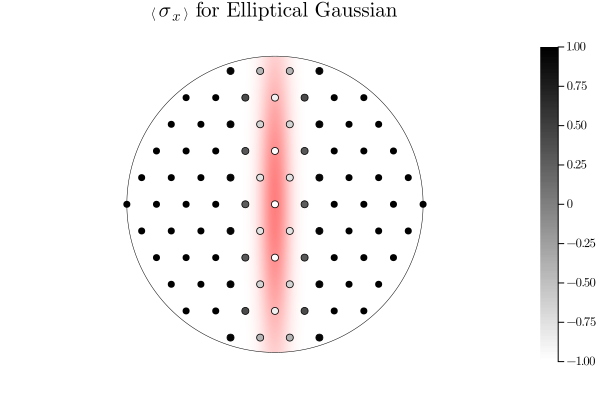

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


In [283]:
σ1 = .1
σ2 = 1
using LaTeXStrings

function gaussian(σ1, σ2)
    function func(x, y)
        if x^2 + y^2 > (1)^2
            -1
        else
        2*exp(-x^2/σ1^2 + -y^2/σ2^2) - 1
        end
    end
end


p = palette([:white, :black], 100);
scale = 2
plot(heatmap(xs, ys, gaussian(σ1, σ2); c=palette([:white, :red], 100), alpha=.5))
scatter!(scale*x, scale*y, marker_z = [Real(cos(2*f)) for f in finals], c=p, clim  = (-1,1))
plot!(circleShape(0, 0, scale*radius), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title=L"\left\langle\sigma_x\right\rangle\textrm{ for Elliptical Gaussian}", fontfamily="Computer Modern")

In [284]:
function gaussian(σ1, σ2)
    function func(x, y)
        1/sqrt(2) * [exp(-1.0im * π/2 * exp(-x^2/σ1^2 + -y^2/σ2^2)), exp(1.0im * π/2 * exp(-x^2/σ1^2 + -y^2/σ2^2))]
    end
end


ϕ = [gaussian(σ1, σ2)(xx, y[i]) for (i, xx) in enumerate(x)];
ψ = [1/sqrt(2)*[exp(-1.0im * (f)), exp(1.0im * (f))] for f in finals];
infidsparallel = [infidelity(ϕϕ, ψ[i]) for (i, ϕϕ) in enumerate(ϕ)];

Complex{Float64}[4.329780281177466e-17 - 0.7071067811865475im, 4.329780281177466e-17 + 0.7071067811865475im]Complex{Float64}[0.05387790175101722 - 0.7050511837469019im, 0.05387790175101722 + 0.7050511837469019im]Complex{Float64}[0.247326290257068 - 0.6624422285359505im, 0.247326290257068 + 0.6624422285359505im]Complex{Float64}[0.24261855360545911 - 0.6641808770556368im, 0.24261855360545911 + 0.6641808770556368im]Complex{Float64}[0.5993097223616916 - 0.37527037810457686im, 0.5993097223616916 + 0.37527037810457686im]Complex{Float64}[0.5735689554322061 - 0.4135440162357665im, 0.5735689554322061 + 0.4135440162357665im]Complex{Float64}[0.6987470587220197 - 0.10840916901870497im, 0.6987470587220197 + 0.10840916901870497im]Complex{Float64}[0.7001873898473028 - 0.09867937524539384im, 0.7001873898473028 + 0.09867937524539384im]Complex{Float64}[0.7068809693727174 - 0.01786883148634064im, 0.7068809693727174 + 0.01786883148634064im]Complex{Float64}[0.7066361453573816 + 0.02579453574812546im, 0.706

im]Complex{Float64}[0.7068325173504657 - 0.019692445658259016im, 0.7068325173504657 + 0.019692445658259016im]Complex{Float64}[0.7069370651933888 + 0.015491476874665473im, 0.7069370651933888 - 0.015491476874665473im]Complex{Float64}[0.7071039712706999 - 0.0019934425512359317im, 0.7071039712706999 + 0.0019934425512359317im]Complex{Float64}[0.7069827275077859 - 0.013244735016287994im, 0.7069827275077859 + 0.013244735016287994im]Complex{Float64}[0.7071067709341613 - 0.0001204120568896782im, 0.7071067709341613 + 0.0001204120568896782im]Complex{Float64}[0.7058091195291494 - 0.04281923387318756im, 0.7058091195291494 + 0.04281923387318756im]Complex{Float64}[0.7071067811692827 - 4.9412566081201895e-6im, 0.7071067811692827 + 4.9412566081201895e-6im]Complex{Float64}[0.7070681968681511 + 0.0073868110589982595im, 0.7070681968681511 - 0.0073868110589982595im]Complex{Float64}[0.7071067687341835 - 0.00013270381196383167im, 0.7071067687341835 + 0.00013270381196383167im]Complex{Float64}[0.70667306772060

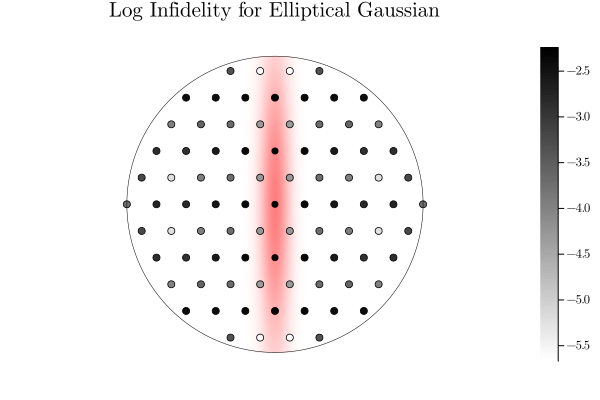

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


In [286]:
σ1 = .1
σ2 = 1
using LaTeXStrings

function gaussian(σ1, σ2, z)
    function func(x, y)
        (maximum(log.(10, z)) - minimum(log.(10, z)))*exp(-x^2/σ1^2 + -y^2/σ2^2) + minimum(log.(10, z))
    end
end


p = palette([:white, :black], 100);
scale = 2
plot(heatmap(xs, ys, gaussian(σ1, σ2, infidsparallel); c=palette([:white, :red], 100), alpha=.5))
scatter!(scale*x, scale*y, marker_z = [log(10, Real(infid)) for infid in infidsparallel], c=p)
plot!(circleShape(0, 0, scale*radius), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Log Infidelity for Elliptical Gaussian}", fontfamily="Computer Modern")

# Completely Serial

In [301]:
maxn = 32
maxm= 12
lookup = Dict()
for n in range(0, maxn, step=1)
    for m in range(0, maxm, step=1)
        for (i, pair) in enumerate(collect(zip(x, y)))
            xx = pair[1]
            yy = pair[2]
            ρ = sqrt(xx^2 + yy^2)
            # lookup with five digits of accuracy
            ρ = Int(round(ρ * 10^3, digits=0))
            lookup[(ρ, n, m)] = coeffs[m+1][n+1] * evals[m+1][n+1][i]
        end
    end
end
ω = 2*π*180E3
θ = -π/2;
U = 2 * π * 10E3
amp = .6 # Very sensitive, move just up to .65 and it goes to shit.
evolution_time = π/(U*amp)
finals = []
for (i, xx) in enumerate(x)
    yy = y[i]
    ρ = sqrt(xx^2 + yy^2)
    ϕ = atan(yy, xx)
    final = 0
    ρ = Int(round(ρ * 10^3, digits=0))
    for m in range(0, maxm, step=1)
        for n in range(0, maxn, step=1)
            pmn = 0
            if n ≥ m
                pmn += lookup[(ρ, n, m)]
                total = U*besselj(1,amp*pmn)*sin(m*ϕ-θ)*evolution_time
                maxpower = 100
                for k in range(-maxpower, maxpower, step=1)
                    if k!=1 && m!=0
                        a = U*exp(1.0im * (θ + k*m*ϕ)) * (1.0im)^(k+1)/(2*(k-1)*m*ω) * besselj(k, amp*pmn)*(1 - exp(-1.0im*(k-1)*m*ω*evolution_time))
                        total += a + conj(a)
                    end
                end
                final += total
            end
        end
        
    end
    push!(finals, final)
end

In [300]:
evolution_time

8.333333333333333e-5

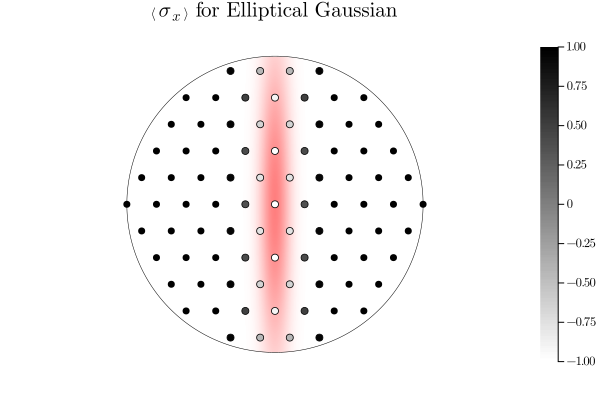

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


In [298]:
σ1 = .1
σ2 = 1
using LaTeXStrings

function gaussian(σ1, σ2)
    function func(x, y)
        if x^2 + y^2 > (1)^2
            -1
        else
        2*exp(-x^2/σ1^2 + -y^2/σ2^2) - 1
        end
    end
end


p = palette([:white, :black], 100);
scale = 2
plot(heatmap(xs, ys, gaussian(σ1, σ2); c=palette([:white, :red], 100), alpha=.5))
scatter!(scale*x, scale*y, marker_z = [Real(cos(2*f)) for f in finals], c=p, clim  = (-1,1))
plot!(circleShape(0, 0, scale*radius), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title=L"\left\langle\sigma_x\right\rangle\textrm{ for Elliptical Gaussian}", fontfamily="Computer Modern")

In [270]:
function gaussian(σ1, σ2)
    function func(x, y)
        1/sqrt(2) * [exp(-1.0im * π/2 * exp(-x^2/σ1^2 + -y^2/σ2^2)), exp(1.0im * π/2 * exp(-x^2/σ1^2 + -y^2/σ2^2))]
    end
end


ϕ = [gaussian(σ1, σ2)(xx, y[i]) for (i, xx) in enumerate(x)];
ψ = [1/sqrt(2)*[exp(-1.0im * (f)), exp(1.0im * (f))] for f in finals];
infids = [infidelity(ϕϕ, ψ[i]) for (i, ϕϕ) in enumerate(ϕ)];

Complex{Float64}[4.329780281177466e-17 - 0.7071067811865475im, 4.329780281177466e-17 + 0.7071067811865475im]Complex{Float64}[0.018960418120019962 - 0.7068525323889799im, 0.018960418120019962 + 0.7068525323889799im]Complex{Float64}[0.247326290257068 - 0.6624422285359505im, 0.247326290257068 + 0.6624422285359505im]Complex{Float64}[0.24148585287398522 - 0.6645935471111075im, 0.24148585287398522 + 0.6645935471111075im]Complex{Float64}[0.5993097223616916 - 0.37527037810457686im, 0.5993097223616916 + 0.37527037810457686im]Complex{Float64}[0.5927603767019616 - 0.38553227596681im, 0.5927603767019616 + 0.38553227596681im]Complex{Float64}[0.6987470587220197 - 0.10840916901870497im, 0.6987470587220197 + 0.10840916901870497im]Complex{Float64}[0.7006036956783609 - 0.09567895067266657im, 0.7006036956783609 + 0.09567895067266657im]Complex{Float64}[0.7068809693727174 - 0.01786883148634064im, 0.7068809693727174 + 0.01786883148634064im]Complex{Float64}[0.7070183372760129 - 0.011183503720300967im, 0.7070

im]Complex{Float64}[0.7068325173504657 - 0.019692445658259016im, 0.7068325173504657 + 0.019692445658259016im]Complex{Float64}[0.7069030437680923 - 0.01697311731552037im, 0.7069030437680923 + 0.01697311731552037im]Complex{Float64}[0.7071039712706999 - 0.0019934425512359317im, 0.7071039712706999 + 0.0019934425512359317im]Complex{Float64}[0.706965332123398 - 0.014142813569214313im, 0.706965332123398 + 0.014142813569214313im]Complex{Float64}[0.7071067709341613 - 0.0001204120568896782im, 0.7071067709341613 + 0.0001204120568896782im]Complex{Float64}[0.7069963219502461 - 0.012498029797687025im, 0.7069963219502461 + 0.012498029797687025im]Complex{Float64}[0.7071067811692827 - 4.9412566081201895e-6im, 0.7071067811692827 + 4.9412566081201895e-6im]Complex{Float64}[0.7068853439285051 + 0.017694929756260306im, 0.7068853439285051 - 0.017694929756260306im]Complex{Float64}[0.7071067687341835 - 0.00013270381196383167im, 0.7071067687341835 + 0.00013270381196383167im]Complex{Float64}[0.7070987761380022 +

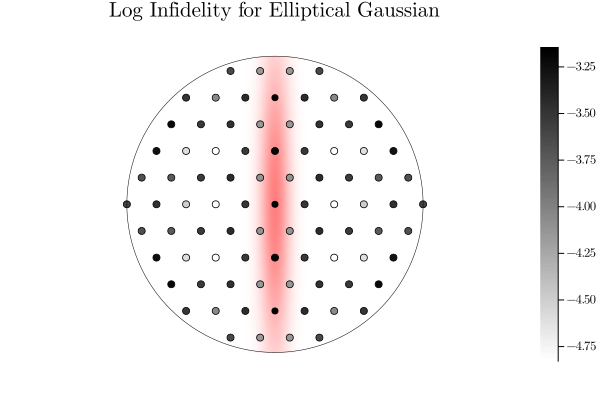

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


In [271]:
σ1 = .1
σ2 = 1
using LaTeXStrings

function gaussian(σ1, σ2, z)
    function func(x, y)
        (maximum(log.(10, z)) - minimum(log.(10, z)))*exp(-x^2/σ1^2 + -y^2/σ2^2) + minimum(log.(10, z))
    end
end


p = palette([:white, :black], 100);
scale = 2
plot(heatmap(xs, ys, gaussian(σ1, σ2, infids); c=palette([:white, :red], 100), alpha=.5))
scatter!(scale*x, scale*y, marker_z = [log(10, Real(infid)) for infid in infids], c=p)
plot!(circleShape(0, 0, scale*radius), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Log Infidelity for Elliptical Gaussian}", fontfamily="Computer Modern")

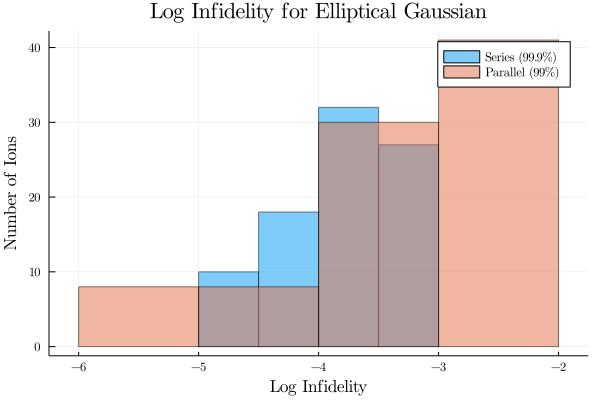

In [289]:
σ1 = .1
σ2 = .1  
using LaTeXStrings
using Plots

histogram(log.(10, infids), alpha=.5, label="Series (99.9%)", xlabel="Log Infidelity", ylabel="Number of Ions", title="Log Infidelity for Elliptical Gaussian",  fontfamily="Computer Modern")
#histogram!(log.(10, z2), alpha=.5, label="")
histogram!(log.(10, infidsparallel), alpha=.5, label="Parallel (99%)")